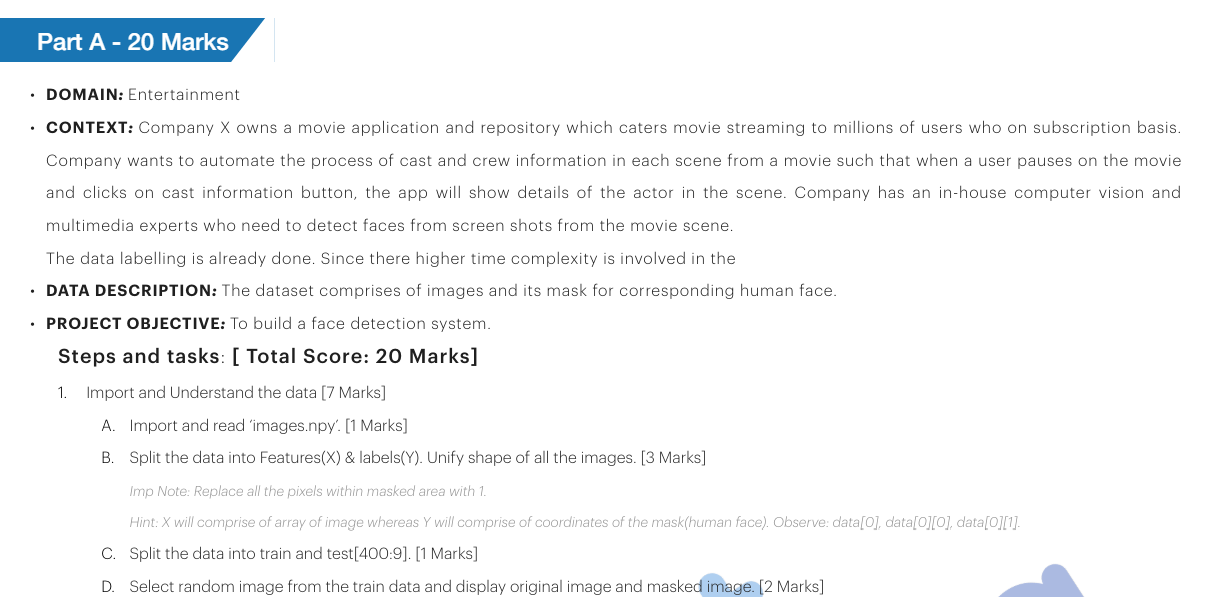

In [7]:
import numpy as np

# Loading the .npy file with allow_pickle=True
images = np.load(r"C:\Users\arjit\Desktop\Python\Computer Vision\images.npy", allow_pickle=True)

# Now, 'images' variable contains the data from the .npy file

In [8]:
#checking one sample from the loaded file
images[10][1]

[{'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.48, 'y': 0.10385756676557864},
   {'x': 0.7716666666666666, 'y': 0.6795252225519288}],
  'imageWidth': 600,
  'imageHeight': 337}]

Setting image dimensions to 224x224 is a common preprocessing step in computer vision projects to ensure uniformity and compatibility with neural network architectures.




In [9]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

The following step is performed to create features (preprocessed images) and labels (binary masks) from the dataset, essential for training a computer vision model.

In [11]:
pip install opencv-python #Installing OpenCV library

                                              0.0/38.6 MB ? eta -:--:--
                                              0.0/38.6 MB ? eta -:--:--
                                              0.0/38.6 MB ? eta -:--:--
                                             0.1/38.6 MB 762.6 kB/s eta 0:00:51
                                              0.6/38.6 MB 4.0 MB/s eta 0:00:10
     -                                        1.2/38.6 MB 6.0 MB/s eta 0:00:07
     -                                        1.5/38.6 MB 6.0 MB/s eta 0:00:07
     -                                        1.8/38.6 MB 6.0 MB/s eta 0:00:07
     --                                       2.1/38.6 MB 6.1 MB/s eta 0:00:06
     --                                       2.4/38.6 MB 6.0 MB/s eta 0:00:06
     --                                       2.7/38.6 MB 6.0 MB/s eta 0:00:06
     ---                                      2.9/38.6 MB 6.0 MB/s eta 0:00:06
     ---                                      3.2/38.6 MB 6.0 MB/s eta 0

In [13]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

# Initializing arrays for masks and features
masks = np.zeros((int(images.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))  # Array to store binary masks
X = np.zeros((int(images.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))  # Array to store preprocessed images

# Looping through each sample in the dataset
for index in range(images.shape[0]):
    # Resizing the image to the specified IMAGE_HEIGHT and IMAGE_WIDTH
    img = images[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    
    # Excluding the alpha channel if present in the image
    try:
        img = img[:, :, :3]
    except:
        continue
    
    # Preprocessing the resized image using preprocess_input
    X[index] = preprocess_input(np.array(img, dtype=np.float32))
    
    # Looping through each mask in the sample
    for i in images[index][1]:
        # Extracting the coordinates of the mask
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        
        # Scaling the coordinates to match the resized image dimensions
        masks[index][y1:y2, x1:x2] = 1

In [14]:
# Selecting the first 400 samples for training data
X_train = X[:400]
y_train = masks[:400]

# Selecting the remaining samples for testing data
X_test = X[400:]
y_test = masks[400:]

Displaying images from the training data to visually inspect the dataset, verify data integrity, and gain insights into the characteristics of the images and their corresponding masks.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


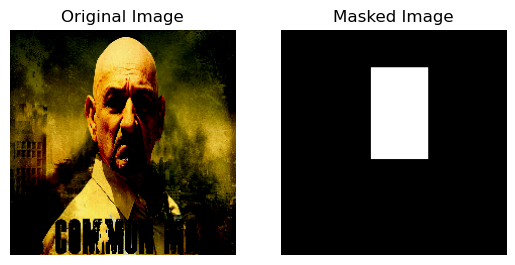

In [15]:
import random
import matplotlib.pyplot as plt

# Selecting a random index from the training data
random_index = random.randint(0, len(X_train) - 1)

# Getting the randomly selected image and its corresponding mask
random_image = X_train[random_index]
random_mask = y_train[random_index]

# Displaying the original image
plt.subplot(1, 2, 1)
plt.imshow(random_image)
plt.title('Original Image')
plt.axis('off')

# Displaying the masked image
plt.subplot(1, 2, 2)
plt.imshow(random_mask, cmap='gray')
plt.title('Masked Image')
plt.axis('off')

plt.show()

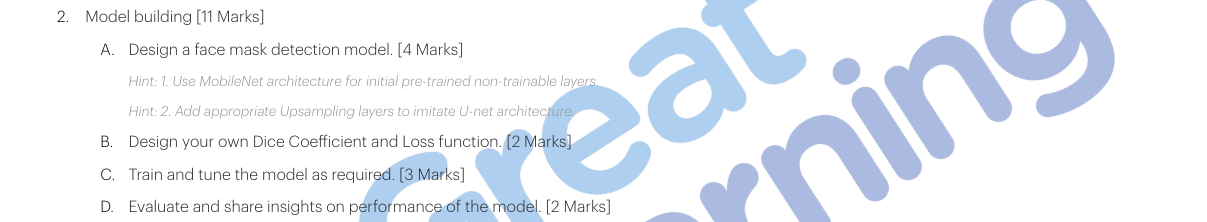

In [18]:
# Importing necessary libraries for building the model
from tensorflow.keras.applications.mobilenet import MobileNet  # Importing MobileNet architecture for feature extraction
from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D  # Importing layers for building the model
from tensorflow.keras.models import Model  # Importing Model class for defining the model architecture

def create_model(trainable=True):
    # Loading MobileNet with pre-trained weights, excluding the top layers
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet")

    # Setting the layers of MobileNet as trainable or non-trainable based on the 'trainable' parameter
    for layer in model.layers:
        layer.trainable = trainable
  
    # Retrieve intermediate layers for skip connections
    block0 = model.get_layer("conv_pw_1_relu").output
    block1 = model.get_layer("conv_pw_3_relu").output
    block2 = model.get_layer("conv_pw_5_relu").output
    block3 = model.get_layer("conv_pw_11_relu").output
    block4 = model.get_layer("conv_pw_13_relu").output

    # Upsample and concatenate features from different layers
    x = Concatenate()([UpSampling2D()(block4), block3])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block2])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block1])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block0])
    print(x.shape)
    
    # Final upsampling and convolutional layer to generate output mask
    x = UpSampling2D()(x)
    print(x.shape)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)
    print(x.shape)

    # Return the model with MobileNet as the encoder and custom decoder layers
    return Model(inputs=model.input, outputs=x)

The above code implements a face mask detection model using a combination of MobileNet architecture and U-net inspired design principles. MobileNet, a lightweight convolutional neural network architecture pre-trained on the ImageNet dataset, is utilized as the base model for feature extraction due to its efficiency and effectiveness in image classification tasks. The model architecture is constructed using skip connections to preserve spatial information and enhance gradient flow during training. Upsampling layers are incorporated to increase the spatial resolution of feature maps, mimicking the U-net architecture's expansive path. These design choices enable the model to effectively learn features specific to face mask detection by leveraging pre-trained features from MobileNet and enhancing them with additional layers. The resulting model combines the strengths of MobileNet for feature extraction and the U-net architecture for segmentation tasks, making it well-suited for detecting face masks in images.

In [20]:
from tensorflow import reduce_sum  # Importing reduce_sum function from TensorFlow to compute sums of tensor elements
from tensorflow.keras.backend import epsilon  # Importing epsilon from Keras backend to handle small numerical values

# Defining Dice Coefficient function
def dice_coefficient(y_true, y_pred):
    # Calculating numerator and denominator for Dice Coefficient
    numerator = 2 * reduce_sum(y_true * y_pred)
    denominator = reduce_sum(y_true + y_pred)
    # Compute Dice Coefficient with epsilon to prevent division by zero
    return numerator / (denominator + epsilon())


from tensorflow.keras.losses import binary_crossentropy  # Importing binary_crossentropy loss function from Keras
from tensorflow.keras.backend import log  # Importing log function from Keras backend


# Defining custom loss function
def custom_loss(y_true, y_pred):
    # Calculating Dice Coefficient
    dice = dice_coefficient(y_true, y_pred)
    # Calculating binary crossentropy loss
    bce = binary_crossentropy(y_true, y_pred)
    # Combining Dice Coefficient and binary crossentropy to form custom loss
    return bce - log(dice + epsilon())

Training, Tuning the model, and Evaluting the model

In [24]:
# Compile the model with the custom loss function and other parameters
model.compile(loss=custom_loss, optimizer='adam', metrics=[dice_coefficient])

# Import necessary callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Define callbacks for monitoring and adjusting training
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min")
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

# Train the model with the defined callbacks
model.fit(X_train, y_train, epochs=10, batch_size=1, callbacks=[checkpoint, reduce_lr, stop])


Epoch 1/10


400/400 [==============================] - ETA: 0s - loss: 1.2229 - dice_coefficient: 0.5110
Epoch 1: loss improved from inf to 1.22292, saving model to model-1.22.h5
400/400 [==============================] - 204s 490ms/step - loss: 1.2229 - dice_coefficient: 0.5110 - lr: 0.0010
Epoch 2/10
400/400 [==============================] - ETA: 0s - loss: 0.8565 - dice_coefficient: 0.6018
Epoch 2: loss improved from 1.22292 to 0.85649, saving model to model-0.86.h5
400/400 [==============================] - 270s 675ms/step - loss: 0.8565 - dice_coefficient: 0.6018 - lr: 0.0010
Epoch 3/10
400/400 [==============================] - ETA: 0s - loss: 0.7246 - dice_coefficient: 0.6477
Epoch 3: loss improved from 0.85649 to 0.72458, saving model to model-0.72.h5
400/400 [==============================] - 308s 771ms/step - loss: 0.7246 - dice_coefficient: 0.6477 - lr: 0.0010
Epoch 4/10
400/400 [==============================] - ETA: 0s - loss: 0.6657 - dice_coefficient: 0.6710
Epoch 4: 

Evaluate and share insights on performance of the model.

In [26]:
# Evaluate the model on test data
loss, dice_coefficient = model.evaluate(X_test, y_test)

# Make predictions on test data
y_pred = model.predict(X_test)

# Provide insights on model performance
print("Test Loss:", loss)
print("Dice Coefficient:", dice_coefficient)
# (Share additional insights and observations)

1/1 [==============================] - 8s 8s/step
Test Loss: 0.8959734439849854
Dice Coefficient: 0.552274763584137


The model achieved moderate performance on the test dataset, as indicated by a test loss of approximately 0.8960 and a Dice Coefficient of around 0.5523. The test loss reflects the overall discrepancy between the predicted and ground truth segmentation masks, with a lower value indicating better alignment. Meanwhile, the Dice Coefficient measures the overlap between the predicted and ground truth masks, with a higher value indicating better segmentation accuracy. While the model demonstrates reasonable performance, there is room for improvement, particularly in enhancing segmentation accuracy and reducing the overall loss.

1/1 [==============================] - 1s 954ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


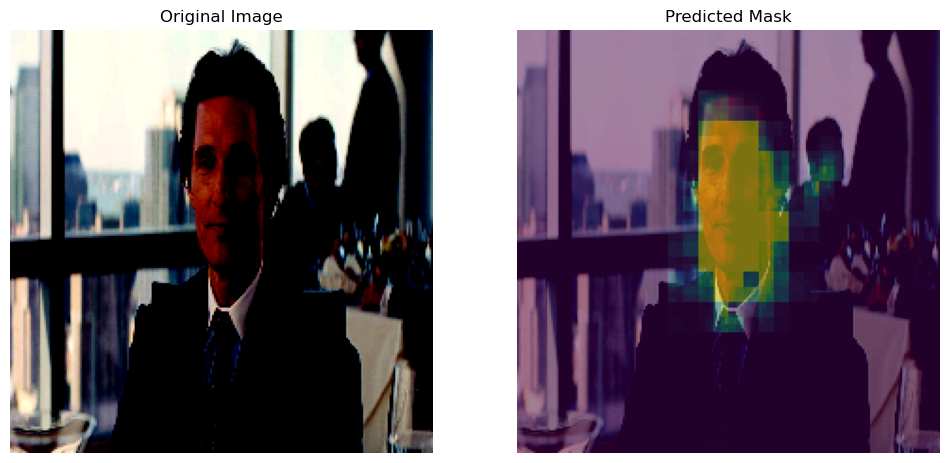

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Load the test image with index 3 from the test data
test_image = X_test[3]  # Assuming X_test contains the test images
true_mask = y_test[3]   # Assuming y_test contains the true masks

# Preprocessing the image if necessary (e.g., normalization)

# Making predictions using the trained model
predicted_mask = model.predict(np.expand_dims(test_image, axis=0))[0]

# Visualizing the original image and the predicted mask
plt.figure(figsize=(12, 6))

# Displaying the original image
plt.subplot(1, 2, 1)
plt.imshow(test_image)
plt.title('Original Image')
plt.axis('off')

# Displaying the predicted mask overlayed on the original image
plt.subplot(1, 2, 2)
plt.imshow(test_image)
plt.imshow(predicted_mask, alpha=0.5, cmap='viridis')  # Overlaying the mask with transparency
plt.title('Predicted Mask')
plt.axis('off')

plt.show()

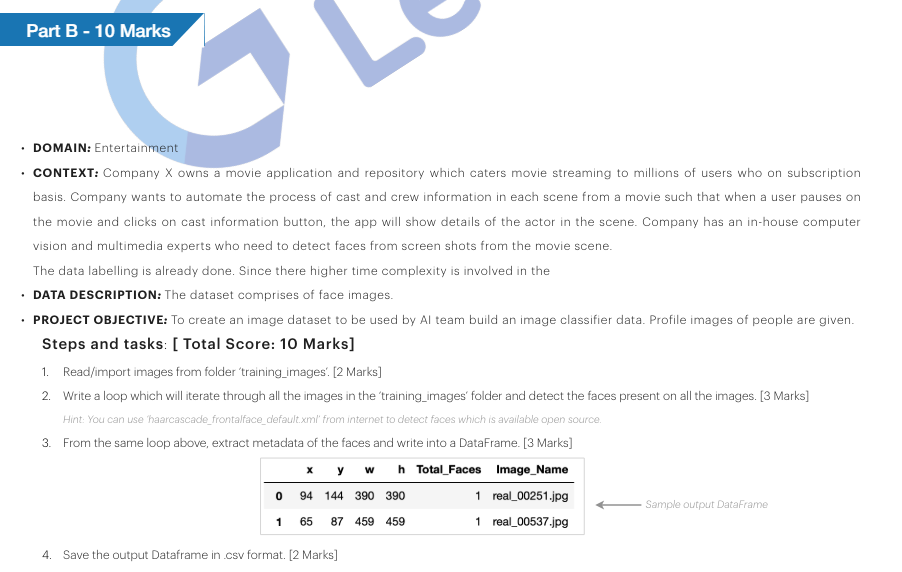

In [28]:
import pandas as pd              # For data manipulation 
import matplotlib.pyplot as plt # For visualization 
import numpy as np              # For numerical operations 
import tensorflow as tf         # For deep learning
import keras                    # High-level neural networks API 

In [38]:
# Importing necessary libraries
import os   # Operating system dependent functionality (to work with file paths)
import cv2  # OpenCV library for image processing
import glob # Used to find all the pathnames matching a specified pattern

# Specifying the directory containing the images
img_dir = r"C:\Users\arjit\Desktop\Python\Computer Vision\training_images"  # Directory path where the images are located

# Constructing the pattern to match image files in the directory
data_path = os.path.join(img_dir, '*g')  # '*' is used to extract all files in the directory with extensions ending in 'g'

# Getting a list of file paths matching the pattern
files = glob.glob(data_path)

# Creating an empty list to store the images
data = []

# Iterating over each file path, read the image, and append it to the data list
for f1 in files:
    # Reading the image using OpenCV
    img = cv2.imread(f1)
    
    # Appending the image to the data list
    data.append(img)

In [39]:
#examining a sepecfic image
data[500]

array([[[ 30,  34,  28],
        [ 31,  35,  29],
        [ 32,  36,  30],
        ...,
        [ 46,  66,  77],
        [ 45,  65,  76],
        [ 44,  64,  75]],

       [[ 29,  33,  27],
        [ 30,  34,  28],
        [ 33,  35,  29],
        ...,
        [ 45,  64,  72],
        [ 43,  63,  74],
        [ 42,  62,  73]],

       [[ 29,  33,  27],
        [ 32,  34,  28],
        [ 32,  34,  28],
        ...,
        [ 42,  60,  67],
        [ 42,  59,  68],
        [ 41,  58,  67]],

       ...,

       [[ 28,  29,  20],
        [ 29,  30,  21],
        [ 30,  31,  22],
        ...,
        [ 92, 107, 126],
        [ 87, 101, 120],
        [ 82,  95, 117]],

       [[ 28,  29,  19],
        [ 29,  30,  20],
        [ 29,  30,  21],
        ...,
        [ 91, 105, 123],
        [ 89, 100, 120],
        [ 85,  96, 116]],

       [[ 29,  30,  20],
        [ 29,  30,  20],
        [ 28,  29,  19],
        ...,
        [ 86, 100, 118],
        [ 85,  97, 115],
        [ 82,  91, 111]]

In [40]:
# Generating a list of file names (excluding directories) from the 'img_dir' directory
dir_list = next(os.walk(img_dir))[2]
dir_list

['real_00001.jpg',
 'real_00002.jpg',
 'real_00003.jpg',
 'real_00004.jpg',
 'real_00005.jpg',
 'real_00006.jpg',
 'real_00007.jpg',
 'real_00008.jpg',
 'real_00009.jpg',
 'real_00010.jpg',
 'real_00011.jpg',
 'real_00012.jpg',
 'real_00013.jpg',
 'real_00014.jpg',
 'real_00015.jpg',
 'real_00016.jpg',
 'real_00017.jpg',
 'real_00018.jpg',
 'real_00019.jpg',
 'real_00020.jpg',
 'real_00021.jpg',
 'real_00022.jpg',
 'real_00023.jpg',
 'real_00024.jpg',
 'real_00025.jpg',
 'real_00026.jpg',
 'real_00027.jpg',
 'real_00028.jpg',
 'real_00029.jpg',
 'real_00030.jpg',
 'real_00031.jpg',
 'real_00032.jpg',
 'real_00033.jpg',
 'real_00034.jpg',
 'real_00035.jpg',
 'real_00036.jpg',
 'real_00037.jpg',
 'real_00038.jpg',
 'real_00039.jpg',
 'real_00040.jpg',
 'real_00041.jpg',
 'real_00042.jpg',
 'real_00043.jpg',
 'real_00044.jpg',
 'real_00045.jpg',
 'real_00046.jpg',
 'real_00047.jpg',
 'real_00048.jpg',
 'real_00049.jpg',
 'real_00050.jpg',
 'real_00051.jpg',
 'real_00052.jpg',
 'real_00053

In [41]:
#Checking the size or extent of data available in a list or collection
len(dir_list)

1088

In [44]:
# Load the cascade classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Initialize empty lists to store face coordinates, dimensions, and other information
x_cord = []
y_cord = []
height = []
width = []
face_detected = []
image_name = []

# Loop through all files in the directory
for filename in os.listdir(img_dir):
    # Check if the file is an image file
    if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"):
        # Read the image
        img_path = os.path.join(img_dir, filename)
        img = cv2.imread(img_path)
        
        # Detect faces in the image
        faces = face_cascade.detectMultiScale(img, scaleFactor=1.05, minNeighbors=5)
        
        # Find coordinates and dimensions of the detected faces
        for x, y, w, h in faces:
            # Draw rectangles around the detected faces
            cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        
        # Resize the image for display purposes
        resized = cv2.resize(img, (int(img.shape[1]/2), int(img.shape[0])))
        
        # Append face information to respective lists
        if len(faces) == 0:
            a, b, c, d, j, name = 0, 0, 0, 0, 0, 0
        else:
            a, b, c, d = faces[0, 0], faces[0, 1], faces[0, 2], faces[0, 3]
            j, name = len(faces), filename
        
        x_cord.append(a)
        y_cord.append(b)
        width.append(c)
        height.append(d)
        face_detected.append(j)
        image_name.append(name)

# Print the number of images processed
print("Number of images processed:", len(image_name))

Number of images processed: 1088


In [47]:
import pandas as pd

# Directory containing the images
img_dir = "training_images/"

# Load the cascade classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Initialize empty lists to store face metadata
face_data = []

# Loop through all files in the directory
for filename in os.listdir(img_dir):
    # Check if the file is an image file
    if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"):
        # Read the image
        img_path = os.path.join(img_dir, filename)
        img = cv2.imread(img_path)
        
        # Detect faces in the image
        faces = face_cascade.detectMultiScale(img, scaleFactor=1.05, minNeighbors=5)
        
        # Append metadata of each detected face to the list
        for x, y, w, h in faces:
            face_info = {
                'Image': filename,
                'X-coordinate': x,
                'Y-coordinate': y,
                'Width': w,
                'Height': h
            }
            face_data.append(face_info)

# Convert the list of dictionaries into a DataFrame
face_df = pd.DataFrame(face_data)

# Display the DataFrame
print(face_df.head())

            Image  X-coordinate  Y-coordinate  Width  Height
0  real_00001.jpg           156           147    419     419
1  real_00002.jpg            81           141    434     434
2  real_00003.jpg           262            13    125     125
3  real_00003.jpg            32           117    368     368
4  real_00004.jpg           130           169    362     362


In [49]:
# Save the DataFrame to a CSV file
csv_file_path = "face_metadata.csv"
face_df.to_csv(csv_file_path, index=False)

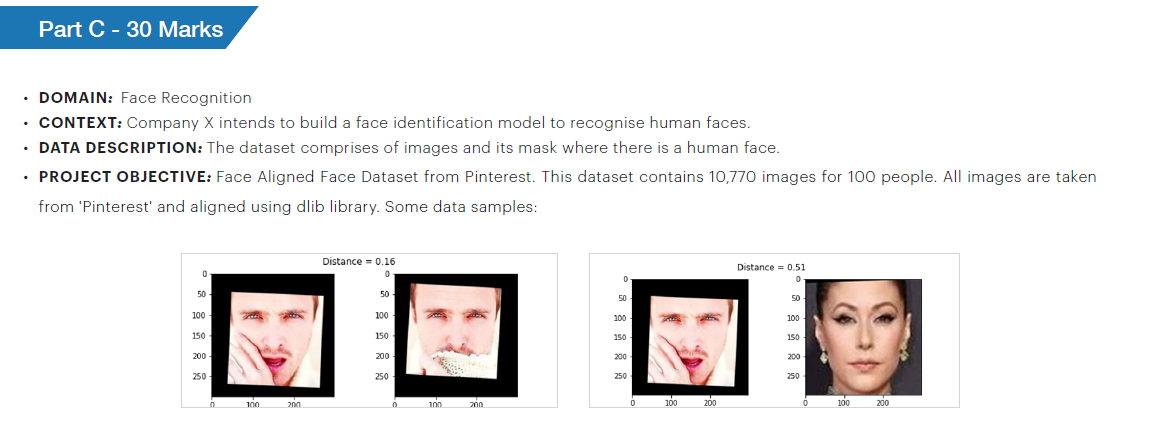

In [18]:
# Imports
import pandas as pd, numpy as np, matplotlib.pyplot as plt, sklearn, re, random
import matplotlib.gridspec as gridspec
from tqdm.notebook import tqdm
import tensorflow, cv2
%matplotlib inline

# Extract content from zipfile
from zipfile import ZipFile

# Model
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential, Model
from sklearn.svm import SVC

# Encode, standardize and PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

# Set random_state
random_state = 2020

# Suppress warnings, if any
import warnings; warnings.filterwarnings('ignore')

# Print versions
print(f'Pandas version: {pd.__version__}')
print(f'Numpy version: {np.__version__}')
print(f'Scikit-learn version: {sklearn.__version__}')
print(f'Tensorflow version: {tensorflow.__version__}')
print(f'CV version: {cv2.__version__}')

Pandas version: 1.5.3
Numpy version: 1.26.3
Scikit-learn version: 1.3.1
Tensorflow version: 2.15.0
CV version: 4.9.0


I was unable to unzip the files from the folder using code. I tried the following code mutliple times, but I kept getting errors: 


import zipfile

with zipfile.ZipFile("C:/Users/arjit/Desktop/Python/Computer Vision/PINS.zip", 'r') as zip_ref:
    # Extract all contents of the ZIP file
    zip_ref.extractall()


Therefore, I did the next best thing it to extract the files locally on the desktop and then read the images in that folder.

In [27]:
import os
import cv2

# Define the 'load_image' function
def load_image(path):
    img = cv2.imread(path, 1)
    # Check if the image was successfully loaded
    if img is None:
        print(f"Failed to load image: {path}")
        return None
    # OpenCV loads images with color channels in BGR order. So we need to reverse them
    return img[...,::-1]

# Path to the directory containing the images
directory = "C:/Users/arjit/Desktop/Python/Computer Vision/PINS"

# Function to load images from a directory
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)
        if os.path.isdir(path):  # Check if the current item is a directory
            # Recursively load images from subdirectories
            images.extend(load_images_from_folder(path))
        else:
            # Assuming all files are images (you may need to add additional checks)
            images.append(path)
    return images

# Load images from the directory
image_paths = load_images_from_folder(directory)

In [28]:
# Define the 'load_metadata' function to create metadata for each image
class IdentityMetadata():
    def __init__(self, base, name, file):
        self.base = base
        self.name = name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 

def load_metadata(path):
    metadata = []
    exts = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
                exts.append(ext)
    return metadata, exts

# Create an empty list to store metadata for all images
all_metadata = []

# Writing a loop to iterate through each and every image and create metadata for all the images.

In [29]:
# Iterate through each image and create metadata
for image_path in image_paths:
    # Load the image using the 'load_image' function
    img = load_image(image_path)
    # Check if the image was successfully loaded
    if img is not None:
        # Create metadata for the image
        metadata_info = {
            "path": image_path,
            "size": img.shape[:2],
            "channels": img.shape[2] if len(img.shape) == 3 else 1,
            "dtype": img.dtype
        }
        # Append the metadata to the list
        all_metadata.append(metadata_info)

# Print metadata for each image
for metadata_info in all_metadata:
    print(metadata_info)

{'path': 'C:/Users/arjit/Desktop/Python/Computer Vision/PINS\\PINS\\pins_Aaron Paul\\Aaron Paul0_262.jpg', 'size': (301, 299), 'channels': 3, 'dtype': dtype('uint8')}
{'path': 'C:/Users/arjit/Desktop/Python/Computer Vision/PINS\\PINS\\pins_Aaron Paul\\Aaron Paul101_247.jpg', 'size': (299, 299), 'channels': 3, 'dtype': dtype('uint8')}
{'path': 'C:/Users/arjit/Desktop/Python/Computer Vision/PINS\\PINS\\pins_Aaron Paul\\Aaron Paul101_248.jpg', 'size': (299, 299), 'channels': 3, 'dtype': dtype('uint8')}
{'path': 'C:/Users/arjit/Desktop/Python/Computer Vision/PINS\\PINS\\pins_Aaron Paul\\Aaron Paul101_249.jpg', 'size': (299, 299), 'channels': 3, 'dtype': dtype('uint8')}
{'path': 'C:/Users/arjit/Desktop/Python/Computer Vision/PINS\\PINS\\pins_Aaron Paul\\Aaron Paul103_217.jpg', 'size': (299, 299), 'channels': 3, 'dtype': dtype('uint8')}
{'path': 'C:/Users/arjit/Desktop/Python/Computer Vision/PINS\\PINS\\pins_Aaron Paul\\Aaron Paul113_228.jpg', 'size': (299, 299), 'channels': 3, 'dtype': dtyp

## Generating Embeddings vectors on the each face in the dataset.

In [30]:
import numpy as np
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dropout, Activation

# Define the VGG Face model
def vgg_face():    
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape=(224, 224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

# Load the VGG Face model
model = vgg_face()

# Print model summary
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_13 (ZeroPad  (None, 226, 226, 3)       0         
 ding2D)                                                         
                                                                 
 conv2d_16 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_14 (ZeroPad  (None, 226, 226, 64)      0         
 ding2D)                                                         
                                                                 
 conv2d_17 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                      

In [31]:
# Load the weights of the pre-trained VGG Face model
weights_path = "C:/Users/arjit/Desktop/Python/Computer Vision/vgg_face_weights.h5"
model.load_weights(weights_path)

from tqdm import tqdm

# Initialize an array to store embeddings for all images
embeddings = np.zeros((len(image_paths), 2622))

# Iterate through each image path
for i, image_path in tqdm(enumerate(image_paths), total=len(image_paths), desc="Generating Embeddings"):
    try:
        # Load and preprocess the image
        image = preprocess_image(image_path)
        # Obtain embedding vector for the image
        embeddings[i] = model.predict(image)[0]
    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")

# Print the embeddings for each image
for idx, embedding_vector in enumerate(embeddings):
    print(f"Embedding vector for image {idx + 1}:", embedding_vector)


Generating Embeddings:   0%|          | 0/8238 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step



Generating Embeddings:   0%|          | 1/8238 [00:01<3:08:39,  1.37s/it]

1/1 [==============================] - 0s 438ms/step



Generating Embeddings:   0%|          | 2/8238 [00:01<2:01:09,  1.13it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:   0%|          | 3/8238 [00:02<1:47:32,  1.28it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:   0%|          | 4/8238 [00:03<1:33:44,  1.46it/s]

1/1 [==============================] - 0s 363ms/step



Generating Embeddings:   0%|          | 5/8238 [00:03<1:21:19,  1.69it/s]

1/1 [==============================] - 0s 407ms/step



Generating Embeddings:   0%|          | 6/8238 [00:04<1:15:41,  1.81it/s]

1/1 [==============================] - 0s 407ms/step



Generating Embeddings:   0%|          | 7/8238 [00:04<1:12:57,  1.88it/s]

1/1 [==============================] - 0s 470ms/step



Generating Embeddings:   0%|          | 8/8238 [00:05<1:12:47,  1.88it/s]

1/1 [==============================] - 0s 463ms/step



Generating Embeddings:   0%|          | 9/8238 [00:05<1:13:04,  1.88it/s]

1/1 [==============================] - 0s 446ms/step



Generating Embeddings:   0%|          | 10/8238 [00:06<1:12:28,  1.89it/s]

1/1 [==============================] - 0s 471ms/step



Generating Embeddings:   0%|          | 11/8238 [00:06<1:13:42,  1.86it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   0%|          | 12/8238 [00:07<1:13:02,  1.88it/s]

1/1 [==============================] - 0s 410ms/step



Generating Embeddings:   0%|          | 13/8238 [00:07<1:10:51,  1.93it/s]

1/1 [==============================] - 1s 514ms/step



Generating Embeddings:   0%|          | 14/8238 [00:08<1:14:14,  1.85it/s]

1/1 [==============================] - 1s 507ms/step



Generating Embeddings:   0%|          | 15/8238 [00:08<1:15:51,  1.81it/s]

1/1 [==============================] - 0s 397ms/step



Generating Embeddings:   0%|          | 16/8238 [00:09<1:12:53,  1.88it/s]

1/1 [==============================] - 0s 428ms/step



Generating Embeddings:   0%|          | 17/8238 [00:09<1:11:47,  1.91it/s]

1/1 [==============================] - 0s 417ms/step



Generating Embeddings:   0%|          | 18/8238 [00:10<1:10:42,  1.94it/s]

1/1 [==============================] - 0s 426ms/step



Generating Embeddings:   0%|          | 19/8238 [00:10<1:10:44,  1.94it/s]

1/1 [==============================] - 0s 477ms/step



Generating Embeddings:   0%|          | 20/8238 [00:11<1:12:46,  1.88it/s]

1/1 [==============================] - 0s 371ms/step



Generating Embeddings:   0%|          | 21/8238 [00:11<1:09:10,  1.98it/s]

1/1 [==============================] - 0s 439ms/step



Generating Embeddings:   0%|          | 22/8238 [00:12<1:09:06,  1.98it/s]

1/1 [==============================] - 0s 364ms/step



Generating Embeddings:   0%|          | 23/8238 [00:12<1:06:02,  2.07it/s]

1/1 [==============================] - 0s 391ms/step



Generating Embeddings:   0%|          | 24/8238 [00:13<1:04:28,  2.12it/s]

1/1 [==============================] - 0s 360ms/step



Generating Embeddings:   0%|          | 25/8238 [00:13<1:02:31,  2.19it/s]

1/1 [==============================] - 0s 368ms/step



Generating Embeddings:   0%|          | 26/8238 [00:14<1:01:23,  2.23it/s]

1/1 [==============================] - 0s 369ms/step



Generating Embeddings:   0%|          | 27/8238 [00:14<1:00:28,  2.26it/s]

1/1 [==============================] - 0s 372ms/step



Generating Embeddings:   0%|          | 28/8238 [00:14<1:00:07,  2.28it/s]

1/1 [==============================] - 0s 361ms/step



Generating Embeddings:   0%|          | 29/8238 [00:15<59:23,  2.30it/s]  

1/1 [==============================] - 0s 369ms/step



Generating Embeddings:   0%|          | 30/8238 [00:15<59:11,  2.31it/s]

1/1 [==============================] - 0s 374ms/step



Generating Embeddings:   0%|          | 31/8238 [00:16<59:03,  2.32it/s]

1/1 [==============================] - 0s 379ms/step



Generating Embeddings:   0%|          | 32/8238 [00:16<58:38,  2.33it/s]

1/1 [==============================] - 0s 371ms/step



Generating Embeddings:   0%|          | 33/8238 [00:17<58:35,  2.33it/s]

1/1 [==============================] - 0s 362ms/step



Generating Embeddings:   0%|          | 34/8238 [00:17<58:28,  2.34it/s]

1/1 [==============================] - 0s 370ms/step



Generating Embeddings:   0%|          | 35/8238 [00:17<58:38,  2.33it/s]

1/1 [==============================] - 0s 387ms/step



Generating Embeddings:   0%|          | 36/8238 [00:18<59:04,  2.31it/s]

1/1 [==============================] - 0s 378ms/step



Generating Embeddings:   0%|          | 37/8238 [00:18<59:20,  2.30it/s]

1/1 [==============================] - 0s 376ms/step



Generating Embeddings:   0%|          | 38/8238 [00:19<59:05,  2.31it/s]

1/1 [==============================] - 0s 375ms/step



Generating Embeddings:   0%|          | 39/8238 [00:19<59:24,  2.30it/s]

1/1 [==============================] - 0s 400ms/step



Generating Embeddings:   0%|          | 40/8238 [00:20<1:00:43,  2.25it/s]

1/1 [==============================] - 0s 406ms/step



Generating Embeddings:   0%|          | 41/8238 [00:20<1:02:32,  2.18it/s]

1/1 [==============================] - 0s 401ms/step



Generating Embeddings:   1%|          | 42/8238 [00:21<1:03:02,  2.17it/s]

1/1 [==============================] - 0s 401ms/step



Generating Embeddings:   1%|          | 43/8238 [00:21<1:03:24,  2.15it/s]

1/1 [==============================] - 0s 397ms/step



Generating Embeddings:   1%|          | 44/8238 [00:22<1:03:36,  2.15it/s]

1/1 [==============================] - 0s 397ms/step



Generating Embeddings:   1%|          | 45/8238 [00:22<1:03:52,  2.14it/s]

1/1 [==============================] - 0s 388ms/step



Generating Embeddings:   1%|          | 46/8238 [00:22<1:03:14,  2.16it/s]

1/1 [==============================] - 0s 402ms/step



Generating Embeddings:   1%|          | 47/8238 [00:23<1:03:50,  2.14it/s]

1/1 [==============================] - 0s 407ms/step



Generating Embeddings:   1%|          | 48/8238 [00:23<1:04:08,  2.13it/s]

1/1 [==============================] - 0s 398ms/step



Generating Embeddings:   1%|          | 49/8238 [00:24<1:04:17,  2.12it/s]

1/1 [==============================] - 0s 422ms/step



Generating Embeddings:   1%|          | 50/8238 [00:24<1:05:20,  2.09it/s]

1/1 [==============================] - 0s 391ms/step



Generating Embeddings:   1%|          | 51/8238 [00:25<1:05:01,  2.10it/s]

1/1 [==============================] - 0s 369ms/step



Generating Embeddings:   1%|          | 52/8238 [00:25<1:02:58,  2.17it/s]

1/1 [==============================] - 0s 374ms/step



Generating Embeddings:   1%|          | 53/8238 [00:26<1:01:40,  2.21it/s]

1/1 [==============================] - 0s 363ms/step



Generating Embeddings:   1%|          | 54/8238 [00:26<1:00:35,  2.25it/s]

1/1 [==============================] - 0s 370ms/step



Generating Embeddings:   1%|          | 55/8238 [00:27<59:42,  2.28it/s]  

1/1 [==============================] - 0s 365ms/step



Generating Embeddings:   1%|          | 56/8238 [00:27<59:03,  2.31it/s]

1/1 [==============================] - 0s 376ms/step



Generating Embeddings:   1%|          | 57/8238 [00:27<58:53,  2.32it/s]

1/1 [==============================] - 0s 360ms/step



Generating Embeddings:   1%|          | 58/8238 [00:28<58:42,  2.32it/s]

1/1 [==============================] - 0s 365ms/step



Generating Embeddings:   1%|          | 59/8238 [00:28<58:32,  2.33it/s]

1/1 [==============================] - 0s 358ms/step



Generating Embeddings:   1%|          | 60/8238 [00:29<58:14,  2.34it/s]

1/1 [==============================] - 0s 364ms/step



Generating Embeddings:   1%|          | 61/8238 [00:29<58:07,  2.34it/s]

1/1 [==============================] - 0s 377ms/step



Generating Embeddings:   1%|          | 62/8238 [00:30<58:15,  2.34it/s]

1/1 [==============================] - 0s 378ms/step



Generating Embeddings:   1%|          | 63/8238 [00:30<58:02,  2.35it/s]

1/1 [==============================] - 0s 374ms/step



Generating Embeddings:   1%|          | 64/8238 [00:30<58:08,  2.34it/s]

1/1 [==============================] - 0s 379ms/step



Generating Embeddings:   1%|          | 65/8238 [00:31<58:16,  2.34it/s]

1/1 [==============================] - 0s 379ms/step



Generating Embeddings:   1%|          | 66/8238 [00:31<58:21,  2.33it/s]

1/1 [==============================] - 0s 379ms/step



Generating Embeddings:   1%|          | 67/8238 [00:32<58:36,  2.32it/s]

1/1 [==============================] - 0s 365ms/step



Generating Embeddings:   1%|          | 68/8238 [00:32<58:41,  2.32it/s]

1/1 [==============================] - 0s 427ms/step



Generating Embeddings:   1%|          | 69/8238 [00:33<1:01:34,  2.21it/s]

1/1 [==============================] - 0s 398ms/step



Generating Embeddings:   1%|          | 70/8238 [00:33<1:02:37,  2.17it/s]

1/1 [==============================] - 0s 370ms/step



Generating Embeddings:   1%|          | 71/8238 [00:34<1:01:19,  2.22it/s]

1/1 [==============================] - 0s 378ms/step



Generating Embeddings:   1%|          | 72/8238 [00:34<1:00:30,  2.25it/s]

1/1 [==============================] - 0s 394ms/step



Generating Embeddings:   1%|          | 73/8238 [00:34<1:00:35,  2.25it/s]

1/1 [==============================] - 0s 413ms/step



Generating Embeddings:   1%|          | 74/8238 [00:35<1:01:35,  2.21it/s]

1/1 [==============================] - 0s 364ms/step



Generating Embeddings:   1%|          | 75/8238 [00:35<1:00:31,  2.25it/s]

1/1 [==============================] - 0s 411ms/step



Generating Embeddings:   1%|          | 76/8238 [00:36<1:01:33,  2.21it/s]

1/1 [==============================] - 0s 385ms/step



Generating Embeddings:   1%|          | 77/8238 [00:36<1:01:31,  2.21it/s]

1/1 [==============================] - 0s 400ms/step



Generating Embeddings:   1%|          | 78/8238 [00:37<1:02:10,  2.19it/s]

1/1 [==============================] - 0s 383ms/step



Generating Embeddings:   1%|          | 79/8238 [00:37<1:02:13,  2.19it/s]

1/1 [==============================] - 0s 422ms/step



Generating Embeddings:   1%|          | 80/8238 [00:38<1:03:48,  2.13it/s]

1/1 [==============================] - 0s 391ms/step



Generating Embeddings:   1%|          | 81/8238 [00:38<1:03:36,  2.14it/s]

1/1 [==============================] - 0s 412ms/step



Generating Embeddings:   1%|          | 82/8238 [00:39<1:04:01,  2.12it/s]

1/1 [==============================] - 0s 396ms/step



Generating Embeddings:   1%|          | 83/8238 [00:39<1:03:49,  2.13it/s]

1/1 [==============================] - 0s 383ms/step



Generating Embeddings:   1%|          | 84/8238 [00:40<1:03:27,  2.14it/s]

1/1 [==============================] - 0s 420ms/step



Generating Embeddings:   1%|          | 85/8238 [00:40<1:04:19,  2.11it/s]

1/1 [==============================] - 0s 369ms/step



Generating Embeddings:   1%|          | 86/8238 [00:40<1:03:02,  2.16it/s]

1/1 [==============================] - 0s 370ms/step



Generating Embeddings:   1%|          | 87/8238 [00:41<1:01:46,  2.20it/s]

1/1 [==============================] - 0s 372ms/step



Generating Embeddings:   1%|          | 88/8238 [00:41<1:00:32,  2.24it/s]

1/1 [==============================] - 0s 379ms/step



Generating Embeddings:   1%|          | 89/8238 [00:42<1:00:03,  2.26it/s]

1/1 [==============================] - 0s 363ms/step



Generating Embeddings:   1%|          | 90/8238 [00:42<59:28,  2.28it/s]  

1/1 [==============================] - 0s 368ms/step



Generating Embeddings:   1%|          | 91/8238 [00:43<58:58,  2.30it/s]

1/1 [==============================] - 0s 375ms/step



Generating Embeddings:   1%|          | 92/8238 [00:43<58:42,  2.31it/s]

1/1 [==============================] - 0s 363ms/step



Generating Embeddings:   1%|          | 93/8238 [00:43<58:37,  2.32it/s]

1/1 [==============================] - 0s 377ms/step



Generating Embeddings:   1%|          | 94/8238 [00:44<58:43,  2.31it/s]

1/1 [==============================] - 0s 383ms/step



Generating Embeddings:   1%|          | 95/8238 [00:44<58:55,  2.30it/s]

1/1 [==============================] - 0s 374ms/step



Generating Embeddings:   1%|          | 96/8238 [00:45<58:47,  2.31it/s]

1/1 [==============================] - 0s 379ms/step



Generating Embeddings:   1%|          | 97/8238 [00:45<58:26,  2.32it/s]

1/1 [==============================] - 0s 377ms/step



Generating Embeddings:   1%|          | 98/8238 [00:46<58:45,  2.31it/s]

1/1 [==============================] - 0s 366ms/step



Generating Embeddings:   1%|          | 99/8238 [00:46<58:42,  2.31it/s]

1/1 [==============================] - 0s 366ms/step



Generating Embeddings:   1%|          | 100/8238 [00:46<58:38,  2.31it/s]

1/1 [==============================] - 0s 367ms/step



Generating Embeddings:   1%|          | 101/8238 [00:47<58:20,  2.32it/s]

1/1 [==============================] - 0s 410ms/step



Generating Embeddings:   1%|          | 102/8238 [00:47<59:26,  2.28it/s]

1/1 [==============================] - 0s 366ms/step



Generating Embeddings:   1%|▏         | 103/8238 [00:48<59:21,  2.28it/s]

1/1 [==============================] - 0s 367ms/step



Generating Embeddings:   1%|▏         | 104/8238 [00:48<59:09,  2.29it/s]

1/1 [==============================] - 0s 362ms/step



Generating Embeddings:   1%|▏         | 105/8238 [00:49<58:55,  2.30it/s]

1/1 [==============================] - 0s 370ms/step



Generating Embeddings:   1%|▏         | 106/8238 [00:49<58:31,  2.32it/s]

1/1 [==============================] - 0s 379ms/step



Generating Embeddings:   1%|▏         | 107/8238 [00:50<58:14,  2.33it/s]

1/1 [==============================] - 0s 369ms/step



Generating Embeddings:   1%|▏         | 108/8238 [00:50<58:11,  2.33it/s]

1/1 [==============================] - 0s 385ms/step



Generating Embeddings:   1%|▏         | 109/8238 [00:50<58:38,  2.31it/s]

1/1 [==============================] - 0s 383ms/step



Generating Embeddings:   1%|▏         | 110/8238 [00:51<58:42,  2.31it/s]

1/1 [==============================] - 0s 363ms/step



Generating Embeddings:   1%|▏         | 111/8238 [00:51<58:35,  2.31it/s]

1/1 [==============================] - 0s 402ms/step



Generating Embeddings:   1%|▏         | 112/8238 [00:52<59:58,  2.26it/s]

1/1 [==============================] - 0s 402ms/step



Generating Embeddings:   1%|▏         | 113/8238 [00:52<1:01:03,  2.22it/s]

1/1 [==============================] - 0s 398ms/step



Generating Embeddings:   1%|▏         | 114/8238 [00:53<1:01:37,  2.20it/s]

1/1 [==============================] - 0s 402ms/step



Generating Embeddings:   1%|▏         | 115/8238 [00:53<1:02:20,  2.17it/s]

1/1 [==============================] - 0s 406ms/step



Generating Embeddings:   1%|▏         | 116/8238 [00:54<1:03:20,  2.14it/s]

1/1 [==============================] - 0s 391ms/step



Generating Embeddings:   1%|▏         | 117/8238 [00:54<1:03:06,  2.14it/s]

1/1 [==============================] - 0s 398ms/step



Generating Embeddings:   1%|▏         | 118/8238 [00:55<1:03:04,  2.15it/s]

1/1 [==============================] - 0s 399ms/step



Generating Embeddings:   1%|▏         | 119/8238 [00:55<1:02:56,  2.15it/s]

1/1 [==============================] - 0s 387ms/step



Generating Embeddings:   1%|▏         | 120/8238 [00:55<1:02:55,  2.15it/s]

1/1 [==============================] - 0s 422ms/step



Generating Embeddings:   1%|▏         | 121/8238 [00:56<1:04:22,  2.10it/s]

1/1 [==============================] - 0s 386ms/step



Generating Embeddings:   1%|▏         | 122/8238 [00:56<1:03:53,  2.12it/s]

1/1 [==============================] - 0s 400ms/step



Generating Embeddings:   1%|▏         | 123/8238 [00:57<1:04:15,  2.10it/s]

1/1 [==============================] - 0s 368ms/step



Generating Embeddings:   2%|▏         | 124/8238 [00:57<1:02:18,  2.17it/s]

1/1 [==============================] - 0s 375ms/step



Generating Embeddings:   2%|▏         | 125/8238 [00:58<1:01:08,  2.21it/s]

1/1 [==============================] - 0s 365ms/step



Generating Embeddings:   2%|▏         | 126/8238 [00:58<1:00:07,  2.25it/s]

1/1 [==============================] - 0s 362ms/step



Generating Embeddings:   2%|▏         | 127/8238 [00:59<59:34,  2.27it/s]  

1/1 [==============================] - 0s 365ms/step



Generating Embeddings:   2%|▏         | 128/8238 [00:59<59:05,  2.29it/s]

1/1 [==============================] - 0s 370ms/step



Generating Embeddings:   2%|▏         | 129/8238 [00:59<58:50,  2.30it/s]

1/1 [==============================] - 0s 374ms/step



Generating Embeddings:   2%|▏         | 130/8238 [01:00<58:33,  2.31it/s]

1/1 [==============================] - 0s 395ms/step



Generating Embeddings:   2%|▏         | 131/8238 [01:00<58:37,  2.30it/s]

1/1 [==============================] - 0s 379ms/step



Generating Embeddings:   2%|▏         | 132/8238 [01:01<58:31,  2.31it/s]

1/1 [==============================] - 0s 364ms/step



Generating Embeddings:   2%|▏         | 133/8238 [01:01<58:10,  2.32it/s]

1/1 [==============================] - 0s 371ms/step



Generating Embeddings:   2%|▏         | 134/8238 [01:02<58:12,  2.32it/s]

1/1 [==============================] - 0s 372ms/step



Generating Embeddings:   2%|▏         | 135/8238 [01:02<58:00,  2.33it/s]

1/1 [==============================] - 0s 365ms/step



Generating Embeddings:   2%|▏         | 136/8238 [01:02<57:44,  2.34it/s]

1/1 [==============================] - 0s 372ms/step



Generating Embeddings:   2%|▏         | 137/8238 [01:03<57:40,  2.34it/s]

1/1 [==============================] - 0s 374ms/step



Generating Embeddings:   2%|▏         | 138/8238 [01:03<58:20,  2.31it/s]

1/1 [==============================] - 0s 377ms/step



Generating Embeddings:   2%|▏         | 139/8238 [01:04<58:44,  2.30it/s]

1/1 [==============================] - 0s 364ms/step



Generating Embeddings:   2%|▏         | 140/8238 [01:04<58:32,  2.31it/s]

1/1 [==============================] - 0s 362ms/step



Generating Embeddings:   2%|▏         | 141/8238 [01:05<58:25,  2.31it/s]

1/1 [==============================] - 0s 368ms/step



Generating Embeddings:   2%|▏         | 142/8238 [01:05<58:07,  2.32it/s]

1/1 [==============================] - 0s 374ms/step



Generating Embeddings:   2%|▏         | 143/8238 [01:06<58:02,  2.32it/s]

1/1 [==============================] - 0s 362ms/step



Generating Embeddings:   2%|▏         | 144/8238 [01:06<57:51,  2.33it/s]

1/1 [==============================] - 0s 399ms/step



Generating Embeddings:   2%|▏         | 145/8238 [01:06<59:03,  2.28it/s]

1/1 [==============================] - 0s 410ms/step



Generating Embeddings:   2%|▏         | 146/8238 [01:07<1:00:23,  2.23it/s]

1/1 [==============================] - 0s 372ms/step



Generating Embeddings:   2%|▏         | 147/8238 [01:07<59:27,  2.27it/s]  

1/1 [==============================] - 0s 397ms/step



Generating Embeddings:   2%|▏         | 148/8238 [01:08<1:00:04,  2.24it/s]

1/1 [==============================] - 0s 391ms/step



Generating Embeddings:   2%|▏         | 149/8238 [01:08<1:00:58,  2.21it/s]

1/1 [==============================] - 0s 392ms/step



Generating Embeddings:   2%|▏         | 150/8238 [01:09<1:01:40,  2.19it/s]

1/1 [==============================] - 0s 422ms/step



Generating Embeddings:   2%|▏         | 151/8238 [01:09<1:02:46,  2.15it/s]

1/1 [==============================] - 0s 422ms/step



Generating Embeddings:   2%|▏         | 152/8238 [01:10<1:03:27,  2.12it/s]

1/1 [==============================] - 0s 380ms/step



Generating Embeddings:   2%|▏         | 153/8238 [01:10<1:03:07,  2.13it/s]

1/1 [==============================] - 0s 412ms/step



Generating Embeddings:   2%|▏         | 154/8238 [01:11<1:03:21,  2.13it/s]

1/1 [==============================] - 0s 402ms/step



Generating Embeddings:   2%|▏         | 155/8238 [01:11<1:03:15,  2.13it/s]

1/1 [==============================] - 0s 397ms/step



Generating Embeddings:   2%|▏         | 156/8238 [01:12<1:03:28,  2.12it/s]

1/1 [==============================] - 0s 423ms/step



Generating Embeddings:   2%|▏         | 157/8238 [01:12<1:04:07,  2.10it/s]

1/1 [==============================] - 0s 373ms/step



Generating Embeddings:   2%|▏         | 158/8238 [01:12<1:02:56,  2.14it/s]

1/1 [==============================] - 0s 370ms/step



Generating Embeddings:   2%|▏         | 159/8238 [01:13<1:01:20,  2.20it/s]

1/1 [==============================] - 0s 371ms/step



Generating Embeddings:   2%|▏         | 160/8238 [01:13<1:00:19,  2.23it/s]

1/1 [==============================] - 0s 378ms/step



Generating Embeddings:   2%|▏         | 161/8238 [01:14<59:48,  2.25it/s]  

1/1 [==============================] - 0s 357ms/step



Generating Embeddings:   2%|▏         | 162/8238 [01:14<59:08,  2.28it/s]

1/1 [==============================] - 0s 365ms/step



Generating Embeddings:   2%|▏         | 163/8238 [01:15<58:35,  2.30it/s]

1/1 [==============================] - 0s 369ms/step



Generating Embeddings:   2%|▏         | 164/8238 [01:15<58:22,  2.31it/s]

1/1 [==============================] - 0s 374ms/step



Generating Embeddings:   2%|▏         | 165/8238 [01:15<58:10,  2.31it/s]

1/1 [==============================] - 0s 360ms/step



Generating Embeddings:   2%|▏         | 166/8238 [01:16<58:05,  2.32it/s]

1/1 [==============================] - 0s 379ms/step



Generating Embeddings:   2%|▏         | 167/8238 [01:16<57:57,  2.32it/s]

1/1 [==============================] - 0s 370ms/step



Generating Embeddings:   2%|▏         | 168/8238 [01:17<57:41,  2.33it/s]

1/1 [==============================] - 0s 364ms/step



Generating Embeddings:   2%|▏         | 169/8238 [01:17<57:27,  2.34it/s]

1/1 [==============================] - 0s 373ms/step



Generating Embeddings:   2%|▏         | 170/8238 [01:18<57:36,  2.33it/s]

1/1 [==============================] - 0s 368ms/step



Generating Embeddings:   2%|▏         | 171/8238 [01:18<57:45,  2.33it/s]

1/1 [==============================] - 0s 375ms/step



Generating Embeddings:   2%|▏         | 172/8238 [01:18<57:41,  2.33it/s]

1/1 [==============================] - 0s 379ms/step



Generating Embeddings:   2%|▏         | 173/8238 [01:19<57:42,  2.33it/s]

1/1 [==============================] - 0s 365ms/step



Generating Embeddings:   2%|▏         | 174/8238 [01:19<57:37,  2.33it/s]

1/1 [==============================] - 0s 403ms/step



Generating Embeddings:   2%|▏         | 175/8238 [01:20<59:24,  2.26it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   2%|▏         | 176/8238 [01:20<1:04:40,  2.08it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   2%|▏         | 177/8238 [01:21<1:08:44,  1.95it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   2%|▏         | 178/8238 [01:22<1:10:30,  1.91it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:   2%|▏         | 179/8238 [01:22<1:12:55,  1.84it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:   2%|▏         | 180/8238 [01:23<1:16:35,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   2%|▏         | 181/8238 [01:23<1:16:26,  1.76it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   2%|▏         | 182/8238 [01:24<1:18:17,  1.71it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:   2%|▏         | 183/8238 [01:25<1:19:10,  1.70it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:   2%|▏         | 184/8238 [01:25<1:19:12,  1.69it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:   2%|▏         | 185/8238 [01:26<1:20:53,  1.66it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   2%|▏         | 186/8238 [01:26<1:21:38,  1.64it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:   2%|▏         | 187/8238 [01:27<1:21:07,  1.65it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   2%|▏         | 188/8238 [01:28<1:21:51,  1.64it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   2%|▏         | 189/8238 [01:28<1:21:14,  1.65it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   2%|▏         | 190/8238 [01:29<1:20:24,  1.67it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:   2%|▏         | 191/8238 [01:29<1:22:23,  1.63it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:   2%|▏         | 192/8238 [01:30<1:21:21,  1.65it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   2%|▏         | 193/8238 [01:31<1:20:32,  1.66it/s]

1/1 [==============================] - 0s 456ms/step



Generating Embeddings:   2%|▏         | 194/8238 [01:31<1:19:28,  1.69it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   2%|▏         | 195/8238 [01:32<1:18:52,  1.70it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   2%|▏         | 196/8238 [01:32<1:17:49,  1.72it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   2%|▏         | 197/8238 [01:33<1:16:52,  1.74it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:   2%|▏         | 198/8238 [01:34<1:18:59,  1.70it/s]

1/1 [==============================] - 1s 579ms/step



Generating Embeddings:   2%|▏         | 199/8238 [01:34<1:23:20,  1.61it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   2%|▏         | 200/8238 [01:35<1:22:47,  1.62it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   2%|▏         | 201/8238 [01:35<1:20:17,  1.67it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   2%|▏         | 202/8238 [01:36<1:19:35,  1.68it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   2%|▏         | 203/8238 [01:37<1:18:13,  1.71it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   2%|▏         | 204/8238 [01:37<1:17:31,  1.73it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   2%|▏         | 205/8238 [01:38<1:16:39,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   3%|▎         | 206/8238 [01:38<1:16:20,  1.75it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:   3%|▎         | 207/8238 [01:39<1:15:59,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   3%|▎         | 208/8238 [01:39<1:15:34,  1.77it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:   3%|▎         | 209/8238 [01:40<1:18:08,  1.71it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   3%|▎         | 210/8238 [01:41<1:19:31,  1.68it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:   3%|▎         | 211/8238 [01:41<1:19:20,  1.69it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:   3%|▎         | 212/8238 [01:42<1:20:26,  1.66it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:   3%|▎         | 213/8238 [01:42<1:20:27,  1.66it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   3%|▎         | 214/8238 [01:43<1:20:05,  1.67it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   3%|▎         | 215/8238 [01:44<1:21:18,  1.64it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   3%|▎         | 216/8238 [01:44<1:21:20,  1.64it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:   3%|▎         | 217/8238 [01:45<1:21:42,  1.64it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:   3%|▎         | 218/8238 [01:45<1:23:06,  1.61it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   3%|▎         | 219/8238 [01:46<1:20:52,  1.65it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   3%|▎         | 220/8238 [01:47<1:19:11,  1.69it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   3%|▎         | 221/8238 [01:47<1:18:06,  1.71it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   3%|▎         | 222/8238 [01:48<1:17:49,  1.72it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   3%|▎         | 223/8238 [01:48<1:17:08,  1.73it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:   3%|▎         | 224/8238 [01:49<1:16:19,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   3%|▎         | 225/8238 [01:49<1:15:57,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   3%|▎         | 226/8238 [01:50<1:16:07,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   3%|▎         | 227/8238 [01:51<1:15:31,  1.77it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   3%|▎         | 228/8238 [01:51<1:18:39,  1.70it/s]

1/1 [==============================] - 1s 518ms/step



Generating Embeddings:   3%|▎         | 229/8238 [01:52<1:20:11,  1.66it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:   3%|▎         | 230/8238 [01:52<1:19:21,  1.68it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   3%|▎         | 231/8238 [01:53<1:18:17,  1.70it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   3%|▎         | 232/8238 [01:54<1:18:09,  1.71it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   3%|▎         | 233/8238 [01:54<1:17:44,  1.72it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:   3%|▎         | 234/8238 [01:55<1:18:32,  1.70it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:   3%|▎         | 235/8238 [01:55<1:18:37,  1.70it/s]

1/1 [==============================] - 1s 579ms/step



Generating Embeddings:   3%|▎         | 236/8238 [01:56<1:22:49,  1.61it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:   3%|▎         | 237/8238 [01:57<1:23:43,  1.59it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:   3%|▎         | 238/8238 [01:57<1:24:53,  1.57it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:   3%|▎         | 239/8238 [01:58<1:25:16,  1.56it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:   3%|▎         | 240/8238 [01:59<1:24:01,  1.59it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:   3%|▎         | 241/8238 [01:59<1:23:27,  1.60it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   3%|▎         | 242/8238 [02:00<1:24:21,  1.58it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:   3%|▎         | 243/8238 [02:00<1:22:59,  1.61it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:   3%|▎         | 244/8238 [02:01<1:24:28,  1.58it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   3%|▎         | 245/8238 [02:02<1:23:11,  1.60it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   3%|▎         | 246/8238 [02:02<1:20:56,  1.65it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   3%|▎         | 247/8238 [02:03<1:19:15,  1.68it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   3%|▎         | 248/8238 [02:03<1:17:58,  1.71it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:   3%|▎         | 249/8238 [02:04<1:16:56,  1.73it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   3%|▎         | 250/8238 [02:05<1:16:01,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   3%|▎         | 251/8238 [02:05<1:15:21,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   3%|▎         | 252/8238 [02:06<1:15:25,  1.76it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   3%|▎         | 253/8238 [02:06<1:16:00,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   3%|▎         | 254/8238 [02:07<1:16:17,  1.74it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   3%|▎         | 255/8238 [02:07<1:15:37,  1.76it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   3%|▎         | 256/8238 [02:08<1:15:53,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   3%|▎         | 257/8238 [02:09<1:15:33,  1.76it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:   3%|▎         | 258/8238 [02:09<1:15:01,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   3%|▎         | 259/8238 [02:10<1:15:29,  1.76it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   3%|▎         | 260/8238 [02:10<1:15:05,  1.77it/s]

1/1 [==============================] - 1s 566ms/step



Generating Embeddings:   3%|▎         | 261/8238 [02:11<1:18:41,  1.69it/s]

1/1 [==============================] - 1s 652ms/step



Generating Embeddings:   3%|▎         | 262/8238 [02:12<1:27:13,  1.52it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:   3%|▎         | 263/8238 [02:12<1:30:24,  1.47it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   3%|▎         | 264/8238 [02:13<1:27:47,  1.51it/s]

1/1 [==============================] - 1s 504ms/step



Generating Embeddings:   3%|▎         | 265/8238 [02:14<1:26:08,  1.54it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:   3%|▎         | 266/8238 [02:14<1:24:44,  1.57it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:   3%|▎         | 267/8238 [02:15<1:23:34,  1.59it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:   3%|▎         | 268/8238 [02:15<1:22:43,  1.61it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:   3%|▎         | 269/8238 [02:16<1:22:14,  1.61it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:   3%|▎         | 270/8238 [02:17<1:21:54,  1.62it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:   3%|▎         | 271/8238 [02:17<1:22:24,  1.61it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   3%|▎         | 272/8238 [02:18<1:20:58,  1.64it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   3%|▎         | 273/8238 [02:18<1:19:07,  1.68it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   3%|▎         | 274/8238 [02:19<1:17:38,  1.71it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   3%|▎         | 275/8238 [02:20<1:16:37,  1.73it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   3%|▎         | 276/8238 [02:20<1:16:04,  1.74it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   3%|▎         | 277/8238 [02:21<1:15:37,  1.75it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   3%|▎         | 278/8238 [02:21<1:15:46,  1.75it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   3%|▎         | 279/8238 [02:22<1:15:35,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   3%|▎         | 280/8238 [02:22<1:15:28,  1.76it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   3%|▎         | 281/8238 [02:23<1:15:14,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   3%|▎         | 282/8238 [02:24<1:14:52,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   3%|▎         | 283/8238 [02:24<1:14:49,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   3%|▎         | 284/8238 [02:25<1:14:56,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   3%|▎         | 285/8238 [02:25<1:14:28,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   3%|▎         | 286/8238 [02:26<1:14:49,  1.77it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:   3%|▎         | 287/8238 [02:26<1:14:20,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   3%|▎         | 288/8238 [02:27<1:14:31,  1.78it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:   4%|▎         | 289/8238 [02:27<1:15:54,  1.75it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:   4%|▎         | 290/8238 [02:28<1:19:20,  1.67it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   4%|▎         | 291/8238 [02:29<1:20:12,  1.65it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:   4%|▎         | 292/8238 [02:29<1:20:13,  1.65it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:   4%|▎         | 293/8238 [02:30<1:20:26,  1.65it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   4%|▎         | 294/8238 [02:31<1:20:40,  1.64it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   4%|▎         | 295/8238 [02:31<1:20:55,  1.64it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:   4%|▎         | 296/8238 [02:32<1:21:16,  1.63it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   4%|▎         | 297/8238 [02:32<1:20:58,  1.63it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:   4%|▎         | 298/8238 [02:33<1:22:37,  1.60it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   4%|▎         | 299/8238 [02:34<1:20:22,  1.65it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   4%|▎         | 300/8238 [02:34<1:18:48,  1.68it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   4%|▎         | 301/8238 [02:35<1:19:35,  1.66it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:   4%|▎         | 302/8238 [02:36<1:22:01,  1.61it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:   4%|▎         | 303/8238 [02:36<1:21:38,  1.62it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   4%|▎         | 304/8238 [02:37<1:19:16,  1.67it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   4%|▎         | 305/8238 [02:37<1:17:29,  1.71it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   4%|▎         | 306/8238 [02:38<1:16:32,  1.73it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   4%|▎         | 307/8238 [02:38<1:15:54,  1.74it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:   4%|▎         | 308/8238 [02:39<1:15:07,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   4%|▍         | 309/8238 [02:39<1:14:52,  1.76it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   4%|▍         | 310/8238 [02:40<1:14:46,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   4%|▍         | 311/8238 [02:41<1:14:28,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   4%|▍         | 312/8238 [02:41<1:14:34,  1.77it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:   4%|▍         | 313/8238 [02:42<1:14:15,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   4%|▍         | 314/8238 [02:42<1:14:32,  1.77it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:   4%|▍         | 315/8238 [02:43<1:14:19,  1.78it/s]

1/1 [==============================] - 0s 474ms/step



Generating Embeddings:   4%|▍         | 316/8238 [02:43<1:15:19,  1.75it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:   4%|▍         | 317/8238 [02:44<1:18:55,  1.67it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:   4%|▍         | 318/8238 [02:45<1:19:45,  1.66it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   4%|▍         | 319/8238 [02:45<1:19:22,  1.66it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:   4%|▍         | 320/8238 [02:46<1:20:43,  1.63it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   4%|▍         | 321/8238 [02:47<1:19:41,  1.66it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   4%|▍         | 322/8238 [02:47<1:20:33,  1.64it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:   4%|▍         | 323/8238 [02:48<1:22:38,  1.60it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:   4%|▍         | 324/8238 [02:49<1:24:13,  1.57it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   4%|▍         | 325/8238 [02:49<1:23:51,  1.57it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   4%|▍         | 326/8238 [02:50<1:22:58,  1.59it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   4%|▍         | 327/8238 [02:50<1:21:45,  1.61it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   4%|▍         | 328/8238 [02:51<1:19:58,  1.65it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:   4%|▍         | 329/8238 [02:51<1:17:52,  1.69it/s]

1/1 [==============================] - 0s 479ms/step



Generating Embeddings:   4%|▍         | 330/8238 [02:52<1:17:10,  1.71it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   4%|▍         | 331/8238 [02:53<1:16:16,  1.73it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   4%|▍         | 332/8238 [02:53<1:15:47,  1.74it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   4%|▍         | 333/8238 [02:54<1:15:28,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   4%|▍         | 334/8238 [02:54<1:15:11,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   4%|▍         | 335/8238 [02:55<1:14:41,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   4%|▍         | 336/8238 [02:55<1:14:50,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   4%|▍         | 337/8238 [02:56<1:14:53,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   4%|▍         | 338/8238 [02:57<1:14:30,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   4%|▍         | 339/8238 [02:57<1:13:56,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   4%|▍         | 340/8238 [02:58<1:13:47,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   4%|▍         | 341/8238 [02:58<1:13:39,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   4%|▍         | 342/8238 [02:59<1:13:39,  1.79it/s]

1/1 [==============================] - 0s 476ms/step



Generating Embeddings:   4%|▍         | 343/8238 [02:59<1:14:36,  1.76it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:   4%|▍         | 344/8238 [03:00<1:18:24,  1.68it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:   4%|▍         | 345/8238 [03:01<1:19:13,  1.66it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:   4%|▍         | 346/8238 [03:01<1:19:10,  1.66it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   4%|▍         | 347/8238 [03:02<1:20:27,  1.63it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   4%|▍         | 348/8238 [03:03<1:20:43,  1.63it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   4%|▍         | 349/8238 [03:03<1:21:24,  1.62it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   4%|▍         | 350/8238 [03:04<1:21:28,  1.61it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:   4%|▍         | 351/8238 [03:04<1:20:25,  1.63it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:   4%|▍         | 352/8238 [03:05<1:21:19,  1.62it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   4%|▍         | 353/8238 [03:06<1:19:55,  1.64it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   4%|▍         | 354/8238 [03:06<1:19:23,  1.66it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   4%|▍         | 355/8238 [03:07<1:17:52,  1.69it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   4%|▍         | 356/8238 [03:07<1:16:33,  1.72it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   4%|▍         | 357/8238 [03:08<1:15:46,  1.73it/s]

1/1 [==============================] - 0s 470ms/step



Generating Embeddings:   4%|▍         | 358/8238 [03:08<1:15:27,  1.74it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   4%|▍         | 359/8238 [03:09<1:14:47,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   4%|▍         | 360/8238 [03:10<1:14:34,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   4%|▍         | 361/8238 [03:10<1:14:07,  1.77it/s]

1/1 [==============================] - 0s 458ms/step



Generating Embeddings:   4%|▍         | 362/8238 [03:11<1:13:54,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   4%|▍         | 363/8238 [03:11<1:13:34,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   4%|▍         | 364/8238 [03:12<1:13:33,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   4%|▍         | 365/8238 [03:12<1:13:26,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   4%|▍         | 366/8238 [03:13<1:13:10,  1.79it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:   4%|▍         | 367/8238 [03:13<1:13:31,  1.78it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:   4%|▍         | 368/8238 [03:14<1:16:44,  1.71it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   4%|▍         | 369/8238 [03:15<1:18:42,  1.67it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:   4%|▍         | 370/8238 [03:15<1:20:53,  1.62it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   5%|▍         | 371/8238 [03:16<1:22:39,  1.59it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:   5%|▍         | 372/8238 [03:17<1:24:23,  1.55it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:   5%|▍         | 373/8238 [03:17<1:24:26,  1.55it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:   5%|▍         | 374/8238 [03:18<1:26:32,  1.51it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:   5%|▍         | 375/8238 [03:19<1:26:40,  1.51it/s]

1/1 [==============================] - 1s 594ms/step



Generating Embeddings:   5%|▍         | 376/8238 [03:19<1:28:21,  1.48it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:   5%|▍         | 377/8238 [03:20<1:29:19,  1.47it/s]

1/1 [==============================] - 1s 589ms/step



Generating Embeddings:   5%|▍         | 378/8238 [03:21<1:30:35,  1.45it/s]

1/1 [==============================] - 1s 576ms/step



Generating Embeddings:   5%|▍         | 379/8238 [03:22<1:31:20,  1.43it/s]

1/1 [==============================] - 1s 550ms/step



Generating Embeddings:   5%|▍         | 380/8238 [03:22<1:31:02,  1.44it/s]

1/1 [==============================] - 1s 603ms/step



Generating Embeddings:   5%|▍         | 381/8238 [03:23<1:31:34,  1.43it/s]

1/1 [==============================] - 1s 636ms/step



Generating Embeddings:   5%|▍         | 382/8238 [03:24<1:33:55,  1.39it/s]

1/1 [==============================] - 1s 644ms/step



Generating Embeddings:   5%|▍         | 383/8238 [03:25<1:36:29,  1.36it/s]

1/1 [==============================] - 1s 670ms/step



Generating Embeddings:   5%|▍         | 384/8238 [03:25<1:40:09,  1.31it/s]

1/1 [==============================] - 1s 615ms/step



Generating Embeddings:   5%|▍         | 385/8238 [03:26<1:38:54,  1.32it/s]

1/1 [==============================] - 1s 576ms/step



Generating Embeddings:   5%|▍         | 386/8238 [03:27<1:36:49,  1.35it/s]

1/1 [==============================] - 1s 616ms/step



Generating Embeddings:   5%|▍         | 387/8238 [03:28<1:36:24,  1.36it/s]

1/1 [==============================] - 1s 552ms/step



Generating Embeddings:   5%|▍         | 388/8238 [03:28<1:34:02,  1.39it/s]

1/1 [==============================] - 1s 587ms/step



Generating Embeddings:   5%|▍         | 389/8238 [03:29<1:33:14,  1.40it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:   5%|▍         | 390/8238 [03:30<1:32:22,  1.42it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   5%|▍         | 391/8238 [03:30<1:27:38,  1.49it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   5%|▍         | 392/8238 [03:31<1:23:32,  1.57it/s]

1/1 [==============================] - 0s 470ms/step



Generating Embeddings:   5%|▍         | 393/8238 [03:31<1:20:51,  1.62it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:   5%|▍         | 394/8238 [03:32<1:21:48,  1.60it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   5%|▍         | 395/8238 [03:33<1:21:46,  1.60it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:   5%|▍         | 396/8238 [03:33<1:20:48,  1.62it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:   5%|▍         | 397/8238 [03:34<1:21:18,  1.61it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   5%|▍         | 398/8238 [03:34<1:21:31,  1.60it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   5%|▍         | 399/8238 [03:35<1:20:23,  1.63it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   5%|▍         | 400/8238 [03:36<1:20:33,  1.62it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:   5%|▍         | 401/8238 [03:36<1:21:53,  1.60it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:   5%|▍         | 402/8238 [03:37<1:24:09,  1.55it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:   5%|▍         | 403/8238 [03:38<1:26:53,  1.50it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:   5%|▍         | 404/8238 [03:38<1:26:54,  1.50it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   5%|▍         | 405/8238 [03:39<1:23:44,  1.56it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   5%|▍         | 406/8238 [03:40<1:20:24,  1.62it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   5%|▍         | 407/8238 [03:40<1:18:25,  1.66it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   5%|▍         | 408/8238 [03:41<1:16:53,  1.70it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   5%|▍         | 409/8238 [03:41<1:15:57,  1.72it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   5%|▍         | 410/8238 [03:42<1:15:33,  1.73it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   5%|▍         | 411/8238 [03:42<1:15:11,  1.73it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   5%|▌         | 412/8238 [03:43<1:14:29,  1.75it/s]

1/1 [==============================] - 0s 470ms/step



Generating Embeddings:   5%|▌         | 413/8238 [03:43<1:14:16,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   5%|▌         | 414/8238 [03:44<1:14:14,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   5%|▌         | 415/8238 [03:45<1:14:12,  1.76it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   5%|▌         | 416/8238 [03:45<1:13:45,  1.77it/s]

1/1 [==============================] - 0s 474ms/step



Generating Embeddings:   5%|▌         | 417/8238 [03:46<1:14:09,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   5%|▌         | 418/8238 [03:46<1:14:12,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   5%|▌         | 419/8238 [03:47<1:13:46,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   5%|▌         | 420/8238 [03:47<1:14:01,  1.76it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:   5%|▌         | 421/8238 [03:48<1:16:08,  1.71it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   5%|▌         | 422/8238 [03:49<1:16:20,  1.71it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   5%|▌         | 423/8238 [03:49<1:16:27,  1.70it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:   5%|▌         | 424/8238 [03:50<1:17:14,  1.69it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:   5%|▌         | 425/8238 [03:50<1:17:47,  1.67it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:   5%|▌         | 426/8238 [03:51<1:20:28,  1.62it/s]

1/1 [==============================] - 1s 548ms/step



Generating Embeddings:   5%|▌         | 427/8238 [03:52<1:21:50,  1.59it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:   5%|▌         | 428/8238 [03:52<1:22:25,  1.58it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   5%|▌         | 429/8238 [03:53<1:21:21,  1.60it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   5%|▌         | 430/8238 [03:54<1:21:25,  1.60it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   5%|▌         | 431/8238 [03:54<1:21:50,  1.59it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   5%|▌         | 432/8238 [03:55<1:20:37,  1.61it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:   5%|▌         | 433/8238 [03:55<1:18:14,  1.66it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   5%|▌         | 434/8238 [03:56<1:16:36,  1.70it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:   5%|▌         | 435/8238 [03:57<1:15:48,  1.72it/s]

1/1 [==============================] - 0s 460ms/step



Generating Embeddings:   5%|▌         | 436/8238 [03:57<1:14:43,  1.74it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   5%|▌         | 437/8238 [03:58<1:14:08,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   5%|▌         | 438/8238 [03:58<1:13:57,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   5%|▌         | 439/8238 [03:59<1:13:50,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   5%|▌         | 440/8238 [03:59<1:13:21,  1.77it/s]

1/1 [==============================] - 0s 455ms/step



Generating Embeddings:   5%|▌         | 441/8238 [04:00<1:13:20,  1.77it/s]

1/1 [==============================] - 0s 471ms/step



Generating Embeddings:   5%|▌         | 442/8238 [04:01<1:13:34,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   5%|▌         | 443/8238 [04:01<1:13:18,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   5%|▌         | 444/8238 [04:02<1:13:28,  1.77it/s]

1/1 [==============================] - 0s 472ms/step



Generating Embeddings:   5%|▌         | 445/8238 [04:02<1:13:57,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   5%|▌         | 446/8238 [04:03<1:14:07,  1.75it/s]

1/1 [==============================] - 0s 456ms/step



Generating Embeddings:   5%|▌         | 447/8238 [04:03<1:13:53,  1.76it/s]

1/1 [==============================] - 1s 513ms/step



Generating Embeddings:   5%|▌         | 448/8238 [04:04<1:15:50,  1.71it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   5%|▌         | 449/8238 [04:05<1:16:11,  1.70it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   5%|▌         | 450/8238 [04:05<1:16:45,  1.69it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   5%|▌         | 451/8238 [04:06<1:17:04,  1.68it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   5%|▌         | 452/8238 [04:06<1:18:25,  1.65it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   5%|▌         | 453/8238 [04:07<1:18:55,  1.64it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:   6%|▌         | 454/8238 [04:08<1:20:17,  1.62it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:   6%|▌         | 455/8238 [04:08<1:19:47,  1.63it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   6%|▌         | 456/8238 [04:09<1:19:37,  1.63it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:   6%|▌         | 457/8238 [04:10<1:21:16,  1.60it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:   6%|▌         | 458/8238 [04:10<1:20:56,  1.60it/s]

1/1 [==============================] - 1s 594ms/step



Generating Embeddings:   6%|▌         | 459/8238 [04:11<1:23:33,  1.55it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:   6%|▌         | 460/8238 [04:11<1:23:23,  1.55it/s]

1/1 [==============================] - 1s 509ms/step



Generating Embeddings:   6%|▌         | 461/8238 [04:12<1:23:11,  1.56it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   6%|▌         | 462/8238 [04:13<1:22:21,  1.57it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   6%|▌         | 463/8238 [04:13<1:19:54,  1.62it/s]

1/1 [==============================] - 0s 492ms/step



Generating Embeddings:   6%|▌         | 464/8238 [04:14<1:18:41,  1.65it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   6%|▌         | 465/8238 [04:14<1:17:36,  1.67it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   6%|▌         | 466/8238 [04:15<1:17:05,  1.68it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   6%|▌         | 467/8238 [04:16<1:16:06,  1.70it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:   6%|▌         | 468/8238 [04:16<1:16:43,  1.69it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:   6%|▌         | 469/8238 [04:17<1:20:05,  1.62it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:   6%|▌         | 470/8238 [04:17<1:17:57,  1.66it/s]

1/1 [==============================] - 0s 458ms/step



Generating Embeddings:   6%|▌         | 471/8238 [04:18<1:16:28,  1.69it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   6%|▌         | 472/8238 [04:19<1:15:31,  1.71it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   6%|▌         | 473/8238 [04:19<1:15:08,  1.72it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   6%|▌         | 474/8238 [04:20<1:16:34,  1.69it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:   6%|▌         | 475/8238 [04:20<1:16:50,  1.68it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:   6%|▌         | 476/8238 [04:21<1:17:46,  1.66it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:   6%|▌         | 477/8238 [04:22<1:18:03,  1.66it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   6%|▌         | 478/8238 [04:22<1:19:06,  1.63it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:   6%|▌         | 479/8238 [04:23<1:19:26,  1.63it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   6%|▌         | 480/8238 [04:24<1:19:36,  1.62it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   6%|▌         | 481/8238 [04:24<1:19:51,  1.62it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:   6%|▌         | 482/8238 [04:25<1:19:04,  1.63it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:   6%|▌         | 483/8238 [04:25<1:19:55,  1.62it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:   6%|▌         | 484/8238 [04:26<1:19:20,  1.63it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:   6%|▌         | 485/8238 [04:27<1:21:22,  1.59it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   6%|▌         | 486/8238 [04:27<1:19:00,  1.64it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   6%|▌         | 487/8238 [04:28<1:17:22,  1.67it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   6%|▌         | 488/8238 [04:28<1:15:59,  1.70it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   6%|▌         | 489/8238 [04:29<1:15:04,  1.72it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   6%|▌         | 490/8238 [04:29<1:15:01,  1.72it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   6%|▌         | 491/8238 [04:30<1:14:19,  1.74it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:   6%|▌         | 492/8238 [04:31<1:13:44,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   6%|▌         | 493/8238 [04:31<1:13:10,  1.76it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   6%|▌         | 494/8238 [04:32<1:12:55,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   6%|▌         | 495/8238 [04:32<1:12:43,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   6%|▌         | 496/8238 [04:33<1:12:56,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   6%|▌         | 497/8238 [04:33<1:12:42,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   6%|▌         | 498/8238 [04:34<1:12:45,  1.77it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:   6%|▌         | 499/8238 [04:35<1:13:22,  1.76it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:   6%|▌         | 500/8238 [04:35<1:16:52,  1.68it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   6%|▌         | 501/8238 [04:36<1:18:39,  1.64it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:   6%|▌         | 502/8238 [04:36<1:18:14,  1.65it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:   6%|▌         | 503/8238 [04:37<1:18:01,  1.65it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   6%|▌         | 504/8238 [04:38<1:18:39,  1.64it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:   6%|▌         | 505/8238 [04:38<1:21:35,  1.58it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:   6%|▌         | 506/8238 [04:39<1:22:36,  1.56it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:   6%|▌         | 507/8238 [04:40<1:22:49,  1.56it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   6%|▌         | 508/8238 [04:40<1:20:43,  1.60it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:   6%|▌         | 509/8238 [04:41<1:19:48,  1.61it/s]

1/1 [==============================] - 1s 521ms/step



Generating Embeddings:   6%|▌         | 510/8238 [04:41<1:20:00,  1.61it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   6%|▌         | 511/8238 [04:42<1:18:47,  1.63it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:   6%|▌         | 512/8238 [04:43<1:22:17,  1.56it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   6%|▌         | 513/8238 [04:43<1:19:31,  1.62it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   6%|▌         | 514/8238 [04:44<1:17:29,  1.66it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   6%|▋         | 515/8238 [04:44<1:15:56,  1.69it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   6%|▋         | 516/8238 [04:45<1:14:56,  1.72it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   6%|▋         | 517/8238 [04:46<1:14:15,  1.73it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   6%|▋         | 518/8238 [04:46<1:13:35,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   6%|▋         | 519/8238 [04:47<1:13:22,  1.75it/s]

1/1 [==============================] - 0s 461ms/step



Generating Embeddings:   6%|▋         | 520/8238 [04:47<1:12:56,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   6%|▋         | 521/8238 [04:48<1:12:50,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   6%|▋         | 522/8238 [04:48<1:12:36,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   6%|▋         | 523/8238 [04:49<1:12:56,  1.76it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:   6%|▋         | 524/8238 [04:50<1:12:31,  1.77it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:   6%|▋         | 525/8238 [04:50<1:12:12,  1.78it/s]

1/1 [==============================] - 0s 455ms/step



Generating Embeddings:   6%|▋         | 526/8238 [04:51<1:12:26,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   6%|▋         | 527/8238 [04:51<1:12:34,  1.77it/s]

1/1 [==============================] - 1s 512ms/step



Generating Embeddings:   6%|▋         | 528/8238 [04:52<1:14:52,  1.72it/s]

1/1 [==============================] - 0s 486ms/step



Generating Embeddings:   6%|▋         | 529/8238 [04:52<1:15:44,  1.70it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   6%|▋         | 530/8238 [04:53<1:16:00,  1.69it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   6%|▋         | 531/8238 [04:54<1:17:09,  1.66it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   6%|▋         | 532/8238 [04:54<1:18:04,  1.64it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:   6%|▋         | 533/8238 [04:55<1:18:37,  1.63it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   6%|▋         | 534/8238 [04:56<1:19:24,  1.62it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   6%|▋         | 535/8238 [04:56<1:18:37,  1.63it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:   7%|▋         | 536/8238 [04:57<1:18:50,  1.63it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:   7%|▋         | 537/8238 [04:57<1:19:44,  1.61it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:   7%|▋         | 538/8238 [04:58<1:18:52,  1.63it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:   7%|▋         | 539/8238 [04:59<1:20:51,  1.59it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   7%|▋         | 540/8238 [04:59<1:18:17,  1.64it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   7%|▋         | 541/8238 [05:00<1:16:27,  1.68it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:   7%|▋         | 542/8238 [05:00<1:15:26,  1.70it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   7%|▋         | 543/8238 [05:01<1:14:49,  1.71it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   7%|▋         | 544/8238 [05:02<1:13:52,  1.74it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   7%|▋         | 545/8238 [05:02<1:13:33,  1.74it/s]

1/1 [==============================] - 0s 455ms/step



Generating Embeddings:   7%|▋         | 546/8238 [05:03<1:13:04,  1.75it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:   7%|▋         | 547/8238 [05:03<1:12:24,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   7%|▋         | 548/8238 [05:04<1:12:20,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   7%|▋         | 549/8238 [05:04<1:12:16,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   7%|▋         | 550/8238 [05:05<1:12:28,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   7%|▋         | 551/8238 [05:05<1:12:09,  1.78it/s]

1/1 [==============================] - 0s 457ms/step



Generating Embeddings:   7%|▋         | 552/8238 [05:06<1:12:08,  1.78it/s]

1/1 [==============================] - 0s 459ms/step



Generating Embeddings:   7%|▋         | 553/8238 [05:07<1:12:08,  1.78it/s]

1/1 [==============================] - 0s 464ms/step



Generating Embeddings:   7%|▋         | 554/8238 [05:07<1:12:07,  1.78it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:   7%|▋         | 555/8238 [05:08<1:13:24,  1.74it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:   7%|▋         | 556/8238 [05:08<1:14:29,  1.72it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   7%|▋         | 557/8238 [05:09<1:16:05,  1.68it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:   7%|▋         | 558/8238 [05:10<1:15:57,  1.69it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:   7%|▋         | 559/8238 [05:10<1:16:38,  1.67it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:   7%|▋         | 560/8238 [05:11<1:17:12,  1.66it/s]

1/1 [==============================] - 0s 471ms/step



Generating Embeddings:   7%|▋         | 561/8238 [05:11<1:16:33,  1.67it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   7%|▋         | 562/8238 [05:12<1:17:18,  1.65it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:   7%|▋         | 563/8238 [05:13<1:17:19,  1.65it/s]

1/1 [==============================] - 0s 478ms/step



Generating Embeddings:   7%|▋         | 564/8238 [05:13<1:16:59,  1.66it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:   7%|▋         | 565/8238 [05:14<1:18:59,  1.62it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:   7%|▋         | 566/8238 [05:14<1:20:18,  1.59it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   7%|▋         | 567/8238 [05:15<1:18:45,  1.62it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   7%|▋         | 568/8238 [05:16<1:17:00,  1.66it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   7%|▋         | 569/8238 [05:16<1:15:15,  1.70it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   7%|▋         | 570/8238 [05:17<1:14:28,  1.72it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   7%|▋         | 571/8238 [05:17<1:13:43,  1.73it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   7%|▋         | 572/8238 [05:18<1:13:37,  1.74it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:   7%|▋         | 573/8238 [05:18<1:13:30,  1.74it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   7%|▋         | 574/8238 [05:19<1:12:58,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   7%|▋         | 575/8238 [05:20<1:12:24,  1.76it/s]

1/1 [==============================] - 0s 452ms/step



Generating Embeddings:   7%|▋         | 576/8238 [05:20<1:12:01,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   7%|▋         | 577/8238 [05:21<1:12:09,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   7%|▋         | 578/8238 [05:21<1:12:27,  1.76it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   7%|▋         | 579/8238 [05:22<1:12:14,  1.77it/s]

1/1 [==============================] - 0s 456ms/step



Generating Embeddings:   7%|▋         | 580/8238 [05:22<1:11:58,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   7%|▋         | 581/8238 [05:23<1:11:59,  1.77it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:   7%|▋         | 582/8238 [05:24<1:13:27,  1.74it/s]

1/1 [==============================] - 1s 548ms/step



Generating Embeddings:   7%|▋         | 583/8238 [05:24<1:16:39,  1.66it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   7%|▋         | 584/8238 [05:25<1:16:26,  1.67it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   7%|▋         | 585/8238 [05:25<1:16:11,  1.67it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:   7%|▋         | 586/8238 [05:26<1:16:59,  1.66it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:   7%|▋         | 587/8238 [05:27<1:17:33,  1.64it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   7%|▋         | 588/8238 [05:27<1:16:15,  1.67it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:   7%|▋         | 589/8238 [05:28<1:17:07,  1.65it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   7%|▋         | 590/8238 [05:28<1:17:43,  1.64it/s]

1/1 [==============================] - 1s 517ms/step



Generating Embeddings:   7%|▋         | 591/8238 [05:29<1:18:15,  1.63it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:   7%|▋         | 592/8238 [05:30<1:17:59,  1.63it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:   7%|▋         | 593/8238 [05:30<1:19:50,  1.60it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   7%|▋         | 594/8238 [05:31<1:18:26,  1.62it/s]

1/1 [==============================] - 0s 476ms/step



Generating Embeddings:   7%|▋         | 595/8238 [05:32<1:16:49,  1.66it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:   7%|▋         | 596/8238 [05:32<1:15:13,  1.69it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   7%|▋         | 597/8238 [05:33<1:14:13,  1.72it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   7%|▋         | 598/8238 [05:33<1:13:18,  1.74it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   7%|▋         | 599/8238 [05:34<1:12:59,  1.74it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   7%|▋         | 600/8238 [05:34<1:13:03,  1.74it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   7%|▋         | 601/8238 [05:35<1:12:49,  1.75it/s]

1/1 [==============================] - 0s 458ms/step



Generating Embeddings:   7%|▋         | 602/8238 [05:36<1:12:15,  1.76it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   7%|▋         | 603/8238 [05:36<1:11:42,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   7%|▋         | 604/8238 [05:37<1:11:15,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   7%|▋         | 605/8238 [05:37<1:11:34,  1.78it/s]

1/1 [==============================] - 0s 474ms/step



Generating Embeddings:   7%|▋         | 606/8238 [05:38<1:11:57,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   7%|▋         | 607/8238 [05:38<1:11:54,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   7%|▋         | 608/8238 [05:39<1:11:38,  1.77it/s]

1/1 [==============================] - 1s 537ms/step



Generating Embeddings:   7%|▋         | 609/8238 [05:40<1:14:55,  1.70it/s]

1/1 [==============================] - 1s 609ms/step



Generating Embeddings:   7%|▋         | 610/8238 [05:40<1:20:24,  1.58it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:   7%|▋         | 611/8238 [05:41<1:24:25,  1.51it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:   7%|▋         | 612/8238 [05:42<1:25:19,  1.49it/s]

1/1 [==============================] - 1s 579ms/step



Generating Embeddings:   7%|▋         | 613/8238 [05:42<1:27:38,  1.45it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:   7%|▋         | 614/8238 [05:43<1:28:35,  1.43it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   7%|▋         | 615/8238 [05:44<1:25:26,  1.49it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:   7%|▋         | 616/8238 [05:44<1:24:02,  1.51it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   7%|▋         | 617/8238 [05:45<1:22:17,  1.54it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:   8%|▊         | 618/8238 [05:46<1:22:52,  1.53it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   8%|▊         | 619/8238 [05:46<1:19:32,  1.60it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   8%|▊         | 620/8238 [05:47<1:17:34,  1.64it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   8%|▊         | 621/8238 [05:47<1:15:30,  1.68it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   8%|▊         | 622/8238 [05:48<1:14:47,  1.70it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   8%|▊         | 623/8238 [05:48<1:13:40,  1.72it/s]

1/1 [==============================] - 0s 457ms/step



Generating Embeddings:   8%|▊         | 624/8238 [05:49<1:13:06,  1.74it/s]

1/1 [==============================] - 0s 456ms/step



Generating Embeddings:   8%|▊         | 625/8238 [05:50<1:12:01,  1.76it/s]

1/1 [==============================] - 0s 463ms/step



Generating Embeddings:   8%|▊         | 626/8238 [05:50<1:12:20,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   8%|▊         | 627/8238 [05:51<1:12:03,  1.76it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:   8%|▊         | 628/8238 [05:51<1:11:39,  1.77it/s]

1/1 [==============================] - 0s 467ms/step



Generating Embeddings:   8%|▊         | 629/8238 [05:52<1:11:45,  1.77it/s]

1/1 [==============================] - 0s 472ms/step



Generating Embeddings:   8%|▊         | 630/8238 [05:52<1:12:09,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   8%|▊         | 631/8238 [05:53<1:12:17,  1.75it/s]

1/1 [==============================] - 0s 471ms/step



Generating Embeddings:   8%|▊         | 632/8238 [05:54<1:12:36,  1.75it/s]

1/1 [==============================] - 0s 457ms/step



Generating Embeddings:   8%|▊         | 633/8238 [05:54<1:12:20,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   8%|▊         | 634/8238 [05:55<1:12:11,  1.76it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:   8%|▊         | 635/8238 [05:55<1:11:41,  1.77it/s]

1/1 [==============================] - 1s 522ms/step



Generating Embeddings:   8%|▊         | 636/8238 [05:56<1:13:47,  1.72it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:   8%|▊         | 637/8238 [05:57<1:16:21,  1.66it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   8%|▊         | 638/8238 [05:57<1:15:43,  1.67it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   8%|▊         | 639/8238 [05:58<1:16:36,  1.65it/s]

1/1 [==============================] - 1s 517ms/step



Generating Embeddings:   8%|▊         | 640/8238 [05:58<1:17:20,  1.64it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:   8%|▊         | 641/8238 [05:59<1:17:15,  1.64it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:   8%|▊         | 642/8238 [06:00<1:18:20,  1.62it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   8%|▊         | 643/8238 [06:00<1:17:30,  1.63it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   8%|▊         | 644/8238 [06:01<1:17:48,  1.63it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   8%|▊         | 645/8238 [06:01<1:18:07,  1.62it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:   8%|▊         | 646/8238 [06:02<1:16:49,  1.65it/s]

1/1 [==============================] - 0s 450ms/step



Generating Embeddings:   8%|▊         | 647/8238 [06:03<1:14:57,  1.69it/s]

1/1 [==============================] - 0s 459ms/step



Generating Embeddings:   8%|▊         | 648/8238 [06:03<1:13:37,  1.72it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   8%|▊         | 649/8238 [06:04<1:13:28,  1.72it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:   8%|▊         | 650/8238 [06:04<1:12:42,  1.74it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   8%|▊         | 651/8238 [06:05<1:12:10,  1.75it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   8%|▊         | 652/8238 [06:05<1:11:44,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   8%|▊         | 653/8238 [06:06<1:11:45,  1.76it/s]

1/1 [==============================] - 0s 472ms/step



Generating Embeddings:   8%|▊         | 654/8238 [06:07<1:11:43,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   8%|▊         | 655/8238 [06:07<1:11:41,  1.76it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:   8%|▊         | 656/8238 [06:08<1:11:28,  1.77it/s]

1/1 [==============================] - 0s 461ms/step



Generating Embeddings:   8%|▊         | 657/8238 [06:08<1:11:13,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   8%|▊         | 658/8238 [06:09<1:11:14,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   8%|▊         | 659/8238 [06:09<1:10:57,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   8%|▊         | 660/8238 [06:10<1:10:55,  1.78it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   8%|▊         | 661/8238 [06:11<1:11:20,  1.77it/s]

1/1 [==============================] - 1s 559ms/step



Generating Embeddings:   8%|▊         | 662/8238 [06:11<1:15:16,  1.68it/s]

1/1 [==============================] - 1s 536ms/step



Generating Embeddings:   8%|▊         | 663/8238 [06:12<1:17:24,  1.63it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:   8%|▊         | 664/8238 [06:12<1:17:33,  1.63it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   8%|▊         | 665/8238 [06:13<1:17:36,  1.63it/s]

1/1 [==============================] - 1s 527ms/step



Generating Embeddings:   8%|▊         | 666/8238 [06:14<1:18:31,  1.61it/s]

1/1 [==============================] - 0s 491ms/step



Generating Embeddings:   8%|▊         | 667/8238 [06:14<1:17:56,  1.62it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:   8%|▊         | 668/8238 [06:15<1:17:18,  1.63it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:   8%|▊         | 669/8238 [06:16<1:16:57,  1.64it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:   8%|▊         | 670/8238 [06:16<1:16:11,  1.66it/s]

1/1 [==============================] - 1s 502ms/step



Generating Embeddings:   8%|▊         | 671/8238 [06:17<1:16:33,  1.65it/s]

1/1 [==============================] - 1s 536ms/step



Generating Embeddings:   8%|▊         | 672/8238 [06:17<1:18:02,  1.62it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   8%|▊         | 673/8238 [06:18<1:16:48,  1.64it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   8%|▊         | 674/8238 [06:19<1:15:04,  1.68it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:   8%|▊         | 675/8238 [06:19<1:13:35,  1.71it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   8%|▊         | 676/8238 [06:20<1:12:40,  1.73it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   8%|▊         | 677/8238 [06:20<1:12:10,  1.75it/s]

1/1 [==============================] - 0s 470ms/step



Generating Embeddings:   8%|▊         | 678/8238 [06:21<1:12:15,  1.74it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   8%|▊         | 679/8238 [06:21<1:11:29,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   8%|▊         | 680/8238 [06:22<1:11:25,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   8%|▊         | 681/8238 [06:22<1:11:16,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   8%|▊         | 682/8238 [06:23<1:11:07,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   8%|▊         | 683/8238 [06:24<1:11:02,  1.77it/s]

1/1 [==============================] - 0s 455ms/step



Generating Embeddings:   8%|▊         | 684/8238 [06:24<1:10:47,  1.78it/s]

1/1 [==============================] - 0s 462ms/step



Generating Embeddings:   8%|▊         | 685/8238 [06:25<1:10:49,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   8%|▊         | 686/8238 [06:25<1:10:47,  1.78it/s]

1/1 [==============================] - 0s 473ms/step



Generating Embeddings:   8%|▊         | 687/8238 [06:26<1:11:10,  1.77it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   8%|▊         | 688/8238 [06:26<1:11:34,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   8%|▊         | 689/8238 [06:27<1:11:24,  1.76it/s]

1/1 [==============================] - 0s 476ms/step



Generating Embeddings:   8%|▊         | 690/8238 [06:28<1:11:55,  1.75it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:   8%|▊         | 691/8238 [06:28<1:15:08,  1.67it/s]

1/1 [==============================] - 1s 504ms/step



Generating Embeddings:   8%|▊         | 692/8238 [06:29<1:16:05,  1.65it/s]

1/1 [==============================] - 0s 486ms/step



Generating Embeddings:   8%|▊         | 693/8238 [06:29<1:15:36,  1.66it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:   8%|▊         | 694/8238 [06:30<1:15:55,  1.66it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:   8%|▊         | 695/8238 [06:31<1:16:15,  1.65it/s]

1/1 [==============================] - 0s 486ms/step



Generating Embeddings:   8%|▊         | 696/8238 [06:31<1:15:43,  1.66it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   8%|▊         | 697/8238 [06:32<1:15:15,  1.67it/s]

1/1 [==============================] - 0s 472ms/step



Generating Embeddings:   8%|▊         | 698/8238 [06:32<1:14:56,  1.68it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   8%|▊         | 699/8238 [06:33<1:15:49,  1.66it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   8%|▊         | 700/8238 [06:34<1:17:10,  1.63it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   9%|▊         | 701/8238 [06:34<1:15:41,  1.66it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   9%|▊         | 702/8238 [06:35<1:14:28,  1.69it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   9%|▊         | 703/8238 [06:35<1:13:04,  1.72it/s]

1/1 [==============================] - 0s 460ms/step



Generating Embeddings:   9%|▊         | 704/8238 [06:36<1:12:30,  1.73it/s]

1/1 [==============================] - 0s 462ms/step



Generating Embeddings:   9%|▊         | 705/8238 [06:37<1:11:49,  1.75it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   9%|▊         | 706/8238 [06:37<1:12:26,  1.73it/s]

1/1 [==============================] - 1s 546ms/step



Generating Embeddings:   9%|▊         | 707/8238 [06:38<1:15:37,  1.66it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   9%|▊         | 708/8238 [06:38<1:14:00,  1.70it/s]

1/1 [==============================] - 0s 455ms/step



Generating Embeddings:   9%|▊         | 709/8238 [06:39<1:13:10,  1.71it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   9%|▊         | 710/8238 [06:39<1:12:57,  1.72it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   9%|▊         | 711/8238 [06:40<1:12:26,  1.73it/s]

1/1 [==============================] - 0s 461ms/step



Generating Embeddings:   9%|▊         | 712/8238 [06:41<1:12:02,  1.74it/s]

1/1 [==============================] - 0s 488ms/step



Generating Embeddings:   9%|▊         | 713/8238 [06:41<1:12:43,  1.72it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:   9%|▊         | 714/8238 [06:42<1:15:24,  1.66it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:   9%|▊         | 715/8238 [06:42<1:15:57,  1.65it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   9%|▊         | 716/8238 [06:43<1:14:18,  1.69it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   9%|▊         | 717/8238 [06:44<1:14:26,  1.68it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:   9%|▊         | 718/8238 [06:44<1:17:36,  1.61it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:   9%|▊         | 719/8238 [06:45<1:17:17,  1.62it/s]

1/1 [==============================] - 0s 490ms/step



Generating Embeddings:   9%|▊         | 720/8238 [06:46<1:16:41,  1.63it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   9%|▉         | 721/8238 [06:46<1:17:27,  1.62it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   9%|▉         | 722/8238 [06:47<1:17:01,  1.63it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:   9%|▉         | 723/8238 [06:47<1:16:45,  1.63it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:   9%|▉         | 724/8238 [06:48<1:16:18,  1.64it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:   9%|▉         | 725/8238 [06:49<1:16:08,  1.64it/s]

1/1 [==============================] - 1s 520ms/step



Generating Embeddings:   9%|▉         | 726/8238 [06:49<1:17:08,  1.62it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   9%|▉         | 727/8238 [06:50<1:16:36,  1.63it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   9%|▉         | 728/8238 [06:50<1:14:52,  1.67it/s]

1/1 [==============================] - 0s 474ms/step



Generating Embeddings:   9%|▉         | 729/8238 [06:51<1:14:15,  1.69it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   9%|▉         | 730/8238 [06:52<1:14:16,  1.68it/s]

1/1 [==============================] - 0s 456ms/step



Generating Embeddings:   9%|▉         | 731/8238 [06:52<1:13:08,  1.71it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   9%|▉         | 732/8238 [06:53<1:12:43,  1.72it/s]

1/1 [==============================] - 0s 463ms/step



Generating Embeddings:   9%|▉         | 733/8238 [06:53<1:11:56,  1.74it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   9%|▉         | 734/8238 [06:54<1:11:22,  1.75it/s]

1/1 [==============================] - 0s 457ms/step



Generating Embeddings:   9%|▉         | 735/8238 [06:54<1:11:11,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   9%|▉         | 736/8238 [06:55<1:11:17,  1.75it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   9%|▉         | 737/8238 [06:56<1:10:43,  1.77it/s]

1/1 [==============================] - 0s 449ms/step



Generating Embeddings:   9%|▉         | 738/8238 [06:56<1:10:29,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   9%|▉         | 739/8238 [06:57<1:10:55,  1.76it/s]

1/1 [==============================] - 0s 460ms/step



Generating Embeddings:   9%|▉         | 740/8238 [06:57<1:10:47,  1.77it/s]

1/1 [==============================] - 0s 461ms/step



Generating Embeddings:   9%|▉         | 741/8238 [06:58<1:11:02,  1.76it/s]

1/1 [==============================] - 0s 456ms/step



Generating Embeddings:   9%|▉         | 742/8238 [06:58<1:10:30,  1.77it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:   9%|▉         | 743/8238 [06:59<1:10:48,  1.76it/s]

1/1 [==============================] - 1s 503ms/step



Generating Embeddings:   9%|▉         | 744/8238 [07:00<1:12:20,  1.73it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:   9%|▉         | 745/8238 [07:00<1:16:24,  1.63it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   9%|▉         | 746/8238 [07:01<1:17:06,  1.62it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   9%|▉         | 747/8238 [07:01<1:17:23,  1.61it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   9%|▉         | 748/8238 [07:02<1:17:27,  1.61it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   9%|▉         | 749/8238 [07:03<1:17:28,  1.61it/s]

1/1 [==============================] - 1s 502ms/step



Generating Embeddings:   9%|▉         | 750/8238 [07:03<1:17:25,  1.61it/s]

1/1 [==============================] - 1s 518ms/step



Generating Embeddings:   9%|▉         | 751/8238 [07:04<1:17:54,  1.60it/s]

1/1 [==============================] - 1s 517ms/step



Generating Embeddings:   9%|▉         | 752/8238 [07:05<1:18:00,  1.60it/s]

1/1 [==============================] - 1s 510ms/step



Generating Embeddings:   9%|▉         | 753/8238 [07:05<1:17:37,  1.61it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:   9%|▉         | 754/8238 [07:06<1:16:08,  1.64it/s]

1/1 [==============================] - 0s 455ms/step



Generating Embeddings:   9%|▉         | 755/8238 [07:06<1:14:08,  1.68it/s]

1/1 [==============================] - 0s 459ms/step



Generating Embeddings:   9%|▉         | 756/8238 [07:07<1:13:02,  1.71it/s]

1/1 [==============================] - 0s 458ms/step



Generating Embeddings:   9%|▉         | 757/8238 [07:07<1:12:14,  1.73it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   9%|▉         | 758/8238 [07:08<1:12:09,  1.73it/s]

1/1 [==============================] - 0s 456ms/step



Generating Embeddings:   9%|▉         | 759/8238 [07:09<1:11:31,  1.74it/s]

1/1 [==============================] - 0s 457ms/step



Generating Embeddings:   9%|▉         | 760/8238 [07:09<1:11:10,  1.75it/s]

1/1 [==============================] - 0s 464ms/step



Generating Embeddings:   9%|▉         | 761/8238 [07:10<1:10:47,  1.76it/s]

1/1 [==============================] - 0s 452ms/step



Generating Embeddings:   9%|▉         | 762/8238 [07:10<1:10:27,  1.77it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:   9%|▉         | 763/8238 [07:11<1:10:33,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   9%|▉         | 764/8238 [07:11<1:10:22,  1.77it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:   9%|▉         | 765/8238 [07:12<1:10:35,  1.76it/s]

1/1 [==============================] - 0s 452ms/step



Generating Embeddings:   9%|▉         | 766/8238 [07:13<1:10:32,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:   9%|▉         | 767/8238 [07:13<1:10:16,  1.77it/s]

1/1 [==============================] - 0s 461ms/step



Generating Embeddings:   9%|▉         | 768/8238 [07:14<1:10:26,  1.77it/s]

1/1 [==============================] - 0s 449ms/step



Generating Embeddings:   9%|▉         | 769/8238 [07:14<1:09:54,  1.78it/s]

1/1 [==============================] - 0s 473ms/step



Generating Embeddings:   9%|▉         | 770/8238 [07:15<1:10:39,  1.76it/s]

1/1 [==============================] - 0s 481ms/step



Generating Embeddings:   9%|▉         | 771/8238 [07:15<1:10:42,  1.76it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:   9%|▉         | 772/8238 [07:16<1:12:10,  1.72it/s]

1/1 [==============================] - 0s 492ms/step



Generating Embeddings:   9%|▉         | 773/8238 [07:17<1:13:13,  1.70it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   9%|▉         | 774/8238 [07:17<1:13:34,  1.69it/s]

1/1 [==============================] - 1s 550ms/step



Generating Embeddings:   9%|▉         | 775/8238 [07:18<1:15:49,  1.64it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:   9%|▉         | 776/8238 [07:18<1:15:51,  1.64it/s]

1/1 [==============================] - 0s 472ms/step



Generating Embeddings:   9%|▉         | 777/8238 [07:19<1:14:57,  1.66it/s]

1/1 [==============================] - 1s 503ms/step



Generating Embeddings:   9%|▉         | 778/8238 [07:20<1:15:08,  1.65it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:   9%|▉         | 779/8238 [07:20<1:14:34,  1.67it/s]

1/1 [==============================] - 1s 505ms/step



Generating Embeddings:   9%|▉         | 780/8238 [07:21<1:15:22,  1.65it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:   9%|▉         | 781/8238 [07:22<1:16:32,  1.62it/s]

1/1 [==============================] - 0s 462ms/step



Generating Embeddings:   9%|▉         | 782/8238 [07:22<1:14:55,  1.66it/s]

1/1 [==============================] - 0s 472ms/step



Generating Embeddings:  10%|▉         | 783/8238 [07:23<1:14:00,  1.68it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  10%|▉         | 784/8238 [07:23<1:12:37,  1.71it/s]

1/1 [==============================] - 0s 461ms/step



Generating Embeddings:  10%|▉         | 785/8238 [07:24<1:11:54,  1.73it/s]

1/1 [==============================] - 0s 456ms/step



Generating Embeddings:  10%|▉         | 786/8238 [07:24<1:11:16,  1.74it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  10%|▉         | 787/8238 [07:25<1:11:30,  1.74it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  10%|▉         | 788/8238 [07:25<1:10:53,  1.75it/s]

1/1 [==============================] - 0s 460ms/step



Generating Embeddings:  10%|▉         | 789/8238 [07:26<1:10:26,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  10%|▉         | 790/8238 [07:27<1:10:00,  1.77it/s]

1/1 [==============================] - 0s 466ms/step



Generating Embeddings:  10%|▉         | 791/8238 [07:27<1:10:22,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  10%|▉         | 792/8238 [07:28<1:10:17,  1.77it/s]

1/1 [==============================] - 0s 455ms/step



Generating Embeddings:  10%|▉         | 793/8238 [07:28<1:09:56,  1.77it/s]

1/1 [==============================] - 0s 464ms/step



Generating Embeddings:  10%|▉         | 794/8238 [07:29<1:10:19,  1.76it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  10%|▉         | 795/8238 [07:30<1:13:36,  1.69it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  10%|▉         | 796/8238 [07:30<1:15:05,  1.65it/s]

1/1 [==============================] - 1s 520ms/step



Generating Embeddings:  10%|▉         | 797/8238 [07:31<1:15:58,  1.63it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  10%|▉         | 798/8238 [07:31<1:16:55,  1.61it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  10%|▉         | 799/8238 [07:32<1:19:53,  1.55it/s]

1/1 [==============================] - 1s 549ms/step



Generating Embeddings:  10%|▉         | 800/8238 [07:33<1:20:34,  1.54it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  10%|▉         | 801/8238 [07:33<1:18:56,  1.57it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  10%|▉         | 802/8238 [07:34<1:18:14,  1.58it/s]

1/1 [==============================] - 1s 595ms/step



Generating Embeddings:  10%|▉         | 803/8238 [07:35<1:21:10,  1.53it/s]

1/1 [==============================] - 1s 609ms/step



Generating Embeddings:  10%|▉         | 804/8238 [07:35<1:24:46,  1.46it/s]

1/1 [==============================] - 1s 625ms/step



Generating Embeddings:  10%|▉         | 805/8238 [07:36<1:27:42,  1.41it/s]

1/1 [==============================] - 1s 594ms/step



Generating Embeddings:  10%|▉         | 806/8238 [07:37<1:28:36,  1.40it/s]

1/1 [==============================] - 1s 633ms/step



Generating Embeddings:  10%|▉         | 807/8238 [07:38<1:30:17,  1.37it/s]

1/1 [==============================] - 1s 603ms/step



Generating Embeddings:  10%|▉         | 808/8238 [07:38<1:30:23,  1.37it/s]

1/1 [==============================] - 1s 579ms/step



Generating Embeddings:  10%|▉         | 809/8238 [07:39<1:31:05,  1.36it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  10%|▉         | 810/8238 [07:40<1:29:04,  1.39it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  10%|▉         | 811/8238 [07:41<1:27:33,  1.41it/s]

1/1 [==============================] - 1s 523ms/step



Generating Embeddings:  10%|▉         | 812/8238 [07:41<1:25:27,  1.45it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:  10%|▉         | 813/8238 [07:42<1:25:45,  1.44it/s]

1/1 [==============================] - 1s 585ms/step



Generating Embeddings:  10%|▉         | 814/8238 [07:43<1:26:17,  1.43it/s]

1/1 [==============================] - 1s 609ms/step



Generating Embeddings:  10%|▉         | 815/8238 [07:43<1:28:29,  1.40it/s]

1/1 [==============================] - 1s 594ms/step



Generating Embeddings:  10%|▉         | 816/8238 [07:44<1:29:40,  1.38it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  10%|▉         | 817/8238 [07:45<1:27:38,  1.41it/s]

1/1 [==============================] - 1s 556ms/step



Generating Embeddings:  10%|▉         | 818/8238 [07:45<1:26:29,  1.43it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  10%|▉         | 819/8238 [07:46<1:24:23,  1.47it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  10%|▉         | 820/8238 [07:47<1:23:48,  1.48it/s]

1/1 [==============================] - 1s 672ms/step



Generating Embeddings:  10%|▉         | 821/8238 [07:48<1:27:46,  1.41it/s]

1/1 [==============================] - 1s 568ms/step



Generating Embeddings:  10%|▉         | 822/8238 [07:48<1:28:35,  1.40it/s]

1/1 [==============================] - 1s 566ms/step



Generating Embeddings:  10%|▉         | 823/8238 [07:49<1:28:03,  1.40it/s]

1/1 [==============================] - 0s 486ms/step



Generating Embeddings:  10%|█         | 824/8238 [07:50<1:24:04,  1.47it/s]

1/1 [==============================] - 1s 548ms/step



Generating Embeddings:  10%|█         | 825/8238 [07:50<1:23:37,  1.48it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  10%|█         | 826/8238 [07:51<1:23:54,  1.47it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  10%|█         | 827/8238 [07:52<1:23:44,  1.47it/s]

1/1 [==============================] - 1s 529ms/step



Generating Embeddings:  10%|█         | 828/8238 [07:52<1:23:28,  1.48it/s]

1/1 [==============================] - 1s 535ms/step



Generating Embeddings:  10%|█         | 829/8238 [07:53<1:22:37,  1.49it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  10%|█         | 830/8238 [07:54<1:22:58,  1.49it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  10%|█         | 831/8238 [07:54<1:21:51,  1.51it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  10%|█         | 832/8238 [07:55<1:19:33,  1.55it/s]

1/1 [==============================] - 0s 472ms/step



Generating Embeddings:  10%|█         | 833/8238 [07:55<1:17:20,  1.60it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  10%|█         | 834/8238 [07:56<1:18:18,  1.58it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  10%|█         | 835/8238 [07:57<1:15:40,  1.63it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  10%|█         | 836/8238 [07:57<1:15:03,  1.64it/s]

1/1 [==============================] - 1s 505ms/step



Generating Embeddings:  10%|█         | 837/8238 [07:58<1:15:03,  1.64it/s]

1/1 [==============================] - 1s 524ms/step



Generating Embeddings:  10%|█         | 838/8238 [07:59<1:15:52,  1.63it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  10%|█         | 839/8238 [07:59<1:16:24,  1.61it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  10%|█         | 840/8238 [08:00<1:14:58,  1.64it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  10%|█         | 841/8238 [08:00<1:14:15,  1.66it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  10%|█         | 842/8238 [08:01<1:15:23,  1.64it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  10%|█         | 843/8238 [08:02<1:14:26,  1.66it/s]

1/1 [==============================] - 1s 509ms/step



Generating Embeddings:  10%|█         | 844/8238 [08:02<1:14:43,  1.65it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  10%|█         | 845/8238 [08:03<1:13:39,  1.67it/s]

1/1 [==============================] - 0s 496ms/step



Generating Embeddings:  10%|█         | 846/8238 [08:03<1:13:56,  1.67it/s]

1/1 [==============================] - 1s 570ms/step



Generating Embeddings:  10%|█         | 847/8238 [08:04<1:17:32,  1.59it/s]

1/1 [==============================] - 1s 521ms/step



Generating Embeddings:  10%|█         | 848/8238 [08:05<1:17:41,  1.59it/s]

1/1 [==============================] - 1s 519ms/step



Generating Embeddings:  10%|█         | 849/8238 [08:05<1:18:15,  1.57it/s]

1/1 [==============================] - 1s 551ms/step



Generating Embeddings:  10%|█         | 850/8238 [08:06<1:19:33,  1.55it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  10%|█         | 851/8238 [08:07<1:19:45,  1.54it/s]

1/1 [==============================] - 0s 487ms/step



Generating Embeddings:  10%|█         | 852/8238 [08:07<1:18:15,  1.57it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  10%|█         | 853/8238 [08:08<1:17:17,  1.59it/s]

1/1 [==============================] - 0s 493ms/step



Generating Embeddings:  10%|█         | 854/8238 [08:08<1:16:24,  1.61it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  10%|█         | 855/8238 [08:09<1:17:28,  1.59it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  10%|█         | 856/8238 [08:10<1:17:25,  1.59it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  10%|█         | 857/8238 [08:10<1:17:09,  1.59it/s]

1/1 [==============================] - 1s 595ms/step



Generating Embeddings:  10%|█         | 858/8238 [08:11<1:19:45,  1.54it/s]

1/1 [==============================] - 1s 560ms/step



Generating Embeddings:  10%|█         | 859/8238 [08:12<1:20:34,  1.53it/s]

1/1 [==============================] - 0s 497ms/step



Generating Embeddings:  10%|█         | 860/8238 [08:12<1:18:49,  1.56it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  10%|█         | 861/8238 [08:13<1:20:00,  1.54it/s]

1/1 [==============================] - 1s 534ms/step



Generating Embeddings:  10%|█         | 862/8238 [08:14<1:19:33,  1.55it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  10%|█         | 863/8238 [08:14<1:17:39,  1.58it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  10%|█         | 864/8238 [08:15<1:18:36,  1.56it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  11%|█         | 865/8238 [08:16<1:17:34,  1.58it/s]

1/1 [==============================] - 1s 610ms/step



Generating Embeddings:  11%|█         | 866/8238 [08:16<1:20:45,  1.52it/s]

1/1 [==============================] - 1s 609ms/step



Generating Embeddings:  11%|█         | 867/8238 [08:17<1:24:46,  1.45it/s]

1/1 [==============================] - 1s 594ms/step



Generating Embeddings:  11%|█         | 868/8238 [08:18<1:26:13,  1.42it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  11%|█         | 869/8238 [08:18<1:25:36,  1.43it/s]

1/1 [==============================] - 1s 641ms/step



Generating Embeddings:  11%|█         | 870/8238 [08:19<1:27:52,  1.40it/s]

1/1 [==============================] - 1s 625ms/step



Generating Embeddings:  11%|█         | 871/8238 [08:20<1:29:24,  1.37it/s]

1/1 [==============================] - 1s 641ms/step



Generating Embeddings:  11%|█         | 872/8238 [08:21<1:31:16,  1.35it/s]

1/1 [==============================] - 1s 641ms/step



Generating Embeddings:  11%|█         | 873/8238 [08:22<1:32:47,  1.32it/s]

1/1 [==============================] - 1s 672ms/step



Generating Embeddings:  11%|█         | 874/8238 [08:22<1:35:30,  1.29it/s]

1/1 [==============================] - 1s 625ms/step



Generating Embeddings:  11%|█         | 875/8238 [08:23<1:36:36,  1.27it/s]

1/1 [==============================] - 1s 624ms/step



Generating Embeddings:  11%|█         | 876/8238 [08:24<1:35:37,  1.28it/s]

1/1 [==============================] - 1s 618ms/step



Generating Embeddings:  11%|█         | 877/8238 [08:25<1:35:10,  1.29it/s]

1/1 [==============================] - 1s 594ms/step



Generating Embeddings:  11%|█         | 878/8238 [08:25<1:33:33,  1.31it/s]

1/1 [==============================] - 1s 610ms/step



Generating Embeddings:  11%|█         | 879/8238 [08:26<1:33:40,  1.31it/s]

1/1 [==============================] - 1s 609ms/step



Generating Embeddings:  11%|█         | 880/8238 [08:27<1:32:32,  1.33it/s]

1/1 [==============================] - 1s 704ms/step



Generating Embeddings:  11%|█         | 881/8238 [08:28<1:35:50,  1.28it/s]

1/1 [==============================] - 1s 682ms/step



Generating Embeddings:  11%|█         | 882/8238 [08:29<1:36:34,  1.27it/s]

1/1 [==============================] - 1s 750ms/step



Generating Embeddings:  11%|█         | 883/8238 [08:29<1:40:20,  1.22it/s]

1/1 [==============================] - 1s 704ms/step



Generating Embeddings:  11%|█         | 884/8238 [08:30<1:40:43,  1.22it/s]

1/1 [==============================] - 1s 719ms/step



Generating Embeddings:  11%|█         | 885/8238 [08:31<1:43:14,  1.19it/s]

1/1 [==============================] - 1s 641ms/step



Generating Embeddings:  11%|█         | 886/8238 [08:32<1:40:25,  1.22it/s]

1/1 [==============================] - 1s 688ms/step



Generating Embeddings:  11%|█         | 887/8238 [08:33<1:40:09,  1.22it/s]

1/1 [==============================] - 1s 657ms/step



Generating Embeddings:  11%|█         | 888/8238 [08:34<1:38:15,  1.25it/s]

1/1 [==============================] - 1s 625ms/step



Generating Embeddings:  11%|█         | 889/8238 [08:34<1:35:10,  1.29it/s]

1/1 [==============================] - 1s 610ms/step



Generating Embeddings:  11%|█         | 890/8238 [08:35<1:32:28,  1.32it/s]

1/1 [==============================] - 1s 594ms/step



Generating Embeddings:  11%|█         | 891/8238 [08:36<1:30:34,  1.35it/s]

1/1 [==============================] - 1s 594ms/step



Generating Embeddings:  11%|█         | 892/8238 [08:36<1:29:47,  1.36it/s]

1/1 [==============================] - 1s 610ms/step



Generating Embeddings:  11%|█         | 893/8238 [08:37<1:29:15,  1.37it/s]

1/1 [==============================] - 1s 641ms/step



Generating Embeddings:  11%|█         | 894/8238 [08:38<1:30:00,  1.36it/s]

1/1 [==============================] - 1s 610ms/step



Generating Embeddings:  11%|█         | 895/8238 [08:39<1:29:24,  1.37it/s]

1/1 [==============================] - 1s 672ms/step



Generating Embeddings:  11%|█         | 896/8238 [08:39<1:32:58,  1.32it/s]

1/1 [==============================] - 1s 672ms/step



Generating Embeddings:  11%|█         | 897/8238 [08:40<1:35:28,  1.28it/s]

1/1 [==============================] - 1s 641ms/step



Generating Embeddings:  11%|█         | 898/8238 [08:41<1:36:04,  1.27it/s]

1/1 [==============================] - 1s 641ms/step



Generating Embeddings:  11%|█         | 899/8238 [08:42<1:34:46,  1.29it/s]

1/1 [==============================] - 1s 625ms/step



Generating Embeddings:  11%|█         | 900/8238 [08:43<1:33:52,  1.30it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  11%|█         | 901/8238 [08:43<1:30:55,  1.34it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  11%|█         | 902/8238 [08:44<1:27:44,  1.39it/s]

1/1 [==============================] - 1s 594ms/step



Generating Embeddings:  11%|█         | 903/8238 [08:45<1:26:38,  1.41it/s]

1/1 [==============================] - 1s 641ms/step



Generating Embeddings:  11%|█         | 904/8238 [08:45<1:29:18,  1.37it/s]

1/1 [==============================] - 1s 594ms/step



Generating Embeddings:  11%|█         | 905/8238 [08:46<1:28:17,  1.38it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  11%|█         | 906/8238 [08:47<1:25:51,  1.42it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  11%|█         | 907/8238 [08:47<1:24:10,  1.45it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  11%|█         | 908/8238 [08:48<1:22:57,  1.47it/s]Exception ignored in: <function tqdm.__del__ at 0x0000025AEB229440>
Traceback (most recent call last):
  File "C:\Users\arjit\anaconda3\Lib\site-packages\tqdm\std.py", line 1145, in __del__
    self.close()
  File "C:\Users\arjit\anaconda3\Lib\site-packages\tqdm\notebook.py", line 283, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x0000025AEB229440>
Traceback (most recent call last):
  File "C:\Users\arjit\anaconda3\Lib\site-packages\tqdm\std.py", line 1145, in __del__
    self.close()
  File "C:\Users\arjit\anaconda3\Lib\site-packages\tqdm\notebook.py", line 283, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  11%|█         | 909/8238 [08:50<2:16:32,  1.12s/it]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  11%|█         | 910/8238 [08:51<2:00:11,  1.02it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  11%|█         | 911/8238 [08:51<1:48:45,  1.12it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:  11%|█         | 912/8238 [08:52<1:42:26,  1.19it/s]

1/1 [==============================] - 1s 579ms/step



Generating Embeddings:  11%|█         | 913/8238 [08:53<1:36:54,  1.26it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  11%|█         | 914/8238 [08:54<1:32:25,  1.32it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  11%|█         | 915/8238 [08:54<1:28:08,  1.38it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  11%|█         | 916/8238 [08:55<1:25:09,  1.43it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  11%|█         | 917/8238 [08:55<1:20:46,  1.51it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  11%|█         | 918/8238 [08:56<1:18:15,  1.56it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  11%|█         | 919/8238 [08:57<1:17:04,  1.58it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  11%|█         | 920/8238 [08:57<1:15:06,  1.62it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  11%|█         | 921/8238 [08:58<1:15:26,  1.62it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  11%|█         | 922/8238 [08:58<1:14:31,  1.64it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  11%|█         | 923/8238 [08:59<1:12:10,  1.69it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  11%|█         | 924/8238 [09:00<1:11:39,  1.70it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  11%|█         | 925/8238 [09:00<1:10:09,  1.74it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  11%|█         | 926/8238 [09:01<1:09:06,  1.76it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  11%|█▏        | 927/8238 [09:01<1:08:56,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  11%|█▏        | 928/8238 [09:02<1:08:49,  1.77it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  11%|█▏        | 929/8238 [09:02<1:08:44,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  11%|█▏        | 930/8238 [09:03<1:08:41,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  11%|█▏        | 931/8238 [09:03<1:08:03,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  11%|█▏        | 932/8238 [09:04<1:07:36,  1.80it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  11%|█▏        | 933/8238 [09:05<1:07:51,  1.79it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  11%|█▏        | 934/8238 [09:05<1:08:03,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  11%|█▏        | 935/8238 [09:06<1:08:10,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  11%|█▏        | 936/8238 [09:06<1:07:40,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  11%|█▏        | 937/8238 [09:07<1:07:21,  1.81it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  11%|█▏        | 938/8238 [09:07<1:07:06,  1.81it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  11%|█▏        | 939/8238 [09:08<1:09:12,  1.76it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  11%|█▏        | 940/8238 [09:09<1:10:06,  1.74it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  11%|█▏        | 941/8238 [09:09<1:13:01,  1.67it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  11%|█▏        | 942/8238 [09:10<1:12:45,  1.67it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  11%|█▏        | 943/8238 [09:10<1:13:43,  1.65it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  11%|█▏        | 944/8238 [09:11<1:12:42,  1.67it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  11%|█▏        | 945/8238 [09:12<1:13:06,  1.66it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  11%|█▏        | 946/8238 [09:12<1:12:48,  1.67it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  11%|█▏        | 947/8238 [09:13<1:12:04,  1.69it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  12%|█▏        | 948/8238 [09:13<1:12:40,  1.67it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  12%|█▏        | 949/8238 [09:14<1:11:21,  1.70it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  12%|█▏        | 950/8238 [09:14<1:09:52,  1.74it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  12%|█▏        | 951/8238 [09:15<1:08:51,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  12%|█▏        | 952/8238 [09:16<1:09:14,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  12%|█▏        | 953/8238 [09:16<1:08:23,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  12%|█▏        | 954/8238 [09:17<1:07:47,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  12%|█▏        | 955/8238 [09:17<1:07:22,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  12%|█▏        | 956/8238 [09:18<1:07:04,  1.81it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  12%|█▏        | 957/8238 [09:18<1:06:52,  1.81it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  12%|█▏        | 958/8238 [09:19<1:06:43,  1.82it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  12%|█▏        | 959/8238 [09:19<1:06:36,  1.82it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  12%|█▏        | 960/8238 [09:20<1:07:05,  1.81it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  12%|█▏        | 961/8238 [09:21<1:08:33,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  12%|█▏        | 962/8238 [09:21<1:08:27,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  12%|█▏        | 963/8238 [09:22<1:08:22,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  12%|█▏        | 964/8238 [09:22<1:07:44,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  12%|█▏        | 965/8238 [09:23<1:07:18,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  12%|█▏        | 966/8238 [09:23<1:06:59,  1.81it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  12%|█▏        | 967/8238 [09:24<1:08:28,  1.77it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  12%|█▏        | 968/8238 [09:25<1:11:12,  1.70it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  12%|█▏        | 969/8238 [09:25<1:12:34,  1.67it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  12%|█▏        | 970/8238 [09:26<1:12:56,  1.66it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  12%|█▏        | 971/8238 [09:26<1:12:37,  1.67it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  12%|█▏        | 972/8238 [09:27<1:12:24,  1.67it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  12%|█▏        | 973/8238 [09:28<1:12:15,  1.68it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  12%|█▏        | 974/8238 [09:28<1:12:08,  1.68it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  12%|█▏        | 975/8238 [09:29<1:12:38,  1.67it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  12%|█▏        | 976/8238 [09:29<1:10:41,  1.71it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  12%|█▏        | 977/8238 [09:30<1:10:28,  1.72it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  12%|█▏        | 978/8238 [09:30<1:09:10,  1.75it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  12%|█▏        | 979/8238 [09:31<1:09:58,  1.73it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  12%|█▏        | 980/8238 [09:32<1:08:49,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  12%|█▏        | 981/8238 [09:32<1:08:01,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  12%|█▏        | 982/8238 [09:33<1:07:28,  1.79it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  12%|█▏        | 983/8238 [09:33<1:09:19,  1.74it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  12%|█▏        | 984/8238 [09:34<1:08:55,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  12%|█▏        | 985/8238 [09:34<1:08:04,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  12%|█▏        | 986/8238 [09:35<1:07:28,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  12%|█▏        | 987/8238 [09:36<1:07:38,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  12%|█▏        | 988/8238 [09:36<1:07:43,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  12%|█▏        | 989/8238 [09:37<1:06:39,  1.81it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  12%|█▏        | 990/8238 [09:37<1:06:29,  1.82it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  12%|█▏        | 991/8238 [09:38<1:06:55,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  12%|█▏        | 992/8238 [09:38<1:06:39,  1.81it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  12%|█▏        | 993/8238 [09:39<1:07:36,  1.79it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  12%|█▏        | 994/8238 [09:39<1:09:23,  1.74it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  12%|█▏        | 995/8238 [09:40<1:10:39,  1.71it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  12%|█▏        | 996/8238 [09:41<1:11:06,  1.70it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  12%|█▏        | 997/8238 [09:41<1:10:33,  1.71it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  12%|█▏        | 998/8238 [09:42<1:12:00,  1.68it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  12%|█▏        | 999/8238 [09:42<1:11:53,  1.68it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  12%|█▏        | 1000/8238 [09:43<1:11:49,  1.68it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  12%|█▏        | 1001/8238 [09:44<1:11:45,  1.68it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  12%|█▏        | 1002/8238 [09:44<1:12:15,  1.67it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  12%|█▏        | 1003/8238 [09:45<1:13:12,  1.65it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  12%|█▏        | 1004/8238 [09:45<1:11:00,  1.70it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  12%|█▏        | 1005/8238 [09:46<1:10:36,  1.71it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  12%|█▏        | 1006/8238 [09:47<1:13:09,  1.65it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  12%|█▏        | 1007/8238 [09:47<1:13:14,  1.65it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  12%|█▏        | 1008/8238 [09:48<1:11:02,  1.70it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  12%|█▏        | 1009/8238 [09:48<1:08:55,  1.75it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  12%|█▏        | 1010/8238 [09:49<1:08:01,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  12%|█▏        | 1011/8238 [09:49<1:07:23,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  12%|█▏        | 1012/8238 [09:50<1:06:55,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  12%|█▏        | 1013/8238 [09:51<1:06:35,  1.81it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  12%|█▏        | 1014/8238 [09:51<1:10:19,  1.71it/s]

1/1 [==============================] - 1s 529ms/step



Generating Embeddings:  12%|█▏        | 1015/8238 [09:52<1:11:43,  1.68it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  12%|█▏        | 1016/8238 [09:52<1:12:45,  1.65it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  12%|█▏        | 1017/8238 [09:53<1:14:38,  1.61it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  12%|█▏        | 1018/8238 [09:54<1:11:58,  1.67it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  12%|█▏        | 1019/8238 [09:54<1:10:08,  1.72it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  12%|█▏        | 1020/8238 [09:55<1:08:50,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  12%|█▏        | 1021/8238 [09:55<1:08:29,  1.76it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  12%|█▏        | 1022/8238 [09:56<1:09:21,  1.73it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  12%|█▏        | 1023/8238 [09:57<1:11:05,  1.69it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  12%|█▏        | 1024/8238 [09:57<1:11:10,  1.69it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  12%|█▏        | 1025/8238 [09:58<1:11:47,  1.67it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  12%|█▏        | 1026/8238 [09:58<1:12:13,  1.66it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  12%|█▏        | 1027/8238 [09:59<1:10:50,  1.70it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  12%|█▏        | 1028/8238 [10:00<1:12:06,  1.67it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  12%|█▏        | 1029/8238 [10:00<1:12:26,  1.66it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  13%|█▎        | 1030/8238 [10:01<1:13:14,  1.64it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  13%|█▎        | 1031/8238 [10:01<1:10:58,  1.69it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  13%|█▎        | 1032/8238 [10:02<1:09:56,  1.72it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  13%|█▎        | 1033/8238 [10:02<1:08:40,  1.75it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  13%|█▎        | 1034/8238 [10:03<1:07:46,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  13%|█▎        | 1035/8238 [10:04<1:07:42,  1.77it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  13%|█▎        | 1036/8238 [10:04<1:07:06,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  13%|█▎        | 1037/8238 [10:05<1:06:39,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  13%|█▎        | 1038/8238 [10:05<1:06:21,  1.81it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  13%|█▎        | 1039/8238 [10:06<1:06:41,  1.80it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  13%|█▎        | 1040/8238 [10:06<1:06:21,  1.81it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  13%|█▎        | 1041/8238 [10:07<1:06:07,  1.81it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  13%|█▎        | 1042/8238 [10:07<1:05:24,  1.83it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  13%|█▎        | 1043/8238 [10:08<1:05:27,  1.83it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  13%|█▎        | 1044/8238 [10:08<1:05:28,  1.83it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  13%|█▎        | 1045/8238 [10:09<1:05:30,  1.83it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  13%|█▎        | 1046/8238 [10:10<1:06:04,  1.81it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  13%|█▎        | 1047/8238 [10:10<1:05:54,  1.82it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  13%|█▎        | 1048/8238 [10:11<1:05:47,  1.82it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  13%|█▎        | 1049/8238 [10:11<1:07:57,  1.76it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  13%|█▎        | 1050/8238 [10:12<1:08:54,  1.74it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  13%|█▎        | 1051/8238 [10:12<1:09:00,  1.74it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  13%|█▎        | 1052/8238 [10:13<1:09:05,  1.73it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  13%|█▎        | 1053/8238 [10:14<1:09:41,  1.72it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  13%|█▎        | 1054/8238 [10:14<1:10:07,  1.71it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  13%|█▎        | 1055/8238 [10:15<1:10:25,  1.70it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  13%|█▎        | 1056/8238 [10:15<1:10:37,  1.69it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  13%|█▎        | 1057/8238 [10:16<1:10:45,  1.69it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  13%|█▎        | 1058/8238 [10:17<1:10:51,  1.69it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  13%|█▎        | 1059/8238 [10:17<1:10:56,  1.69it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  13%|█▎        | 1060/8238 [10:18<1:09:17,  1.73it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  13%|█▎        | 1061/8238 [10:18<1:09:49,  1.71it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  13%|█▎        | 1062/8238 [10:19<1:08:30,  1.75it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  13%|█▎        | 1063/8238 [10:19<1:07:00,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  13%|█▎        | 1064/8238 [10:20<1:06:30,  1.80it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  13%|█▎        | 1065/8238 [10:21<1:06:43,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  13%|█▎        | 1066/8238 [10:21<1:06:19,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  13%|█▎        | 1067/8238 [10:22<1:06:01,  1.81it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  13%|█▎        | 1068/8238 [10:22<1:05:49,  1.82it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  13%|█▎        | 1069/8238 [10:23<1:05:40,  1.82it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  13%|█▎        | 1070/8238 [10:23<1:05:34,  1.82it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  13%|█▎        | 1071/8238 [10:24<1:05:30,  1.82it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  13%|█▎        | 1072/8238 [10:24<1:05:26,  1.82it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  13%|█▎        | 1073/8238 [10:25<1:05:25,  1.83it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  13%|█▎        | 1074/8238 [10:25<1:04:50,  1.84it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  13%|█▎        | 1075/8238 [10:26<1:04:59,  1.84it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  13%|█▎        | 1076/8238 [10:27<1:05:38,  1.82it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  13%|█▎        | 1077/8238 [10:27<1:05:32,  1.82it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  13%|█▎        | 1078/8238 [10:28<1:06:34,  1.79it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  13%|█▎        | 1079/8238 [10:28<1:07:17,  1.77it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  13%|█▎        | 1080/8238 [10:29<1:08:55,  1.73it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  13%|█▎        | 1081/8238 [10:29<1:10:36,  1.69it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  13%|█▎        | 1082/8238 [10:30<1:10:39,  1.69it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  13%|█▎        | 1083/8238 [10:31<1:11:15,  1.67it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  13%|█▎        | 1084/8238 [10:31<1:12:14,  1.65it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  13%|█▎        | 1085/8238 [10:32<1:11:48,  1.66it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  13%|█▎        | 1086/8238 [10:32<1:11:29,  1.67it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  13%|█▎        | 1087/8238 [10:33<1:11:16,  1.67it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  13%|█▎        | 1088/8238 [10:34<1:09:26,  1.72it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  13%|█▎        | 1089/8238 [10:34<1:08:08,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  13%|█▎        | 1090/8238 [10:35<1:07:14,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  13%|█▎        | 1091/8238 [10:35<1:06:03,  1.80it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  13%|█▎        | 1092/8238 [10:36<1:05:46,  1.81it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  13%|█▎        | 1093/8238 [10:36<1:05:34,  1.82it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  13%|█▎        | 1094/8238 [10:37<1:06:00,  1.80it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  13%|█▎        | 1095/8238 [10:37<1:05:43,  1.81it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  13%|█▎        | 1096/8238 [10:38<1:07:13,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  13%|█▎        | 1097/8238 [10:39<1:07:08,  1.77it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  13%|█▎        | 1098/8238 [10:39<1:06:31,  1.79it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  13%|█▎        | 1099/8238 [10:40<1:05:32,  1.82it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  13%|█▎        | 1100/8238 [10:40<1:05:23,  1.82it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  13%|█▎        | 1101/8238 [10:41<1:05:17,  1.82it/s]

1/1 [==============================] - 0s 437ms/step



Generating Embeddings:  13%|█▎        | 1102/8238 [10:41<1:05:13,  1.82it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  13%|█▎        | 1103/8238 [10:42<1:04:36,  1.84it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  13%|█▎        | 1104/8238 [10:42<1:05:16,  1.82it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  13%|█▎        | 1105/8238 [10:43<1:06:54,  1.78it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  13%|█▎        | 1106/8238 [10:44<1:08:34,  1.73it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  13%|█▎        | 1107/8238 [10:44<1:09:43,  1.70it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  13%|█▎        | 1108/8238 [10:45<1:10:32,  1.68it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  13%|█▎        | 1109/8238 [10:45<1:11:38,  1.66it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  13%|█▎        | 1110/8238 [10:46<1:12:25,  1.64it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  13%|█▎        | 1111/8238 [10:47<1:11:50,  1.65it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  13%|█▎        | 1112/8238 [10:47<1:12:33,  1.64it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  14%|█▎        | 1113/8238 [10:48<1:15:17,  1.58it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  14%|█▎        | 1114/8238 [10:49<1:15:31,  1.57it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  14%|█▎        | 1115/8238 [10:49<1:14:03,  1.60it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  14%|█▎        | 1116/8238 [10:50<1:11:52,  1.65it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  14%|█▎        | 1117/8238 [10:50<1:09:46,  1.70it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  14%|█▎        | 1118/8238 [10:51<1:08:53,  1.72it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  14%|█▎        | 1119/8238 [10:52<1:11:01,  1.67it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  14%|█▎        | 1120/8238 [10:52<1:11:57,  1.65it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  14%|█▎        | 1121/8238 [10:53<1:12:02,  1.65it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  14%|█▎        | 1122/8238 [10:53<1:12:07,  1.64it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  14%|█▎        | 1123/8238 [10:54<1:09:57,  1.70it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  14%|█▎        | 1124/8238 [10:55<1:08:24,  1.73it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  14%|█▎        | 1125/8238 [10:55<1:07:20,  1.76it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  14%|█▎        | 1126/8238 [10:56<1:06:34,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  14%|█▎        | 1127/8238 [10:56<1:06:36,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  14%|█▎        | 1128/8238 [10:57<1:06:03,  1.79it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  14%|█▎        | 1129/8238 [10:57<1:05:07,  1.82it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  14%|█▎        | 1130/8238 [10:58<1:05:01,  1.82it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  14%|█▎        | 1131/8238 [10:58<1:04:57,  1.82it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  14%|█▎        | 1132/8238 [10:59<1:05:00,  1.82it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  14%|█▍        | 1133/8238 [10:59<1:05:23,  1.81it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  14%|█▍        | 1134/8238 [11:00<1:06:17,  1.79it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  14%|█▍        | 1135/8238 [11:01<1:06:57,  1.77it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  14%|█▍        | 1136/8238 [11:01<1:07:58,  1.74it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  14%|█▍        | 1137/8238 [11:02<1:08:39,  1.72it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  14%|█▍        | 1138/8238 [11:02<1:09:07,  1.71it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  14%|█▍        | 1139/8238 [11:03<1:09:28,  1.70it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  14%|█▍        | 1140/8238 [11:04<1:09:43,  1.70it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  14%|█▍        | 1141/8238 [11:04<1:09:52,  1.69it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  14%|█▍        | 1142/8238 [11:05<1:09:59,  1.69it/s]

1/1 [==============================] - 1s 511ms/step



Generating Embeddings:  14%|█▍        | 1143/8238 [11:05<1:11:10,  1.66it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  14%|█▍        | 1144/8238 [11:06<1:09:13,  1.71it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  14%|█▍        | 1145/8238 [11:06<1:07:50,  1.74it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  14%|█▍        | 1146/8238 [11:07<1:06:53,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  14%|█▍        | 1147/8238 [11:08<1:06:12,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  14%|█▍        | 1148/8238 [11:08<1:05:10,  1.81it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  14%|█▍        | 1149/8238 [11:09<1:05:33,  1.80it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  14%|█▍        | 1150/8238 [11:09<1:05:16,  1.81it/s]

1/1 [==============================] - 0s 438ms/step



Generating Embeddings:  14%|█▍        | 1151/8238 [11:10<1:05:03,  1.82it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  14%|█▍        | 1152/8238 [11:10<1:04:21,  1.83it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  14%|█▍        | 1153/8238 [11:11<1:04:25,  1.83it/s]

1/1 [==============================] - 0s 438ms/step



Generating Embeddings:  14%|█▍        | 1154/8238 [11:11<1:04:28,  1.83it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  14%|█▍        | 1155/8238 [11:12<1:03:57,  1.85it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  14%|█▍        | 1156/8238 [11:12<1:04:07,  1.84it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  14%|█▍        | 1157/8238 [11:13<1:04:15,  1.84it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  14%|█▍        | 1158/8238 [11:14<1:04:20,  1.83it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  14%|█▍        | 1159/8238 [11:14<1:04:56,  1.82it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  14%|█▍        | 1160/8238 [11:15<1:04:49,  1.82it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  14%|█▍        | 1161/8238 [11:15<1:05:50,  1.79it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  14%|█▍        | 1162/8238 [11:16<1:06:33,  1.77it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  14%|█▍        | 1163/8238 [11:16<1:08:08,  1.73it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  14%|█▍        | 1164/8238 [11:17<1:09:16,  1.70it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  14%|█▍        | 1165/8238 [11:18<1:10:03,  1.68it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  14%|█▍        | 1166/8238 [11:18<1:11:40,  1.64it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  14%|█▍        | 1167/8238 [11:19<1:11:42,  1.64it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  14%|█▍        | 1168/8238 [11:20<1:12:50,  1.62it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  14%|█▍        | 1169/8238 [11:20<1:11:58,  1.64it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  14%|█▍        | 1170/8238 [11:21<1:11:21,  1.65it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  14%|█▍        | 1171/8238 [11:21<1:13:07,  1.61it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  14%|█▍        | 1172/8238 [11:22<1:11:03,  1.66it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  14%|█▍        | 1173/8238 [11:23<1:09:03,  1.71it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  14%|█▍        | 1174/8238 [11:23<1:07:38,  1.74it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  14%|█▍        | 1175/8238 [11:24<1:07:12,  1.75it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  14%|█▍        | 1176/8238 [11:24<1:06:21,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  14%|█▍        | 1177/8238 [11:25<1:06:17,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  14%|█▍        | 1178/8238 [11:25<1:05:42,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  14%|█▍        | 1179/8238 [11:26<1:05:50,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  14%|█▍        | 1180/8238 [11:26<1:05:22,  1.80it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  14%|█▍        | 1181/8238 [11:27<1:05:36,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  14%|█▍        | 1182/8238 [11:28<1:05:45,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  14%|█▍        | 1183/8238 [11:28<1:05:52,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  14%|█▍        | 1184/8238 [11:29<1:05:57,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  14%|█▍        | 1185/8238 [11:29<1:05:26,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  14%|█▍        | 1186/8238 [11:30<1:05:38,  1.79it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  14%|█▍        | 1187/8238 [11:30<1:05:47,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  14%|█▍        | 1188/8238 [11:31<1:05:52,  1.78it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  14%|█▍        | 1189/8238 [11:31<1:06:28,  1.77it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  14%|█▍        | 1190/8238 [11:32<1:07:28,  1.74it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  14%|█▍        | 1191/8238 [11:33<1:08:08,  1.72it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  14%|█▍        | 1192/8238 [11:33<1:09:09,  1.70it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  14%|█▍        | 1193/8238 [11:34<1:10:25,  1.67it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  14%|█▍        | 1194/8238 [11:34<1:10:12,  1.67it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  15%|█▍        | 1195/8238 [11:35<1:11:09,  1.65it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  15%|█▍        | 1196/8238 [11:36<1:11:16,  1.65it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  15%|█▍        | 1197/8238 [11:36<1:10:47,  1.66it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  15%|█▍        | 1198/8238 [11:37<1:10:27,  1.67it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  15%|█▍        | 1199/8238 [11:38<1:11:51,  1.63it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  15%|█▍        | 1200/8238 [11:38<1:10:39,  1.66it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  15%|█▍        | 1201/8238 [11:39<1:08:42,  1.71it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  15%|█▍        | 1202/8238 [11:39<1:07:19,  1.74it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  15%|█▍        | 1203/8238 [11:40<1:06:55,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  15%|█▍        | 1204/8238 [11:40<1:06:37,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  15%|█▍        | 1205/8238 [11:41<1:06:25,  1.76it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  15%|█▍        | 1206/8238 [11:41<1:06:17,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  15%|█▍        | 1207/8238 [11:42<1:05:37,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  15%|█▍        | 1208/8238 [11:43<1:05:42,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  15%|█▍        | 1209/8238 [11:43<1:05:12,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  15%|█▍        | 1210/8238 [11:44<1:05:24,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  15%|█▍        | 1211/8238 [11:44<1:05:32,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  15%|█▍        | 1212/8238 [11:45<1:05:05,  1.80it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  15%|█▍        | 1213/8238 [11:45<1:05:18,  1.79it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  15%|█▍        | 1214/8238 [11:46<1:05:27,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  15%|█▍        | 1215/8238 [11:46<1:06:07,  1.77it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  15%|█▍        | 1216/8238 [11:47<1:05:30,  1.79it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  15%|█▍        | 1217/8238 [11:48<1:06:41,  1.75it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  15%|█▍        | 1218/8238 [11:48<1:08:03,  1.72it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  15%|█▍        | 1219/8238 [11:49<1:09:01,  1.69it/s]

1/1 [==============================] - 1s 594ms/step



Generating Embeddings:  15%|█▍        | 1220/8238 [11:50<1:13:31,  1.59it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  15%|█▍        | 1221/8238 [11:50<1:14:29,  1.57it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  15%|█▍        | 1222/8238 [11:51<1:14:03,  1.58it/s]

1/1 [==============================] - 1s 614ms/step



Generating Embeddings:  15%|█▍        | 1223/8238 [11:52<1:17:21,  1.51it/s]

1/1 [==============================] - 1s 509ms/step



Generating Embeddings:  15%|█▍        | 1224/8238 [11:52<1:15:33,  1.55it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  15%|█▍        | 1225/8238 [11:53<1:14:47,  1.56it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  15%|█▍        | 1226/8238 [11:53<1:14:15,  1.57it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  15%|█▍        | 1227/8238 [11:54<1:11:41,  1.63it/s]

1/1 [==============================] - 0s 487ms/step



Generating Embeddings:  15%|█▍        | 1228/8238 [11:55<1:10:08,  1.67it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  15%|█▍        | 1229/8238 [11:55<1:08:48,  1.70it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  15%|█▍        | 1230/8238 [11:56<1:07:18,  1.74it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  15%|█▍        | 1231/8238 [11:56<1:06:16,  1.76it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  15%|█▍        | 1232/8238 [11:57<1:06:05,  1.77it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  15%|█▍        | 1233/8238 [11:57<1:05:57,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  15%|█▍        | 1234/8238 [11:58<1:05:51,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  15%|█▍        | 1235/8238 [11:58<1:05:47,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  15%|█▌        | 1236/8238 [11:59<1:05:11,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  15%|█▌        | 1237/8238 [12:00<1:06:25,  1.76it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  15%|█▌        | 1238/8238 [12:00<1:05:05,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  15%|█▌        | 1239/8238 [12:01<1:05:14,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  15%|█▌        | 1240/8238 [12:01<1:05:20,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  15%|█▌        | 1241/8238 [12:02<1:05:24,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  15%|█▌        | 1242/8238 [12:02<1:04:55,  1.80it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  15%|█▌        | 1243/8238 [12:03<1:04:34,  1.81it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  15%|█▌        | 1244/8238 [12:04<1:06:31,  1.75it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  15%|█▌        | 1245/8238 [12:04<1:07:18,  1.73it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  15%|█▌        | 1246/8238 [12:05<1:07:52,  1.72it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  15%|█▌        | 1247/8238 [12:05<1:09:21,  1.68it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  15%|█▌        | 1248/8238 [12:06<1:10:56,  1.64it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  15%|█▌        | 1249/8238 [12:07<1:11:29,  1.63it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  15%|█▌        | 1250/8238 [12:07<1:12:25,  1.61it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  15%|█▌        | 1251/8238 [12:08<1:11:25,  1.63it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  15%|█▌        | 1252/8238 [12:08<1:10:11,  1.66it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  15%|█▌        | 1253/8238 [12:09<1:11:29,  1.63it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  15%|█▌        | 1254/8238 [12:10<1:09:40,  1.67it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  15%|█▌        | 1255/8238 [12:10<1:07:20,  1.73it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  15%|█▌        | 1256/8238 [12:11<1:06:45,  1.74it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  15%|█▌        | 1257/8238 [12:11<1:06:21,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  15%|█▌        | 1258/8238 [12:12<1:05:32,  1.77it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  15%|█▌        | 1259/8238 [12:12<1:05:31,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  15%|█▌        | 1260/8238 [12:13<1:04:56,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  15%|█▌        | 1261/8238 [12:13<1:04:31,  1.80it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  15%|█▌        | 1262/8238 [12:14<1:04:15,  1.81it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  15%|█▌        | 1263/8238 [12:15<1:04:35,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  15%|█▌        | 1264/8238 [12:15<1:04:49,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  15%|█▌        | 1265/8238 [12:16<1:04:58,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  15%|█▌        | 1266/8238 [12:16<1:05:05,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  15%|█▌        | 1267/8238 [12:17<1:04:37,  1.80it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  15%|█▌        | 1268/8238 [12:17<1:04:50,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  15%|█▌        | 1269/8238 [12:18<1:04:26,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  15%|█▌        | 1270/8238 [12:19<1:05:14,  1.78it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  15%|█▌        | 1271/8238 [12:19<1:08:31,  1.69it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  15%|█▌        | 1272/8238 [12:20<1:09:43,  1.67it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  15%|█▌        | 1273/8238 [12:20<1:08:56,  1.68it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  15%|█▌        | 1274/8238 [12:21<1:08:56,  1.68it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  15%|█▌        | 1275/8238 [12:22<1:08:55,  1.68it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  15%|█▌        | 1276/8238 [12:22<1:09:59,  1.66it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  16%|█▌        | 1277/8238 [12:23<1:10:11,  1.65it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  16%|█▌        | 1278/8238 [12:23<1:10:20,  1.65it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  16%|█▌        | 1279/8238 [12:24<1:09:21,  1.67it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  16%|█▌        | 1280/8238 [12:25<1:09:12,  1.68it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  16%|█▌        | 1281/8238 [12:25<1:09:37,  1.67it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  16%|█▌        | 1282/8238 [12:26<1:08:50,  1.68it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  16%|█▌        | 1283/8238 [12:26<1:07:44,  1.71it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  16%|█▌        | 1284/8238 [12:27<1:06:58,  1.73it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  16%|█▌        | 1285/8238 [12:27<1:05:53,  1.76it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  16%|█▌        | 1286/8238 [12:28<1:05:39,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  16%|█▌        | 1287/8238 [12:29<1:04:57,  1.78it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  16%|█▌        | 1288/8238 [12:29<1:05:01,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  16%|█▌        | 1289/8238 [12:30<1:04:32,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  16%|█▌        | 1290/8238 [12:30<1:04:09,  1.80it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  16%|█▌        | 1291/8238 [12:31<1:04:27,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  16%|█▌        | 1292/8238 [12:31<1:04:39,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  16%|█▌        | 1293/8238 [12:32<1:04:47,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  16%|█▌        | 1294/8238 [12:32<1:04:18,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  16%|█▌        | 1295/8238 [12:33<1:03:59,  1.81it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  16%|█▌        | 1296/8238 [12:34<1:04:19,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  16%|█▌        | 1297/8238 [12:34<1:03:59,  1.81it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  16%|█▌        | 1298/8238 [12:35<1:04:18,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  16%|█▌        | 1299/8238 [12:35<1:03:59,  1.81it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  16%|█▌        | 1300/8238 [12:36<1:05:55,  1.75it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  16%|█▌        | 1301/8238 [12:36<1:06:43,  1.73it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  16%|█▌        | 1302/8238 [12:37<1:07:50,  1.70it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  16%|█▌        | 1303/8238 [12:38<1:10:14,  1.65it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  16%|█▌        | 1304/8238 [12:38<1:09:44,  1.66it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  16%|█▌        | 1305/8238 [12:39<1:09:24,  1.66it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  16%|█▌        | 1306/8238 [12:39<1:09:42,  1.66it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  16%|█▌        | 1307/8238 [12:40<1:09:21,  1.67it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  16%|█▌        | 1308/8238 [12:41<1:08:34,  1.68it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  16%|█▌        | 1309/8238 [12:41<1:09:39,  1.66it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  16%|█▌        | 1310/8238 [12:42<1:08:14,  1.69it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  16%|█▌        | 1311/8238 [12:42<1:07:14,  1.72it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  16%|█▌        | 1312/8238 [12:43<1:06:32,  1.73it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  16%|█▌        | 1313/8238 [12:44<1:06:03,  1.75it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  16%|█▌        | 1314/8238 [12:44<1:05:42,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  16%|█▌        | 1315/8238 [12:45<1:04:55,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  16%|█▌        | 1316/8238 [12:45<1:04:21,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  16%|█▌        | 1317/8238 [12:46<1:04:30,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  16%|█▌        | 1318/8238 [12:46<1:04:36,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  16%|█▌        | 1319/8238 [12:47<1:04:08,  1.80it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  16%|█▌        | 1320/8238 [12:47<1:05:58,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  16%|█▌        | 1321/8238 [12:48<1:06:42,  1.73it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  16%|█▌        | 1322/8238 [12:49<1:06:09,  1.74it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  16%|█▌        | 1323/8238 [12:49<1:05:45,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  16%|█▌        | 1324/8238 [12:50<1:05:29,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  16%|█▌        | 1325/8238 [12:50<1:05:16,  1.76it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  16%|█▌        | 1326/8238 [12:51<1:07:49,  1.70it/s]

1/1 [==============================] - 1s 594ms/step



Generating Embeddings:  16%|█▌        | 1327/8238 [12:52<1:11:46,  1.60it/s]

1/1 [==============================] - 1s 579ms/step



Generating Embeddings:  16%|█▌        | 1328/8238 [12:52<1:14:00,  1.56it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  16%|█▌        | 1329/8238 [12:53<1:12:52,  1.58it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  16%|█▌        | 1330/8238 [12:54<1:12:35,  1.59it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  16%|█▌        | 1331/8238 [12:54<1:12:24,  1.59it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  16%|█▌        | 1332/8238 [12:55<1:10:38,  1.63it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  16%|█▌        | 1333/8238 [12:55<1:11:01,  1.62it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  16%|█▌        | 1334/8238 [12:56<1:11:49,  1.60it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  16%|█▌        | 1335/8238 [12:57<1:10:45,  1.63it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  16%|█▌        | 1336/8238 [12:57<1:11:06,  1.62it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  16%|█▌        | 1337/8238 [12:58<1:08:38,  1.68it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  16%|█▌        | 1338/8238 [12:58<1:06:54,  1.72it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  16%|█▋        | 1339/8238 [12:59<1:06:13,  1.74it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  16%|█▋        | 1340/8238 [12:59<1:05:13,  1.76it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  16%|█▋        | 1341/8238 [13:00<1:05:03,  1.77it/s]

1/1 [==============================] - 0s 468ms/step



Generating Embeddings:  16%|█▋        | 1342/8238 [13:01<1:04:24,  1.78it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  16%|█▋        | 1343/8238 [13:01<1:04:29,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  16%|█▋        | 1344/8238 [13:02<1:03:59,  1.80it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  16%|█▋        | 1345/8238 [13:02<1:04:11,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  16%|█▋        | 1346/8238 [13:03<1:03:46,  1.80it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  16%|█▋        | 1347/8238 [13:03<1:04:33,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  16%|█▋        | 1348/8238 [13:04<1:04:34,  1.78it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  16%|█▋        | 1349/8238 [13:04<1:04:02,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  16%|█▋        | 1350/8238 [13:05<1:04:11,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  16%|█▋        | 1351/8238 [13:06<1:03:45,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  16%|█▋        | 1352/8238 [13:06<1:03:59,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  16%|█▋        | 1353/8238 [13:07<1:04:10,  1.79it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  16%|█▋        | 1354/8238 [13:07<1:04:48,  1.77it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  16%|█▋        | 1355/8238 [13:08<1:07:24,  1.70it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  16%|█▋        | 1356/8238 [13:09<1:08:09,  1.68it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  16%|█▋        | 1357/8238 [13:09<1:08:07,  1.68it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  16%|█▋        | 1358/8238 [13:10<1:09:43,  1.64it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  16%|█▋        | 1359/8238 [13:10<1:09:45,  1.64it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  17%|█▋        | 1360/8238 [13:11<1:08:42,  1.67it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  17%|█▋        | 1361/8238 [13:12<1:09:34,  1.65it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  17%|█▋        | 1362/8238 [13:12<1:09:38,  1.65it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  17%|█▋        | 1363/8238 [13:13<1:08:37,  1.67it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  17%|█▋        | 1364/8238 [13:13<1:08:58,  1.66it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  17%|█▋        | 1365/8238 [13:14<1:07:41,  1.69it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  17%|█▋        | 1366/8238 [13:14<1:06:05,  1.73it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  17%|█▋        | 1367/8238 [13:15<1:05:02,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  17%|█▋        | 1368/8238 [13:16<1:04:50,  1.77it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  17%|█▋        | 1369/8238 [13:16<1:05:14,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  17%|█▋        | 1370/8238 [13:17<1:04:58,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  17%|█▋        | 1371/8238 [13:17<1:04:15,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  17%|█▋        | 1372/8238 [13:18<1:04:16,  1.78it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  17%|█▋        | 1373/8238 [13:18<1:05:54,  1.74it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  17%|█▋        | 1374/8238 [13:19<1:06:30,  1.72it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  17%|█▋        | 1375/8238 [13:20<1:07:27,  1.70it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  17%|█▋        | 1376/8238 [13:20<1:08:08,  1.68it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  17%|█▋        | 1377/8238 [13:21<1:08:35,  1.67it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  17%|█▋        | 1378/8238 [13:21<1:08:55,  1.66it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  17%|█▋        | 1379/8238 [13:22<1:09:08,  1.65it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  17%|█▋        | 1380/8238 [13:23<1:10:22,  1.62it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  17%|█▋        | 1381/8238 [13:23<1:09:36,  1.64it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  17%|█▋        | 1382/8238 [13:24<1:09:04,  1.65it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  17%|█▋        | 1383/8238 [13:25<1:09:13,  1.65it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  17%|█▋        | 1384/8238 [13:25<1:08:15,  1.67it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  17%|█▋        | 1385/8238 [13:26<1:08:39,  1.66it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  17%|█▋        | 1386/8238 [13:26<1:08:56,  1.66it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  17%|█▋        | 1387/8238 [13:27<1:08:35,  1.66it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  17%|█▋        | 1388/8238 [13:28<1:08:52,  1.66it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  17%|█▋        | 1389/8238 [13:28<1:09:04,  1.65it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  17%|█▋        | 1390/8238 [13:29<1:09:12,  1.65it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  17%|█▋        | 1391/8238 [13:29<1:10:22,  1.62it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  17%|█▋        | 1392/8238 [13:30<1:07:58,  1.68it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  17%|█▋        | 1393/8238 [13:30<1:06:17,  1.72it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  17%|█▋        | 1394/8238 [13:31<1:05:38,  1.74it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  17%|█▋        | 1395/8238 [13:32<1:05:12,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  17%|█▋        | 1396/8238 [13:32<1:04:20,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  17%|█▋        | 1397/8238 [13:33<1:04:16,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  17%|█▋        | 1398/8238 [13:33<1:03:41,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  17%|█▋        | 1399/8238 [13:34<1:03:17,  1.80it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  17%|█▋        | 1400/8238 [13:34<1:03:32,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  17%|█▋        | 1401/8238 [13:35<1:03:42,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  17%|█▋        | 1402/8238 [13:36<1:03:48,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  17%|█▋        | 1403/8238 [13:36<1:03:22,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  17%|█▋        | 1404/8238 [13:37<1:03:35,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  17%|█▋        | 1405/8238 [13:37<1:03:12,  1.80it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  17%|█▋        | 1406/8238 [13:38<1:02:54,  1.81it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  17%|█▋        | 1407/8238 [13:38<1:03:14,  1.80it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  17%|█▋        | 1408/8238 [13:39<1:03:28,  1.79it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  17%|█▋        | 1409/8238 [13:39<1:04:41,  1.76it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  17%|█▋        | 1410/8238 [13:40<1:07:09,  1.69it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  17%|█▋        | 1411/8238 [13:41<1:07:16,  1.69it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  17%|█▋        | 1412/8238 [13:41<1:07:52,  1.68it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  17%|█▋        | 1413/8238 [13:42<1:08:50,  1.65it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  17%|█▋        | 1414/8238 [13:43<1:09:31,  1.64it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  17%|█▋        | 1415/8238 [13:43<1:09:28,  1.64it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  17%|█▋        | 1416/8238 [13:44<1:09:24,  1.64it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  17%|█▋        | 1417/8238 [13:44<1:08:49,  1.65it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  17%|█▋        | 1418/8238 [13:45<1:10:33,  1.61it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  17%|█▋        | 1419/8238 [13:46<1:08:34,  1.66it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  17%|█▋        | 1420/8238 [13:46<1:07:10,  1.69it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  17%|█▋        | 1421/8238 [13:47<1:05:39,  1.73it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  17%|█▋        | 1422/8238 [13:47<1:05:07,  1.74it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  17%|█▋        | 1423/8238 [13:48<1:04:44,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  17%|█▋        | 1424/8238 [13:48<1:04:28,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  17%|█▋        | 1425/8238 [13:49<1:03:45,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  17%|█▋        | 1426/8238 [13:49<1:03:47,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  17%|█▋        | 1427/8238 [13:50<1:03:48,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  17%|█▋        | 1428/8238 [13:51<1:03:16,  1.79it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  17%|█▋        | 1429/8238 [13:51<1:06:05,  1.72it/s]

1/1 [==============================] - 0s 483ms/step



Generating Embeddings:  17%|█▋        | 1430/8238 [13:52<1:06:41,  1.70it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  17%|█▋        | 1431/8238 [13:52<1:09:01,  1.64it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  17%|█▋        | 1432/8238 [13:53<1:11:10,  1.59it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  17%|█▋        | 1433/8238 [13:54<1:08:57,  1.64it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  17%|█▋        | 1434/8238 [13:54<1:06:51,  1.70it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  17%|█▋        | 1435/8238 [13:55<1:06:28,  1.71it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  17%|█▋        | 1436/8238 [13:55<1:05:39,  1.73it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  17%|█▋        | 1437/8238 [13:56<1:08:16,  1.66it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  17%|█▋        | 1438/8238 [13:57<1:08:30,  1.65it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  17%|█▋        | 1439/8238 [13:57<1:09:12,  1.64it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  17%|█▋        | 1440/8238 [13:58<1:10:12,  1.61it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  17%|█▋        | 1441/8238 [13:59<1:09:19,  1.63it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  18%|█▊        | 1442/8238 [13:59<1:08:41,  1.65it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  18%|█▊        | 1443/8238 [14:00<1:08:14,  1.66it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  18%|█▊        | 1444/8238 [14:00<1:08:28,  1.65it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  18%|█▊        | 1445/8238 [14:01<1:09:40,  1.62it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  18%|█▊        | 1446/8238 [14:02<1:10:00,  1.62it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  18%|█▊        | 1447/8238 [14:02<1:09:42,  1.62it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  18%|█▊        | 1448/8238 [14:03<1:07:52,  1.67it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  18%|█▊        | 1449/8238 [14:03<1:06:04,  1.71it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  18%|█▊        | 1450/8238 [14:04<1:05:20,  1.73it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  18%|█▊        | 1451/8238 [14:04<1:04:17,  1.76it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  18%|█▊        | 1452/8238 [14:05<1:04:04,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  18%|█▊        | 1453/8238 [14:06<1:03:55,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  18%|█▊        | 1454/8238 [14:06<1:03:18,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  18%|█▊        | 1455/8238 [14:07<1:03:23,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  18%|█▊        | 1456/8238 [14:07<1:03:26,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  18%|█▊        | 1457/8238 [14:08<1:04:00,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  18%|█▊        | 1458/8238 [14:08<1:03:20,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  18%|█▊        | 1459/8238 [14:09<1:02:51,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  18%|█▊        | 1460/8238 [14:09<1:03:03,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  18%|█▊        | 1461/8238 [14:10<1:03:11,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  18%|█▊        | 1462/8238 [14:11<1:02:45,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  18%|█▊        | 1463/8238 [14:11<1:02:58,  1.79it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  18%|█▊        | 1464/8238 [14:12<1:04:12,  1.76it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  18%|█▊        | 1465/8238 [14:12<1:06:07,  1.71it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  18%|█▊        | 1466/8238 [14:13<1:06:54,  1.69it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  18%|█▊        | 1467/8238 [14:14<1:07:59,  1.66it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  18%|█▊        | 1468/8238 [14:14<1:07:41,  1.67it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  18%|█▊        | 1469/8238 [14:15<1:07:28,  1.67it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  18%|█▊        | 1470/8238 [14:15<1:06:48,  1.69it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  18%|█▊        | 1471/8238 [14:16<1:07:22,  1.67it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  18%|█▊        | 1472/8238 [14:17<1:07:14,  1.68it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  18%|█▊        | 1473/8238 [14:17<1:07:09,  1.68it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  18%|█▊        | 1474/8238 [14:18<1:08:08,  1.65it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  18%|█▊        | 1475/8238 [14:18<1:09:22,  1.62it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  18%|█▊        | 1476/8238 [14:19<1:07:34,  1.67it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  18%|█▊        | 1477/8238 [14:20<1:06:18,  1.70it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  18%|█▊        | 1478/8238 [14:20<1:04:53,  1.74it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  18%|█▊        | 1479/8238 [14:21<1:04:25,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  18%|█▊        | 1480/8238 [14:21<1:04:06,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  18%|█▊        | 1481/8238 [14:22<1:03:52,  1.76it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  18%|█▊        | 1482/8238 [14:22<1:03:11,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  18%|█▊        | 1483/8238 [14:23<1:03:13,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  18%|█▊        | 1484/8238 [14:23<1:03:14,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  18%|█▊        | 1485/8238 [14:24<1:02:43,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  18%|█▊        | 1486/8238 [14:25<1:02:21,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  18%|█▊        | 1487/8238 [14:25<1:02:38,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  18%|█▊        | 1488/8238 [14:26<1:02:49,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  18%|█▊        | 1489/8238 [14:26<1:02:25,  1.80it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  18%|█▊        | 1490/8238 [14:27<1:02:40,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  18%|█▊        | 1491/8238 [14:27<1:02:51,  1.79it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  18%|█▊        | 1492/8238 [14:28<1:05:35,  1.71it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  18%|█▊        | 1493/8238 [14:29<1:06:59,  1.68it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  18%|█▊        | 1494/8238 [14:29<1:05:51,  1.71it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  18%|█▊        | 1495/8238 [14:30<1:06:38,  1.69it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  18%|█▊        | 1496/8238 [14:30<1:06:39,  1.69it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  18%|█▊        | 1497/8238 [14:31<1:06:39,  1.69it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  18%|█▊        | 1498/8238 [14:32<1:07:43,  1.66it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  18%|█▊        | 1499/8238 [14:32<1:07:55,  1.65it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  18%|█▊        | 1500/8238 [14:33<1:07:32,  1.66it/s]

1/1 [==============================] - 1s 594ms/step



Generating Embeddings:  18%|█▊        | 1501/8238 [14:33<1:10:26,  1.59it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  18%|█▊        | 1502/8238 [14:34<1:07:42,  1.66it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  18%|█▊        | 1503/8238 [14:35<1:06:20,  1.69it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  18%|█▊        | 1504/8238 [14:35<1:07:28,  1.66it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  18%|█▊        | 1505/8238 [14:36<1:08:15,  1.64it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  18%|█▊        | 1506/8238 [14:36<1:06:42,  1.68it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  18%|█▊        | 1507/8238 [14:37<1:05:05,  1.72it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  18%|█▊        | 1508/8238 [14:37<1:04:30,  1.74it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  18%|█▊        | 1509/8238 [14:38<1:03:32,  1.76it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  18%|█▊        | 1510/8238 [14:39<1:03:23,  1.77it/s]

1/1 [==============================] - 0s 465ms/step



Generating Embeddings:  18%|█▊        | 1511/8238 [14:39<1:02:38,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  18%|█▊        | 1512/8238 [14:40<1:03:17,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  18%|█▊        | 1513/8238 [14:40<1:03:12,  1.77it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  18%|█▊        | 1514/8238 [14:41<1:02:38,  1.79it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  18%|█▊        | 1515/8238 [14:41<1:01:43,  1.82it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  18%|█▊        | 1516/8238 [14:42<1:02:07,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  18%|█▊        | 1517/8238 [14:42<1:01:52,  1.81it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  18%|█▊        | 1518/8238 [14:43<1:02:12,  1.80it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  18%|█▊        | 1519/8238 [14:44<1:04:00,  1.75it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  18%|█▊        | 1520/8238 [14:44<1:06:20,  1.69it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  18%|█▊        | 1521/8238 [14:45<1:07:25,  1.66it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  18%|█▊        | 1522/8238 [14:46<1:07:07,  1.67it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  18%|█▊        | 1523/8238 [14:46<1:06:54,  1.67it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  18%|█▊        | 1524/8238 [14:47<1:07:48,  1.65it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  19%|█▊        | 1525/8238 [14:47<1:07:55,  1.65it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  19%|█▊        | 1526/8238 [14:48<1:08:00,  1.64it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  19%|█▊        | 1527/8238 [14:49<1:07:31,  1.66it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  19%|█▊        | 1528/8238 [14:49<1:07:42,  1.65it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  19%|█▊        | 1529/8238 [14:50<1:06:46,  1.67it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  19%|█▊        | 1530/8238 [14:50<1:05:05,  1.72it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  19%|█▊        | 1531/8238 [14:51<1:04:57,  1.72it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  19%|█▊        | 1532/8238 [14:52<1:07:59,  1.64it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  19%|█▊        | 1533/8238 [14:52<1:08:32,  1.63it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  19%|█▊        | 1534/8238 [14:53<1:08:24,  1.63it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  19%|█▊        | 1535/8238 [14:53<1:06:44,  1.67it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  19%|█▊        | 1536/8238 [14:54<1:08:11,  1.64it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  19%|█▊        | 1537/8238 [14:55<1:08:39,  1.63it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  19%|█▊        | 1538/8238 [14:55<1:06:54,  1.67it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  19%|█▊        | 1539/8238 [14:56<1:05:39,  1.70it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  19%|█▊        | 1540/8238 [14:56<1:04:47,  1.72it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  19%|█▊        | 1541/8238 [14:57<1:03:40,  1.75it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  19%|█▊        | 1542/8238 [14:57<1:03:24,  1.76it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  19%|█▊        | 1543/8238 [14:58<1:02:42,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  19%|█▊        | 1544/8238 [14:58<1:02:42,  1.78it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  19%|█▉        | 1545/8238 [14:59<1:04:17,  1.74it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  19%|█▉        | 1546/8238 [15:00<1:04:20,  1.73it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  19%|█▉        | 1547/8238 [15:00<1:06:28,  1.68it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  19%|█▉        | 1548/8238 [15:01<1:08:29,  1.63it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  19%|█▉        | 1549/8238 [15:02<1:09:21,  1.61it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  19%|█▉        | 1550/8238 [15:02<1:07:52,  1.64it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  19%|█▉        | 1551/8238 [15:03<1:07:22,  1.65it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  19%|█▉        | 1552/8238 [15:03<1:07:31,  1.65it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  19%|█▉        | 1553/8238 [15:04<1:07:06,  1.66it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  19%|█▉        | 1554/8238 [15:05<1:06:48,  1.67it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  19%|█▉        | 1555/8238 [15:05<1:07:08,  1.66it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  19%|█▉        | 1556/8238 [15:06<1:07:20,  1.65it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  19%|█▉        | 1557/8238 [15:06<1:08:00,  1.64it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  19%|█▉        | 1558/8238 [15:07<1:06:55,  1.66it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  19%|█▉        | 1559/8238 [15:08<1:05:37,  1.70it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  19%|█▉        | 1560/8238 [15:08<1:04:12,  1.73it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  19%|█▉        | 1561/8238 [15:09<1:03:43,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  19%|█▉        | 1562/8238 [15:09<1:02:51,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  19%|█▉        | 1563/8238 [15:10<1:02:46,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  19%|█▉        | 1564/8238 [15:10<1:02:10,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  19%|█▉        | 1565/8238 [15:11<1:01:46,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  19%|█▉        | 1566/8238 [15:11<1:02:00,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  19%|█▉        | 1567/8238 [15:12<1:02:09,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  19%|█▉        | 1568/8238 [15:13<1:01:44,  1.80it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  19%|█▉        | 1569/8238 [15:13<1:01:26,  1.81it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  19%|█▉        | 1570/8238 [15:14<1:01:45,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  19%|█▉        | 1571/8238 [15:14<1:01:58,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  19%|█▉        | 1572/8238 [15:15<1:01:36,  1.80it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  19%|█▉        | 1573/8238 [15:15<1:02:22,  1.78it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  19%|█▉        | 1574/8238 [15:16<1:05:31,  1.69it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  19%|█▉        | 1575/8238 [15:17<1:05:39,  1.69it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  19%|█▉        | 1576/8238 [15:17<1:05:12,  1.70it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  19%|█▉        | 1577/8238 [15:18<1:05:56,  1.68it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  19%|█▉        | 1578/8238 [15:18<1:07:28,  1.64it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  19%|█▉        | 1579/8238 [15:19<1:06:28,  1.67it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  19%|█▉        | 1580/8238 [15:20<1:07:20,  1.65it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  19%|█▉        | 1581/8238 [15:20<1:06:54,  1.66it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  19%|█▉        | 1582/8238 [15:21<1:07:37,  1.64it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  19%|█▉        | 1583/8238 [15:22<1:09:41,  1.59it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  19%|█▉        | 1584/8238 [15:22<1:08:31,  1.62it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  19%|█▉        | 1585/8238 [15:23<1:07:43,  1.64it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  19%|█▉        | 1586/8238 [15:23<1:05:36,  1.69it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  19%|█▉        | 1587/8238 [15:24<1:04:37,  1.72it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  19%|█▉        | 1588/8238 [15:24<1:03:24,  1.75it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  19%|█▉        | 1589/8238 [15:25<1:03:05,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  19%|█▉        | 1590/8238 [15:26<1:02:51,  1.76it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  19%|█▉        | 1591/8238 [15:26<1:02:11,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  19%|█▉        | 1592/8238 [15:27<1:02:13,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  19%|█▉        | 1593/8238 [15:27<1:02:14,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  19%|█▉        | 1594/8238 [15:28<1:01:43,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  19%|█▉        | 1595/8238 [15:28<1:01:53,  1.79it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  19%|█▉        | 1596/8238 [15:29<1:01:29,  1.80it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  19%|█▉        | 1597/8238 [15:29<1:01:42,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  19%|█▉        | 1598/8238 [15:30<1:01:21,  1.80it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  19%|█▉        | 1599/8238 [15:31<1:01:36,  1.80it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  19%|█▉        | 1600/8238 [15:31<1:01:16,  1.81it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  19%|█▉        | 1601/8238 [15:32<1:03:06,  1.75it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  19%|█▉        | 1602/8238 [15:32<1:05:25,  1.69it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  19%|█▉        | 1603/8238 [15:33<1:04:58,  1.70it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  19%|█▉        | 1604/8238 [15:33<1:05:09,  1.70it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  19%|█▉        | 1605/8238 [15:34<1:05:49,  1.68it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  19%|█▉        | 1606/8238 [15:35<1:06:48,  1.65it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  20%|█▉        | 1607/8238 [15:35<1:06:57,  1.65it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  20%|█▉        | 1608/8238 [15:36<1:07:35,  1.63it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  20%|█▉        | 1609/8238 [15:37<1:06:59,  1.65it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  20%|█▉        | 1610/8238 [15:37<1:07:05,  1.65it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  20%|█▉        | 1611/8238 [15:38<1:05:36,  1.68it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  20%|█▉        | 1612/8238 [15:38<1:04:01,  1.72it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  20%|█▉        | 1613/8238 [15:39<1:02:55,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  20%|█▉        | 1614/8238 [15:39<1:02:40,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  20%|█▉        | 1615/8238 [15:40<1:02:29,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  20%|█▉        | 1616/8238 [15:40<1:01:51,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  20%|█▉        | 1617/8238 [15:41<1:01:55,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  20%|█▉        | 1618/8238 [15:42<1:01:26,  1.80it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  20%|█▉        | 1619/8238 [15:42<1:01:05,  1.81it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  20%|█▉        | 1620/8238 [15:43<1:01:22,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  20%|█▉        | 1621/8238 [15:43<1:01:02,  1.81it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  20%|█▉        | 1622/8238 [15:44<1:01:51,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  20%|█▉        | 1623/8238 [15:44<1:01:53,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  20%|█▉        | 1624/8238 [15:45<1:01:25,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  20%|█▉        | 1625/8238 [15:45<1:01:04,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  20%|█▉        | 1626/8238 [15:46<1:01:21,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  20%|█▉        | 1627/8238 [15:47<1:01:32,  1.79it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  20%|█▉        | 1628/8238 [15:47<1:02:11,  1.77it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  20%|█▉        | 1629/8238 [15:48<1:02:37,  1.76it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  20%|█▉        | 1630/8238 [15:48<1:04:59,  1.69it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  20%|█▉        | 1631/8238 [15:49<1:05:37,  1.68it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  20%|█▉        | 1632/8238 [15:50<1:06:34,  1.65it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  20%|█▉        | 1633/8238 [15:50<1:07:14,  1.64it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  20%|█▉        | 1634/8238 [15:51<1:07:11,  1.64it/s]

1/1 [==============================] - 1s 587ms/step



Generating Embeddings:  20%|█▉        | 1635/8238 [15:52<1:09:29,  1.58it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  20%|█▉        | 1636/8238 [15:52<1:08:58,  1.60it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  20%|█▉        | 1637/8238 [15:53<1:07:52,  1.62it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  20%|█▉        | 1638/8238 [15:53<1:09:09,  1.59it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  20%|█▉        | 1639/8238 [15:54<1:09:32,  1.58it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  20%|█▉        | 1640/8238 [15:55<1:07:14,  1.64it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  20%|█▉        | 1641/8238 [15:55<1:08:11,  1.61it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  20%|█▉        | 1642/8238 [15:56<1:08:20,  1.61it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  20%|█▉        | 1643/8238 [15:56<1:06:22,  1.66it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  20%|█▉        | 1644/8238 [15:57<1:05:00,  1.69it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  20%|█▉        | 1645/8238 [15:58<1:04:03,  1.72it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  20%|█▉        | 1646/8238 [15:58<1:03:22,  1.73it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  20%|█▉        | 1647/8238 [15:59<1:02:23,  1.76it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  20%|██        | 1648/8238 [15:59<1:01:41,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  20%|██        | 1649/8238 [16:00<1:01:42,  1.78it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  20%|██        | 1650/8238 [16:00<1:01:13,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  20%|██        | 1651/8238 [16:01<1:00:52,  1.80it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  20%|██        | 1652/8238 [16:01<1:01:08,  1.80it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  20%|██        | 1653/8238 [16:02<1:01:18,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  20%|██        | 1654/8238 [16:03<1:00:55,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  20%|██        | 1655/8238 [16:03<1:01:39,  1.78it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  20%|██        | 1656/8238 [16:04<1:02:11,  1.76it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  20%|██        | 1657/8238 [16:04<1:04:05,  1.71it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  20%|██        | 1658/8238 [16:05<1:04:54,  1.69it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  20%|██        | 1659/8238 [16:06<1:05:28,  1.67it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  20%|██        | 1660/8238 [16:06<1:05:21,  1.68it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  20%|██        | 1661/8238 [16:07<1:06:17,  1.65it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  20%|██        | 1662/8238 [16:07<1:06:56,  1.64it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  20%|██        | 1663/8238 [16:08<1:06:23,  1.65it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  20%|██        | 1664/8238 [16:09<1:07:00,  1.64it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  20%|██        | 1665/8238 [16:09<1:08:28,  1.60it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  20%|██        | 1666/8238 [16:10<1:08:27,  1.60it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  20%|██        | 1667/8238 [16:11<1:08:28,  1.60it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  20%|██        | 1668/8238 [16:11<1:05:53,  1.66it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  20%|██        | 1669/8238 [16:12<1:04:05,  1.71it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  20%|██        | 1670/8238 [16:12<1:02:48,  1.74it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  20%|██        | 1671/8238 [16:13<1:02:26,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  20%|██        | 1672/8238 [16:13<1:01:39,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  20%|██        | 1673/8238 [16:14<1:01:37,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  20%|██        | 1674/8238 [16:14<1:01:04,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  20%|██        | 1675/8238 [16:15<1:01:12,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  20%|██        | 1676/8238 [16:16<1:01:17,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  20%|██        | 1677/8238 [16:16<1:01:21,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  20%|██        | 1678/8238 [16:17<1:00:52,  1.80it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  20%|██        | 1679/8238 [16:17<1:00:32,  1.81it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  20%|██        | 1680/8238 [16:18<1:00:49,  1.80it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  20%|██        | 1681/8238 [16:18<1:01:01,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  20%|██        | 1682/8238 [16:19<1:00:38,  1.80it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  20%|██        | 1683/8238 [16:19<1:01:53,  1.76it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  20%|██        | 1684/8238 [16:20<1:04:19,  1.70it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  20%|██        | 1685/8238 [16:21<1:04:28,  1.69it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  20%|██        | 1686/8238 [16:21<1:04:34,  1.69it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  20%|██        | 1687/8238 [16:22<1:06:41,  1.64it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  20%|██        | 1688/8238 [16:23<1:06:07,  1.65it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  21%|██        | 1689/8238 [16:23<1:05:13,  1.67it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  21%|██        | 1690/8238 [16:24<1:05:05,  1.68it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  21%|██        | 1691/8238 [16:24<1:05:30,  1.67it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  21%|██        | 1692/8238 [16:25<1:05:47,  1.66it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  21%|██        | 1693/8238 [16:26<1:07:31,  1.62it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  21%|██        | 1694/8238 [16:26<1:07:42,  1.61it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  21%|██        | 1695/8238 [16:27<1:07:50,  1.61it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  21%|██        | 1696/8238 [16:27<1:05:21,  1.67it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  21%|██        | 1697/8238 [16:28<1:04:08,  1.70it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  21%|██        | 1698/8238 [16:28<1:02:47,  1.74it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  21%|██        | 1699/8238 [16:29<1:02:20,  1.75it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  21%|██        | 1700/8238 [16:30<1:01:31,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  21%|██        | 1701/8238 [16:30<1:01:27,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  21%|██        | 1702/8238 [16:31<1:00:54,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  21%|██        | 1703/8238 [16:31<1:01:01,  1.78it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  21%|██        | 1704/8238 [16:32<1:00:35,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  21%|██        | 1705/8238 [16:32<1:00:46,  1.79it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  21%|██        | 1706/8238 [16:33<1:00:55,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  21%|██        | 1707/8238 [16:33<1:00:29,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  21%|██        | 1708/8238 [16:34<1:00:42,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  21%|██        | 1709/8238 [16:35<1:00:20,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  21%|██        | 1710/8238 [16:35<1:00:35,  1.80it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  21%|██        | 1711/8238 [16:36<1:01:47,  1.76it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  21%|██        | 1712/8238 [16:36<1:04:08,  1.70it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  21%|██        | 1713/8238 [16:37<1:03:45,  1.71it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  21%|██        | 1714/8238 [16:38<1:03:28,  1.71it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  21%|██        | 1715/8238 [16:38<1:05:19,  1.66it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  21%|██        | 1716/8238 [16:39<1:04:34,  1.68it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  21%|██        | 1717/8238 [16:39<1:04:33,  1.68it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  21%|██        | 1718/8238 [16:40<1:05:02,  1.67it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  21%|██        | 1719/8238 [16:41<1:05:23,  1.66it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  21%|██        | 1720/8238 [16:41<1:06:08,  1.64it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  21%|██        | 1721/8238 [16:42<1:08:10,  1.59it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  21%|██        | 1722/8238 [16:42<1:05:32,  1.66it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  21%|██        | 1723/8238 [16:43<1:03:40,  1.71it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  21%|██        | 1724/8238 [16:44<1:02:53,  1.73it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  21%|██        | 1725/8238 [16:44<1:02:20,  1.74it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  21%|██        | 1726/8238 [16:45<1:01:26,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  21%|██        | 1727/8238 [16:45<1:01:19,  1.77it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  21%|██        | 1728/8238 [16:46<1:01:13,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  21%|██        | 1729/8238 [16:46<1:01:10,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  21%|██        | 1730/8238 [16:47<1:00:36,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  21%|██        | 1731/8238 [16:47<1:00:12,  1.80it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  21%|██        | 1732/8238 [16:48<1:00:57,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  21%|██        | 1733/8238 [16:49<1:00:27,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  21%|██        | 1734/8238 [16:49<1:00:05,  1.80it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  21%|██        | 1735/8238 [16:50<59:51,  1.81it/s]  

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  21%|██        | 1736/8238 [16:50<1:00:10,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  21%|██        | 1737/8238 [16:51<1:00:24,  1.79it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  21%|██        | 1738/8238 [16:51<1:04:06,  1.69it/s]

1/1 [==============================] - 1s 594ms/step



Generating Embeddings:  21%|██        | 1739/8238 [16:52<1:06:42,  1.62it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  21%|██        | 1740/8238 [16:53<1:09:32,  1.56it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  21%|██        | 1741/8238 [16:53<1:09:59,  1.55it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  21%|██        | 1742/8238 [16:54<1:09:17,  1.56it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  21%|██        | 1743/8238 [16:55<1:08:47,  1.57it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  21%|██        | 1744/8238 [16:55<1:07:55,  1.59it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  21%|██        | 1745/8238 [16:56<1:06:49,  1.62it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  21%|██        | 1746/8238 [16:57<1:08:34,  1.58it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  21%|██        | 1747/8238 [16:57<1:09:48,  1.55it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  21%|██        | 1748/8238 [16:58<1:07:06,  1.61it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  21%|██        | 1749/8238 [16:58<1:04:42,  1.67it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  21%|██        | 1750/8238 [16:59<1:03:32,  1.70it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  21%|██▏       | 1751/8238 [16:59<1:02:43,  1.72it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  21%|██▏       | 1752/8238 [17:00<1:02:08,  1.74it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  21%|██▏       | 1753/8238 [17:01<1:01:44,  1.75it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  21%|██▏       | 1754/8238 [17:01<1:00:56,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  21%|██▏       | 1755/8238 [17:02<1:00:52,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  21%|██▏       | 1756/8238 [17:02<1:00:20,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  21%|██▏       | 1757/8238 [17:03<1:00:27,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  21%|██▏       | 1758/8238 [17:03<1:00:02,  1.80it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  21%|██▏       | 1759/8238 [17:04<1:00:15,  1.79it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  21%|██▏       | 1760/8238 [17:04<59:54,  1.80it/s]  

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  21%|██▏       | 1761/8238 [17:05<59:38,  1.81it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  21%|██▏       | 1762/8238 [17:06<1:00:27,  1.79it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  21%|██▏       | 1763/8238 [17:06<1:03:03,  1.71it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  21%|██▏       | 1764/8238 [17:07<1:04:52,  1.66it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  21%|██▏       | 1765/8238 [17:07<1:04:37,  1.67it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  21%|██▏       | 1766/8238 [17:08<1:05:27,  1.65it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  21%|██▏       | 1767/8238 [17:09<1:05:32,  1.65it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  21%|██▏       | 1768/8238 [17:09<1:05:06,  1.66it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  21%|██▏       | 1769/8238 [17:10<1:04:46,  1.66it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  21%|██▏       | 1770/8238 [17:11<1:04:32,  1.67it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  21%|██▏       | 1771/8238 [17:11<1:04:52,  1.66it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  22%|██▏       | 1772/8238 [17:12<1:05:06,  1.66it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  22%|██▏       | 1773/8238 [17:12<1:05:16,  1.65it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  22%|██▏       | 1774/8238 [17:13<1:05:22,  1.65it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  22%|██▏       | 1775/8238 [17:14<1:06:05,  1.63it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  22%|██▏       | 1776/8238 [17:14<1:03:48,  1.69it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  22%|██▏       | 1777/8238 [17:15<1:02:49,  1.71it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  22%|██▏       | 1778/8238 [17:15<1:01:38,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  22%|██▏       | 1779/8238 [17:16<1:01:18,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  22%|██▏       | 1780/8238 [17:16<1:01:05,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  22%|██▏       | 1781/8238 [17:17<1:00:24,  1.78it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  22%|██▏       | 1782/8238 [17:17<59:57,  1.79it/s]  

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  22%|██▏       | 1783/8238 [17:18<1:00:07,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  22%|██▏       | 1784/8238 [17:19<59:43,  1.80it/s]  

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  22%|██▏       | 1785/8238 [17:19<59:57,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  22%|██▏       | 1786/8238 [17:20<1:00:06,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  22%|██▏       | 1787/8238 [17:20<1:00:12,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  22%|██▏       | 1788/8238 [17:21<1:00:17,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  22%|██▏       | 1789/8238 [17:21<59:49,  1.80it/s]  

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  22%|██▏       | 1790/8238 [17:22<1:00:00,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  22%|██▏       | 1791/8238 [17:22<1:00:07,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  22%|██▏       | 1792/8238 [17:23<59:42,  1.80it/s]  

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  22%|██▏       | 1793/8238 [17:24<1:01:25,  1.75it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  22%|██▏       | 1794/8238 [17:24<1:03:38,  1.69it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  22%|██▏       | 1795/8238 [17:25<1:03:39,  1.69it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  22%|██▏       | 1796/8238 [17:25<1:03:40,  1.69it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  22%|██▏       | 1797/8238 [17:26<1:05:12,  1.65it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  22%|██▏       | 1798/8238 [17:27<1:05:45,  1.63it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  22%|██▏       | 1799/8238 [17:27<1:06:08,  1.62it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  22%|██▏       | 1800/8238 [17:28<1:06:24,  1.62it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  22%|██▏       | 1801/8238 [17:29<1:07:06,  1.60it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  22%|██▏       | 1802/8238 [17:29<1:08:04,  1.58it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  22%|██▏       | 1803/8238 [17:30<1:06:15,  1.62it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  22%|██▏       | 1804/8238 [17:30<1:03:57,  1.68it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  22%|██▏       | 1805/8238 [17:31<1:02:21,  1.72it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  22%|██▏       | 1806/8238 [17:32<1:01:43,  1.74it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  22%|██▏       | 1807/8238 [17:32<1:01:17,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  22%|██▏       | 1808/8238 [17:33<1:00:28,  1.77it/s]

1/1 [==============================] - 0s 457ms/step



Generating Embeddings:  22%|██▏       | 1809/8238 [17:33<1:00:25,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  22%|██▏       | 1810/8238 [17:34<59:51,  1.79it/s]  

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  22%|██▏       | 1811/8238 [17:34<59:58,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  22%|██▏       | 1812/8238 [17:35<59:32,  1.80it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  22%|██▏       | 1813/8238 [17:35<59:14,  1.81it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  22%|██▏       | 1814/8238 [17:36<1:00:02,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  22%|██▏       | 1815/8238 [17:37<59:36,  1.80it/s]  

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  22%|██▏       | 1816/8238 [17:37<59:16,  1.81it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  22%|██▏       | 1817/8238 [17:38<59:02,  1.81it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  22%|██▏       | 1818/8238 [17:38<59:22,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  22%|██▏       | 1819/8238 [17:39<59:36,  1.79it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  22%|██▏       | 1820/8238 [17:39<1:00:16,  1.77it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  22%|██▏       | 1821/8238 [17:40<1:01:44,  1.73it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  22%|██▏       | 1822/8238 [17:41<1:04:15,  1.66it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  22%|██▏       | 1823/8238 [17:41<1:04:32,  1.66it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  22%|██▏       | 1824/8238 [17:42<1:04:42,  1.65it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  22%|██▏       | 1825/8238 [17:42<1:05:20,  1.64it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  22%|██▏       | 1826/8238 [17:43<1:04:47,  1.65it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  22%|██▏       | 1827/8238 [17:44<1:04:23,  1.66it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  22%|██▏       | 1828/8238 [17:44<1:04:35,  1.65it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  22%|██▏       | 1829/8238 [17:45<1:04:15,  1.66it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  22%|██▏       | 1830/8238 [17:45<1:05:30,  1.63it/s]

1/1 [==============================] - 0s 470ms/step



Generating Embeddings:  22%|██▏       | 1831/8238 [17:46<1:03:53,  1.67it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  22%|██▏       | 1832/8238 [17:47<1:02:44,  1.70it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  22%|██▏       | 1833/8238 [17:47<1:01:56,  1.72it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:  22%|██▏       | 1834/8238 [17:48<1:04:21,  1.66it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  22%|██▏       | 1835/8238 [17:48<1:04:03,  1.67it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  22%|██▏       | 1836/8238 [17:49<1:03:50,  1.67it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  22%|██▏       | 1837/8238 [17:50<1:02:11,  1.72it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  22%|██▏       | 1838/8238 [17:50<1:01:31,  1.73it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  22%|██▏       | 1839/8238 [17:51<1:00:33,  1.76it/s]

1/1 [==============================] - 1s 555ms/step



Generating Embeddings:  22%|██▏       | 1840/8238 [17:51<1:03:38,  1.68it/s]

1/1 [==============================] - 1s 568ms/step



Generating Embeddings:  22%|██▏       | 1841/8238 [17:52<1:07:04,  1.59it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  22%|██▏       | 1842/8238 [17:53<1:04:57,  1.64it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  22%|██▏       | 1843/8238 [17:53<1:03:27,  1.68it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  22%|██▏       | 1844/8238 [17:54<1:02:23,  1.71it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  22%|██▏       | 1845/8238 [17:54<1:01:09,  1.74it/s]

1/1 [==============================] - 0s 452ms/step



Generating Embeddings:  22%|██▏       | 1846/8238 [17:55<1:01:10,  1.74it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  22%|██▏       | 1847/8238 [17:55<1:01:17,  1.74it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  22%|██▏       | 1848/8238 [17:56<1:03:21,  1.68it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  22%|██▏       | 1849/8238 [17:57<1:05:18,  1.63it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  22%|██▏       | 1850/8238 [17:57<1:06:11,  1.61it/s]

1/1 [==============================] - 1s 641ms/step



Generating Embeddings:  22%|██▏       | 1851/8238 [17:58<1:09:46,  1.53it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  22%|██▏       | 1852/8238 [17:59<1:10:18,  1.51it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  22%|██▏       | 1853/8238 [17:59<1:09:39,  1.53it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  23%|██▎       | 1854/8238 [18:00<1:09:41,  1.53it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  23%|██▎       | 1855/8238 [18:01<1:07:13,  1.58it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  23%|██▎       | 1856/8238 [18:01<1:07:30,  1.58it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  23%|██▎       | 1857/8238 [18:02<1:05:11,  1.63it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  23%|██▎       | 1858/8238 [18:02<1:06:33,  1.60it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  23%|██▎       | 1859/8238 [18:03<1:04:31,  1.65it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  23%|██▎       | 1860/8238 [18:04<1:02:36,  1.70it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  23%|██▎       | 1861/8238 [18:04<1:02:14,  1.71it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  23%|██▎       | 1862/8238 [18:05<1:01:30,  1.73it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  23%|██▎       | 1863/8238 [18:05<1:00:28,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  23%|██▎       | 1864/8238 [18:06<1:00:15,  1.76it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  23%|██▎       | 1865/8238 [18:06<1:00:06,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  23%|██▎       | 1866/8238 [18:07<59:30,  1.78it/s]  

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  23%|██▎       | 1867/8238 [18:07<59:03,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  23%|██▎       | 1868/8238 [18:08<59:15,  1.79it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  23%|██▎       | 1869/8238 [18:09<59:23,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  23%|██▎       | 1870/8238 [18:09<58:59,  1.80it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  23%|██▎       | 1871/8238 [18:10<59:11,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  23%|██▎       | 1872/8238 [18:10<58:50,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  23%|██▎       | 1873/8238 [18:11<59:04,  1.80it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  23%|██▎       | 1874/8238 [18:11<1:00:14,  1.76it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  23%|██▎       | 1875/8238 [18:12<1:03:03,  1.68it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  23%|██▎       | 1876/8238 [18:13<1:04:00,  1.66it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  23%|██▎       | 1877/8238 [18:13<1:03:12,  1.68it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  23%|██▎       | 1878/8238 [18:14<1:04:07,  1.65it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  23%|██▎       | 1879/8238 [18:15<1:03:46,  1.66it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  23%|██▎       | 1880/8238 [18:15<1:03:32,  1.67it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  23%|██▎       | 1881/8238 [18:16<1:03:50,  1.66it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  23%|██▎       | 1882/8238 [18:16<1:03:32,  1.67it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  23%|██▎       | 1883/8238 [18:17<1:03:51,  1.66it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  23%|██▎       | 1884/8238 [18:18<1:04:03,  1.65it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  23%|██▎       | 1885/8238 [18:18<1:02:42,  1.69it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  23%|██▎       | 1886/8238 [18:19<1:01:46,  1.71it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  23%|██▎       | 1887/8238 [18:19<1:01:05,  1.73it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  23%|██▎       | 1888/8238 [18:20<1:00:07,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  23%|██▎       | 1889/8238 [18:20<59:26,  1.78it/s]  

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  23%|██▎       | 1890/8238 [18:21<58:57,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  23%|██▎       | 1891/8238 [18:21<59:06,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  23%|██▎       | 1892/8238 [18:22<59:13,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  23%|██▎       | 1893/8238 [18:23<58:47,  1.80it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  23%|██▎       | 1894/8238 [18:23<58:59,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  23%|██▎       | 1895/8238 [18:24<58:38,  1.80it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  23%|██▎       | 1896/8238 [18:24<58:52,  1.80it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  23%|██▎       | 1897/8238 [18:25<59:03,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  23%|██▎       | 1898/8238 [18:25<58:40,  1.80it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  23%|██▎       | 1899/8238 [18:26<58:24,  1.81it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  23%|██▎       | 1900/8238 [18:26<58:43,  1.80it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  23%|██▎       | 1901/8238 [18:27<57:56,  1.82it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  23%|██▎       | 1902/8238 [18:28<59:22,  1.78it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  23%|██▎       | 1903/8238 [18:28<1:01:21,  1.72it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  23%|██▎       | 1904/8238 [18:29<1:01:45,  1.71it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  23%|██▎       | 1905/8238 [18:29<1:02:01,  1.70it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  23%|██▎       | 1906/8238 [18:30<1:03:12,  1.67it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  23%|██▎       | 1907/8238 [18:31<1:03:32,  1.66it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  23%|██▎       | 1908/8238 [18:31<1:03:46,  1.65it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  23%|██▎       | 1909/8238 [18:32<1:03:55,  1.65it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  23%|██▎       | 1910/8238 [18:32<1:03:31,  1.66it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  23%|██▎       | 1911/8238 [18:33<1:04:13,  1.64it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  23%|██▎       | 1912/8238 [18:34<1:02:44,  1.68it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  23%|██▎       | 1913/8238 [18:34<1:01:43,  1.71it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  23%|██▎       | 1914/8238 [18:35<1:00:30,  1.74it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  23%|██▎       | 1915/8238 [18:35<1:00:08,  1.75it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  23%|██▎       | 1916/8238 [18:36<59:53,  1.76it/s]  

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  23%|██▎       | 1917/8238 [18:36<59:11,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  23%|██▎       | 1918/8238 [18:37<59:12,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  23%|██▎       | 1919/8238 [18:37<58:43,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  23%|██▎       | 1920/8238 [18:38<58:52,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  23%|██▎       | 1921/8238 [18:39<58:28,  1.80it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  23%|██▎       | 1922/8238 [18:39<58:12,  1.81it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  23%|██▎       | 1923/8238 [18:40<58:29,  1.80it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  23%|██▎       | 1924/8238 [18:40<1:00:10,  1.75it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  23%|██▎       | 1925/8238 [18:41<59:22,  1.77it/s]  

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  23%|██▎       | 1926/8238 [18:41<59:18,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  23%|██▎       | 1927/8238 [18:42<58:46,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  23%|██▎       | 1928/8238 [18:43<58:23,  1.80it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  23%|██▎       | 1929/8238 [18:43<58:36,  1.79it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  23%|██▎       | 1930/8238 [18:44<59:16,  1.77it/s]

1/1 [==============================] - 1s 579ms/step



Generating Embeddings:  23%|██▎       | 1931/8238 [18:44<1:02:40,  1.68it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  23%|██▎       | 1932/8238 [18:45<1:05:03,  1.62it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  23%|██▎       | 1933/8238 [18:46<1:06:42,  1.58it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  23%|██▎       | 1934/8238 [18:46<1:06:23,  1.58it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  23%|██▎       | 1935/8238 [18:47<1:05:11,  1.61it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  24%|██▎       | 1936/8238 [18:48<1:04:49,  1.62it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  24%|██▎       | 1937/8238 [18:48<1:05:03,  1.61it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  24%|██▎       | 1938/8238 [18:49<1:04:43,  1.62it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  24%|██▎       | 1939/8238 [18:49<1:04:29,  1.63it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  24%|██▎       | 1940/8238 [18:50<1:02:22,  1.68it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  24%|██▎       | 1941/8238 [18:50<1:01:22,  1.71it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  24%|██▎       | 1942/8238 [18:51<1:01:38,  1.70it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  24%|██▎       | 1943/8238 [18:52<1:03:18,  1.66it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  24%|██▎       | 1944/8238 [18:52<1:03:58,  1.64it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  24%|██▎       | 1945/8238 [18:53<1:05:55,  1.59it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  24%|██▎       | 1946/8238 [18:54<1:04:20,  1.63it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  24%|██▎       | 1947/8238 [18:54<1:04:41,  1.62it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  24%|██▎       | 1948/8238 [18:55<1:04:27,  1.63it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  24%|██▎       | 1949/8238 [18:55<1:02:47,  1.67it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  24%|██▎       | 1950/8238 [18:56<1:01:08,  1.71it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  24%|██▎       | 1951/8238 [18:56<1:00:28,  1.73it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  24%|██▎       | 1952/8238 [18:57<1:00:01,  1.75it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  24%|██▎       | 1953/8238 [18:58<59:11,  1.77it/s]  

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  24%|██▎       | 1954/8238 [18:58<58:36,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  24%|██▎       | 1955/8238 [18:59<58:41,  1.78it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  24%|██▎       | 1956/8238 [18:59<1:00:13,  1.74it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  24%|██▍       | 1957/8238 [19:00<1:03:14,  1.66it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:  24%|██▍       | 1958/8238 [19:01<1:06:20,  1.58it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  24%|██▍       | 1959/8238 [19:01<1:04:34,  1.62it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  24%|██▍       | 1960/8238 [19:02<1:03:50,  1.64it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  24%|██▍       | 1961/8238 [19:02<1:03:48,  1.64it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  24%|██▍       | 1962/8238 [19:03<1:04:16,  1.63it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  24%|██▍       | 1963/8238 [19:04<1:04:06,  1.63it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  24%|██▍       | 1964/8238 [19:04<1:04:28,  1.62it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  24%|██▍       | 1965/8238 [19:05<1:03:44,  1.64it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  24%|██▍       | 1966/8238 [19:05<1:02:45,  1.67it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  24%|██▍       | 1967/8238 [19:06<1:01:33,  1.70it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  24%|██▍       | 1968/8238 [19:07<1:00:43,  1.72it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  24%|██▍       | 1969/8238 [19:07<1:00:07,  1.74it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  24%|██▍       | 1970/8238 [19:08<59:13,  1.76it/s]  

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  24%|██▍       | 1971/8238 [19:08<59:04,  1.77it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  24%|██▍       | 1972/8238 [19:09<58:58,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  24%|██▍       | 1973/8238 [19:09<58:24,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  24%|██▍       | 1974/8238 [19:10<58:30,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  24%|██▍       | 1975/8238 [19:11<58:04,  1.80it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  24%|██▍       | 1976/8238 [19:11<58:16,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  24%|██▍       | 1977/8238 [19:12<57:54,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  24%|██▍       | 1978/8238 [19:12<58:08,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  24%|██▍       | 1979/8238 [19:13<58:18,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  24%|██▍       | 1980/8238 [19:13<57:55,  1.80it/s]

1/1 [==============================] - 0s 470ms/step



Generating Embeddings:  24%|██▍       | 1981/8238 [19:14<57:40,  1.81it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  24%|██▍       | 1982/8238 [19:14<57:57,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  24%|██▍       | 1983/8238 [19:15<57:40,  1.81it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  24%|██▍       | 1984/8238 [19:16<58:55,  1.77it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  24%|██▍       | 1985/8238 [19:16<1:00:47,  1.71it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  24%|██▍       | 1986/8238 [19:17<1:02:05,  1.68it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  24%|██▍       | 1987/8238 [19:17<1:02:31,  1.67it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  24%|██▍       | 1988/8238 [19:18<1:03:17,  1.65it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  24%|██▍       | 1989/8238 [19:19<1:02:51,  1.66it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  24%|██▍       | 1990/8238 [19:19<1:02:33,  1.66it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  24%|██▍       | 1991/8238 [19:20<1:02:50,  1.66it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  24%|██▍       | 1992/8238 [19:20<1:03:01,  1.65it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  24%|██▍       | 1993/8238 [19:21<1:03:37,  1.64it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  24%|██▍       | 1994/8238 [19:22<1:02:35,  1.66it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  24%|██▍       | 1995/8238 [19:22<1:00:53,  1.71it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  24%|██▍       | 1996/8238 [19:23<1:00:40,  1.71it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  24%|██▍       | 1997/8238 [19:23<1:00:01,  1.73it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  24%|██▍       | 1998/8238 [19:24<59:04,  1.76it/s]  

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  24%|██▍       | 1999/8238 [19:24<58:53,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  24%|██▍       | 2000/8238 [19:25<58:16,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  24%|██▍       | 2001/8238 [19:26<58:19,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  24%|██▍       | 2002/8238 [19:26<57:52,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  24%|██▍       | 2003/8238 [19:27<58:02,  1.79it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  24%|██▍       | 2004/8238 [19:27<1:00:35,  1.71it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  24%|██▍       | 2005/8238 [19:28<1:00:25,  1.72it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  24%|██▍       | 2006/8238 [19:28<59:49,  1.74it/s]  

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  24%|██▍       | 2007/8238 [19:29<59:23,  1.75it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  24%|██▍       | 2008/8238 [19:30<58:37,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  24%|██▍       | 2009/8238 [19:30<58:32,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  24%|██▍       | 2010/8238 [19:31<58:00,  1.79it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  24%|██▍       | 2011/8238 [19:31<59:05,  1.76it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  24%|██▍       | 2012/8238 [19:32<59:22,  1.75it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  24%|██▍       | 2013/8238 [19:32<1:02:00,  1.67it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  24%|██▍       | 2014/8238 [19:33<1:02:50,  1.65it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  24%|██▍       | 2015/8238 [19:34<1:03:25,  1.64it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  24%|██▍       | 2016/8238 [19:34<1:03:21,  1.64it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  24%|██▍       | 2017/8238 [19:35<1:02:20,  1.66it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  24%|██▍       | 2018/8238 [19:36<1:03:03,  1.64it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  25%|██▍       | 2019/8238 [19:36<1:02:35,  1.66it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  25%|██▍       | 2020/8238 [19:37<1:02:45,  1.65it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  25%|██▍       | 2021/8238 [19:37<1:03:21,  1.64it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  25%|██▍       | 2022/8238 [19:38<1:01:20,  1.69it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  25%|██▍       | 2023/8238 [19:38<1:00:24,  1.71it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  25%|██▍       | 2024/8238 [19:39<59:16,  1.75it/s]  

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  25%|██▍       | 2025/8238 [19:40<58:29,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  25%|██▍       | 2026/8238 [19:40<58:24,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  25%|██▍       | 2027/8238 [19:41<57:51,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  25%|██▍       | 2028/8238 [19:41<57:29,  1.80it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  25%|██▍       | 2029/8238 [19:42<57:42,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  25%|██▍       | 2030/8238 [19:42<57:51,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  25%|██▍       | 2031/8238 [19:43<57:27,  1.80it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  25%|██▍       | 2032/8238 [19:43<57:11,  1.81it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  25%|██▍       | 2033/8238 [19:44<56:59,  1.81it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  25%|██▍       | 2034/8238 [19:45<57:20,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  25%|██▍       | 2035/8238 [19:45<57:05,  1.81it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  25%|██▍       | 2036/8238 [19:46<56:54,  1.82it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  25%|██▍       | 2037/8238 [19:46<57:16,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  25%|██▍       | 2038/8238 [19:47<57:31,  1.80it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  25%|██▍       | 2039/8238 [19:47<58:39,  1.76it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  25%|██▍       | 2040/8238 [19:48<59:56,  1.72it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  25%|██▍       | 2041/8238 [19:49<1:01:48,  1.67it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  25%|██▍       | 2042/8238 [19:49<1:01:10,  1.69it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  25%|██▍       | 2043/8238 [19:50<1:02:10,  1.66it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  25%|██▍       | 2044/8238 [19:50<1:02:23,  1.65it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  25%|██▍       | 2045/8238 [19:51<1:02:32,  1.65it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  25%|██▍       | 2046/8238 [19:52<1:01:40,  1.67it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  25%|██▍       | 2047/8238 [19:52<1:02:01,  1.66it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  25%|██▍       | 2048/8238 [19:53<1:02:45,  1.64it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  25%|██▍       | 2049/8238 [19:53<1:03:15,  1.63it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  25%|██▍       | 2050/8238 [19:54<1:01:11,  1.69it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  25%|██▍       | 2051/8238 [19:55<1:00:13,  1.71it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  25%|██▍       | 2052/8238 [19:55<59:04,  1.75it/s]  

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  25%|██▍       | 2053/8238 [19:56<58:15,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  25%|██▍       | 2054/8238 [19:56<58:38,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  25%|██▍       | 2055/8238 [19:57<58:26,  1.76it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  25%|██▍       | 2056/8238 [19:57<58:17,  1.77it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  25%|██▍       | 2057/8238 [19:58<57:43,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  25%|██▍       | 2058/8238 [19:58<57:17,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  25%|██▍       | 2059/8238 [19:59<57:29,  1.79it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  25%|██▌       | 2060/8238 [20:00<57:08,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  25%|██▌       | 2061/8238 [20:00<56:53,  1.81it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  25%|██▌       | 2062/8238 [20:01<58:37,  1.76it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  25%|██▌       | 2063/8238 [20:01<1:01:17,  1.68it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  25%|██▌       | 2064/8238 [20:02<1:01:43,  1.67it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  25%|██▌       | 2065/8238 [20:03<1:00:34,  1.70it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  25%|██▌       | 2066/8238 [20:03<59:17,  1.74it/s]  

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  25%|██▌       | 2067/8238 [20:04<59:49,  1.72it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  25%|██▌       | 2068/8238 [20:04<1:00:12,  1.71it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  25%|██▌       | 2069/8238 [20:05<1:01:53,  1.66it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  25%|██▌       | 2070/8238 [20:06<1:01:08,  1.68it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  25%|██▌       | 2071/8238 [20:06<1:01:36,  1.67it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  25%|██▌       | 2072/8238 [20:07<1:02:23,  1.65it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  25%|██▌       | 2073/8238 [20:07<1:02:56,  1.63it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  25%|██▌       | 2074/8238 [20:08<1:02:20,  1.65it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  25%|██▌       | 2075/8238 [20:09<1:01:55,  1.66it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  25%|██▌       | 2076/8238 [20:09<1:04:02,  1.60it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  25%|██▌       | 2077/8238 [20:10<1:03:36,  1.61it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  25%|██▌       | 2078/8238 [20:10<1:01:21,  1.67it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  25%|██▌       | 2079/8238 [20:11<59:47,  1.72it/s]  

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  25%|██▌       | 2080/8238 [20:12<59:09,  1.73it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  25%|██▌       | 2081/8238 [20:12<58:43,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  25%|██▌       | 2082/8238 [20:13<57:56,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  25%|██▌       | 2083/8238 [20:13<57:51,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  25%|██▌       | 2084/8238 [20:14<57:48,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  25%|██▌       | 2085/8238 [20:14<57:16,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  25%|██▌       | 2086/8238 [20:15<57:23,  1.79it/s]

1/1 [==============================] - 0s 468ms/step



Generating Embeddings:  25%|██▌       | 2087/8238 [20:15<57:00,  1.80it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  25%|██▌       | 2088/8238 [20:16<57:11,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  25%|██▌       | 2089/8238 [20:17<57:19,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  25%|██▌       | 2090/8238 [20:17<56:55,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  25%|██▌       | 2091/8238 [20:18<57:07,  1.79it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  25%|██▌       | 2092/8238 [20:18<59:40,  1.72it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  25%|██▌       | 2093/8238 [20:19<1:00:58,  1.68it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  25%|██▌       | 2094/8238 [20:19<1:00:25,  1.69it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  25%|██▌       | 2095/8238 [20:20<1:01:29,  1.67it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:  25%|██▌       | 2096/8238 [20:21<1:03:40,  1.61it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  25%|██▌       | 2097/8238 [20:21<1:03:16,  1.62it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  25%|██▌       | 2098/8238 [20:22<1:03:28,  1.61it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  25%|██▌       | 2099/8238 [20:23<1:03:36,  1.61it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  25%|██▌       | 2100/8238 [20:23<1:04:11,  1.59it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  26%|██▌       | 2101/8238 [20:24<1:04:07,  1.60it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  26%|██▌       | 2102/8238 [20:25<1:03:06,  1.62it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  26%|██▌       | 2103/8238 [20:25<1:03:49,  1.60it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  26%|██▌       | 2104/8238 [20:26<1:01:56,  1.65it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  26%|██▌       | 2105/8238 [20:26<1:00:36,  1.69it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  26%|██▌       | 2106/8238 [20:27<59:39,  1.71it/s]  

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  26%|██▌       | 2107/8238 [20:27<58:59,  1.73it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  26%|██▌       | 2108/8238 [20:28<58:03,  1.76it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  26%|██▌       | 2109/8238 [20:29<57:52,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  26%|██▌       | 2110/8238 [20:29<57:15,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  26%|██▌       | 2111/8238 [20:30<57:18,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  26%|██▌       | 2112/8238 [20:30<56:52,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  26%|██▌       | 2113/8238 [20:31<57:01,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  26%|██▌       | 2114/8238 [20:31<56:39,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  26%|██▌       | 2115/8238 [20:32<56:52,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  26%|██▌       | 2116/8238 [20:32<57:01,  1.79it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  26%|██▌       | 2117/8238 [20:33<57:08,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  26%|██▌       | 2118/8238 [20:34<56:43,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  26%|██▌       | 2119/8238 [20:34<56:26,  1.81it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  26%|██▌       | 2120/8238 [20:35<56:43,  1.80it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  26%|██▌       | 2121/8238 [20:35<57:23,  1.78it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  26%|██▌       | 2122/8238 [20:36<57:21,  1.78it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  26%|██▌       | 2123/8238 [20:36<58:48,  1.73it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  26%|██▌       | 2124/8238 [20:37<1:01:13,  1.66it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  26%|██▌       | 2125/8238 [20:38<1:01:00,  1.67it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  26%|██▌       | 2126/8238 [20:38<1:01:20,  1.66it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  26%|██▌       | 2127/8238 [20:39<1:00:35,  1.68it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  26%|██▌       | 2128/8238 [20:39<1:01:31,  1.66it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  26%|██▌       | 2129/8238 [20:40<1:01:12,  1.66it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  26%|██▌       | 2130/8238 [20:41<1:01:55,  1.64it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  26%|██▌       | 2131/8238 [20:41<1:02:54,  1.62it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  26%|██▌       | 2132/8238 [20:42<1:03:07,  1.61it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  26%|██▌       | 2133/8238 [20:43<1:02:48,  1.62it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  26%|██▌       | 2134/8238 [20:43<1:01:07,  1.66it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  26%|██▌       | 2135/8238 [20:44<59:28,  1.71it/s]  

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  26%|██▌       | 2136/8238 [20:44<58:18,  1.74it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  26%|██▌       | 2137/8238 [20:45<57:58,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  26%|██▌       | 2138/8238 [20:45<57:15,  1.78it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  26%|██▌       | 2139/8238 [20:46<57:43,  1.76it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  26%|██▌       | 2140/8238 [20:46<57:32,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  26%|██▌       | 2141/8238 [20:47<56:56,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  26%|██▌       | 2142/8238 [20:48<56:03,  1.81it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  26%|██▌       | 2143/8238 [20:48<55:53,  1.82it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  26%|██▌       | 2144/8238 [20:49<56:15,  1.81it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  26%|██▌       | 2145/8238 [20:49<56:02,  1.81it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  26%|██▌       | 2146/8238 [20:50<56:21,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  26%|██▌       | 2147/8238 [20:50<56:05,  1.81it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  26%|██▌       | 2148/8238 [20:51<56:24,  1.80it/s]

1/1 [==============================] - 1s 594ms/step



Generating Embeddings:  26%|██▌       | 2149/8238 [20:52<1:00:24,  1.68it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  26%|██▌       | 2150/8238 [20:52<1:02:44,  1.62it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  26%|██▌       | 2151/8238 [20:53<1:17:40,  1.31it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  26%|██▌       | 2152/8238 [20:54<1:13:22,  1.38it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  26%|██▌       | 2153/8238 [20:55<1:09:53,  1.45it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  26%|██▌       | 2154/8238 [20:55<1:07:28,  1.50it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  26%|██▌       | 2155/8238 [20:56<1:05:45,  1.54it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  26%|██▌       | 2156/8238 [20:56<1:05:02,  1.56it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  26%|██▌       | 2157/8238 [20:57<1:04:59,  1.56it/s]

1/1 [==============================] - 0s 459ms/step



Generating Embeddings:  26%|██▌       | 2158/8238 [20:58<1:02:07,  1.63it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  26%|██▌       | 2159/8238 [20:58<1:00:34,  1.67it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  26%|██▌       | 2160/8238 [20:59<59:29,  1.70it/s]  

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  26%|██▌       | 2161/8238 [20:59<58:15,  1.74it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  26%|██▌       | 2162/8238 [21:00<57:51,  1.75it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  26%|██▋       | 2163/8238 [21:00<57:34,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  26%|██▋       | 2164/8238 [21:01<57:23,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  26%|██▋       | 2165/8238 [21:01<56:46,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  26%|██▋       | 2166/8238 [21:02<56:48,  1.78it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  26%|██▋       | 2167/8238 [21:03<59:41,  1.70it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  26%|██▋       | 2168/8238 [21:03<1:00:45,  1.67it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  26%|██▋       | 2169/8238 [21:04<59:07,  1.71it/s]  

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  26%|██▋       | 2170/8238 [21:04<58:27,  1.73it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  26%|██▋       | 2171/8238 [21:05<57:30,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  26%|██▋       | 2172/8238 [21:06<57:18,  1.76it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  26%|██▋       | 2173/8238 [21:06<59:03,  1.71it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  26%|██▋       | 2174/8238 [21:07<58:51,  1.72it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  26%|██▋       | 2175/8238 [21:07<58:43,  1.72it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  26%|██▋       | 2176/8238 [21:08<58:38,  1.72it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  26%|██▋       | 2177/8238 [21:09<59:58,  1.68it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  26%|██▋       | 2178/8238 [21:09<1:01:52,  1.63it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  26%|██▋       | 2179/8238 [21:10<1:02:15,  1.62it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  26%|██▋       | 2180/8238 [21:10<1:01:33,  1.64it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  26%|██▋       | 2181/8238 [21:11<1:01:32,  1.64it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  26%|██▋       | 2182/8238 [21:12<1:01:02,  1.65it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  26%|██▋       | 2183/8238 [21:12<1:01:39,  1.64it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  27%|██▋       | 2184/8238 [21:13<1:02:04,  1.63it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  27%|██▋       | 2185/8238 [21:13<1:02:21,  1.62it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  27%|██▋       | 2186/8238 [21:14<1:00:11,  1.68it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  27%|██▋       | 2187/8238 [21:15<59:09,  1.70it/s]  

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  27%|██▋       | 2188/8238 [21:15<57:57,  1.74it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  27%|██▋       | 2189/8238 [21:16<57:35,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  27%|██▋       | 2190/8238 [21:16<56:50,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  27%|██▋       | 2191/8238 [21:17<56:48,  1.77it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  27%|██▋       | 2192/8238 [21:17<57:43,  1.75it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:  27%|██▋       | 2193/8238 [21:18<1:02:07,  1.62it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  27%|██▋       | 2194/8238 [21:19<1:00:29,  1.67it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  27%|██▋       | 2195/8238 [21:19<59:20,  1.70it/s]  

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  27%|██▋       | 2196/8238 [21:20<58:31,  1.72it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  27%|██▋       | 2197/8238 [21:20<57:57,  1.74it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  27%|██▋       | 2198/8238 [21:21<58:01,  1.73it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  27%|██▋       | 2199/8238 [21:22<57:36,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  27%|██▋       | 2200/8238 [21:22<57:18,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  27%|██▋       | 2201/8238 [21:23<57:05,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  27%|██▋       | 2202/8238 [21:23<56:55,  1.77it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  27%|██▋       | 2203/8238 [21:24<58:13,  1.73it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  27%|██▋       | 2204/8238 [21:24<59:36,  1.69it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  27%|██▋       | 2205/8238 [21:25<1:01:02,  1.65it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  27%|██▋       | 2206/8238 [21:26<1:02:31,  1.61it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  27%|██▋       | 2207/8238 [21:26<1:02:09,  1.62it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  27%|██▋       | 2208/8238 [21:27<1:01:52,  1.62it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  27%|██▋       | 2209/8238 [21:28<1:02:08,  1.62it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  27%|██▋       | 2210/8238 [21:28<1:01:23,  1.64it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  27%|██▋       | 2211/8238 [21:29<1:01:19,  1.64it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  27%|██▋       | 2212/8238 [21:29<1:02:42,  1.60it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  27%|██▋       | 2213/8238 [21:30<1:02:43,  1.60it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  27%|██▋       | 2214/8238 [21:31<1:00:50,  1.65it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  27%|██▋       | 2215/8238 [21:31<59:31,  1.69it/s]  

1/1 [==============================] - 0s 461ms/step



Generating Embeddings:  27%|██▋       | 2216/8238 [21:32<58:09,  1.73it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  27%|██▋       | 2217/8238 [21:32<57:09,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  27%|██▋       | 2218/8238 [21:33<56:57,  1.76it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  27%|██▋       | 2219/8238 [21:33<56:19,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  27%|██▋       | 2220/8238 [21:34<56:21,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  27%|██▋       | 2221/8238 [21:35<56:21,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  27%|██▋       | 2222/8238 [21:35<55:53,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  27%|██▋       | 2223/8238 [21:36<55:34,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  27%|██▋       | 2224/8238 [21:36<55:48,  1.80it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  27%|██▋       | 2225/8238 [21:37<55:58,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  27%|██▋       | 2226/8238 [21:37<56:04,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  27%|██▋       | 2227/8238 [21:38<56:09,  1.78it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  27%|██▋       | 2228/8238 [21:38<56:12,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  27%|██▋       | 2229/8238 [21:39<56:14,  1.78it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  27%|██▋       | 2230/8238 [21:40<56:43,  1.77it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  27%|██▋       | 2231/8238 [21:40<58:28,  1.71it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  27%|██▋       | 2232/8238 [21:41<1:00:09,  1.66it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  27%|██▋       | 2233/8238 [21:41<1:00:24,  1.66it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  27%|██▋       | 2234/8238 [21:42<1:00:34,  1.65it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  27%|██▋       | 2235/8238 [21:43<1:00:41,  1.65it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  27%|██▋       | 2236/8238 [21:43<1:01:42,  1.62it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  27%|██▋       | 2237/8238 [21:44<1:02:24,  1.60it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  27%|██▋       | 2238/8238 [21:45<1:01:57,  1.61it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  27%|██▋       | 2239/8238 [21:45<1:02:06,  1.61it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  27%|██▋       | 2240/8238 [21:46<1:03:37,  1.57it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  27%|██▋       | 2241/8238 [21:46<1:01:24,  1.63it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  27%|██▋       | 2242/8238 [21:47<59:50,  1.67it/s]  

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  27%|██▋       | 2243/8238 [21:48<58:16,  1.71it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  27%|██▋       | 2244/8238 [21:48<57:38,  1.73it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  27%|██▋       | 2245/8238 [21:49<57:11,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  27%|██▋       | 2246/8238 [21:49<56:24,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  27%|██▋       | 2247/8238 [21:50<56:20,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  27%|██▋       | 2248/8238 [21:50<56:16,  1.77it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  27%|██▋       | 2249/8238 [21:51<56:14,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  27%|██▋       | 2250/8238 [21:51<56:12,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  27%|██▋       | 2251/8238 [21:52<56:11,  1.78it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  27%|██▋       | 2252/8238 [21:53<56:10,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  27%|██▋       | 2253/8238 [21:53<56:09,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  27%|██▋       | 2254/8238 [21:54<56:08,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  27%|██▋       | 2255/8238 [21:54<55:38,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  27%|██▋       | 2256/8238 [21:55<55:46,  1.79it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  27%|██▋       | 2257/8238 [21:55<56:20,  1.77it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  27%|██▋       | 2258/8238 [21:56<57:39,  1.73it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  27%|██▋       | 2259/8238 [21:57<58:34,  1.70it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  27%|██▋       | 2260/8238 [21:57<59:13,  1.68it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  27%|██▋       | 2261/8238 [21:58<1:00:07,  1.66it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  27%|██▋       | 2262/8238 [21:58<1:00:17,  1.65it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  27%|██▋       | 2263/8238 [21:59<1:00:52,  1.64it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  27%|██▋       | 2264/8238 [22:00<1:00:20,  1.65it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  27%|██▋       | 2265/8238 [22:00<59:58,  1.66it/s]  

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  28%|██▊       | 2266/8238 [22:01<1:00:10,  1.65it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  28%|██▊       | 2267/8238 [22:01<1:00:18,  1.65it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  28%|██▊       | 2268/8238 [22:02<58:32,  1.70it/s]  

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  28%|██▊       | 2269/8238 [22:03<57:45,  1.72it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  28%|██▊       | 2270/8238 [22:03<57:40,  1.72it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  28%|██▊       | 2271/8238 [22:04<58:33,  1.70it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  28%|██▊       | 2272/8238 [22:04<1:00:05,  1.65it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  28%|██▊       | 2273/8238 [22:05<59:46,  1.66it/s]  

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  28%|██▊       | 2274/8238 [22:06<58:37,  1.70it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  28%|██▊       | 2275/8238 [22:06<57:20,  1.73it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  28%|██▊       | 2276/8238 [22:07<56:54,  1.75it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  28%|██▊       | 2277/8238 [22:07<56:36,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  28%|██▊       | 2278/8238 [22:08<55:55,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  28%|██▊       | 2279/8238 [22:08<55:53,  1.78it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  28%|██▊       | 2280/8238 [22:09<55:52,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  28%|██▊       | 2281/8238 [22:10<56:19,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  28%|██▊       | 2282/8238 [22:10<55:42,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  28%|██▊       | 2283/8238 [22:11<55:45,  1.78it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  28%|██▊       | 2284/8238 [22:11<56:13,  1.76it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  28%|██▊       | 2285/8238 [22:12<56:33,  1.75it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  28%|██▊       | 2286/8238 [22:12<58:11,  1.70it/s]

1/1 [==============================] - 1s 594ms/step



Generating Embeddings:  28%|██▊       | 2287/8238 [22:13<1:01:39,  1.61it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  28%|██▊       | 2288/8238 [22:14<1:03:36,  1.56it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  28%|██▊       | 2289/8238 [22:14<1:02:38,  1.58it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  28%|██▊       | 2290/8238 [22:15<1:02:26,  1.59it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  28%|██▊       | 2291/8238 [22:16<1:02:17,  1.59it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  28%|██▊       | 2292/8238 [22:16<1:01:43,  1.61it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  28%|██▊       | 2293/8238 [22:17<1:02:42,  1.58it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  28%|██▊       | 2294/8238 [22:17<1:01:04,  1.62it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  28%|██▊       | 2295/8238 [22:18<58:59,  1.68it/s]  

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  28%|██▊       | 2296/8238 [22:19<57:59,  1.71it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  28%|██▊       | 2297/8238 [22:19<56:51,  1.74it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  28%|██▊       | 2298/8238 [22:20<56:02,  1.77it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  28%|██▊       | 2299/8238 [22:20<55:57,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  28%|██▊       | 2300/8238 [22:21<55:24,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  28%|██▊       | 2301/8238 [22:21<55:00,  1.80it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  28%|██▊       | 2302/8238 [22:22<54:43,  1.81it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  28%|██▊       | 2303/8238 [22:22<54:59,  1.80it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  28%|██▊       | 2304/8238 [22:23<55:10,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  28%|██▊       | 2305/8238 [22:24<54:50,  1.80it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  28%|██▊       | 2306/8238 [22:24<55:04,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  28%|██▊       | 2307/8238 [22:25<54:45,  1.81it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  28%|██▊       | 2308/8238 [22:25<55:00,  1.80it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  28%|██▊       | 2309/8238 [22:26<54:43,  1.81it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  28%|██▊       | 2310/8238 [22:26<54:31,  1.81it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  28%|██▊       | 2311/8238 [22:27<54:49,  1.80it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  28%|██▊       | 2312/8238 [22:27<55:30,  1.78it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  28%|██▊       | 2313/8238 [22:28<56:53,  1.74it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  28%|██▊       | 2314/8238 [22:29<58:47,  1.68it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:  28%|██▊       | 2315/8238 [22:29<1:01:58,  1.59it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  28%|██▊       | 2316/8238 [22:30<1:02:21,  1.58it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  28%|██▊       | 2317/8238 [22:31<1:02:08,  1.59it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  28%|██▊       | 2318/8238 [22:31<1:01:59,  1.59it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  28%|██▊       | 2319/8238 [22:32<1:01:25,  1.61it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  28%|██▊       | 2320/8238 [22:33<1:01:56,  1.59it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:  28%|██▊       | 2321/8238 [22:33<1:03:41,  1.55it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  28%|██▊       | 2322/8238 [22:34<1:01:40,  1.60it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  28%|██▊       | 2323/8238 [22:34<59:48,  1.65it/s]  

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  28%|██▊       | 2324/8238 [22:35<58:01,  1.70it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  28%|██▊       | 2325/8238 [22:36<57:14,  1.72it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  28%|██▊       | 2326/8238 [22:36<56:41,  1.74it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  28%|██▊       | 2327/8238 [22:37<56:18,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  28%|██▊       | 2328/8238 [22:37<55:34,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  28%|██▊       | 2329/8238 [22:38<55:30,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  28%|██▊       | 2330/8238 [22:38<55:00,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  28%|██▊       | 2331/8238 [22:39<55:06,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  28%|██▊       | 2332/8238 [22:39<55:11,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  28%|██▊       | 2333/8238 [22:40<55:13,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  28%|██▊       | 2334/8238 [22:41<54:48,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  28%|██▊       | 2335/8238 [22:41<54:57,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  28%|██▊       | 2336/8238 [22:42<55:04,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  28%|██▊       | 2337/8238 [22:42<55:08,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  28%|██▊       | 2338/8238 [22:43<55:10,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  28%|██▊       | 2339/8238 [22:43<55:12,  1.78it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  28%|██▊       | 2340/8238 [22:44<56:09,  1.75it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  28%|██▊       | 2341/8238 [22:45<57:16,  1.72it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  28%|██▊       | 2342/8238 [22:45<59:53,  1.64it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  28%|██▊       | 2343/8238 [22:46<1:00:20,  1.63it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  28%|██▊       | 2344/8238 [22:46<59:44,  1.64it/s]  

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  28%|██▊       | 2345/8238 [22:47<59:46,  1.64it/s]

1/1 [==============================] - 1s 579ms/step



Generating Embeddings:  28%|██▊       | 2346/8238 [22:48<1:01:39,  1.59it/s]

1/1 [==============================] - 1s 609ms/step



Generating Embeddings:  28%|██▊       | 2347/8238 [22:49<1:07:32,  1.45it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  29%|██▊       | 2348/8238 [22:49<1:06:08,  1.48it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  29%|██▊       | 2349/8238 [22:50<1:05:09,  1.51it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  29%|██▊       | 2350/8238 [22:50<1:04:27,  1.52it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  29%|██▊       | 2351/8238 [22:51<1:03:58,  1.53it/s]

1/1 [==============================] - 1s 599ms/step



Generating Embeddings:  29%|██▊       | 2352/8238 [22:52<1:05:37,  1.49it/s]

1/1 [==============================] - 1s 594ms/step



Generating Embeddings:  29%|██▊       | 2353/8238 [22:53<1:06:09,  1.48it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  29%|██▊       | 2354/8238 [22:53<1:06:04,  1.48it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  29%|██▊       | 2355/8238 [22:54<1:04:09,  1.53it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  29%|██▊       | 2356/8238 [22:54<1:01:29,  1.59it/s]

1/1 [==============================] - 0s 474ms/step



Generating Embeddings:  29%|██▊       | 2357/8238 [22:55<59:47,  1.64it/s]  

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  29%|██▊       | 2358/8238 [22:56<59:18,  1.65it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  29%|██▊       | 2359/8238 [22:56<59:25,  1.65it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  29%|██▊       | 2360/8238 [22:57<1:00:52,  1.61it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  29%|██▊       | 2361/8238 [22:57<1:00:59,  1.61it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  29%|██▊       | 2362/8238 [22:58<59:12,  1.65it/s]  

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  29%|██▊       | 2363/8238 [22:59<57:58,  1.69it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  29%|██▊       | 2364/8238 [22:59<57:06,  1.71it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  29%|██▊       | 2365/8238 [23:00<58:19,  1.68it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:  29%|██▊       | 2366/8238 [23:00<1:01:27,  1.59it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  29%|██▊       | 2367/8238 [23:01<1:01:49,  1.58it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  29%|██▊       | 2368/8238 [23:02<1:02:32,  1.56it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  29%|██▉       | 2369/8238 [23:02<1:02:07,  1.57it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  29%|██▉       | 2370/8238 [23:03<1:01:21,  1.59it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  29%|██▉       | 2371/8238 [23:04<1:02:39,  1.56it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  29%|██▉       | 2372/8238 [23:04<1:01:43,  1.58it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  29%|██▉       | 2373/8238 [23:05<1:02:27,  1.57it/s]

1/1 [==============================] - 1s 609ms/step



Generating Embeddings:  29%|██▉       | 2374/8238 [23:06<1:05:42,  1.49it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  29%|██▉       | 2375/8238 [23:06<1:04:45,  1.51it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  29%|██▉       | 2376/8238 [23:07<1:02:16,  1.57it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  29%|██▉       | 2377/8238 [23:07<1:00:04,  1.63it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  29%|██▉       | 2378/8238 [23:08<58:05,  1.68it/s]  

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  29%|██▉       | 2379/8238 [23:09<57:08,  1.71it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  29%|██▉       | 2380/8238 [23:09<56:55,  1.72it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  29%|██▉       | 2381/8238 [23:10<55:51,  1.75it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  29%|██▉       | 2382/8238 [23:10<55:33,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  29%|██▉       | 2383/8238 [23:11<55:22,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  29%|██▉       | 2384/8238 [23:11<54:45,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  29%|██▉       | 2385/8238 [23:12<54:47,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  29%|██▉       | 2386/8238 [23:12<54:48,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  29%|██▉       | 2387/8238 [23:13<54:48,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  29%|██▉       | 2388/8238 [23:14<54:22,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  29%|██▉       | 2389/8238 [23:14<54:30,  1.79it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  29%|██▉       | 2390/8238 [23:15<54:35,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  29%|██▉       | 2391/8238 [23:15<54:39,  1.78it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  29%|██▉       | 2392/8238 [23:16<55:36,  1.75it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  29%|██▉       | 2393/8238 [23:16<56:43,  1.72it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  29%|██▉       | 2394/8238 [23:17<59:47,  1.63it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  29%|██▉       | 2395/8238 [23:18<1:00:33,  1.61it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  29%|██▉       | 2396/8238 [23:18<1:00:38,  1.61it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  29%|██▉       | 2397/8238 [23:19<1:01:09,  1.59it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  29%|██▉       | 2398/8238 [23:20<1:01:30,  1.58it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  29%|██▉       | 2399/8238 [23:20<1:02:13,  1.56it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  29%|██▉       | 2400/8238 [23:21<1:01:20,  1.59it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  29%|██▉       | 2401/8238 [23:22<1:02:05,  1.57it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  29%|██▉       | 2402/8238 [23:22<59:52,  1.62it/s]  

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  29%|██▉       | 2403/8238 [23:23<58:18,  1.67it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  29%|██▉       | 2404/8238 [23:23<56:46,  1.71it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  29%|██▉       | 2405/8238 [23:24<55:42,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  29%|██▉       | 2406/8238 [23:24<55:23,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  29%|██▉       | 2407/8238 [23:25<54:42,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  29%|██▉       | 2408/8238 [23:25<54:14,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  29%|██▉       | 2409/8238 [23:26<54:21,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  29%|██▉       | 2410/8238 [23:27<54:25,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  29%|██▉       | 2411/8238 [23:27<54:01,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  29%|██▉       | 2412/8238 [23:28<54:11,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  29%|██▉       | 2413/8238 [23:28<54:18,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  29%|██▉       | 2414/8238 [23:29<54:23,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  29%|██▉       | 2415/8238 [23:29<53:59,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  29%|██▉       | 2416/8238 [23:30<54:09,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  29%|██▉       | 2417/8238 [23:31<54:16,  1.79it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  29%|██▉       | 2418/8238 [23:31<53:54,  1.80it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  29%|██▉       | 2419/8238 [23:32<55:27,  1.75it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  29%|██▉       | 2420/8238 [23:32<56:33,  1.71it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  29%|██▉       | 2421/8238 [23:33<58:12,  1.67it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  29%|██▉       | 2422/8238 [23:34<58:27,  1.66it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  29%|██▉       | 2423/8238 [23:34<58:38,  1.65it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  29%|██▉       | 2424/8238 [23:35<59:12,  1.64it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  29%|██▉       | 2425/8238 [23:35<59:09,  1.64it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  29%|██▉       | 2426/8238 [23:36<59:06,  1.64it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  29%|██▉       | 2427/8238 [23:37<58:37,  1.65it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  29%|██▉       | 2428/8238 [23:37<59:11,  1.64it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  29%|██▉       | 2429/8238 [23:38<58:12,  1.66it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  29%|██▉       | 2430/8238 [23:38<56:38,  1.71it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  30%|██▉       | 2431/8238 [23:39<55:58,  1.73it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  30%|██▉       | 2432/8238 [23:39<55:03,  1.76it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  30%|██▉       | 2433/8238 [23:40<54:25,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  30%|██▉       | 2434/8238 [23:41<54:25,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  30%|██▉       | 2435/8238 [23:41<54:25,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  30%|██▉       | 2436/8238 [23:42<53:57,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  30%|██▉       | 2437/8238 [23:42<54:05,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  30%|██▉       | 2438/8238 [23:43<53:42,  1.80it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  30%|██▉       | 2439/8238 [23:43<53:27,  1.81it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  30%|██▉       | 2440/8238 [23:44<53:16,  1.81it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  30%|██▉       | 2441/8238 [23:44<53:35,  1.80it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  30%|██▉       | 2442/8238 [23:45<54:16,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  30%|██▉       | 2443/8238 [23:46<53:49,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  30%|██▉       | 2444/8238 [23:46<54:25,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  30%|██▉       | 2445/8238 [23:47<53:56,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  30%|██▉       | 2446/8238 [23:47<54:02,  1.79it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  30%|██▉       | 2447/8238 [23:48<54:33,  1.77it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  30%|██▉       | 2448/8238 [23:48<55:49,  1.73it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  30%|██▉       | 2449/8238 [23:49<57:37,  1.67it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  30%|██▉       | 2450/8238 [23:50<57:03,  1.69it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  30%|██▉       | 2451/8238 [23:50<58:01,  1.66it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  30%|██▉       | 2452/8238 [23:51<58:14,  1.66it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  30%|██▉       | 2453/8238 [23:52<58:50,  1.64it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  30%|██▉       | 2454/8238 [23:52<58:48,  1.64it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  30%|██▉       | 2455/8238 [23:53<57:52,  1.67it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  30%|██▉       | 2456/8238 [23:53<57:12,  1.68it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  30%|██▉       | 2457/8238 [23:54<57:40,  1.67it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  30%|██▉       | 2458/8238 [23:54<56:10,  1.71it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  30%|██▉       | 2459/8238 [23:55<55:07,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  30%|██▉       | 2460/8238 [23:56<54:22,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  30%|██▉       | 2461/8238 [23:56<53:51,  1.79it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  30%|██▉       | 2462/8238 [23:57<53:56,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  30%|██▉       | 2463/8238 [23:57<53:59,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  30%|██▉       | 2464/8238 [23:58<53:34,  1.80it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  30%|██▉       | 2465/8238 [23:58<53:44,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  30%|██▉       | 2466/8238 [23:59<53:51,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  30%|██▉       | 2467/8238 [23:59<53:28,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  30%|██▉       | 2468/8238 [24:00<54:06,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  30%|██▉       | 2469/8238 [24:01<53:38,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  30%|██▉       | 2470/8238 [24:01<54:39,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  30%|██▉       | 2471/8238 [24:02<54:01,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  30%|███       | 2472/8238 [24:02<54:01,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  30%|███       | 2473/8238 [24:03<53:34,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  30%|███       | 2474/8238 [24:03<53:42,  1.79it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  30%|███       | 2475/8238 [24:04<54:41,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  30%|███       | 2476/8238 [24:05<54:56,  1.75it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  30%|███       | 2477/8238 [24:05<57:21,  1.67it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  30%|███       | 2478/8238 [24:06<57:15,  1.68it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  30%|███       | 2479/8238 [24:06<58:31,  1.64it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  30%|███       | 2480/8238 [24:07<1:01:40,  1.56it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  30%|███       | 2481/8238 [24:08<1:01:09,  1.57it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  30%|███       | 2482/8238 [24:08<59:27,  1.61it/s]  

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  30%|███       | 2483/8238 [24:09<58:41,  1.63it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  30%|███       | 2484/8238 [24:10<59:31,  1.61it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  30%|███       | 2485/8238 [24:10<57:51,  1.66it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  30%|███       | 2486/8238 [24:11<56:12,  1.71it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  30%|███       | 2487/8238 [24:11<55:04,  1.74it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  30%|███       | 2488/8238 [24:12<54:42,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  30%|███       | 2489/8238 [24:12<54:00,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  30%|███       | 2490/8238 [24:13<54:25,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  30%|███       | 2491/8238 [24:13<53:48,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  30%|███       | 2492/8238 [24:14<53:22,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  30%|███       | 2493/8238 [24:15<53:03,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  30%|███       | 2494/8238 [24:15<53:17,  1.80it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  30%|███       | 2495/8238 [24:16<53:27,  1.79it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  30%|███       | 2496/8238 [24:16<53:07,  1.80it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  30%|███       | 2497/8238 [24:17<53:19,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  30%|███       | 2498/8238 [24:17<53:27,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  30%|███       | 2499/8238 [24:18<53:07,  1.80it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  30%|███       | 2500/8238 [24:18<53:20,  1.79it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  30%|███       | 2501/8238 [24:19<53:28,  1.79it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  30%|███       | 2502/8238 [24:20<54:00,  1.77it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  30%|███       | 2503/8238 [24:20<55:17,  1.73it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  30%|███       | 2504/8238 [24:21<56:09,  1.70it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  30%|███       | 2505/8238 [24:21<57:40,  1.66it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  30%|███       | 2506/8238 [24:22<57:50,  1.65it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  30%|███       | 2507/8238 [24:23<57:56,  1.65it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  30%|███       | 2508/8238 [24:23<57:07,  1.67it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  30%|███       | 2509/8238 [24:24<57:53,  1.65it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  30%|███       | 2510/8238 [24:24<57:31,  1.66it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  30%|███       | 2511/8238 [24:25<56:48,  1.68it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  30%|███       | 2512/8238 [24:26<59:26,  1.61it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  31%|███       | 2513/8238 [24:26<57:42,  1.65it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  31%|███       | 2514/8238 [24:27<56:55,  1.68it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  31%|███       | 2515/8238 [24:27<55:56,  1.71it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  31%|███       | 2516/8238 [24:28<54:48,  1.74it/s]

1/1 [==============================] - 0s 448ms/step



Generating Embeddings:  31%|███       | 2517/8238 [24:29<54:02,  1.76it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  31%|███       | 2518/8238 [24:29<53:28,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  31%|███       | 2519/8238 [24:30<53:30,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  31%|███       | 2520/8238 [24:30<53:05,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  31%|███       | 2521/8238 [24:31<53:13,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  31%|███       | 2522/8238 [24:31<52:53,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  31%|███       | 2523/8238 [24:32<53:05,  1.79it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  31%|███       | 2524/8238 [24:32<53:14,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  31%|███       | 2525/8238 [24:33<52:52,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  31%|███       | 2526/8238 [24:34<53:04,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  31%|███       | 2527/8238 [24:34<52:45,  1.80it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  31%|███       | 2528/8238 [24:35<52:33,  1.81it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  31%|███       | 2529/8238 [24:35<52:24,  1.82it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  31%|███       | 2530/8238 [24:36<53:10,  1.79it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  31%|███       | 2531/8238 [24:36<53:42,  1.77it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  31%|███       | 2532/8238 [24:37<55:52,  1.70it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  31%|███       | 2533/8238 [24:38<56:03,  1.70it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  31%|███       | 2534/8238 [24:38<57:03,  1.67it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  31%|███       | 2535/8238 [24:39<56:26,  1.68it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  31%|███       | 2536/8238 [24:39<56:26,  1.68it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  31%|███       | 2537/8238 [24:40<55:59,  1.70it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  31%|███       | 2538/8238 [24:41<56:33,  1.68it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  31%|███       | 2539/8238 [24:41<56:03,  1.69it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  31%|███       | 2540/8238 [24:42<56:36,  1.68it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  31%|███       | 2541/8238 [24:42<55:38,  1.71it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  31%|███       | 2542/8238 [24:43<54:30,  1.74it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  31%|███       | 2543/8238 [24:43<54:10,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  31%|███       | 2544/8238 [24:44<53:29,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  31%|███       | 2545/8238 [24:45<53:27,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  31%|███       | 2546/8238 [24:45<52:58,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  31%|███       | 2547/8238 [24:46<53:04,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  31%|███       | 2548/8238 [24:46<53:09,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  31%|███       | 2549/8238 [24:47<53:12,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  31%|███       | 2550/8238 [24:47<52:48,  1.80it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  31%|███       | 2551/8238 [24:48<55:36,  1.70it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  31%|███       | 2552/8238 [24:49<55:58,  1.69it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  31%|███       | 2553/8238 [24:49<57:36,  1.64it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  31%|███       | 2554/8238 [24:50<55:51,  1.70it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  31%|███       | 2555/8238 [24:50<54:39,  1.73it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  31%|███       | 2556/8238 [24:51<55:07,  1.72it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  31%|███       | 2557/8238 [24:52<56:19,  1.68it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  31%|███       | 2558/8238 [24:52<57:36,  1.64it/s]

1/1 [==============================] - 1s 625ms/step



Generating Embeddings:  31%|███       | 2559/8238 [24:53<1:00:44,  1.56it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  31%|███       | 2560/8238 [24:54<1:01:35,  1.54it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  31%|███       | 2561/8238 [24:54<1:00:24,  1.57it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  31%|███       | 2562/8238 [24:55<1:00:27,  1.56it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  31%|███       | 2563/8238 [24:55<59:36,  1.59it/s]  

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  31%|███       | 2564/8238 [24:56<58:06,  1.63it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  31%|███       | 2565/8238 [24:57<57:57,  1.63it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  31%|███       | 2566/8238 [24:57<56:57,  1.66it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  31%|███       | 2567/8238 [24:58<58:28,  1.62it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  31%|███       | 2568/8238 [24:58<56:52,  1.66it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  31%|███       | 2569/8238 [24:59<55:44,  1.69it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  31%|███       | 2570/8238 [25:00<54:30,  1.73it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  31%|███       | 2571/8238 [25:00<54:06,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  31%|███       | 2572/8238 [25:01<53:48,  1.76it/s]

1/1 [==============================] - 0s 470ms/step



Generating Embeddings:  31%|███       | 2573/8238 [25:01<53:10,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  31%|███       | 2574/8238 [25:02<53:09,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  31%|███▏      | 2575/8238 [25:02<52:41,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  31%|███▏      | 2576/8238 [25:03<52:47,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  31%|███▏      | 2577/8238 [25:03<52:52,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  31%|███▏      | 2578/8238 [25:04<52:55,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  31%|███▏      | 2579/8238 [25:05<52:30,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  31%|███▏      | 2580/8238 [25:05<52:13,  1.81it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  31%|███▏      | 2581/8238 [25:06<52:01,  1.81it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  31%|███▏      | 2582/8238 [25:06<52:18,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  31%|███▏      | 2583/8238 [25:07<52:31,  1.79it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  31%|███▏      | 2584/8238 [25:07<52:40,  1.79it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  31%|███▏      | 2585/8238 [25:08<53:39,  1.76it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  31%|███▏      | 2586/8238 [25:09<56:32,  1.67it/s]

1/1 [==============================] - 1s 579ms/step



Generating Embeddings:  31%|███▏      | 2587/8238 [25:09<58:34,  1.61it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  31%|███▏      | 2588/8238 [25:10<57:45,  1.63it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  31%|███▏      | 2589/8238 [25:10<58:04,  1.62it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  31%|███▏      | 2590/8238 [25:11<57:24,  1.64it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  31%|███▏      | 2591/8238 [25:12<56:31,  1.67it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  31%|███▏      | 2592/8238 [25:12<56:19,  1.67it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  31%|███▏      | 2593/8238 [25:13<57:03,  1.65it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  31%|███▏      | 2594/8238 [25:14<58:00,  1.62it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  32%|███▏      | 2595/8238 [25:14<56:29,  1.67it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  32%|███▏      | 2596/8238 [25:15<55:23,  1.70it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  32%|███▏      | 2597/8238 [25:15<54:11,  1.73it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  32%|███▏      | 2598/8238 [25:16<53:21,  1.76it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  32%|███▏      | 2599/8238 [25:16<53:12,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  32%|███▏      | 2600/8238 [25:17<53:05,  1.77it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  32%|███▏      | 2601/8238 [25:17<53:01,  1.77it/s]

1/1 [==============================] - 0s 470ms/step



Generating Embeddings:  32%|███▏      | 2602/8238 [25:18<52:32,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  32%|███▏      | 2603/8238 [25:19<53:03,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  32%|███▏      | 2604/8238 [25:19<52:59,  1.77it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  32%|███▏      | 2605/8238 [25:20<52:56,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  32%|███▏      | 2606/8238 [25:20<52:27,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  32%|███▏      | 2607/8238 [25:21<52:06,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  32%|███▏      | 2608/8238 [25:21<52:18,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  32%|███▏      | 2609/8238 [25:22<52:26,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  32%|███▏      | 2610/8238 [25:22<52:31,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  32%|███▏      | 2611/8238 [25:23<52:35,  1.78it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  32%|███▏      | 2612/8238 [25:24<53:30,  1.75it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  32%|███▏      | 2613/8238 [25:24<54:35,  1.72it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  32%|███▏      | 2614/8238 [25:25<54:54,  1.71it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  32%|███▏      | 2615/8238 [25:25<57:18,  1.64it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  32%|███▏      | 2616/8238 [25:26<57:41,  1.62it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  32%|███▏      | 2617/8238 [25:27<57:30,  1.63it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  32%|███▏      | 2618/8238 [25:27<58:15,  1.61it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  32%|███▏      | 2619/8238 [25:28<57:28,  1.63it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  32%|███▏      | 2620/8238 [25:29<57:21,  1.63it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  32%|███▏      | 2621/8238 [25:29<57:41,  1.62it/s]

1/1 [==============================] - 0s 470ms/step



Generating Embeddings:  32%|███▏      | 2622/8238 [25:30<56:11,  1.67it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  32%|███▏      | 2623/8238 [25:30<54:41,  1.71it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  32%|███▏      | 2624/8238 [25:31<54:04,  1.73it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  32%|███▏      | 2625/8238 [25:31<53:38,  1.74it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  32%|███▏      | 2626/8238 [25:32<52:53,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  32%|███▏      | 2627/8238 [25:33<52:47,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  32%|███▏      | 2628/8238 [25:33<52:17,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  32%|███▏      | 2629/8238 [25:34<52:22,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  32%|███▏      | 2630/8238 [25:34<52:25,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  32%|███▏      | 2631/8238 [25:35<52:01,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  32%|███▏      | 2632/8238 [25:35<52:10,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  32%|███▏      | 2633/8238 [25:36<52:16,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  32%|███▏      | 2634/8238 [25:36<51:54,  1.80it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  32%|███▏      | 2635/8238 [25:37<52:31,  1.78it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  32%|███▏      | 2636/8238 [25:38<54:42,  1.71it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  32%|███▏      | 2637/8238 [25:38<53:36,  1.74it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  32%|███▏      | 2638/8238 [25:39<52:50,  1.77it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  32%|███▏      | 2639/8238 [25:39<54:03,  1.73it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  32%|███▏      | 2640/8238 [25:40<54:00,  1.73it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  32%|███▏      | 2641/8238 [25:41<54:51,  1.70it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  32%|███▏      | 2642/8238 [25:41<55:53,  1.67it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  32%|███▏      | 2643/8238 [25:42<56:36,  1.65it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  32%|███▏      | 2644/8238 [25:42<56:40,  1.65it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  32%|███▏      | 2645/8238 [25:43<56:15,  1.66it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  32%|███▏      | 2646/8238 [25:44<56:51,  1.64it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  32%|███▏      | 2647/8238 [25:44<56:49,  1.64it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  32%|███▏      | 2648/8238 [25:45<57:15,  1.63it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  32%|███▏      | 2649/8238 [25:45<56:13,  1.66it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  32%|███▏      | 2650/8238 [25:46<55:04,  1.69it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  32%|███▏      | 2651/8238 [25:47<54:15,  1.72it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  32%|███▏      | 2652/8238 [25:47<53:41,  1.73it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  32%|███▏      | 2653/8238 [25:48<53:17,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  32%|███▏      | 2654/8238 [25:48<53:00,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  32%|███▏      | 2655/8238 [25:49<52:48,  1.76it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  32%|███▏      | 2656/8238 [25:49<52:40,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  32%|███▏      | 2657/8238 [25:50<52:08,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  32%|███▏      | 2658/8238 [25:50<52:10,  1.78it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  32%|███▏      | 2659/8238 [25:51<53:31,  1.74it/s]

1/1 [==============================] - 0s 482ms/step



Generating Embeddings:  32%|███▏      | 2660/8238 [25:52<53:56,  1.72it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  32%|███▏      | 2661/8238 [25:52<53:16,  1.74it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  32%|███▏      | 2662/8238 [25:53<52:32,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  32%|███▏      | 2663/8238 [25:53<52:26,  1.77it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  32%|███▏      | 2664/8238 [25:54<52:23,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  32%|███▏      | 2665/8238 [25:54<51:54,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  32%|███▏      | 2666/8238 [25:55<52:25,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  32%|███▏      | 2667/8238 [25:56<51:55,  1.79it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  32%|███▏      | 2668/8238 [25:56<52:52,  1.76it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  32%|███▏      | 2669/8238 [25:57<53:33,  1.73it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  32%|███▏      | 2670/8238 [25:57<54:26,  1.70it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  32%|███▏      | 2671/8238 [25:58<55:04,  1.68it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  32%|███▏      | 2672/8238 [25:59<55:30,  1.67it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  32%|███▏      | 2673/8238 [25:59<55:22,  1.68it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  32%|███▏      | 2674/8238 [26:00<55:42,  1.66it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  32%|███▏      | 2675/8238 [26:00<56:48,  1.63it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  32%|███▏      | 2676/8238 [26:01<56:16,  1.65it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  32%|███▏      | 2677/8238 [26:02<56:46,  1.63it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  33%|███▎      | 2678/8238 [26:02<55:22,  1.67it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  33%|███▎      | 2679/8238 [26:03<53:57,  1.72it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  33%|███▎      | 2680/8238 [26:03<53:23,  1.73it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  33%|███▎      | 2681/8238 [26:04<52:34,  1.76it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  33%|███▎      | 2682/8238 [26:04<52:00,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  33%|███▎      | 2683/8238 [26:05<52:01,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  33%|███▎      | 2684/8238 [26:06<51:35,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  33%|███▎      | 2685/8238 [26:06<51:17,  1.80it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  33%|███▎      | 2686/8238 [26:07<51:30,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  33%|███▎      | 2687/8238 [26:07<51:39,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  33%|███▎      | 2688/8238 [26:08<51:46,  1.79it/s]

1/1 [==============================] - 0s 470ms/step



Generating Embeddings:  33%|███▎      | 2689/8238 [26:08<51:25,  1.80it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  33%|███▎      | 2690/8238 [26:09<51:09,  1.81it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  33%|███▎      | 2691/8238 [26:09<51:24,  1.80it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  33%|███▎      | 2692/8238 [26:10<53:18,  1.73it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  33%|███▎      | 2693/8238 [26:11<55:04,  1.68it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  33%|███▎      | 2694/8238 [26:11<54:34,  1.69it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  33%|███▎      | 2695/8238 [26:12<54:12,  1.70it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  33%|███▎      | 2696/8238 [26:12<54:49,  1.68it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  33%|███▎      | 2697/8238 [26:13<55:16,  1.67it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  33%|███▎      | 2698/8238 [26:14<56:51,  1.62it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  33%|███▎      | 2699/8238 [26:14<56:40,  1.63it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  33%|███▎      | 2700/8238 [26:15<56:58,  1.62it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  33%|███▎      | 2701/8238 [26:16<57:11,  1.61it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  33%|███▎      | 2702/8238 [26:16<56:27,  1.63it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  33%|███▎      | 2703/8238 [26:17<56:22,  1.64it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  33%|███▎      | 2704/8238 [26:17<56:45,  1.63it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  33%|███▎      | 2705/8238 [26:18<55:16,  1.67it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  33%|███▎      | 2706/8238 [26:19<54:15,  1.70it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  33%|███▎      | 2707/8238 [26:19<53:32,  1.72it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  33%|███▎      | 2708/8238 [26:20<52:36,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  33%|███▎      | 2709/8238 [26:20<52:21,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  33%|███▎      | 2710/8238 [26:21<52:11,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  33%|███▎      | 2711/8238 [26:21<52:05,  1.77it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  33%|███▎      | 2712/8238 [26:22<51:59,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  33%|███▎      | 2713/8238 [26:22<51:55,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  33%|███▎      | 2714/8238 [26:23<51:26,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  33%|███▎      | 2715/8238 [26:24<51:32,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  33%|███▎      | 2716/8238 [26:24<50:44,  1.81it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  33%|███▎      | 2717/8238 [26:25<51:02,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  33%|███▎      | 2718/8238 [26:25<51:40,  1.78it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  33%|███▎      | 2719/8238 [26:26<52:59,  1.74it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  33%|███▎      | 2720/8238 [26:26<52:36,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  33%|███▎      | 2721/8238 [26:27<52:19,  1.76it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  33%|███▎      | 2722/8238 [26:28<53:00,  1.73it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  33%|███▎      | 2723/8238 [26:28<53:28,  1.72it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  33%|███▎      | 2724/8238 [26:29<54:13,  1.69it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  33%|███▎      | 2725/8238 [26:29<53:27,  1.72it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  33%|███▎      | 2726/8238 [26:30<54:12,  1.69it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  33%|███▎      | 2727/8238 [26:31<54:43,  1.68it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  33%|███▎      | 2728/8238 [26:31<54:39,  1.68it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  33%|███▎      | 2729/8238 [26:32<55:02,  1.67it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  33%|███▎      | 2730/8238 [26:32<54:52,  1.67it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  33%|███▎      | 2731/8238 [26:33<55:36,  1.65it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  33%|███▎      | 2732/8238 [26:34<56:33,  1.62it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  33%|███▎      | 2733/8238 [26:34<55:04,  1.67it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  33%|███▎      | 2734/8238 [26:35<53:35,  1.71it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  33%|███▎      | 2735/8238 [26:35<52:59,  1.73it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  33%|███▎      | 2736/8238 [26:36<52:33,  1.74it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  33%|███▎      | 2737/8238 [26:36<51:49,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  33%|███▎      | 2738/8238 [26:37<51:45,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  33%|███▎      | 2739/8238 [26:38<51:15,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  33%|███▎      | 2740/8238 [26:38<51:20,  1.78it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  33%|███▎      | 2741/8238 [26:39<50:58,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  33%|███▎      | 2742/8238 [26:39<51:08,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  33%|███▎      | 2743/8238 [26:40<51:15,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  33%|███▎      | 2744/8238 [26:40<51:19,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  33%|███▎      | 2745/8238 [26:41<50:56,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  33%|███▎      | 2746/8238 [26:41<50:40,  1.81it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  33%|███▎      | 2747/8238 [26:42<50:54,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  33%|███▎      | 2748/8238 [26:43<51:04,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  33%|███▎      | 2749/8238 [26:43<51:10,  1.79it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  33%|███▎      | 2750/8238 [26:44<52:06,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  33%|███▎      | 2751/8238 [26:44<51:54,  1.76it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  33%|███▎      | 2752/8238 [26:45<53:02,  1.72it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  33%|███▎      | 2753/8238 [26:46<55:07,  1.66it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  33%|███▎      | 2754/8238 [26:46<55:42,  1.64it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  33%|███▎      | 2755/8238 [26:47<55:16,  1.65it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  33%|███▎      | 2756/8238 [26:47<54:07,  1.69it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  33%|███▎      | 2757/8238 [26:48<55:00,  1.66it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  33%|███▎      | 2758/8238 [26:49<54:46,  1.67it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  33%|███▎      | 2759/8238 [26:49<55:01,  1.66it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  34%|███▎      | 2760/8238 [26:50<56:03,  1.63it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  34%|███▎      | 2761/8238 [26:50<54:12,  1.68it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  34%|███▎      | 2762/8238 [26:51<53:46,  1.70it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  34%|███▎      | 2763/8238 [26:52<55:36,  1.64it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  34%|███▎      | 2764/8238 [26:52<56:27,  1.62it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  34%|███▎      | 2765/8238 [26:53<57:53,  1.58it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  34%|███▎      | 2766/8238 [26:53<57:11,  1.59it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  34%|███▎      | 2767/8238 [26:54<54:59,  1.66it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  34%|███▎      | 2768/8238 [26:55<53:52,  1.69it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  34%|███▎      | 2769/8238 [26:55<53:04,  1.72it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  34%|███▎      | 2770/8238 [26:56<52:31,  1.73it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  34%|███▎      | 2771/8238 [26:56<52:08,  1.75it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  34%|███▎      | 2772/8238 [26:57<51:26,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  34%|███▎      | 2773/8238 [26:57<51:47,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  34%|███▎      | 2774/8238 [26:58<51:11,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  34%|███▎      | 2775/8238 [26:58<51:11,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  34%|███▎      | 2776/8238 [26:59<51:11,  1.78it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  34%|███▎      | 2777/8238 [27:00<51:36,  1.76it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  34%|███▎      | 2778/8238 [27:00<52:46,  1.72it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  34%|███▎      | 2779/8238 [27:01<53:34,  1.70it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  34%|███▎      | 2780/8238 [27:01<54:58,  1.65it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  34%|███▍      | 2781/8238 [27:02<54:40,  1.66it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  34%|███▍      | 2782/8238 [27:03<54:27,  1.67it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  34%|███▍      | 2783/8238 [27:03<54:44,  1.66it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  34%|███▍      | 2784/8238 [27:04<54:30,  1.67it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  34%|███▍      | 2785/8238 [27:05<55:36,  1.63it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  34%|███▍      | 2786/8238 [27:05<56:23,  1.61it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  34%|███▍      | 2787/8238 [27:06<55:38,  1.63it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  34%|███▍      | 2788/8238 [27:06<54:16,  1.67it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  34%|███▍      | 2789/8238 [27:07<52:53,  1.72it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  34%|███▍      | 2790/8238 [27:07<52:20,  1.73it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  34%|███▍      | 2791/8238 [27:08<51:31,  1.76it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  34%|███▍      | 2792/8238 [27:09<51:22,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  34%|███▍      | 2793/8238 [27:09<50:50,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  34%|███▍      | 2794/8238 [27:10<50:54,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  34%|███▍      | 2795/8238 [27:10<50:30,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  34%|███▍      | 2796/8238 [27:11<50:39,  1.79it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  34%|███▍      | 2797/8238 [27:11<52:53,  1.71it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  34%|███▍      | 2798/8238 [27:12<54:26,  1.67it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  34%|███▍      | 2799/8238 [27:13<52:59,  1.71it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  34%|███▍      | 2800/8238 [27:13<52:23,  1.73it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  34%|███▍      | 2801/8238 [27:14<51:32,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  34%|███▍      | 2802/8238 [27:14<51:22,  1.76it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  34%|███▍      | 2803/8238 [27:15<50:50,  1.78it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  34%|███▍      | 2804/8238 [27:15<50:52,  1.78it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  34%|███▍      | 2805/8238 [27:16<51:44,  1.75it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  34%|███▍      | 2806/8238 [27:17<52:45,  1.72it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  34%|███▍      | 2807/8238 [27:17<53:29,  1.69it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  34%|███▍      | 2808/8238 [27:18<54:49,  1.65it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  34%|███▍      | 2809/8238 [27:18<55:20,  1.64it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  34%|███▍      | 2810/8238 [27:19<54:25,  1.66it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  34%|███▍      | 2811/8238 [27:20<54:37,  1.66it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  34%|███▍      | 2812/8238 [27:20<54:45,  1.65it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  34%|███▍      | 2813/8238 [27:21<54:26,  1.66it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  34%|███▍      | 2814/8238 [27:21<55:02,  1.64it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  34%|███▍      | 2815/8238 [27:22<54:12,  1.67it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  34%|███▍      | 2816/8238 [27:23<53:11,  1.70it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  34%|███▍      | 2817/8238 [27:23<52:03,  1.74it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  34%|███▍      | 2818/8238 [27:24<52:07,  1.73it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  34%|███▍      | 2819/8238 [27:24<51:43,  1.75it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  34%|███▍      | 2820/8238 [27:25<51:25,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  34%|███▍      | 2821/8238 [27:25<51:13,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  34%|███▍      | 2822/8238 [27:26<50:39,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  34%|███▍      | 2823/8238 [27:27<50:15,  1.80it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  34%|███▍      | 2824/8238 [27:27<49:58,  1.81it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  34%|███▍      | 2825/8238 [27:28<50:12,  1.80it/s]

1/1 [==============================] - 0s 438ms/step



Generating Embeddings:  34%|███▍      | 2826/8238 [27:28<49:56,  1.81it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  34%|███▍      | 2827/8238 [27:29<50:10,  1.80it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  34%|███▍      | 2828/8238 [27:29<51:10,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  34%|███▍      | 2829/8238 [27:30<51:01,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  34%|███▍      | 2830/8238 [27:30<51:21,  1.76it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  34%|███▍      | 2831/8238 [27:31<51:34,  1.75it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  34%|███▍      | 2832/8238 [27:32<53:50,  1.67it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  34%|███▍      | 2833/8238 [27:32<53:43,  1.68it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  34%|███▍      | 2834/8238 [27:33<54:03,  1.67it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  34%|███▍      | 2835/8238 [27:34<55:08,  1.63it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  34%|███▍      | 2836/8238 [27:34<55:03,  1.64it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  34%|███▍      | 2837/8238 [27:35<55:24,  1.62it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  34%|███▍      | 2838/8238 [27:35<55:13,  1.63it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  34%|███▍      | 2839/8238 [27:36<55:56,  1.61it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  34%|███▍      | 2840/8238 [27:37<55:36,  1.62it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  34%|███▍      | 2841/8238 [27:37<57:02,  1.58it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  34%|███▍      | 2842/8238 [27:38<57:37,  1.56it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  35%|███▍      | 2843/8238 [27:39<57:36,  1.56it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  35%|███▍      | 2844/8238 [27:39<56:46,  1.58it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  35%|███▍      | 2845/8238 [27:40<55:19,  1.62it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  35%|███▍      | 2846/8238 [27:40<53:54,  1.67it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  35%|███▍      | 2847/8238 [27:41<52:53,  1.70it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  35%|███▍      | 2848/8238 [27:42<52:36,  1.71it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  35%|███▍      | 2849/8238 [27:42<52:24,  1.71it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  35%|███▍      | 2850/8238 [27:43<52:15,  1.72it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  35%|███▍      | 2851/8238 [27:43<51:43,  1.74it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  35%|███▍      | 2852/8238 [27:44<51:46,  1.73it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  35%|███▍      | 2853/8238 [27:44<51:47,  1.73it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  35%|███▍      | 2854/8238 [27:45<51:48,  1.73it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  35%|███▍      | 2855/8238 [27:46<51:49,  1.73it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  35%|███▍      | 2856/8238 [27:46<52:14,  1.72it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  35%|███▍      | 2857/8238 [27:47<51:42,  1.73it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  35%|███▍      | 2858/8238 [27:47<51:44,  1.73it/s]

1/1 [==============================] - 1s 625ms/step



Generating Embeddings:  35%|███▍      | 2859/8238 [27:48<55:58,  1.60it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  35%|███▍      | 2860/8238 [27:49<56:49,  1.58it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:  35%|███▍      | 2861/8238 [27:49<58:15,  1.54it/s]

1/1 [==============================] - 1s 610ms/step



Generating Embeddings:  35%|███▍      | 2862/8238 [27:50<1:00:56,  1.47it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  35%|███▍      | 2863/8238 [27:51<1:00:17,  1.49it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  35%|███▍      | 2864/8238 [27:51<59:24,  1.51it/s]  

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  35%|███▍      | 2865/8238 [27:52<59:12,  1.51it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  35%|███▍      | 2866/8238 [27:53<57:48,  1.55it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  35%|███▍      | 2867/8238 [27:53<57:14,  1.56it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  35%|███▍      | 2868/8238 [27:54<57:40,  1.55it/s]

1/1 [==============================] - 1s 540ms/step



Generating Embeddings:  35%|███▍      | 2869/8238 [27:55<57:23,  1.56it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  35%|███▍      | 2870/8238 [27:55<56:57,  1.57it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  35%|███▍      | 2871/8238 [27:56<54:58,  1.63it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  35%|███▍      | 2872/8238 [27:56<53:33,  1.67it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  35%|███▍      | 2873/8238 [27:57<52:59,  1.69it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  35%|███▍      | 2874/8238 [27:57<52:35,  1.70it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  35%|███▍      | 2875/8238 [27:58<52:43,  1.70it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  35%|███▍      | 2876/8238 [27:59<51:59,  1.72it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  35%|███▍      | 2877/8238 [27:59<52:17,  1.71it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  35%|███▍      | 2878/8238 [28:00<52:30,  1.70it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  35%|███▍      | 2879/8238 [28:00<52:14,  1.71it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  35%|███▍      | 2880/8238 [28:01<52:03,  1.72it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  35%|███▍      | 2881/8238 [28:02<52:19,  1.71it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  35%|███▍      | 2882/8238 [28:02<51:41,  1.73it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  35%|███▍      | 2883/8238 [28:03<51:39,  1.73it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  35%|███▌      | 2884/8238 [28:03<51:12,  1.74it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  35%|███▌      | 2885/8238 [28:04<52:34,  1.70it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  35%|███▌      | 2886/8238 [28:05<55:36,  1.60it/s]

1/1 [==============================] - 1s 625ms/step



Generating Embeddings:  35%|███▌      | 2887/8238 [28:05<1:00:15,  1.48it/s]

1/1 [==============================] - 1s 594ms/step



Generating Embeddings:  35%|███▌      | 2888/8238 [28:06<1:02:39,  1.42it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  35%|███▌      | 2889/8238 [28:07<1:00:58,  1.46it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  35%|███▌      | 2890/8238 [28:07<59:49,  1.49it/s]  

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  35%|███▌      | 2891/8238 [28:08<59:00,  1.51it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  35%|███▌      | 2892/8238 [28:09<57:34,  1.55it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  35%|███▌      | 2893/8238 [28:09<57:00,  1.56it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  35%|███▌      | 2894/8238 [28:10<57:51,  1.54it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  35%|███▌      | 2895/8238 [28:11<56:21,  1.58it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  35%|███▌      | 2896/8238 [28:11<56:08,  1.59it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  35%|███▌      | 2897/8238 [28:12<56:24,  1.58it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:  35%|███▌      | 2898/8238 [28:13<57:24,  1.55it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  35%|███▌      | 2899/8238 [28:13<57:17,  1.55it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  35%|███▌      | 2900/8238 [28:14<56:47,  1.57it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  35%|███▌      | 2901/8238 [28:14<54:21,  1.64it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  35%|███▌      | 2902/8238 [28:15<53:03,  1.68it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  35%|███▌      | 2903/8238 [28:15<52:08,  1.71it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  35%|███▌      | 2904/8238 [28:16<51:05,  1.74it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  35%|███▌      | 2905/8238 [28:17<50:20,  1.77it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  35%|███▌      | 2906/8238 [28:17<50:13,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  35%|███▌      | 2907/8238 [28:18<50:08,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  35%|███▌      | 2908/8238 [28:18<50:55,  1.74it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  35%|███▌      | 2909/8238 [28:19<50:37,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  35%|███▌      | 2910/8238 [28:19<50:00,  1.78it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  35%|███▌      | 2911/8238 [28:20<51:38,  1.72it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  35%|███▌      | 2912/8238 [28:21<51:32,  1.72it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  35%|███▌      | 2913/8238 [28:21<51:52,  1.71it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  35%|███▌      | 2914/8238 [28:22<54:11,  1.64it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  35%|███▌      | 2915/8238 [28:22<54:08,  1.64it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  35%|███▌      | 2916/8238 [28:23<53:41,  1.65it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  35%|███▌      | 2917/8238 [28:24<52:57,  1.67it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  35%|███▌      | 2918/8238 [28:24<52:52,  1.68it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  35%|███▌      | 2919/8238 [28:25<53:38,  1.65it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  35%|███▌      | 2920/8238 [28:25<54:10,  1.64it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  35%|███▌      | 2921/8238 [28:26<53:43,  1.65it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  35%|███▌      | 2922/8238 [28:27<52:08,  1.70it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  35%|███▌      | 2923/8238 [28:27<51:26,  1.72it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  35%|███▌      | 2924/8238 [28:28<50:32,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  36%|███▌      | 2925/8238 [28:28<50:18,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  36%|███▌      | 2926/8238 [28:29<49:44,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  36%|███▌      | 2927/8238 [28:29<49:44,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  36%|███▌      | 2928/8238 [28:30<49:20,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  36%|███▌      | 2929/8238 [28:31<49:27,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  36%|███▌      | 2930/8238 [28:31<49:32,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  36%|███▌      | 2931/8238 [28:32<50:00,  1.77it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  36%|███▌      | 2932/8238 [28:32<49:55,  1.77it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  36%|███▌      | 2933/8238 [28:33<51:07,  1.73it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  36%|███▌      | 2934/8238 [28:33<52:45,  1.68it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  36%|███▌      | 2935/8238 [28:34<52:15,  1.69it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  36%|███▌      | 2936/8238 [28:35<51:29,  1.72it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  36%|███▌      | 2937/8238 [28:35<50:57,  1.73it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  36%|███▌      | 2938/8238 [28:36<50:58,  1.73it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  36%|███▌      | 2939/8238 [28:36<51:49,  1.70it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  36%|███▌      | 2940/8238 [28:37<52:24,  1.68it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  36%|███▌      | 2941/8238 [28:38<53:14,  1.66it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  36%|███▌      | 2942/8238 [28:38<53:48,  1.64it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  36%|███▌      | 2943/8238 [28:39<53:23,  1.65it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  36%|███▌      | 2944/8238 [28:39<52:39,  1.68it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  36%|███▌      | 2945/8238 [28:40<52:34,  1.68it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  36%|███▌      | 2946/8238 [28:41<52:55,  1.67it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  36%|███▌      | 2947/8238 [28:41<53:09,  1.66it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  36%|███▌      | 2948/8238 [28:42<52:29,  1.68it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  36%|███▌      | 2949/8238 [28:42<51:37,  1.71it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  36%|███▌      | 2950/8238 [28:43<50:35,  1.74it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  36%|███▌      | 2951/8238 [28:43<50:41,  1.74it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  36%|███▌      | 2952/8238 [28:44<50:21,  1.75it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  36%|███▌      | 2953/8238 [28:45<49:41,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  36%|███▌      | 2954/8238 [28:45<49:38,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  36%|███▌      | 2955/8238 [28:46<49:36,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  36%|███▌      | 2956/8238 [28:46<49:09,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  36%|███▌      | 2957/8238 [28:47<49:15,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  36%|███▌      | 2958/8238 [28:47<49:20,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  36%|███▌      | 2959/8238 [28:48<48:57,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  36%|███▌      | 2960/8238 [28:48<49:06,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  36%|███▌      | 2961/8238 [28:49<49:12,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  36%|███▌      | 2962/8238 [28:50<49:18,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  36%|███▌      | 2963/8238 [28:50<48:55,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  36%|███▌      | 2964/8238 [28:51<49:04,  1.79it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  36%|███▌      | 2965/8238 [28:51<51:14,  1.72it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  36%|███▌      | 2966/8238 [28:52<53:34,  1.64it/s]

1/1 [==============================] - 1s 594ms/step



Generating Embeddings:  36%|███▌      | 2967/8238 [28:53<55:37,  1.58it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  36%|███▌      | 2968/8238 [28:53<55:48,  1.57it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  36%|███▌      | 2969/8238 [28:54<55:32,  1.58it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  36%|███▌      | 2970/8238 [28:55<56:09,  1.56it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  36%|███▌      | 2971/8238 [28:55<54:32,  1.61it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  36%|███▌      | 2972/8238 [28:56<54:37,  1.61it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  36%|███▌      | 2973/8238 [28:56<54:16,  1.62it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  36%|███▌      | 2974/8238 [28:57<53:37,  1.64it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  36%|███▌      | 2975/8238 [28:58<53:58,  1.63it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  36%|███▌      | 2976/8238 [28:58<52:35,  1.67it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  36%|███▌      | 2977/8238 [28:59<51:11,  1.71it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  36%|███▌      | 2978/8238 [28:59<50:37,  1.73it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  36%|███▌      | 2979/8238 [29:00<49:49,  1.76it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  36%|███▌      | 2980/8238 [29:00<49:14,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  36%|███▌      | 2981/8238 [29:01<49:15,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  36%|███▌      | 2982/8238 [29:02<49:15,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  36%|███▌      | 2983/8238 [29:02<48:50,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  36%|███▌      | 2984/8238 [29:03<48:57,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  36%|███▌      | 2985/8238 [29:03<49:02,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  36%|███▌      | 2986/8238 [29:04<49:05,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  36%|███▋      | 2987/8238 [29:04<48:43,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  36%|███▋      | 2988/8238 [29:05<48:51,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  36%|███▋      | 2989/8238 [29:05<48:57,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  36%|███▋      | 2990/8238 [29:06<48:37,  1.80it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  36%|███▋      | 2991/8238 [29:07<48:46,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  36%|███▋      | 2992/8238 [29:07<48:29,  1.80it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  36%|███▋      | 2993/8238 [29:08<50:19,  1.74it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  36%|███▋      | 2994/8238 [29:08<51:11,  1.71it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  36%|███▋      | 2995/8238 [29:09<51:23,  1.70it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  36%|███▋      | 2996/8238 [29:10<51:32,  1.69it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  36%|███▋      | 2997/8238 [29:10<52:02,  1.68it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  36%|███▋      | 2998/8238 [29:11<52:47,  1.65it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  36%|███▋      | 2999/8238 [29:11<52:54,  1.65it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  36%|███▋      | 3000/8238 [29:12<53:00,  1.65it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  36%|███▋      | 3001/8238 [29:13<53:03,  1.65it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  36%|███▋      | 3002/8238 [29:13<52:41,  1.66it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  36%|███▋      | 3003/8238 [29:14<52:00,  1.68it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  36%|███▋      | 3004/8238 [29:14<52:45,  1.65it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  36%|███▋      | 3005/8238 [29:15<52:51,  1.65it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  36%|███▋      | 3006/8238 [29:16<51:42,  1.69it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  37%|███▋      | 3007/8238 [29:16<50:54,  1.71it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  37%|███▋      | 3008/8238 [29:17<49:56,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  37%|███▋      | 3009/8238 [29:17<49:40,  1.75it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  37%|███▋      | 3010/8238 [29:18<49:28,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  37%|███▋      | 3011/8238 [29:18<48:55,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  37%|███▋      | 3012/8238 [29:19<48:31,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  37%|███▋      | 3013/8238 [29:19<48:40,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  37%|███▋      | 3014/8238 [29:20<48:20,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  37%|███▋      | 3015/8238 [29:21<48:31,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  37%|███▋      | 3016/8238 [29:21<48:14,  1.80it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  37%|███▋      | 3017/8238 [29:22<48:51,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  37%|███▋      | 3018/8238 [29:22<48:52,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  37%|███▋      | 3019/8238 [29:23<48:28,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  37%|███▋      | 3020/8238 [29:23<49:01,  1.77it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  37%|███▋      | 3021/8238 [29:24<51:01,  1.70it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  37%|███▋      | 3022/8238 [29:25<50:47,  1.71it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  37%|███▋      | 3023/8238 [29:25<51:01,  1.70it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  37%|███▋      | 3024/8238 [29:26<51:11,  1.70it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  37%|███▋      | 3025/8238 [29:26<51:42,  1.68it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  37%|███▋      | 3026/8238 [29:27<51:39,  1.68it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  37%|███▋      | 3027/8238 [29:28<52:02,  1.67it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  37%|███▋      | 3028/8238 [29:28<51:28,  1.69it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  37%|███▋      | 3029/8238 [29:29<51:29,  1.69it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  37%|███▋      | 3030/8238 [29:29<51:29,  1.69it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  37%|███▋      | 3031/8238 [29:30<52:18,  1.66it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  37%|███▋      | 3032/8238 [29:31<51:15,  1.69it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  37%|███▋      | 3033/8238 [29:31<50:06,  1.73it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  37%|███▋      | 3034/8238 [29:32<49:42,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  37%|███▋      | 3035/8238 [29:32<49:00,  1.77it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  37%|███▋      | 3036/8238 [29:33<48:55,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  37%|███▋      | 3037/8238 [29:33<48:28,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  37%|███▋      | 3038/8238 [29:34<48:32,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  37%|███▋      | 3039/8238 [29:34<48:35,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  37%|███▋      | 3040/8238 [29:35<48:37,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  37%|███▋      | 3041/8238 [29:36<48:39,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  37%|███▋      | 3042/8238 [29:36<48:16,  1.79it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  37%|███▋      | 3043/8238 [29:37<48:24,  1.79it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  37%|███▋      | 3044/8238 [29:37<48:29,  1.79it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  37%|███▋      | 3045/8238 [29:38<50:10,  1.73it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  37%|███▋      | 3046/8238 [29:39<51:21,  1.68it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  37%|███▋      | 3047/8238 [29:39<51:22,  1.68it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  37%|███▋      | 3048/8238 [29:40<50:57,  1.70it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  37%|███▋      | 3049/8238 [29:40<51:04,  1.69it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  37%|███▋      | 3050/8238 [29:41<51:09,  1.69it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  37%|███▋      | 3051/8238 [29:41<51:12,  1.69it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  37%|███▋      | 3052/8238 [29:42<52:27,  1.65it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  37%|███▋      | 3053/8238 [29:43<52:06,  1.66it/s]

1/1 [==============================] - 0s 470ms/step



Generating Embeddings:  37%|███▋      | 3054/8238 [29:43<51:28,  1.68it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  37%|███▋      | 3055/8238 [29:44<51:25,  1.68it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  37%|███▋      | 3056/8238 [29:44<50:34,  1.71it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  37%|███▋      | 3057/8238 [29:45<51:11,  1.69it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  37%|███▋      | 3058/8238 [29:46<52:50,  1.63it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  37%|███▋      | 3059/8238 [29:46<51:32,  1.67it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  37%|███▋      | 3060/8238 [29:47<50:14,  1.72it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  37%|███▋      | 3061/8238 [29:47<49:43,  1.74it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  37%|███▋      | 3062/8238 [29:48<49:22,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  37%|███▋      | 3063/8238 [29:48<48:42,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  37%|███▋      | 3064/8238 [29:49<48:38,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  37%|███▋      | 3065/8238 [29:50<48:11,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  37%|███▋      | 3066/8238 [29:50<47:52,  1.80it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  37%|███▋      | 3067/8238 [29:51<48:26,  1.78it/s]

1/1 [==============================] - 0s 495ms/step



Generating Embeddings:  37%|███▋      | 3068/8238 [29:51<49:34,  1.74it/s]

1/1 [==============================] - 0s 479ms/step



Generating Embeddings:  37%|███▋      | 3069/8238 [29:52<49:14,  1.75it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  37%|███▋      | 3070/8238 [29:52<49:00,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  37%|███▋      | 3071/8238 [29:53<48:25,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  37%|███▋      | 3072/8238 [29:54<48:25,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  37%|███▋      | 3073/8238 [29:54<48:25,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  37%|███▋      | 3074/8238 [29:55<48:00,  1.79it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  37%|███▋      | 3075/8238 [29:55<48:07,  1.79it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  37%|███▋      | 3076/8238 [29:56<49:00,  1.76it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  37%|███▋      | 3077/8238 [29:56<49:37,  1.73it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  37%|███▋      | 3078/8238 [29:57<50:27,  1.70it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  37%|███▋      | 3079/8238 [29:58<50:37,  1.70it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  37%|███▋      | 3080/8238 [29:58<52:21,  1.64it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  37%|███▋      | 3081/8238 [29:59<51:57,  1.65it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  37%|███▋      | 3082/8238 [29:59<51:40,  1.66it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  37%|███▋      | 3083/8238 [30:00<51:04,  1.68it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  37%|███▋      | 3084/8238 [30:01<51:27,  1.67it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  37%|███▋      | 3085/8238 [30:01<50:31,  1.70it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  37%|███▋      | 3086/8238 [30:02<52:15,  1.64it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  37%|███▋      | 3087/8238 [30:02<50:39,  1.69it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  37%|███▋      | 3088/8238 [30:03<49:56,  1.72it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  37%|███▋      | 3089/8238 [30:04<49:25,  1.74it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  38%|███▊      | 3090/8238 [30:04<48:41,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  38%|███▊      | 3091/8238 [30:05<48:09,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  38%|███▊      | 3092/8238 [30:05<48:11,  1.78it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  38%|███▊      | 3093/8238 [30:06<48:12,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  38%|███▊      | 3094/8238 [30:06<47:48,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  38%|███▊      | 3095/8238 [30:07<47:55,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  38%|███▊      | 3096/8238 [30:07<48:00,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  38%|███▊      | 3097/8238 [30:08<47:39,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  38%|███▊      | 3098/8238 [30:09<47:48,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  38%|███▊      | 3099/8238 [30:09<47:30,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  38%|███▊      | 3100/8238 [30:10<47:42,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  38%|███▊      | 3101/8238 [30:10<47:49,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  38%|███▊      | 3102/8238 [30:11<47:55,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  38%|███▊      | 3103/8238 [30:11<47:34,  1.80it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  38%|███▊      | 3104/8238 [30:12<48:57,  1.75it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  38%|███▊      | 3105/8238 [30:13<49:29,  1.73it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  38%|███▊      | 3106/8238 [30:13<49:52,  1.71it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  38%|███▊      | 3107/8238 [30:14<51:20,  1.67it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  38%|███▊      | 3108/8238 [30:14<51:34,  1.66it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  38%|███▊      | 3109/8238 [30:15<51:19,  1.67it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  38%|███▊      | 3110/8238 [30:16<52:44,  1.62it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  38%|███▊      | 3111/8238 [30:16<53:44,  1.59it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  38%|███▊      | 3112/8238 [30:17<53:37,  1.59it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  38%|███▊      | 3113/8238 [30:18<53:33,  1.59it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  38%|███▊      | 3114/8238 [30:18<51:53,  1.65it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  38%|███▊      | 3115/8238 [30:19<50:43,  1.68it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  38%|███▊      | 3116/8238 [30:19<49:55,  1.71it/s]

1/1 [==============================] - 1s 873ms/step



Generating Embeddings:  38%|███▊      | 3117/8238 [30:20<1:00:54,  1.40it/s]

1/1 [==============================] - 1s 610ms/step



Generating Embeddings:  38%|███▊      | 3118/8238 [30:21<1:02:04,  1.37it/s]

1/1 [==============================] - 1s 597ms/step



Generating Embeddings:  38%|███▊      | 3119/8238 [30:22<1:01:07,  1.40it/s]

1/1 [==============================] - 1s 581ms/step



Generating Embeddings:  38%|███▊      | 3120/8238 [30:22<1:00:51,  1.40it/s]

1/1 [==============================] - 1s 595ms/step



Generating Embeddings:  38%|███▊      | 3121/8238 [30:23<1:00:41,  1.41it/s]

1/1 [==============================] - 1s 533ms/step



Generating Embeddings:  38%|███▊      | 3122/8238 [30:24<59:44,  1.43it/s]  

1/1 [==============================] - 1s 560ms/step



Generating Embeddings:  38%|███▊      | 3123/8238 [30:24<59:14,  1.44it/s]

1/1 [==============================] - 1s 524ms/step



Generating Embeddings:  38%|███▊      | 3124/8238 [30:25<58:08,  1.47it/s]

1/1 [==============================] - 1s 525ms/step



Generating Embeddings:  38%|███▊      | 3125/8238 [30:26<56:31,  1.51it/s]

1/1 [==============================] - 0s 494ms/step



Generating Embeddings:  38%|███▊      | 3126/8238 [30:26<55:06,  1.55it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  38%|███▊      | 3127/8238 [30:27<54:29,  1.56it/s]

1/1 [==============================] - 1s 526ms/step



Generating Embeddings:  38%|███▊      | 3128/8238 [30:28<54:38,  1.56it/s]

1/1 [==============================] - 1s 540ms/step



Generating Embeddings:  38%|███▊      | 3129/8238 [30:28<54:31,  1.56it/s]

1/1 [==============================] - 1s 515ms/step



Generating Embeddings:  38%|███▊      | 3130/8238 [30:29<54:06,  1.57it/s]

1/1 [==============================] - 1s 508ms/step



Generating Embeddings:  38%|███▊      | 3131/8238 [30:30<53:35,  1.59it/s]

1/1 [==============================] - 1s 538ms/step



Generating Embeddings:  38%|███▊      | 3132/8238 [30:30<54:03,  1.57it/s]

1/1 [==============================] - 1s 556ms/step



Generating Embeddings:  38%|███▊      | 3133/8238 [30:31<54:59,  1.55it/s]

1/1 [==============================] - 1s 565ms/step



Generating Embeddings:  38%|███▊      | 3134/8238 [30:31<55:35,  1.53it/s]

1/1 [==============================] - 1s 521ms/step



Generating Embeddings:  38%|███▊      | 3135/8238 [30:32<55:21,  1.54it/s]

1/1 [==============================] - 1s 519ms/step



Generating Embeddings:  38%|███▊      | 3136/8238 [30:33<54:25,  1.56it/s]

1/1 [==============================] - 0s 488ms/step



Generating Embeddings:  38%|███▊      | 3137/8238 [30:33<53:36,  1.59it/s]

1/1 [==============================] - 1s 536ms/step



Generating Embeddings:  38%|███▊      | 3138/8238 [30:34<54:06,  1.57it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  38%|███▊      | 3139/8238 [30:35<54:04,  1.57it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  38%|███▊      | 3140/8238 [30:35<53:55,  1.58it/s]

1/1 [==============================] - 0s 481ms/step



Generating Embeddings:  38%|███▊      | 3141/8238 [30:36<52:21,  1.62it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  38%|███▊      | 3142/8238 [30:36<51:19,  1.66it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  38%|███▊      | 3143/8238 [30:37<51:06,  1.66it/s]

1/1 [==============================] - 0s 470ms/step



Generating Embeddings:  38%|███▊      | 3144/8238 [30:38<50:23,  1.69it/s]

1/1 [==============================] - 0s 464ms/step



Generating Embeddings:  38%|███▊      | 3145/8238 [30:38<49:55,  1.70it/s]

1/1 [==============================] - 0s 473ms/step



Generating Embeddings:  38%|███▊      | 3146/8238 [30:39<49:27,  1.72it/s]

1/1 [==============================] - 0s 476ms/step



Generating Embeddings:  38%|███▊      | 3147/8238 [30:39<49:11,  1.72it/s]

1/1 [==============================] - 0s 491ms/step



Generating Embeddings:  38%|███▊      | 3148/8238 [30:40<49:27,  1.72it/s]

1/1 [==============================] - 0s 470ms/step



Generating Embeddings:  38%|███▊      | 3149/8238 [30:40<49:12,  1.72it/s]

1/1 [==============================] - 0s 483ms/step



Generating Embeddings:  38%|███▊      | 3150/8238 [30:41<49:41,  1.71it/s]

1/1 [==============================] - 0s 459ms/step



Generating Embeddings:  38%|███▊      | 3151/8238 [30:42<48:49,  1.74it/s]

1/1 [==============================] - 0s 456ms/step



Generating Embeddings:  38%|███▊      | 3152/8238 [30:42<48:49,  1.74it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  38%|███▊      | 3153/8238 [30:43<48:52,  1.73it/s]

1/1 [==============================] - 0s 460ms/step



Generating Embeddings:  38%|███▊      | 3154/8238 [30:43<48:32,  1.75it/s]

1/1 [==============================] - 1s 533ms/step



Generating Embeddings:  38%|███▊      | 3155/8238 [30:44<50:13,  1.69it/s]

1/1 [==============================] - 1s 549ms/step



Generating Embeddings:  38%|███▊      | 3156/8238 [30:45<51:38,  1.64it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  38%|███▊      | 3157/8238 [30:45<52:00,  1.63it/s]

1/1 [==============================] - 1s 536ms/step



Generating Embeddings:  38%|███▊      | 3158/8238 [30:46<52:42,  1.61it/s]

1/1 [==============================] - 1s 534ms/step



Generating Embeddings:  38%|███▊      | 3159/8238 [30:47<53:18,  1.59it/s]

1/1 [==============================] - 1s 502ms/step



Generating Embeddings:  38%|███▊      | 3160/8238 [30:47<52:57,  1.60it/s]

1/1 [==============================] - 1s 576ms/step



Generating Embeddings:  38%|███▊      | 3161/8238 [30:48<55:00,  1.54it/s]

1/1 [==============================] - 1s 520ms/step



Generating Embeddings:  38%|███▊      | 3162/8238 [30:49<54:40,  1.55it/s]

1/1 [==============================] - 1s 523ms/step



Generating Embeddings:  38%|███▊      | 3163/8238 [30:49<54:35,  1.55it/s]

1/1 [==============================] - 1s 510ms/step



Generating Embeddings:  38%|███▊      | 3164/8238 [30:50<53:52,  1.57it/s]

1/1 [==============================] - 0s 465ms/step



Generating Embeddings:  38%|███▊      | 3165/8238 [30:50<52:12,  1.62it/s]

1/1 [==============================] - 0s 493ms/step



Generating Embeddings:  38%|███▊      | 3166/8238 [30:51<51:46,  1.63it/s]

1/1 [==============================] - 0s 477ms/step



Generating Embeddings:  38%|███▊      | 3167/8238 [30:52<50:47,  1.66it/s]

1/1 [==============================] - 1s 527ms/step



Generating Embeddings:  38%|███▊      | 3168/8238 [30:52<51:40,  1.64it/s]

1/1 [==============================] - 0s 468ms/step



Generating Embeddings:  38%|███▊      | 3169/8238 [30:53<51:02,  1.65it/s]

1/1 [==============================] - 0s 471ms/step



Generating Embeddings:  38%|███▊      | 3170/8238 [30:53<50:22,  1.68it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  38%|███▊      | 3171/8238 [30:54<50:13,  1.68it/s]

1/1 [==============================] - 0s 466ms/step



Generating Embeddings:  39%|███▊      | 3172/8238 [30:54<49:54,  1.69it/s]

1/1 [==============================] - 0s 475ms/step



Generating Embeddings:  39%|███▊      | 3173/8238 [30:55<49:31,  1.70it/s]

1/1 [==============================] - 0s 486ms/step



Generating Embeddings:  39%|███▊      | 3174/8238 [30:56<49:14,  1.71it/s]

1/1 [==============================] - 0s 467ms/step



Generating Embeddings:  39%|███▊      | 3175/8238 [30:56<49:13,  1.71it/s]

1/1 [==============================] - 1s 535ms/step



Generating Embeddings:  39%|███▊      | 3176/8238 [30:57<51:00,  1.65it/s]

1/1 [==============================] - 0s 467ms/step



Generating Embeddings:  39%|███▊      | 3177/8238 [30:57<50:17,  1.68it/s]

1/1 [==============================] - 0s 491ms/step



Generating Embeddings:  39%|███▊      | 3178/8238 [30:58<50:19,  1.68it/s]

1/1 [==============================] - 0s 461ms/step



Generating Embeddings:  39%|███▊      | 3179/8238 [30:59<49:37,  1.70it/s]

1/1 [==============================] - 0s 472ms/step



Generating Embeddings:  39%|███▊      | 3180/8238 [30:59<49:13,  1.71it/s]

1/1 [==============================] - 0s 489ms/step



Generating Embeddings:  39%|███▊      | 3181/8238 [31:00<49:50,  1.69it/s]

1/1 [==============================] - 0s 499ms/step



Generating Embeddings:  39%|███▊      | 3182/8238 [31:00<50:26,  1.67it/s]

1/1 [==============================] - 1s 536ms/step



Generating Embeddings:  39%|███▊      | 3183/8238 [31:01<51:49,  1.63it/s]

1/1 [==============================] - 1s 521ms/step



Generating Embeddings:  39%|███▊      | 3184/8238 [31:02<52:15,  1.61it/s]

1/1 [==============================] - 1s 536ms/step



Generating Embeddings:  39%|███▊      | 3185/8238 [31:02<52:51,  1.59it/s]

1/1 [==============================] - 1s 518ms/step



Generating Embeddings:  39%|███▊      | 3186/8238 [31:03<52:54,  1.59it/s]

1/1 [==============================] - 1s 522ms/step



Generating Embeddings:  39%|███▊      | 3187/8238 [31:04<52:41,  1.60it/s]

1/1 [==============================] - 1s 514ms/step



Generating Embeddings:  39%|███▊      | 3188/8238 [31:04<53:01,  1.59it/s]

1/1 [==============================] - 1s 514ms/step



Generating Embeddings:  39%|███▊      | 3189/8238 [31:05<52:46,  1.59it/s]

1/1 [==============================] - 1s 526ms/step



Generating Embeddings:  39%|███▊      | 3190/8238 [31:06<53:13,  1.58it/s]

1/1 [==============================] - 0s 489ms/step



Generating Embeddings:  39%|███▊      | 3191/8238 [31:06<52:05,  1.61it/s]

1/1 [==============================] - 1s 521ms/step



Generating Embeddings:  39%|███▊      | 3192/8238 [31:07<52:38,  1.60it/s]

1/1 [==============================] - 0s 450ms/step



Generating Embeddings:  39%|███▉      | 3193/8238 [31:07<51:11,  1.64it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  39%|███▉      | 3194/8238 [31:08<52:36,  1.60it/s]

1/1 [==============================] - 0s 458ms/step



Generating Embeddings:  39%|███▉      | 3195/8238 [31:09<50:55,  1.65it/s]

1/1 [==============================] - 0s 474ms/step



Generating Embeddings:  39%|███▉      | 3196/8238 [31:09<50:22,  1.67it/s]

1/1 [==============================] - 0s 467ms/step



Generating Embeddings:  39%|███▉      | 3197/8238 [31:10<49:51,  1.68it/s]

1/1 [==============================] - 0s 470ms/step



Generating Embeddings:  39%|███▉      | 3198/8238 [31:10<49:14,  1.71it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  39%|███▉      | 3199/8238 [31:11<49:15,  1.71it/s]

1/1 [==============================] - 0s 465ms/step



Generating Embeddings:  39%|███▉      | 3200/8238 [31:11<48:57,  1.72it/s]

1/1 [==============================] - 0s 486ms/step



Generating Embeddings:  39%|███▉      | 3201/8238 [31:12<49:23,  1.70it/s]

1/1 [==============================] - 0s 471ms/step



Generating Embeddings:  39%|███▉      | 3202/8238 [31:13<49:03,  1.71it/s]

1/1 [==============================] - 0s 483ms/step



Generating Embeddings:  39%|███▉      | 3203/8238 [31:13<49:13,  1.70it/s]

1/1 [==============================] - 0s 471ms/step



Generating Embeddings:  39%|███▉      | 3204/8238 [31:14<49:09,  1.71it/s]

1/1 [==============================] - 0s 458ms/step



Generating Embeddings:  39%|███▉      | 3205/8238 [31:14<48:59,  1.71it/s]

1/1 [==============================] - 0s 490ms/step



Generating Embeddings:  39%|███▉      | 3206/8238 [31:15<49:03,  1.71it/s]

1/1 [==============================] - 0s 468ms/step



Generating Embeddings:  39%|███▉      | 3207/8238 [31:16<48:41,  1.72it/s]

1/1 [==============================] - 1s 530ms/step



Generating Embeddings:  39%|███▉      | 3208/8238 [31:16<50:11,  1.67it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  39%|███▉      | 3209/8238 [31:17<50:44,  1.65it/s]

1/1 [==============================] - 1s 581ms/step



Generating Embeddings:  39%|███▉      | 3210/8238 [31:17<52:56,  1.58it/s]

1/1 [==============================] - 1s 660ms/step



Generating Embeddings:  39%|███▉      | 3211/8238 [31:18<56:58,  1.47it/s]

1/1 [==============================] - 1s 589ms/step



Generating Embeddings:  39%|███▉      | 3212/8238 [31:19<58:00,  1.44it/s]

1/1 [==============================] - 1s 741ms/step



Generating Embeddings:  39%|███▉      | 3213/8238 [31:20<1:03:30,  1.32it/s]

1/1 [==============================] - 1s 595ms/step



Generating Embeddings:  39%|███▉      | 3214/8238 [31:21<1:03:57,  1.31it/s]

1/1 [==============================] - 1s 758ms/step



Generating Embeddings:  39%|███▉      | 3215/8238 [31:22<1:08:07,  1.23it/s]

1/1 [==============================] - 1s 639ms/step



Generating Embeddings:  39%|███▉      | 3216/8238 [31:22<1:07:07,  1.25it/s]

1/1 [==============================] - 1s 669ms/step



Generating Embeddings:  39%|███▉      | 3217/8238 [31:23<1:06:39,  1.26it/s]

1/1 [==============================] - 1s 629ms/step



Generating Embeddings:  39%|███▉      | 3218/8238 [31:24<1:05:36,  1.28it/s]

1/1 [==============================] - 1s 625ms/step



Generating Embeddings:  39%|███▉      | 3219/8238 [31:25<1:04:18,  1.30it/s]

1/1 [==============================] - 1s 626ms/step



Generating Embeddings:  39%|███▉      | 3220/8238 [31:25<1:04:41,  1.29it/s]

1/1 [==============================] - 1s 612ms/step



Generating Embeddings:  39%|███▉      | 3221/8238 [31:26<1:03:34,  1.32it/s]

1/1 [==============================] - 1s 612ms/step



Generating Embeddings:  39%|███▉      | 3222/8238 [31:27<1:02:44,  1.33it/s]

1/1 [==============================] - 1s 708ms/step



Generating Embeddings:  39%|███▉      | 3223/8238 [31:28<1:04:38,  1.29it/s]

1/1 [==============================] - 1s 633ms/step



Generating Embeddings:  39%|███▉      | 3224/8238 [31:28<1:04:06,  1.30it/s]

1/1 [==============================] - 1s 587ms/step



Generating Embeddings:  39%|███▉      | 3225/8238 [31:29<1:02:24,  1.34it/s]

1/1 [==============================] - 1s 513ms/step



Generating Embeddings:  39%|███▉      | 3226/8238 [31:30<59:05,  1.41it/s]  

1/1 [==============================] - 1s 513ms/step



Generating Embeddings:  39%|███▉      | 3227/8238 [31:30<57:08,  1.46it/s]

1/1 [==============================] - 0s 499ms/step



Generating Embeddings:  39%|███▉      | 3228/8238 [31:31<54:55,  1.52it/s]

1/1 [==============================] - 0s 495ms/step



Generating Embeddings:  39%|███▉      | 3229/8238 [31:32<53:19,  1.57it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  39%|███▉      | 3230/8238 [31:32<53:26,  1.56it/s]

1/1 [==============================] - 1s 639ms/step



Generating Embeddings:  39%|███▉      | 3231/8238 [31:33<56:09,  1.49it/s]

1/1 [==============================] - 1s 681ms/step



Generating Embeddings:  39%|███▉      | 3232/8238 [31:34<59:38,  1.40it/s]

1/1 [==============================] - 1s 652ms/step



Generating Embeddings:  39%|███▉      | 3233/8238 [31:35<1:01:08,  1.36it/s]

1/1 [==============================] - 1s 611ms/step



Generating Embeddings:  39%|███▉      | 3234/8238 [31:35<1:01:18,  1.36it/s]

1/1 [==============================] - 1s 684ms/step



Generating Embeddings:  39%|███▉      | 3235/8238 [31:36<1:02:50,  1.33it/s]

1/1 [==============================] - 1s 691ms/step



Generating Embeddings:  39%|███▉      | 3236/8238 [31:37<1:04:57,  1.28it/s]

1/1 [==============================] - 1s 669ms/step



Generating Embeddings:  39%|███▉      | 3237/8238 [31:38<1:05:41,  1.27it/s]

1/1 [==============================] - 1s 914ms/step



Generating Embeddings:  39%|███▉      | 3238/8238 [31:39<1:12:26,  1.15it/s]

1/1 [==============================] - 1s 692ms/step



Generating Embeddings:  39%|███▉      | 3239/8238 [31:40<1:11:29,  1.17it/s]

1/1 [==============================] - 1s 892ms/step



Generating Embeddings:  39%|███▉      | 3240/8238 [31:41<1:16:04,  1.09it/s]

1/1 [==============================] - 1s 679ms/step



Generating Embeddings:  39%|███▉      | 3241/8238 [31:42<1:13:54,  1.13it/s]

1/1 [==============================] - 1s 651ms/step



Generating Embeddings:  39%|███▉      | 3242/8238 [31:42<1:12:07,  1.15it/s]

1/1 [==============================] - 1s 675ms/step



Generating Embeddings:  39%|███▉      | 3243/8238 [31:43<1:10:10,  1.19it/s]

1/1 [==============================] - 1s 616ms/step



Generating Embeddings:  39%|███▉      | 3244/8238 [31:44<1:07:20,  1.24it/s]

1/1 [==============================] - 1s 647ms/step



Generating Embeddings:  39%|███▉      | 3245/8238 [31:45<1:06:13,  1.26it/s]

1/1 [==============================] - 1s 618ms/step



Generating Embeddings:  39%|███▉      | 3246/8238 [31:45<1:04:59,  1.28it/s]

1/1 [==============================] - 1s 557ms/step



Generating Embeddings:  39%|███▉      | 3247/8238 [31:46<1:01:54,  1.34it/s]

1/1 [==============================] - 1s 515ms/step



Generating Embeddings:  39%|███▉      | 3248/8238 [31:47<58:42,  1.42it/s]  

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  39%|███▉      | 3249/8238 [31:47<57:11,  1.45it/s]

1/1 [==============================] - 1s 558ms/step



Generating Embeddings:  39%|███▉      | 3250/8238 [31:48<56:25,  1.47it/s]

1/1 [==============================] - 1s 557ms/step



Generating Embeddings:  39%|███▉      | 3251/8238 [31:49<56:08,  1.48it/s]

1/1 [==============================] - 1s 582ms/step



Generating Embeddings:  39%|███▉      | 3252/8238 [31:49<57:04,  1.46it/s]

1/1 [==============================] - 1s 621ms/step



Generating Embeddings:  39%|███▉      | 3253/8238 [31:50<59:16,  1.40it/s]

1/1 [==============================] - 1s 585ms/step



Generating Embeddings:  39%|███▉      | 3254/8238 [31:51<59:07,  1.40it/s]

1/1 [==============================] - 1s 555ms/step



Generating Embeddings:  40%|███▉      | 3255/8238 [31:52<58:33,  1.42it/s]

1/1 [==============================] - 1s 554ms/step



Generating Embeddings:  40%|███▉      | 3256/8238 [31:52<57:33,  1.44it/s]

1/1 [==============================] - 1s 543ms/step



Generating Embeddings:  40%|███▉      | 3257/8238 [31:53<56:29,  1.47it/s]

1/1 [==============================] - 1s 533ms/step



Generating Embeddings:  40%|███▉      | 3258/8238 [31:53<55:30,  1.50it/s]

1/1 [==============================] - 1s 586ms/step



Generating Embeddings:  40%|███▉      | 3259/8238 [31:54<56:11,  1.48it/s]

1/1 [==============================] - 1s 526ms/step



Generating Embeddings:  40%|███▉      | 3260/8238 [31:55<55:09,  1.50it/s]

1/1 [==============================] - 1s 518ms/step



Generating Embeddings:  40%|███▉      | 3261/8238 [31:55<53:59,  1.54it/s]

1/1 [==============================] - 1s 527ms/step



Generating Embeddings:  40%|███▉      | 3262/8238 [31:56<53:23,  1.55it/s]

1/1 [==============================] - 1s 507ms/step



Generating Embeddings:  40%|███▉      | 3263/8238 [31:57<52:24,  1.58it/s]

1/1 [==============================] - 1s 514ms/step



Generating Embeddings:  40%|███▉      | 3264/8238 [31:57<52:02,  1.59it/s]

1/1 [==============================] - 1s 511ms/step



Generating Embeddings:  40%|███▉      | 3265/8238 [31:58<51:42,  1.60it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  40%|███▉      | 3266/8238 [31:59<51:23,  1.61it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  40%|███▉      | 3267/8238 [31:59<51:17,  1.62it/s]

1/1 [==============================] - 1s 550ms/step



Generating Embeddings:  40%|███▉      | 3268/8238 [32:00<52:02,  1.59it/s]

1/1 [==============================] - 1s 510ms/step



Generating Embeddings:  40%|███▉      | 3269/8238 [32:00<51:41,  1.60it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  40%|███▉      | 3270/8238 [32:01<51:30,  1.61it/s]

1/1 [==============================] - 1s 509ms/step



Generating Embeddings:  40%|███▉      | 3271/8238 [32:02<51:28,  1.61it/s]

1/1 [==============================] - 1s 509ms/step



Generating Embeddings:  40%|███▉      | 3272/8238 [32:02<51:17,  1.61it/s]

1/1 [==============================] - 1s 514ms/step



Generating Embeddings:  40%|███▉      | 3273/8238 [32:03<51:17,  1.61it/s]

1/1 [==============================] - 1s 509ms/step



Generating Embeddings:  40%|███▉      | 3274/8238 [32:03<51:04,  1.62it/s]

1/1 [==============================] - 1s 581ms/step



Generating Embeddings:  40%|███▉      | 3275/8238 [32:04<52:40,  1.57it/s]

1/1 [==============================] - 1s 534ms/step



Generating Embeddings:  40%|███▉      | 3276/8238 [32:05<52:47,  1.57it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  40%|███▉      | 3277/8238 [32:05<53:11,  1.55it/s]

1/1 [==============================] - 1s 545ms/step



Generating Embeddings:  40%|███▉      | 3278/8238 [32:06<53:37,  1.54it/s]

1/1 [==============================] - 1s 548ms/step



Generating Embeddings:  40%|███▉      | 3279/8238 [32:07<53:44,  1.54it/s]

1/1 [==============================] - 1s 537ms/step



Generating Embeddings:  40%|███▉      | 3280/8238 [32:07<53:39,  1.54it/s]

1/1 [==============================] - 1s 548ms/step



Generating Embeddings:  40%|███▉      | 3281/8238 [32:08<53:48,  1.54it/s]

1/1 [==============================] - 1s 533ms/step



Generating Embeddings:  40%|███▉      | 3282/8238 [32:09<53:48,  1.53it/s]

1/1 [==============================] - 1s 527ms/step



Generating Embeddings:  40%|███▉      | 3283/8238 [32:09<53:17,  1.55it/s]

1/1 [==============================] - 1s 586ms/step



Generating Embeddings:  40%|███▉      | 3284/8238 [32:10<54:22,  1.52it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  40%|███▉      | 3285/8238 [32:11<54:35,  1.51it/s]

1/1 [==============================] - 1s 503ms/step



Generating Embeddings:  40%|███▉      | 3286/8238 [32:11<53:20,  1.55it/s]

1/1 [==============================] - 1s 518ms/step



Generating Embeddings:  40%|███▉      | 3287/8238 [32:12<52:35,  1.57it/s]

1/1 [==============================] - 1s 502ms/step



Generating Embeddings:  40%|███▉      | 3288/8238 [32:13<51:42,  1.60it/s]

1/1 [==============================] - 1s 510ms/step



Generating Embeddings:  40%|███▉      | 3289/8238 [32:13<51:25,  1.60it/s]

1/1 [==============================] - 1s 508ms/step



Generating Embeddings:  40%|███▉      | 3290/8238 [32:14<51:01,  1.62it/s]

1/1 [==============================] - 1s 503ms/step



Generating Embeddings:  40%|███▉      | 3291/8238 [32:14<50:38,  1.63it/s]

1/1 [==============================] - 1s 518ms/step



Generating Embeddings:  40%|███▉      | 3292/8238 [32:15<50:46,  1.62it/s]

1/1 [==============================] - 1s 517ms/step



Generating Embeddings:  40%|███▉      | 3293/8238 [32:16<51:03,  1.61it/s]

1/1 [==============================] - 1s 508ms/step



Generating Embeddings:  40%|███▉      | 3294/8238 [32:16<50:47,  1.62it/s]

1/1 [==============================] - 1s 510ms/step



Generating Embeddings:  40%|███▉      | 3295/8238 [32:17<50:38,  1.63it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  40%|████      | 3296/8238 [32:17<50:29,  1.63it/s]

1/1 [==============================] - 1s 512ms/step



Generating Embeddings:  40%|████      | 3297/8238 [32:18<50:34,  1.63it/s]

1/1 [==============================] - 1s 513ms/step



Generating Embeddings:  40%|████      | 3298/8238 [32:19<50:29,  1.63it/s]

1/1 [==============================] - 1s 568ms/step



Generating Embeddings:  40%|████      | 3299/8238 [32:19<52:04,  1.58it/s]

1/1 [==============================] - 1s 584ms/step



Generating Embeddings:  40%|████      | 3300/8238 [32:20<53:34,  1.54it/s]

1/1 [==============================] - 1s 592ms/step



Generating Embeddings:  40%|████      | 3301/8238 [32:21<55:04,  1.49it/s]

1/1 [==============================] - 1s 535ms/step



Generating Embeddings:  40%|████      | 3302/8238 [32:21<54:24,  1.51it/s]

1/1 [==============================] - 1s 567ms/step



Generating Embeddings:  40%|████      | 3303/8238 [32:22<54:37,  1.51it/s]

1/1 [==============================] - 1s 575ms/step



Generating Embeddings:  40%|████      | 3304/8238 [32:23<55:23,  1.48it/s]

1/1 [==============================] - 1s 590ms/step



Generating Embeddings:  40%|████      | 3305/8238 [32:23<56:10,  1.46it/s]

1/1 [==============================] - 1s 605ms/step



Generating Embeddings:  40%|████      | 3306/8238 [32:24<57:00,  1.44it/s]

1/1 [==============================] - 1s 545ms/step



Generating Embeddings:  40%|████      | 3307/8238 [32:25<56:06,  1.46it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  40%|████      | 3308/8238 [32:25<54:58,  1.49it/s]

1/1 [==============================] - 1s 584ms/step



Generating Embeddings:  40%|████      | 3309/8238 [32:26<55:30,  1.48it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  40%|████      | 3310/8238 [32:27<54:01,  1.52it/s]

1/1 [==============================] - 1s 520ms/step



Generating Embeddings:  40%|████      | 3311/8238 [32:27<53:07,  1.55it/s]

1/1 [==============================] - 1s 526ms/step



Generating Embeddings:  40%|████      | 3312/8238 [32:28<52:41,  1.56it/s]

1/1 [==============================] - 1s 507ms/step



Generating Embeddings:  40%|████      | 3313/8238 [32:29<51:52,  1.58it/s]

1/1 [==============================] - 1s 524ms/step



Generating Embeddings:  40%|████      | 3314/8238 [32:29<51:38,  1.59it/s]

1/1 [==============================] - 1s 520ms/step



Generating Embeddings:  40%|████      | 3315/8238 [32:30<51:35,  1.59it/s]

1/1 [==============================] - 1s 518ms/step



Generating Embeddings:  40%|████      | 3316/8238 [32:31<51:14,  1.60it/s]

1/1 [==============================] - 1s 539ms/step



Generating Embeddings:  40%|████      | 3317/8238 [32:31<51:37,  1.59it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  40%|████      | 3318/8238 [32:32<51:15,  1.60it/s]

1/1 [==============================] - 1s 529ms/step



Generating Embeddings:  40%|████      | 3319/8238 [32:32<51:22,  1.60it/s]

1/1 [==============================] - 1s 514ms/step



Generating Embeddings:  40%|████      | 3320/8238 [32:33<51:39,  1.59it/s]

1/1 [==============================] - 1s 529ms/step



Generating Embeddings:  40%|████      | 3321/8238 [32:34<51:42,  1.58it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  40%|████      | 3322/8238 [32:34<51:02,  1.60it/s]

1/1 [==============================] - 1s 518ms/step



Generating Embeddings:  40%|████      | 3323/8238 [32:35<50:53,  1.61it/s]

1/1 [==============================] - 1s 515ms/step



Generating Embeddings:  40%|████      | 3324/8238 [32:36<50:44,  1.61it/s]

1/1 [==============================] - 1s 559ms/step



Generating Embeddings:  40%|████      | 3325/8238 [32:36<51:43,  1.58it/s]

1/1 [==============================] - 1s 543ms/step



Generating Embeddings:  40%|████      | 3326/8238 [32:37<52:25,  1.56it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  40%|████      | 3327/8238 [32:38<53:17,  1.54it/s]

1/1 [==============================] - 1s 627ms/step



Generating Embeddings:  40%|████      | 3328/8238 [32:38<55:20,  1.48it/s]

1/1 [==============================] - 1s 551ms/step



Generating Embeddings:  40%|████      | 3329/8238 [32:39<54:59,  1.49it/s]

1/1 [==============================] - 1s 541ms/step



Generating Embeddings:  40%|████      | 3330/8238 [32:40<54:22,  1.50it/s]

1/1 [==============================] - 1s 587ms/step



Generating Embeddings:  40%|████      | 3331/8238 [32:40<55:09,  1.48it/s]

1/1 [==============================] - 1s 553ms/step



Generating Embeddings:  40%|████      | 3332/8238 [32:41<54:42,  1.49it/s]

1/1 [==============================] - 1s 550ms/step



Generating Embeddings:  40%|████      | 3333/8238 [32:42<54:27,  1.50it/s]

1/1 [==============================] - 1s 583ms/step



Generating Embeddings:  40%|████      | 3334/8238 [32:42<55:05,  1.48it/s]

1/1 [==============================] - 1s 507ms/step



Generating Embeddings:  40%|████      | 3335/8238 [32:43<54:04,  1.51it/s]

1/1 [==============================] - 1s 511ms/step



Generating Embeddings:  40%|████      | 3336/8238 [32:44<52:55,  1.54it/s]

1/1 [==============================] - 1s 515ms/step



Generating Embeddings:  41%|████      | 3337/8238 [32:44<52:22,  1.56it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  41%|████      | 3338/8238 [32:45<51:28,  1.59it/s]

1/1 [==============================] - 1s 524ms/step



Generating Embeddings:  41%|████      | 3339/8238 [32:45<51:13,  1.59it/s]

1/1 [==============================] - 1s 520ms/step



Generating Embeddings:  41%|████      | 3340/8238 [32:46<51:00,  1.60it/s]

1/1 [==============================] - 1s 510ms/step



Generating Embeddings:  41%|████      | 3341/8238 [32:47<50:40,  1.61it/s]

1/1 [==============================] - 1s 517ms/step



Generating Embeddings:  41%|████      | 3342/8238 [32:47<50:31,  1.62it/s]

1/1 [==============================] - 1s 558ms/step



Generating Embeddings:  41%|████      | 3343/8238 [32:48<51:28,  1.58it/s]

1/1 [==============================] - 1s 514ms/step



Generating Embeddings:  41%|████      | 3344/8238 [32:48<51:23,  1.59it/s]

1/1 [==============================] - 1s 511ms/step



Generating Embeddings:  41%|████      | 3345/8238 [32:49<50:55,  1.60it/s]

1/1 [==============================] - 1s 522ms/step



Generating Embeddings:  41%|████      | 3346/8238 [32:50<50:50,  1.60it/s]

1/1 [==============================] - 1s 502ms/step



Generating Embeddings:  41%|████      | 3347/8238 [32:50<50:20,  1.62it/s]

1/1 [==============================] - 1s 537ms/step



Generating Embeddings:  41%|████      | 3348/8238 [32:51<50:58,  1.60it/s]

1/1 [==============================] - 1s 611ms/step



Generating Embeddings:  41%|████      | 3349/8238 [32:52<53:21,  1.53it/s]

1/1 [==============================] - 1s 598ms/step



Generating Embeddings:  41%|████      | 3350/8238 [32:52<54:24,  1.50it/s]

1/1 [==============================] - 1s 614ms/step



Generating Embeddings:  41%|████      | 3351/8238 [32:53<57:03,  1.43it/s]

1/1 [==============================] - 1s 606ms/step



Generating Embeddings:  41%|████      | 3352/8238 [32:54<57:29,  1.42it/s]

1/1 [==============================] - 1s 638ms/step



Generating Embeddings:  41%|████      | 3353/8238 [32:55<59:03,  1.38it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  41%|████      | 3354/8238 [32:55<57:50,  1.41it/s]

1/1 [==============================] - 1s 545ms/step



Generating Embeddings:  41%|████      | 3355/8238 [32:56<56:26,  1.44it/s]

1/1 [==============================] - 1s 553ms/step



Generating Embeddings:  41%|████      | 3356/8238 [32:57<55:33,  1.46it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  41%|████      | 3357/8238 [32:57<55:15,  1.47it/s]

1/1 [==============================] - 1s 567ms/step



Generating Embeddings:  41%|████      | 3358/8238 [32:58<55:06,  1.48it/s]

1/1 [==============================] - 1s 552ms/step



Generating Embeddings:  41%|████      | 3359/8238 [32:59<55:09,  1.47it/s]

1/1 [==============================] - 1s 512ms/step



Generating Embeddings:  41%|████      | 3360/8238 [32:59<53:51,  1.51it/s]

1/1 [==============================] - 1s 523ms/step



Generating Embeddings:  41%|████      | 3361/8238 [33:00<52:55,  1.54it/s]

1/1 [==============================] - 1s 520ms/step



Generating Embeddings:  41%|████      | 3362/8238 [33:01<52:07,  1.56it/s]

1/1 [==============================] - 1s 512ms/step



Generating Embeddings:  41%|████      | 3363/8238 [33:01<51:20,  1.58it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  41%|████      | 3364/8238 [33:02<50:57,  1.59it/s]

1/1 [==============================] - 1s 541ms/step



Generating Embeddings:  41%|████      | 3365/8238 [33:02<51:15,  1.58it/s]

1/1 [==============================] - 1s 619ms/step



Generating Embeddings:  41%|████      | 3366/8238 [33:03<53:44,  1.51it/s]

1/1 [==============================] - 1s 631ms/step



Generating Embeddings:  41%|████      | 3367/8238 [33:04<55:37,  1.46it/s]

1/1 [==============================] - 1s 631ms/step



Generating Embeddings:  41%|████      | 3368/8238 [33:05<56:52,  1.43it/s]

1/1 [==============================] - 1s 615ms/step



Generating Embeddings:  41%|████      | 3369/8238 [33:05<57:29,  1.41it/s]

1/1 [==============================] - 1s 543ms/step



Generating Embeddings:  41%|████      | 3370/8238 [33:06<56:25,  1.44it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:  41%|████      | 3371/8238 [33:07<56:03,  1.45it/s]

1/1 [==============================] - 1s 604ms/step



Generating Embeddings:  41%|████      | 3372/8238 [33:07<56:26,  1.44it/s]

1/1 [==============================] - 1s 653ms/step



Generating Embeddings:  41%|████      | 3373/8238 [33:08<58:14,  1.39it/s]

1/1 [==============================] - 1s 632ms/step



Generating Embeddings:  41%|████      | 3374/8238 [33:09<59:17,  1.37it/s]

1/1 [==============================] - 1s 662ms/step



Generating Embeddings:  41%|████      | 3375/8238 [33:10<1:00:38,  1.34it/s]

1/1 [==============================] - 1s 583ms/step



Generating Embeddings:  41%|████      | 3376/8238 [33:10<59:22,  1.36it/s]  

1/1 [==============================] - 1s 554ms/step



Generating Embeddings:  41%|████      | 3377/8238 [33:11<57:39,  1.41it/s]

1/1 [==============================] - 1s 545ms/step



Generating Embeddings:  41%|████      | 3378/8238 [33:12<56:19,  1.44it/s]

1/1 [==============================] - 1s 558ms/step



Generating Embeddings:  41%|████      | 3379/8238 [33:12<55:37,  1.46it/s]

1/1 [==============================] - 1s 567ms/step



Generating Embeddings:  41%|████      | 3380/8238 [33:13<55:17,  1.46it/s]

1/1 [==============================] - 1s 546ms/step



Generating Embeddings:  41%|████      | 3381/8238 [33:14<54:45,  1.48it/s]

1/1 [==============================] - 1s 572ms/step



Generating Embeddings:  41%|████      | 3382/8238 [33:14<54:56,  1.47it/s]

1/1 [==============================] - 1s 507ms/step



Generating Embeddings:  41%|████      | 3383/8238 [33:15<53:38,  1.51it/s]

1/1 [==============================] - 1s 524ms/step



Generating Embeddings:  41%|████      | 3384/8238 [33:16<52:36,  1.54it/s]

1/1 [==============================] - 1s 510ms/step



Generating Embeddings:  41%|████      | 3385/8238 [33:16<51:37,  1.57it/s]

1/1 [==============================] - 1s 503ms/step



Generating Embeddings:  41%|████      | 3386/8238 [33:17<50:42,  1.59it/s]

1/1 [==============================] - 1s 504ms/step



Generating Embeddings:  41%|████      | 3387/8238 [33:17<50:07,  1.61it/s]

1/1 [==============================] - 1s 518ms/step



Generating Embeddings:  41%|████      | 3388/8238 [33:18<50:06,  1.61it/s]

1/1 [==============================] - 1s 514ms/step



Generating Embeddings:  41%|████      | 3389/8238 [33:19<50:00,  1.62it/s]

1/1 [==============================] - 1s 509ms/step



Generating Embeddings:  41%|████      | 3390/8238 [33:19<49:40,  1.63it/s]

1/1 [==============================] - 1s 538ms/step



Generating Embeddings:  41%|████      | 3391/8238 [33:20<50:14,  1.61it/s]

1/1 [==============================] - 1s 515ms/step



Generating Embeddings:  41%|████      | 3392/8238 [33:21<50:24,  1.60it/s]

1/1 [==============================] - 1s 574ms/step



Generating Embeddings:  41%|████      | 3393/8238 [33:22<1:01:06,  1.32it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  41%|████      | 3394/8238 [33:22<57:43,  1.40it/s]  

1/1 [==============================] - 1s 519ms/step



Generating Embeddings:  41%|████      | 3395/8238 [33:23<55:23,  1.46it/s]

1/1 [==============================] - 1s 530ms/step



Generating Embeddings:  41%|████      | 3396/8238 [33:24<54:07,  1.49it/s]

1/1 [==============================] - 1s 705ms/step



Generating Embeddings:  41%|████      | 3397/8238 [33:24<57:57,  1.39it/s]

1/1 [==============================] - 1s 666ms/step



Generating Embeddings:  41%|████      | 3398/8238 [33:25<1:00:09,  1.34it/s]

1/1 [==============================] - 1s 724ms/step



Generating Embeddings:  41%|████▏     | 3399/8238 [33:26<1:02:56,  1.28it/s]

1/1 [==============================] - 1s 774ms/step



Generating Embeddings:  41%|████▏     | 3400/8238 [33:27<1:06:17,  1.22it/s]

1/1 [==============================] - 1s 725ms/step



Generating Embeddings:  41%|████▏     | 3401/8238 [33:28<1:07:35,  1.19it/s]

1/1 [==============================] - 1s 706ms/step



Generating Embeddings:  41%|████▏     | 3402/8238 [33:29<1:08:20,  1.18it/s]

1/1 [==============================] - 1s 815ms/step



Generating Embeddings:  41%|████▏     | 3403/8238 [33:30<1:12:41,  1.11it/s]

1/1 [==============================] - 1s 740ms/step



Generating Embeddings:  41%|████▏     | 3404/8238 [33:31<1:12:58,  1.10it/s]

1/1 [==============================] - 1s 740ms/step



Generating Embeddings:  41%|████▏     | 3405/8238 [33:32<1:13:03,  1.10it/s]

1/1 [==============================] - 1s 719ms/step



Generating Embeddings:  41%|████▏     | 3406/8238 [33:32<1:11:57,  1.12it/s]

1/1 [==============================] - 1s 748ms/step



Generating Embeddings:  41%|████▏     | 3407/8238 [33:33<1:11:37,  1.12it/s]

1/1 [==============================] - 1s 592ms/step



Generating Embeddings:  41%|████▏     | 3408/8238 [33:34<1:06:54,  1.20it/s]

1/1 [==============================] - 1s 591ms/step



Generating Embeddings:  41%|████▏     | 3409/8238 [33:35<1:03:42,  1.26it/s]

1/1 [==============================] - 1s 619ms/step



Generating Embeddings:  41%|████▏     | 3410/8238 [33:35<1:02:28,  1.29it/s]

1/1 [==============================] - 1s 604ms/step



Generating Embeddings:  41%|████▏     | 3411/8238 [33:36<1:00:52,  1.32it/s]

1/1 [==============================] - 1s 621ms/step



Generating Embeddings:  41%|████▏     | 3412/8238 [33:37<1:00:08,  1.34it/s]

1/1 [==============================] - 1s 538ms/step



Generating Embeddings:  41%|████▏     | 3413/8238 [33:37<57:30,  1.40it/s]  

1/1 [==============================] - 1s 584ms/step



Generating Embeddings:  41%|████▏     | 3414/8238 [33:38<56:59,  1.41it/s]

1/1 [==============================] - 1s 681ms/step



Generating Embeddings:  41%|████▏     | 3415/8238 [33:39<58:50,  1.37it/s]

1/1 [==============================] - 1s 587ms/step



Generating Embeddings:  41%|████▏     | 3416/8238 [33:40<58:16,  1.38it/s]

1/1 [==============================] - 1s 617ms/step



Generating Embeddings:  41%|████▏     | 3417/8238 [33:40<58:16,  1.38it/s]

1/1 [==============================] - 1s 605ms/step



Generating Embeddings:  41%|████▏     | 3418/8238 [33:41<58:19,  1.38it/s]

1/1 [==============================] - 1s 612ms/step



Generating Embeddings:  42%|████▏     | 3419/8238 [33:42<58:41,  1.37it/s]

1/1 [==============================] - 1s 613ms/step



Generating Embeddings:  42%|████▏     | 3420/8238 [33:43<58:53,  1.36it/s]

1/1 [==============================] - 1s 657ms/step



Generating Embeddings:  42%|████▏     | 3421/8238 [33:43<1:00:03,  1.34it/s]

1/1 [==============================] - 1s 626ms/step



Generating Embeddings:  42%|████▏     | 3422/8238 [33:44<1:00:11,  1.33it/s]

1/1 [==============================] - 1s 593ms/step



Generating Embeddings:  42%|████▏     | 3423/8238 [33:45<59:12,  1.36it/s]  

1/1 [==============================] - 1s 612ms/step



Generating Embeddings:  42%|████▏     | 3424/8238 [33:46<59:25,  1.35it/s]

1/1 [==============================] - 1s 649ms/step



Generating Embeddings:  42%|████▏     | 3425/8238 [33:46<1:00:47,  1.32it/s]

1/1 [==============================] - 1s 581ms/step



Generating Embeddings:  42%|████▏     | 3426/8238 [33:47<59:11,  1.35it/s]  

1/1 [==============================] - 1s 509ms/step



Generating Embeddings:  42%|████▏     | 3427/8238 [33:48<56:13,  1.43it/s]

1/1 [==============================] - 1s 513ms/step



Generating Embeddings:  42%|████▏     | 3428/8238 [33:48<53:58,  1.49it/s]

1/1 [==============================] - 1s 585ms/step



Generating Embeddings:  42%|████▏     | 3429/8238 [33:49<54:09,  1.48it/s]

1/1 [==============================] - 1s 534ms/step



Generating Embeddings:  42%|████▏     | 3430/8238 [33:50<53:04,  1.51it/s]

1/1 [==============================] - 1s 517ms/step



Generating Embeddings:  42%|████▏     | 3431/8238 [33:50<52:31,  1.53it/s]

1/1 [==============================] - 1s 649ms/step



Generating Embeddings:  42%|████▏     | 3432/8238 [33:51<55:23,  1.45it/s]

1/1 [==============================] - 1s 719ms/step



Generating Embeddings:  42%|████▏     | 3433/8238 [33:52<58:49,  1.36it/s]

1/1 [==============================] - 1s 634ms/step



Generating Embeddings:  42%|████▏     | 3434/8238 [33:53<59:34,  1.34it/s]

1/1 [==============================] - 1s 696ms/step



Generating Embeddings:  42%|████▏     | 3435/8238 [33:53<1:01:15,  1.31it/s]

1/1 [==============================] - 1s 647ms/step



Generating Embeddings:  42%|████▏     | 3436/8238 [33:54<1:01:12,  1.31it/s]

1/1 [==============================] - 1s 633ms/step



Generating Embeddings:  42%|████▏     | 3437/8238 [33:55<1:00:42,  1.32it/s]

1/1 [==============================] - 1s 585ms/step



Generating Embeddings:  42%|████▏     | 3438/8238 [33:56<59:15,  1.35it/s]  

1/1 [==============================] - 1s 623ms/step



Generating Embeddings:  42%|████▏     | 3439/8238 [33:56<58:53,  1.36it/s]

1/1 [==============================] - 1s 611ms/step



Generating Embeddings:  42%|████▏     | 3440/8238 [33:57<58:33,  1.37it/s]

1/1 [==============================] - 1s 587ms/step



Generating Embeddings:  42%|████▏     | 3441/8238 [33:58<57:52,  1.38it/s]

1/1 [==============================] - 1s 595ms/step



Generating Embeddings:  42%|████▏     | 3442/8238 [33:59<57:19,  1.39it/s]

1/1 [==============================] - 1s 565ms/step



Generating Embeddings:  42%|████▏     | 3443/8238 [33:59<56:23,  1.42it/s]

1/1 [==============================] - 1s 538ms/step



Generating Embeddings:  42%|████▏     | 3444/8238 [34:00<54:57,  1.45it/s]

1/1 [==============================] - 1s 551ms/step



Generating Embeddings:  42%|████▏     | 3445/8238 [34:01<54:30,  1.47it/s]

1/1 [==============================] - 1s 537ms/step



Generating Embeddings:  42%|████▏     | 3446/8238 [34:01<53:48,  1.48it/s]

1/1 [==============================] - 1s 652ms/step



Generating Embeddings:  42%|████▏     | 3447/8238 [34:02<55:53,  1.43it/s]

1/1 [==============================] - 1s 689ms/step



Generating Embeddings:  42%|████▏     | 3448/8238 [34:03<58:31,  1.36it/s]

1/1 [==============================] - 1s 668ms/step



Generating Embeddings:  42%|████▏     | 3449/8238 [34:04<59:36,  1.34it/s]

1/1 [==============================] - 1s 639ms/step



Generating Embeddings:  42%|████▏     | 3450/8238 [34:04<59:54,  1.33it/s]

1/1 [==============================] - 1s 687ms/step



Generating Embeddings:  42%|████▏     | 3451/8238 [34:05<1:01:28,  1.30it/s]

1/1 [==============================] - 1s 648ms/step



Generating Embeddings:  42%|████▏     | 3452/8238 [34:06<1:01:56,  1.29it/s]

1/1 [==============================] - 1s 659ms/step



Generating Embeddings:  42%|████▏     | 3453/8238 [34:07<1:02:20,  1.28it/s]

1/1 [==============================] - 1s 770ms/step



Generating Embeddings:  42%|████▏     | 3454/8238 [34:08<1:04:53,  1.23it/s]

1/1 [==============================] - 1s 677ms/step



Generating Embeddings:  42%|████▏     | 3455/8238 [34:08<1:05:21,  1.22it/s]

1/1 [==============================] - 1s 687ms/step



Generating Embeddings:  42%|████▏     | 3456/8238 [34:09<1:05:12,  1.22it/s]

1/1 [==============================] - 1s 650ms/step



Generating Embeddings:  42%|████▏     | 3457/8238 [34:10<1:04:05,  1.24it/s]

1/1 [==============================] - 1s 631ms/step



Generating Embeddings:  42%|████▏     | 3458/8238 [34:11<1:02:51,  1.27it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  42%|████▏     | 3459/8238 [34:11<59:35,  1.34it/s]  

1/1 [==============================] - 1s 597ms/step



Generating Embeddings:  42%|████▏     | 3460/8238 [34:12<58:25,  1.36it/s]

1/1 [==============================] - 1s 557ms/step



Generating Embeddings:  42%|████▏     | 3461/8238 [34:13<57:09,  1.39it/s]

1/1 [==============================] - 1s 559ms/step



Generating Embeddings:  42%|████▏     | 3462/8238 [34:13<56:01,  1.42it/s]

1/1 [==============================] - 1s 647ms/step



Generating Embeddings:  42%|████▏     | 3463/8238 [34:14<57:48,  1.38it/s]

1/1 [==============================] - 1s 670ms/step



Generating Embeddings:  42%|████▏     | 3464/8238 [34:15<59:15,  1.34it/s]

1/1 [==============================] - 1s 543ms/step



Generating Embeddings:  42%|████▏     | 3465/8238 [34:16<57:12,  1.39it/s]

1/1 [==============================] - 1s 589ms/step



Generating Embeddings:  42%|████▏     | 3466/8238 [34:16<56:43,  1.40it/s]

1/1 [==============================] - 1s 664ms/step



Generating Embeddings:  42%|████▏     | 3467/8238 [34:17<58:29,  1.36it/s]

1/1 [==============================] - 1s 723ms/step



Generating Embeddings:  42%|████▏     | 3468/8238 [34:18<1:01:12,  1.30it/s]

1/1 [==============================] - 1s 639ms/step



Generating Embeddings:  42%|████▏     | 3469/8238 [34:19<1:00:37,  1.31it/s]

1/1 [==============================] - 1s 791ms/step



Generating Embeddings:  42%|████▏     | 3470/8238 [34:20<1:05:30,  1.21it/s]

1/1 [==============================] - 1s 589ms/step



Generating Embeddings:  42%|████▏     | 3471/8238 [34:20<1:02:58,  1.26it/s]

1/1 [==============================] - 1s 596ms/step



Generating Embeddings:  42%|████▏     | 3472/8238 [34:21<1:00:31,  1.31it/s]

1/1 [==============================] - 1s 581ms/step



Generating Embeddings:  42%|████▏     | 3473/8238 [34:22<58:34,  1.36it/s]  

1/1 [==============================] - 1s 679ms/step



Generating Embeddings:  42%|████▏     | 3474/8238 [34:23<59:45,  1.33it/s]

1/1 [==============================] - 1s 590ms/step



Generating Embeddings:  42%|████▏     | 3475/8238 [34:23<59:19,  1.34it/s]

1/1 [==============================] - 1s 523ms/step



Generating Embeddings:  42%|████▏     | 3476/8238 [34:24<57:06,  1.39it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:  42%|████▏     | 3477/8238 [34:25<55:54,  1.42it/s]

1/1 [==============================] - 1s 606ms/step



Generating Embeddings:  42%|████▏     | 3478/8238 [34:25<56:15,  1.41it/s]

1/1 [==============================] - 1s 628ms/step



Generating Embeddings:  42%|████▏     | 3479/8238 [34:26<57:07,  1.39it/s]

1/1 [==============================] - 1s 629ms/step



Generating Embeddings:  42%|████▏     | 3480/8238 [34:27<57:59,  1.37it/s]

1/1 [==============================] - 1s 539ms/step



Generating Embeddings:  42%|████▏     | 3481/8238 [34:28<56:11,  1.41it/s]

1/1 [==============================] - 1s 639ms/step



Generating Embeddings:  42%|████▏     | 3482/8238 [34:28<57:00,  1.39it/s]

1/1 [==============================] - 1s 628ms/step



Generating Embeddings:  42%|████▏     | 3483/8238 [34:29<58:11,  1.36it/s]

1/1 [==============================] - 1s 699ms/step



Generating Embeddings:  42%|████▏     | 3484/8238 [34:30<1:00:43,  1.30it/s]

1/1 [==============================] - 1s 711ms/step



Generating Embeddings:  42%|████▏     | 3485/8238 [34:31<1:02:42,  1.26it/s]

1/1 [==============================] - 1s 684ms/step



Generating Embeddings:  42%|████▏     | 3486/8238 [34:32<1:04:17,  1.23it/s]

1/1 [==============================] - 1s 656ms/step



Generating Embeddings:  42%|████▏     | 3487/8238 [34:32<1:03:59,  1.24it/s]

1/1 [==============================] - 1s 636ms/step



Generating Embeddings:  42%|████▏     | 3488/8238 [34:33<1:02:50,  1.26it/s]

1/1 [==============================] - 1s 539ms/step



Generating Embeddings:  42%|████▏     | 3489/8238 [34:34<59:33,  1.33it/s]  

1/1 [==============================] - 1s 550ms/step



Generating Embeddings:  42%|████▏     | 3490/8238 [34:34<57:35,  1.37it/s]

1/1 [==============================] - 1s 557ms/step



Generating Embeddings:  42%|████▏     | 3491/8238 [34:35<56:07,  1.41it/s]

1/1 [==============================] - 1s 595ms/step



Generating Embeddings:  42%|████▏     | 3492/8238 [34:36<55:50,  1.42it/s]

1/1 [==============================] - 1s 634ms/step



Generating Embeddings:  42%|████▏     | 3493/8238 [34:37<56:49,  1.39it/s]

1/1 [==============================] - 1s 561ms/step



Generating Embeddings:  42%|████▏     | 3494/8238 [34:37<56:14,  1.41it/s]

1/1 [==============================] - 1s 606ms/step



Generating Embeddings:  42%|████▏     | 3495/8238 [34:38<56:24,  1.40it/s]

1/1 [==============================] - 1s 580ms/step



Generating Embeddings:  42%|████▏     | 3496/8238 [34:39<55:44,  1.42it/s]

1/1 [==============================] - 1s 805ms/step



Generating Embeddings:  42%|████▏     | 3497/8238 [34:40<1:00:44,  1.30it/s]

1/1 [==============================] - 1s 634ms/step



Generating Embeddings:  42%|████▏     | 3498/8238 [34:40<1:00:40,  1.30it/s]

1/1 [==============================] - 1s 586ms/step



Generating Embeddings:  42%|████▏     | 3499/8238 [34:41<59:02,  1.34it/s]  

1/1 [==============================] - 1s 596ms/step



Generating Embeddings:  42%|████▏     | 3500/8238 [34:42<57:55,  1.36it/s]

1/1 [==============================] - 1s 610ms/step



Generating Embeddings:  42%|████▏     | 3501/8238 [34:43<57:49,  1.37it/s]

1/1 [==============================] - 1s 594ms/step



Generating Embeddings:  43%|████▎     | 3502/8238 [34:43<56:56,  1.39it/s]

1/1 [==============================] - 1s 528ms/step



Generating Embeddings:  43%|████▎     | 3503/8238 [34:44<54:42,  1.44it/s]

1/1 [==============================] - 1s 643ms/step



Generating Embeddings:  43%|████▎     | 3504/8238 [34:45<56:21,  1.40it/s]

1/1 [==============================] - 1s 618ms/step



Generating Embeddings:  43%|████▎     | 3505/8238 [34:45<56:51,  1.39it/s]

1/1 [==============================] - 1s 599ms/step



Generating Embeddings:  43%|████▎     | 3506/8238 [34:46<56:32,  1.39it/s]

1/1 [==============================] - 1s 662ms/step



Generating Embeddings:  43%|████▎     | 3507/8238 [34:47<58:43,  1.34it/s]

1/1 [==============================] - 1s 687ms/step



Generating Embeddings:  43%|████▎     | 3508/8238 [34:48<1:00:28,  1.30it/s]

1/1 [==============================] - 1s 649ms/step



Generating Embeddings:  43%|████▎     | 3509/8238 [34:48<1:00:54,  1.29it/s]

1/1 [==============================] - 1s 618ms/step



Generating Embeddings:  43%|████▎     | 3510/8238 [34:49<1:00:12,  1.31it/s]

1/1 [==============================] - 1s 514ms/step



Generating Embeddings:  43%|████▎     | 3511/8238 [34:50<56:42,  1.39it/s]  

1/1 [==============================] - 1s 664ms/step



Generating Embeddings:  43%|████▎     | 3512/8238 [34:51<58:09,  1.35it/s]

1/1 [==============================] - 1s 697ms/step



Generating Embeddings:  43%|████▎     | 3513/8238 [34:51<1:00:31,  1.30it/s]

1/1 [==============================] - 1s 655ms/step



Generating Embeddings:  43%|████▎     | 3514/8238 [34:52<1:00:58,  1.29it/s]

1/1 [==============================] - 1s 617ms/step



Generating Embeddings:  43%|████▎     | 3515/8238 [34:53<1:00:04,  1.31it/s]

1/1 [==============================] - 1s 616ms/step



Generating Embeddings:  43%|████▎     | 3516/8238 [34:54<59:18,  1.33it/s]  

1/1 [==============================] - 1s 635ms/step



Generating Embeddings:  43%|████▎     | 3517/8238 [34:54<59:54,  1.31it/s]

1/1 [==============================] - 1s 639ms/step



Generating Embeddings:  43%|████▎     | 3518/8238 [34:55<59:51,  1.31it/s]

1/1 [==============================] - 1s 647ms/step



Generating Embeddings:  43%|████▎     | 3519/8238 [34:56<1:00:06,  1.31it/s]

1/1 [==============================] - 1s 636ms/step



Generating Embeddings:  43%|████▎     | 3520/8238 [34:57<1:00:10,  1.31it/s]

1/1 [==============================] - 1s 638ms/step



Generating Embeddings:  43%|████▎     | 3521/8238 [34:58<59:39,  1.32it/s]  

1/1 [==============================] - 1s 597ms/step



Generating Embeddings:  43%|████▎     | 3522/8238 [34:58<58:26,  1.34it/s]

1/1 [==============================] - 1s 542ms/step



Generating Embeddings:  43%|████▎     | 3523/8238 [34:59<56:23,  1.39it/s]

1/1 [==============================] - 1s 507ms/step



Generating Embeddings:  43%|████▎     | 3524/8238 [35:00<53:45,  1.46it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  43%|████▎     | 3525/8238 [35:00<52:29,  1.50it/s]

1/1 [==============================] - 1s 556ms/step



Generating Embeddings:  43%|████▎     | 3526/8238 [35:01<52:23,  1.50it/s]

1/1 [==============================] - 1s 553ms/step



Generating Embeddings:  43%|████▎     | 3527/8238 [35:01<52:11,  1.50it/s]

1/1 [==============================] - 1s 552ms/step



Generating Embeddings:  43%|████▎     | 3528/8238 [35:02<52:01,  1.51it/s]

1/1 [==============================] - 1s 592ms/step



Generating Embeddings:  43%|████▎     | 3529/8238 [35:03<53:18,  1.47it/s]

1/1 [==============================] - 1s 605ms/step



Generating Embeddings:  43%|████▎     | 3530/8238 [35:04<54:11,  1.45it/s]

1/1 [==============================] - 1s 610ms/step



Generating Embeddings:  43%|████▎     | 3531/8238 [35:04<54:50,  1.43it/s]

1/1 [==============================] - 1s 601ms/step



Generating Embeddings:  43%|████▎     | 3532/8238 [35:05<55:08,  1.42it/s]

1/1 [==============================] - 1s 615ms/step



Generating Embeddings:  43%|████▎     | 3533/8238 [35:06<55:40,  1.41it/s]

1/1 [==============================] - 1s 629ms/step



Generating Embeddings:  43%|████▎     | 3534/8238 [35:06<56:50,  1.38it/s]

1/1 [==============================] - 1s 559ms/step



Generating Embeddings:  43%|████▎     | 3535/8238 [35:07<55:45,  1.41it/s]

1/1 [==============================] - 1s 557ms/step



Generating Embeddings:  43%|████▎     | 3536/8238 [35:08<54:35,  1.44it/s]

1/1 [==============================] - 1s 555ms/step



Generating Embeddings:  43%|████▎     | 3537/8238 [35:08<53:40,  1.46it/s]

1/1 [==============================] - 1s 558ms/step



Generating Embeddings:  43%|████▎     | 3538/8238 [35:09<53:08,  1.47it/s]

1/1 [==============================] - 1s 534ms/step



Generating Embeddings:  43%|████▎     | 3539/8238 [35:10<52:13,  1.50it/s]

1/1 [==============================] - 1s 560ms/step



Generating Embeddings:  43%|████▎     | 3540/8238 [35:10<52:12,  1.50it/s]

1/1 [==============================] - 1s 538ms/step



Generating Embeddings:  43%|████▎     | 3541/8238 [35:11<51:37,  1.52it/s]

1/1 [==============================] - 1s 539ms/step



Generating Embeddings:  43%|████▎     | 3542/8238 [35:12<51:23,  1.52it/s]

1/1 [==============================] - 1s 559ms/step



Generating Embeddings:  43%|████▎     | 3543/8238 [35:12<51:27,  1.52it/s]

1/1 [==============================] - 1s 555ms/step



Generating Embeddings:  43%|████▎     | 3544/8238 [35:13<51:27,  1.52it/s]

1/1 [==============================] - 1s 549ms/step



Generating Embeddings:  43%|████▎     | 3545/8238 [35:14<51:43,  1.51it/s]

1/1 [==============================] - 1s 549ms/step



Generating Embeddings:  43%|████▎     | 3546/8238 [35:14<51:28,  1.52it/s]

1/1 [==============================] - 1s 552ms/step



Generating Embeddings:  43%|████▎     | 3547/8238 [35:15<51:25,  1.52it/s]

1/1 [==============================] - 1s 550ms/step



Generating Embeddings:  43%|████▎     | 3548/8238 [35:16<51:17,  1.52it/s]

1/1 [==============================] - 1s 642ms/step



Generating Embeddings:  43%|████▎     | 3549/8238 [35:16<53:25,  1.46it/s]

1/1 [==============================] - 1s 603ms/step



Generating Embeddings:  43%|████▎     | 3550/8238 [35:17<54:16,  1.44it/s]

1/1 [==============================] - 1s 656ms/step



Generating Embeddings:  43%|████▎     | 3551/8238 [35:18<56:16,  1.39it/s]

1/1 [==============================] - 1s 640ms/step



Generating Embeddings:  43%|████▎     | 3552/8238 [35:19<57:05,  1.37it/s]

1/1 [==============================] - 1s 626ms/step



Generating Embeddings:  43%|████▎     | 3553/8238 [35:19<57:30,  1.36it/s]

1/1 [==============================] - 1s 590ms/step



Generating Embeddings:  43%|████▎     | 3554/8238 [35:20<56:44,  1.38it/s]

1/1 [==============================] - 1s 595ms/step



Generating Embeddings:  43%|████▎     | 3555/8238 [35:21<56:19,  1.39it/s]

1/1 [==============================] - 1s 580ms/step



Generating Embeddings:  43%|████▎     | 3556/8238 [35:22<55:50,  1.40it/s]

1/1 [==============================] - 1s 585ms/step



Generating Embeddings:  43%|████▎     | 3557/8238 [35:22<55:22,  1.41it/s]

1/1 [==============================] - 1s 715ms/step



Generating Embeddings:  43%|████▎     | 3558/8238 [35:23<58:04,  1.34it/s]

1/1 [==============================] - 1s 658ms/step



Generating Embeddings:  43%|████▎     | 3559/8238 [35:24<1:00:08,  1.30it/s]

1/1 [==============================] - 1s 604ms/step



Generating Embeddings:  43%|████▎     | 3560/8238 [35:25<58:55,  1.32it/s]  

1/1 [==============================] - 1s 595ms/step



Generating Embeddings:  43%|████▎     | 3561/8238 [35:25<57:52,  1.35it/s]

1/1 [==============================] - 1s 564ms/step



Generating Embeddings:  43%|████▎     | 3562/8238 [35:26<56:06,  1.39it/s]

1/1 [==============================] - 1s 538ms/step



Generating Embeddings:  43%|████▎     | 3563/8238 [35:27<54:20,  1.43it/s]

1/1 [==============================] - 1s 572ms/step



Generating Embeddings:  43%|████▎     | 3564/8238 [35:27<53:44,  1.45it/s]

1/1 [==============================] - 1s 570ms/step



Generating Embeddings:  43%|████▎     | 3565/8238 [35:28<53:28,  1.46it/s]

1/1 [==============================] - 1s 543ms/step



Generating Embeddings:  43%|████▎     | 3566/8238 [35:29<52:39,  1.48it/s]

1/1 [==============================] - 1s 580ms/step



Generating Embeddings:  43%|████▎     | 3567/8238 [35:29<53:02,  1.47it/s]

1/1 [==============================] - 1s 569ms/step



Generating Embeddings:  43%|████▎     | 3568/8238 [35:30<53:07,  1.47it/s]

1/1 [==============================] - 1s 522ms/step



Generating Embeddings:  43%|████▎     | 3569/8238 [35:31<52:12,  1.49it/s]

1/1 [==============================] - 1s 558ms/step



Generating Embeddings:  43%|████▎     | 3570/8238 [35:31<51:57,  1.50it/s]

1/1 [==============================] - 1s 560ms/step



Generating Embeddings:  43%|████▎     | 3571/8238 [35:32<51:51,  1.50it/s]

1/1 [==============================] - 1s 558ms/step



Generating Embeddings:  43%|████▎     | 3572/8238 [35:33<51:59,  1.50it/s]

1/1 [==============================] - 1s 603ms/step



Generating Embeddings:  43%|████▎     | 3573/8238 [35:33<52:59,  1.47it/s]

1/1 [==============================] - 1s 556ms/step



Generating Embeddings:  43%|████▎     | 3574/8238 [35:34<52:51,  1.47it/s]

1/1 [==============================] - 1s 632ms/step



Generating Embeddings:  43%|████▎     | 3575/8238 [35:35<54:23,  1.43it/s]

1/1 [==============================] - 1s 568ms/step



Generating Embeddings:  43%|████▎     | 3576/8238 [35:35<53:50,  1.44it/s]

1/1 [==============================] - 1s 576ms/step



Generating Embeddings:  43%|████▎     | 3577/8238 [35:36<53:37,  1.45it/s]

1/1 [==============================] - 1s 589ms/step



Generating Embeddings:  43%|████▎     | 3578/8238 [35:37<54:13,  1.43it/s]

1/1 [==============================] - 1s 572ms/step



Generating Embeddings:  43%|████▎     | 3579/8238 [35:38<54:01,  1.44it/s]

1/1 [==============================] - 1s 608ms/step



Generating Embeddings:  43%|████▎     | 3580/8238 [35:38<54:29,  1.42it/s]

1/1 [==============================] - 1s 577ms/step



Generating Embeddings:  43%|████▎     | 3581/8238 [35:39<54:14,  1.43it/s]

1/1 [==============================] - 1s 550ms/step



Generating Embeddings:  43%|████▎     | 3582/8238 [35:40<53:12,  1.46it/s]

1/1 [==============================] - 1s 559ms/step



Generating Embeddings:  43%|████▎     | 3583/8238 [35:40<52:42,  1.47it/s]

1/1 [==============================] - 1s 543ms/step



Generating Embeddings:  44%|████▎     | 3584/8238 [35:41<52:02,  1.49it/s]

1/1 [==============================] - 1s 530ms/step



Generating Embeddings:  44%|████▎     | 3585/8238 [35:42<51:10,  1.52it/s]

1/1 [==============================] - 1s 535ms/step



Generating Embeddings:  44%|████▎     | 3586/8238 [35:42<50:42,  1.53it/s]

1/1 [==============================] - 1s 552ms/step



Generating Embeddings:  44%|████▎     | 3587/8238 [35:43<50:46,  1.53it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  44%|████▎     | 3588/8238 [35:44<50:14,  1.54it/s]

1/1 [==============================] - 1s 544ms/step



Generating Embeddings:  44%|████▎     | 3589/8238 [35:44<50:22,  1.54it/s]

1/1 [==============================] - 1s 543ms/step



Generating Embeddings:  44%|████▎     | 3590/8238 [35:45<50:37,  1.53it/s]

1/1 [==============================] - 1s 538ms/step



Generating Embeddings:  44%|████▎     | 3591/8238 [35:45<50:16,  1.54it/s]

1/1 [==============================] - 1s 561ms/step



Generating Embeddings:  44%|████▎     | 3592/8238 [35:46<50:36,  1.53it/s]

1/1 [==============================] - 1s 549ms/step



Generating Embeddings:  44%|████▎     | 3593/8238 [35:47<50:47,  1.52it/s]

1/1 [==============================] - 1s 553ms/step



Generating Embeddings:  44%|████▎     | 3594/8238 [35:47<50:46,  1.52it/s]

1/1 [==============================] - 1s 577ms/step



Generating Embeddings:  44%|████▎     | 3595/8238 [35:48<51:22,  1.51it/s]

1/1 [==============================] - 1s 626ms/step



Generating Embeddings:  44%|████▎     | 3596/8238 [35:49<53:08,  1.46it/s]

1/1 [==============================] - 1s 586ms/step



Generating Embeddings:  44%|████▎     | 3597/8238 [35:50<53:19,  1.45it/s]

1/1 [==============================] - 1s 600ms/step



Generating Embeddings:  44%|████▎     | 3598/8238 [35:50<53:50,  1.44it/s]

1/1 [==============================] - 1s 650ms/step



Generating Embeddings:  44%|████▎     | 3599/8238 [35:51<55:39,  1.39it/s]

1/1 [==============================] - 1s 647ms/step



Generating Embeddings:  44%|████▎     | 3600/8238 [35:52<57:39,  1.34it/s]

1/1 [==============================] - 1s 587ms/step



Generating Embeddings:  44%|████▎     | 3601/8238 [35:53<56:44,  1.36it/s]

1/1 [==============================] - 1s 596ms/step



Generating Embeddings:  44%|████▎     | 3602/8238 [35:53<56:01,  1.38it/s]

1/1 [==============================] - 1s 698ms/step



Generating Embeddings:  44%|████▎     | 3603/8238 [35:54<59:16,  1.30it/s]

1/1 [==============================] - 1s 591ms/step



Generating Embeddings:  44%|████▎     | 3604/8238 [35:55<57:45,  1.34it/s]

1/1 [==============================] - 1s 529ms/step



Generating Embeddings:  44%|████▍     | 3605/8238 [35:55<55:06,  1.40it/s]

1/1 [==============================] - 1s 550ms/step



Generating Embeddings:  44%|████▍     | 3606/8238 [35:56<53:49,  1.43it/s]

1/1 [==============================] - 1s 541ms/step



Generating Embeddings:  44%|████▍     | 3607/8238 [35:57<52:33,  1.47it/s]

1/1 [==============================] - 1s 551ms/step



Generating Embeddings:  44%|████▍     | 3608/8238 [35:57<51:58,  1.48it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  44%|████▍     | 3609/8238 [35:58<51:44,  1.49it/s]

1/1 [==============================] - 1s 545ms/step



Generating Embeddings:  44%|████▍     | 3610/8238 [35:59<51:26,  1.50it/s]

1/1 [==============================] - 1s 577ms/step



Generating Embeddings:  44%|████▍     | 3611/8238 [35:59<52:38,  1.46it/s]

1/1 [==============================] - 1s 556ms/step



Generating Embeddings:  44%|████▍     | 3612/8238 [36:00<52:13,  1.48it/s]

1/1 [==============================] - 1s 549ms/step



Generating Embeddings:  44%|████▍     | 3613/8238 [36:01<51:45,  1.49it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  44%|████▍     | 3614/8238 [36:01<50:55,  1.51it/s]

1/1 [==============================] - 1s 545ms/step



Generating Embeddings:  44%|████▍     | 3615/8238 [36:02<50:35,  1.52it/s]

1/1 [==============================] - 1s 553ms/step



Generating Embeddings:  44%|████▍     | 3616/8238 [36:03<50:36,  1.52it/s]

1/1 [==============================] - 1s 559ms/step



Generating Embeddings:  44%|████▍     | 3617/8238 [36:03<50:34,  1.52it/s]

1/1 [==============================] - 1s 558ms/step



Generating Embeddings:  44%|████▍     | 3618/8238 [36:04<50:51,  1.51it/s]

1/1 [==============================] - 1s 604ms/step



Generating Embeddings:  44%|████▍     | 3619/8238 [36:05<52:02,  1.48it/s]

1/1 [==============================] - 1s 590ms/step



Generating Embeddings:  44%|████▍     | 3620/8238 [36:05<52:36,  1.46it/s]

1/1 [==============================] - 1s 586ms/step



Generating Embeddings:  44%|████▍     | 3621/8238 [36:06<52:53,  1.45it/s]

1/1 [==============================] - 1s 618ms/step



Generating Embeddings:  44%|████▍     | 3622/8238 [36:07<54:25,  1.41it/s]

1/1 [==============================] - 1s 576ms/step



Generating Embeddings:  44%|████▍     | 3623/8238 [36:08<53:56,  1.43it/s]

1/1 [==============================] - 1s 618ms/step



Generating Embeddings:  44%|████▍     | 3624/8238 [36:08<54:34,  1.41it/s]

1/1 [==============================] - 1s 584ms/step



Generating Embeddings:  44%|████▍     | 3625/8238 [36:09<54:22,  1.41it/s]

1/1 [==============================] - 1s 580ms/step



Generating Embeddings:  44%|████▍     | 3626/8238 [36:10<54:01,  1.42it/s]

1/1 [==============================] - 1s 588ms/step



Generating Embeddings:  44%|████▍     | 3627/8238 [36:10<54:02,  1.42it/s]

1/1 [==============================] - 1s 541ms/step



Generating Embeddings:  44%|████▍     | 3628/8238 [36:11<52:48,  1.45it/s]

1/1 [==============================] - 1s 550ms/step



Generating Embeddings:  44%|████▍     | 3629/8238 [36:12<52:02,  1.48it/s]

1/1 [==============================] - 1s 841ms/step



Generating Embeddings:  44%|████▍     | 3630/8238 [36:13<58:12,  1.32it/s]

1/1 [==============================] - 1s 662ms/step



Generating Embeddings:  44%|████▍     | 3631/8238 [36:13<58:50,  1.30it/s]

1/1 [==============================] - 1s 708ms/step



Generating Embeddings:  44%|████▍     | 3632/8238 [36:14<1:00:29,  1.27it/s]

1/1 [==============================] - 1s 919ms/step



Generating Embeddings:  44%|████▍     | 3633/8238 [36:15<1:07:00,  1.15it/s]

1/1 [==============================] - 1s 730ms/step



Generating Embeddings:  44%|████▍     | 3634/8238 [36:16<1:06:30,  1.15it/s]

1/1 [==============================] - 1s 660ms/step



Generating Embeddings:  44%|████▍     | 3635/8238 [36:17<1:04:29,  1.19it/s]

1/1 [==============================] - 1s 651ms/step



Generating Embeddings:  44%|████▍     | 3636/8238 [36:18<1:03:04,  1.22it/s]

1/1 [==============================] - 1s 655ms/step



Generating Embeddings:  44%|████▍     | 3637/8238 [36:19<1:01:42,  1.24it/s]

1/1 [==============================] - 1s 697ms/step



Generating Embeddings:  44%|████▍     | 3638/8238 [36:19<1:01:48,  1.24it/s]

1/1 [==============================] - 1s 866ms/step



Generating Embeddings:  44%|████▍     | 3639/8238 [36:20<1:05:50,  1.16it/s]

1/1 [==============================] - 1s 711ms/step



Generating Embeddings:  44%|████▍     | 3640/8238 [36:21<1:05:19,  1.17it/s]

1/1 [==============================] - 1s 710ms/step



Generating Embeddings:  44%|████▍     | 3641/8238 [36:22<1:05:10,  1.18it/s]

1/1 [==============================] - 1s 790ms/step



Generating Embeddings:  44%|████▍     | 3642/8238 [36:23<1:06:45,  1.15it/s]

1/1 [==============================] - 1s 677ms/step



Generating Embeddings:  44%|████▍     | 3643/8238 [36:24<1:05:26,  1.17it/s]

1/1 [==============================] - 1s 616ms/step



Generating Embeddings:  44%|████▍     | 3644/8238 [36:25<1:03:30,  1.21it/s]

1/1 [==============================] - 1s 604ms/step



Generating Embeddings:  44%|████▍     | 3645/8238 [36:25<1:00:46,  1.26it/s]

1/1 [==============================] - 1s 716ms/step



Generating Embeddings:  44%|████▍     | 3646/8238 [36:26<1:01:17,  1.25it/s]

1/1 [==============================] - 1s 668ms/step



Generating Embeddings:  44%|████▍     | 3647/8238 [36:27<1:01:48,  1.24it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:  44%|████▍     | 3648/8238 [36:28<59:31,  1.29it/s]  

1/1 [==============================] - 1s 508ms/step



Generating Embeddings:  44%|████▍     | 3649/8238 [36:28<55:44,  1.37it/s]

1/1 [==============================] - 1s 596ms/step



Generating Embeddings:  44%|████▍     | 3650/8238 [36:29<55:13,  1.38it/s]

1/1 [==============================] - 1s 569ms/step



Generating Embeddings:  44%|████▍     | 3651/8238 [36:30<54:00,  1.42it/s]

1/1 [==============================] - 1s 511ms/step



Generating Embeddings:  44%|████▍     | 3652/8238 [36:30<51:44,  1.48it/s]

1/1 [==============================] - 1s 555ms/step



Generating Embeddings:  44%|████▍     | 3653/8238 [36:31<51:14,  1.49it/s]

1/1 [==============================] - 1s 592ms/step



Generating Embeddings:  44%|████▍     | 3654/8238 [36:32<52:05,  1.47it/s]

1/1 [==============================] - 1s 624ms/step



Generating Embeddings:  44%|████▍     | 3655/8238 [36:32<53:09,  1.44it/s]

1/1 [==============================] - 1s 623ms/step



Generating Embeddings:  44%|████▍     | 3656/8238 [36:33<54:32,  1.40it/s]

1/1 [==============================] - 1s 607ms/step



Generating Embeddings:  44%|████▍     | 3657/8238 [36:34<54:29,  1.40it/s]

1/1 [==============================] - 1s 598ms/step



Generating Embeddings:  44%|████▍     | 3658/8238 [36:34<54:20,  1.40it/s]

1/1 [==============================] - 1s 647ms/step



Generating Embeddings:  44%|████▍     | 3659/8238 [36:35<55:22,  1.38it/s]

1/1 [==============================] - 1s 766ms/step



Generating Embeddings:  44%|████▍     | 3660/8238 [36:36<59:28,  1.28it/s]

1/1 [==============================] - 1s 724ms/step



Generating Embeddings:  44%|████▍     | 3661/8238 [36:37<1:02:12,  1.23it/s]

1/1 [==============================] - 1s 744ms/step



Generating Embeddings:  44%|████▍     | 3662/8238 [36:38<1:03:37,  1.20it/s]

1/1 [==============================] - 1s 666ms/step



Generating Embeddings:  44%|████▍     | 3663/8238 [36:39<1:02:54,  1.21it/s]

1/1 [==============================] - 1s 661ms/step



Generating Embeddings:  44%|████▍     | 3664/8238 [36:40<1:02:27,  1.22it/s]

1/1 [==============================] - 1s 660ms/step



Generating Embeddings:  44%|████▍     | 3665/8238 [36:40<1:01:50,  1.23it/s]

1/1 [==============================] - 1s 690ms/step



Generating Embeddings:  45%|████▍     | 3666/8238 [36:41<1:02:21,  1.22it/s]

1/1 [==============================] - 1s 569ms/step



Generating Embeddings:  45%|████▍     | 3667/8238 [36:42<59:27,  1.28it/s]  

1/1 [==============================] - 1s 542ms/step



Generating Embeddings:  45%|████▍     | 3668/8238 [36:42<56:33,  1.35it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:  45%|████▍     | 3669/8238 [36:43<55:18,  1.38it/s]

1/1 [==============================] - 1s 502ms/step



Generating Embeddings:  45%|████▍     | 3670/8238 [36:44<52:36,  1.45it/s]

1/1 [==============================] - 1s 513ms/step



Generating Embeddings:  45%|████▍     | 3671/8238 [36:44<50:50,  1.50it/s]

1/1 [==============================] - 1s 526ms/step



Generating Embeddings:  45%|████▍     | 3672/8238 [36:45<49:54,  1.52it/s]

1/1 [==============================] - 1s 513ms/step



Generating Embeddings:  45%|████▍     | 3673/8238 [36:46<48:53,  1.56it/s]

1/1 [==============================] - 1s 519ms/step



Generating Embeddings:  45%|████▍     | 3674/8238 [36:46<48:19,  1.57it/s]

1/1 [==============================] - 1s 505ms/step



Generating Embeddings:  45%|████▍     | 3675/8238 [36:47<47:37,  1.60it/s]

1/1 [==============================] - 1s 508ms/step



Generating Embeddings:  45%|████▍     | 3676/8238 [36:47<47:07,  1.61it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  45%|████▍     | 3677/8238 [36:48<46:50,  1.62it/s]

1/1 [==============================] - 1s 502ms/step



Generating Embeddings:  45%|████▍     | 3678/8238 [36:49<46:27,  1.64it/s]

1/1 [==============================] - 1s 508ms/step



Generating Embeddings:  45%|████▍     | 3679/8238 [36:49<46:17,  1.64it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  45%|████▍     | 3680/8238 [36:50<46:45,  1.62it/s]

1/1 [==============================] - 1s 511ms/step



Generating Embeddings:  45%|████▍     | 3681/8238 [36:51<46:37,  1.63it/s]

1/1 [==============================] - 1s 566ms/step



Generating Embeddings:  45%|████▍     | 3682/8238 [36:51<47:46,  1.59it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  45%|████▍     | 3683/8238 [36:52<48:46,  1.56it/s]

1/1 [==============================] - 1s 639ms/step



Generating Embeddings:  45%|████▍     | 3684/8238 [36:53<51:14,  1.48it/s]

1/1 [==============================] - 1s 638ms/step



Generating Embeddings:  45%|████▍     | 3685/8238 [36:53<53:08,  1.43it/s]

1/1 [==============================] - 1s 591ms/step



Generating Embeddings:  45%|████▍     | 3686/8238 [36:54<53:15,  1.42it/s]

1/1 [==============================] - 1s 676ms/step



Generating Embeddings:  45%|████▍     | 3687/8238 [36:55<55:34,  1.36it/s]

1/1 [==============================] - 1s 533ms/step



Generating Embeddings:  45%|████▍     | 3688/8238 [36:56<54:07,  1.40it/s]

1/1 [==============================] - 1s 529ms/step



Generating Embeddings:  45%|████▍     | 3689/8238 [36:56<52:16,  1.45it/s]

1/1 [==============================] - 1s 540ms/step



Generating Embeddings:  45%|████▍     | 3690/8238 [36:57<51:30,  1.47it/s]

1/1 [==============================] - 1s 535ms/step



Generating Embeddings:  45%|████▍     | 3691/8238 [36:57<50:34,  1.50it/s]

1/1 [==============================] - 1s 565ms/step



Generating Embeddings:  45%|████▍     | 3692/8238 [36:58<50:44,  1.49it/s]

1/1 [==============================] - 1s 505ms/step



Generating Embeddings:  45%|████▍     | 3693/8238 [36:59<49:43,  1.52it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  45%|████▍     | 3694/8238 [36:59<48:32,  1.56it/s]

1/1 [==============================] - 1s 511ms/step



Generating Embeddings:  45%|████▍     | 3695/8238 [37:00<47:52,  1.58it/s]

1/1 [==============================] - 1s 513ms/step



Generating Embeddings:  45%|████▍     | 3696/8238 [37:01<47:26,  1.60it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  45%|████▍     | 3697/8238 [37:01<46:51,  1.61it/s]

1/1 [==============================] - 1s 513ms/step



Generating Embeddings:  45%|████▍     | 3698/8238 [37:02<46:46,  1.62it/s]

1/1 [==============================] - 1s 513ms/step



Generating Embeddings:  45%|████▍     | 3699/8238 [37:02<46:50,  1.62it/s]

1/1 [==============================] - 0s 499ms/step



Generating Embeddings:  45%|████▍     | 3700/8238 [37:03<46:28,  1.63it/s]

1/1 [==============================] - 1s 509ms/step



Generating Embeddings:  45%|████▍     | 3701/8238 [37:04<46:17,  1.63it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  45%|████▍     | 3702/8238 [37:04<45:58,  1.64it/s]

1/1 [==============================] - 1s 504ms/step



Generating Embeddings:  45%|████▍     | 3703/8238 [37:05<45:48,  1.65it/s]

1/1 [==============================] - 1s 507ms/step



Generating Embeddings:  45%|████▍     | 3704/8238 [37:05<45:45,  1.65it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  45%|████▍     | 3705/8238 [37:06<45:43,  1.65it/s]

1/1 [==============================] - 1s 508ms/step



Generating Embeddings:  45%|████▍     | 3706/8238 [37:07<45:49,  1.65it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  45%|████▍     | 3707/8238 [37:07<45:46,  1.65it/s]

1/1 [==============================] - 0s 495ms/step



Generating Embeddings:  45%|████▌     | 3708/8238 [37:08<45:32,  1.66it/s]

1/1 [==============================] - 1s 592ms/step



Generating Embeddings:  45%|████▌     | 3709/8238 [37:09<47:49,  1.58it/s]

1/1 [==============================] - 1s 573ms/step



Generating Embeddings:  45%|████▌     | 3710/8238 [37:09<49:14,  1.53it/s]

1/1 [==============================] - 1s 536ms/step



Generating Embeddings:  45%|████▌     | 3711/8238 [37:10<48:57,  1.54it/s]

1/1 [==============================] - 1s 552ms/step



Generating Embeddings:  45%|████▌     | 3712/8238 [37:11<49:16,  1.53it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  45%|████▌     | 3713/8238 [37:11<49:38,  1.52it/s]

1/1 [==============================] - 1s 528ms/step



Generating Embeddings:  45%|████▌     | 3714/8238 [37:12<49:08,  1.53it/s]

1/1 [==============================] - 1s 548ms/step



Generating Embeddings:  45%|████▌     | 3715/8238 [37:13<49:16,  1.53it/s]

1/1 [==============================] - 1s 577ms/step



Generating Embeddings:  45%|████▌     | 3716/8238 [37:13<49:58,  1.51it/s]

1/1 [==============================] - 1s 589ms/step



Generating Embeddings:  45%|████▌     | 3717/8238 [37:14<50:39,  1.49it/s]

1/1 [==============================] - 1s 514ms/step



Generating Embeddings:  45%|████▌     | 3718/8238 [37:15<49:19,  1.53it/s]

1/1 [==============================] - 1s 505ms/step



Generating Embeddings:  45%|████▌     | 3719/8238 [37:15<48:11,  1.56it/s]

1/1 [==============================] - 1s 504ms/step



Generating Embeddings:  45%|████▌     | 3720/8238 [37:16<47:27,  1.59it/s]

1/1 [==============================] - 1s 524ms/step



Generating Embeddings:  45%|████▌     | 3721/8238 [37:16<47:31,  1.58it/s]

1/1 [==============================] - 1s 507ms/step



Generating Embeddings:  45%|████▌     | 3722/8238 [37:17<46:59,  1.60it/s]

1/1 [==============================] - 1s 508ms/step



Generating Embeddings:  45%|████▌     | 3723/8238 [37:18<46:39,  1.61it/s]

1/1 [==============================] - 1s 503ms/step



Generating Embeddings:  45%|████▌     | 3724/8238 [37:18<46:15,  1.63it/s]

1/1 [==============================] - 1s 509ms/step



Generating Embeddings:  45%|████▌     | 3725/8238 [37:19<46:10,  1.63it/s]

1/1 [==============================] - 1s 511ms/step



Generating Embeddings:  45%|████▌     | 3726/8238 [37:19<46:04,  1.63it/s]

1/1 [==============================] - 1s 526ms/step



Generating Embeddings:  45%|████▌     | 3727/8238 [37:20<46:22,  1.62it/s]

1/1 [==============================] - 1s 509ms/step



Generating Embeddings:  45%|████▌     | 3728/8238 [37:21<46:08,  1.63it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  45%|████▌     | 3729/8238 [37:21<45:56,  1.64it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  45%|████▌     | 3730/8238 [37:22<45:46,  1.64it/s]

1/1 [==============================] - 1s 518ms/step



Generating Embeddings:  45%|████▌     | 3731/8238 [37:22<45:54,  1.64it/s]

1/1 [==============================] - 0s 497ms/step



Generating Embeddings:  45%|████▌     | 3732/8238 [37:23<45:47,  1.64it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  45%|████▌     | 3733/8238 [37:24<45:45,  1.64it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  45%|████▌     | 3734/8238 [37:24<46:58,  1.60it/s]

1/1 [==============================] - 1s 572ms/step



Generating Embeddings:  45%|████▌     | 3735/8238 [37:25<48:12,  1.56it/s]

1/1 [==============================] - 1s 523ms/step



Generating Embeddings:  45%|████▌     | 3736/8238 [37:26<47:55,  1.57it/s]

1/1 [==============================] - 1s 554ms/step



Generating Embeddings:  45%|████▌     | 3737/8238 [37:26<48:22,  1.55it/s]

1/1 [==============================] - 1s 538ms/step



Generating Embeddings:  45%|████▌     | 3738/8238 [37:27<48:32,  1.55it/s]

1/1 [==============================] - 1s 639ms/step



Generating Embeddings:  45%|████▌     | 3739/8238 [37:28<51:07,  1.47it/s]

1/1 [==============================] - 1s 592ms/step



Generating Embeddings:  45%|████▌     | 3740/8238 [37:28<52:15,  1.43it/s]

1/1 [==============================] - 1s 569ms/step



Generating Embeddings:  45%|████▌     | 3741/8238 [37:29<52:08,  1.44it/s]

1/1 [==============================] - 1s 660ms/step



Generating Embeddings:  45%|████▌     | 3742/8238 [37:30<53:39,  1.40it/s]

1/1 [==============================] - 1s 741ms/step



Generating Embeddings:  45%|████▌     | 3743/8238 [37:31<57:21,  1.31it/s]

1/1 [==============================] - 1s 655ms/step



Generating Embeddings:  45%|████▌     | 3744/8238 [37:32<57:31,  1.30it/s]

1/1 [==============================] - 1s 628ms/step



Generating Embeddings:  45%|████▌     | 3745/8238 [37:32<57:05,  1.31it/s]

1/1 [==============================] - 1s 658ms/step



Generating Embeddings:  45%|████▌     | 3746/8238 [37:33<57:24,  1.30it/s]

1/1 [==============================] - 1s 621ms/step



Generating Embeddings:  45%|████▌     | 3747/8238 [37:34<57:00,  1.31it/s]

1/1 [==============================] - 1s 515ms/step



Generating Embeddings:  45%|████▌     | 3748/8238 [37:35<53:56,  1.39it/s]

1/1 [==============================] - 1s 513ms/step



Generating Embeddings:  46%|████▌     | 3749/8238 [37:35<51:28,  1.45it/s]

1/1 [==============================] - 1s 533ms/step



Generating Embeddings:  46%|████▌     | 3750/8238 [37:36<50:13,  1.49it/s]

1/1 [==============================] - 1s 515ms/step



Generating Embeddings:  46%|████▌     | 3751/8238 [37:36<49:02,  1.53it/s]

1/1 [==============================] - 1s 518ms/step



Generating Embeddings:  46%|████▌     | 3752/8238 [37:37<48:09,  1.55it/s]

1/1 [==============================] - 1s 518ms/step



Generating Embeddings:  46%|████▌     | 3753/8238 [37:38<47:34,  1.57it/s]

1/1 [==============================] - 1s 507ms/step



Generating Embeddings:  46%|████▌     | 3754/8238 [37:38<47:04,  1.59it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  46%|████▌     | 3755/8238 [37:39<46:32,  1.61it/s]

1/1 [==============================] - 1s 514ms/step



Generating Embeddings:  46%|████▌     | 3756/8238 [37:39<46:17,  1.61it/s]

1/1 [==============================] - 1s 504ms/step



Generating Embeddings:  46%|████▌     | 3757/8238 [37:40<45:57,  1.62it/s]

1/1 [==============================] - 1s 577ms/step



Generating Embeddings:  46%|████▌     | 3758/8238 [37:41<47:30,  1.57it/s]

1/1 [==============================] - 1s 571ms/step



Generating Embeddings:  46%|████▌     | 3759/8238 [37:41<48:26,  1.54it/s]

1/1 [==============================] - 1s 561ms/step



Generating Embeddings:  46%|████▌     | 3760/8238 [37:42<48:53,  1.53it/s]

1/1 [==============================] - 1s 544ms/step



Generating Embeddings:  46%|████▌     | 3761/8238 [37:43<48:51,  1.53it/s]

1/1 [==============================] - 1s 543ms/step



Generating Embeddings:  46%|████▌     | 3762/8238 [37:43<48:54,  1.53it/s]

1/1 [==============================] - 1s 560ms/step



Generating Embeddings:  46%|████▌     | 3763/8238 [37:44<49:12,  1.52it/s]

1/1 [==============================] - 1s 555ms/step



Generating Embeddings:  46%|████▌     | 3764/8238 [37:45<49:11,  1.52it/s]

1/1 [==============================] - 1s 538ms/step



Generating Embeddings:  46%|████▌     | 3765/8238 [37:45<49:07,  1.52it/s]

1/1 [==============================] - 1s 577ms/step



Generating Embeddings:  46%|████▌     | 3766/8238 [37:46<49:51,  1.49it/s]

1/1 [==============================] - 1s 509ms/step



Generating Embeddings:  46%|████▌     | 3767/8238 [37:47<48:28,  1.54it/s]

1/1 [==============================] - 1s 505ms/step



Generating Embeddings:  46%|████▌     | 3768/8238 [37:47<47:25,  1.57it/s]

1/1 [==============================] - 1s 541ms/step



Generating Embeddings:  46%|████▌     | 3769/8238 [37:48<47:34,  1.57it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  46%|████▌     | 3770/8238 [37:49<47:52,  1.56it/s]

1/1 [==============================] - 0s 496ms/step



Generating Embeddings:  46%|████▌     | 3771/8238 [37:49<46:57,  1.59it/s]

1/1 [==============================] - 1s 521ms/step



Generating Embeddings:  46%|████▌     | 3772/8238 [37:50<46:40,  1.59it/s]

1/1 [==============================] - 1s 505ms/step



Generating Embeddings:  46%|████▌     | 3773/8238 [37:50<46:07,  1.61it/s]

1/1 [==============================] - 1s 541ms/step



Generating Embeddings:  46%|████▌     | 3774/8238 [37:51<46:35,  1.60it/s]

1/1 [==============================] - 1s 515ms/step



Generating Embeddings:  46%|████▌     | 3775/8238 [37:52<46:22,  1.60it/s]

1/1 [==============================] - 1s 509ms/step



Generating Embeddings:  46%|████▌     | 3776/8238 [37:52<46:13,  1.61it/s]

1/1 [==============================] - 1s 503ms/step



Generating Embeddings:  46%|████▌     | 3777/8238 [37:53<45:58,  1.62it/s]

1/1 [==============================] - 1s 508ms/step



Generating Embeddings:  46%|████▌     | 3778/8238 [37:53<45:43,  1.63it/s]

1/1 [==============================] - 1s 509ms/step



Generating Embeddings:  46%|████▌     | 3779/8238 [37:54<45:30,  1.63it/s]

1/1 [==============================] - 1s 518ms/step



Generating Embeddings:  46%|████▌     | 3780/8238 [37:55<45:40,  1.63it/s]

1/1 [==============================] - 0s 499ms/step



Generating Embeddings:  46%|████▌     | 3781/8238 [37:55<45:19,  1.64it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  46%|████▌     | 3782/8238 [37:56<45:45,  1.62it/s]

1/1 [==============================] - 1s 551ms/step



Generating Embeddings:  46%|████▌     | 3783/8238 [37:57<46:53,  1.58it/s]

1/1 [==============================] - 1s 571ms/step



Generating Embeddings:  46%|████▌     | 3784/8238 [37:57<47:59,  1.55it/s]

1/1 [==============================] - 1s 559ms/step



Generating Embeddings:  46%|████▌     | 3785/8238 [37:58<48:24,  1.53it/s]

1/1 [==============================] - 1s 566ms/step



Generating Embeddings:  46%|████▌     | 3786/8238 [37:59<48:50,  1.52it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  46%|████▌     | 3787/8238 [37:59<48:43,  1.52it/s]

1/1 [==============================] - 1s 572ms/step



Generating Embeddings:  46%|████▌     | 3788/8238 [38:00<49:14,  1.51it/s]

1/1 [==============================] - 1s 556ms/step



Generating Embeddings:  46%|████▌     | 3789/8238 [38:01<49:08,  1.51it/s]

1/1 [==============================] - 1s 528ms/step



Generating Embeddings:  46%|████▌     | 3790/8238 [38:01<48:34,  1.53it/s]

1/1 [==============================] - 1s 565ms/step



Generating Embeddings:  46%|████▌     | 3791/8238 [38:02<49:01,  1.51it/s]

1/1 [==============================] - 1s 507ms/step



Generating Embeddings:  46%|████▌     | 3792/8238 [38:03<47:53,  1.55it/s]

1/1 [==============================] - 1s 507ms/step



Generating Embeddings:  46%|████▌     | 3793/8238 [38:03<46:58,  1.58it/s]

1/1 [==============================] - 1s 513ms/step



Generating Embeddings:  46%|████▌     | 3794/8238 [38:04<46:30,  1.59it/s]

1/1 [==============================] - 1s 541ms/step



Generating Embeddings:  46%|████▌     | 3795/8238 [38:04<47:22,  1.56it/s]

1/1 [==============================] - 1s 509ms/step



Generating Embeddings:  46%|████▌     | 3796/8238 [38:05<46:47,  1.58it/s]

1/1 [==============================] - 1s 502ms/step



Generating Embeddings:  46%|████▌     | 3797/8238 [38:06<46:04,  1.61it/s]

1/1 [==============================] - 1s 511ms/step



Generating Embeddings:  46%|████▌     | 3798/8238 [38:06<46:01,  1.61it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  46%|████▌     | 3799/8238 [38:07<45:41,  1.62it/s]

1/1 [==============================] - 1s 679ms/step



Generating Embeddings:  46%|████▌     | 3800/8238 [38:08<49:13,  1.50it/s]

1/1 [==============================] - 1s 588ms/step



Generating Embeddings:  46%|████▌     | 3801/8238 [38:08<50:16,  1.47it/s]

1/1 [==============================] - 1s 522ms/step



Generating Embeddings:  46%|████▌     | 3802/8238 [38:09<48:56,  1.51it/s]

1/1 [==============================] - 1s 507ms/step



Generating Embeddings:  46%|████▌     | 3803/8238 [38:10<47:49,  1.55it/s]

1/1 [==============================] - 1s 509ms/step



Generating Embeddings:  46%|████▌     | 3804/8238 [38:10<46:56,  1.57it/s]

1/1 [==============================] - 1s 512ms/step



Generating Embeddings:  46%|████▌     | 3805/8238 [38:11<46:23,  1.59it/s]

1/1 [==============================] - 1s 522ms/step



Generating Embeddings:  46%|████▌     | 3806/8238 [38:11<46:13,  1.60it/s]

1/1 [==============================] - 1s 537ms/step



Generating Embeddings:  46%|████▌     | 3807/8238 [38:12<46:25,  1.59it/s]

1/1 [==============================] - 1s 567ms/step



Generating Embeddings:  46%|████▌     | 3808/8238 [38:13<47:19,  1.56it/s]

1/1 [==============================] - 1s 561ms/step



Generating Embeddings:  46%|████▌     | 3809/8238 [38:13<48:10,  1.53it/s]

1/1 [==============================] - 1s 538ms/step



Generating Embeddings:  46%|████▌     | 3810/8238 [38:14<47:57,  1.54it/s]

1/1 [==============================] - 1s 546ms/step



Generating Embeddings:  46%|████▋     | 3811/8238 [38:15<47:55,  1.54it/s]

1/1 [==============================] - 1s 538ms/step



Generating Embeddings:  46%|████▋     | 3812/8238 [38:15<47:50,  1.54it/s]

1/1 [==============================] - 1s 534ms/step



Generating Embeddings:  46%|████▋     | 3813/8238 [38:16<47:38,  1.55it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  46%|████▋     | 3814/8238 [38:17<47:29,  1.55it/s]

1/1 [==============================] - 1s 552ms/step



Generating Embeddings:  46%|████▋     | 3815/8238 [38:17<47:46,  1.54it/s]

1/1 [==============================] - 1s 579ms/step



Generating Embeddings:  46%|████▋     | 3816/8238 [38:18<48:34,  1.52it/s]

1/1 [==============================] - 1s 511ms/step



Generating Embeddings:  46%|████▋     | 3817/8238 [38:19<47:35,  1.55it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  46%|████▋     | 3818/8238 [38:19<46:42,  1.58it/s]

1/1 [==============================] - 1s 515ms/step



Generating Embeddings:  46%|████▋     | 3819/8238 [38:20<46:12,  1.59it/s]

1/1 [==============================] - 1s 504ms/step



Generating Embeddings:  46%|████▋     | 3820/8238 [38:20<45:55,  1.60it/s]

1/1 [==============================] - 1s 527ms/step



Generating Embeddings:  46%|████▋     | 3821/8238 [38:21<46:02,  1.60it/s]

1/1 [==============================] - 1s 533ms/step



Generating Embeddings:  46%|████▋     | 3822/8238 [38:22<46:20,  1.59it/s]

1/1 [==============================] - 1s 540ms/step



Generating Embeddings:  46%|████▋     | 3823/8238 [38:22<46:50,  1.57it/s]

1/1 [==============================] - 1s 634ms/step



Generating Embeddings:  46%|████▋     | 3824/8238 [38:23<49:39,  1.48it/s]

1/1 [==============================] - 1s 523ms/step



Generating Embeddings:  46%|████▋     | 3825/8238 [38:24<48:54,  1.50it/s]

1/1 [==============================] - 1s 556ms/step



Generating Embeddings:  46%|████▋     | 3826/8238 [38:24<49:02,  1.50it/s]

1/1 [==============================] - 1s 502ms/step



Generating Embeddings:  46%|████▋     | 3827/8238 [38:25<47:42,  1.54it/s]

1/1 [==============================] - 0s 496ms/step



Generating Embeddings:  46%|████▋     | 3828/8238 [38:26<46:28,  1.58it/s]

1/1 [==============================] - 1s 504ms/step



Generating Embeddings:  46%|████▋     | 3829/8238 [38:26<45:49,  1.60it/s]

1/1 [==============================] - 1s 504ms/step



Generating Embeddings:  46%|████▋     | 3830/8238 [38:27<45:25,  1.62it/s]

1/1 [==============================] - 1s 505ms/step



Generating Embeddings:  47%|████▋     | 3831/8238 [38:27<45:21,  1.62it/s]

1/1 [==============================] - 1s 540ms/step



Generating Embeddings:  47%|████▋     | 3832/8238 [38:28<45:50,  1.60it/s]

1/1 [==============================] - 1s 565ms/step



Generating Embeddings:  47%|████▋     | 3833/8238 [38:29<46:48,  1.57it/s]

1/1 [==============================] - 1s 612ms/step



Generating Embeddings:  47%|████▋     | 3834/8238 [38:29<48:38,  1.51it/s]

1/1 [==============================] - 1s 597ms/step



Generating Embeddings:  47%|████▋     | 3835/8238 [38:30<50:31,  1.45it/s]

1/1 [==============================] - 1s 568ms/step



Generating Embeddings:  47%|████▋     | 3836/8238 [38:31<50:23,  1.46it/s]

1/1 [==============================] - 1s 545ms/step



Generating Embeddings:  47%|████▋     | 3837/8238 [38:32<49:36,  1.48it/s]

1/1 [==============================] - 1s 544ms/step



Generating Embeddings:  47%|████▋     | 3838/8238 [38:32<48:57,  1.50it/s]

1/1 [==============================] - 1s 548ms/step



Generating Embeddings:  47%|████▋     | 3839/8238 [38:33<48:34,  1.51it/s]

1/1 [==============================] - 1s 539ms/step



Generating Embeddings:  47%|████▋     | 3840/8238 [38:34<48:08,  1.52it/s]

1/1 [==============================] - 1s 558ms/step



Generating Embeddings:  47%|████▋     | 3841/8238 [38:34<48:25,  1.51it/s]

1/1 [==============================] - 1s 514ms/step



Generating Embeddings:  47%|████▋     | 3842/8238 [38:35<47:34,  1.54it/s]

1/1 [==============================] - 1s 502ms/step



Generating Embeddings:  47%|████▋     | 3843/8238 [38:35<46:25,  1.58it/s]

1/1 [==============================] - 1s 504ms/step



Generating Embeddings:  47%|████▋     | 3844/8238 [38:36<45:51,  1.60it/s]

1/1 [==============================] - 1s 515ms/step



Generating Embeddings:  47%|████▋     | 3845/8238 [38:37<45:31,  1.61it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  47%|████▋     | 3846/8238 [38:37<45:41,  1.60it/s]

1/1 [==============================] - 1s 509ms/step



Generating Embeddings:  47%|████▋     | 3847/8238 [38:38<45:26,  1.61it/s]

1/1 [==============================] - 1s 503ms/step



Generating Embeddings:  47%|████▋     | 3848/8238 [38:38<45:03,  1.62it/s]

1/1 [==============================] - 0s 498ms/step



Generating Embeddings:  47%|████▋     | 3849/8238 [38:39<44:38,  1.64it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  47%|████▋     | 3850/8238 [38:40<44:23,  1.65it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  47%|████▋     | 3851/8238 [38:40<44:11,  1.65it/s]

1/1 [==============================] - 1s 510ms/step



Generating Embeddings:  47%|████▋     | 3852/8238 [38:41<44:18,  1.65it/s]

1/1 [==============================] - 1s 523ms/step



Generating Embeddings:  47%|████▋     | 3853/8238 [38:42<44:52,  1.63it/s]

1/1 [==============================] - 0s 499ms/step



Generating Embeddings:  47%|████▋     | 3854/8238 [38:42<44:29,  1.64it/s]

1/1 [==============================] - 1s 503ms/step



Generating Embeddings:  47%|████▋     | 3855/8238 [38:43<44:19,  1.65it/s]

1/1 [==============================] - 0s 498ms/step



Generating Embeddings:  47%|████▋     | 3856/8238 [38:43<44:05,  1.66it/s]

1/1 [==============================] - 1s 522ms/step



Generating Embeddings:  47%|████▋     | 3857/8238 [38:44<44:36,  1.64it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  47%|████▋     | 3858/8238 [38:45<45:56,  1.59it/s]

1/1 [==============================] - 1s 579ms/step



Generating Embeddings:  47%|████▋     | 3859/8238 [38:45<47:22,  1.54it/s]

1/1 [==============================] - 1s 545ms/step



Generating Embeddings:  47%|████▋     | 3860/8238 [38:46<47:29,  1.54it/s]

1/1 [==============================] - 1s 605ms/step



Generating Embeddings:  47%|████▋     | 3861/8238 [38:47<48:57,  1.49it/s]

1/1 [==============================] - 1s 553ms/step



Generating Embeddings:  47%|████▋     | 3862/8238 [38:47<49:54,  1.46it/s]

1/1 [==============================] - 1s 526ms/step



Generating Embeddings:  47%|████▋     | 3863/8238 [38:48<48:47,  1.49it/s]

1/1 [==============================] - 1s 556ms/step



Generating Embeddings:  47%|████▋     | 3864/8238 [38:49<49:00,  1.49it/s]

1/1 [==============================] - 1s 556ms/step



Generating Embeddings:  47%|████▋     | 3865/8238 [38:49<48:50,  1.49it/s]

1/1 [==============================] - 1s 580ms/step



Generating Embeddings:  47%|████▋     | 3866/8238 [38:50<49:08,  1.48it/s]

1/1 [==============================] - 1s 515ms/step



Generating Embeddings:  47%|████▋     | 3867/8238 [38:51<47:55,  1.52it/s]

1/1 [==============================] - 1s 574ms/step



Generating Embeddings:  47%|████▋     | 3868/8238 [38:51<48:40,  1.50it/s]

1/1 [==============================] - 1s 560ms/step



Generating Embeddings:  47%|████▋     | 3869/8238 [38:52<48:48,  1.49it/s]

1/1 [==============================] - 1s 613ms/step



Generating Embeddings:  47%|████▋     | 3870/8238 [38:53<49:43,  1.46it/s]

1/1 [==============================] - 1s 566ms/step



Generating Embeddings:  47%|████▋     | 3871/8238 [38:53<49:24,  1.47it/s]

1/1 [==============================] - 1s 561ms/step



Generating Embeddings:  47%|████▋     | 3872/8238 [38:54<49:00,  1.48it/s]

1/1 [==============================] - 1s 574ms/step



Generating Embeddings:  47%|████▋     | 3873/8238 [38:55<48:58,  1.49it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  47%|████▋     | 3874/8238 [38:55<47:21,  1.54it/s]

1/1 [==============================] - 1s 508ms/step



Generating Embeddings:  47%|████▋     | 3875/8238 [38:56<46:33,  1.56it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  47%|████▋     | 3876/8238 [38:57<45:44,  1.59it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  47%|████▋     | 3877/8238 [38:57<45:03,  1.61it/s]

1/1 [==============================] - 1s 505ms/step



Generating Embeddings:  47%|████▋     | 3878/8238 [38:58<44:37,  1.63it/s]

1/1 [==============================] - 0s 492ms/step



Generating Embeddings:  47%|████▋     | 3879/8238 [38:58<44:04,  1.65it/s]

1/1 [==============================] - 1s 503ms/step



Generating Embeddings:  47%|████▋     | 3880/8238 [38:59<44:00,  1.65it/s]

1/1 [==============================] - 1s 505ms/step



Generating Embeddings:  47%|████▋     | 3881/8238 [39:00<43:55,  1.65it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  47%|████▋     | 3882/8238 [39:00<44:52,  1.62it/s]

1/1 [==============================] - 1s 565ms/step



Generating Embeddings:  47%|████▋     | 3883/8238 [39:01<46:01,  1.58it/s]

1/1 [==============================] - 1s 554ms/step



Generating Embeddings:  47%|████▋     | 3884/8238 [39:02<46:44,  1.55it/s]

1/1 [==============================] - 1s 555ms/step



Generating Embeddings:  47%|████▋     | 3885/8238 [39:02<47:07,  1.54it/s]

1/1 [==============================] - 1s 554ms/step



Generating Embeddings:  47%|████▋     | 3886/8238 [39:03<47:37,  1.52it/s]

1/1 [==============================] - 1s 557ms/step



Generating Embeddings:  47%|████▋     | 3887/8238 [39:04<47:48,  1.52it/s]

1/1 [==============================] - 1s 535ms/step



Generating Embeddings:  47%|████▋     | 3888/8238 [39:04<47:21,  1.53it/s]

1/1 [==============================] - 1s 530ms/step



Generating Embeddings:  47%|████▋     | 3889/8238 [39:05<46:57,  1.54it/s]

1/1 [==============================] - 1s 529ms/step



Generating Embeddings:  47%|████▋     | 3890/8238 [39:05<46:40,  1.55it/s]

1/1 [==============================] - 1s 705ms/step



Generating Embeddings:  47%|████▋     | 3891/8238 [39:06<50:24,  1.44it/s]

1/1 [==============================] - 1s 510ms/step



Generating Embeddings:  47%|████▋     | 3892/8238 [39:07<48:37,  1.49it/s]

1/1 [==============================] - 1s 505ms/step



Generating Embeddings:  47%|████▋     | 3893/8238 [39:07<47:07,  1.54it/s]

1/1 [==============================] - 0s 496ms/step



Generating Embeddings:  47%|████▋     | 3894/8238 [39:08<45:56,  1.58it/s]

1/1 [==============================] - 1s 509ms/step



Generating Embeddings:  47%|████▋     | 3895/8238 [39:09<45:19,  1.60it/s]

1/1 [==============================] - 0s 498ms/step



Generating Embeddings:  47%|████▋     | 3896/8238 [39:09<44:43,  1.62it/s]

1/1 [==============================] - 0s 497ms/step



Generating Embeddings:  47%|████▋     | 3897/8238 [39:10<44:25,  1.63it/s]

1/1 [==============================] - 1s 505ms/step



Generating Embeddings:  47%|████▋     | 3898/8238 [39:11<44:10,  1.64it/s]

1/1 [==============================] - 1s 507ms/step



Generating Embeddings:  47%|████▋     | 3899/8238 [39:11<44:03,  1.64it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  47%|████▋     | 3900/8238 [39:12<43:49,  1.65it/s]

1/1 [==============================] - 0s 499ms/step



Generating Embeddings:  47%|████▋     | 3901/8238 [39:12<43:38,  1.66it/s]

1/1 [==============================] - 1s 503ms/step



Generating Embeddings:  47%|████▋     | 3902/8238 [39:13<43:40,  1.65it/s]

1/1 [==============================] - 1s 509ms/step



Generating Embeddings:  47%|████▋     | 3903/8238 [39:14<43:44,  1.65it/s]

1/1 [==============================] - 0s 495ms/step



Generating Embeddings:  47%|████▋     | 3904/8238 [39:14<43:32,  1.66it/s]

1/1 [==============================] - 1s 503ms/step



Generating Embeddings:  47%|████▋     | 3905/8238 [39:15<43:31,  1.66it/s]

1/1 [==============================] - 1s 502ms/step



Generating Embeddings:  47%|████▋     | 3906/8238 [39:15<43:28,  1.66it/s]

1/1 [==============================] - 1s 540ms/step



Generating Embeddings:  47%|████▋     | 3907/8238 [39:16<44:19,  1.63it/s]

1/1 [==============================] - 1s 544ms/step



Generating Embeddings:  47%|████▋     | 3908/8238 [39:17<45:28,  1.59it/s]

1/1 [==============================] - 1s 572ms/step



Generating Embeddings:  47%|████▋     | 3909/8238 [39:17<46:43,  1.54it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  47%|████▋     | 3910/8238 [39:18<46:26,  1.55it/s]

1/1 [==============================] - 1s 575ms/step



Generating Embeddings:  47%|████▋     | 3911/8238 [39:19<47:10,  1.53it/s]

1/1 [==============================] - 1s 550ms/step



Generating Embeddings:  47%|████▋     | 3912/8238 [39:19<47:11,  1.53it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  47%|████▋     | 3913/8238 [39:20<47:09,  1.53it/s]

1/1 [==============================] - 1s 557ms/step



Generating Embeddings:  48%|████▊     | 3914/8238 [39:21<47:22,  1.52it/s]

1/1 [==============================] - 1s 551ms/step



Generating Embeddings:  48%|████▊     | 3915/8238 [39:21<47:18,  1.52it/s]

1/1 [==============================] - 1s 573ms/step



Generating Embeddings:  48%|████▊     | 3916/8238 [39:22<47:46,  1.51it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  48%|████▊     | 3917/8238 [39:23<46:30,  1.55it/s]

1/1 [==============================] - 0s 491ms/step



Generating Embeddings:  48%|████▊     | 3918/8238 [39:23<45:19,  1.59it/s]

1/1 [==============================] - 0s 498ms/step



Generating Embeddings:  48%|████▊     | 3919/8238 [39:24<44:52,  1.60it/s]

1/1 [==============================] - 0s 493ms/step



Generating Embeddings:  48%|████▊     | 3920/8238 [39:24<44:11,  1.63it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  48%|████▊     | 3921/8238 [39:25<43:54,  1.64it/s]

1/1 [==============================] - 1s 510ms/step



Generating Embeddings:  48%|████▊     | 3922/8238 [39:26<43:51,  1.64it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  48%|████▊     | 3923/8238 [39:26<43:39,  1.65it/s]

1/1 [==============================] - 1s 502ms/step



Generating Embeddings:  48%|████▊     | 3924/8238 [39:27<43:29,  1.65it/s]

1/1 [==============================] - 1s 526ms/step



Generating Embeddings:  48%|████▊     | 3925/8238 [39:27<43:55,  1.64it/s]

1/1 [==============================] - 1s 510ms/step



Generating Embeddings:  48%|████▊     | 3926/8238 [39:28<43:58,  1.63it/s]

1/1 [==============================] - 1s 571ms/step



Generating Embeddings:  48%|████▊     | 3927/8238 [39:29<45:16,  1.59it/s]

1/1 [==============================] - 1s 505ms/step



Generating Embeddings:  48%|████▊     | 3928/8238 [39:29<45:46,  1.57it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  48%|████▊     | 3929/8238 [39:30<45:09,  1.59it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  48%|████▊     | 3930/8238 [39:31<44:41,  1.61it/s]

1/1 [==============================] - 1s 594ms/step



Generating Embeddings:  48%|████▊     | 3931/8238 [39:31<46:15,  1.55it/s]

1/1 [==============================] - 1s 588ms/step



Generating Embeddings:  48%|████▊     | 3932/8238 [39:32<47:22,  1.51it/s]

1/1 [==============================] - 1s 583ms/step



Generating Embeddings:  48%|████▊     | 3933/8238 [39:33<48:31,  1.48it/s]

1/1 [==============================] - 1s 584ms/step



Generating Embeddings:  48%|████▊     | 3934/8238 [39:33<48:57,  1.47it/s]

1/1 [==============================] - 1s 553ms/step



Generating Embeddings:  48%|████▊     | 3935/8238 [39:34<48:23,  1.48it/s]

1/1 [==============================] - 1s 560ms/step



Generating Embeddings:  48%|████▊     | 3936/8238 [39:35<48:12,  1.49it/s]

1/1 [==============================] - 1s 517ms/step



Generating Embeddings:  48%|████▊     | 3937/8238 [39:35<47:13,  1.52it/s]

1/1 [==============================] - 1s 540ms/step



Generating Embeddings:  48%|████▊     | 3938/8238 [39:36<46:57,  1.53it/s]

1/1 [==============================] - 1s 529ms/step



Generating Embeddings:  48%|████▊     | 3939/8238 [39:37<46:32,  1.54it/s]

1/1 [==============================] - 1s 559ms/step



Generating Embeddings:  48%|████▊     | 3940/8238 [39:37<46:50,  1.53it/s]

1/1 [==============================] - 1s 564ms/step



Generating Embeddings:  48%|████▊     | 3941/8238 [39:38<47:28,  1.51it/s]

1/1 [==============================] - 1s 511ms/step



Generating Embeddings:  48%|████▊     | 3942/8238 [39:39<46:39,  1.53it/s]

1/1 [==============================] - 1s 502ms/step



Generating Embeddings:  48%|████▊     | 3943/8238 [39:39<45:42,  1.57it/s]

1/1 [==============================] - 1s 504ms/step



Generating Embeddings:  48%|████▊     | 3944/8238 [39:40<44:55,  1.59it/s]

1/1 [==============================] - 0s 499ms/step



Generating Embeddings:  48%|████▊     | 3945/8238 [39:40<44:13,  1.62it/s]

1/1 [==============================] - 1s 525ms/step



Generating Embeddings:  48%|████▊     | 3946/8238 [39:41<44:19,  1.61it/s]

1/1 [==============================] - 1s 509ms/step



Generating Embeddings:  48%|████▊     | 3947/8238 [39:42<44:06,  1.62it/s]

1/1 [==============================] - 0s 494ms/step



Generating Embeddings:  48%|████▊     | 3948/8238 [39:42<43:34,  1.64it/s]

1/1 [==============================] - 1s 512ms/step



Generating Embeddings:  48%|████▊     | 3949/8238 [39:43<43:45,  1.63it/s]

1/1 [==============================] - 1s 502ms/step



Generating Embeddings:  48%|████▊     | 3950/8238 [39:43<43:33,  1.64it/s]

1/1 [==============================] - 1s 515ms/step



Generating Embeddings:  48%|████▊     | 3951/8238 [39:44<43:48,  1.63it/s]

1/1 [==============================] - 0s 498ms/step



Generating Embeddings:  48%|████▊     | 3952/8238 [39:45<43:39,  1.64it/s]

1/1 [==============================] - 1s 505ms/step



Generating Embeddings:  48%|████▊     | 3953/8238 [39:45<43:39,  1.64it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  48%|████▊     | 3954/8238 [39:46<43:28,  1.64it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  48%|████▊     | 3955/8238 [39:46<43:20,  1.65it/s]

1/1 [==============================] - 1s 512ms/step



Generating Embeddings:  48%|████▊     | 3956/8238 [39:47<43:27,  1.64it/s]

1/1 [==============================] - 1s 515ms/step



Generating Embeddings:  48%|████▊     | 3957/8238 [39:48<44:14,  1.61it/s]

1/1 [==============================] - 1s 560ms/step



Generating Embeddings:  48%|████▊     | 3958/8238 [39:48<46:28,  1.53it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:  48%|████▊     | 3959/8238 [39:49<47:10,  1.51it/s]

1/1 [==============================] - 1s 535ms/step



Generating Embeddings:  48%|████▊     | 3960/8238 [39:50<46:42,  1.53it/s]

1/1 [==============================] - 1s 553ms/step



Generating Embeddings:  48%|████▊     | 3961/8238 [39:50<46:48,  1.52it/s]

1/1 [==============================] - 1s 596ms/step



Generating Embeddings:  48%|████▊     | 3962/8238 [39:51<47:50,  1.49it/s]

1/1 [==============================] - 1s 539ms/step



Generating Embeddings:  48%|████▊     | 3963/8238 [39:52<47:37,  1.50it/s]

1/1 [==============================] - 1s 622ms/step



Generating Embeddings:  48%|████▊     | 3964/8238 [39:53<49:14,  1.45it/s]

1/1 [==============================] - 1s 548ms/step



Generating Embeddings:  48%|████▊     | 3965/8238 [39:53<48:32,  1.47it/s]

1/1 [==============================] - 1s 538ms/step



Generating Embeddings:  48%|████▊     | 3966/8238 [39:54<47:38,  1.49it/s]

1/1 [==============================] - 1s 554ms/step



Generating Embeddings:  48%|████▊     | 3967/8238 [39:54<47:30,  1.50it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  48%|████▊     | 3968/8238 [39:55<46:06,  1.54it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  48%|████▊     | 3969/8238 [39:56<45:09,  1.58it/s]

1/1 [==============================] - 0s 494ms/step



Generating Embeddings:  48%|████▊     | 3970/8238 [39:56<44:17,  1.61it/s]

1/1 [==============================] - 1s 508ms/step



Generating Embeddings:  48%|████▊     | 3971/8238 [39:57<43:54,  1.62it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  48%|████▊     | 3972/8238 [39:57<43:34,  1.63it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  48%|████▊     | 3973/8238 [39:58<43:18,  1.64it/s]

1/1 [==============================] - 0s 496ms/step



Generating Embeddings:  48%|████▊     | 3974/8238 [39:59<43:15,  1.64it/s]

1/1 [==============================] - 1s 504ms/step



Generating Embeddings:  48%|████▊     | 3975/8238 [39:59<43:06,  1.65it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  48%|████▊     | 3976/8238 [40:00<43:00,  1.65it/s]

1/1 [==============================] - 0s 498ms/step



Generating Embeddings:  48%|████▊     | 3977/8238 [40:01<42:47,  1.66it/s]

1/1 [==============================] - 1s 510ms/step



Generating Embeddings:  48%|████▊     | 3978/8238 [40:01<42:56,  1.65it/s]

1/1 [==============================] - 1s 530ms/step



Generating Embeddings:  48%|████▊     | 3979/8238 [40:02<43:27,  1.63it/s]

1/1 [==============================] - 1s 504ms/step



Generating Embeddings:  48%|████▊     | 3980/8238 [40:02<43:15,  1.64it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  48%|████▊     | 3981/8238 [40:03<43:08,  1.64it/s]

1/1 [==============================] - 1s 511ms/step



Generating Embeddings:  48%|████▊     | 3982/8238 [40:04<43:14,  1.64it/s]

1/1 [==============================] - 1s 540ms/step



Generating Embeddings:  48%|████▊     | 3983/8238 [40:04<43:53,  1.62it/s]

1/1 [==============================] - 1s 565ms/step



Generating Embeddings:  48%|████▊     | 3984/8238 [40:05<45:09,  1.57it/s]

1/1 [==============================] - 1s 535ms/step



Generating Embeddings:  48%|████▊     | 3985/8238 [40:06<45:41,  1.55it/s]

1/1 [==============================] - 1s 544ms/step



Generating Embeddings:  48%|████▊     | 3986/8238 [40:06<45:44,  1.55it/s]

1/1 [==============================] - 1s 575ms/step



Generating Embeddings:  48%|████▊     | 3987/8238 [40:07<46:34,  1.52it/s]

1/1 [==============================] - 1s 535ms/step



Generating Embeddings:  48%|████▊     | 3988/8238 [40:08<46:48,  1.51it/s]

1/1 [==============================] - 1s 536ms/step



Generating Embeddings:  48%|████▊     | 3989/8238 [40:08<47:54,  1.48it/s]

1/1 [==============================] - 1s 536ms/step



Generating Embeddings:  48%|████▊     | 3990/8238 [40:09<47:08,  1.50it/s]

1/1 [==============================] - 1s 537ms/step



Generating Embeddings:  48%|████▊     | 3991/8238 [40:10<46:44,  1.51it/s]

1/1 [==============================] - 1s 553ms/step



Generating Embeddings:  48%|████▊     | 3992/8238 [40:10<46:44,  1.51it/s]

1/1 [==============================] - 1s 553ms/step



Generating Embeddings:  48%|████▊     | 3993/8238 [40:11<47:25,  1.49it/s]

1/1 [==============================] - 1s 509ms/step



Generating Embeddings:  48%|████▊     | 3994/8238 [40:12<46:12,  1.53it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  48%|████▊     | 3995/8238 [40:12<45:05,  1.57it/s]

1/1 [==============================] - 1s 517ms/step



Generating Embeddings:  49%|████▊     | 3996/8238 [40:13<44:49,  1.58it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  49%|████▊     | 3997/8238 [40:13<44:05,  1.60it/s]

1/1 [==============================] - 1s 512ms/step



Generating Embeddings:  49%|████▊     | 3998/8238 [40:14<43:46,  1.61it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  49%|████▊     | 3999/8238 [40:15<43:23,  1.63it/s]

1/1 [==============================] - 0s 499ms/step



Generating Embeddings:  49%|████▊     | 4000/8238 [40:15<43:03,  1.64it/s]

1/1 [==============================] - 1s 512ms/step



Generating Embeddings:  49%|████▊     | 4001/8238 [40:16<43:08,  1.64it/s]

1/1 [==============================] - 1s 504ms/step



Generating Embeddings:  49%|████▊     | 4002/8238 [40:16<42:56,  1.64it/s]

1/1 [==============================] - 1s 509ms/step



Generating Embeddings:  49%|████▊     | 4003/8238 [40:17<42:54,  1.64it/s]

1/1 [==============================] - 1s 505ms/step



Generating Embeddings:  49%|████▊     | 4004/8238 [40:18<42:51,  1.65it/s]

1/1 [==============================] - 0s 498ms/step



Generating Embeddings:  49%|████▊     | 4005/8238 [40:18<42:46,  1.65it/s]

1/1 [==============================] - 1s 504ms/step



Generating Embeddings:  49%|████▊     | 4006/8238 [40:19<42:41,  1.65it/s]

1/1 [==============================] - 1s 527ms/step



Generating Embeddings:  49%|████▊     | 4007/8238 [40:19<43:15,  1.63it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  49%|████▊     | 4008/8238 [40:20<43:12,  1.63it/s]

1/1 [==============================] - 1s 588ms/step



Generating Embeddings:  49%|████▊     | 4009/8238 [40:21<44:58,  1.57it/s]

1/1 [==============================] - 1s 565ms/step



Generating Embeddings:  49%|████▊     | 4010/8238 [40:21<45:49,  1.54it/s]

1/1 [==============================] - 1s 518ms/step



Generating Embeddings:  49%|████▊     | 4011/8238 [40:22<45:11,  1.56it/s]

1/1 [==============================] - 1s 551ms/step



Generating Embeddings:  49%|████▊     | 4012/8238 [40:23<45:29,  1.55it/s]

1/1 [==============================] - 1s 538ms/step



Generating Embeddings:  49%|████▊     | 4013/8238 [40:23<45:28,  1.55it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  49%|████▊     | 4014/8238 [40:24<44:58,  1.57it/s]

1/1 [==============================] - 1s 548ms/step



Generating Embeddings:  49%|████▊     | 4015/8238 [40:25<45:22,  1.55it/s]

1/1 [==============================] - 1s 535ms/step



Generating Embeddings:  49%|████▊     | 4016/8238 [40:25<45:16,  1.55it/s]

1/1 [==============================] - 1s 541ms/step



Generating Embeddings:  49%|████▉     | 4017/8238 [40:26<45:21,  1.55it/s]

1/1 [==============================] - 1s 541ms/step



Generating Embeddings:  49%|████▉     | 4018/8238 [40:27<45:35,  1.54it/s]

1/1 [==============================] - 1s 514ms/step



Generating Embeddings:  49%|████▉     | 4019/8238 [40:27<45:07,  1.56it/s]

1/1 [==============================] - 1s 515ms/step



Generating Embeddings:  49%|████▉     | 4020/8238 [40:28<45:53,  1.53it/s]

1/1 [==============================] - 0s 499ms/step



Generating Embeddings:  49%|████▉     | 4021/8238 [40:28<44:42,  1.57it/s]

1/1 [==============================] - 1s 514ms/step



Generating Embeddings:  49%|████▉     | 4022/8238 [40:29<44:12,  1.59it/s]

1/1 [==============================] - 1s 508ms/step



Generating Embeddings:  49%|████▉     | 4023/8238 [40:30<43:42,  1.61it/s]

1/1 [==============================] - 1s 503ms/step



Generating Embeddings:  49%|████▉     | 4024/8238 [40:30<43:16,  1.62it/s]

1/1 [==============================] - 1s 513ms/step



Generating Embeddings:  49%|████▉     | 4025/8238 [40:31<43:08,  1.63it/s]

1/1 [==============================] - 0s 499ms/step



Generating Embeddings:  49%|████▉     | 4026/8238 [40:31<42:45,  1.64it/s]

1/1 [==============================] - 1s 509ms/step



Generating Embeddings:  49%|████▉     | 4027/8238 [40:32<42:44,  1.64it/s]

1/1 [==============================] - 1s 585ms/step



Generating Embeddings:  49%|████▉     | 4028/8238 [40:33<44:20,  1.58it/s]

1/1 [==============================] - 1s 550ms/step



Generating Embeddings:  49%|████▉     | 4029/8238 [40:33<45:51,  1.53it/s]

1/1 [==============================] - 1s 533ms/step



Generating Embeddings:  49%|████▉     | 4030/8238 [40:34<45:31,  1.54it/s]

1/1 [==============================] - 0s 492ms/step



Generating Embeddings:  49%|████▉     | 4031/8238 [40:35<44:15,  1.58it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  49%|████▉     | 4032/8238 [40:35<43:45,  1.60it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  49%|████▉     | 4033/8238 [40:36<43:14,  1.62it/s]

1/1 [==============================] - 1s 584ms/step



Generating Embeddings:  49%|████▉     | 4034/8238 [40:37<44:39,  1.57it/s]

1/1 [==============================] - 1s 602ms/step



Generating Embeddings:  49%|████▉     | 4035/8238 [40:37<46:46,  1.50it/s]

1/1 [==============================] - 1s 555ms/step



Generating Embeddings:  49%|████▉     | 4036/8238 [40:38<46:40,  1.50it/s]

1/1 [==============================] - 1s 558ms/step



Generating Embeddings:  49%|████▉     | 4037/8238 [40:39<46:36,  1.50it/s]

1/1 [==============================] - 1s 537ms/step



Generating Embeddings:  49%|████▉     | 4038/8238 [40:39<46:06,  1.52it/s]

1/1 [==============================] - 1s 528ms/step



Generating Embeddings:  49%|████▉     | 4039/8238 [40:40<45:33,  1.54it/s]

1/1 [==============================] - 1s 530ms/step



Generating Embeddings:  49%|████▉     | 4040/8238 [40:41<45:27,  1.54it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  49%|████▉     | 4041/8238 [40:41<45:34,  1.53it/s]

1/1 [==============================] - 1s 564ms/step



Generating Embeddings:  49%|████▉     | 4042/8238 [40:42<46:03,  1.52it/s]

1/1 [==============================] - 1s 541ms/step



Generating Embeddings:  49%|████▉     | 4043/8238 [40:43<45:46,  1.53it/s]

1/1 [==============================] - 1s 505ms/step



Generating Embeddings:  49%|████▉     | 4044/8238 [40:43<44:46,  1.56it/s]

1/1 [==============================] - 1s 529ms/step



Generating Embeddings:  49%|████▉     | 4045/8238 [40:44<44:29,  1.57it/s]

1/1 [==============================] - 0s 498ms/step



Generating Embeddings:  49%|████▉     | 4046/8238 [40:44<43:40,  1.60it/s]

1/1 [==============================] - 1s 510ms/step



Generating Embeddings:  49%|████▉     | 4047/8238 [40:45<43:22,  1.61it/s]

1/1 [==============================] - 1s 503ms/step



Generating Embeddings:  49%|████▉     | 4048/8238 [40:46<43:00,  1.62it/s]

1/1 [==============================] - 1s 509ms/step



Generating Embeddings:  49%|████▉     | 4049/8238 [40:46<42:55,  1.63it/s]

1/1 [==============================] - 1s 515ms/step



Generating Embeddings:  49%|████▉     | 4050/8238 [40:47<42:52,  1.63it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  49%|████▉     | 4051/8238 [40:47<42:48,  1.63it/s]

1/1 [==============================] - 1s 676ms/step



Generating Embeddings:  49%|████▉     | 4052/8238 [40:48<46:09,  1.51it/s]

1/1 [==============================] - 1s 504ms/step



Generating Embeddings:  49%|████▉     | 4053/8238 [40:49<44:51,  1.55it/s]

1/1 [==============================] - 1s 513ms/step



Generating Embeddings:  49%|████▉     | 4054/8238 [40:49<44:13,  1.58it/s]

1/1 [==============================] - 1s 508ms/step



Generating Embeddings:  49%|████▉     | 4055/8238 [40:50<43:37,  1.60it/s]

1/1 [==============================] - 0s 497ms/step



Generating Embeddings:  49%|████▉     | 4056/8238 [40:51<43:08,  1.62it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:  49%|████▉     | 4057/8238 [40:51<44:30,  1.57it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  49%|████▉     | 4058/8238 [40:52<45:25,  1.53it/s]

1/1 [==============================] - 1s 681ms/step



Generating Embeddings:  49%|████▉     | 4059/8238 [40:53<48:32,  1.43it/s]

1/1 [==============================] - 1s 591ms/step



Generating Embeddings:  49%|████▉     | 4060/8238 [40:54<48:53,  1.42it/s]

1/1 [==============================] - 1s 589ms/step



Generating Embeddings:  49%|████▉     | 4061/8238 [40:54<48:45,  1.43it/s]

1/1 [==============================] - 1s 598ms/step



Generating Embeddings:  49%|████▉     | 4062/8238 [40:55<49:26,  1.41it/s]

1/1 [==============================] - 1s 522ms/step



Generating Embeddings:  49%|████▉     | 4063/8238 [40:56<47:53,  1.45it/s]

1/1 [==============================] - 1s 530ms/step



Generating Embeddings:  49%|████▉     | 4064/8238 [40:56<47:01,  1.48it/s]

1/1 [==============================] - 1s 559ms/step



Generating Embeddings:  49%|████▉     | 4065/8238 [40:57<46:48,  1.49it/s]

1/1 [==============================] - 1s 824ms/step



Generating Embeddings:  49%|████▉     | 4066/8238 [40:58<52:31,  1.32it/s]

1/1 [==============================] - 1s 721ms/step



Generating Embeddings:  49%|████▉     | 4067/8238 [40:59<55:38,  1.25it/s]

1/1 [==============================] - 1s 654ms/step



Generating Embeddings:  49%|████▉     | 4068/8238 [41:00<55:23,  1.25it/s]

1/1 [==============================] - 1s 580ms/step



Generating Embeddings:  49%|████▉     | 4069/8238 [41:00<53:14,  1.30it/s]

1/1 [==============================] - 1s 632ms/step



Generating Embeddings:  49%|████▉     | 4070/8238 [41:01<52:49,  1.31it/s]

1/1 [==============================] - 1s 609ms/step



Generating Embeddings:  49%|████▉     | 4071/8238 [41:02<52:49,  1.31it/s]

1/1 [==============================] - 1s 596ms/step



Generating Embeddings:  49%|████▉     | 4072/8238 [41:02<51:45,  1.34it/s]

1/1 [==============================] - 1s 646ms/step



Generating Embeddings:  49%|████▉     | 4073/8238 [41:03<52:15,  1.33it/s]

1/1 [==============================] - 1s 585ms/step



Generating Embeddings:  49%|████▉     | 4074/8238 [41:04<51:14,  1.35it/s]

1/1 [==============================] - 1s 609ms/step



Generating Embeddings:  49%|████▉     | 4075/8238 [41:05<50:56,  1.36it/s]

1/1 [==============================] - 1s 642ms/step



Generating Embeddings:  49%|████▉     | 4076/8238 [41:06<53:22,  1.30it/s]

1/1 [==============================] - 1s 515ms/step



Generating Embeddings:  49%|████▉     | 4077/8238 [41:06<50:26,  1.37it/s]

1/1 [==============================] - 1s 594ms/step



Generating Embeddings:  50%|████▉     | 4078/8238 [41:07<49:42,  1.39it/s]

1/1 [==============================] - 1s 596ms/step



Generating Embeddings:  50%|████▉     | 4079/8238 [41:08<49:21,  1.40it/s]

1/1 [==============================] - 1s 610ms/step



Generating Embeddings:  50%|████▉     | 4080/8238 [41:08<49:27,  1.40it/s]

1/1 [==============================] - 1s 665ms/step



Generating Embeddings:  50%|████▉     | 4081/8238 [41:09<51:09,  1.35it/s]

1/1 [==============================] - 1s 747ms/step



Generating Embeddings:  50%|████▉     | 4082/8238 [41:10<54:39,  1.27it/s]

1/1 [==============================] - 1s 709ms/step



Generating Embeddings:  50%|████▉     | 4083/8238 [41:11<55:54,  1.24it/s]

1/1 [==============================] - 1s 737ms/step



Generating Embeddings:  50%|████▉     | 4084/8238 [41:12<57:57,  1.19it/s]

1/1 [==============================] - 1s 668ms/step



Generating Embeddings:  50%|████▉     | 4085/8238 [41:13<57:22,  1.21it/s]

1/1 [==============================] - 1s 680ms/step



Generating Embeddings:  50%|████▉     | 4086/8238 [41:13<57:10,  1.21it/s]

1/1 [==============================] - 1s 641ms/step



Generating Embeddings:  50%|████▉     | 4087/8238 [41:14<56:52,  1.22it/s]

1/1 [==============================] - 1s 558ms/step



Generating Embeddings:  50%|████▉     | 4088/8238 [41:15<53:34,  1.29it/s]

1/1 [==============================] - 1s 573ms/step



Generating Embeddings:  50%|████▉     | 4089/8238 [41:16<51:37,  1.34it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  50%|████▉     | 4090/8238 [41:16<49:26,  1.40it/s]

1/1 [==============================] - 1s 529ms/step



Generating Embeddings:  50%|████▉     | 4091/8238 [41:17<47:38,  1.45it/s]

1/1 [==============================] - 1s 527ms/step



Generating Embeddings:  50%|████▉     | 4092/8238 [41:17<46:24,  1.49it/s]

1/1 [==============================] - 1s 534ms/step



Generating Embeddings:  50%|████▉     | 4093/8238 [41:18<45:33,  1.52it/s]

1/1 [==============================] - 1s 519ms/step



Generating Embeddings:  50%|████▉     | 4094/8238 [41:19<44:41,  1.55it/s]

1/1 [==============================] - 1s 519ms/step



Generating Embeddings:  50%|████▉     | 4095/8238 [41:19<44:19,  1.56it/s]

1/1 [==============================] - 1s 518ms/step



Generating Embeddings:  50%|████▉     | 4096/8238 [41:20<43:52,  1.57it/s]

1/1 [==============================] - 1s 519ms/step



Generating Embeddings:  50%|████▉     | 4097/8238 [41:21<43:29,  1.59it/s]

1/1 [==============================] - 1s 517ms/step



Generating Embeddings:  50%|████▉     | 4098/8238 [41:21<43:12,  1.60it/s]

1/1 [==============================] - 1s 518ms/step



Generating Embeddings:  50%|████▉     | 4099/8238 [41:22<43:00,  1.60it/s]

1/1 [==============================] - 1s 517ms/step



Generating Embeddings:  50%|████▉     | 4100/8238 [41:22<42:52,  1.61it/s]

1/1 [==============================] - 1s 513ms/step



Generating Embeddings:  50%|████▉     | 4101/8238 [41:23<42:41,  1.62it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  50%|████▉     | 4102/8238 [41:24<42:39,  1.62it/s]

1/1 [==============================] - 1s 517ms/step



Generating Embeddings:  50%|████▉     | 4103/8238 [41:24<42:41,  1.61it/s]

1/1 [==============================] - 1s 540ms/step



Generating Embeddings:  50%|████▉     | 4104/8238 [41:25<43:14,  1.59it/s]

1/1 [==============================] - 1s 577ms/step



Generating Embeddings:  50%|████▉     | 4105/8238 [41:26<44:24,  1.55it/s]

1/1 [==============================] - 1s 529ms/step



Generating Embeddings:  50%|████▉     | 4106/8238 [41:26<44:31,  1.55it/s]

1/1 [==============================] - 1s 570ms/step



Generating Embeddings:  50%|████▉     | 4107/8238 [41:27<45:22,  1.52it/s]

1/1 [==============================] - 1s 558ms/step



Generating Embeddings:  50%|████▉     | 4108/8238 [41:28<46:00,  1.50it/s]

1/1 [==============================] - 1s 592ms/step



Generating Embeddings:  50%|████▉     | 4109/8238 [41:28<46:38,  1.48it/s]

1/1 [==============================] - 1s 545ms/step



Generating Embeddings:  50%|████▉     | 4110/8238 [41:29<46:03,  1.49it/s]

1/1 [==============================] - 1s 554ms/step



Generating Embeddings:  50%|████▉     | 4111/8238 [41:30<45:57,  1.50it/s]

1/1 [==============================] - 1s 574ms/step



Generating Embeddings:  50%|████▉     | 4112/8238 [41:30<46:13,  1.49it/s]

1/1 [==============================] - 1s 520ms/step



Generating Embeddings:  50%|████▉     | 4113/8238 [41:31<45:18,  1.52it/s]

1/1 [==============================] - 1s 512ms/step



Generating Embeddings:  50%|████▉     | 4114/8238 [41:32<44:21,  1.55it/s]

1/1 [==============================] - 1s 523ms/step



Generating Embeddings:  50%|████▉     | 4115/8238 [41:32<43:58,  1.56it/s]

1/1 [==============================] - 1s 520ms/step



Generating Embeddings:  50%|████▉     | 4116/8238 [41:33<43:35,  1.58it/s]

1/1 [==============================] - 1s 505ms/step



Generating Embeddings:  50%|████▉     | 4117/8238 [41:33<43:07,  1.59it/s]

1/1 [==============================] - 1s 530ms/step



Generating Embeddings:  50%|████▉     | 4118/8238 [41:34<43:19,  1.59it/s]

1/1 [==============================] - 1s 611ms/step



Generating Embeddings:  50%|█████     | 4119/8238 [41:35<45:24,  1.51it/s]

1/1 [==============================] - 1s 577ms/step



Generating Embeddings:  50%|█████     | 4120/8238 [41:35<45:53,  1.50it/s]

1/1 [==============================] - 1s 513ms/step



Generating Embeddings:  50%|█████     | 4121/8238 [41:36<44:40,  1.54it/s]

1/1 [==============================] - 1s 504ms/step



Generating Embeddings:  50%|█████     | 4122/8238 [41:37<43:42,  1.57it/s]

1/1 [==============================] - 1s 521ms/step



Generating Embeddings:  50%|█████     | 4123/8238 [41:37<43:30,  1.58it/s]

1/1 [==============================] - 1s 511ms/step



Generating Embeddings:  50%|█████     | 4124/8238 [41:38<43:03,  1.59it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  50%|█████     | 4125/8238 [41:39<42:38,  1.61it/s]

1/1 [==============================] - 1s 509ms/step



Generating Embeddings:  50%|█████     | 4126/8238 [41:39<42:24,  1.62it/s]

1/1 [==============================] - 1s 515ms/step



Generating Embeddings:  50%|█████     | 4127/8238 [41:40<42:19,  1.62it/s]

1/1 [==============================] - 1s 557ms/step



Generating Embeddings:  50%|█████     | 4128/8238 [41:40<43:21,  1.58it/s]

1/1 [==============================] - 1s 564ms/step



Generating Embeddings:  50%|█████     | 4129/8238 [41:41<44:06,  1.55it/s]

1/1 [==============================] - 1s 549ms/step



Generating Embeddings:  50%|█████     | 4130/8238 [41:42<44:38,  1.53it/s]

1/1 [==============================] - 1s 540ms/step



Generating Embeddings:  50%|█████     | 4131/8238 [41:42<44:31,  1.54it/s]

1/1 [==============================] - 1s 565ms/step



Generating Embeddings:  50%|█████     | 4132/8238 [41:43<44:58,  1.52it/s]

1/1 [==============================] - 1s 538ms/step



Generating Embeddings:  50%|█████     | 4133/8238 [41:44<44:52,  1.52it/s]

1/1 [==============================] - 1s 550ms/step



Generating Embeddings:  50%|█████     | 4134/8238 [41:44<44:54,  1.52it/s]

1/1 [==============================] - 1s 554ms/step



Generating Embeddings:  50%|█████     | 4135/8238 [41:45<45:00,  1.52it/s]

1/1 [==============================] - 1s 525ms/step



Generating Embeddings:  50%|█████     | 4136/8238 [41:46<44:28,  1.54it/s]

1/1 [==============================] - 1s 581ms/step



Generating Embeddings:  50%|█████     | 4137/8238 [41:46<45:21,  1.51it/s]

1/1 [==============================] - 1s 552ms/step



Generating Embeddings:  50%|█████     | 4138/8238 [41:47<45:20,  1.51it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  50%|█████     | 4139/8238 [41:48<44:54,  1.52it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  50%|█████     | 4140/8238 [41:48<43:51,  1.56it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  50%|█████     | 4141/8238 [41:49<43:34,  1.57it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  50%|█████     | 4142/8238 [41:50<42:48,  1.59it/s]

1/1 [==============================] - 1s 510ms/step



Generating Embeddings:  50%|█████     | 4143/8238 [41:50<42:29,  1.61it/s]

1/1 [==============================] - 1s 523ms/step



Generating Embeddings:  50%|█████     | 4144/8238 [41:51<42:30,  1.61it/s]

1/1 [==============================] - 1s 515ms/step



Generating Embeddings:  50%|█████     | 4145/8238 [41:51<42:23,  1.61it/s]

1/1 [==============================] - 1s 527ms/step



Generating Embeddings:  50%|█████     | 4146/8238 [41:52<42:30,  1.60it/s]

1/1 [==============================] - 1s 517ms/step



Generating Embeddings:  50%|█████     | 4147/8238 [41:53<42:21,  1.61it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  50%|█████     | 4148/8238 [41:53<42:10,  1.62it/s]

1/1 [==============================] - 1s 508ms/step



Generating Embeddings:  50%|█████     | 4149/8238 [41:54<42:00,  1.62it/s]

1/1 [==============================] - 1s 521ms/step



Generating Embeddings:  50%|█████     | 4150/8238 [41:54<42:15,  1.61it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  50%|█████     | 4151/8238 [41:55<42:28,  1.60it/s]

1/1 [==============================] - 1s 515ms/step



Generating Embeddings:  50%|█████     | 4152/8238 [41:56<42:13,  1.61it/s]

1/1 [==============================] - 1s 528ms/step



Generating Embeddings:  50%|█████     | 4153/8238 [41:56<42:19,  1.61it/s]

1/1 [==============================] - 1s 561ms/step



Generating Embeddings:  50%|█████     | 4154/8238 [41:57<43:23,  1.57it/s]

1/1 [==============================] - 1s 590ms/step



Generating Embeddings:  50%|█████     | 4155/8238 [41:58<44:47,  1.52it/s]

1/1 [==============================] - 1s 533ms/step



Generating Embeddings:  50%|█████     | 4156/8238 [41:58<44:24,  1.53it/s]

1/1 [==============================] - 1s 572ms/step



Generating Embeddings:  50%|█████     | 4157/8238 [41:59<44:54,  1.51it/s]

1/1 [==============================] - 1s 546ms/step



Generating Embeddings:  50%|█████     | 4158/8238 [42:00<44:54,  1.51it/s]

1/1 [==============================] - 1s 566ms/step



Generating Embeddings:  50%|█████     | 4159/8238 [42:00<45:06,  1.51it/s]

1/1 [==============================] - 1s 545ms/step



Generating Embeddings:  50%|█████     | 4160/8238 [42:01<44:57,  1.51it/s]

1/1 [==============================] - 1s 540ms/step



Generating Embeddings:  51%|█████     | 4161/8238 [42:02<44:48,  1.52it/s]

1/1 [==============================] - 1s 576ms/step



Generating Embeddings:  51%|█████     | 4162/8238 [42:02<45:19,  1.50it/s]

1/1 [==============================] - 1s 529ms/step



Generating Embeddings:  51%|█████     | 4163/8238 [42:03<44:32,  1.52it/s]

1/1 [==============================] - 1s 503ms/step



Generating Embeddings:  51%|█████     | 4164/8238 [42:04<43:25,  1.56it/s]

1/1 [==============================] - 1s 507ms/step



Generating Embeddings:  51%|█████     | 4165/8238 [42:04<42:47,  1.59it/s]

1/1 [==============================] - 1s 513ms/step



Generating Embeddings:  51%|█████     | 4166/8238 [42:05<42:26,  1.60it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  51%|█████     | 4167/8238 [42:05<42:15,  1.61it/s]

1/1 [==============================] - 1s 507ms/step



Generating Embeddings:  51%|█████     | 4168/8238 [42:06<41:56,  1.62it/s]

1/1 [==============================] - 1s 579ms/step



Generating Embeddings:  51%|█████     | 4169/8238 [42:07<43:14,  1.57it/s]

1/1 [==============================] - 1s 737ms/step



Generating Embeddings:  51%|█████     | 4170/8238 [42:08<47:38,  1.42it/s]

1/1 [==============================] - 1s 580ms/step



Generating Embeddings:  51%|█████     | 4171/8238 [42:08<47:18,  1.43it/s]

1/1 [==============================] - 1s 517ms/step



Generating Embeddings:  51%|█████     | 4172/8238 [42:09<45:57,  1.47it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  51%|█████     | 4173/8238 [42:10<44:41,  1.52it/s]

1/1 [==============================] - 1s 514ms/step



Generating Embeddings:  51%|█████     | 4174/8238 [42:10<43:48,  1.55it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  51%|█████     | 4175/8238 [42:11<42:52,  1.58it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  51%|█████     | 4176/8238 [42:11<42:11,  1.60it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  51%|█████     | 4177/8238 [42:12<41:45,  1.62it/s]

1/1 [==============================] - 1s 570ms/step



Generating Embeddings:  51%|█████     | 4178/8238 [42:13<42:47,  1.58it/s]

1/1 [==============================] - 1s 573ms/step



Generating Embeddings:  51%|█████     | 4179/8238 [42:13<43:50,  1.54it/s]

1/1 [==============================] - 1s 565ms/step



Generating Embeddings:  51%|█████     | 4180/8238 [42:14<44:24,  1.52it/s]

1/1 [==============================] - 1s 591ms/step



Generating Embeddings:  51%|█████     | 4181/8238 [42:15<45:14,  1.49it/s]

1/1 [==============================] - 1s 551ms/step



Generating Embeddings:  51%|█████     | 4182/8238 [42:15<44:59,  1.50it/s]

1/1 [==============================] - 1s 543ms/step



Generating Embeddings:  51%|█████     | 4183/8238 [42:16<45:05,  1.50it/s]

1/1 [==============================] - 1s 535ms/step



Generating Embeddings:  51%|█████     | 4184/8238 [42:17<44:35,  1.52it/s]

1/1 [==============================] - 1s 551ms/step



Generating Embeddings:  51%|█████     | 4185/8238 [42:17<44:30,  1.52it/s]

1/1 [==============================] - 1s 603ms/step



Generating Embeddings:  51%|█████     | 4186/8238 [42:18<46:13,  1.46it/s]

1/1 [==============================] - 1s 519ms/step



Generating Embeddings:  51%|█████     | 4187/8238 [42:19<45:10,  1.49it/s]

1/1 [==============================] - 1s 508ms/step



Generating Embeddings:  51%|█████     | 4188/8238 [42:19<44:00,  1.53it/s]

1/1 [==============================] - 1s 514ms/step



Generating Embeddings:  51%|█████     | 4189/8238 [42:20<43:14,  1.56it/s]

1/1 [==============================] - 1s 508ms/step



Generating Embeddings:  51%|█████     | 4190/8238 [42:20<42:33,  1.59it/s]

1/1 [==============================] - 1s 514ms/step



Generating Embeddings:  51%|█████     | 4191/8238 [42:21<42:10,  1.60it/s]

1/1 [==============================] - 1s 502ms/step



Generating Embeddings:  51%|█████     | 4192/8238 [42:22<41:46,  1.61it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  51%|█████     | 4193/8238 [42:22<41:27,  1.63it/s]

1/1 [==============================] - 1s 509ms/step



Generating Embeddings:  51%|█████     | 4194/8238 [42:23<41:32,  1.62it/s]

1/1 [==============================] - 1s 508ms/step



Generating Embeddings:  51%|█████     | 4195/8238 [42:24<41:27,  1.63it/s]

1/1 [==============================] - 1s 513ms/step



Generating Embeddings:  51%|█████     | 4196/8238 [42:24<41:19,  1.63it/s]

1/1 [==============================] - 1s 513ms/step



Generating Embeddings:  51%|█████     | 4197/8238 [42:25<41:19,  1.63it/s]

1/1 [==============================] - 1s 507ms/step



Generating Embeddings:  51%|█████     | 4198/8238 [42:25<41:09,  1.64it/s]

1/1 [==============================] - 1s 521ms/step



Generating Embeddings:  51%|█████     | 4199/8238 [42:26<41:23,  1.63it/s]

1/1 [==============================] - 1s 505ms/step



Generating Embeddings:  51%|█████     | 4200/8238 [42:27<41:09,  1.63it/s]

1/1 [==============================] - 1s 513ms/step



Generating Embeddings:  51%|█████     | 4201/8238 [42:27<41:11,  1.63it/s]

1/1 [==============================] - 1s 518ms/step



Generating Embeddings:  51%|█████     | 4202/8238 [42:28<41:23,  1.63it/s]

1/1 [==============================] - 1s 561ms/step



Generating Embeddings:  51%|█████     | 4203/8238 [42:29<42:23,  1.59it/s]

1/1 [==============================] - 1s 552ms/step



Generating Embeddings:  51%|█████     | 4204/8238 [42:29<43:02,  1.56it/s]

1/1 [==============================] - 1s 546ms/step



Generating Embeddings:  51%|█████     | 4205/8238 [42:30<43:30,  1.54it/s]

1/1 [==============================] - 1s 565ms/step



Generating Embeddings:  51%|█████     | 4206/8238 [42:31<44:01,  1.53it/s]

1/1 [==============================] - 1s 557ms/step



Generating Embeddings:  51%|█████     | 4207/8238 [42:31<44:26,  1.51it/s]

1/1 [==============================] - 1s 539ms/step



Generating Embeddings:  51%|█████     | 4208/8238 [42:32<44:10,  1.52it/s]

1/1 [==============================] - 1s 561ms/step



Generating Embeddings:  51%|█████     | 4209/8238 [42:33<44:20,  1.51it/s]

1/1 [==============================] - 1s 553ms/step



Generating Embeddings:  51%|█████     | 4210/8238 [42:33<44:16,  1.52it/s]

1/1 [==============================] - 1s 548ms/step



Generating Embeddings:  51%|█████     | 4211/8238 [42:34<44:10,  1.52it/s]

1/1 [==============================] - 1s 557ms/step



Generating Embeddings:  51%|█████     | 4212/8238 [42:34<44:22,  1.51it/s]

1/1 [==============================] - 1s 511ms/step



Generating Embeddings:  51%|█████     | 4213/8238 [42:35<43:18,  1.55it/s]

1/1 [==============================] - 1s 550ms/step



Generating Embeddings:  51%|█████     | 4214/8238 [42:36<43:25,  1.54it/s]

1/1 [==============================] - 1s 577ms/step



Generating Embeddings:  51%|█████     | 4215/8238 [42:36<44:28,  1.51it/s]

1/1 [==============================] - 1s 557ms/step



Generating Embeddings:  51%|█████     | 4216/8238 [42:37<44:59,  1.49it/s]

1/1 [==============================] - 1s 617ms/step



Generating Embeddings:  51%|█████     | 4217/8238 [42:38<45:53,  1.46it/s]

1/1 [==============================] - 1s 503ms/step



Generating Embeddings:  51%|█████     | 4218/8238 [42:38<44:33,  1.50it/s]

1/1 [==============================] - 1s 519ms/step



Generating Embeddings:  51%|█████     | 4219/8238 [42:39<43:37,  1.54it/s]

1/1 [==============================] - 1s 505ms/step



Generating Embeddings:  51%|█████     | 4220/8238 [42:40<42:45,  1.57it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  51%|█████     | 4221/8238 [42:40<42:19,  1.58it/s]

1/1 [==============================] - 1s 503ms/step



Generating Embeddings:  51%|█████▏    | 4222/8238 [42:41<41:43,  1.60it/s]

1/1 [==============================] - 1s 517ms/step



Generating Embeddings:  51%|█████▏    | 4223/8238 [42:42<41:36,  1.61it/s]

1/1 [==============================] - 1s 513ms/step



Generating Embeddings:  51%|█████▏    | 4224/8238 [42:42<41:26,  1.61it/s]

1/1 [==============================] - 1s 511ms/step



Generating Embeddings:  51%|█████▏    | 4225/8238 [42:43<41:11,  1.62it/s]

1/1 [==============================] - 1s 509ms/step



Generating Embeddings:  51%|█████▏    | 4226/8238 [42:43<41:01,  1.63it/s]

1/1 [==============================] - 1s 511ms/step



Generating Embeddings:  51%|█████▏    | 4227/8238 [42:44<41:09,  1.62it/s]

1/1 [==============================] - 1s 571ms/step



Generating Embeddings:  51%|█████▏    | 4228/8238 [42:45<42:27,  1.57it/s]

1/1 [==============================] - 1s 570ms/step



Generating Embeddings:  51%|█████▏    | 4229/8238 [42:45<43:21,  1.54it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  51%|█████▏    | 4230/8238 [42:46<43:48,  1.52it/s]

1/1 [==============================] - 1s 555ms/step



Generating Embeddings:  51%|█████▏    | 4231/8238 [42:47<43:55,  1.52it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  51%|█████▏    | 4232/8238 [42:47<43:32,  1.53it/s]

1/1 [==============================] - 1s 576ms/step



Generating Embeddings:  51%|█████▏    | 4233/8238 [42:48<44:08,  1.51it/s]

1/1 [==============================] - 1s 575ms/step



Generating Embeddings:  51%|█████▏    | 4234/8238 [42:49<44:58,  1.48it/s]

1/1 [==============================] - 1s 557ms/step



Generating Embeddings:  51%|█████▏    | 4235/8238 [42:49<45:11,  1.48it/s]

1/1 [==============================] - 1s 533ms/step



Generating Embeddings:  51%|█████▏    | 4236/8238 [42:50<44:23,  1.50it/s]

1/1 [==============================] - 1s 575ms/step



Generating Embeddings:  51%|█████▏    | 4237/8238 [42:51<44:42,  1.49it/s]

1/1 [==============================] - 1s 556ms/step



Generating Embeddings:  51%|█████▏    | 4238/8238 [42:51<44:56,  1.48it/s]

1/1 [==============================] - 1s 575ms/step



Generating Embeddings:  51%|█████▏    | 4239/8238 [42:52<45:35,  1.46it/s]

1/1 [==============================] - 1s 592ms/step



Generating Embeddings:  51%|█████▏    | 4240/8238 [42:53<45:48,  1.45it/s]

1/1 [==============================] - 1s 553ms/step



Generating Embeddings:  51%|█████▏    | 4241/8238 [42:53<45:31,  1.46it/s]

1/1 [==============================] - 1s 572ms/step



Generating Embeddings:  51%|█████▏    | 4242/8238 [42:54<45:29,  1.46it/s]

1/1 [==============================] - 1s 554ms/step



Generating Embeddings:  52%|█████▏    | 4243/8238 [42:55<45:12,  1.47it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  52%|█████▏    | 4244/8238 [42:55<44:28,  1.50it/s]

1/1 [==============================] - 1s 510ms/step



Generating Embeddings:  52%|█████▏    | 4245/8238 [42:56<43:21,  1.53it/s]

1/1 [==============================] - 1s 521ms/step



Generating Embeddings:  52%|█████▏    | 4246/8238 [42:57<42:43,  1.56it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  52%|█████▏    | 4247/8238 [42:57<42:12,  1.58it/s]

1/1 [==============================] - 1s 517ms/step



Generating Embeddings:  52%|█████▏    | 4248/8238 [42:58<41:52,  1.59it/s]

1/1 [==============================] - 1s 505ms/step



Generating Embeddings:  52%|█████▏    | 4249/8238 [42:59<41:36,  1.60it/s]

1/1 [==============================] - 1s 513ms/step



Generating Embeddings:  52%|█████▏    | 4250/8238 [42:59<41:22,  1.61it/s]

1/1 [==============================] - 1s 515ms/step



Generating Embeddings:  52%|█████▏    | 4251/8238 [43:00<41:13,  1.61it/s]

1/1 [==============================] - 1s 545ms/step



Generating Embeddings:  52%|█████▏    | 4252/8238 [43:00<41:40,  1.59it/s]

1/1 [==============================] - 1s 571ms/step



Generating Embeddings:  52%|█████▏    | 4253/8238 [43:01<42:37,  1.56it/s]

1/1 [==============================] - 1s 589ms/step



Generating Embeddings:  52%|█████▏    | 4254/8238 [43:02<43:52,  1.51it/s]

1/1 [==============================] - 1s 675ms/step



Generating Embeddings:  52%|█████▏    | 4255/8238 [43:03<46:13,  1.44it/s]

1/1 [==============================] - 1s 553ms/step



Generating Embeddings:  52%|█████▏    | 4256/8238 [43:03<45:35,  1.46it/s]

1/1 [==============================] - 1s 565ms/step



Generating Embeddings:  52%|█████▏    | 4257/8238 [43:04<45:33,  1.46it/s]

1/1 [==============================] - 1s 572ms/step



Generating Embeddings:  52%|█████▏    | 4258/8238 [43:05<45:22,  1.46it/s]

1/1 [==============================] - 1s 552ms/step



Generating Embeddings:  52%|█████▏    | 4259/8238 [43:05<44:51,  1.48it/s]

1/1 [==============================] - 1s 566ms/step



Generating Embeddings:  52%|█████▏    | 4260/8238 [43:06<44:57,  1.47it/s]

1/1 [==============================] - 1s 556ms/step



Generating Embeddings:  52%|█████▏    | 4261/8238 [43:07<44:37,  1.49it/s]

1/1 [==============================] - 1s 521ms/step



Generating Embeddings:  52%|█████▏    | 4262/8238 [43:07<43:31,  1.52it/s]

1/1 [==============================] - 1s 515ms/step



Generating Embeddings:  52%|█████▏    | 4263/8238 [43:08<42:37,  1.55it/s]

1/1 [==============================] - 1s 505ms/step



Generating Embeddings:  52%|█████▏    | 4264/8238 [43:08<41:47,  1.58it/s]

1/1 [==============================] - 1s 526ms/step



Generating Embeddings:  52%|█████▏    | 4265/8238 [43:09<41:41,  1.59it/s]

1/1 [==============================] - 1s 512ms/step



Generating Embeddings:  52%|█████▏    | 4266/8238 [43:10<41:16,  1.60it/s]

1/1 [==============================] - 1s 505ms/step



Generating Embeddings:  52%|█████▏    | 4267/8238 [43:10<40:58,  1.62it/s]

1/1 [==============================] - 1s 520ms/step



Generating Embeddings:  52%|█████▏    | 4268/8238 [43:11<41:03,  1.61it/s]

1/1 [==============================] - 1s 513ms/step



Generating Embeddings:  52%|█████▏    | 4269/8238 [43:12<41:00,  1.61it/s]

1/1 [==============================] - 1s 511ms/step



Generating Embeddings:  52%|█████▏    | 4270/8238 [43:12<40:49,  1.62it/s]

1/1 [==============================] - 1s 524ms/step



Generating Embeddings:  52%|█████▏    | 4271/8238 [43:13<41:06,  1.61it/s]

1/1 [==============================] - 1s 534ms/step



Generating Embeddings:  52%|█████▏    | 4272/8238 [43:13<41:25,  1.60it/s]

1/1 [==============================] - 1s 502ms/step



Generating Embeddings:  52%|█████▏    | 4273/8238 [43:14<40:54,  1.62it/s]

1/1 [==============================] - 1s 509ms/step



Generating Embeddings:  52%|█████▏    | 4274/8238 [43:15<40:41,  1.62it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  52%|█████▏    | 4275/8238 [43:15<40:32,  1.63it/s]

1/1 [==============================] - 1s 514ms/step



Generating Embeddings:  52%|█████▏    | 4276/8238 [43:16<40:33,  1.63it/s]

1/1 [==============================] - 1s 579ms/step



Generating Embeddings:  52%|█████▏    | 4277/8238 [43:17<41:52,  1.58it/s]

1/1 [==============================] - 1s 545ms/step



Generating Embeddings:  52%|█████▏    | 4278/8238 [43:17<42:17,  1.56it/s]

1/1 [==============================] - 1s 596ms/step



Generating Embeddings:  52%|█████▏    | 4279/8238 [43:18<43:34,  1.51it/s]

1/1 [==============================] - 1s 565ms/step



Generating Embeddings:  52%|█████▏    | 4280/8238 [43:19<43:46,  1.51it/s]

1/1 [==============================] - 1s 561ms/step



Generating Embeddings:  52%|█████▏    | 4281/8238 [43:19<43:52,  1.50it/s]

1/1 [==============================] - 1s 534ms/step



Generating Embeddings:  52%|█████▏    | 4282/8238 [43:20<43:34,  1.51it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  52%|█████▏    | 4283/8238 [43:21<43:20,  1.52it/s]

1/1 [==============================] - 1s 537ms/step



Generating Embeddings:  52%|█████▏    | 4284/8238 [43:21<43:02,  1.53it/s]

1/1 [==============================] - 1s 560ms/step



Generating Embeddings:  52%|█████▏    | 4285/8238 [43:22<43:20,  1.52it/s]

1/1 [==============================] - 1s 588ms/step



Generating Embeddings:  52%|█████▏    | 4286/8238 [43:23<44:21,  1.48it/s]

1/1 [==============================] - 1s 556ms/step



Generating Embeddings:  52%|█████▏    | 4287/8238 [43:23<44:27,  1.48it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  52%|█████▏    | 4288/8238 [43:24<44:13,  1.49it/s]

1/1 [==============================] - 1s 550ms/step



Generating Embeddings:  52%|█████▏    | 4289/8238 [43:25<44:07,  1.49it/s]

1/1 [==============================] - 1s 529ms/step



Generating Embeddings:  52%|█████▏    | 4290/8238 [43:25<43:25,  1.52it/s]

1/1 [==============================] - 1s 585ms/step



Generating Embeddings:  52%|█████▏    | 4291/8238 [43:26<44:17,  1.49it/s]

1/1 [==============================] - 1s 570ms/step



Generating Embeddings:  52%|█████▏    | 4292/8238 [43:27<46:08,  1.43it/s]

1/1 [==============================] - 1s 556ms/step



Generating Embeddings:  52%|█████▏    | 4293/8238 [43:27<46:24,  1.42it/s]

1/1 [==============================] - 1s 537ms/step



Generating Embeddings:  52%|█████▏    | 4294/8238 [43:28<45:19,  1.45it/s]

1/1 [==============================] - 1s 577ms/step



Generating Embeddings:  52%|█████▏    | 4295/8238 [43:29<45:21,  1.45it/s]

1/1 [==============================] - 1s 572ms/step



Generating Embeddings:  52%|█████▏    | 4296/8238 [43:29<45:20,  1.45it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  52%|█████▏    | 4297/8238 [43:30<44:43,  1.47it/s]

1/1 [==============================] - 1s 528ms/step



Generating Embeddings:  52%|█████▏    | 4298/8238 [43:31<43:45,  1.50it/s]

1/1 [==============================] - 1s 509ms/step



Generating Embeddings:  52%|█████▏    | 4299/8238 [43:31<43:00,  1.53it/s]

1/1 [==============================] - 1s 508ms/step



Generating Embeddings:  52%|█████▏    | 4300/8238 [43:32<42:12,  1.55it/s]

1/1 [==============================] - 1s 586ms/step



Generating Embeddings:  52%|█████▏    | 4301/8238 [43:33<43:00,  1.53it/s]

1/1 [==============================] - 1s 555ms/step



Generating Embeddings:  52%|█████▏    | 4302/8238 [43:33<43:10,  1.52it/s]

1/1 [==============================] - 1s 539ms/step



Generating Embeddings:  52%|█████▏    | 4303/8238 [43:34<43:13,  1.52it/s]

1/1 [==============================] - 1s 600ms/step



Generating Embeddings:  52%|█████▏    | 4304/8238 [43:35<44:34,  1.47it/s]

1/1 [==============================] - 1s 617ms/step



Generating Embeddings:  52%|█████▏    | 4305/8238 [43:35<45:49,  1.43it/s]

1/1 [==============================] - 1s 545ms/step



Generating Embeddings:  52%|█████▏    | 4306/8238 [43:36<44:53,  1.46it/s]

1/1 [==============================] - 1s 567ms/step



Generating Embeddings:  52%|█████▏    | 4307/8238 [43:37<44:46,  1.46it/s]

1/1 [==============================] - 1s 631ms/step



Generating Embeddings:  52%|█████▏    | 4308/8238 [43:38<46:19,  1.41it/s]

1/1 [==============================] - 1s 625ms/step



Generating Embeddings:  52%|█████▏    | 4309/8238 [43:38<47:42,  1.37it/s]

1/1 [==============================] - 1s 581ms/step



Generating Embeddings:  52%|█████▏    | 4310/8238 [43:39<47:57,  1.36it/s]

1/1 [==============================] - 1s 523ms/step



Generating Embeddings:  52%|█████▏    | 4311/8238 [43:40<46:09,  1.42it/s]

1/1 [==============================] - 1s 509ms/step



Generating Embeddings:  52%|█████▏    | 4312/8238 [43:40<44:16,  1.48it/s]

1/1 [==============================] - 1s 510ms/step



Generating Embeddings:  52%|█████▏    | 4313/8238 [43:41<42:55,  1.52it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  52%|█████▏    | 4314/8238 [43:42<41:53,  1.56it/s]

1/1 [==============================] - 1s 511ms/step



Generating Embeddings:  52%|█████▏    | 4315/8238 [43:42<41:32,  1.57it/s]

1/1 [==============================] - 1s 507ms/step



Generating Embeddings:  52%|█████▏    | 4316/8238 [43:43<40:54,  1.60it/s]

1/1 [==============================] - 1s 525ms/step



Generating Embeddings:  52%|█████▏    | 4317/8238 [43:43<40:53,  1.60it/s]

1/1 [==============================] - 1s 524ms/step



Generating Embeddings:  52%|█████▏    | 4318/8238 [43:44<40:52,  1.60it/s]

1/1 [==============================] - 1s 504ms/step



Generating Embeddings:  52%|█████▏    | 4319/8238 [43:45<40:29,  1.61it/s]

1/1 [==============================] - 1s 511ms/step



Generating Embeddings:  52%|█████▏    | 4320/8238 [43:45<40:22,  1.62it/s]

1/1 [==============================] - 1s 528ms/step



Generating Embeddings:  52%|█████▏    | 4321/8238 [43:46<40:35,  1.61it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  52%|█████▏    | 4322/8238 [43:46<40:16,  1.62it/s]

1/1 [==============================] - 1s 523ms/step



Generating Embeddings:  52%|█████▏    | 4323/8238 [43:47<40:20,  1.62it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  52%|█████▏    | 4324/8238 [43:48<40:05,  1.63it/s]

1/1 [==============================] - 1s 527ms/step



Generating Embeddings:  53%|█████▎    | 4325/8238 [43:48<40:20,  1.62it/s]

1/1 [==============================] - 1s 583ms/step



Generating Embeddings:  53%|█████▎    | 4326/8238 [43:49<41:57,  1.55it/s]

1/1 [==============================] - 1s 608ms/step



Generating Embeddings:  53%|█████▎    | 4327/8238 [43:50<43:37,  1.49it/s]

1/1 [==============================] - 1s 640ms/step



Generating Embeddings:  53%|█████▎    | 4328/8238 [43:50<45:11,  1.44it/s]

1/1 [==============================] - 1s 597ms/step



Generating Embeddings:  53%|█████▎    | 4329/8238 [43:51<45:51,  1.42it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  53%|█████▎    | 4330/8238 [43:52<44:36,  1.46it/s]

1/1 [==============================] - 1s 541ms/step



Generating Embeddings:  53%|█████▎    | 4331/8238 [43:53<43:56,  1.48it/s]

1/1 [==============================] - 1s 564ms/step



Generating Embeddings:  53%|█████▎    | 4332/8238 [43:53<43:56,  1.48it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  53%|█████▎    | 4333/8238 [43:54<43:47,  1.49it/s]

1/1 [==============================] - 1s 595ms/step



Generating Embeddings:  53%|█████▎    | 4334/8238 [43:55<44:25,  1.46it/s]

1/1 [==============================] - 1s 526ms/step



Generating Embeddings:  53%|█████▎    | 4335/8238 [43:55<43:39,  1.49it/s]

1/1 [==============================] - 1s 514ms/step



Generating Embeddings:  53%|█████▎    | 4336/8238 [43:56<42:34,  1.53it/s]

1/1 [==============================] - 1s 503ms/step



Generating Embeddings:  53%|█████▎    | 4337/8238 [43:56<41:45,  1.56it/s]

1/1 [==============================] - 1s 518ms/step



Generating Embeddings:  53%|█████▎    | 4338/8238 [43:57<41:16,  1.57it/s]

1/1 [==============================] - 1s 507ms/step



Generating Embeddings:  53%|█████▎    | 4339/8238 [43:58<40:44,  1.59it/s]

1/1 [==============================] - 1s 510ms/step



Generating Embeddings:  53%|█████▎    | 4340/8238 [43:58<40:26,  1.61it/s]

1/1 [==============================] - 1s 523ms/step



Generating Embeddings:  53%|█████▎    | 4341/8238 [43:59<40:26,  1.61it/s]

1/1 [==============================] - 1s 513ms/step



Generating Embeddings:  53%|█████▎    | 4342/8238 [44:00<40:12,  1.62it/s]

1/1 [==============================] - 1s 512ms/step



Generating Embeddings:  53%|█████▎    | 4343/8238 [44:00<40:04,  1.62it/s]

1/1 [==============================] - 1s 510ms/step



Generating Embeddings:  53%|█████▎    | 4344/8238 [44:01<39:56,  1.62it/s]

1/1 [==============================] - 1s 517ms/step



Generating Embeddings:  53%|█████▎    | 4345/8238 [44:01<40:00,  1.62it/s]

1/1 [==============================] - 1s 517ms/step



Generating Embeddings:  53%|█████▎    | 4346/8238 [44:02<40:03,  1.62it/s]

1/1 [==============================] - 1s 517ms/step



Generating Embeddings:  53%|█████▎    | 4347/8238 [44:03<40:01,  1.62it/s]

1/1 [==============================] - 1s 510ms/step



Generating Embeddings:  53%|█████▎    | 4348/8238 [44:03<40:05,  1.62it/s]

1/1 [==============================] - 1s 520ms/step



Generating Embeddings:  53%|█████▎    | 4349/8238 [44:04<40:03,  1.62it/s]

1/1 [==============================] - 1s 564ms/step



Generating Embeddings:  53%|█████▎    | 4350/8238 [44:04<40:57,  1.58it/s]

1/1 [==============================] - 1s 554ms/step



Generating Embeddings:  53%|█████▎    | 4351/8238 [44:05<41:32,  1.56it/s]

1/1 [==============================] - 1s 577ms/step



Generating Embeddings:  53%|█████▎    | 4352/8238 [44:06<42:27,  1.53it/s]

1/1 [==============================] - 1s 558ms/step



Generating Embeddings:  53%|█████▎    | 4353/8238 [44:07<42:39,  1.52it/s]

1/1 [==============================] - 1s 566ms/step



Generating Embeddings:  53%|█████▎    | 4354/8238 [44:07<42:55,  1.51it/s]

1/1 [==============================] - 1s 539ms/step



Generating Embeddings:  53%|█████▎    | 4355/8238 [44:08<42:35,  1.52it/s]

1/1 [==============================] - 1s 541ms/step



Generating Embeddings:  53%|█████▎    | 4356/8238 [44:08<42:29,  1.52it/s]

1/1 [==============================] - 1s 550ms/step



Generating Embeddings:  53%|█████▎    | 4357/8238 [44:09<42:33,  1.52it/s]

1/1 [==============================] - 1s 561ms/step



Generating Embeddings:  53%|█████▎    | 4358/8238 [44:10<42:48,  1.51it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:  53%|█████▎    | 4359/8238 [44:11<43:30,  1.49it/s]

1/1 [==============================] - 1s 511ms/step



Generating Embeddings:  53%|█████▎    | 4360/8238 [44:11<42:44,  1.51it/s]

1/1 [==============================] - 1s 508ms/step



Generating Embeddings:  53%|█████▎    | 4361/8238 [44:12<41:39,  1.55it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  53%|█████▎    | 4362/8238 [44:12<40:56,  1.58it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  53%|█████▎    | 4363/8238 [44:13<42:07,  1.53it/s]

1/1 [==============================] - 1s 517ms/step



Generating Embeddings:  53%|█████▎    | 4364/8238 [44:14<41:31,  1.55it/s]

1/1 [==============================] - 1s 517ms/step



Generating Embeddings:  53%|█████▎    | 4365/8238 [44:14<40:59,  1.57it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  53%|█████▎    | 4366/8238 [44:15<40:36,  1.59it/s]

1/1 [==============================] - 1s 509ms/step



Generating Embeddings:  53%|█████▎    | 4367/8238 [44:16<40:15,  1.60it/s]

1/1 [==============================] - 1s 706ms/step



Generating Embeddings:  53%|█████▎    | 4368/8238 [44:16<43:47,  1.47it/s]

1/1 [==============================] - 1s 528ms/step



Generating Embeddings:  53%|█████▎    | 4369/8238 [44:17<42:52,  1.50it/s]

1/1 [==============================] - 1s 615ms/step



Generating Embeddings:  53%|█████▎    | 4370/8238 [44:18<44:43,  1.44it/s]

1/1 [==============================] - 1s 666ms/step



Generating Embeddings:  53%|█████▎    | 4371/8238 [44:19<46:27,  1.39it/s]

1/1 [==============================] - 1s 670ms/step



Generating Embeddings:  53%|█████▎    | 4372/8238 [44:19<47:37,  1.35it/s]

1/1 [==============================] - 1s 652ms/step



Generating Embeddings:  53%|█████▎    | 4373/8238 [44:20<48:31,  1.33it/s]

1/1 [==============================] - 1s 806ms/step



Generating Embeddings:  53%|█████▎    | 4374/8238 [44:21<52:34,  1.22it/s]

1/1 [==============================] - 1s 657ms/step



Generating Embeddings:  53%|█████▎    | 4375/8238 [44:22<52:54,  1.22it/s]

1/1 [==============================] - 1s 687ms/step



Generating Embeddings:  53%|█████▎    | 4376/8238 [44:23<52:53,  1.22it/s]

1/1 [==============================] - 1s 714ms/step



Generating Embeddings:  53%|█████▎    | 4377/8238 [44:24<53:26,  1.20it/s]

1/1 [==============================] - 1s 709ms/step



Generating Embeddings:  53%|█████▎    | 4378/8238 [44:24<53:42,  1.20it/s]

1/1 [==============================] - 1s 721ms/step



Generating Embeddings:  53%|█████▎    | 4379/8238 [44:25<54:17,  1.18it/s]

1/1 [==============================] - 1s 720ms/step



Generating Embeddings:  53%|█████▎    | 4380/8238 [44:26<54:19,  1.18it/s]

1/1 [==============================] - 1s 702ms/step



Generating Embeddings:  53%|█████▎    | 4381/8238 [44:27<54:25,  1.18it/s]

1/1 [==============================] - 1s 713ms/step



Generating Embeddings:  53%|█████▎    | 4382/8238 [44:28<54:52,  1.17it/s]

1/1 [==============================] - 1s 651ms/step



Generating Embeddings:  53%|█████▎    | 4383/8238 [44:29<53:49,  1.19it/s]

1/1 [==============================] - 1s 643ms/step



Generating Embeddings:  53%|█████▎    | 4384/8238 [44:29<52:31,  1.22it/s]

1/1 [==============================] - 1s 663ms/step



Generating Embeddings:  53%|█████▎    | 4385/8238 [44:30<51:41,  1.24it/s]

1/1 [==============================] - 1s 669ms/step



Generating Embeddings:  53%|█████▎    | 4386/8238 [44:31<51:21,  1.25it/s]

1/1 [==============================] - 1s 665ms/step



Generating Embeddings:  53%|█████▎    | 4387/8238 [44:32<50:59,  1.26it/s]

1/1 [==============================] - 1s 617ms/step



Generating Embeddings:  53%|█████▎    | 4388/8238 [44:32<49:50,  1.29it/s]

1/1 [==============================] - 1s 595ms/step



Generating Embeddings:  53%|█████▎    | 4389/8238 [44:33<48:25,  1.32it/s]

1/1 [==============================] - 1s 585ms/step



Generating Embeddings:  53%|█████▎    | 4390/8238 [44:34<47:27,  1.35it/s]

1/1 [==============================] - 1s 588ms/step



Generating Embeddings:  53%|█████▎    | 4391/8238 [44:35<46:36,  1.38it/s]

1/1 [==============================] - 1s 580ms/step



Generating Embeddings:  53%|█████▎    | 4392/8238 [44:35<46:05,  1.39it/s]

1/1 [==============================] - 1s 591ms/step



Generating Embeddings:  53%|█████▎    | 4393/8238 [44:36<45:42,  1.40it/s]

1/1 [==============================] - 1s 641ms/step



Generating Embeddings:  53%|█████▎    | 4394/8238 [44:37<46:26,  1.38it/s]

1/1 [==============================] - 1s 639ms/step



Generating Embeddings:  53%|█████▎    | 4395/8238 [44:37<46:57,  1.36it/s]

1/1 [==============================] - 1s 626ms/step



Generating Embeddings:  53%|█████▎    | 4396/8238 [44:38<47:05,  1.36it/s]

1/1 [==============================] - 1s 647ms/step



Generating Embeddings:  53%|█████▎    | 4397/8238 [44:39<47:35,  1.35it/s]

1/1 [==============================] - 1s 705ms/step



Generating Embeddings:  53%|█████▎    | 4398/8238 [44:40<49:34,  1.29it/s]

1/1 [==============================] - 1s 673ms/step



Generating Embeddings:  53%|█████▎    | 4399/8238 [44:41<50:11,  1.27it/s]

1/1 [==============================] - 1s 638ms/step



Generating Embeddings:  53%|█████▎    | 4400/8238 [44:41<50:15,  1.27it/s]

1/1 [==============================] - 1s 622ms/step



Generating Embeddings:  53%|█████▎    | 4401/8238 [44:42<49:17,  1.30it/s]

1/1 [==============================] - 1s 765ms/step



Generating Embeddings:  53%|█████▎    | 4402/8238 [44:43<51:52,  1.23it/s]

1/1 [==============================] - 1s 648ms/step



Generating Embeddings:  53%|█████▎    | 4403/8238 [44:44<51:13,  1.25it/s]

1/1 [==============================] - 1s 598ms/step



Generating Embeddings:  53%|█████▎    | 4404/8238 [44:45<49:36,  1.29it/s]

1/1 [==============================] - 1s 600ms/step



Generating Embeddings:  53%|█████▎    | 4405/8238 [44:45<48:19,  1.32it/s]

1/1 [==============================] - 1s 595ms/step



Generating Embeddings:  53%|█████▎    | 4406/8238 [44:46<47:11,  1.35it/s]

1/1 [==============================] - 1s 594ms/step



Generating Embeddings:  53%|█████▎    | 4407/8238 [44:47<46:34,  1.37it/s]

1/1 [==============================] - 1s 580ms/step



Generating Embeddings:  54%|█████▎    | 4408/8238 [44:47<45:48,  1.39it/s]

1/1 [==============================] - 1s 587ms/step



Generating Embeddings:  54%|█████▎    | 4409/8238 [44:48<45:23,  1.41it/s]

1/1 [==============================] - 1s 582ms/step



Generating Embeddings:  54%|█████▎    | 4410/8238 [44:49<44:57,  1.42it/s]

1/1 [==============================] - 1s 593ms/step



Generating Embeddings:  54%|█████▎    | 4411/8238 [44:49<44:52,  1.42it/s]

1/1 [==============================] - 1s 605ms/step



Generating Embeddings:  54%|█████▎    | 4412/8238 [44:50<45:06,  1.41it/s]

1/1 [==============================] - 1s 610ms/step



Generating Embeddings:  54%|█████▎    | 4413/8238 [44:51<45:24,  1.40it/s]

1/1 [==============================] - 1s 644ms/step



Generating Embeddings:  54%|█████▎    | 4414/8238 [44:52<46:27,  1.37it/s]

1/1 [==============================] - 1s 703ms/step



Generating Embeddings:  54%|█████▎    | 4415/8238 [44:53<48:38,  1.31it/s]

1/1 [==============================] - 1s 778ms/step



Generating Embeddings:  54%|█████▎    | 4416/8238 [44:53<52:22,  1.22it/s]

1/1 [==============================] - 1s 722ms/step



Generating Embeddings:  54%|█████▎    | 4417/8238 [44:54<53:05,  1.20it/s]

1/1 [==============================] - 1s 765ms/step



Generating Embeddings:  54%|█████▎    | 4418/8238 [44:55<54:26,  1.17it/s]

1/1 [==============================] - 1s 754ms/step



Generating Embeddings:  54%|█████▎    | 4419/8238 [44:56<58:04,  1.10it/s]

1/1 [==============================] - 1s 828ms/step



Generating Embeddings:  54%|█████▎    | 4420/8238 [44:57<59:11,  1.08it/s]

1/1 [==============================] - 1s 704ms/step



Generating Embeddings:  54%|█████▎    | 4421/8238 [44:58<57:51,  1.10it/s]

1/1 [==============================] - 1s 654ms/step



Generating Embeddings:  54%|█████▎    | 4422/8238 [44:59<55:54,  1.14it/s]

1/1 [==============================] - 1s 729ms/step



Generating Embeddings:  54%|█████▎    | 4423/8238 [45:00<55:21,  1.15it/s]

1/1 [==============================] - 1s 698ms/step



Generating Embeddings:  54%|█████▎    | 4424/8238 [45:01<54:45,  1.16it/s]

1/1 [==============================] - 1s 687ms/step



Generating Embeddings:  54%|█████▎    | 4425/8238 [45:01<55:02,  1.15it/s]

1/1 [==============================] - 1s 660ms/step



Generating Embeddings:  54%|█████▎    | 4426/8238 [45:02<53:32,  1.19it/s]

1/1 [==============================] - 1s 638ms/step



Generating Embeddings:  54%|█████▎    | 4427/8238 [45:03<52:13,  1.22it/s]

1/1 [==============================] - 1s 620ms/step



Generating Embeddings:  54%|█████▍    | 4428/8238 [45:04<50:30,  1.26it/s]

1/1 [==============================] - 1s 623ms/step



Generating Embeddings:  54%|█████▍    | 4429/8238 [45:05<49:29,  1.28it/s]

1/1 [==============================] - 1s 612ms/step



Generating Embeddings:  54%|█████▍    | 4430/8238 [45:05<48:34,  1.31it/s]

1/1 [==============================] - 1s 602ms/step



Generating Embeddings:  54%|█████▍    | 4431/8238 [45:06<47:29,  1.34it/s]

1/1 [==============================] - 1s 669ms/step



Generating Embeddings:  54%|█████▍    | 4432/8238 [45:07<48:15,  1.31it/s]

1/1 [==============================] - 1s 637ms/step



Generating Embeddings:  54%|█████▍    | 4433/8238 [45:08<48:07,  1.32it/s]

1/1 [==============================] - 1s 647ms/step



Generating Embeddings:  54%|█████▍    | 4434/8238 [45:08<48:15,  1.31it/s]

1/1 [==============================] - 1s 664ms/step



Generating Embeddings:  54%|█████▍    | 4435/8238 [45:09<48:58,  1.29it/s]

1/1 [==============================] - 1s 765ms/step



Generating Embeddings:  54%|█████▍    | 4436/8238 [45:10<52:29,  1.21it/s]

1/1 [==============================] - 1s 678ms/step



Generating Embeddings:  54%|█████▍    | 4437/8238 [45:11<52:23,  1.21it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:  54%|█████▍    | 4438/8238 [45:12<49:41,  1.27it/s]

1/1 [==============================] - 1s 544ms/step



Generating Embeddings:  54%|█████▍    | 4439/8238 [45:12<47:24,  1.34it/s]

1/1 [==============================] - 1s 580ms/step



Generating Embeddings:  54%|█████▍    | 4440/8238 [45:13<46:12,  1.37it/s]

1/1 [==============================] - 1s 614ms/step



Generating Embeddings:  54%|█████▍    | 4441/8238 [45:14<46:12,  1.37it/s]

1/1 [==============================] - 1s 610ms/step



Generating Embeddings:  54%|█████▍    | 4442/8238 [45:14<46:37,  1.36it/s]

1/1 [==============================] - 1s 666ms/step



Generating Embeddings:  54%|█████▍    | 4443/8238 [45:15<47:25,  1.33it/s]

1/1 [==============================] - 1s 595ms/step



Generating Embeddings:  54%|█████▍    | 4444/8238 [45:16<47:12,  1.34it/s]

1/1 [==============================] - 1s 537ms/step



Generating Embeddings:  54%|█████▍    | 4445/8238 [45:17<45:07,  1.40it/s]

1/1 [==============================] - 1s 546ms/step



Generating Embeddings:  54%|█████▍    | 4446/8238 [45:17<43:54,  1.44it/s]

1/1 [==============================] - 1s 565ms/step



Generating Embeddings:  54%|█████▍    | 4447/8238 [45:18<43:46,  1.44it/s]

1/1 [==============================] - 1s 559ms/step



Generating Embeddings:  54%|█████▍    | 4448/8238 [45:19<43:11,  1.46it/s]

1/1 [==============================] - 1s 592ms/step



Generating Embeddings:  54%|█████▍    | 4449/8238 [45:19<43:22,  1.46it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:  54%|█████▍    | 4450/8238 [45:20<43:24,  1.45it/s]

1/1 [==============================] - 1s 517ms/step



Generating Embeddings:  54%|█████▍    | 4451/8238 [45:21<42:01,  1.50it/s]

1/1 [==============================] - 1s 586ms/step



Generating Embeddings:  54%|█████▍    | 4452/8238 [45:21<42:25,  1.49it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  54%|█████▍    | 4453/8238 [45:22<42:14,  1.49it/s]

1/1 [==============================] - 1s 521ms/step



Generating Embeddings:  54%|█████▍    | 4454/8238 [45:23<41:14,  1.53it/s]

1/1 [==============================] - 1s 564ms/step



Generating Embeddings:  54%|█████▍    | 4455/8238 [45:23<41:23,  1.52it/s]

1/1 [==============================] - 1s 692ms/step



Generating Embeddings:  54%|█████▍    | 4456/8238 [45:24<44:00,  1.43it/s]

1/1 [==============================] - 1s 631ms/step



Generating Embeddings:  54%|█████▍    | 4457/8238 [45:25<44:42,  1.41it/s]

1/1 [==============================] - 1s 647ms/step



Generating Embeddings:  54%|█████▍    | 4458/8238 [45:25<46:14,  1.36it/s]

1/1 [==============================] - 1s 691ms/step



Generating Embeddings:  54%|█████▍    | 4459/8238 [45:26<47:50,  1.32it/s]

1/1 [==============================] - 1s 719ms/step



Generating Embeddings:  54%|█████▍    | 4460/8238 [45:27<49:38,  1.27it/s]

1/1 [==============================] - 1s 698ms/step



Generating Embeddings:  54%|█████▍    | 4461/8238 [45:28<50:37,  1.24it/s]

1/1 [==============================] - 1s 703ms/step



Generating Embeddings:  54%|█████▍    | 4462/8238 [45:29<51:09,  1.23it/s]

1/1 [==============================] - 1s 659ms/step



Generating Embeddings:  54%|█████▍    | 4463/8238 [45:30<51:19,  1.23it/s]

1/1 [==============================] - 1s 666ms/step



Generating Embeddings:  54%|█████▍    | 4464/8238 [45:30<50:59,  1.23it/s]

1/1 [==============================] - 1s 670ms/step



Generating Embeddings:  54%|█████▍    | 4465/8238 [45:31<50:42,  1.24it/s]

1/1 [==============================] - 1s 602ms/step



Generating Embeddings:  54%|█████▍    | 4466/8238 [45:32<48:58,  1.28it/s]

1/1 [==============================] - 1s 590ms/step



Generating Embeddings:  54%|█████▍    | 4467/8238 [45:33<47:29,  1.32it/s]

1/1 [==============================] - 1s 610ms/step



Generating Embeddings:  54%|█████▍    | 4468/8238 [45:33<46:49,  1.34it/s]

1/1 [==============================] - 1s 647ms/step



Generating Embeddings:  54%|█████▍    | 4469/8238 [45:34<47:19,  1.33it/s]

1/1 [==============================] - 1s 629ms/step



Generating Embeddings:  54%|█████▍    | 4470/8238 [45:35<47:01,  1.34it/s]

1/1 [==============================] - 1s 529ms/step



Generating Embeddings:  54%|█████▍    | 4471/8238 [45:36<44:42,  1.40it/s]

1/1 [==============================] - 1s 543ms/step



Generating Embeddings:  54%|█████▍    | 4472/8238 [45:36<43:18,  1.45it/s]

1/1 [==============================] - 0s 499ms/step



Generating Embeddings:  54%|█████▍    | 4473/8238 [45:37<41:47,  1.50it/s]

1/1 [==============================] - 1s 507ms/step



Generating Embeddings:  54%|█████▍    | 4474/8238 [45:37<40:36,  1.54it/s]

1/1 [==============================] - 1s 826ms/step



Generating Embeddings:  54%|█████▍    | 4475/8238 [45:38<45:47,  1.37it/s]

1/1 [==============================] - 1s 734ms/step



Generating Embeddings:  54%|█████▍    | 4476/8238 [45:39<48:17,  1.30it/s]

1/1 [==============================] - 1s 761ms/step



Generating Embeddings:  54%|█████▍    | 4477/8238 [45:40<51:04,  1.23it/s]

1/1 [==============================] - 1s 715ms/step



Generating Embeddings:  54%|█████▍    | 4478/8238 [45:41<53:07,  1.18it/s]

1/1 [==============================] - 1s 853ms/step



Generating Embeddings:  54%|█████▍    | 4479/8238 [45:42<56:16,  1.11it/s]

1/1 [==============================] - 1s 975ms/step



Generating Embeddings:  54%|█████▍    | 4480/8238 [45:43<1:02:18,  1.01it/s]

1/1 [==============================] - 1s 1s/step



Generating Embeddings:  54%|█████▍    | 4481/8238 [45:44<1:06:24,  1.06s/it]

1/1 [==============================] - 1s 832ms/step



Generating Embeddings:  54%|█████▍    | 4482/8238 [45:45<1:04:51,  1.04s/it]

1/1 [==============================] - 1s 827ms/step



Generating Embeddings:  54%|█████▍    | 4483/8238 [45:46<1:04:50,  1.04s/it]

1/1 [==============================] - 1s 800ms/step



Generating Embeddings:  54%|█████▍    | 4484/8238 [45:47<1:03:43,  1.02s/it]

1/1 [==============================] - 1s 937ms/step



Generating Embeddings:  54%|█████▍    | 4485/8238 [45:49<1:05:46,  1.05s/it]

1/1 [==============================] - 1s 623ms/step



Generating Embeddings:  54%|█████▍    | 4486/8238 [45:49<1:00:17,  1.04it/s]

1/1 [==============================] - 1s 770ms/step



Generating Embeddings:  54%|█████▍    | 4487/8238 [45:50<59:38,  1.05it/s]  

1/1 [==============================] - 1s 689ms/step



Generating Embeddings:  54%|█████▍    | 4488/8238 [45:51<57:08,  1.09it/s]

1/1 [==============================] - 1s 860ms/step



Generating Embeddings:  54%|█████▍    | 4489/8238 [45:52<59:37,  1.05it/s]

1/1 [==============================] - 1s 817ms/step



Generating Embeddings:  55%|█████▍    | 4490/8238 [45:53<1:00:43,  1.03it/s]

1/1 [==============================] - 1s 707ms/step



Generating Embeddings:  55%|█████▍    | 4491/8238 [45:54<59:01,  1.06it/s]  

1/1 [==============================] - 1s 683ms/step



Generating Embeddings:  55%|█████▍    | 4492/8238 [45:55<56:43,  1.10it/s]

1/1 [==============================] - 1s 654ms/step



Generating Embeddings:  55%|█████▍    | 4493/8238 [45:56<54:31,  1.14it/s]

1/1 [==============================] - 1s 667ms/step



Generating Embeddings:  55%|█████▍    | 4494/8238 [45:56<53:03,  1.18it/s]

1/1 [==============================] - 1s 871ms/step



Generating Embeddings:  55%|█████▍    | 4495/8238 [45:57<55:58,  1.11it/s]

1/1 [==============================] - 1s 637ms/step



Generating Embeddings:  55%|█████▍    | 4496/8238 [45:58<53:23,  1.17it/s]

1/1 [==============================] - 1s 654ms/step



Generating Embeddings:  55%|█████▍    | 4497/8238 [45:59<51:52,  1.20it/s]

1/1 [==============================] - 1s 646ms/step



Generating Embeddings:  55%|█████▍    | 4498/8238 [46:00<50:40,  1.23it/s]

1/1 [==============================] - 1s 628ms/step



Generating Embeddings:  55%|█████▍    | 4499/8238 [46:01<49:54,  1.25it/s]

1/1 [==============================] - 1s 727ms/step



Generating Embeddings:  55%|█████▍    | 4500/8238 [46:01<50:50,  1.23it/s]

1/1 [==============================] - 1s 648ms/step



Generating Embeddings:  55%|█████▍    | 4501/8238 [46:02<50:06,  1.24it/s]

1/1 [==============================] - 1s 639ms/step



Generating Embeddings:  55%|█████▍    | 4502/8238 [46:03<49:42,  1.25it/s]

1/1 [==============================] - 1s 690ms/step



Generating Embeddings:  55%|█████▍    | 4503/8238 [46:04<50:06,  1.24it/s]

1/1 [==============================] - 1s 617ms/step



Generating Embeddings:  55%|█████▍    | 4504/8238 [46:05<48:46,  1.28it/s]

1/1 [==============================] - 1s 615ms/step



Generating Embeddings:  55%|█████▍    | 4505/8238 [46:05<47:39,  1.31it/s]

1/1 [==============================] - 1s 597ms/step



Generating Embeddings:  55%|█████▍    | 4506/8238 [46:06<46:26,  1.34it/s]

1/1 [==============================] - 1s 568ms/step



Generating Embeddings:  55%|█████▍    | 4507/8238 [46:07<45:04,  1.38it/s]

1/1 [==============================] - 1s 546ms/step



Generating Embeddings:  55%|█████▍    | 4508/8238 [46:07<43:42,  1.42it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:  55%|█████▍    | 4509/8238 [46:08<43:13,  1.44it/s]

1/1 [==============================] - 1s 549ms/step



Generating Embeddings:  55%|█████▍    | 4510/8238 [46:09<42:32,  1.46it/s]

1/1 [==============================] - 1s 639ms/step



Generating Embeddings:  55%|█████▍    | 4511/8238 [46:09<43:34,  1.43it/s]

1/1 [==============================] - 1s 629ms/step



Generating Embeddings:  55%|█████▍    | 4512/8238 [46:10<44:22,  1.40it/s]

1/1 [==============================] - 1s 587ms/step



Generating Embeddings:  55%|█████▍    | 4513/8238 [46:11<44:16,  1.40it/s]

1/1 [==============================] - 1s 655ms/step



Generating Embeddings:  55%|█████▍    | 4514/8238 [46:12<45:12,  1.37it/s]

1/1 [==============================] - 1s 659ms/step



Generating Embeddings:  55%|█████▍    | 4515/8238 [46:12<46:05,  1.35it/s]

1/1 [==============================] - 1s 680ms/step



Generating Embeddings:  55%|█████▍    | 4516/8238 [46:13<47:08,  1.32it/s]

1/1 [==============================] - 1s 743ms/step



Generating Embeddings:  55%|█████▍    | 4517/8238 [46:14<49:52,  1.24it/s]

1/1 [==============================] - 1s 646ms/step



Generating Embeddings:  55%|█████▍    | 4518/8238 [46:15<49:14,  1.26it/s]

1/1 [==============================] - 1s 641ms/step



Generating Embeddings:  55%|█████▍    | 4519/8238 [46:16<48:26,  1.28it/s]

1/1 [==============================] - 1s 679ms/step



Generating Embeddings:  55%|█████▍    | 4520/8238 [46:16<50:01,  1.24it/s]

1/1 [==============================] - 1s 682ms/step



Generating Embeddings:  55%|█████▍    | 4521/8238 [46:17<51:02,  1.21it/s]

1/1 [==============================] - 1s 723ms/step



Generating Embeddings:  55%|█████▍    | 4522/8238 [46:18<51:37,  1.20it/s]

1/1 [==============================] - 1s 682ms/step



Generating Embeddings:  55%|█████▍    | 4523/8238 [46:19<51:28,  1.20it/s]

1/1 [==============================] - 1s 739ms/step



Generating Embeddings:  55%|█████▍    | 4524/8238 [46:20<52:34,  1.18it/s]

1/1 [==============================] - 1s 651ms/step



Generating Embeddings:  55%|█████▍    | 4525/8238 [46:21<50:45,  1.22it/s]

1/1 [==============================] - 1s 592ms/step



Generating Embeddings:  55%|█████▍    | 4526/8238 [46:21<48:27,  1.28it/s]

1/1 [==============================] - 1s 591ms/step



Generating Embeddings:  55%|█████▍    | 4527/8238 [46:22<46:54,  1.32it/s]

1/1 [==============================] - 1s 574ms/step



Generating Embeddings:  55%|█████▍    | 4528/8238 [46:23<45:33,  1.36it/s]

1/1 [==============================] - 1s 557ms/step



Generating Embeddings:  55%|█████▍    | 4529/8238 [46:23<44:24,  1.39it/s]

1/1 [==============================] - 1s 565ms/step



Generating Embeddings:  55%|█████▍    | 4530/8238 [46:24<43:23,  1.42it/s]

1/1 [==============================] - 1s 571ms/step



Generating Embeddings:  55%|█████▌    | 4531/8238 [46:25<42:56,  1.44it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  55%|█████▌    | 4532/8238 [46:25<41:45,  1.48it/s]

1/1 [==============================] - 1s 519ms/step



Generating Embeddings:  55%|█████▌    | 4533/8238 [46:26<40:40,  1.52it/s]

1/1 [==============================] - 1s 538ms/step



Generating Embeddings:  55%|█████▌    | 4534/8238 [46:27<40:17,  1.53it/s]

1/1 [==============================] - 1s 751ms/step



Generating Embeddings:  55%|█████▌    | 4535/8238 [46:27<44:24,  1.39it/s]

1/1 [==============================] - 1s 601ms/step



Generating Embeddings:  55%|█████▌    | 4536/8238 [46:28<44:04,  1.40it/s]

1/1 [==============================] - 1s 660ms/step



Generating Embeddings:  55%|█████▌    | 4537/8238 [46:29<45:30,  1.36it/s]

1/1 [==============================] - 1s 638ms/step



Generating Embeddings:  55%|█████▌    | 4538/8238 [46:30<45:38,  1.35it/s]

1/1 [==============================] - 1s 652ms/step



Generating Embeddings:  55%|█████▌    | 4539/8238 [46:31<46:12,  1.33it/s]

1/1 [==============================] - 1s 649ms/step



Generating Embeddings:  55%|█████▌    | 4540/8238 [46:31<46:32,  1.32it/s]

1/1 [==============================] - 1s 575ms/step



Generating Embeddings:  55%|█████▌    | 4541/8238 [46:32<45:29,  1.35it/s]

1/1 [==============================] - 1s 598ms/step



Generating Embeddings:  55%|█████▌    | 4542/8238 [46:33<44:58,  1.37it/s]

1/1 [==============================] - 1s 639ms/step



Generating Embeddings:  55%|█████▌    | 4543/8238 [46:33<45:43,  1.35it/s]

1/1 [==============================] - 1s 652ms/step



Generating Embeddings:  55%|█████▌    | 4544/8238 [46:34<46:17,  1.33it/s]

1/1 [==============================] - 1s 635ms/step



Generating Embeddings:  55%|█████▌    | 4545/8238 [46:35<46:28,  1.32it/s]

1/1 [==============================] - 1s 607ms/step



Generating Embeddings:  55%|█████▌    | 4546/8238 [46:36<45:57,  1.34it/s]

1/1 [==============================] - 1s 586ms/step



Generating Embeddings:  55%|█████▌    | 4547/8238 [46:36<45:04,  1.36it/s]

1/1 [==============================] - 1s 608ms/step



Generating Embeddings:  55%|█████▌    | 4548/8238 [46:37<44:44,  1.37it/s]

1/1 [==============================] - 1s 602ms/step



Generating Embeddings:  55%|█████▌    | 4549/8238 [46:38<44:32,  1.38it/s]

1/1 [==============================] - 1s 595ms/step



Generating Embeddings:  55%|█████▌    | 4550/8238 [46:39<44:09,  1.39it/s]

1/1 [==============================] - 1s 582ms/step



Generating Embeddings:  55%|█████▌    | 4551/8238 [46:39<43:38,  1.41it/s]

1/1 [==============================] - 1s 594ms/step



Generating Embeddings:  55%|█████▌    | 4552/8238 [46:40<43:39,  1.41it/s]

1/1 [==============================] - 1s 575ms/step



Generating Embeddings:  55%|█████▌    | 4553/8238 [46:41<43:04,  1.43it/s]

1/1 [==============================] - 1s 575ms/step



Generating Embeddings:  55%|█████▌    | 4554/8238 [46:41<42:47,  1.44it/s]

1/1 [==============================] - 1s 570ms/step



Generating Embeddings:  55%|█████▌    | 4555/8238 [46:42<42:27,  1.45it/s]

1/1 [==============================] - 1s 570ms/step



Generating Embeddings:  55%|█████▌    | 4556/8238 [46:43<42:15,  1.45it/s]

1/1 [==============================] - 1s 588ms/step



Generating Embeddings:  55%|█████▌    | 4557/8238 [46:43<42:39,  1.44it/s]

1/1 [==============================] - 1s 632ms/step



Generating Embeddings:  55%|█████▌    | 4558/8238 [46:44<43:33,  1.41it/s]

1/1 [==============================] - 1s 905ms/step



Generating Embeddings:  55%|█████▌    | 4559/8238 [46:45<50:05,  1.22it/s]

1/1 [==============================] - 1s 665ms/step



Generating Embeddings:  55%|█████▌    | 4560/8238 [46:46<50:06,  1.22it/s]

1/1 [==============================] - 1s 642ms/step



Generating Embeddings:  55%|█████▌    | 4561/8238 [46:47<49:08,  1.25it/s]

1/1 [==============================] - 1s 635ms/step



Generating Embeddings:  55%|█████▌    | 4562/8238 [46:48<48:17,  1.27it/s]

1/1 [==============================] - 1s 623ms/step



Generating Embeddings:  55%|█████▌    | 4563/8238 [46:48<47:25,  1.29it/s]

1/1 [==============================] - 1s 628ms/step



Generating Embeddings:  55%|█████▌    | 4564/8238 [46:49<46:57,  1.30it/s]

1/1 [==============================] - 1s 608ms/step



Generating Embeddings:  55%|█████▌    | 4565/8238 [46:50<46:12,  1.32it/s]

1/1 [==============================] - 1s 618ms/step



Generating Embeddings:  55%|█████▌    | 4566/8238 [46:51<45:56,  1.33it/s]

1/1 [==============================] - 1s 726ms/step



Generating Embeddings:  55%|█████▌    | 4567/8238 [46:51<47:47,  1.28it/s]

1/1 [==============================] - 1s 658ms/step



Generating Embeddings:  55%|█████▌    | 4568/8238 [46:52<48:05,  1.27it/s]

1/1 [==============================] - 1s 615ms/step



Generating Embeddings:  55%|█████▌    | 4569/8238 [46:53<47:00,  1.30it/s]

1/1 [==============================] - 1s 587ms/step



Generating Embeddings:  55%|█████▌    | 4570/8238 [46:54<45:37,  1.34it/s]

1/1 [==============================] - 1s 601ms/step



Generating Embeddings:  55%|█████▌    | 4571/8238 [46:54<45:03,  1.36it/s]

1/1 [==============================] - 1s 591ms/step



Generating Embeddings:  55%|█████▌    | 4572/8238 [46:55<44:31,  1.37it/s]

1/1 [==============================] - 1s 589ms/step



Generating Embeddings:  56%|█████▌    | 4573/8238 [46:56<43:57,  1.39it/s]

1/1 [==============================] - 1s 576ms/step



Generating Embeddings:  56%|█████▌    | 4574/8238 [46:56<43:19,  1.41it/s]

1/1 [==============================] - 1s 582ms/step



Generating Embeddings:  56%|█████▌    | 4575/8238 [46:57<42:58,  1.42it/s]

1/1 [==============================] - 1s 593ms/step



Generating Embeddings:  56%|█████▌    | 4576/8238 [46:58<43:00,  1.42it/s]

1/1 [==============================] - 1s 586ms/step



Generating Embeddings:  56%|█████▌    | 4577/8238 [46:58<42:56,  1.42it/s]

1/1 [==============================] - 1s 622ms/step



Generating Embeddings:  56%|█████▌    | 4578/8238 [46:59<43:27,  1.40it/s]

1/1 [==============================] - 1s 616ms/step



Generating Embeddings:  56%|█████▌    | 4579/8238 [47:00<43:56,  1.39it/s]

1/1 [==============================] - 1s 634ms/step



Generating Embeddings:  56%|█████▌    | 4580/8238 [47:01<44:21,  1.37it/s]

1/1 [==============================] - 1s 638ms/step



Generating Embeddings:  56%|█████▌    | 4581/8238 [47:01<44:51,  1.36it/s]

1/1 [==============================] - 1s 660ms/step



Generating Embeddings:  56%|█████▌    | 4582/8238 [47:02<45:54,  1.33it/s]

1/1 [==============================] - 1s 643ms/step



Generating Embeddings:  56%|█████▌    | 4583/8238 [47:03<45:56,  1.33it/s]

1/1 [==============================] - 1s 626ms/step



Generating Embeddings:  56%|█████▌    | 4584/8238 [47:04<45:46,  1.33it/s]

1/1 [==============================] - 1s 605ms/step



Generating Embeddings:  56%|█████▌    | 4585/8238 [47:04<45:23,  1.34it/s]

1/1 [==============================] - 1s 626ms/step



Generating Embeddings:  56%|█████▌    | 4586/8238 [47:05<45:27,  1.34it/s]

1/1 [==============================] - 1s 625ms/step



Generating Embeddings:  56%|█████▌    | 4587/8238 [47:06<45:21,  1.34it/s]

1/1 [==============================] - 1s 617ms/step



Generating Embeddings:  56%|█████▌    | 4588/8238 [47:07<45:09,  1.35it/s]

1/1 [==============================] - 1s 634ms/step



Generating Embeddings:  56%|█████▌    | 4589/8238 [47:07<45:24,  1.34it/s]

1/1 [==============================] - 1s 590ms/step



Generating Embeddings:  56%|█████▌    | 4590/8238 [47:08<44:50,  1.36it/s]

1/1 [==============================] - 1s 596ms/step



Generating Embeddings:  56%|█████▌    | 4591/8238 [47:09<44:12,  1.37it/s]

1/1 [==============================] - 1s 609ms/step



Generating Embeddings:  56%|█████▌    | 4592/8238 [47:10<44:00,  1.38it/s]

1/1 [==============================] - 1s 603ms/step



Generating Embeddings:  56%|█████▌    | 4593/8238 [47:10<43:54,  1.38it/s]

1/1 [==============================] - 1s 584ms/step



Generating Embeddings:  56%|█████▌    | 4594/8238 [47:11<43:26,  1.40it/s]

1/1 [==============================] - 1s 585ms/step



Generating Embeddings:  56%|█████▌    | 4595/8238 [47:12<42:58,  1.41it/s]

1/1 [==============================] - 1s 585ms/step



Generating Embeddings:  56%|█████▌    | 4596/8238 [47:12<42:52,  1.42it/s]

1/1 [==============================] - 1s 592ms/step



Generating Embeddings:  56%|█████▌    | 4597/8238 [47:13<42:46,  1.42it/s]

1/1 [==============================] - 1s 576ms/step



Generating Embeddings:  56%|█████▌    | 4598/8238 [47:14<42:24,  1.43it/s]

1/1 [==============================] - 1s 584ms/step



Generating Embeddings:  56%|█████▌    | 4599/8238 [47:14<42:20,  1.43it/s]

1/1 [==============================] - 1s 572ms/step



Generating Embeddings:  56%|█████▌    | 4600/8238 [47:15<42:03,  1.44it/s]

1/1 [==============================] - 1s 617ms/step



Generating Embeddings:  56%|█████▌    | 4601/8238 [47:16<42:48,  1.42it/s]

1/1 [==============================] - 1s 611ms/step



Generating Embeddings:  56%|█████▌    | 4602/8238 [47:17<43:01,  1.41it/s]

1/1 [==============================] - 1s 627ms/step



Generating Embeddings:  56%|█████▌    | 4603/8238 [47:17<43:38,  1.39it/s]

1/1 [==============================] - 1s 752ms/step



Generating Embeddings:  56%|█████▌    | 4604/8238 [47:18<47:49,  1.27it/s]

1/1 [==============================] - 1s 629ms/step



Generating Embeddings:  56%|█████▌    | 4605/8238 [47:19<46:57,  1.29it/s]

1/1 [==============================] - 1s 655ms/step



Generating Embeddings:  56%|█████▌    | 4606/8238 [47:20<46:51,  1.29it/s]

1/1 [==============================] - 1s 612ms/step



Generating Embeddings:  56%|█████▌    | 4607/8238 [47:21<46:11,  1.31it/s]

1/1 [==============================] - 1s 622ms/step



Generating Embeddings:  56%|█████▌    | 4608/8238 [47:21<45:42,  1.32it/s]

1/1 [==============================] - 1s 621ms/step



Generating Embeddings:  56%|█████▌    | 4609/8238 [47:22<45:28,  1.33it/s]

1/1 [==============================] - 1s 622ms/step



Generating Embeddings:  56%|█████▌    | 4610/8238 [47:23<45:11,  1.34it/s]

1/1 [==============================] - 1s 628ms/step



Generating Embeddings:  56%|█████▌    | 4611/8238 [47:24<45:15,  1.34it/s]

1/1 [==============================] - 1s 608ms/step



Generating Embeddings:  56%|█████▌    | 4612/8238 [47:24<45:08,  1.34it/s]

1/1 [==============================] - 1s 575ms/step



Generating Embeddings:  56%|█████▌    | 4613/8238 [47:25<44:02,  1.37it/s]

1/1 [==============================] - 1s 595ms/step



Generating Embeddings:  56%|█████▌    | 4614/8238 [47:26<43:37,  1.38it/s]

1/1 [==============================] - 1s 585ms/step



Generating Embeddings:  56%|█████▌    | 4615/8238 [47:26<43:07,  1.40it/s]

1/1 [==============================] - 1s 604ms/step



Generating Embeddings:  56%|█████▌    | 4616/8238 [47:27<43:04,  1.40it/s]

1/1 [==============================] - 1s 602ms/step



Generating Embeddings:  56%|█████▌    | 4617/8238 [47:28<43:00,  1.40it/s]

1/1 [==============================] - 1s 602ms/step



Generating Embeddings:  56%|█████▌    | 4618/8238 [47:29<43:09,  1.40it/s]

1/1 [==============================] - 1s 620ms/step



Generating Embeddings:  56%|█████▌    | 4619/8238 [47:29<43:22,  1.39it/s]

1/1 [==============================] - 1s 603ms/step



Generating Embeddings:  56%|█████▌    | 4620/8238 [47:30<43:12,  1.40it/s]

1/1 [==============================] - 1s 592ms/step



Generating Embeddings:  56%|█████▌    | 4621/8238 [47:31<42:57,  1.40it/s]

1/1 [==============================] - 1s 593ms/step



Generating Embeddings:  56%|█████▌    | 4622/8238 [47:31<42:54,  1.40it/s]

1/1 [==============================] - 1s 623ms/step



Generating Embeddings:  56%|█████▌    | 4623/8238 [47:32<43:36,  1.38it/s]

1/1 [==============================] - 1s 698ms/step



Generating Embeddings:  56%|█████▌    | 4624/8238 [47:33<45:38,  1.32it/s]

1/1 [==============================] - 1s 700ms/step



Generating Embeddings:  56%|█████▌    | 4625/8238 [47:34<47:01,  1.28it/s]

1/1 [==============================] - 1s 679ms/step



Generating Embeddings:  56%|█████▌    | 4626/8238 [47:35<47:52,  1.26it/s]

1/1 [==============================] - 1s 710ms/step



Generating Embeddings:  56%|█████▌    | 4627/8238 [47:35<49:08,  1.22it/s]

1/1 [==============================] - 1s 685ms/step



Generating Embeddings:  56%|█████▌    | 4628/8238 [47:36<49:01,  1.23it/s]

1/1 [==============================] - 1s 670ms/step



Generating Embeddings:  56%|█████▌    | 4629/8238 [47:37<48:47,  1.23it/s]

1/1 [==============================] - 1s 704ms/step



Generating Embeddings:  56%|█████▌    | 4630/8238 [47:38<49:01,  1.23it/s]

1/1 [==============================] - 1s 688ms/step



Generating Embeddings:  56%|█████▌    | 4631/8238 [47:39<49:11,  1.22it/s]

1/1 [==============================] - 1s 641ms/step



Generating Embeddings:  56%|█████▌    | 4632/8238 [47:40<48:15,  1.25it/s]

1/1 [==============================] - 1s 629ms/step



Generating Embeddings:  56%|█████▌    | 4633/8238 [47:40<47:16,  1.27it/s]

1/1 [==============================] - 1s 606ms/step



Generating Embeddings:  56%|█████▋    | 4634/8238 [47:41<46:32,  1.29it/s]

1/1 [==============================] - 1s 622ms/step



Generating Embeddings:  56%|█████▋    | 4635/8238 [47:43<1:10:36,  1.18s/it]

1/1 [==============================] - 1s 678ms/step



Generating Embeddings:  56%|█████▋    | 4636/8238 [47:44<1:03:44,  1.06s/it]

1/1 [==============================] - 1s 848ms/step



Generating Embeddings:  56%|█████▋    | 4637/8238 [47:45<1:03:17,  1.05s/it]

1/1 [==============================] - 1s 697ms/step



Generating Embeddings:  56%|█████▋    | 4638/8238 [47:46<59:47,  1.00it/s]  

1/1 [==============================] - 1s 667ms/step



Generating Embeddings:  56%|█████▋    | 4639/8238 [47:47<55:46,  1.08it/s]

1/1 [==============================] - 1s 627ms/step



Generating Embeddings:  56%|█████▋    | 4640/8238 [47:47<52:53,  1.13it/s]

1/1 [==============================] - 1s 719ms/step



Generating Embeddings:  56%|█████▋    | 4641/8238 [47:48<52:29,  1.14it/s]

1/1 [==============================] - 1s 647ms/step



Generating Embeddings:  56%|█████▋    | 4642/8238 [47:49<50:57,  1.18it/s]

1/1 [==============================] - 1s 601ms/step



Generating Embeddings:  56%|█████▋    | 4643/8238 [47:50<48:37,  1.23it/s]

1/1 [==============================] - 1s 623ms/step



Generating Embeddings:  56%|█████▋    | 4644/8238 [47:50<47:08,  1.27it/s]

1/1 [==============================] - 1s 779ms/step



Generating Embeddings:  56%|█████▋    | 4645/8238 [47:51<49:05,  1.22it/s]

1/1 [==============================] - 1s 579ms/step



Generating Embeddings:  56%|█████▋    | 4646/8238 [47:52<47:03,  1.27it/s]

1/1 [==============================] - 1s 651ms/step



Generating Embeddings:  56%|█████▋    | 4647/8238 [47:53<46:37,  1.28it/s]

1/1 [==============================] - 1s 740ms/step



Generating Embeddings:  56%|█████▋    | 4648/8238 [47:54<48:12,  1.24it/s]

1/1 [==============================] - 1s 725ms/step



Generating Embeddings:  56%|█████▋    | 4649/8238 [47:55<49:56,  1.20it/s]

1/1 [==============================] - 1s 709ms/step



Generating Embeddings:  56%|█████▋    | 4650/8238 [47:55<50:14,  1.19it/s]

1/1 [==============================] - 1s 649ms/step



Generating Embeddings:  56%|█████▋    | 4651/8238 [47:56<48:50,  1.22it/s]

1/1 [==============================] - 1s 602ms/step



Generating Embeddings:  56%|█████▋    | 4652/8238 [47:57<47:34,  1.26it/s]

1/1 [==============================] - 1s 653ms/step



Generating Embeddings:  56%|█████▋    | 4653/8238 [47:58<47:03,  1.27it/s]

1/1 [==============================] - 1s 671ms/step



Generating Embeddings:  56%|█████▋    | 4654/8238 [47:59<46:59,  1.27it/s]

1/1 [==============================] - 1s 637ms/step



Generating Embeddings:  57%|█████▋    | 4655/8238 [47:59<46:31,  1.28it/s]

1/1 [==============================] - 1s 609ms/step



Generating Embeddings:  57%|█████▋    | 4656/8238 [48:00<45:43,  1.31it/s]

1/1 [==============================] - 1s 609ms/step



Generating Embeddings:  57%|█████▋    | 4657/8238 [48:01<44:46,  1.33it/s]

1/1 [==============================] - 1s 543ms/step



Generating Embeddings:  57%|█████▋    | 4658/8238 [48:01<43:09,  1.38it/s]

1/1 [==============================] - 1s 545ms/step



Generating Embeddings:  57%|█████▋    | 4659/8238 [48:02<42:09,  1.41it/s]

1/1 [==============================] - 1s 524ms/step



Generating Embeddings:  57%|█████▋    | 4660/8238 [48:03<40:40,  1.47it/s]

1/1 [==============================] - 1s 828ms/step



Generating Embeddings:  57%|█████▋    | 4661/8238 [48:04<45:03,  1.32it/s]

1/1 [==============================] - 1s 608ms/step



Generating Embeddings:  57%|█████▋    | 4662/8238 [48:04<44:35,  1.34it/s]

1/1 [==============================] - 1s 667ms/step



Generating Embeddings:  57%|█████▋    | 4663/8238 [48:05<45:10,  1.32it/s]

1/1 [==============================] - 1s 684ms/step



Generating Embeddings:  57%|█████▋    | 4664/8238 [48:06<46:03,  1.29it/s]

1/1 [==============================] - 1s 583ms/step



Generating Embeddings:  57%|█████▋    | 4665/8238 [48:07<44:38,  1.33it/s]

1/1 [==============================] - 1s 576ms/step



Generating Embeddings:  57%|█████▋    | 4666/8238 [48:07<43:41,  1.36it/s]

1/1 [==============================] - 1s 556ms/step



Generating Embeddings:  57%|█████▋    | 4667/8238 [48:08<42:43,  1.39it/s]

1/1 [==============================] - 1s 594ms/step



Generating Embeddings:  57%|█████▋    | 4668/8238 [48:09<42:27,  1.40it/s]

1/1 [==============================] - 1s 553ms/step



Generating Embeddings:  57%|█████▋    | 4669/8238 [48:09<41:35,  1.43it/s]

1/1 [==============================] - 1s 550ms/step



Generating Embeddings:  57%|█████▋    | 4670/8238 [48:10<40:50,  1.46it/s]

1/1 [==============================] - 1s 571ms/step



Generating Embeddings:  57%|█████▋    | 4671/8238 [48:11<40:39,  1.46it/s]

1/1 [==============================] - 0s 491ms/step



Generating Embeddings:  57%|█████▋    | 4672/8238 [48:11<39:00,  1.52it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  57%|█████▋    | 4673/8238 [48:12<38:18,  1.55it/s]

1/1 [==============================] - 1s 507ms/step



Generating Embeddings:  57%|█████▋    | 4674/8238 [48:13<37:37,  1.58it/s]

1/1 [==============================] - 1s 514ms/step



Generating Embeddings:  57%|█████▋    | 4675/8238 [48:13<37:12,  1.60it/s]

1/1 [==============================] - 1s 515ms/step



Generating Embeddings:  57%|█████▋    | 4676/8238 [48:14<37:04,  1.60it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  57%|█████▋    | 4677/8238 [48:14<36:39,  1.62it/s]

1/1 [==============================] - 1s 508ms/step



Generating Embeddings:  57%|█████▋    | 4678/8238 [48:15<36:38,  1.62it/s]

1/1 [==============================] - 0s 495ms/step



Generating Embeddings:  57%|█████▋    | 4679/8238 [48:16<36:12,  1.64it/s]

1/1 [==============================] - 1s 515ms/step



Generating Embeddings:  57%|█████▋    | 4680/8238 [48:16<36:17,  1.63it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  57%|█████▋    | 4681/8238 [48:17<36:06,  1.64it/s]

1/1 [==============================] - 1s 508ms/step



Generating Embeddings:  57%|█████▋    | 4682/8238 [48:17<36:08,  1.64it/s]

1/1 [==============================] - 1s 520ms/step



Generating Embeddings:  57%|█████▋    | 4683/8238 [48:18<36:19,  1.63it/s]

1/1 [==============================] - 1s 513ms/step



Generating Embeddings:  57%|█████▋    | 4684/8238 [48:19<36:19,  1.63it/s]

1/1 [==============================] - 1s 517ms/step



Generating Embeddings:  57%|█████▋    | 4685/8238 [48:19<36:21,  1.63it/s]

1/1 [==============================] - 1s 530ms/step



Generating Embeddings:  57%|█████▋    | 4686/8238 [48:20<36:38,  1.62it/s]

1/1 [==============================] - 1s 553ms/step



Generating Embeddings:  57%|█████▋    | 4687/8238 [48:21<37:20,  1.58it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  57%|█████▋    | 4688/8238 [48:21<38:15,  1.55it/s]

1/1 [==============================] - 1s 582ms/step



Generating Embeddings:  57%|█████▋    | 4689/8238 [48:22<38:55,  1.52it/s]

1/1 [==============================] - 1s 568ms/step



Generating Embeddings:  57%|█████▋    | 4690/8238 [48:23<39:10,  1.51it/s]

1/1 [==============================] - 1s 554ms/step



Generating Embeddings:  57%|█████▋    | 4691/8238 [48:23<39:04,  1.51it/s]

1/1 [==============================] - 1s 542ms/step



Generating Embeddings:  57%|█████▋    | 4692/8238 [48:24<38:54,  1.52it/s]

1/1 [==============================] - 1s 560ms/step



Generating Embeddings:  57%|█████▋    | 4693/8238 [48:25<39:20,  1.50it/s]

1/1 [==============================] - 1s 537ms/step



Generating Embeddings:  57%|█████▋    | 4694/8238 [48:25<39:06,  1.51it/s]

1/1 [==============================] - 1s 550ms/step



Generating Embeddings:  57%|█████▋    | 4695/8238 [48:26<38:55,  1.52it/s]

1/1 [==============================] - 1s 548ms/step



Generating Embeddings:  57%|█████▋    | 4696/8238 [48:27<38:52,  1.52it/s]

1/1 [==============================] - 1s 525ms/step



Generating Embeddings:  57%|█████▋    | 4697/8238 [48:27<38:15,  1.54it/s]

1/1 [==============================] - 1s 599ms/step



Generating Embeddings:  57%|█████▋    | 4698/8238 [48:28<39:09,  1.51it/s]

1/1 [==============================] - 1s 568ms/step



Generating Embeddings:  57%|█████▋    | 4699/8238 [48:29<40:34,  1.45it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  57%|█████▋    | 4700/8238 [48:29<39:14,  1.50it/s]

1/1 [==============================] - 1s 511ms/step



Generating Embeddings:  57%|█████▋    | 4701/8238 [48:30<38:20,  1.54it/s]

1/1 [==============================] - 1s 512ms/step



Generating Embeddings:  57%|█████▋    | 4702/8238 [48:30<37:41,  1.56it/s]

1/1 [==============================] - 1s 507ms/step



Generating Embeddings:  57%|█████▋    | 4703/8238 [48:31<37:04,  1.59it/s]

1/1 [==============================] - 0s 497ms/step



Generating Embeddings:  57%|█████▋    | 4704/8238 [48:32<36:27,  1.62it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  57%|█████▋    | 4705/8238 [48:32<36:22,  1.62it/s]

1/1 [==============================] - 1s 511ms/step



Generating Embeddings:  57%|█████▋    | 4706/8238 [48:33<36:10,  1.63it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  57%|█████▋    | 4707/8238 [48:33<35:53,  1.64it/s]

1/1 [==============================] - 1s 503ms/step



Generating Embeddings:  57%|█████▋    | 4708/8238 [48:34<35:43,  1.65it/s]

1/1 [==============================] - 1s 518ms/step



Generating Embeddings:  57%|█████▋    | 4709/8238 [48:35<35:52,  1.64it/s]

1/1 [==============================] - 1s 505ms/step



Generating Embeddings:  57%|█████▋    | 4710/8238 [48:35<35:59,  1.63it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  57%|█████▋    | 4711/8238 [48:36<35:51,  1.64it/s]

1/1 [==============================] - 1s 573ms/step



Generating Embeddings:  57%|█████▋    | 4712/8238 [48:37<36:59,  1.59it/s]

1/1 [==============================] - 1s 548ms/step



Generating Embeddings:  57%|█████▋    | 4713/8238 [48:37<37:25,  1.57it/s]

1/1 [==============================] - 1s 566ms/step



Generating Embeddings:  57%|█████▋    | 4714/8238 [48:38<38:03,  1.54it/s]

1/1 [==============================] - 1s 544ms/step



Generating Embeddings:  57%|█████▋    | 4715/8238 [48:39<38:36,  1.52it/s]

1/1 [==============================] - 1s 540ms/step



Generating Embeddings:  57%|█████▋    | 4716/8238 [48:39<38:28,  1.53it/s]

1/1 [==============================] - 1s 530ms/step



Generating Embeddings:  57%|█████▋    | 4717/8238 [48:40<38:06,  1.54it/s]

1/1 [==============================] - 1s 557ms/step



Generating Embeddings:  57%|█████▋    | 4718/8238 [48:41<38:22,  1.53it/s]

1/1 [==============================] - 1s 527ms/step



Generating Embeddings:  57%|█████▋    | 4719/8238 [48:41<37:57,  1.55it/s]

1/1 [==============================] - 1s 577ms/step



Generating Embeddings:  57%|█████▋    | 4720/8238 [48:42<38:31,  1.52it/s]

1/1 [==============================] - 1s 586ms/step



Generating Embeddings:  57%|█████▋    | 4721/8238 [48:43<39:46,  1.47it/s]

1/1 [==============================] - 1s 791ms/step



Generating Embeddings:  57%|█████▋    | 4722/8238 [48:44<43:54,  1.33it/s]

1/1 [==============================] - 1s 509ms/step



Generating Embeddings:  57%|█████▋    | 4723/8238 [48:44<41:30,  1.41it/s]

1/1 [==============================] - 1s 503ms/step



Generating Embeddings:  57%|█████▋    | 4724/8238 [48:45<39:33,  1.48it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  57%|█████▋    | 4725/8238 [48:45<38:28,  1.52it/s]

1/1 [==============================] - 1s 583ms/step



Generating Embeddings:  57%|█████▋    | 4726/8238 [48:46<39:03,  1.50it/s]

1/1 [==============================] - 1s 608ms/step



Generating Embeddings:  57%|█████▋    | 4727/8238 [48:47<39:49,  1.47it/s]

1/1 [==============================] - 1s 542ms/step



Generating Embeddings:  57%|█████▋    | 4728/8238 [48:47<39:11,  1.49it/s]

1/1 [==============================] - 1s 554ms/step



Generating Embeddings:  57%|█████▋    | 4729/8238 [48:48<38:57,  1.50it/s]

1/1 [==============================] - 1s 626ms/step



Generating Embeddings:  57%|█████▋    | 4730/8238 [48:49<40:03,  1.46it/s]

1/1 [==============================] - 1s 615ms/step



Generating Embeddings:  57%|█████▋    | 4731/8238 [48:50<41:03,  1.42it/s]

1/1 [==============================] - 1s 627ms/step



Generating Embeddings:  57%|█████▋    | 4732/8238 [48:50<42:01,  1.39it/s]

1/1 [==============================] - 1s 634ms/step



Generating Embeddings:  57%|█████▋    | 4733/8238 [48:51<42:38,  1.37it/s]

1/1 [==============================] - 1s 614ms/step



Generating Embeddings:  57%|█████▋    | 4734/8238 [48:52<42:45,  1.37it/s]

1/1 [==============================] - 1s 619ms/step



Generating Embeddings:  57%|█████▋    | 4735/8238 [48:52<42:41,  1.37it/s]

1/1 [==============================] - 1s 612ms/step



Generating Embeddings:  57%|█████▋    | 4736/8238 [48:53<42:43,  1.37it/s]

1/1 [==============================] - 1s 573ms/step



Generating Embeddings:  58%|█████▊    | 4737/8238 [48:54<41:54,  1.39it/s]

1/1 [==============================] - 1s 572ms/step



Generating Embeddings:  58%|█████▊    | 4738/8238 [48:55<41:11,  1.42it/s]

1/1 [==============================] - 1s 576ms/step



Generating Embeddings:  58%|█████▊    | 4739/8238 [48:55<40:52,  1.43it/s]

1/1 [==============================] - 1s 568ms/step



Generating Embeddings:  58%|█████▊    | 4740/8238 [48:56<40:37,  1.44it/s]

1/1 [==============================] - 1s 588ms/step



Generating Embeddings:  58%|█████▊    | 4741/8238 [48:57<40:46,  1.43it/s]

1/1 [==============================] - 1s 539ms/step



Generating Embeddings:  58%|█████▊    | 4742/8238 [48:57<39:50,  1.46it/s]

1/1 [==============================] - 1s 554ms/step



Generating Embeddings:  58%|█████▊    | 4743/8238 [48:58<39:40,  1.47it/s]

1/1 [==============================] - 1s 639ms/step



Generating Embeddings:  58%|█████▊    | 4744/8238 [48:59<41:44,  1.40it/s]

1/1 [==============================] - 1s 515ms/step



Generating Embeddings:  58%|█████▊    | 4745/8238 [48:59<40:06,  1.45it/s]

1/1 [==============================] - 1s 527ms/step



Generating Embeddings:  58%|█████▊    | 4746/8238 [49:00<39:02,  1.49it/s]

1/1 [==============================] - 1s 518ms/step



Generating Embeddings:  58%|█████▊    | 4747/8238 [49:01<38:06,  1.53it/s]

1/1 [==============================] - 1s 502ms/step



Generating Embeddings:  58%|█████▊    | 4748/8238 [49:01<37:09,  1.57it/s]

1/1 [==============================] - 1s 512ms/step



Generating Embeddings:  58%|█████▊    | 4749/8238 [49:02<36:42,  1.58it/s]

1/1 [==============================] - 1s 513ms/step



Generating Embeddings:  58%|█████▊    | 4750/8238 [49:02<36:22,  1.60it/s]

1/1 [==============================] - 1s 509ms/step



Generating Embeddings:  58%|█████▊    | 4751/8238 [49:03<36:02,  1.61it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  58%|█████▊    | 4752/8238 [49:04<35:55,  1.62it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  58%|█████▊    | 4753/8238 [49:04<35:36,  1.63it/s]

1/1 [==============================] - 1s 503ms/step



Generating Embeddings:  58%|█████▊    | 4754/8238 [49:05<35:33,  1.63it/s]

1/1 [==============================] - 1s 505ms/step



Generating Embeddings:  58%|█████▊    | 4755/8238 [49:06<35:24,  1.64it/s]

1/1 [==============================] - 0s 496ms/step



Generating Embeddings:  58%|█████▊    | 4756/8238 [49:06<35:07,  1.65it/s]

1/1 [==============================] - 1s 525ms/step



Generating Embeddings:  58%|█████▊    | 4757/8238 [49:07<35:27,  1.64it/s]

1/1 [==============================] - 1s 515ms/step



Generating Embeddings:  58%|█████▊    | 4758/8238 [49:07<35:33,  1.63it/s]

1/1 [==============================] - 1s 519ms/step



Generating Embeddings:  58%|█████▊    | 4759/8238 [49:08<35:40,  1.63it/s]

1/1 [==============================] - 1s 551ms/step



Generating Embeddings:  58%|█████▊    | 4760/8238 [49:09<36:16,  1.60it/s]

1/1 [==============================] - 1s 536ms/step



Generating Embeddings:  58%|█████▊    | 4761/8238 [49:09<36:41,  1.58it/s]

1/1 [==============================] - 1s 679ms/step



Generating Embeddings:  58%|█████▊    | 4762/8238 [49:10<39:26,  1.47it/s]

1/1 [==============================] - 1s 642ms/step



Generating Embeddings:  58%|█████▊    | 4763/8238 [49:11<41:02,  1.41it/s]

1/1 [==============================] - 1s 652ms/step



Generating Embeddings:  58%|█████▊    | 4764/8238 [49:12<42:25,  1.37it/s]

1/1 [==============================] - 1s 658ms/step



Generating Embeddings:  58%|█████▊    | 4765/8238 [49:12<43:51,  1.32it/s]

1/1 [==============================] - 1s 610ms/step



Generating Embeddings:  58%|█████▊    | 4766/8238 [49:13<43:18,  1.34it/s]

1/1 [==============================] - 1s 629ms/step



Generating Embeddings:  58%|█████▊    | 4767/8238 [49:14<43:29,  1.33it/s]

1/1 [==============================] - 1s 710ms/step



Generating Embeddings:  58%|█████▊    | 4768/8238 [49:15<45:02,  1.28it/s]

1/1 [==============================] - 1s 581ms/step



Generating Embeddings:  58%|█████▊    | 4769/8238 [49:15<43:40,  1.32it/s]

1/1 [==============================] - 1s 535ms/step



Generating Embeddings:  58%|█████▊    | 4770/8238 [49:16<41:31,  1.39it/s]

1/1 [==============================] - 1s 568ms/step



Generating Embeddings:  58%|█████▊    | 4771/8238 [49:17<40:55,  1.41it/s]

1/1 [==============================] - 1s 607ms/step



Generating Embeddings:  58%|█████▊    | 4772/8238 [49:18<41:04,  1.41it/s]

1/1 [==============================] - 1s 581ms/step



Generating Embeddings:  58%|█████▊    | 4773/8238 [49:18<40:55,  1.41it/s]

1/1 [==============================] - 1s 591ms/step



Generating Embeddings:  58%|█████▊    | 4774/8238 [49:19<40:48,  1.41it/s]

1/1 [==============================] - 1s 566ms/step



Generating Embeddings:  58%|█████▊    | 4775/8238 [49:20<40:13,  1.43it/s]

1/1 [==============================] - 1s 571ms/step



Generating Embeddings:  58%|█████▊    | 4776/8238 [49:20<40:07,  1.44it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  58%|█████▊    | 4777/8238 [49:21<39:44,  1.45it/s]

1/1 [==============================] - 1s 589ms/step



Generating Embeddings:  58%|█████▊    | 4778/8238 [49:22<39:49,  1.45it/s]

1/1 [==============================] - 1s 584ms/step



Generating Embeddings:  58%|█████▊    | 4779/8238 [49:22<39:53,  1.45it/s]

1/1 [==============================] - 1s 567ms/step



Generating Embeddings:  58%|█████▊    | 4780/8238 [49:23<39:34,  1.46it/s]

1/1 [==============================] - 1s 579ms/step



Generating Embeddings:  58%|█████▊    | 4781/8238 [49:24<39:38,  1.45it/s]

1/1 [==============================] - 1s 712ms/step



Generating Embeddings:  58%|█████▊    | 4782/8238 [49:25<41:53,  1.38it/s]

1/1 [==============================] - 1s 974ms/step



Generating Embeddings:  58%|█████▊    | 4783/8238 [49:26<48:11,  1.19it/s]

1/1 [==============================] - 1s 929ms/step



Generating Embeddings:  58%|█████▊    | 4784/8238 [49:27<52:13,  1.10it/s]

1/1 [==============================] - 1s 615ms/step



Generating Embeddings:  58%|█████▊    | 4785/8238 [49:27<49:11,  1.17it/s]

1/1 [==============================] - 1s 630ms/step



Generating Embeddings:  58%|█████▊    | 4786/8238 [49:28<47:20,  1.22it/s]

1/1 [==============================] - 1s 630ms/step



Generating Embeddings:  58%|█████▊    | 4787/8238 [49:29<46:10,  1.25it/s]

1/1 [==============================] - 1s 677ms/step



Generating Embeddings:  58%|█████▊    | 4788/8238 [49:30<46:04,  1.25it/s]

1/1 [==============================] - 1s 576ms/step



Generating Embeddings:  58%|█████▊    | 4789/8238 [49:30<44:06,  1.30it/s]

1/1 [==============================] - 1s 601ms/step



Generating Embeddings:  58%|█████▊    | 4790/8238 [49:31<43:10,  1.33it/s]

1/1 [==============================] - 1s 600ms/step



Generating Embeddings:  58%|█████▊    | 4791/8238 [49:32<42:29,  1.35it/s]

1/1 [==============================] - 1s 548ms/step



Generating Embeddings:  58%|█████▊    | 4792/8238 [49:32<40:54,  1.40it/s]

1/1 [==============================] - 1s 546ms/step



Generating Embeddings:  58%|█████▊    | 4793/8238 [49:33<39:56,  1.44it/s]

1/1 [==============================] - 1s 542ms/step



Generating Embeddings:  58%|█████▊    | 4794/8238 [49:34<39:03,  1.47it/s]

1/1 [==============================] - 1s 544ms/step



Generating Embeddings:  58%|█████▊    | 4795/8238 [49:34<38:28,  1.49it/s]

1/1 [==============================] - 1s 584ms/step



Generating Embeddings:  58%|█████▊    | 4796/8238 [49:35<38:44,  1.48it/s]

1/1 [==============================] - 1s 517ms/step



Generating Embeddings:  58%|█████▊    | 4797/8238 [49:36<37:47,  1.52it/s]

1/1 [==============================] - 1s 845ms/step



Generating Embeddings:  58%|█████▊    | 4798/8238 [49:37<42:52,  1.34it/s]

1/1 [==============================] - 1s 653ms/step



Generating Embeddings:  58%|█████▊    | 4799/8238 [49:37<42:56,  1.33it/s]

1/1 [==============================] - 1s 607ms/step



Generating Embeddings:  58%|█████▊    | 4800/8238 [49:38<42:29,  1.35it/s]

1/1 [==============================] - 1s 579ms/step



Generating Embeddings:  58%|█████▊    | 4801/8238 [49:39<41:37,  1.38it/s]

1/1 [==============================] - 1s 574ms/step



Generating Embeddings:  58%|█████▊    | 4802/8238 [49:40<40:49,  1.40it/s]

1/1 [==============================] - 1s 585ms/step



Generating Embeddings:  58%|█████▊    | 4803/8238 [49:40<40:32,  1.41it/s]

1/1 [==============================] - 1s 617ms/step



Generating Embeddings:  58%|█████▊    | 4804/8238 [49:41<41:00,  1.40it/s]

1/1 [==============================] - 1s 622ms/step



Generating Embeddings:  58%|█████▊    | 4805/8238 [49:42<41:24,  1.38it/s]

1/1 [==============================] - 1s 607ms/step



Generating Embeddings:  58%|█████▊    | 4806/8238 [49:42<41:36,  1.37it/s]

1/1 [==============================] - 1s 597ms/step



Generating Embeddings:  58%|█████▊    | 4807/8238 [49:43<41:14,  1.39it/s]

1/1 [==============================] - 1s 549ms/step



Generating Embeddings:  58%|█████▊    | 4808/8238 [49:44<40:11,  1.42it/s]

1/1 [==============================] - 1s 550ms/step



Generating Embeddings:  58%|█████▊    | 4809/8238 [49:45<39:35,  1.44it/s]

1/1 [==============================] - 1s 559ms/step



Generating Embeddings:  58%|█████▊    | 4810/8238 [49:45<39:05,  1.46it/s]

1/1 [==============================] - 1s 556ms/step



Generating Embeddings:  58%|█████▊    | 4811/8238 [49:46<38:44,  1.47it/s]

1/1 [==============================] - 1s 583ms/step



Generating Embeddings:  58%|█████▊    | 4812/8238 [49:47<39:06,  1.46it/s]

1/1 [==============================] - 1s 528ms/step



Generating Embeddings:  58%|█████▊    | 4813/8238 [49:47<38:08,  1.50it/s]

1/1 [==============================] - 1s 590ms/step



Generating Embeddings:  58%|█████▊    | 4814/8238 [49:48<38:34,  1.48it/s]

1/1 [==============================] - 1s 600ms/step



Generating Embeddings:  58%|█████▊    | 4815/8238 [49:49<39:06,  1.46it/s]

1/1 [==============================] - 1s 584ms/step



Generating Embeddings:  58%|█████▊    | 4816/8238 [49:49<39:12,  1.45it/s]

1/1 [==============================] - 1s 580ms/step



Generating Embeddings:  58%|█████▊    | 4817/8238 [49:50<39:07,  1.46it/s]

1/1 [==============================] - 1s 620ms/step



Generating Embeddings:  58%|█████▊    | 4818/8238 [49:51<40:04,  1.42it/s]

1/1 [==============================] - 1s 617ms/step



Generating Embeddings:  58%|█████▊    | 4819/8238 [49:51<40:53,  1.39it/s]

1/1 [==============================] - 1s 581ms/step



Generating Embeddings:  59%|█████▊    | 4820/8238 [49:52<40:44,  1.40it/s]

1/1 [==============================] - 1s 515ms/step



Generating Embeddings:  59%|█████▊    | 4821/8238 [49:53<39:08,  1.46it/s]

1/1 [==============================] - 1s 511ms/step



Generating Embeddings:  59%|█████▊    | 4822/8238 [49:53<37:51,  1.50it/s]

1/1 [==============================] - 1s 522ms/step



Generating Embeddings:  59%|█████▊    | 4823/8238 [49:54<37:03,  1.54it/s]

1/1 [==============================] - 1s 515ms/step



Generating Embeddings:  59%|█████▊    | 4824/8238 [49:55<36:26,  1.56it/s]

1/1 [==============================] - 1s 511ms/step



Generating Embeddings:  59%|█████▊    | 4825/8238 [49:55<36:24,  1.56it/s]

1/1 [==============================] - 1s 524ms/step



Generating Embeddings:  59%|█████▊    | 4826/8238 [49:56<36:10,  1.57it/s]

1/1 [==============================] - 1s 554ms/step



Generating Embeddings:  59%|█████▊    | 4827/8238 [49:57<36:29,  1.56it/s]

1/1 [==============================] - 1s 544ms/step



Generating Embeddings:  59%|█████▊    | 4828/8238 [49:57<36:37,  1.55it/s]

1/1 [==============================] - 1s 656ms/step



Generating Embeddings:  59%|█████▊    | 4829/8238 [49:58<38:51,  1.46it/s]

1/1 [==============================] - 1s 636ms/step



Generating Embeddings:  59%|█████▊    | 4830/8238 [49:59<40:01,  1.42it/s]

1/1 [==============================] - 1s 609ms/step



Generating Embeddings:  59%|█████▊    | 4831/8238 [49:59<40:29,  1.40it/s]

1/1 [==============================] - 1s 608ms/step



Generating Embeddings:  59%|█████▊    | 4832/8238 [50:00<40:37,  1.40it/s]

1/1 [==============================] - 1s 794ms/step



Generating Embeddings:  59%|█████▊    | 4833/8238 [50:01<43:49,  1.29it/s]

1/1 [==============================] - 1s 584ms/step



Generating Embeddings:  59%|█████▊    | 4834/8238 [50:02<42:32,  1.33it/s]

1/1 [==============================] - 1s 594ms/step



Generating Embeddings:  59%|█████▊    | 4835/8238 [50:02<41:54,  1.35it/s]

1/1 [==============================] - 1s 576ms/step



Generating Embeddings:  59%|█████▊    | 4836/8238 [50:03<41:01,  1.38it/s]

1/1 [==============================] - 1s 526ms/step



Generating Embeddings:  59%|█████▊    | 4837/8238 [50:04<39:23,  1.44it/s]

1/1 [==============================] - 1s 517ms/step



Generating Embeddings:  59%|█████▊    | 4838/8238 [50:04<38:04,  1.49it/s]

1/1 [==============================] - 1s 510ms/step



Generating Embeddings:  59%|█████▊    | 4839/8238 [50:05<37:04,  1.53it/s]

1/1 [==============================] - 1s 508ms/step



Generating Embeddings:  59%|█████▉    | 4840/8238 [50:06<36:22,  1.56it/s]

1/1 [==============================] - 1s 589ms/step



Generating Embeddings:  59%|█████▉    | 4841/8238 [50:06<37:17,  1.52it/s]

1/1 [==============================] - 1s 510ms/step



Generating Embeddings:  59%|█████▉    | 4842/8238 [50:07<36:43,  1.54it/s]

1/1 [==============================] - 1s 541ms/step



Generating Embeddings:  59%|█████▉    | 4843/8238 [50:08<36:34,  1.55it/s]

1/1 [==============================] - 1s 827ms/step



Generating Embeddings:  59%|█████▉    | 4844/8238 [50:09<41:51,  1.35it/s]

1/1 [==============================] - 1s 649ms/step



Generating Embeddings:  59%|█████▉    | 4845/8238 [50:09<42:37,  1.33it/s]

1/1 [==============================] - 1s 772ms/step



Generating Embeddings:  59%|█████▉    | 4846/8238 [50:10<44:57,  1.26it/s]

1/1 [==============================] - 1s 603ms/step



Generating Embeddings:  59%|█████▉    | 4847/8238 [50:11<43:51,  1.29it/s]

1/1 [==============================] - 1s 658ms/step



Generating Embeddings:  59%|█████▉    | 4848/8238 [50:12<43:49,  1.29it/s]

1/1 [==============================] - 1s 601ms/step



Generating Embeddings:  59%|█████▉    | 4849/8238 [50:12<42:43,  1.32it/s]

1/1 [==============================] - 1s 663ms/step



Generating Embeddings:  59%|█████▉    | 4850/8238 [50:13<43:27,  1.30it/s]

1/1 [==============================] - 1s 603ms/step



Generating Embeddings:  59%|█████▉    | 4851/8238 [50:14<42:37,  1.32it/s]

1/1 [==============================] - 1s 604ms/step



Generating Embeddings:  59%|█████▉    | 4852/8238 [50:15<43:16,  1.30it/s]

1/1 [==============================] - 1s 571ms/step



Generating Embeddings:  59%|█████▉    | 4853/8238 [50:15<42:00,  1.34it/s]

1/1 [==============================] - 1s 573ms/step



Generating Embeddings:  59%|█████▉    | 4854/8238 [50:16<40:54,  1.38it/s]

1/1 [==============================] - 1s 548ms/step



Generating Embeddings:  59%|█████▉    | 4855/8238 [50:17<39:41,  1.42it/s]

1/1 [==============================] - 1s 568ms/step



Generating Embeddings:  59%|█████▉    | 4856/8238 [50:17<39:16,  1.44it/s]

1/1 [==============================] - 1s 630ms/step



Generating Embeddings:  59%|█████▉    | 4857/8238 [50:18<39:58,  1.41it/s]

1/1 [==============================] - 1s 627ms/step



Generating Embeddings:  59%|█████▉    | 4858/8238 [50:19<40:43,  1.38it/s]

1/1 [==============================] - 1s 646ms/step



Generating Embeddings:  59%|█████▉    | 4859/8238 [50:20<41:19,  1.36it/s]

1/1 [==============================] - 1s 622ms/step



Generating Embeddings:  59%|█████▉    | 4860/8238 [50:20<41:25,  1.36it/s]

1/1 [==============================] - 1s 583ms/step



Generating Embeddings:  59%|█████▉    | 4861/8238 [50:21<40:40,  1.38it/s]

1/1 [==============================] - 1s 642ms/step



Generating Embeddings:  59%|█████▉    | 4862/8238 [50:22<41:10,  1.37it/s]

1/1 [==============================] - 1s 594ms/step



Generating Embeddings:  59%|█████▉    | 4863/8238 [50:23<40:50,  1.38it/s]

1/1 [==============================] - 1s 519ms/step



Generating Embeddings:  59%|█████▉    | 4864/8238 [50:23<39:36,  1.42it/s]

1/1 [==============================] - 1s 543ms/step



Generating Embeddings:  59%|█████▉    | 4865/8238 [50:24<38:32,  1.46it/s]

1/1 [==============================] - 1s 542ms/step



Generating Embeddings:  59%|█████▉    | 4866/8238 [50:25<37:58,  1.48it/s]

1/1 [==============================] - 1s 701ms/step



Generating Embeddings:  59%|█████▉    | 4867/8238 [50:25<40:46,  1.38it/s]

1/1 [==============================] - 1s 651ms/step



Generating Embeddings:  59%|█████▉    | 4868/8238 [50:26<41:48,  1.34it/s]

1/1 [==============================] - 1s 699ms/step



Generating Embeddings:  59%|█████▉    | 4869/8238 [50:27<42:48,  1.31it/s]

1/1 [==============================] - 1s 613ms/step



Generating Embeddings:  59%|█████▉    | 4870/8238 [50:28<42:12,  1.33it/s]

1/1 [==============================] - 1s 627ms/step



Generating Embeddings:  59%|█████▉    | 4871/8238 [50:28<42:06,  1.33it/s]

1/1 [==============================] - 1s 680ms/step



Generating Embeddings:  59%|█████▉    | 4872/8238 [50:29<42:58,  1.31it/s]

1/1 [==============================] - 1s 613ms/step



Generating Embeddings:  59%|█████▉    | 4873/8238 [50:30<42:39,  1.31it/s]

1/1 [==============================] - 1s 587ms/step



Generating Embeddings:  59%|█████▉    | 4874/8238 [50:31<41:41,  1.35it/s]

1/1 [==============================] - 1s 618ms/step



Generating Embeddings:  59%|█████▉    | 4875/8238 [50:31<41:47,  1.34it/s]

1/1 [==============================] - 1s 664ms/step



Generating Embeddings:  59%|█████▉    | 4876/8238 [50:32<42:55,  1.31it/s]

1/1 [==============================] - 1s 618ms/step



Generating Embeddings:  59%|█████▉    | 4877/8238 [50:33<42:27,  1.32it/s]

1/1 [==============================] - 1s 758ms/step



Generating Embeddings:  59%|█████▉    | 4878/8238 [50:34<44:12,  1.27it/s]

1/1 [==============================] - 1s 539ms/step



Generating Embeddings:  59%|█████▉    | 4879/8238 [50:35<41:55,  1.34it/s]

1/1 [==============================] - 1s 579ms/step



Generating Embeddings:  59%|█████▉    | 4880/8238 [50:35<41:00,  1.36it/s]

1/1 [==============================] - 1s 525ms/step



Generating Embeddings:  59%|█████▉    | 4881/8238 [50:36<39:17,  1.42it/s]

1/1 [==============================] - 1s 523ms/step



Generating Embeddings:  59%|█████▉    | 4882/8238 [50:37<37:57,  1.47it/s]

1/1 [==============================] - 1s 527ms/step



Generating Embeddings:  59%|█████▉    | 4883/8238 [50:37<37:02,  1.51it/s]

1/1 [==============================] - 1s 526ms/step



Generating Embeddings:  59%|█████▉    | 4884/8238 [50:38<36:29,  1.53it/s]

1/1 [==============================] - 1s 615ms/step



Generating Embeddings:  59%|█████▉    | 4885/8238 [50:38<37:35,  1.49it/s]

1/1 [==============================] - 1s 613ms/step



Generating Embeddings:  59%|█████▉    | 4886/8238 [50:39<38:38,  1.45it/s]

1/1 [==============================] - 1s 609ms/step



Generating Embeddings:  59%|█████▉    | 4887/8238 [50:40<39:02,  1.43it/s]

1/1 [==============================] - 1s 565ms/step



Generating Embeddings:  59%|█████▉    | 4888/8238 [50:41<38:55,  1.43it/s]

1/1 [==============================] - 1s 569ms/step



Generating Embeddings:  59%|█████▉    | 4889/8238 [50:41<38:40,  1.44it/s]

1/1 [==============================] - 1s 574ms/step



Generating Embeddings:  59%|█████▉    | 4890/8238 [50:42<38:36,  1.45it/s]

1/1 [==============================] - 1s 567ms/step



Generating Embeddings:  59%|█████▉    | 4891/8238 [50:43<38:23,  1.45it/s]

1/1 [==============================] - 1s 545ms/step



Generating Embeddings:  59%|█████▉    | 4892/8238 [50:43<37:51,  1.47it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  59%|█████▉    | 4893/8238 [50:44<36:48,  1.51it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  59%|█████▉    | 4894/8238 [50:45<36:18,  1.54it/s]

1/1 [==============================] - 1s 555ms/step



Generating Embeddings:  59%|█████▉    | 4895/8238 [50:45<36:30,  1.53it/s]

1/1 [==============================] - 1s 601ms/step



Generating Embeddings:  59%|█████▉    | 4896/8238 [50:46<37:19,  1.49it/s]

1/1 [==============================] - 1s 540ms/step



Generating Embeddings:  59%|█████▉    | 4897/8238 [50:47<37:04,  1.50it/s]

1/1 [==============================] - 1s 549ms/step



Generating Embeddings:  59%|█████▉    | 4898/8238 [50:47<36:53,  1.51it/s]

1/1 [==============================] - 1s 545ms/step



Generating Embeddings:  59%|█████▉    | 4899/8238 [50:48<36:39,  1.52it/s]

1/1 [==============================] - 1s 598ms/step



Generating Embeddings:  59%|█████▉    | 4900/8238 [50:49<37:24,  1.49it/s]

1/1 [==============================] - 1s 598ms/step



Generating Embeddings:  59%|█████▉    | 4901/8238 [50:49<38:02,  1.46it/s]

1/1 [==============================] - 1s 609ms/step



Generating Embeddings:  60%|█████▉    | 4902/8238 [50:50<38:39,  1.44it/s]

1/1 [==============================] - 1s 611ms/step



Generating Embeddings:  60%|█████▉    | 4903/8238 [50:51<39:12,  1.42it/s]

1/1 [==============================] - 1s 576ms/step



Generating Embeddings:  60%|█████▉    | 4904/8238 [50:51<38:53,  1.43it/s]

1/1 [==============================] - 1s 681ms/step



Generating Embeddings:  60%|█████▉    | 4905/8238 [50:52<42:48,  1.30it/s]

1/1 [==============================] - 1s 601ms/step



Generating Embeddings:  60%|█████▉    | 4906/8238 [50:53<41:55,  1.32it/s]

1/1 [==============================] - 1s 535ms/step



Generating Embeddings:  60%|█████▉    | 4907/8238 [50:54<39:59,  1.39it/s]

1/1 [==============================] - 1s 507ms/step



Generating Embeddings:  60%|█████▉    | 4908/8238 [50:54<38:15,  1.45it/s]

1/1 [==============================] - 1s 507ms/step



Generating Embeddings:  60%|█████▉    | 4909/8238 [50:55<36:50,  1.51it/s]

1/1 [==============================] - 1s 503ms/step



Generating Embeddings:  60%|█████▉    | 4910/8238 [50:56<35:50,  1.55it/s]

1/1 [==============================] - 1s 502ms/step



Generating Embeddings:  60%|█████▉    | 4911/8238 [50:56<35:03,  1.58it/s]

1/1 [==============================] - 0s 497ms/step



Generating Embeddings:  60%|█████▉    | 4912/8238 [50:57<34:28,  1.61it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  60%|█████▉    | 4913/8238 [50:57<34:04,  1.63it/s]

1/1 [==============================] - 1s 527ms/step



Generating Embeddings:  60%|█████▉    | 4914/8238 [50:58<34:17,  1.62it/s]

1/1 [==============================] - 1s 552ms/step



Generating Embeddings:  60%|█████▉    | 4915/8238 [50:59<34:47,  1.59it/s]

1/1 [==============================] - 1s 568ms/step



Generating Embeddings:  60%|█████▉    | 4916/8238 [50:59<35:33,  1.56it/s]

1/1 [==============================] - 1s 552ms/step



Generating Embeddings:  60%|█████▉    | 4917/8238 [51:00<35:52,  1.54it/s]

1/1 [==============================] - 1s 618ms/step



Generating Embeddings:  60%|█████▉    | 4918/8238 [51:01<37:08,  1.49it/s]

1/1 [==============================] - 1s 582ms/step



Generating Embeddings:  60%|█████▉    | 4919/8238 [51:01<37:45,  1.46it/s]

1/1 [==============================] - 1s 663ms/step



Generating Embeddings:  60%|█████▉    | 4920/8238 [51:02<39:37,  1.40it/s]

1/1 [==============================] - 1s 616ms/step



Generating Embeddings:  60%|█████▉    | 4921/8238 [51:03<40:03,  1.38it/s]

1/1 [==============================] - 1s 565ms/step



Generating Embeddings:  60%|█████▉    | 4922/8238 [51:04<39:16,  1.41it/s]

1/1 [==============================] - 1s 549ms/step



Generating Embeddings:  60%|█████▉    | 4923/8238 [51:04<38:19,  1.44it/s]

1/1 [==============================] - 1s 527ms/step



Generating Embeddings:  60%|█████▉    | 4924/8238 [51:05<37:20,  1.48it/s]

1/1 [==============================] - 1s 544ms/step



Generating Embeddings:  60%|█████▉    | 4925/8238 [51:06<36:51,  1.50it/s]

1/1 [==============================] - 1s 540ms/step



Generating Embeddings:  60%|█████▉    | 4926/8238 [51:06<36:27,  1.51it/s]

1/1 [==============================] - 1s 546ms/step



Generating Embeddings:  60%|█████▉    | 4927/8238 [51:07<36:17,  1.52it/s]

1/1 [==============================] - 0s 496ms/step



Generating Embeddings:  60%|█████▉    | 4928/8238 [51:07<35:15,  1.56it/s]

1/1 [==============================] - 1s 510ms/step



Generating Embeddings:  60%|█████▉    | 4929/8238 [51:08<34:44,  1.59it/s]

1/1 [==============================] - 1s 586ms/step



Generating Embeddings:  60%|█████▉    | 4930/8238 [51:09<35:47,  1.54it/s]

1/1 [==============================] - 1s 747ms/step



Generating Embeddings:  60%|█████▉    | 4931/8238 [51:10<39:07,  1.41it/s]

1/1 [==============================] - 1s 568ms/step



Generating Embeddings:  60%|█████▉    | 4932/8238 [51:10<38:32,  1.43it/s]

1/1 [==============================] - 1s 546ms/step



Generating Embeddings:  60%|█████▉    | 4933/8238 [51:11<37:42,  1.46it/s]

1/1 [==============================] - 1s 559ms/step



Generating Embeddings:  60%|█████▉    | 4934/8238 [51:12<37:28,  1.47it/s]

1/1 [==============================] - 1s 558ms/step



Generating Embeddings:  60%|█████▉    | 4935/8238 [51:12<37:17,  1.48it/s]

1/1 [==============================] - 1s 565ms/step



Generating Embeddings:  60%|█████▉    | 4936/8238 [51:13<37:12,  1.48it/s]

1/1 [==============================] - 1s 534ms/step



Generating Embeddings:  60%|█████▉    | 4937/8238 [51:14<36:39,  1.50it/s]

1/1 [==============================] - 1s 510ms/step



Generating Embeddings:  60%|█████▉    | 4938/8238 [51:14<35:44,  1.54it/s]

1/1 [==============================] - 1s 504ms/step



Generating Embeddings:  60%|█████▉    | 4939/8238 [51:15<34:56,  1.57it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  60%|█████▉    | 4940/8238 [51:15<34:21,  1.60it/s]

1/1 [==============================] - 1s 503ms/step



Generating Embeddings:  60%|█████▉    | 4941/8238 [51:16<34:08,  1.61it/s]

1/1 [==============================] - 1s 544ms/step



Generating Embeddings:  60%|█████▉    | 4942/8238 [51:17<34:28,  1.59it/s]

1/1 [==============================] - 1s 526ms/step



Generating Embeddings:  60%|██████    | 4943/8238 [51:17<34:31,  1.59it/s]

1/1 [==============================] - 1s 548ms/step



Generating Embeddings:  60%|██████    | 4944/8238 [51:18<34:55,  1.57it/s]

1/1 [==============================] - 1s 570ms/step



Generating Embeddings:  60%|██████    | 4945/8238 [51:19<35:34,  1.54it/s]

1/1 [==============================] - 1s 586ms/step



Generating Embeddings:  60%|██████    | 4946/8238 [51:19<36:29,  1.50it/s]

1/1 [==============================] - 1s 590ms/step



Generating Embeddings:  60%|██████    | 4947/8238 [51:20<37:15,  1.47it/s]

1/1 [==============================] - 1s 599ms/step



Generating Embeddings:  60%|██████    | 4948/8238 [51:21<37:49,  1.45it/s]

1/1 [==============================] - 1s 588ms/step



Generating Embeddings:  60%|██████    | 4949/8238 [51:21<38:01,  1.44it/s]

1/1 [==============================] - 1s 619ms/step



Generating Embeddings:  60%|██████    | 4950/8238 [51:22<38:46,  1.41it/s]

1/1 [==============================] - 1s 632ms/step



Generating Embeddings:  60%|██████    | 4951/8238 [51:23<39:26,  1.39it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  60%|██████    | 4952/8238 [51:24<38:49,  1.41it/s]

1/1 [==============================] - 1s 511ms/step



Generating Embeddings:  60%|██████    | 4953/8238 [51:24<37:10,  1.47it/s]

1/1 [==============================] - 1s 512ms/step



Generating Embeddings:  60%|██████    | 4954/8238 [51:25<36:02,  1.52it/s]

1/1 [==============================] - 0s 496ms/step



Generating Embeddings:  60%|██████    | 4955/8238 [51:25<34:57,  1.57it/s]

1/1 [==============================] - 1s 505ms/step



Generating Embeddings:  60%|██████    | 4956/8238 [51:26<34:22,  1.59it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  60%|██████    | 4957/8238 [51:27<33:51,  1.61it/s]

1/1 [==============================] - 1s 538ms/step



Generating Embeddings:  60%|██████    | 4958/8238 [51:27<34:09,  1.60it/s]

1/1 [==============================] - 1s 517ms/step



Generating Embeddings:  60%|██████    | 4959/8238 [51:28<34:01,  1.61it/s]

1/1 [==============================] - 1s 507ms/step



Generating Embeddings:  60%|██████    | 4960/8238 [51:29<33:42,  1.62it/s]

1/1 [==============================] - 1s 557ms/step



Generating Embeddings:  60%|██████    | 4961/8238 [51:29<34:19,  1.59it/s]

1/1 [==============================] - 1s 557ms/step



Generating Embeddings:  60%|██████    | 4962/8238 [51:30<34:56,  1.56it/s]

1/1 [==============================] - 1s 575ms/step



Generating Embeddings:  60%|██████    | 4963/8238 [51:31<35:49,  1.52it/s]

1/1 [==============================] - 1s 561ms/step



Generating Embeddings:  60%|██████    | 4964/8238 [51:31<35:53,  1.52it/s]

1/1 [==============================] - 1s 556ms/step



Generating Embeddings:  60%|██████    | 4965/8238 [51:32<36:00,  1.51it/s]

1/1 [==============================] - 1s 594ms/step



Generating Embeddings:  60%|██████    | 4966/8238 [51:33<36:39,  1.49it/s]

1/1 [==============================] - 1s 612ms/step



Generating Embeddings:  60%|██████    | 4967/8238 [51:33<37:38,  1.45it/s]

1/1 [==============================] - 1s 606ms/step



Generating Embeddings:  60%|██████    | 4968/8238 [51:34<38:04,  1.43it/s]

1/1 [==============================] - 1s 551ms/step



Generating Embeddings:  60%|██████    | 4969/8238 [51:35<37:24,  1.46it/s]

1/1 [==============================] - 1s 559ms/step



Generating Embeddings:  60%|██████    | 4970/8238 [51:35<37:02,  1.47it/s]

1/1 [==============================] - 1s 549ms/step



Generating Embeddings:  60%|██████    | 4971/8238 [51:36<36:37,  1.49it/s]

1/1 [==============================] - 1s 549ms/step



Generating Embeddings:  60%|██████    | 4972/8238 [51:37<36:15,  1.50it/s]

1/1 [==============================] - 1s 546ms/step



Generating Embeddings:  60%|██████    | 4973/8238 [51:37<36:00,  1.51it/s]

1/1 [==============================] - 1s 546ms/step



Generating Embeddings:  60%|██████    | 4974/8238 [51:38<35:58,  1.51it/s]

1/1 [==============================] - 1s 538ms/step



Generating Embeddings:  60%|██████    | 4975/8238 [51:39<35:38,  1.53it/s]

1/1 [==============================] - 1s 604ms/step



Generating Embeddings:  60%|██████    | 4976/8238 [51:39<36:54,  1.47it/s]

1/1 [==============================] - 1s 655ms/step



Generating Embeddings:  60%|██████    | 4977/8238 [51:40<39:31,  1.38it/s]

1/1 [==============================] - 1s 554ms/step



Generating Embeddings:  60%|██████    | 4978/8238 [51:41<38:27,  1.41it/s]

1/1 [==============================] - 1s 561ms/step



Generating Embeddings:  60%|██████    | 4979/8238 [51:42<37:48,  1.44it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  60%|██████    | 4980/8238 [51:42<37:19,  1.45it/s]

1/1 [==============================] - 1s 555ms/step



Generating Embeddings:  60%|██████    | 4981/8238 [51:43<36:57,  1.47it/s]

1/1 [==============================] - 1s 559ms/step



Generating Embeddings:  60%|██████    | 4982/8238 [51:44<36:43,  1.48it/s]

1/1 [==============================] - 1s 566ms/step



Generating Embeddings:  60%|██████    | 4983/8238 [51:44<36:40,  1.48it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  61%|██████    | 4984/8238 [51:45<35:56,  1.51it/s]

1/1 [==============================] - 0s 494ms/step



Generating Embeddings:  61%|██████    | 4985/8238 [51:45<34:57,  1.55it/s]

1/1 [==============================] - 1s 507ms/step



Generating Embeddings:  61%|██████    | 4986/8238 [51:46<34:24,  1.58it/s]

1/1 [==============================] - 1s 505ms/step



Generating Embeddings:  61%|██████    | 4987/8238 [51:47<33:53,  1.60it/s]

1/1 [==============================] - 0s 498ms/step



Generating Embeddings:  61%|██████    | 4988/8238 [51:47<33:28,  1.62it/s]

1/1 [==============================] - 1s 502ms/step



Generating Embeddings:  61%|██████    | 4989/8238 [51:48<33:11,  1.63it/s]

1/1 [==============================] - 1s 553ms/step



Generating Embeddings:  61%|██████    | 4990/8238 [51:49<34:02,  1.59it/s]

1/1 [==============================] - 1s 551ms/step



Generating Embeddings:  61%|██████    | 4991/8238 [51:49<34:26,  1.57it/s]

1/1 [==============================] - 1s 611ms/step



Generating Embeddings:  61%|██████    | 4992/8238 [51:50<35:51,  1.51it/s]

1/1 [==============================] - 1s 613ms/step



Generating Embeddings:  61%|██████    | 4993/8238 [51:51<36:50,  1.47it/s]

1/1 [==============================] - 1s 605ms/step



Generating Embeddings:  61%|██████    | 4994/8238 [51:51<37:40,  1.43it/s]

1/1 [==============================] - 1s 583ms/step



Generating Embeddings:  61%|██████    | 4995/8238 [51:52<37:49,  1.43it/s]

1/1 [==============================] - 1s 633ms/step



Generating Embeddings:  61%|██████    | 4996/8238 [51:53<38:53,  1.39it/s]

1/1 [==============================] - 1s 605ms/step



Generating Embeddings:  61%|██████    | 4997/8238 [51:54<39:00,  1.38it/s]

1/1 [==============================] - 1s 674ms/step



Generating Embeddings:  61%|██████    | 4998/8238 [51:54<40:13,  1.34it/s]

1/1 [==============================] - 1s 583ms/step



Generating Embeddings:  61%|██████    | 4999/8238 [51:55<39:33,  1.36it/s]

1/1 [==============================] - 1s 512ms/step



Generating Embeddings:  61%|██████    | 5000/8238 [51:56<37:35,  1.44it/s]

1/1 [==============================] - 1s 511ms/step



Generating Embeddings:  61%|██████    | 5001/8238 [51:56<36:08,  1.49it/s]

1/1 [==============================] - 1s 504ms/step



Generating Embeddings:  61%|██████    | 5002/8238 [51:57<35:06,  1.54it/s]

1/1 [==============================] - 0s 496ms/step



Generating Embeddings:  61%|██████    | 5003/8238 [51:57<34:11,  1.58it/s]

1/1 [==============================] - 1s 719ms/step



Generating Embeddings:  61%|██████    | 5004/8238 [51:58<37:09,  1.45it/s]

1/1 [==============================] - 1s 560ms/step



Generating Embeddings:  61%|██████    | 5005/8238 [51:59<36:49,  1.46it/s]

1/1 [==============================] - 1s 551ms/step



Generating Embeddings:  61%|██████    | 5006/8238 [52:00<36:18,  1.48it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  61%|██████    | 5007/8238 [52:00<36:30,  1.47it/s]

1/1 [==============================] - 1s 602ms/step



Generating Embeddings:  61%|██████    | 5008/8238 [52:01<37:05,  1.45it/s]

1/1 [==============================] - 1s 616ms/step



Generating Embeddings:  61%|██████    | 5009/8238 [52:02<37:41,  1.43it/s]

1/1 [==============================] - 1s 607ms/step



Generating Embeddings:  61%|██████    | 5010/8238 [52:02<37:54,  1.42it/s]

1/1 [==============================] - 1s 575ms/step



Generating Embeddings:  61%|██████    | 5011/8238 [52:03<37:32,  1.43it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:  61%|██████    | 5012/8238 [52:04<37:24,  1.44it/s]

1/1 [==============================] - 1s 681ms/step



Generating Embeddings:  61%|██████    | 5013/8238 [52:05<39:02,  1.38it/s]

1/1 [==============================] - 1s 587ms/step



Generating Embeddings:  61%|██████    | 5014/8238 [52:05<38:42,  1.39it/s]

1/1 [==============================] - 1s 609ms/step



Generating Embeddings:  61%|██████    | 5015/8238 [52:06<38:42,  1.39it/s]

1/1 [==============================] - 1s 561ms/step



Generating Embeddings:  61%|██████    | 5016/8238 [52:07<37:48,  1.42it/s]

1/1 [==============================] - 1s 590ms/step



Generating Embeddings:  61%|██████    | 5017/8238 [52:07<38:00,  1.41it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:  61%|██████    | 5018/8238 [52:08<37:53,  1.42it/s]

1/1 [==============================] - 1s 549ms/step



Generating Embeddings:  61%|██████    | 5019/8238 [52:09<36:59,  1.45it/s]

1/1 [==============================] - 1s 567ms/step



Generating Embeddings:  61%|██████    | 5020/8238 [52:09<36:48,  1.46it/s]

1/1 [==============================] - 1s 783ms/step



Generating Embeddings:  61%|██████    | 5021/8238 [52:10<40:07,  1.34it/s]

1/1 [==============================] - 1s 607ms/step



Generating Embeddings:  61%|██████    | 5022/8238 [52:11<39:38,  1.35it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  61%|██████    | 5023/8238 [52:12<38:27,  1.39it/s]

1/1 [==============================] - 1s 560ms/step



Generating Embeddings:  61%|██████    | 5024/8238 [52:12<37:34,  1.43it/s]

1/1 [==============================] - 1s 564ms/step



Generating Embeddings:  61%|██████    | 5025/8238 [52:13<37:05,  1.44it/s]

1/1 [==============================] - 1s 558ms/step



Generating Embeddings:  61%|██████    | 5026/8238 [52:14<36:40,  1.46it/s]

1/1 [==============================] - 1s 553ms/step



Generating Embeddings:  61%|██████    | 5027/8238 [52:14<36:15,  1.48it/s]

1/1 [==============================] - 1s 510ms/step



Generating Embeddings:  61%|██████    | 5028/8238 [52:15<35:12,  1.52it/s]

1/1 [==============================] - 0s 497ms/step



Generating Embeddings:  61%|██████    | 5029/8238 [52:16<34:21,  1.56it/s]

1/1 [==============================] - 0s 497ms/step



Generating Embeddings:  61%|██████    | 5030/8238 [52:16<33:36,  1.59it/s]

1/1 [==============================] - 0s 498ms/step



Generating Embeddings:  61%|██████    | 5031/8238 [52:17<33:05,  1.62it/s]

1/1 [==============================] - 0s 492ms/step



Generating Embeddings:  61%|██████    | 5032/8238 [52:17<32:37,  1.64it/s]

1/1 [==============================] - 1s 502ms/step



Generating Embeddings:  61%|██████    | 5033/8238 [52:18<32:25,  1.65it/s]

1/1 [==============================] - 0s 499ms/step



Generating Embeddings:  61%|██████    | 5034/8238 [52:19<32:12,  1.66it/s]

1/1 [==============================] - 0s 497ms/step



Generating Embeddings:  61%|██████    | 5035/8238 [52:19<32:05,  1.66it/s]

1/1 [==============================] - 1s 538ms/step



Generating Embeddings:  61%|██████    | 5036/8238 [52:20<32:37,  1.64it/s]

1/1 [==============================] - 1s 586ms/step



Generating Embeddings:  61%|██████    | 5037/8238 [52:21<34:06,  1.56it/s]

1/1 [==============================] - 1s 619ms/step



Generating Embeddings:  61%|██████    | 5038/8238 [52:21<35:42,  1.49it/s]

1/1 [==============================] - 1s 688ms/step



Generating Embeddings:  61%|██████    | 5039/8238 [52:22<38:21,  1.39it/s]

1/1 [==============================] - 1s 643ms/step



Generating Embeddings:  61%|██████    | 5040/8238 [52:23<39:20,  1.35it/s]

1/1 [==============================] - 1s 691ms/step



Generating Embeddings:  61%|██████    | 5041/8238 [52:24<40:26,  1.32it/s]

1/1 [==============================] - 1s 640ms/step



Generating Embeddings:  61%|██████    | 5042/8238 [52:25<42:08,  1.26it/s]

1/1 [==============================] - 1s 554ms/step



Generating Embeddings:  61%|██████    | 5043/8238 [52:25<40:11,  1.32it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  61%|██████    | 5044/8238 [52:26<38:44,  1.37it/s]

1/1 [==============================] - 1s 548ms/step



Generating Embeddings:  61%|██████    | 5045/8238 [52:27<37:34,  1.42it/s]

1/1 [==============================] - 1s 572ms/step



Generating Embeddings:  61%|██████▏   | 5046/8238 [52:27<37:09,  1.43it/s]

1/1 [==============================] - 1s 528ms/step



Generating Embeddings:  61%|██████▏   | 5047/8238 [52:28<36:10,  1.47it/s]

1/1 [==============================] - 1s 511ms/step



Generating Embeddings:  61%|██████▏   | 5048/8238 [52:28<35:01,  1.52it/s]

1/1 [==============================] - 1s 509ms/step



Generating Embeddings:  61%|██████▏   | 5049/8238 [52:29<34:13,  1.55it/s]

1/1 [==============================] - 0s 497ms/step



Generating Embeddings:  61%|██████▏   | 5050/8238 [52:30<33:31,  1.58it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:  61%|██████▏   | 5051/8238 [52:30<34:29,  1.54it/s]

1/1 [==============================] - 1s 576ms/step



Generating Embeddings:  61%|██████▏   | 5052/8238 [52:31<34:57,  1.52it/s]

1/1 [==============================] - 1s 564ms/step



Generating Embeddings:  61%|██████▏   | 5053/8238 [52:32<35:08,  1.51it/s]

1/1 [==============================] - 1s 556ms/step



Generating Embeddings:  61%|██████▏   | 5054/8238 [52:32<35:08,  1.51it/s]

1/1 [==============================] - 1s 553ms/step



Generating Embeddings:  61%|██████▏   | 5055/8238 [52:33<35:06,  1.51it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  61%|██████▏   | 5056/8238 [52:34<35:17,  1.50it/s]

1/1 [==============================] - 1s 571ms/step



Generating Embeddings:  61%|██████▏   | 5057/8238 [52:34<35:31,  1.49it/s]

1/1 [==============================] - 1s 537ms/step



Generating Embeddings:  61%|██████▏   | 5058/8238 [52:35<35:07,  1.51it/s]

1/1 [==============================] - 0s 499ms/step



Generating Embeddings:  61%|██████▏   | 5059/8238 [52:36<34:07,  1.55it/s]

1/1 [==============================] - 1s 507ms/step



Generating Embeddings:  61%|██████▏   | 5060/8238 [52:36<33:28,  1.58it/s]

1/1 [==============================] - 1s 530ms/step



Generating Embeddings:  61%|██████▏   | 5061/8238 [52:37<33:38,  1.57it/s]

1/1 [==============================] - 1s 557ms/step



Generating Embeddings:  61%|██████▏   | 5062/8238 [52:38<34:17,  1.54it/s]

1/1 [==============================] - 1s 573ms/step



Generating Embeddings:  61%|██████▏   | 5063/8238 [52:38<34:50,  1.52it/s]

1/1 [==============================] - 1s 545ms/step



Generating Embeddings:  61%|██████▏   | 5064/8238 [52:39<34:41,  1.53it/s]

1/1 [==============================] - 1s 751ms/step



Generating Embeddings:  61%|██████▏   | 5065/8238 [52:40<37:50,  1.40it/s]

1/1 [==============================] - 1s 604ms/step



Generating Embeddings:  61%|██████▏   | 5066/8238 [52:40<37:45,  1.40it/s]

1/1 [==============================] - 1s 598ms/step



Generating Embeddings:  62%|██████▏   | 5067/8238 [52:41<37:43,  1.40it/s]

1/1 [==============================] - 1s 586ms/step



Generating Embeddings:  62%|██████▏   | 5068/8238 [52:42<37:41,  1.40it/s]

1/1 [==============================] - 1s 615ms/step



Generating Embeddings:  62%|██████▏   | 5069/8238 [52:43<37:57,  1.39it/s]

1/1 [==============================] - 1s 567ms/step



Generating Embeddings:  62%|██████▏   | 5070/8238 [52:43<37:37,  1.40it/s]

1/1 [==============================] - 1s 558ms/step



Generating Embeddings:  62%|██████▏   | 5071/8238 [52:44<36:46,  1.44it/s]

1/1 [==============================] - 1s 560ms/step



Generating Embeddings:  62%|██████▏   | 5072/8238 [52:45<36:16,  1.45it/s]

1/1 [==============================] - 1s 520ms/step



Generating Embeddings:  62%|██████▏   | 5073/8238 [52:45<35:31,  1.48it/s]

1/1 [==============================] - 1s 504ms/step



Generating Embeddings:  62%|██████▏   | 5074/8238 [52:46<34:22,  1.53it/s]

1/1 [==============================] - 1s 508ms/step



Generating Embeddings:  62%|██████▏   | 5075/8238 [52:47<33:37,  1.57it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  62%|██████▏   | 5076/8238 [52:47<33:04,  1.59it/s]

1/1 [==============================] - 0s 498ms/step



Generating Embeddings:  62%|██████▏   | 5077/8238 [52:48<32:35,  1.62it/s]

1/1 [==============================] - 1s 628ms/step



Generating Embeddings:  62%|██████▏   | 5078/8238 [52:48<34:17,  1.54it/s]

1/1 [==============================] - 1s 545ms/step



Generating Embeddings:  62%|██████▏   | 5079/8238 [52:49<34:12,  1.54it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  62%|██████▏   | 5080/8238 [52:50<34:05,  1.54it/s]

1/1 [==============================] - 1s 550ms/step



Generating Embeddings:  62%|██████▏   | 5081/8238 [52:50<34:06,  1.54it/s]

1/1 [==============================] - 1s 611ms/step



Generating Embeddings:  62%|██████▏   | 5082/8238 [52:51<35:12,  1.49it/s]

1/1 [==============================] - 1s 672ms/step



Generating Embeddings:  62%|██████▏   | 5083/8238 [52:52<37:25,  1.41it/s]

1/1 [==============================] - 1s 684ms/step



Generating Embeddings:  62%|██████▏   | 5084/8238 [52:53<39:08,  1.34it/s]

1/1 [==============================] - 1s 722ms/step



Generating Embeddings:  62%|██████▏   | 5085/8238 [52:54<41:17,  1.27it/s]

1/1 [==============================] - 1s 650ms/step



Generating Embeddings:  62%|██████▏   | 5086/8238 [52:54<40:54,  1.28it/s]

1/1 [==============================] - 1s 670ms/step



Generating Embeddings:  62%|██████▏   | 5087/8238 [52:55<41:14,  1.27it/s]

1/1 [==============================] - 1s 711ms/step



Generating Embeddings:  62%|██████▏   | 5088/8238 [52:56<42:13,  1.24it/s]

1/1 [==============================] - 1s 590ms/step



Generating Embeddings:  62%|██████▏   | 5089/8238 [52:57<40:47,  1.29it/s]

1/1 [==============================] - 1s 749ms/step



Generating Embeddings:  62%|██████▏   | 5090/8238 [52:58<42:04,  1.25it/s]

1/1 [==============================] - 1s 557ms/step



Generating Embeddings:  62%|██████▏   | 5091/8238 [52:58<39:52,  1.32it/s]

1/1 [==============================] - 1s 565ms/step



Generating Embeddings:  62%|██████▏   | 5092/8238 [52:59<38:33,  1.36it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  62%|██████▏   | 5093/8238 [53:00<36:45,  1.43it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  62%|██████▏   | 5094/8238 [53:00<35:06,  1.49it/s]

1/1 [==============================] - 1s 565ms/step



Generating Embeddings:  62%|██████▏   | 5095/8238 [53:01<35:15,  1.49it/s]

1/1 [==============================] - 1s 557ms/step



Generating Embeddings:  62%|██████▏   | 5096/8238 [53:01<35:04,  1.49it/s]

1/1 [==============================] - 1s 560ms/step



Generating Embeddings:  62%|██████▏   | 5097/8238 [53:02<34:59,  1.50it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  62%|██████▏   | 5098/8238 [53:03<35:01,  1.49it/s]

1/1 [==============================] - 1s 565ms/step



Generating Embeddings:  62%|██████▏   | 5099/8238 [53:04<35:03,  1.49it/s]

1/1 [==============================] - 1s 545ms/step



Generating Embeddings:  62%|██████▏   | 5100/8238 [53:04<34:44,  1.51it/s]

1/1 [==============================] - 1s 556ms/step



Generating Embeddings:  62%|██████▏   | 5101/8238 [53:05<34:43,  1.51it/s]

1/1 [==============================] - 1s 546ms/step



Generating Embeddings:  62%|██████▏   | 5102/8238 [53:05<34:35,  1.51it/s]

1/1 [==============================] - 1s 508ms/step



Generating Embeddings:  62%|██████▏   | 5103/8238 [53:06<33:38,  1.55it/s]

1/1 [==============================] - 1s 508ms/step



Generating Embeddings:  62%|██████▏   | 5104/8238 [53:07<33:03,  1.58it/s]

1/1 [==============================] - 1s 505ms/step



Generating Embeddings:  62%|██████▏   | 5105/8238 [53:07<32:36,  1.60it/s]

1/1 [==============================] - 1s 508ms/step



Generating Embeddings:  62%|██████▏   | 5106/8238 [53:08<32:28,  1.61it/s]

1/1 [==============================] - 1s 518ms/step



Generating Embeddings:  62%|██████▏   | 5107/8238 [53:09<32:23,  1.61it/s]

1/1 [==============================] - 1s 548ms/step



Generating Embeddings:  62%|██████▏   | 5108/8238 [53:09<32:52,  1.59it/s]

1/1 [==============================] - 1s 560ms/step



Generating Embeddings:  62%|██████▏   | 5109/8238 [53:10<33:30,  1.56it/s]

1/1 [==============================] - 1s 592ms/step



Generating Embeddings:  62%|██████▏   | 5110/8238 [53:11<34:30,  1.51it/s]

1/1 [==============================] - 1s 602ms/step



Generating Embeddings:  62%|██████▏   | 5111/8238 [53:11<35:29,  1.47it/s]

1/1 [==============================] - 1s 603ms/step



Generating Embeddings:  62%|██████▏   | 5112/8238 [53:12<36:04,  1.44it/s]

1/1 [==============================] - 1s 604ms/step



Generating Embeddings:  62%|██████▏   | 5113/8238 [53:13<36:27,  1.43it/s]

1/1 [==============================] - 1s 612ms/step



Generating Embeddings:  62%|██████▏   | 5114/8238 [53:13<36:52,  1.41it/s]

1/1 [==============================] - 1s 630ms/step



Generating Embeddings:  62%|██████▏   | 5115/8238 [53:14<37:27,  1.39it/s]

1/1 [==============================] - 1s 569ms/step



Generating Embeddings:  62%|██████▏   | 5116/8238 [53:15<36:58,  1.41it/s]

1/1 [==============================] - 1s 553ms/step



Generating Embeddings:  62%|██████▏   | 5117/8238 [53:16<36:19,  1.43it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  62%|██████▏   | 5118/8238 [53:16<34:47,  1.49it/s]

1/1 [==============================] - 1s 539ms/step



Generating Embeddings:  62%|██████▏   | 5119/8238 [53:17<34:17,  1.52it/s]

1/1 [==============================] - 1s 502ms/step



Generating Embeddings:  62%|██████▏   | 5120/8238 [53:17<33:25,  1.55it/s]

1/1 [==============================] - 0s 496ms/step



Generating Embeddings:  62%|██████▏   | 5121/8238 [53:18<32:40,  1.59it/s]

1/1 [==============================] - 1s 715ms/step



Generating Embeddings:  62%|██████▏   | 5122/8238 [53:19<35:31,  1.46it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  62%|██████▏   | 5123/8238 [53:19<34:11,  1.52it/s]

1/1 [==============================] - 1s 509ms/step



Generating Embeddings:  62%|██████▏   | 5124/8238 [53:20<33:22,  1.55it/s]

1/1 [==============================] - 1s 509ms/step



Generating Embeddings:  62%|██████▏   | 5125/8238 [53:21<32:49,  1.58it/s]

1/1 [==============================] - 1s 560ms/step



Generating Embeddings:  62%|██████▏   | 5126/8238 [53:21<33:17,  1.56it/s]

1/1 [==============================] - 1s 556ms/step



Generating Embeddings:  62%|██████▏   | 5127/8238 [53:22<33:40,  1.54it/s]

1/1 [==============================] - 1s 549ms/step



Generating Embeddings:  62%|██████▏   | 5128/8238 [53:23<33:54,  1.53it/s]

1/1 [==============================] - 1s 546ms/step



Generating Embeddings:  62%|██████▏   | 5129/8238 [53:23<33:50,  1.53it/s]

1/1 [==============================] - 1s 560ms/step



Generating Embeddings:  62%|██████▏   | 5130/8238 [53:24<34:00,  1.52it/s]

1/1 [==============================] - 1s 618ms/step



Generating Embeddings:  62%|██████▏   | 5131/8238 [53:25<35:02,  1.48it/s]

1/1 [==============================] - 1s 665ms/step



Generating Embeddings:  62%|██████▏   | 5132/8238 [53:25<36:58,  1.40it/s]

1/1 [==============================] - 1s 602ms/step



Generating Embeddings:  62%|██████▏   | 5133/8238 [53:26<37:21,  1.39it/s]

1/1 [==============================] - 1s 613ms/step



Generating Embeddings:  62%|██████▏   | 5134/8238 [53:27<37:35,  1.38it/s]

1/1 [==============================] - 1s 580ms/step



Generating Embeddings:  62%|██████▏   | 5135/8238 [53:28<37:22,  1.38it/s]

1/1 [==============================] - 1s 555ms/step



Generating Embeddings:  62%|██████▏   | 5136/8238 [53:28<36:36,  1.41it/s]

1/1 [==============================] - 1s 577ms/step



Generating Embeddings:  62%|██████▏   | 5137/8238 [53:29<36:37,  1.41it/s]

1/1 [==============================] - 1s 594ms/step



Generating Embeddings:  62%|██████▏   | 5138/8238 [53:30<36:38,  1.41it/s]

1/1 [==============================] - 1s 617ms/step



Generating Embeddings:  62%|██████▏   | 5139/8238 [53:30<37:17,  1.38it/s]

1/1 [==============================] - 1s 624ms/step



Generating Embeddings:  62%|██████▏   | 5140/8238 [53:31<37:26,  1.38it/s]

1/1 [==============================] - 1s 614ms/step



Generating Embeddings:  62%|██████▏   | 5141/8238 [53:32<37:39,  1.37it/s]

1/1 [==============================] - 1s 640ms/step



Generating Embeddings:  62%|██████▏   | 5142/8238 [53:33<38:00,  1.36it/s]

1/1 [==============================] - 1s 736ms/step



Generating Embeddings:  62%|██████▏   | 5143/8238 [53:34<41:23,  1.25it/s]

1/1 [==============================] - 1s 687ms/step



Generating Embeddings:  62%|██████▏   | 5144/8238 [53:35<43:51,  1.18it/s]

1/1 [==============================] - 1s 629ms/step



Generating Embeddings:  62%|██████▏   | 5145/8238 [53:35<42:08,  1.22it/s]

1/1 [==============================] - 1s 608ms/step



Generating Embeddings:  62%|██████▏   | 5146/8238 [53:36<41:03,  1.25it/s]

1/1 [==============================] - 1s 593ms/step



Generating Embeddings:  62%|██████▏   | 5147/8238 [53:37<39:26,  1.31it/s]

1/1 [==============================] - 1s 679ms/step



Generating Embeddings:  62%|██████▏   | 5148/8238 [53:38<39:48,  1.29it/s]

1/1 [==============================] - 1s 622ms/step



Generating Embeddings:  63%|██████▎   | 5149/8238 [53:38<39:18,  1.31it/s]

1/1 [==============================] - 1s 673ms/step



Generating Embeddings:  63%|██████▎   | 5150/8238 [53:39<40:14,  1.28it/s]

1/1 [==============================] - 1s 635ms/step



Generating Embeddings:  63%|██████▎   | 5151/8238 [53:40<39:51,  1.29it/s]

1/1 [==============================] - 1s 683ms/step



Generating Embeddings:  63%|██████▎   | 5152/8238 [53:41<40:08,  1.28it/s]

1/1 [==============================] - 1s 661ms/step



Generating Embeddings:  63%|██████▎   | 5153/8238 [53:42<40:15,  1.28it/s]

1/1 [==============================] - 1s 710ms/step



Generating Embeddings:  63%|██████▎   | 5154/8238 [53:42<41:26,  1.24it/s]

1/1 [==============================] - 1s 597ms/step



Generating Embeddings:  63%|██████▎   | 5155/8238 [53:43<40:05,  1.28it/s]

1/1 [==============================] - 1s 597ms/step



Generating Embeddings:  63%|██████▎   | 5156/8238 [53:44<38:59,  1.32it/s]

1/1 [==============================] - 1s 630ms/step



Generating Embeddings:  63%|██████▎   | 5157/8238 [53:45<38:42,  1.33it/s]

1/1 [==============================] - 1s 642ms/step



Generating Embeddings:  63%|██████▎   | 5158/8238 [53:45<39:07,  1.31it/s]

1/1 [==============================] - 1s 753ms/step



Generating Embeddings:  63%|██████▎   | 5159/8238 [53:46<40:52,  1.26it/s]

1/1 [==============================] - 1s 588ms/step



Generating Embeddings:  63%|██████▎   | 5160/8238 [53:47<40:15,  1.27it/s]

1/1 [==============================] - 1s 589ms/step



Generating Embeddings:  63%|██████▎   | 5161/8238 [53:48<39:25,  1.30it/s]

1/1 [==============================] - 1s 507ms/step



Generating Embeddings:  63%|██████▎   | 5162/8238 [53:48<37:03,  1.38it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  63%|██████▎   | 5163/8238 [53:49<35:23,  1.45it/s]

1/1 [==============================] - 0s 499ms/step



Generating Embeddings:  63%|██████▎   | 5164/8238 [53:50<33:58,  1.51it/s]

1/1 [==============================] - 1s 566ms/step



Generating Embeddings:  63%|██████▎   | 5165/8238 [53:50<33:58,  1.51it/s]

1/1 [==============================] - 1s 610ms/step



Generating Embeddings:  63%|██████▎   | 5166/8238 [53:51<34:42,  1.48it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  63%|██████▎   | 5167/8238 [53:52<33:36,  1.52it/s]

1/1 [==============================] - 1s 564ms/step



Generating Embeddings:  63%|██████▎   | 5168/8238 [53:52<33:45,  1.52it/s]

1/1 [==============================] - 1s 561ms/step



Generating Embeddings:  63%|██████▎   | 5169/8238 [53:53<34:00,  1.50it/s]

1/1 [==============================] - 1s 598ms/step



Generating Embeddings:  63%|██████▎   | 5170/8238 [53:54<34:28,  1.48it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  63%|██████▎   | 5171/8238 [53:54<34:07,  1.50it/s]

1/1 [==============================] - 1s 544ms/step



Generating Embeddings:  63%|██████▎   | 5172/8238 [53:55<33:57,  1.50it/s]

1/1 [==============================] - 1s 505ms/step



Generating Embeddings:  63%|██████▎   | 5173/8238 [53:55<33:02,  1.55it/s]

1/1 [==============================] - 1s 621ms/step



Generating Embeddings:  63%|██████▎   | 5174/8238 [53:56<34:15,  1.49it/s]

1/1 [==============================] - 1s 583ms/step



Generating Embeddings:  63%|██████▎   | 5175/8238 [53:57<34:33,  1.48it/s]

1/1 [==============================] - 1s 714ms/step



Generating Embeddings:  63%|██████▎   | 5176/8238 [53:58<37:13,  1.37it/s]

1/1 [==============================] - 1s 668ms/step



Generating Embeddings:  63%|██████▎   | 5177/8238 [53:59<40:38,  1.26it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:  63%|██████▎   | 5178/8238 [53:59<39:10,  1.30it/s]

1/1 [==============================] - 1s 594ms/step



Generating Embeddings:  63%|██████▎   | 5179/8238 [54:00<38:04,  1.34it/s]

1/1 [==============================] - 1s 614ms/step



Generating Embeddings:  63%|██████▎   | 5180/8238 [54:01<38:25,  1.33it/s]

1/1 [==============================] - 1s 582ms/step



Generating Embeddings:  63%|██████▎   | 5181/8238 [54:02<37:36,  1.36it/s]

1/1 [==============================] - 1s 635ms/step



Generating Embeddings:  63%|██████▎   | 5182/8238 [54:02<37:51,  1.35it/s]

1/1 [==============================] - 1s 671ms/step



Generating Embeddings:  63%|██████▎   | 5183/8238 [54:03<38:42,  1.32it/s]

1/1 [==============================] - 1s 669ms/step



Generating Embeddings:  63%|██████▎   | 5184/8238 [54:04<39:23,  1.29it/s]

1/1 [==============================] - 1s 584ms/step



Generating Embeddings:  63%|██████▎   | 5185/8238 [54:05<38:37,  1.32it/s]

1/1 [==============================] - 1s 575ms/step



Generating Embeddings:  63%|██████▎   | 5186/8238 [54:05<37:59,  1.34it/s]

1/1 [==============================] - 1s 667ms/step



Generating Embeddings:  63%|██████▎   | 5187/8238 [54:06<38:26,  1.32it/s]

1/1 [==============================] - 1s 856ms/step



Generating Embeddings:  63%|██████▎   | 5188/8238 [54:07<41:59,  1.21it/s]

1/1 [==============================] - 1s 514ms/step



Generating Embeddings:  63%|██████▎   | 5189/8238 [54:08<39:04,  1.30it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  63%|██████▎   | 5190/8238 [54:08<36:30,  1.39it/s]

1/1 [==============================] - 1s 522ms/step



Generating Embeddings:  63%|██████▎   | 5191/8238 [54:09<35:00,  1.45it/s]

1/1 [==============================] - 1s 510ms/step



Generating Embeddings:  63%|██████▎   | 5192/8238 [54:10<33:44,  1.50it/s]

1/1 [==============================] - 1s 609ms/step



Generating Embeddings:  63%|██████▎   | 5193/8238 [54:10<34:30,  1.47it/s]

1/1 [==============================] - 1s 545ms/step



Generating Embeddings:  63%|██████▎   | 5194/8238 [54:11<34:12,  1.48it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  63%|██████▎   | 5195/8238 [54:12<33:36,  1.51it/s]

1/1 [==============================] - 1s 615ms/step



Generating Embeddings:  63%|██████▎   | 5196/8238 [54:12<34:34,  1.47it/s]

1/1 [==============================] - 1s 604ms/step



Generating Embeddings:  63%|██████▎   | 5197/8238 [54:13<35:14,  1.44it/s]

1/1 [==============================] - 1s 716ms/step



Generating Embeddings:  63%|██████▎   | 5198/8238 [54:14<37:22,  1.36it/s]

1/1 [==============================] - 1s 664ms/step



Generating Embeddings:  63%|██████▎   | 5199/8238 [54:15<38:32,  1.31it/s]

1/1 [==============================] - 1s 616ms/step



Generating Embeddings:  63%|██████▎   | 5200/8238 [54:15<37:57,  1.33it/s]

1/1 [==============================] - 1s 615ms/step



Generating Embeddings:  63%|██████▎   | 5201/8238 [54:16<37:42,  1.34it/s]

1/1 [==============================] - 1s 596ms/step



Generating Embeddings:  63%|██████▎   | 5202/8238 [54:17<37:32,  1.35it/s]

1/1 [==============================] - 1s 569ms/step



Generating Embeddings:  63%|██████▎   | 5203/8238 [54:18<36:35,  1.38it/s]

1/1 [==============================] - 1s 551ms/step



Generating Embeddings:  63%|██████▎   | 5204/8238 [54:18<35:41,  1.42it/s]

1/1 [==============================] - 1s 708ms/step



Generating Embeddings:  63%|██████▎   | 5205/8238 [54:19<37:29,  1.35it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  63%|██████▎   | 5206/8238 [54:20<35:21,  1.43it/s]

1/1 [==============================] - 0s 498ms/step



Generating Embeddings:  63%|██████▎   | 5207/8238 [54:20<33:45,  1.50it/s]

1/1 [==============================] - 1s 503ms/step



Generating Embeddings:  63%|██████▎   | 5208/8238 [54:21<32:44,  1.54it/s]

1/1 [==============================] - 0s 496ms/step



Generating Embeddings:  63%|██████▎   | 5209/8238 [54:21<31:54,  1.58it/s]

1/1 [==============================] - 1s 520ms/step



Generating Embeddings:  63%|██████▎   | 5210/8238 [54:22<31:44,  1.59it/s]

1/1 [==============================] - 1s 559ms/step



Generating Embeddings:  63%|██████▎   | 5211/8238 [54:23<32:11,  1.57it/s]

1/1 [==============================] - 1s 553ms/step



Generating Embeddings:  63%|██████▎   | 5212/8238 [54:23<32:28,  1.55it/s]

1/1 [==============================] - 1s 540ms/step



Generating Embeddings:  63%|██████▎   | 5213/8238 [54:24<32:24,  1.56it/s]

1/1 [==============================] - 1s 511ms/step



Generating Embeddings:  63%|██████▎   | 5214/8238 [54:25<32:05,  1.57it/s]

1/1 [==============================] - 1s 507ms/step



Generating Embeddings:  63%|██████▎   | 5215/8238 [54:25<31:35,  1.60it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  63%|██████▎   | 5216/8238 [54:26<31:22,  1.60it/s]

1/1 [==============================] - 1s 509ms/step



Generating Embeddings:  63%|██████▎   | 5217/8238 [54:26<31:13,  1.61it/s]

1/1 [==============================] - 1s 510ms/step



Generating Embeddings:  63%|██████▎   | 5218/8238 [54:27<31:02,  1.62it/s]

1/1 [==============================] - 1s 513ms/step



Generating Embeddings:  63%|██████▎   | 5219/8238 [54:28<30:55,  1.63it/s]

1/1 [==============================] - 0s 497ms/step



Generating Embeddings:  63%|██████▎   | 5220/8238 [54:28<30:37,  1.64it/s]

1/1 [==============================] - 1s 561ms/step



Generating Embeddings:  63%|██████▎   | 5221/8238 [54:29<31:36,  1.59it/s]

1/1 [==============================] - 1s 543ms/step



Generating Embeddings:  63%|██████▎   | 5222/8238 [54:30<32:01,  1.57it/s]

1/1 [==============================] - 1s 530ms/step



Generating Embeddings:  63%|██████▎   | 5223/8238 [54:30<32:00,  1.57it/s]

1/1 [==============================] - 1s 550ms/step



Generating Embeddings:  63%|██████▎   | 5224/8238 [54:31<32:19,  1.55it/s]

1/1 [==============================] - 1s 749ms/step



Generating Embeddings:  63%|██████▎   | 5225/8238 [54:32<35:34,  1.41it/s]

1/1 [==============================] - 1s 544ms/step



Generating Embeddings:  63%|██████▎   | 5226/8238 [54:32<34:46,  1.44it/s]

1/1 [==============================] - 1s 552ms/step



Generating Embeddings:  63%|██████▎   | 5227/8238 [54:33<34:28,  1.46it/s]

1/1 [==============================] - 1s 546ms/step



Generating Embeddings:  63%|██████▎   | 5228/8238 [54:34<33:54,  1.48it/s]

1/1 [==============================] - 1s 575ms/step



Generating Embeddings:  63%|██████▎   | 5229/8238 [54:34<34:03,  1.47it/s]

1/1 [==============================] - 1s 557ms/step



Generating Embeddings:  63%|██████▎   | 5230/8238 [54:35<33:59,  1.48it/s]

1/1 [==============================] - 1s 530ms/step



Generating Embeddings:  63%|██████▎   | 5231/8238 [54:36<33:40,  1.49it/s]

1/1 [==============================] - 1s 507ms/step



Generating Embeddings:  64%|██████▎   | 5232/8238 [54:36<32:44,  1.53it/s]

1/1 [==============================] - 1s 510ms/step



Generating Embeddings:  64%|██████▎   | 5233/8238 [54:37<32:02,  1.56it/s]

1/1 [==============================] - 0s 494ms/step



Generating Embeddings:  64%|██████▎   | 5234/8238 [54:38<31:22,  1.60it/s]

1/1 [==============================] - 1s 508ms/step



Generating Embeddings:  64%|██████▎   | 5235/8238 [54:38<31:05,  1.61it/s]

1/1 [==============================] - 0s 495ms/step



Generating Embeddings:  64%|██████▎   | 5236/8238 [54:39<30:41,  1.63it/s]

1/1 [==============================] - 0s 498ms/step



Generating Embeddings:  64%|██████▎   | 5237/8238 [54:39<30:27,  1.64it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  64%|██████▎   | 5238/8238 [54:40<30:27,  1.64it/s]

1/1 [==============================] - 0s 495ms/step



Generating Embeddings:  64%|██████▎   | 5239/8238 [54:41<30:11,  1.66it/s]

1/1 [==============================] - 0s 499ms/step



Generating Embeddings:  64%|██████▎   | 5240/8238 [54:41<30:08,  1.66it/s]

1/1 [==============================] - 0s 492ms/step



Generating Embeddings:  64%|██████▎   | 5241/8238 [54:42<29:56,  1.67it/s]

1/1 [==============================] - 1s 510ms/step



Generating Embeddings:  64%|██████▎   | 5242/8238 [54:42<30:02,  1.66it/s]

1/1 [==============================] - 1s 518ms/step



Generating Embeddings:  64%|██████▎   | 5243/8238 [54:43<30:15,  1.65it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  64%|██████▎   | 5244/8238 [54:44<30:09,  1.66it/s]

1/1 [==============================] - 1s 504ms/step



Generating Embeddings:  64%|██████▎   | 5245/8238 [54:44<30:12,  1.65it/s]

1/1 [==============================] - 1s 579ms/step



Generating Embeddings:  64%|██████▎   | 5246/8238 [54:45<31:21,  1.59it/s]

1/1 [==============================] - 1s 537ms/step



Generating Embeddings:  64%|██████▎   | 5247/8238 [54:46<31:35,  1.58it/s]

1/1 [==============================] - 1s 565ms/step



Generating Embeddings:  64%|██████▎   | 5248/8238 [54:46<32:07,  1.55it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  64%|██████▎   | 5249/8238 [54:47<32:37,  1.53it/s]

1/1 [==============================] - 1s 549ms/step



Generating Embeddings:  64%|██████▎   | 5250/8238 [54:48<32:37,  1.53it/s]

1/1 [==============================] - 1s 525ms/step



Generating Embeddings:  64%|██████▎   | 5251/8238 [54:48<32:14,  1.54it/s]

1/1 [==============================] - 1s 524ms/step



Generating Embeddings:  64%|██████▍   | 5252/8238 [54:49<31:56,  1.56it/s]

1/1 [==============================] - 1s 543ms/step



Generating Embeddings:  64%|██████▍   | 5253/8238 [54:49<32:00,  1.55it/s]

1/1 [==============================] - 1s 569ms/step



Generating Embeddings:  64%|██████▍   | 5254/8238 [54:50<32:26,  1.53it/s]

1/1 [==============================] - 1s 546ms/step



Generating Embeddings:  64%|██████▍   | 5255/8238 [54:51<32:25,  1.53it/s]

1/1 [==============================] - 1s 571ms/step



Generating Embeddings:  64%|██████▍   | 5256/8238 [54:51<32:51,  1.51it/s]

1/1 [==============================] - 1s 518ms/step



Generating Embeddings:  64%|██████▍   | 5257/8238 [54:52<32:16,  1.54it/s]

1/1 [==============================] - 1s 507ms/step



Generating Embeddings:  64%|██████▍   | 5258/8238 [54:53<31:37,  1.57it/s]

1/1 [==============================] - 1s 660ms/step



Generating Embeddings:  64%|██████▍   | 5259/8238 [54:53<33:29,  1.48it/s]

1/1 [==============================] - 1s 509ms/step



Generating Embeddings:  64%|██████▍   | 5260/8238 [54:54<32:38,  1.52it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  64%|██████▍   | 5261/8238 [54:55<31:58,  1.55it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  64%|██████▍   | 5262/8238 [54:55<31:19,  1.58it/s]

1/1 [==============================] - 1s 505ms/step



Generating Embeddings:  64%|██████▍   | 5263/8238 [54:56<30:56,  1.60it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  64%|██████▍   | 5264/8238 [54:57<30:34,  1.62it/s]

1/1 [==============================] - 1s 503ms/step



Generating Embeddings:  64%|██████▍   | 5265/8238 [54:57<30:20,  1.63it/s]

1/1 [==============================] - 1s 502ms/step



Generating Embeddings:  64%|██████▍   | 5266/8238 [54:58<30:09,  1.64it/s]

1/1 [==============================] - 0s 497ms/step



Generating Embeddings:  64%|██████▍   | 5267/8238 [54:58<29:57,  1.65it/s]

1/1 [==============================] - 1s 553ms/step



Generating Embeddings:  64%|██████▍   | 5268/8238 [54:59<30:39,  1.61it/s]

1/1 [==============================] - 1s 572ms/step



Generating Embeddings:  64%|██████▍   | 5269/8238 [55:00<31:54,  1.55it/s]

1/1 [==============================] - 1s 581ms/step



Generating Embeddings:  64%|██████▍   | 5270/8238 [55:00<32:42,  1.51it/s]

1/1 [==============================] - 1s 557ms/step



Generating Embeddings:  64%|██████▍   | 5271/8238 [55:01<32:54,  1.50it/s]

1/1 [==============================] - 1s 545ms/step



Generating Embeddings:  64%|██████▍   | 5272/8238 [55:02<32:45,  1.51it/s]

1/1 [==============================] - 1s 509ms/step



Generating Embeddings:  64%|██████▍   | 5273/8238 [55:02<32:04,  1.54it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  64%|██████▍   | 5274/8238 [55:03<32:08,  1.54it/s]

1/1 [==============================] - 1s 557ms/step



Generating Embeddings:  64%|██████▍   | 5275/8238 [55:04<32:20,  1.53it/s]

1/1 [==============================] - 1s 518ms/step



Generating Embeddings:  64%|██████▍   | 5276/8238 [55:04<32:04,  1.54it/s]

1/1 [==============================] - 1s 526ms/step



Generating Embeddings:  64%|██████▍   | 5277/8238 [55:05<31:47,  1.55it/s]

1/1 [==============================] - 1s 551ms/step



Generating Embeddings:  64%|██████▍   | 5278/8238 [55:06<31:59,  1.54it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  64%|██████▍   | 5279/8238 [55:06<32:03,  1.54it/s]

1/1 [==============================] - 1s 593ms/step



Generating Embeddings:  64%|██████▍   | 5280/8238 [55:07<32:55,  1.50it/s]

1/1 [==============================] - 0s 493ms/step



Generating Embeddings:  64%|██████▍   | 5281/8238 [55:08<31:48,  1.55it/s]

1/1 [==============================] - 1s 518ms/step



Generating Embeddings:  64%|██████▍   | 5282/8238 [55:08<31:37,  1.56it/s]

1/1 [==============================] - 0s 498ms/step



Generating Embeddings:  64%|██████▍   | 5283/8238 [55:09<30:55,  1.59it/s]

1/1 [==============================] - 1s 511ms/step



Generating Embeddings:  64%|██████▍   | 5284/8238 [55:09<30:36,  1.61it/s]

1/1 [==============================] - 0s 494ms/step



Generating Embeddings:  64%|██████▍   | 5285/8238 [55:10<30:17,  1.63it/s]

1/1 [==============================] - 0s 497ms/step



Generating Embeddings:  64%|██████▍   | 5286/8238 [55:11<30:04,  1.64it/s]

1/1 [==============================] - 0s 495ms/step



Generating Embeddings:  64%|██████▍   | 5287/8238 [55:11<29:49,  1.65it/s]

1/1 [==============================] - 0s 493ms/step



Generating Embeddings:  64%|██████▍   | 5288/8238 [55:12<29:36,  1.66it/s]

1/1 [==============================] - 0s 493ms/step



Generating Embeddings:  64%|██████▍   | 5289/8238 [55:12<29:26,  1.67it/s]

1/1 [==============================] - 1s 523ms/step



Generating Embeddings:  64%|██████▍   | 5290/8238 [55:13<29:45,  1.65it/s]

1/1 [==============================] - 1s 502ms/step



Generating Embeddings:  64%|██████▍   | 5291/8238 [55:14<29:41,  1.65it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  64%|██████▍   | 5292/8238 [55:14<29:44,  1.65it/s]

1/1 [==============================] - 1s 507ms/step



Generating Embeddings:  64%|██████▍   | 5293/8238 [55:15<29:54,  1.64it/s]

1/1 [==============================] - 1s 509ms/step



Generating Embeddings:  64%|██████▍   | 5294/8238 [55:15<29:57,  1.64it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  64%|██████▍   | 5295/8238 [55:16<30:00,  1.63it/s]

1/1 [==============================] - 1s 550ms/step



Generating Embeddings:  64%|██████▍   | 5296/8238 [55:17<30:34,  1.60it/s]

1/1 [==============================] - 1s 613ms/step



Generating Embeddings:  64%|██████▍   | 5297/8238 [55:17<32:05,  1.53it/s]

1/1 [==============================] - 1s 548ms/step



Generating Embeddings:  64%|██████▍   | 5298/8238 [55:18<33:14,  1.47it/s]

1/1 [==============================] - 1s 524ms/step



Generating Embeddings:  64%|██████▍   | 5299/8238 [55:19<32:26,  1.51it/s]

1/1 [==============================] - 1s 549ms/step



Generating Embeddings:  64%|██████▍   | 5300/8238 [55:19<32:20,  1.51it/s]

1/1 [==============================] - 1s 565ms/step



Generating Embeddings:  64%|██████▍   | 5301/8238 [55:20<32:32,  1.50it/s]

1/1 [==============================] - 1s 530ms/step



Generating Embeddings:  64%|██████▍   | 5302/8238 [55:21<32:02,  1.53it/s]

1/1 [==============================] - 1s 535ms/step



Generating Embeddings:  64%|██████▍   | 5303/8238 [55:21<31:48,  1.54it/s]

1/1 [==============================] - 1s 560ms/step



Generating Embeddings:  64%|██████▍   | 5304/8238 [55:22<32:11,  1.52it/s]

1/1 [==============================] - 1s 551ms/step



Generating Embeddings:  64%|██████▍   | 5305/8238 [55:23<32:10,  1.52it/s]

1/1 [==============================] - 1s 510ms/step



Generating Embeddings:  64%|██████▍   | 5306/8238 [55:23<31:31,  1.55it/s]

1/1 [==============================] - 1s 511ms/step



Generating Embeddings:  64%|██████▍   | 5307/8238 [55:24<31:01,  1.57it/s]

1/1 [==============================] - 1s 535ms/step



Generating Embeddings:  64%|██████▍   | 5308/8238 [55:25<31:01,  1.57it/s]

1/1 [==============================] - 1s 504ms/step



Generating Embeddings:  64%|██████▍   | 5309/8238 [55:25<30:31,  1.60it/s]

1/1 [==============================] - 1s 504ms/step



Generating Embeddings:  64%|██████▍   | 5310/8238 [55:26<30:09,  1.62it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  64%|██████▍   | 5311/8238 [55:26<29:51,  1.63it/s]

1/1 [==============================] - 1s 515ms/step



Generating Embeddings:  64%|██████▍   | 5312/8238 [55:27<29:53,  1.63it/s]

1/1 [==============================] - 1s 510ms/step



Generating Embeddings:  64%|██████▍   | 5313/8238 [55:28<29:49,  1.63it/s]

1/1 [==============================] - 1s 504ms/step



Generating Embeddings:  65%|██████▍   | 5314/8238 [55:28<29:43,  1.64it/s]

1/1 [==============================] - 0s 497ms/step



Generating Embeddings:  65%|██████▍   | 5315/8238 [55:29<29:42,  1.64it/s]

1/1 [==============================] - 0s 496ms/step



Generating Embeddings:  65%|██████▍   | 5316/8238 [55:29<29:29,  1.65it/s]

1/1 [==============================] - 0s 489ms/step



Generating Embeddings:  65%|██████▍   | 5317/8238 [55:30<29:18,  1.66it/s]

1/1 [==============================] - 0s 496ms/step



Generating Embeddings:  65%|██████▍   | 5318/8238 [55:31<29:12,  1.67it/s]

1/1 [==============================] - 1s 502ms/step



Generating Embeddings:  65%|██████▍   | 5319/8238 [55:31<29:11,  1.67it/s]

1/1 [==============================] - 1s 505ms/step



Generating Embeddings:  65%|██████▍   | 5320/8238 [55:32<29:14,  1.66it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  65%|██████▍   | 5321/8238 [55:32<29:18,  1.66it/s]

1/1 [==============================] - 1s 564ms/step



Generating Embeddings:  65%|██████▍   | 5322/8238 [55:33<30:16,  1.60it/s]

1/1 [==============================] - 1s 554ms/step



Generating Embeddings:  65%|██████▍   | 5323/8238 [55:34<30:59,  1.57it/s]

1/1 [==============================] - 1s 550ms/step



Generating Embeddings:  65%|██████▍   | 5324/8238 [55:34<31:11,  1.56it/s]

1/1 [==============================] - 1s 556ms/step



Generating Embeddings:  65%|██████▍   | 5325/8238 [55:35<31:29,  1.54it/s]

1/1 [==============================] - 1s 540ms/step



Generating Embeddings:  65%|██████▍   | 5326/8238 [55:36<31:41,  1.53it/s]

1/1 [==============================] - 1s 561ms/step



Generating Embeddings:  65%|██████▍   | 5327/8238 [55:36<31:51,  1.52it/s]

1/1 [==============================] - 1s 554ms/step



Generating Embeddings:  65%|██████▍   | 5328/8238 [55:37<31:53,  1.52it/s]

1/1 [==============================] - 1s 725ms/step



Generating Embeddings:  65%|██████▍   | 5329/8238 [55:38<34:24,  1.41it/s]

1/1 [==============================] - 1s 584ms/step



Generating Embeddings:  65%|██████▍   | 5330/8238 [55:39<34:44,  1.39it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  65%|██████▍   | 5331/8238 [55:39<33:48,  1.43it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  65%|██████▍   | 5332/8238 [55:40<32:22,  1.50it/s]

1/1 [==============================] - 0s 498ms/step



Generating Embeddings:  65%|██████▍   | 5333/8238 [55:40<31:19,  1.55it/s]

1/1 [==============================] - 1s 505ms/step



Generating Embeddings:  65%|██████▍   | 5334/8238 [55:41<30:39,  1.58it/s]

1/1 [==============================] - 0s 498ms/step



Generating Embeddings:  65%|██████▍   | 5335/8238 [55:42<30:13,  1.60it/s]

1/1 [==============================] - 1s 504ms/step



Generating Embeddings:  65%|██████▍   | 5336/8238 [55:42<29:52,  1.62it/s]

1/1 [==============================] - 1s 508ms/step



Generating Embeddings:  65%|██████▍   | 5337/8238 [55:43<29:48,  1.62it/s]

1/1 [==============================] - 1s 513ms/step



Generating Embeddings:  65%|██████▍   | 5338/8238 [55:43<29:42,  1.63it/s]

1/1 [==============================] - 1s 508ms/step



Generating Embeddings:  65%|██████▍   | 5339/8238 [55:44<29:32,  1.64it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  65%|██████▍   | 5340/8238 [55:45<29:21,  1.65it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  65%|██████▍   | 5341/8238 [55:45<29:14,  1.65it/s]

1/1 [==============================] - 1s 503ms/step



Generating Embeddings:  65%|██████▍   | 5342/8238 [55:46<29:13,  1.65it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  65%|██████▍   | 5343/8238 [55:46<29:14,  1.65it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  65%|██████▍   | 5344/8238 [55:47<29:20,  1.64it/s]

1/1 [==============================] - 1s 503ms/step



Generating Embeddings:  65%|██████▍   | 5345/8238 [55:48<29:14,  1.65it/s]

1/1 [==============================] - 1s 511ms/step



Generating Embeddings:  65%|██████▍   | 5346/8238 [55:48<29:19,  1.64it/s]

1/1 [==============================] - 1s 572ms/step



Generating Embeddings:  65%|██████▍   | 5347/8238 [55:49<30:32,  1.58it/s]

1/1 [==============================] - 1s 564ms/step



Generating Embeddings:  65%|██████▍   | 5348/8238 [55:50<31:14,  1.54it/s]

1/1 [==============================] - 1s 709ms/step



Generating Embeddings:  65%|██████▍   | 5349/8238 [55:51<33:34,  1.43it/s]

1/1 [==============================] - 1s 571ms/step



Generating Embeddings:  65%|██████▍   | 5350/8238 [55:51<33:19,  1.44it/s]

1/1 [==============================] - 1s 536ms/step



Generating Embeddings:  65%|██████▍   | 5351/8238 [55:52<32:41,  1.47it/s]

1/1 [==============================] - 1s 553ms/step



Generating Embeddings:  65%|██████▍   | 5352/8238 [55:53<32:25,  1.48it/s]

1/1 [==============================] - 1s 536ms/step



Generating Embeddings:  65%|██████▍   | 5353/8238 [55:53<31:58,  1.50it/s]

1/1 [==============================] - 1s 559ms/step



Generating Embeddings:  65%|██████▍   | 5354/8238 [55:54<31:58,  1.50it/s]

1/1 [==============================] - 1s 559ms/step



Generating Embeddings:  65%|██████▌   | 5355/8238 [55:54<31:58,  1.50it/s]

1/1 [==============================] - 1s 524ms/step



Generating Embeddings:  65%|██████▌   | 5356/8238 [55:55<31:20,  1.53it/s]

1/1 [==============================] - 1s 505ms/step



Generating Embeddings:  65%|██████▌   | 5357/8238 [55:56<30:37,  1.57it/s]

1/1 [==============================] - 0s 496ms/step



Generating Embeddings:  65%|██████▌   | 5358/8238 [55:56<29:59,  1.60it/s]

1/1 [==============================] - 1s 510ms/step



Generating Embeddings:  65%|██████▌   | 5359/8238 [55:57<29:57,  1.60it/s]

1/1 [==============================] - 0s 498ms/step



Generating Embeddings:  65%|██████▌   | 5360/8238 [55:58<29:31,  1.62it/s]

1/1 [==============================] - 1s 504ms/step



Generating Embeddings:  65%|██████▌   | 5361/8238 [55:58<29:18,  1.64it/s]

1/1 [==============================] - 1s 544ms/step



Generating Embeddings:  65%|██████▌   | 5362/8238 [55:59<30:02,  1.60it/s]

1/1 [==============================] - 0s 491ms/step



Generating Embeddings:  65%|██████▌   | 5363/8238 [55:59<29:54,  1.60it/s]

1/1 [==============================] - 0s 494ms/step



Generating Embeddings:  65%|██████▌   | 5364/8238 [56:00<29:28,  1.62it/s]

1/1 [==============================] - 1s 545ms/step



Generating Embeddings:  65%|██████▌   | 5365/8238 [56:01<29:56,  1.60it/s]

1/1 [==============================] - 1s 558ms/step



Generating Embeddings:  65%|██████▌   | 5366/8238 [56:01<30:31,  1.57it/s]

1/1 [==============================] - 1s 557ms/step



Generating Embeddings:  65%|██████▌   | 5367/8238 [56:02<30:54,  1.55it/s]

1/1 [==============================] - 1s 513ms/step



Generating Embeddings:  65%|██████▌   | 5368/8238 [56:03<30:23,  1.57it/s]

1/1 [==============================] - 1s 551ms/step



Generating Embeddings:  65%|██████▌   | 5369/8238 [56:03<30:40,  1.56it/s]

1/1 [==============================] - 1s 549ms/step



Generating Embeddings:  65%|██████▌   | 5370/8238 [56:04<30:57,  1.54it/s]

1/1 [==============================] - 1s 546ms/step



Generating Embeddings:  65%|██████▌   | 5371/8238 [56:05<31:02,  1.54it/s]

1/1 [==============================] - 1s 575ms/step



Generating Embeddings:  65%|██████▌   | 5372/8238 [56:05<31:27,  1.52it/s]

1/1 [==============================] - 1s 548ms/step



Generating Embeddings:  65%|██████▌   | 5373/8238 [56:06<31:33,  1.51it/s]

1/1 [==============================] - 1s 545ms/step



Generating Embeddings:  65%|██████▌   | 5374/8238 [56:07<31:23,  1.52it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  65%|██████▌   | 5375/8238 [56:07<31:34,  1.51it/s]

1/1 [==============================] - 1s 727ms/step



Generating Embeddings:  65%|██████▌   | 5376/8238 [56:08<34:01,  1.40it/s]

1/1 [==============================] - 1s 555ms/step



Generating Embeddings:  65%|██████▌   | 5377/8238 [56:09<33:14,  1.43it/s]

1/1 [==============================] - 1s 584ms/step



Generating Embeddings:  65%|██████▌   | 5378/8238 [56:09<33:05,  1.44it/s]

1/1 [==============================] - 1s 545ms/step



Generating Embeddings:  65%|██████▌   | 5379/8238 [56:10<33:08,  1.44it/s]

1/1 [==============================] - 1s 551ms/step



Generating Embeddings:  65%|██████▌   | 5380/8238 [56:11<32:35,  1.46it/s]

1/1 [==============================] - 0s 498ms/step



Generating Embeddings:  65%|██████▌   | 5381/8238 [56:11<31:30,  1.51it/s]

1/1 [==============================] - 0s 498ms/step



Generating Embeddings:  65%|██████▌   | 5382/8238 [56:12<30:35,  1.56it/s]

1/1 [==============================] - 0s 497ms/step



Generating Embeddings:  65%|██████▌   | 5383/8238 [56:13<29:52,  1.59it/s]

1/1 [==============================] - 0s 498ms/step



Generating Embeddings:  65%|██████▌   | 5384/8238 [56:13<29:26,  1.62it/s]

1/1 [==============================] - 1s 510ms/step



Generating Embeddings:  65%|██████▌   | 5385/8238 [56:14<29:16,  1.62it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  65%|██████▌   | 5386/8238 [56:14<29:02,  1.64it/s]

1/1 [==============================] - 1s 510ms/step



Generating Embeddings:  65%|██████▌   | 5387/8238 [56:15<28:59,  1.64it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  65%|██████▌   | 5388/8238 [56:16<28:52,  1.65it/s]

1/1 [==============================] - 1s 507ms/step



Generating Embeddings:  65%|██████▌   | 5389/8238 [56:16<28:48,  1.65it/s]

1/1 [==============================] - 1s 508ms/step



Generating Embeddings:  65%|██████▌   | 5390/8238 [56:17<28:52,  1.64it/s]

1/1 [==============================] - 1s 502ms/step



Generating Embeddings:  65%|██████▌   | 5391/8238 [56:17<28:47,  1.65it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  65%|██████▌   | 5392/8238 [56:18<29:36,  1.60it/s]

1/1 [==============================] - 1s 518ms/step



Generating Embeddings:  65%|██████▌   | 5393/8238 [56:19<29:45,  1.59it/s]

1/1 [==============================] - 0s 494ms/step



Generating Embeddings:  65%|██████▌   | 5394/8238 [56:19<29:15,  1.62it/s]

1/1 [==============================] - 0s 496ms/step



Generating Embeddings:  65%|██████▌   | 5395/8238 [56:20<28:55,  1.64it/s]

1/1 [==============================] - 1s 517ms/step



Generating Embeddings:  66%|██████▌   | 5396/8238 [56:21<28:59,  1.63it/s]

1/1 [==============================] - 1s 566ms/step



Generating Embeddings:  66%|██████▌   | 5397/8238 [56:21<29:49,  1.59it/s]

1/1 [==============================] - 1s 537ms/step



Generating Embeddings:  66%|██████▌   | 5398/8238 [56:22<30:09,  1.57it/s]

1/1 [==============================] - 1s 675ms/step



Generating Embeddings:  66%|██████▌   | 5399/8238 [56:23<32:13,  1.47it/s]

1/1 [==============================] - 1s 556ms/step



Generating Embeddings:  66%|██████▌   | 5400/8238 [56:23<32:02,  1.48it/s]

1/1 [==============================] - 1s 648ms/step



Generating Embeddings:  66%|██████▌   | 5401/8238 [56:24<33:29,  1.41it/s]

1/1 [==============================] - 1s 612ms/step



Generating Embeddings:  66%|██████▌   | 5402/8238 [56:25<33:53,  1.39it/s]

1/1 [==============================] - 1s 566ms/step



Generating Embeddings:  66%|██████▌   | 5403/8238 [56:25<33:38,  1.40it/s]

1/1 [==============================] - 1s 568ms/step



Generating Embeddings:  66%|██████▌   | 5404/8238 [56:26<33:09,  1.42it/s]

1/1 [==============================] - 1s 588ms/step



Generating Embeddings:  66%|██████▌   | 5405/8238 [56:27<33:01,  1.43it/s]

1/1 [==============================] - 1s 526ms/step



Generating Embeddings:  66%|██████▌   | 5406/8238 [56:28<32:05,  1.47it/s]

1/1 [==============================] - 0s 498ms/step



Generating Embeddings:  66%|██████▌   | 5407/8238 [56:28<31:07,  1.52it/s]

1/1 [==============================] - 1s 509ms/step



Generating Embeddings:  66%|██████▌   | 5408/8238 [56:29<30:23,  1.55it/s]

1/1 [==============================] - 0s 497ms/step



Generating Embeddings:  66%|██████▌   | 5409/8238 [56:29<29:44,  1.59it/s]

1/1 [==============================] - 0s 491ms/step



Generating Embeddings:  66%|██████▌   | 5410/8238 [56:30<29:06,  1.62it/s]

1/1 [==============================] - 0s 497ms/step



Generating Embeddings:  66%|██████▌   | 5411/8238 [56:31<28:48,  1.64it/s]

1/1 [==============================] - 1s 507ms/step



Generating Embeddings:  66%|██████▌   | 5412/8238 [56:31<28:42,  1.64it/s]

1/1 [==============================] - 1s 519ms/step



Generating Embeddings:  66%|██████▌   | 5413/8238 [56:32<28:55,  1.63it/s]

1/1 [==============================] - 0s 495ms/step



Generating Embeddings:  66%|██████▌   | 5414/8238 [56:32<28:51,  1.63it/s]

1/1 [==============================] - 0s 498ms/step



Generating Embeddings:  66%|██████▌   | 5415/8238 [56:33<28:38,  1.64it/s]

1/1 [==============================] - 1s 502ms/step



Generating Embeddings:  66%|██████▌   | 5416/8238 [56:34<28:30,  1.65it/s]

1/1 [==============================] - 1s 511ms/step



Generating Embeddings:  66%|██████▌   | 5417/8238 [56:34<28:32,  1.65it/s]

1/1 [==============================] - 1s 511ms/step



Generating Embeddings:  66%|██████▌   | 5418/8238 [56:35<28:33,  1.65it/s]

1/1 [==============================] - 1s 513ms/step



Generating Embeddings:  66%|██████▌   | 5419/8238 [56:35<28:45,  1.63it/s]

1/1 [==============================] - 1s 544ms/step



Generating Embeddings:  66%|██████▌   | 5420/8238 [56:36<29:09,  1.61it/s]

1/1 [==============================] - 1s 551ms/step



Generating Embeddings:  66%|██████▌   | 5421/8238 [56:37<29:37,  1.58it/s]

1/1 [==============================] - 1s 570ms/step



Generating Embeddings:  66%|██████▌   | 5422/8238 [56:37<30:13,  1.55it/s]

1/1 [==============================] - 1s 742ms/step



Generating Embeddings:  66%|██████▌   | 5423/8238 [56:38<33:09,  1.42it/s]

1/1 [==============================] - 1s 554ms/step



Generating Embeddings:  66%|██████▌   | 5424/8238 [56:39<32:33,  1.44it/s]

1/1 [==============================] - 1s 552ms/step



Generating Embeddings:  66%|██████▌   | 5425/8238 [56:40<32:19,  1.45it/s]

1/1 [==============================] - 1s 520ms/step



Generating Embeddings:  66%|██████▌   | 5426/8238 [56:40<31:29,  1.49it/s]

1/1 [==============================] - 1s 550ms/step



Generating Embeddings:  66%|██████▌   | 5427/8238 [56:41<31:12,  1.50it/s]

1/1 [==============================] - 1s 526ms/step



Generating Embeddings:  66%|██████▌   | 5428/8238 [56:41<30:44,  1.52it/s]

1/1 [==============================] - 1s 523ms/step



Generating Embeddings:  66%|██████▌   | 5429/8238 [56:42<30:18,  1.55it/s]

1/1 [==============================] - 1s 565ms/step



Generating Embeddings:  66%|██████▌   | 5430/8238 [56:43<30:41,  1.53it/s]

1/1 [==============================] - 1s 512ms/step



Generating Embeddings:  66%|██████▌   | 5431/8238 [56:43<30:17,  1.54it/s]

1/1 [==============================] - 1s 519ms/step



Generating Embeddings:  66%|██████▌   | 5432/8238 [56:44<29:51,  1.57it/s]

1/1 [==============================] - 1s 504ms/step



Generating Embeddings:  66%|██████▌   | 5433/8238 [56:45<29:20,  1.59it/s]

1/1 [==============================] - 1s 505ms/step



Generating Embeddings:  66%|██████▌   | 5434/8238 [56:45<29:04,  1.61it/s]

1/1 [==============================] - 1s 508ms/step



Generating Embeddings:  66%|██████▌   | 5435/8238 [56:46<28:53,  1.62it/s]

1/1 [==============================] - 1s 502ms/step



Generating Embeddings:  66%|██████▌   | 5436/8238 [56:46<28:47,  1.62it/s]

1/1 [==============================] - 1s 518ms/step



Generating Embeddings:  66%|██████▌   | 5437/8238 [56:47<28:46,  1.62it/s]

1/1 [==============================] - 1s 504ms/step



Generating Embeddings:  66%|██████▌   | 5438/8238 [56:48<28:36,  1.63it/s]

1/1 [==============================] - 1s 536ms/step



Generating Embeddings:  66%|██████▌   | 5439/8238 [56:48<28:51,  1.62it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  66%|██████▌   | 5440/8238 [56:49<28:39,  1.63it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  66%|██████▌   | 5441/8238 [56:50<28:32,  1.63it/s]

1/1 [==============================] - 0s 499ms/step



Generating Embeddings:  66%|██████▌   | 5442/8238 [56:50<28:20,  1.64it/s]

1/1 [==============================] - 1s 511ms/step



Generating Embeddings:  66%|██████▌   | 5443/8238 [56:51<28:22,  1.64it/s]

1/1 [==============================] - 1s 631ms/step



Generating Embeddings:  66%|██████▌   | 5444/8238 [56:51<30:17,  1.54it/s]

1/1 [==============================] - 1s 584ms/step



Generating Embeddings:  66%|██████▌   | 5445/8238 [56:52<31:14,  1.49it/s]

1/1 [==============================] - 1s 678ms/step



Generating Embeddings:  66%|██████▌   | 5446/8238 [56:53<32:47,  1.42it/s]

1/1 [==============================] - 1s 574ms/step



Generating Embeddings:  66%|██████▌   | 5447/8238 [56:54<32:45,  1.42it/s]

1/1 [==============================] - 1s 763ms/step



Generating Embeddings:  66%|██████▌   | 5448/8238 [56:55<35:00,  1.33it/s]

1/1 [==============================] - 1s 599ms/step



Generating Embeddings:  66%|██████▌   | 5449/8238 [56:55<34:25,  1.35it/s]

1/1 [==============================] - 1s 598ms/step



Generating Embeddings:  66%|██████▌   | 5450/8238 [56:56<34:21,  1.35it/s]

1/1 [==============================] - 1s 539ms/step



Generating Embeddings:  66%|██████▌   | 5451/8238 [56:57<33:15,  1.40it/s]

1/1 [==============================] - 1s 574ms/step



Generating Embeddings:  66%|██████▌   | 5452/8238 [56:57<32:45,  1.42it/s]

1/1 [==============================] - 1s 550ms/step



Generating Embeddings:  66%|██████▌   | 5453/8238 [56:58<32:07,  1.44it/s]

1/1 [==============================] - 1s 585ms/step



Generating Embeddings:  66%|██████▌   | 5454/8238 [56:59<32:28,  1.43it/s]

1/1 [==============================] - 1s 607ms/step



Generating Embeddings:  66%|██████▌   | 5455/8238 [56:59<33:00,  1.41it/s]

1/1 [==============================] - 1s 535ms/step



Generating Embeddings:  66%|██████▌   | 5456/8238 [57:00<32:07,  1.44it/s]

1/1 [==============================] - 1s 509ms/step



Generating Embeddings:  66%|██████▌   | 5457/8238 [57:01<31:06,  1.49it/s]

1/1 [==============================] - 0s 497ms/step



Generating Embeddings:  66%|██████▋   | 5458/8238 [57:01<30:16,  1.53it/s]

1/1 [==============================] - 1s 517ms/step



Generating Embeddings:  66%|██████▋   | 5459/8238 [57:02<29:47,  1.55it/s]

1/1 [==============================] - 1s 577ms/step



Generating Embeddings:  66%|██████▋   | 5460/8238 [57:03<30:21,  1.53it/s]

1/1 [==============================] - 1s 561ms/step



Generating Embeddings:  66%|██████▋   | 5461/8238 [57:03<30:31,  1.52it/s]

1/1 [==============================] - 0s 496ms/step



Generating Embeddings:  66%|██████▋   | 5462/8238 [57:04<29:36,  1.56it/s]

1/1 [==============================] - 1s 507ms/step



Generating Embeddings:  66%|██████▋   | 5463/8238 [57:05<29:07,  1.59it/s]

1/1 [==============================] - 1s 507ms/step



Generating Embeddings:  66%|██████▋   | 5464/8238 [57:05<28:45,  1.61it/s]

1/1 [==============================] - 1s 509ms/step



Generating Embeddings:  66%|██████▋   | 5465/8238 [57:06<28:33,  1.62it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  66%|██████▋   | 5466/8238 [57:06<28:17,  1.63it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  66%|██████▋   | 5467/8238 [57:07<28:08,  1.64it/s]

1/1 [==============================] - 1s 508ms/step



Generating Embeddings:  66%|██████▋   | 5468/8238 [57:08<28:07,  1.64it/s]

1/1 [==============================] - 1s 518ms/step



Generating Embeddings:  66%|██████▋   | 5469/8238 [57:08<28:24,  1.62it/s]

1/1 [==============================] - 1s 548ms/step



Generating Embeddings:  66%|██████▋   | 5470/8238 [57:09<28:56,  1.59it/s]

1/1 [==============================] - 1s 588ms/step



Generating Embeddings:  66%|██████▋   | 5471/8238 [57:10<29:51,  1.54it/s]

1/1 [==============================] - 1s 556ms/step



Generating Embeddings:  66%|██████▋   | 5472/8238 [57:10<30:01,  1.54it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  66%|██████▋   | 5473/8238 [57:11<30:11,  1.53it/s]

1/1 [==============================] - 1s 584ms/step



Generating Embeddings:  66%|██████▋   | 5474/8238 [57:12<30:40,  1.50it/s]

1/1 [==============================] - 1s 522ms/step



Generating Embeddings:  66%|██████▋   | 5475/8238 [57:12<30:06,  1.53it/s]

1/1 [==============================] - 1s 543ms/step



Generating Embeddings:  66%|██████▋   | 5476/8238 [57:13<29:59,  1.54it/s]

1/1 [==============================] - 1s 557ms/step



Generating Embeddings:  66%|██████▋   | 5477/8238 [57:13<30:05,  1.53it/s]

1/1 [==============================] - 1s 638ms/step



Generating Embeddings:  66%|██████▋   | 5478/8238 [57:14<31:54,  1.44it/s]

1/1 [==============================] - 1s 576ms/step



Generating Embeddings:  67%|██████▋   | 5479/8238 [57:15<31:51,  1.44it/s]

1/1 [==============================] - 1s 517ms/step



Generating Embeddings:  67%|██████▋   | 5480/8238 [57:16<31:21,  1.47it/s]

1/1 [==============================] - 0s 499ms/step



Generating Embeddings:  67%|██████▋   | 5481/8238 [57:16<30:11,  1.52it/s]

1/1 [==============================] - 1s 504ms/step



Generating Embeddings:  67%|██████▋   | 5482/8238 [57:17<29:24,  1.56it/s]

1/1 [==============================] - 1s 517ms/step



Generating Embeddings:  67%|██████▋   | 5483/8238 [57:17<29:05,  1.58it/s]

1/1 [==============================] - 1s 512ms/step



Generating Embeddings:  67%|██████▋   | 5484/8238 [57:18<28:47,  1.59it/s]

1/1 [==============================] - 1s 504ms/step



Generating Embeddings:  67%|██████▋   | 5485/8238 [57:19<28:27,  1.61it/s]

1/1 [==============================] - 1s 512ms/step



Generating Embeddings:  67%|██████▋   | 5486/8238 [57:19<28:19,  1.62it/s]

1/1 [==============================] - 1s 507ms/step



Generating Embeddings:  67%|██████▋   | 5487/8238 [57:20<28:09,  1.63it/s]

1/1 [==============================] - 0s 497ms/step



Generating Embeddings:  67%|██████▋   | 5488/8238 [57:20<27:52,  1.64it/s]

1/1 [==============================] - 1s 520ms/step



Generating Embeddings:  67%|██████▋   | 5489/8238 [57:21<28:00,  1.64it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  67%|██████▋   | 5490/8238 [57:22<27:48,  1.65it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  67%|██████▋   | 5491/8238 [57:22<27:48,  1.65it/s]

1/1 [==============================] - 1s 558ms/step



Generating Embeddings:  67%|██████▋   | 5492/8238 [57:23<28:44,  1.59it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  67%|██████▋   | 5493/8238 [57:24<28:33,  1.60it/s]

1/1 [==============================] - 0s 496ms/step



Generating Embeddings:  67%|██████▋   | 5494/8238 [57:24<28:10,  1.62it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  67%|██████▋   | 5495/8238 [57:25<28:45,  1.59it/s]

1/1 [==============================] - 1s 570ms/step



Generating Embeddings:  67%|██████▋   | 5496/8238 [57:25<29:20,  1.56it/s]

1/1 [==============================] - 1s 548ms/step



Generating Embeddings:  67%|██████▋   | 5497/8238 [57:26<29:34,  1.54it/s]

1/1 [==============================] - 1s 592ms/step



Generating Embeddings:  67%|██████▋   | 5498/8238 [57:27<30:21,  1.50it/s]

1/1 [==============================] - 1s 545ms/step



Generating Embeddings:  67%|██████▋   | 5499/8238 [57:28<30:10,  1.51it/s]

1/1 [==============================] - 1s 561ms/step



Generating Embeddings:  67%|██████▋   | 5500/8238 [57:28<30:18,  1.51it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  67%|██████▋   | 5501/8238 [57:29<30:10,  1.51it/s]

1/1 [==============================] - 1s 568ms/step



Generating Embeddings:  67%|██████▋   | 5502/8238 [57:30<30:28,  1.50it/s]

1/1 [==============================] - 1s 555ms/step



Generating Embeddings:  67%|██████▋   | 5503/8238 [57:30<30:21,  1.50it/s]

1/1 [==============================] - 1s 556ms/step



Generating Embeddings:  67%|██████▋   | 5504/8238 [57:31<30:16,  1.51it/s]

1/1 [==============================] - 1s 554ms/step



Generating Embeddings:  67%|██████▋   | 5505/8238 [57:32<30:20,  1.50it/s]

1/1 [==============================] - 0s 497ms/step



Generating Embeddings:  67%|██████▋   | 5506/8238 [57:32<29:26,  1.55it/s]

1/1 [==============================] - 1s 507ms/step



Generating Embeddings:  67%|██████▋   | 5507/8238 [57:33<28:55,  1.57it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  67%|██████▋   | 5508/8238 [57:33<28:27,  1.60it/s]

1/1 [==============================] - 0s 497ms/step



Generating Embeddings:  67%|██████▋   | 5509/8238 [57:34<28:00,  1.62it/s]

1/1 [==============================] - 1s 505ms/step



Generating Embeddings:  67%|██████▋   | 5510/8238 [57:35<27:48,  1.63it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  67%|██████▋   | 5511/8238 [57:35<27:38,  1.64it/s]

1/1 [==============================] - 1s 677ms/step



Generating Embeddings:  67%|██████▋   | 5512/8238 [57:36<29:54,  1.52it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  67%|██████▋   | 5513/8238 [57:37<29:16,  1.55it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  67%|██████▋   | 5514/8238 [57:37<28:39,  1.58it/s]

1/1 [==============================] - 1s 505ms/step



Generating Embeddings:  67%|██████▋   | 5515/8238 [57:38<28:18,  1.60it/s]

1/1 [==============================] - 0s 498ms/step



Generating Embeddings:  67%|██████▋   | 5516/8238 [57:38<27:54,  1.63it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  67%|██████▋   | 5517/8238 [57:39<27:45,  1.63it/s]

1/1 [==============================] - 1s 513ms/step



Generating Embeddings:  67%|██████▋   | 5518/8238 [57:40<27:45,  1.63it/s]

1/1 [==============================] - 1s 611ms/step



Generating Embeddings:  67%|██████▋   | 5519/8238 [57:40<29:04,  1.56it/s]

1/1 [==============================] - 1s 669ms/step



Generating Embeddings:  67%|██████▋   | 5520/8238 [57:41<30:54,  1.47it/s]

1/1 [==============================] - 1s 715ms/step



Generating Embeddings:  67%|██████▋   | 5521/8238 [57:42<33:24,  1.36it/s]

1/1 [==============================] - 1s 895ms/step



Generating Embeddings:  67%|██████▋   | 5522/8238 [57:43<37:07,  1.22it/s]

1/1 [==============================] - 1s 586ms/step



Generating Embeddings:  67%|██████▋   | 5523/8238 [57:44<35:38,  1.27it/s]

1/1 [==============================] - 1s 617ms/step



Generating Embeddings:  67%|██████▋   | 5524/8238 [57:44<35:01,  1.29it/s]

1/1 [==============================] - 1s 598ms/step



Generating Embeddings:  67%|██████▋   | 5525/8238 [57:45<33:59,  1.33it/s]

1/1 [==============================] - 1s 576ms/step



Generating Embeddings:  67%|██████▋   | 5526/8238 [57:46<33:28,  1.35it/s]

1/1 [==============================] - 1s 609ms/step



Generating Embeddings:  67%|██████▋   | 5527/8238 [57:46<33:05,  1.37it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  67%|██████▋   | 5528/8238 [57:47<32:19,  1.40it/s]

1/1 [==============================] - 1s 620ms/step



Generating Embeddings:  67%|██████▋   | 5529/8238 [57:48<32:50,  1.37it/s]

1/1 [==============================] - 1s 587ms/step



Generating Embeddings:  67%|██████▋   | 5530/8238 [57:49<32:50,  1.37it/s]

1/1 [==============================] - 1s 508ms/step



Generating Embeddings:  67%|██████▋   | 5531/8238 [57:49<31:10,  1.45it/s]

1/1 [==============================] - 1s 534ms/step



Generating Embeddings:  67%|██████▋   | 5532/8238 [57:50<30:21,  1.49it/s]

1/1 [==============================] - 0s 489ms/step



Generating Embeddings:  67%|██████▋   | 5533/8238 [57:50<29:17,  1.54it/s]

1/1 [==============================] - 1s 523ms/step



Generating Embeddings:  67%|██████▋   | 5534/8238 [57:51<28:55,  1.56it/s]

1/1 [==============================] - 1s 538ms/step



Generating Embeddings:  67%|██████▋   | 5535/8238 [57:52<29:04,  1.55it/s]

1/1 [==============================] - 0s 490ms/step



Generating Embeddings:  67%|██████▋   | 5536/8238 [57:52<28:16,  1.59it/s]

1/1 [==============================] - 0s 488ms/step



Generating Embeddings:  67%|██████▋   | 5537/8238 [57:53<27:42,  1.63it/s]

1/1 [==============================] - 1s 588ms/step



Generating Embeddings:  67%|██████▋   | 5538/8238 [57:54<28:39,  1.57it/s]

1/1 [==============================] - 0s 496ms/step



Generating Embeddings:  67%|██████▋   | 5539/8238 [57:54<28:02,  1.60it/s]

1/1 [==============================] - 1s 558ms/step



Generating Embeddings:  67%|██████▋   | 5540/8238 [57:55<28:30,  1.58it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  67%|██████▋   | 5541/8238 [57:55<28:18,  1.59it/s]

1/1 [==============================] - 1s 715ms/step



Generating Embeddings:  67%|██████▋   | 5542/8238 [57:56<30:48,  1.46it/s]

1/1 [==============================] - 1s 886ms/step



Generating Embeddings:  67%|██████▋   | 5543/8238 [57:57<35:03,  1.28it/s]

1/1 [==============================] - 1s 683ms/step



Generating Embeddings:  67%|██████▋   | 5544/8238 [57:58<35:32,  1.26it/s]

1/1 [==============================] - 1s 629ms/step



Generating Embeddings:  67%|██████▋   | 5545/8238 [57:59<34:59,  1.28it/s]

1/1 [==============================] - 1s 652ms/step



Generating Embeddings:  67%|██████▋   | 5546/8238 [58:00<35:08,  1.28it/s]

1/1 [==============================] - 1s 651ms/step



Generating Embeddings:  67%|██████▋   | 5547/8238 [58:00<34:59,  1.28it/s]

1/1 [==============================] - 1s 680ms/step



Generating Embeddings:  67%|██████▋   | 5548/8238 [58:01<35:15,  1.27it/s]

1/1 [==============================] - 1s 873ms/step



Generating Embeddings:  67%|██████▋   | 5549/8238 [58:02<38:04,  1.18it/s]

1/1 [==============================] - 1s 623ms/step



Generating Embeddings:  67%|██████▋   | 5550/8238 [58:03<36:49,  1.22it/s]

1/1 [==============================] - 1s 680ms/step



Generating Embeddings:  67%|██████▋   | 5551/8238 [58:04<36:29,  1.23it/s]

1/1 [==============================] - 1s 649ms/step



Generating Embeddings:  67%|██████▋   | 5552/8238 [58:05<36:21,  1.23it/s]

1/1 [==============================] - 1s 557ms/step



Generating Embeddings:  67%|██████▋   | 5553/8238 [58:05<34:36,  1.29it/s]

1/1 [==============================] - 0s 483ms/step



Generating Embeddings:  67%|██████▋   | 5554/8238 [58:06<32:00,  1.40it/s]

1/1 [==============================] - 1s 554ms/step



Generating Embeddings:  67%|██████▋   | 5555/8238 [58:07<31:14,  1.43it/s]

1/1 [==============================] - 1s 537ms/step



Generating Embeddings:  67%|██████▋   | 5556/8238 [58:07<30:31,  1.46it/s]

1/1 [==============================] - 1s 511ms/step



Generating Embeddings:  67%|██████▋   | 5557/8238 [58:08<29:40,  1.51it/s]

1/1 [==============================] - 1s 587ms/step



Generating Embeddings:  67%|██████▋   | 5558/8238 [58:08<29:55,  1.49it/s]

1/1 [==============================] - 1s 515ms/step



Generating Embeddings:  67%|██████▋   | 5559/8238 [58:09<29:10,  1.53it/s]

1/1 [==============================] - 1s 541ms/step



Generating Embeddings:  67%|██████▋   | 5560/8238 [58:10<29:30,  1.51it/s]

1/1 [==============================] - 1s 545ms/step



Generating Embeddings:  68%|██████▊   | 5561/8238 [58:10<29:22,  1.52it/s]

1/1 [==============================] - 1s 503ms/step



Generating Embeddings:  68%|██████▊   | 5562/8238 [58:11<28:35,  1.56it/s]

1/1 [==============================] - 1s 587ms/step



Generating Embeddings:  68%|██████▊   | 5563/8238 [58:12<29:08,  1.53it/s]

1/1 [==============================] - 1s 537ms/step



Generating Embeddings:  68%|██████▊   | 5564/8238 [58:12<28:51,  1.54it/s]

1/1 [==============================] - 1s 596ms/step



Generating Embeddings:  68%|██████▊   | 5565/8238 [58:13<29:31,  1.51it/s]

1/1 [==============================] - 1s 601ms/step



Generating Embeddings:  68%|██████▊   | 5566/8238 [58:14<30:04,  1.48it/s]

1/1 [==============================] - 1s 537ms/step



Generating Embeddings:  68%|██████▊   | 5567/8238 [58:14<29:46,  1.49it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:  68%|██████▊   | 5568/8238 [58:15<30:12,  1.47it/s]

1/1 [==============================] - 1s 541ms/step



Generating Embeddings:  68%|██████▊   | 5569/8238 [58:16<29:53,  1.49it/s]

1/1 [==============================] - 1s 629ms/step



Generating Embeddings:  68%|██████▊   | 5570/8238 [58:16<30:42,  1.45it/s]

1/1 [==============================] - 1s 641ms/step



Generating Embeddings:  68%|██████▊   | 5571/8238 [58:17<31:55,  1.39it/s]

1/1 [==============================] - 1s 652ms/step



Generating Embeddings:  68%|██████▊   | 5572/8238 [58:18<32:32,  1.37it/s]

1/1 [==============================] - 1s 598ms/step



Generating Embeddings:  68%|██████▊   | 5573/8238 [58:19<32:11,  1.38it/s]

1/1 [==============================] - 1s 504ms/step



Generating Embeddings:  68%|██████▊   | 5574/8238 [58:19<30:31,  1.45it/s]

1/1 [==============================] - 1s 610ms/step



Generating Embeddings:  68%|██████▊   | 5575/8238 [58:20<31:01,  1.43it/s]

1/1 [==============================] - 1s 609ms/step



Generating Embeddings:  68%|██████▊   | 5576/8238 [58:21<31:49,  1.39it/s]

1/1 [==============================] - 1s 596ms/step



Generating Embeddings:  68%|██████▊   | 5577/8238 [58:22<31:50,  1.39it/s]

1/1 [==============================] - 1s 634ms/step



Generating Embeddings:  68%|██████▊   | 5578/8238 [58:22<32:01,  1.38it/s]

1/1 [==============================] - 1s 573ms/step



Generating Embeddings:  68%|██████▊   | 5579/8238 [58:23<31:36,  1.40it/s]

1/1 [==============================] - 1s 539ms/step



Generating Embeddings:  68%|██████▊   | 5580/8238 [58:24<30:34,  1.45it/s]

1/1 [==============================] - 1s 588ms/step



Generating Embeddings:  68%|██████▊   | 5581/8238 [58:24<30:45,  1.44it/s]

1/1 [==============================] - 1s 597ms/step



Generating Embeddings:  68%|██████▊   | 5582/8238 [58:25<31:08,  1.42it/s]

1/1 [==============================] - 1s 528ms/step



Generating Embeddings:  68%|██████▊   | 5583/8238 [58:26<30:15,  1.46it/s]

1/1 [==============================] - 1s 515ms/step



Generating Embeddings:  68%|██████▊   | 5584/8238 [58:26<29:26,  1.50it/s]

1/1 [==============================] - 1s 598ms/step



Generating Embeddings:  68%|██████▊   | 5585/8238 [58:27<30:00,  1.47it/s]

1/1 [==============================] - 1s 572ms/step



Generating Embeddings:  68%|██████▊   | 5586/8238 [58:28<30:00,  1.47it/s]

1/1 [==============================] - 1s 576ms/step



Generating Embeddings:  68%|██████▊   | 5587/8238 [58:28<30:11,  1.46it/s]

1/1 [==============================] - 1s 678ms/step



Generating Embeddings:  68%|██████▊   | 5588/8238 [58:29<32:04,  1.38it/s]

1/1 [==============================] - 1s 652ms/step



Generating Embeddings:  68%|██████▊   | 5589/8238 [58:30<33:18,  1.33it/s]

1/1 [==============================] - 1s 665ms/step



Generating Embeddings:  68%|██████▊   | 5590/8238 [58:31<34:11,  1.29it/s]

1/1 [==============================] - 1s 637ms/step



Generating Embeddings:  68%|██████▊   | 5591/8238 [58:32<33:57,  1.30it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  68%|██████▊   | 5592/8238 [58:32<32:41,  1.35it/s]

1/1 [==============================] - 1s 550ms/step



Generating Embeddings:  68%|██████▊   | 5593/8238 [58:33<31:30,  1.40it/s]

1/1 [==============================] - 1s 539ms/step



Generating Embeddings:  68%|██████▊   | 5594/8238 [58:34<30:33,  1.44it/s]

1/1 [==============================] - 1s 553ms/step



Generating Embeddings:  68%|██████▊   | 5595/8238 [58:34<30:09,  1.46it/s]

1/1 [==============================] - 1s 577ms/step



Generating Embeddings:  68%|██████▊   | 5596/8238 [58:35<30:05,  1.46it/s]

1/1 [==============================] - 1s 739ms/step



Generating Embeddings:  68%|██████▊   | 5597/8238 [58:36<32:16,  1.36it/s]

1/1 [==============================] - 1s 503ms/step



Generating Embeddings:  68%|██████▊   | 5598/8238 [58:36<30:30,  1.44it/s]

1/1 [==============================] - 1s 580ms/step



Generating Embeddings:  68%|██████▊   | 5599/8238 [58:37<30:22,  1.45it/s]

1/1 [==============================] - 1s 579ms/step



Generating Embeddings:  68%|██████▊   | 5600/8238 [58:38<30:17,  1.45it/s]

1/1 [==============================] - 1s 592ms/step



Generating Embeddings:  68%|██████▊   | 5601/8238 [58:38<30:33,  1.44it/s]

1/1 [==============================] - 1s 588ms/step



Generating Embeddings:  68%|██████▊   | 5602/8238 [58:39<30:33,  1.44it/s]

1/1 [==============================] - 1s 582ms/step



Generating Embeddings:  68%|██████▊   | 5603/8238 [58:40<30:31,  1.44it/s]

1/1 [==============================] - 1s 575ms/step



Generating Embeddings:  68%|██████▊   | 5604/8238 [58:41<30:19,  1.45it/s]

1/1 [==============================] - 1s 580ms/step



Generating Embeddings:  68%|██████▊   | 5605/8238 [58:41<30:16,  1.45it/s]

1/1 [==============================] - 1s 537ms/step



Generating Embeddings:  68%|██████▊   | 5606/8238 [58:42<29:41,  1.48it/s]

1/1 [==============================] - 1s 522ms/step



Generating Embeddings:  68%|██████▊   | 5607/8238 [58:42<28:56,  1.52it/s]

1/1 [==============================] - 1s 505ms/step



Generating Embeddings:  68%|██████▊   | 5608/8238 [58:43<28:11,  1.56it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  68%|██████▊   | 5609/8238 [58:44<27:40,  1.58it/s]

1/1 [==============================] - 1s 517ms/step



Generating Embeddings:  68%|██████▊   | 5610/8238 [58:44<27:27,  1.60it/s]

1/1 [==============================] - 1s 576ms/step



Generating Embeddings:  68%|██████▊   | 5611/8238 [58:45<28:05,  1.56it/s]

1/1 [==============================] - 1s 540ms/step



Generating Embeddings:  68%|██████▊   | 5612/8238 [58:46<28:14,  1.55it/s]

1/1 [==============================] - 1s 543ms/step



Generating Embeddings:  68%|██████▊   | 5613/8238 [58:46<28:19,  1.54it/s]

1/1 [==============================] - 1s 596ms/step



Generating Embeddings:  68%|██████▊   | 5614/8238 [58:47<29:02,  1.51it/s]

1/1 [==============================] - 1s 619ms/step



Generating Embeddings:  68%|██████▊   | 5615/8238 [58:48<29:55,  1.46it/s]

1/1 [==============================] - 1s 596ms/step



Generating Embeddings:  68%|██████▊   | 5616/8238 [58:48<30:16,  1.44it/s]

1/1 [==============================] - 1s 610ms/step



Generating Embeddings:  68%|██████▊   | 5617/8238 [58:49<30:44,  1.42it/s]

1/1 [==============================] - 1s 622ms/step



Generating Embeddings:  68%|██████▊   | 5618/8238 [58:50<31:10,  1.40it/s]

1/1 [==============================] - 1s 654ms/step



Generating Embeddings:  68%|██████▊   | 5619/8238 [58:51<32:14,  1.35it/s]

1/1 [==============================] - 1s 575ms/step



Generating Embeddings:  68%|██████▊   | 5620/8238 [58:51<31:41,  1.38it/s]

1/1 [==============================] - 1s 545ms/step



Generating Embeddings:  68%|██████▊   | 5621/8238 [58:52<30:42,  1.42it/s]

1/1 [==============================] - 1s 502ms/step



Generating Embeddings:  68%|██████▊   | 5622/8238 [58:53<29:22,  1.48it/s]

1/1 [==============================] - 1s 517ms/step



Generating Embeddings:  68%|██████▊   | 5623/8238 [58:53<28:43,  1.52it/s]

1/1 [==============================] - 0s 497ms/step



Generating Embeddings:  68%|██████▊   | 5624/8238 [58:54<28:00,  1.56it/s]

1/1 [==============================] - 1s 710ms/step



Generating Embeddings:  68%|██████▊   | 5625/8238 [58:55<30:09,  1.44it/s]

1/1 [==============================] - 1s 508ms/step



Generating Embeddings:  68%|██████▊   | 5626/8238 [58:55<29:02,  1.50it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  68%|██████▊   | 5627/8238 [58:56<28:23,  1.53it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  68%|██████▊   | 5628/8238 [58:56<27:41,  1.57it/s]

1/1 [==============================] - 1s 539ms/step



Generating Embeddings:  68%|██████▊   | 5629/8238 [58:57<27:40,  1.57it/s]

1/1 [==============================] - 1s 571ms/step



Generating Embeddings:  68%|██████▊   | 5630/8238 [58:58<28:12,  1.54it/s]

1/1 [==============================] - 1s 558ms/step



Generating Embeddings:  68%|██████▊   | 5631/8238 [58:58<28:26,  1.53it/s]

1/1 [==============================] - 1s 570ms/step



Generating Embeddings:  68%|██████▊   | 5632/8238 [58:59<28:45,  1.51it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:  68%|██████▊   | 5633/8238 [59:00<29:03,  1.49it/s]

1/1 [==============================] - 1s 588ms/step



Generating Embeddings:  68%|██████▊   | 5634/8238 [59:01<29:39,  1.46it/s]

1/1 [==============================] - 1s 647ms/step



Generating Embeddings:  68%|██████▊   | 5635/8238 [59:01<30:42,  1.41it/s]

1/1 [==============================] - 1s 615ms/step



Generating Embeddings:  68%|██████▊   | 5636/8238 [59:02<30:58,  1.40it/s]

1/1 [==============================] - 1s 546ms/step



Generating Embeddings:  68%|██████▊   | 5637/8238 [59:03<30:07,  1.44it/s]

1/1 [==============================] - 1s 558ms/step



Generating Embeddings:  68%|██████▊   | 5638/8238 [59:03<29:42,  1.46it/s]

1/1 [==============================] - 1s 512ms/step



Generating Embeddings:  68%|██████▊   | 5639/8238 [59:04<28:48,  1.50it/s]

1/1 [==============================] - 1s 546ms/step



Generating Embeddings:  68%|██████▊   | 5640/8238 [59:05<28:34,  1.52it/s]

1/1 [==============================] - 1s 541ms/step



Generating Embeddings:  68%|██████▊   | 5641/8238 [59:05<28:24,  1.52it/s]

1/1 [==============================] - 1s 631ms/step



Generating Embeddings:  68%|██████▊   | 5642/8238 [59:06<29:46,  1.45it/s]

1/1 [==============================] - 1s 601ms/step



Generating Embeddings:  68%|██████▊   | 5643/8238 [59:07<30:10,  1.43it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  69%|██████▊   | 5644/8238 [59:07<29:51,  1.45it/s]

1/1 [==============================] - 1s 561ms/step



Generating Embeddings:  69%|██████▊   | 5645/8238 [59:08<29:38,  1.46it/s]

1/1 [==============================] - 1s 559ms/step



Generating Embeddings:  69%|██████▊   | 5646/8238 [59:09<29:17,  1.47it/s]

1/1 [==============================] - 1s 559ms/step



Generating Embeddings:  69%|██████▊   | 5647/8238 [59:09<29:03,  1.49it/s]

1/1 [==============================] - 1s 567ms/step



Generating Embeddings:  69%|██████▊   | 5648/8238 [59:10<29:04,  1.48it/s]

1/1 [==============================] - 1s 575ms/step



Generating Embeddings:  69%|██████▊   | 5649/8238 [59:11<29:07,  1.48it/s]

1/1 [==============================] - 1s 557ms/step



Generating Embeddings:  69%|██████▊   | 5650/8238 [59:11<29:01,  1.49it/s]

1/1 [==============================] - 1s 571ms/step



Generating Embeddings:  69%|██████▊   | 5651/8238 [59:12<29:02,  1.48it/s]

1/1 [==============================] - 1s 505ms/step



Generating Embeddings:  69%|██████▊   | 5652/8238 [59:13<28:07,  1.53it/s]

1/1 [==============================] - 1s 511ms/step



Generating Embeddings:  69%|██████▊   | 5653/8238 [59:13<27:32,  1.56it/s]

1/1 [==============================] - 1s 543ms/step



Generating Embeddings:  69%|██████▊   | 5654/8238 [59:14<27:33,  1.56it/s]

1/1 [==============================] - 0s 499ms/step



Generating Embeddings:  69%|██████▊   | 5655/8238 [59:15<26:59,  1.59it/s]

1/1 [==============================] - 0s 499ms/step



Generating Embeddings:  69%|██████▊   | 5656/8238 [59:15<26:47,  1.61it/s]

1/1 [==============================] - 0s 493ms/step



Generating Embeddings:  69%|██████▊   | 5657/8238 [59:16<26:21,  1.63it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  69%|██████▊   | 5658/8238 [59:16<26:11,  1.64it/s]

1/1 [==============================] - 1s 556ms/step



Generating Embeddings:  69%|██████▊   | 5659/8238 [59:17<26:54,  1.60it/s]

1/1 [==============================] - 1s 633ms/step



Generating Embeddings:  69%|██████▊   | 5660/8238 [59:18<28:25,  1.51it/s]

1/1 [==============================] - 1s 596ms/step



Generating Embeddings:  69%|██████▊   | 5661/8238 [59:18<29:02,  1.48it/s]

1/1 [==============================] - 1s 620ms/step



Generating Embeddings:  69%|██████▊   | 5662/8238 [59:19<29:47,  1.44it/s]

1/1 [==============================] - 1s 589ms/step



Generating Embeddings:  69%|██████▊   | 5663/8238 [59:20<30:01,  1.43it/s]

1/1 [==============================] - 1s 607ms/step



Generating Embeddings:  69%|██████▉   | 5664/8238 [59:21<30:16,  1.42it/s]

1/1 [==============================] - 1s 599ms/step



Generating Embeddings:  69%|██████▉   | 5665/8238 [59:21<30:20,  1.41it/s]

1/1 [==============================] - 1s 617ms/step



Generating Embeddings:  69%|██████▉   | 5666/8238 [59:22<30:36,  1.40it/s]

1/1 [==============================] - 1s 552ms/step



Generating Embeddings:  69%|██████▉   | 5667/8238 [59:23<30:15,  1.42it/s]

1/1 [==============================] - 1s 570ms/step



Generating Embeddings:  69%|██████▉   | 5668/8238 [59:23<29:46,  1.44it/s]

1/1 [==============================] - 1s 573ms/step



Generating Embeddings:  69%|██████▉   | 5669/8238 [59:24<29:27,  1.45it/s]

1/1 [==============================] - 1s 509ms/step



Generating Embeddings:  69%|██████▉   | 5670/8238 [59:25<28:26,  1.50it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  69%|██████▉   | 5671/8238 [59:25<27:51,  1.54it/s]

1/1 [==============================] - 1s 556ms/step



Generating Embeddings:  69%|██████▉   | 5672/8238 [59:26<27:53,  1.53it/s]

1/1 [==============================] - 1s 520ms/step



Generating Embeddings:  69%|██████▉   | 5673/8238 [59:27<27:26,  1.56it/s]

1/1 [==============================] - 1s 545ms/step



Generating Embeddings:  69%|██████▉   | 5674/8238 [59:27<27:28,  1.56it/s]

1/1 [==============================] - 1s 581ms/step



Generating Embeddings:  69%|██████▉   | 5675/8238 [59:28<27:59,  1.53it/s]

1/1 [==============================] - 1s 590ms/step



Generating Embeddings:  69%|██████▉   | 5676/8238 [59:29<28:34,  1.49it/s]

1/1 [==============================] - 1s 792ms/step



Generating Embeddings:  69%|██████▉   | 5677/8238 [59:30<31:55,  1.34it/s]

1/1 [==============================] - 1s 576ms/step



Generating Embeddings:  69%|██████▉   | 5678/8238 [59:30<31:24,  1.36it/s]

1/1 [==============================] - 1s 577ms/step



Generating Embeddings:  69%|██████▉   | 5679/8238 [59:31<30:45,  1.39it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:  69%|██████▉   | 5680/8238 [59:32<30:23,  1.40it/s]

1/1 [==============================] - 1s 568ms/step



Generating Embeddings:  69%|██████▉   | 5681/8238 [59:32<29:54,  1.42it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  69%|██████▉   | 5682/8238 [59:33<29:40,  1.44it/s]

1/1 [==============================] - 1s 582ms/step



Generating Embeddings:  69%|██████▉   | 5683/8238 [59:34<29:33,  1.44it/s]

1/1 [==============================] - 1s 567ms/step



Generating Embeddings:  69%|██████▉   | 5684/8238 [59:34<29:27,  1.44it/s]

1/1 [==============================] - 1s 633ms/step



Generating Embeddings:  69%|██████▉   | 5685/8238 [59:35<30:05,  1.41it/s]

1/1 [==============================] - 1s 566ms/step



Generating Embeddings:  69%|██████▉   | 5686/8238 [59:36<29:49,  1.43it/s]

1/1 [==============================] - 1s 549ms/step



Generating Embeddings:  69%|██████▉   | 5687/8238 [59:37<29:13,  1.46it/s]

1/1 [==============================] - 1s 543ms/step



Generating Embeddings:  69%|██████▉   | 5688/8238 [59:37<28:44,  1.48it/s]

1/1 [==============================] - 1s 572ms/step



Generating Embeddings:  69%|██████▉   | 5689/8238 [59:38<28:55,  1.47it/s]

1/1 [==============================] - 1s 630ms/step



Generating Embeddings:  69%|██████▉   | 5690/8238 [59:39<29:42,  1.43it/s]

1/1 [==============================] - 1s 582ms/step



Generating Embeddings:  69%|██████▉   | 5691/8238 [59:39<29:38,  1.43it/s]

1/1 [==============================] - 1s 599ms/step



Generating Embeddings:  69%|██████▉   | 5692/8238 [59:40<29:53,  1.42it/s]

1/1 [==============================] - 1s 573ms/step



Generating Embeddings:  69%|██████▉   | 5693/8238 [59:41<29:40,  1.43it/s]

1/1 [==============================] - 1s 604ms/step



Generating Embeddings:  69%|██████▉   | 5694/8238 [59:41<29:52,  1.42it/s]

1/1 [==============================] - 1s 609ms/step



Generating Embeddings:  69%|██████▉   | 5695/8238 [59:42<30:03,  1.41it/s]

1/1 [==============================] - 1s 572ms/step



Generating Embeddings:  69%|██████▉   | 5696/8238 [59:43<29:39,  1.43it/s]

1/1 [==============================] - 1s 507ms/step



Generating Embeddings:  69%|██████▉   | 5697/8238 [59:43<28:27,  1.49it/s]

1/1 [==============================] - 0s 499ms/step



Generating Embeddings:  69%|██████▉   | 5698/8238 [59:44<27:29,  1.54it/s]

1/1 [==============================] - 0s 499ms/step



Generating Embeddings:  69%|██████▉   | 5699/8238 [59:45<26:48,  1.58it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  69%|██████▉   | 5700/8238 [59:45<26:30,  1.60it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  69%|██████▉   | 5701/8238 [59:46<26:19,  1.61it/s]

1/1 [==============================] - 1s 502ms/step



Generating Embeddings:  69%|██████▉   | 5702/8238 [59:46<26:03,  1.62it/s]

1/1 [==============================] - 1s 502ms/step



Generating Embeddings:  69%|██████▉   | 5703/8238 [59:47<25:50,  1.63it/s]

1/1 [==============================] - 0s 495ms/step



Generating Embeddings:  69%|██████▉   | 5704/8238 [59:48<25:41,  1.64it/s]

1/1 [==============================] - 1s 592ms/step



Generating Embeddings:  69%|██████▉   | 5705/8238 [59:48<26:43,  1.58it/s]

1/1 [==============================] - 1s 619ms/step



Generating Embeddings:  69%|██████▉   | 5706/8238 [59:49<28:03,  1.50it/s]

1/1 [==============================] - 1s 641ms/step



Generating Embeddings:  69%|██████▉   | 5707/8238 [59:50<29:16,  1.44it/s]

1/1 [==============================] - 1s 598ms/step



Generating Embeddings:  69%|██████▉   | 5708/8238 [59:51<29:32,  1.43it/s]

1/1 [==============================] - 1s 680ms/step



Generating Embeddings:  69%|██████▉   | 5709/8238 [59:51<30:58,  1.36it/s]

1/1 [==============================] - 1s 641ms/step



Generating Embeddings:  69%|██████▉   | 5710/8238 [59:52<31:38,  1.33it/s]

1/1 [==============================] - 1s 613ms/step



Generating Embeddings:  69%|██████▉   | 5711/8238 [59:53<31:29,  1.34it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  69%|██████▉   | 5712/8238 [59:54<30:10,  1.40it/s]

1/1 [==============================] - 1s 527ms/step



Generating Embeddings:  69%|██████▉   | 5713/8238 [59:54<29:05,  1.45it/s]

1/1 [==============================] - 1s 574ms/step



Generating Embeddings:  69%|██████▉   | 5714/8238 [59:55<28:56,  1.45it/s]

1/1 [==============================] - 1s 508ms/step



Generating Embeddings:  69%|██████▉   | 5715/8238 [59:55<27:55,  1.51it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  69%|██████▉   | 5716/8238 [59:56<27:05,  1.55it/s]

1/1 [==============================] - 1s 513ms/step



Generating Embeddings:  69%|██████▉   | 5717/8238 [59:57<26:41,  1.57it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  69%|██████▉   | 5718/8238 [59:57<26:18,  1.60it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  69%|██████▉   | 5719/8238 [59:58<26:02,  1.61it/s]

1/1 [==============================] - 1s 551ms/step



Generating Embeddings:  69%|██████▉   | 5720/8238 [59:59<26:22,  1.59it/s]

1/1 [==============================] - 1s 660ms/step



Generating Embeddings:  69%|██████▉   | 5721/8238 [59:59<28:10,  1.49it/s]

1/1 [==============================] - 1s 574ms/step



Generating Embeddings:  69%|██████▉   | 5722/8238 [1:00:00<29:26,  1.42it/s]

1/1 [==============================] - 1s 584ms/step



Generating Embeddings:  69%|██████▉   | 5723/8238 [1:00:01<29:18,  1.43it/s]

1/1 [==============================] - 1s 583ms/step



Generating Embeddings:  69%|██████▉   | 5724/8238 [1:00:01<29:10,  1.44it/s]

1/1 [==============================] - 1s 568ms/step



Generating Embeddings:  69%|██████▉   | 5725/8238 [1:00:02<28:53,  1.45it/s]

1/1 [==============================] - 1s 574ms/step



Generating Embeddings:  70%|██████▉   | 5726/8238 [1:00:03<28:48,  1.45it/s]

1/1 [==============================] - 1s 546ms/step



Generating Embeddings:  70%|██████▉   | 5727/8238 [1:00:03<28:21,  1.48it/s]

1/1 [==============================] - 0s 494ms/step



Generating Embeddings:  70%|██████▉   | 5728/8238 [1:00:04<27:15,  1.53it/s]

1/1 [==============================] - 1s 534ms/step



Generating Embeddings:  70%|██████▉   | 5729/8238 [1:00:05<27:00,  1.55it/s]

1/1 [==============================] - 1s 569ms/step



Generating Embeddings:  70%|██████▉   | 5730/8238 [1:00:05<27:22,  1.53it/s]

1/1 [==============================] - 1s 550ms/step



Generating Embeddings:  70%|██████▉   | 5731/8238 [1:00:06<27:29,  1.52it/s]

1/1 [==============================] - 1s 603ms/step



Generating Embeddings:  70%|██████▉   | 5732/8238 [1:00:07<28:06,  1.49it/s]

1/1 [==============================] - 1s 589ms/step



Generating Embeddings:  70%|██████▉   | 5733/8238 [1:00:07<28:34,  1.46it/s]

1/1 [==============================] - 1s 581ms/step



Generating Embeddings:  70%|██████▉   | 5734/8238 [1:00:08<28:54,  1.44it/s]

1/1 [==============================] - 1s 631ms/step



Generating Embeddings:  70%|██████▉   | 5735/8238 [1:00:09<29:31,  1.41it/s]

1/1 [==============================] - 1s 595ms/step



Generating Embeddings:  70%|██████▉   | 5736/8238 [1:00:10<29:33,  1.41it/s]

1/1 [==============================] - 1s 603ms/step



Generating Embeddings:  70%|██████▉   | 5737/8238 [1:00:10<29:43,  1.40it/s]

1/1 [==============================] - 1s 637ms/step



Generating Embeddings:  70%|██████▉   | 5738/8238 [1:00:11<30:18,  1.37it/s]

1/1 [==============================] - 1s 579ms/step



Generating Embeddings:  70%|██████▉   | 5739/8238 [1:00:12<29:53,  1.39it/s]

1/1 [==============================] - 1s 571ms/step



Generating Embeddings:  70%|██████▉   | 5740/8238 [1:00:12<29:20,  1.42it/s]

1/1 [==============================] - 1s 581ms/step



Generating Embeddings:  70%|██████▉   | 5741/8238 [1:00:13<29:09,  1.43it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  70%|██████▉   | 5742/8238 [1:00:14<28:22,  1.47it/s]

1/1 [==============================] - 1s 504ms/step



Generating Embeddings:  70%|██████▉   | 5743/8238 [1:00:14<27:23,  1.52it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  70%|██████▉   | 5744/8238 [1:00:15<26:44,  1.55it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  70%|██████▉   | 5745/8238 [1:00:16<26:09,  1.59it/s]

1/1 [==============================] - 0s 492ms/step



Generating Embeddings:  70%|██████▉   | 5746/8238 [1:00:16<25:39,  1.62it/s]

1/1 [==============================] - 1s 505ms/step



Generating Embeddings:  70%|██████▉   | 5747/8238 [1:00:17<25:27,  1.63it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  70%|██████▉   | 5748/8238 [1:00:17<25:18,  1.64it/s]

1/1 [==============================] - 1s 507ms/step



Generating Embeddings:  70%|██████▉   | 5749/8238 [1:00:18<25:17,  1.64it/s]

1/1 [==============================] - 1s 512ms/step



Generating Embeddings:  70%|██████▉   | 5750/8238 [1:00:19<25:19,  1.64it/s]

1/1 [==============================] - 1s 577ms/step



Generating Embeddings:  70%|██████▉   | 5751/8238 [1:00:19<26:12,  1.58it/s]

1/1 [==============================] - 1s 567ms/step



Generating Embeddings:  70%|██████▉   | 5752/8238 [1:00:20<26:46,  1.55it/s]

1/1 [==============================] - 1s 576ms/step



Generating Embeddings:  70%|██████▉   | 5753/8238 [1:00:21<27:18,  1.52it/s]

1/1 [==============================] - 1s 641ms/step



Generating Embeddings:  70%|██████▉   | 5754/8238 [1:00:21<28:30,  1.45it/s]

1/1 [==============================] - 1s 618ms/step



Generating Embeddings:  70%|██████▉   | 5755/8238 [1:00:22<29:13,  1.42it/s]

1/1 [==============================] - 1s 654ms/step



Generating Embeddings:  70%|██████▉   | 5756/8238 [1:00:23<29:58,  1.38it/s]

1/1 [==============================] - 1s 638ms/step



Generating Embeddings:  70%|██████▉   | 5757/8238 [1:00:24<30:35,  1.35it/s]

1/1 [==============================] - 1s 567ms/step



Generating Embeddings:  70%|██████▉   | 5758/8238 [1:00:24<29:48,  1.39it/s]

1/1 [==============================] - 1s 556ms/step



Generating Embeddings:  70%|██████▉   | 5759/8238 [1:00:25<30:26,  1.36it/s]

1/1 [==============================] - 1s 534ms/step



Generating Embeddings:  70%|██████▉   | 5760/8238 [1:00:26<29:16,  1.41it/s]

1/1 [==============================] - 1s 534ms/step



Generating Embeddings:  70%|██████▉   | 5761/8238 [1:00:26<28:25,  1.45it/s]

1/1 [==============================] - 1s 550ms/step



Generating Embeddings:  70%|██████▉   | 5762/8238 [1:00:27<27:59,  1.47it/s]

1/1 [==============================] - 1s 526ms/step



Generating Embeddings:  70%|██████▉   | 5763/8238 [1:00:28<27:27,  1.50it/s]

1/1 [==============================] - 1s 511ms/step



Generating Embeddings:  70%|██████▉   | 5764/8238 [1:00:28<26:44,  1.54it/s]

1/1 [==============================] - 1s 536ms/step



Generating Embeddings:  70%|██████▉   | 5765/8238 [1:00:29<26:34,  1.55it/s]

1/1 [==============================] - 1s 573ms/step



Generating Embeddings:  70%|██████▉   | 5766/8238 [1:00:30<27:15,  1.51it/s]

1/1 [==============================] - 1s 582ms/step



Generating Embeddings:  70%|███████   | 5767/8238 [1:00:30<27:33,  1.49it/s]

1/1 [==============================] - 1s 585ms/step



Generating Embeddings:  70%|███████   | 5768/8238 [1:00:31<27:49,  1.48it/s]

1/1 [==============================] - 1s 572ms/step



Generating Embeddings:  70%|███████   | 5769/8238 [1:00:32<27:56,  1.47it/s]

1/1 [==============================] - 1s 569ms/step



Generating Embeddings:  70%|███████   | 5770/8238 [1:00:32<27:55,  1.47it/s]

1/1 [==============================] - 1s 574ms/step



Generating Embeddings:  70%|███████   | 5771/8238 [1:00:33<27:57,  1.47it/s]

1/1 [==============================] - 1s 576ms/step



Generating Embeddings:  70%|███████   | 5772/8238 [1:00:34<28:00,  1.47it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  70%|███████   | 5773/8238 [1:00:34<27:02,  1.52it/s]

1/1 [==============================] - 1s 502ms/step



Generating Embeddings:  70%|███████   | 5774/8238 [1:00:35<26:18,  1.56it/s]

1/1 [==============================] - 1s 505ms/step



Generating Embeddings:  70%|███████   | 5775/8238 [1:00:36<25:53,  1.59it/s]

1/1 [==============================] - 0s 492ms/step



Generating Embeddings:  70%|███████   | 5776/8238 [1:00:36<25:25,  1.61it/s]

1/1 [==============================] - 1s 554ms/step



Generating Embeddings:  70%|███████   | 5777/8238 [1:00:37<25:56,  1.58it/s]

1/1 [==============================] - 1s 539ms/step



Generating Embeddings:  70%|███████   | 5778/8238 [1:00:38<26:06,  1.57it/s]

1/1 [==============================] - 1s 590ms/step



Generating Embeddings:  70%|███████   | 5779/8238 [1:00:38<26:48,  1.53it/s]

1/1 [==============================] - 1s 548ms/step



Generating Embeddings:  70%|███████   | 5780/8238 [1:00:39<26:45,  1.53it/s]

1/1 [==============================] - 1s 599ms/step



Generating Embeddings:  70%|███████   | 5781/8238 [1:00:40<27:23,  1.50it/s]

1/1 [==============================] - 1s 572ms/step



Generating Embeddings:  70%|███████   | 5782/8238 [1:00:40<27:36,  1.48it/s]

1/1 [==============================] - 1s 611ms/step



Generating Embeddings:  70%|███████   | 5783/8238 [1:00:41<28:13,  1.45it/s]

1/1 [==============================] - 1s 617ms/step



Generating Embeddings:  70%|███████   | 5784/8238 [1:00:42<28:47,  1.42it/s]

1/1 [==============================] - 1s 614ms/step



Generating Embeddings:  70%|███████   | 5785/8238 [1:00:42<29:03,  1.41it/s]

1/1 [==============================] - 1s 625ms/step



Generating Embeddings:  70%|███████   | 5786/8238 [1:00:43<29:21,  1.39it/s]

1/1 [==============================] - 1s 579ms/step



Generating Embeddings:  70%|███████   | 5787/8238 [1:00:44<28:57,  1.41it/s]

1/1 [==============================] - 1s 524ms/step



Generating Embeddings:  70%|███████   | 5788/8238 [1:00:45<28:07,  1.45it/s]

1/1 [==============================] - 1s 675ms/step



Generating Embeddings:  70%|███████   | 5789/8238 [1:00:45<29:13,  1.40it/s]

1/1 [==============================] - 1s 522ms/step



Generating Embeddings:  70%|███████   | 5790/8238 [1:00:46<28:01,  1.46it/s]

1/1 [==============================] - 1s 568ms/step



Generating Embeddings:  70%|███████   | 5791/8238 [1:00:47<27:59,  1.46it/s]

1/1 [==============================] - 1s 544ms/step



Generating Embeddings:  70%|███████   | 5792/8238 [1:00:47<27:31,  1.48it/s]

1/1 [==============================] - 1s 552ms/step



Generating Embeddings:  70%|███████   | 5793/8238 [1:00:48<27:38,  1.47it/s]

1/1 [==============================] - 1s 546ms/step



Generating Embeddings:  70%|███████   | 5794/8238 [1:00:49<27:31,  1.48it/s]

1/1 [==============================] - 1s 517ms/step



Generating Embeddings:  70%|███████   | 5795/8238 [1:00:49<26:48,  1.52it/s]

1/1 [==============================] - 1s 579ms/step



Generating Embeddings:  70%|███████   | 5796/8238 [1:00:50<27:10,  1.50it/s]

1/1 [==============================] - 1s 576ms/step



Generating Embeddings:  70%|███████   | 5797/8238 [1:00:51<27:17,  1.49it/s]

1/1 [==============================] - 1s 608ms/step



Generating Embeddings:  70%|███████   | 5798/8238 [1:00:51<27:54,  1.46it/s]

1/1 [==============================] - 1s 595ms/step



Generating Embeddings:  70%|███████   | 5799/8238 [1:00:52<28:15,  1.44it/s]

1/1 [==============================] - 1s 687ms/step



Generating Embeddings:  70%|███████   | 5800/8238 [1:00:53<29:36,  1.37it/s]

1/1 [==============================] - 1s 648ms/step



Generating Embeddings:  70%|███████   | 5801/8238 [1:00:54<30:17,  1.34it/s]

1/1 [==============================] - 1s 618ms/step



Generating Embeddings:  70%|███████   | 5802/8238 [1:00:54<30:11,  1.34it/s]

1/1 [==============================] - 1s 586ms/step



Generating Embeddings:  70%|███████   | 5803/8238 [1:00:55<29:31,  1.37it/s]

1/1 [==============================] - 1s 596ms/step



Generating Embeddings:  70%|███████   | 5804/8238 [1:00:56<29:24,  1.38it/s]

1/1 [==============================] - 1s 600ms/step



Generating Embeddings:  70%|███████   | 5805/8238 [1:00:57<30:03,  1.35it/s]

1/1 [==============================] - 1s 528ms/step



Generating Embeddings:  70%|███████   | 5806/8238 [1:00:57<28:52,  1.40it/s]

1/1 [==============================] - 1s 525ms/step



Generating Embeddings:  70%|███████   | 5807/8238 [1:00:58<27:53,  1.45it/s]

1/1 [==============================] - 1s 537ms/step



Generating Embeddings:  71%|███████   | 5808/8238 [1:00:58<27:17,  1.48it/s]

1/1 [==============================] - 1s 561ms/step



Generating Embeddings:  71%|███████   | 5809/8238 [1:00:59<27:13,  1.49it/s]

1/1 [==============================] - 1s 566ms/step



Generating Embeddings:  71%|███████   | 5810/8238 [1:01:00<27:13,  1.49it/s]

1/1 [==============================] - 1s 572ms/step



Generating Embeddings:  71%|███████   | 5811/8238 [1:01:00<27:19,  1.48it/s]

1/1 [==============================] - 1s 602ms/step



Generating Embeddings:  71%|███████   | 5812/8238 [1:01:01<27:44,  1.46it/s]

1/1 [==============================] - 1s 579ms/step



Generating Embeddings:  71%|███████   | 5813/8238 [1:01:02<27:53,  1.45it/s]

1/1 [==============================] - 1s 567ms/step



Generating Embeddings:  71%|███████   | 5814/8238 [1:01:03<27:43,  1.46it/s]

1/1 [==============================] - 1s 556ms/step



Generating Embeddings:  71%|███████   | 5815/8238 [1:01:03<27:28,  1.47it/s]

1/1 [==============================] - 1s 567ms/step



Generating Embeddings:  71%|███████   | 5816/8238 [1:01:04<27:28,  1.47it/s]

1/1 [==============================] - 1s 558ms/step



Generating Embeddings:  71%|███████   | 5817/8238 [1:01:05<27:18,  1.48it/s]

1/1 [==============================] - 0s 494ms/step



Generating Embeddings:  71%|███████   | 5818/8238 [1:01:05<26:17,  1.53it/s]

1/1 [==============================] - 1s 514ms/step



Generating Embeddings:  71%|███████   | 5819/8238 [1:01:06<25:49,  1.56it/s]

1/1 [==============================] - 1s 508ms/step



Generating Embeddings:  71%|███████   | 5820/8238 [1:01:06<25:29,  1.58it/s]

1/1 [==============================] - 1s 509ms/step



Generating Embeddings:  71%|███████   | 5821/8238 [1:01:07<25:17,  1.59it/s]

1/1 [==============================] - 1s 512ms/step



Generating Embeddings:  71%|███████   | 5822/8238 [1:01:08<25:05,  1.61it/s]

1/1 [==============================] - 1s 504ms/step



Generating Embeddings:  71%|███████   | 5823/8238 [1:01:08<24:49,  1.62it/s]

1/1 [==============================] - 1s 572ms/step



Generating Embeddings:  71%|███████   | 5824/8238 [1:01:09<25:32,  1.58it/s]

1/1 [==============================] - 1s 708ms/step



Generating Embeddings:  71%|███████   | 5825/8238 [1:01:10<28:04,  1.43it/s]

1/1 [==============================] - 1s 652ms/step



Generating Embeddings:  71%|███████   | 5826/8238 [1:01:11<29:04,  1.38it/s]

1/1 [==============================] - 1s 607ms/step



Generating Embeddings:  71%|███████   | 5827/8238 [1:01:11<29:05,  1.38it/s]

1/1 [==============================] - 1s 617ms/step



Generating Embeddings:  71%|███████   | 5828/8238 [1:01:12<29:09,  1.38it/s]

1/1 [==============================] - 1s 592ms/step



Generating Embeddings:  71%|███████   | 5829/8238 [1:01:13<28:54,  1.39it/s]

1/1 [==============================] - 1s 603ms/step



Generating Embeddings:  71%|███████   | 5830/8238 [1:01:13<28:50,  1.39it/s]

1/1 [==============================] - 1s 606ms/step



Generating Embeddings:  71%|███████   | 5831/8238 [1:01:14<28:51,  1.39it/s]

1/1 [==============================] - 1s 603ms/step



Generating Embeddings:  71%|███████   | 5832/8238 [1:01:15<28:59,  1.38it/s]

1/1 [==============================] - 1s 502ms/step



Generating Embeddings:  71%|███████   | 5833/8238 [1:01:15<27:34,  1.45it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  71%|███████   | 5834/8238 [1:01:16<26:33,  1.51it/s]

1/1 [==============================] - 1s 502ms/step



Generating Embeddings:  71%|███████   | 5835/8238 [1:01:17<25:48,  1.55it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  71%|███████   | 5836/8238 [1:01:17<25:14,  1.59it/s]

1/1 [==============================] - 1s 703ms/step



Generating Embeddings:  71%|███████   | 5837/8238 [1:01:18<27:17,  1.47it/s]

1/1 [==============================] - 1s 502ms/step



Generating Embeddings:  71%|███████   | 5838/8238 [1:01:19<26:17,  1.52it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  71%|███████   | 5839/8238 [1:01:19<25:38,  1.56it/s]

1/1 [==============================] - 1s 515ms/step



Generating Embeddings:  71%|███████   | 5840/8238 [1:01:20<25:17,  1.58it/s]

1/1 [==============================] - 1s 561ms/step



Generating Embeddings:  71%|███████   | 5841/8238 [1:01:21<25:38,  1.56it/s]

1/1 [==============================] - 1s 560ms/step



Generating Embeddings:  71%|███████   | 5842/8238 [1:01:21<26:01,  1.53it/s]

1/1 [==============================] - 1s 579ms/step



Generating Embeddings:  71%|███████   | 5843/8238 [1:01:22<26:50,  1.49it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  71%|███████   | 5844/8238 [1:01:23<26:48,  1.49it/s]

1/1 [==============================] - 1s 620ms/step



Generating Embeddings:  71%|███████   | 5845/8238 [1:01:23<27:24,  1.46it/s]

1/1 [==============================] - 1s 611ms/step



Generating Embeddings:  71%|███████   | 5846/8238 [1:01:24<28:00,  1.42it/s]

1/1 [==============================] - 1s 668ms/step



Generating Embeddings:  71%|███████   | 5847/8238 [1:01:25<28:53,  1.38it/s]

1/1 [==============================] - 1s 551ms/step



Generating Embeddings:  71%|███████   | 5848/8238 [1:01:26<28:09,  1.41it/s]

1/1 [==============================] - 1s 895ms/step



Generating Embeddings:  71%|███████   | 5849/8238 [1:01:27<31:51,  1.25it/s]

1/1 [==============================] - 1s 744ms/step



Generating Embeddings:  71%|███████   | 5850/8238 [1:01:27<32:39,  1.22it/s]

1/1 [==============================] - 1s 621ms/step



Generating Embeddings:  71%|███████   | 5851/8238 [1:01:28<32:00,  1.24it/s]

1/1 [==============================] - 1s 639ms/step



Generating Embeddings:  71%|███████   | 5852/8238 [1:01:29<31:38,  1.26it/s]

1/1 [==============================] - 1s 650ms/step



Generating Embeddings:  71%|███████   | 5853/8238 [1:01:30<31:24,  1.27it/s]

1/1 [==============================] - 1s 610ms/step



Generating Embeddings:  71%|███████   | 5854/8238 [1:01:30<30:42,  1.29it/s]

1/1 [==============================] - 1s 637ms/step



Generating Embeddings:  71%|███████   | 5855/8238 [1:01:31<30:28,  1.30it/s]

1/1 [==============================] - 1s 623ms/step



Generating Embeddings:  71%|███████   | 5856/8238 [1:01:32<30:18,  1.31it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:  71%|███████   | 5857/8238 [1:01:33<29:24,  1.35it/s]

1/1 [==============================] - 1s 609ms/step



Generating Embeddings:  71%|███████   | 5858/8238 [1:01:33<29:22,  1.35it/s]

1/1 [==============================] - 1s 597ms/step



Generating Embeddings:  71%|███████   | 5859/8238 [1:01:34<28:54,  1.37it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:  71%|███████   | 5860/8238 [1:01:35<28:24,  1.40it/s]

1/1 [==============================] - 0s 495ms/step



Generating Embeddings:  71%|███████   | 5861/8238 [1:01:35<27:06,  1.46it/s]

1/1 [==============================] - 1s 524ms/step



Generating Embeddings:  71%|███████   | 5862/8238 [1:01:36<26:22,  1.50it/s]

1/1 [==============================] - 0s 495ms/step



Generating Embeddings:  71%|███████   | 5863/8238 [1:01:37<25:29,  1.55it/s]

1/1 [==============================] - 1s 524ms/step



Generating Embeddings:  71%|███████   | 5864/8238 [1:01:37<25:33,  1.55it/s]

1/1 [==============================] - 1s 536ms/step



Generating Embeddings:  71%|███████   | 5865/8238 [1:01:38<25:34,  1.55it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  71%|███████   | 5866/8238 [1:01:39<25:06,  1.57it/s]

1/1 [==============================] - 1s 519ms/step



Generating Embeddings:  71%|███████   | 5867/8238 [1:01:39<24:57,  1.58it/s]

1/1 [==============================] - 1s 508ms/step



Generating Embeddings:  71%|███████   | 5868/8238 [1:01:40<24:38,  1.60it/s]

1/1 [==============================] - 1s 565ms/step



Generating Embeddings:  71%|███████   | 5869/8238 [1:01:40<25:06,  1.57it/s]

1/1 [==============================] - 1s 617ms/step



Generating Embeddings:  71%|███████▏  | 5870/8238 [1:01:41<26:18,  1.50it/s]

1/1 [==============================] - 1s 635ms/step



Generating Embeddings:  71%|███████▏  | 5871/8238 [1:01:42<27:16,  1.45it/s]

1/1 [==============================] - 1s 632ms/step



Generating Embeddings:  71%|███████▏  | 5872/8238 [1:01:43<28:08,  1.40it/s]

1/1 [==============================] - 1s 837ms/step



Generating Embeddings:  71%|███████▏  | 5873/8238 [1:01:44<30:59,  1.27it/s]

1/1 [==============================] - 1s 603ms/step



Generating Embeddings:  71%|███████▏  | 5874/8238 [1:01:44<30:18,  1.30it/s]

1/1 [==============================] - 1s 630ms/step



Generating Embeddings:  71%|███████▏  | 5875/8238 [1:01:45<30:05,  1.31it/s]

1/1 [==============================] - 1s 554ms/step



Generating Embeddings:  71%|███████▏  | 5876/8238 [1:01:46<28:56,  1.36it/s]

1/1 [==============================] - 1s 545ms/step



Generating Embeddings:  71%|███████▏  | 5877/8238 [1:01:46<27:54,  1.41it/s]

1/1 [==============================] - 1s 567ms/step



Generating Embeddings:  71%|███████▏  | 5878/8238 [1:01:47<27:27,  1.43it/s]

1/1 [==============================] - 0s 498ms/step



Generating Embeddings:  71%|███████▏  | 5879/8238 [1:01:48<26:15,  1.50it/s]

1/1 [==============================] - 1s 508ms/step



Generating Embeddings:  71%|███████▏  | 5880/8238 [1:01:48<25:31,  1.54it/s]

1/1 [==============================] - 0s 498ms/step



Generating Embeddings:  71%|███████▏  | 5881/8238 [1:01:49<24:53,  1.58it/s]

1/1 [==============================] - 0s 496ms/step



Generating Embeddings:  71%|███████▏  | 5882/8238 [1:01:50<24:25,  1.61it/s]

1/1 [==============================] - 1s 504ms/step



Generating Embeddings:  71%|███████▏  | 5883/8238 [1:01:50<24:10,  1.62it/s]

1/1 [==============================] - 1s 565ms/step



Generating Embeddings:  71%|███████▏  | 5884/8238 [1:01:51<24:45,  1.58it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  71%|███████▏  | 5885/8238 [1:01:51<25:15,  1.55it/s]

1/1 [==============================] - 1s 582ms/step



Generating Embeddings:  71%|███████▏  | 5886/8238 [1:01:52<25:45,  1.52it/s]

1/1 [==============================] - 1s 570ms/step



Generating Embeddings:  71%|███████▏  | 5887/8238 [1:01:53<26:12,  1.50it/s]

1/1 [==============================] - 1s 597ms/step



Generating Embeddings:  71%|███████▏  | 5888/8238 [1:01:55<42:43,  1.09s/it]

1/1 [==============================] - 1s 550ms/step



Generating Embeddings:  71%|███████▏  | 5889/8238 [1:01:56<37:37,  1.04it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  71%|███████▏  | 5890/8238 [1:01:56<33:25,  1.17it/s]

1/1 [==============================] - 1s 542ms/step



Generating Embeddings:  72%|███████▏  | 5891/8238 [1:01:57<30:55,  1.27it/s]

1/1 [==============================] - 1s 579ms/step



Generating Embeddings:  72%|███████▏  | 5892/8238 [1:01:57<29:42,  1.32it/s]

1/1 [==============================] - 1s 535ms/step



Generating Embeddings:  72%|███████▏  | 5893/8238 [1:01:58<28:22,  1.38it/s]

1/1 [==============================] - 1s 559ms/step



Generating Embeddings:  72%|███████▏  | 5894/8238 [1:01:59<27:37,  1.41it/s]

1/1 [==============================] - 1s 559ms/step



Generating Embeddings:  72%|███████▏  | 5895/8238 [1:01:59<27:04,  1.44it/s]

1/1 [==============================] - 1s 561ms/step



Generating Embeddings:  72%|███████▏  | 5896/8238 [1:02:00<26:47,  1.46it/s]

1/1 [==============================] - 1s 618ms/step



Generating Embeddings:  72%|███████▏  | 5897/8238 [1:02:01<27:14,  1.43it/s]

1/1 [==============================] - 1s 618ms/step



Generating Embeddings:  72%|███████▏  | 5898/8238 [1:02:02<27:38,  1.41it/s]

1/1 [==============================] - 1s 587ms/step



Generating Embeddings:  72%|███████▏  | 5899/8238 [1:02:02<27:43,  1.41it/s]

1/1 [==============================] - 1s 630ms/step



Generating Embeddings:  72%|███████▏  | 5900/8238 [1:02:03<28:07,  1.39it/s]

1/1 [==============================] - 1s 575ms/step



Generating Embeddings:  72%|███████▏  | 5901/8238 [1:02:04<27:37,  1.41it/s]

1/1 [==============================] - 1s 570ms/step



Generating Embeddings:  72%|███████▏  | 5902/8238 [1:02:04<27:17,  1.43it/s]

1/1 [==============================] - 1s 574ms/step



Generating Embeddings:  72%|███████▏  | 5903/8238 [1:02:05<27:02,  1.44it/s]

1/1 [==============================] - 1s 527ms/step



Generating Embeddings:  72%|███████▏  | 5904/8238 [1:02:06<26:19,  1.48it/s]

1/1 [==============================] - 1s 511ms/step



Generating Embeddings:  72%|███████▏  | 5905/8238 [1:02:06<25:33,  1.52it/s]

1/1 [==============================] - 1s 510ms/step



Generating Embeddings:  72%|███████▏  | 5906/8238 [1:02:07<25:12,  1.54it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  72%|███████▏  | 5907/8238 [1:02:08<24:38,  1.58it/s]

1/1 [==============================] - 1s 503ms/step



Generating Embeddings:  72%|███████▏  | 5908/8238 [1:02:08<24:19,  1.60it/s]

1/1 [==============================] - 1s 797ms/step



Generating Embeddings:  72%|███████▏  | 5909/8238 [1:02:09<27:34,  1.41it/s]

1/1 [==============================] - 1s 670ms/step



Generating Embeddings:  72%|███████▏  | 5910/8238 [1:02:10<28:17,  1.37it/s]

1/1 [==============================] - 1s 608ms/step



Generating Embeddings:  72%|███████▏  | 5911/8238 [1:02:11<28:34,  1.36it/s]

1/1 [==============================] - 1s 657ms/step



Generating Embeddings:  72%|███████▏  | 5912/8238 [1:02:11<28:59,  1.34it/s]

1/1 [==============================] - 1s 804ms/step



Generating Embeddings:  72%|███████▏  | 5913/8238 [1:02:12<30:56,  1.25it/s]

1/1 [==============================] - 1s 654ms/step



Generating Embeddings:  72%|███████▏  | 5914/8238 [1:02:13<30:48,  1.26it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:  72%|███████▏  | 5915/8238 [1:02:14<29:29,  1.31it/s]

1/1 [==============================] - 1s 577ms/step



Generating Embeddings:  72%|███████▏  | 5916/8238 [1:02:14<28:33,  1.35it/s]

1/1 [==============================] - 1s 599ms/step



Generating Embeddings:  72%|███████▏  | 5917/8238 [1:02:15<28:16,  1.37it/s]

1/1 [==============================] - 1s 628ms/step



Generating Embeddings:  72%|███████▏  | 5918/8238 [1:02:16<28:31,  1.36it/s]

1/1 [==============================] - 1s 573ms/step



Generating Embeddings:  72%|███████▏  | 5919/8238 [1:02:17<28:01,  1.38it/s]

1/1 [==============================] - 1s 550ms/step



Generating Embeddings:  72%|███████▏  | 5920/8238 [1:02:17<27:22,  1.41it/s]

1/1 [==============================] - 1s 643ms/step



Generating Embeddings:  72%|███████▏  | 5921/8238 [1:02:18<27:54,  1.38it/s]

1/1 [==============================] - 1s 559ms/step



Generating Embeddings:  72%|███████▏  | 5922/8238 [1:02:19<27:28,  1.41it/s]

1/1 [==============================] - 1s 593ms/step



Generating Embeddings:  72%|███████▏  | 5923/8238 [1:02:19<27:11,  1.42it/s]

1/1 [==============================] - 1s 543ms/step



Generating Embeddings:  72%|███████▏  | 5924/8238 [1:02:20<26:40,  1.45it/s]

1/1 [==============================] - 1s 630ms/step



Generating Embeddings:  72%|███████▏  | 5925/8238 [1:02:21<27:22,  1.41it/s]

1/1 [==============================] - 1s 666ms/step



Generating Embeddings:  72%|███████▏  | 5926/8238 [1:02:22<28:27,  1.35it/s]

1/1 [==============================] - 1s 653ms/step



Generating Embeddings:  72%|███████▏  | 5927/8238 [1:02:22<28:59,  1.33it/s]

1/1 [==============================] - 1s 580ms/step



Generating Embeddings:  72%|███████▏  | 5928/8238 [1:02:23<28:35,  1.35it/s]

1/1 [==============================] - 1s 837ms/step



Generating Embeddings:  72%|███████▏  | 5929/8238 [1:02:24<31:02,  1.24it/s]

1/1 [==============================] - 1s 706ms/step



Generating Embeddings:  72%|███████▏  | 5930/8238 [1:02:25<31:45,  1.21it/s]

1/1 [==============================] - 1s 702ms/step



Generating Embeddings:  72%|███████▏  | 5931/8238 [1:02:26<32:14,  1.19it/s]

1/1 [==============================] - 1s 694ms/step



Generating Embeddings:  72%|███████▏  | 5932/8238 [1:02:27<32:09,  1.20it/s]

1/1 [==============================] - 1s 604ms/step



Generating Embeddings:  72%|███████▏  | 5933/8238 [1:02:27<30:59,  1.24it/s]

1/1 [==============================] - 1s 544ms/step



Generating Embeddings:  72%|███████▏  | 5934/8238 [1:02:28<29:11,  1.32it/s]

1/1 [==============================] - 1s 620ms/step



Generating Embeddings:  72%|███████▏  | 5935/8238 [1:02:29<28:46,  1.33it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  72%|███████▏  | 5936/8238 [1:02:29<27:54,  1.37it/s]

1/1 [==============================] - 1s 635ms/step



Generating Embeddings:  72%|███████▏  | 5937/8238 [1:02:30<28:24,  1.35it/s]

1/1 [==============================] - 1s 596ms/step



Generating Embeddings:  72%|███████▏  | 5938/8238 [1:02:31<28:01,  1.37it/s]

1/1 [==============================] - 1s 590ms/step



Generating Embeddings:  72%|███████▏  | 5939/8238 [1:02:32<27:43,  1.38it/s]

1/1 [==============================] - 1s 575ms/step



Generating Embeddings:  72%|███████▏  | 5940/8238 [1:02:32<27:25,  1.40it/s]

1/1 [==============================] - 1s 588ms/step



Generating Embeddings:  72%|███████▏  | 5941/8238 [1:02:33<27:23,  1.40it/s]

1/1 [==============================] - 1s 595ms/step



Generating Embeddings:  72%|███████▏  | 5942/8238 [1:02:34<27:22,  1.40it/s]

1/1 [==============================] - 1s 580ms/step



Generating Embeddings:  72%|███████▏  | 5943/8238 [1:02:34<27:10,  1.41it/s]

1/1 [==============================] - 1s 574ms/step



Generating Embeddings:  72%|███████▏  | 5944/8238 [1:02:35<27:00,  1.42it/s]

1/1 [==============================] - 1s 565ms/step



Generating Embeddings:  72%|███████▏  | 5945/8238 [1:02:36<26:31,  1.44it/s]

1/1 [==============================] - 1s 555ms/step



Generating Embeddings:  72%|███████▏  | 5946/8238 [1:02:37<26:06,  1.46it/s]

1/1 [==============================] - 1s 557ms/step



Generating Embeddings:  72%|███████▏  | 5947/8238 [1:02:37<25:54,  1.47it/s]

1/1 [==============================] - 1s 538ms/step



Generating Embeddings:  72%|███████▏  | 5948/8238 [1:02:38<25:29,  1.50it/s]

1/1 [==============================] - 1s 554ms/step



Generating Embeddings:  72%|███████▏  | 5949/8238 [1:02:38<25:28,  1.50it/s]

1/1 [==============================] - 1s 541ms/step



Generating Embeddings:  72%|███████▏  | 5950/8238 [1:02:39<25:15,  1.51it/s]

1/1 [==============================] - 1s 546ms/step



Generating Embeddings:  72%|███████▏  | 5951/8238 [1:02:40<25:09,  1.52it/s]

1/1 [==============================] - 1s 673ms/step



Generating Embeddings:  72%|███████▏  | 5952/8238 [1:02:41<26:39,  1.43it/s]

1/1 [==============================] - 1s 670ms/step



Generating Embeddings:  72%|███████▏  | 5953/8238 [1:02:41<27:56,  1.36it/s]

1/1 [==============================] - 1s 689ms/step



Generating Embeddings:  72%|███████▏  | 5954/8238 [1:02:42<28:51,  1.32it/s]

1/1 [==============================] - 1s 665ms/step



Generating Embeddings:  72%|███████▏  | 5955/8238 [1:02:43<29:10,  1.30it/s]

1/1 [==============================] - 1s 656ms/step



Generating Embeddings:  72%|███████▏  | 5956/8238 [1:02:44<29:15,  1.30it/s]

1/1 [==============================] - 1s 673ms/step



Generating Embeddings:  72%|███████▏  | 5957/8238 [1:02:45<29:28,  1.29it/s]

1/1 [==============================] - 1s 734ms/step



Generating Embeddings:  72%|███████▏  | 5958/8238 [1:02:45<30:32,  1.24it/s]

1/1 [==============================] - 1s 712ms/step



Generating Embeddings:  72%|███████▏  | 5959/8238 [1:02:46<31:03,  1.22it/s]

1/1 [==============================] - 1s 696ms/step



Generating Embeddings:  72%|███████▏  | 5960/8238 [1:02:47<31:10,  1.22it/s]

1/1 [==============================] - 1s 700ms/step



Generating Embeddings:  72%|███████▏  | 5961/8238 [1:02:48<31:31,  1.20it/s]

1/1 [==============================] - 1s 678ms/step



Generating Embeddings:  72%|███████▏  | 5962/8238 [1:02:49<31:45,  1.19it/s]

1/1 [==============================] - 1s 598ms/step



Generating Embeddings:  72%|███████▏  | 5963/8238 [1:02:50<30:34,  1.24it/s]

1/1 [==============================] - 1s 583ms/step



Generating Embeddings:  72%|███████▏  | 5964/8238 [1:02:50<29:20,  1.29it/s]

1/1 [==============================] - 1s 608ms/step



Generating Embeddings:  72%|███████▏  | 5965/8238 [1:02:51<28:49,  1.31it/s]

1/1 [==============================] - 1s 605ms/step



Generating Embeddings:  72%|███████▏  | 5966/8238 [1:02:52<28:40,  1.32it/s]

1/1 [==============================] - 1s 536ms/step



Generating Embeddings:  72%|███████▏  | 5967/8238 [1:02:52<27:25,  1.38it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  72%|███████▏  | 5968/8238 [1:02:53<26:38,  1.42it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  72%|███████▏  | 5969/8238 [1:02:54<26:12,  1.44it/s]

1/1 [==============================] - 1s 548ms/step



Generating Embeddings:  72%|███████▏  | 5970/8238 [1:02:54<25:46,  1.47it/s]

1/1 [==============================] - 1s 545ms/step



Generating Embeddings:  72%|███████▏  | 5971/8238 [1:02:55<25:31,  1.48it/s]

1/1 [==============================] - 1s 565ms/step



Generating Embeddings:  72%|███████▏  | 5972/8238 [1:02:56<25:32,  1.48it/s]

1/1 [==============================] - 1s 590ms/step



Generating Embeddings:  73%|███████▎  | 5973/8238 [1:02:56<25:59,  1.45it/s]

1/1 [==============================] - 1s 585ms/step



Generating Embeddings:  73%|███████▎  | 5974/8238 [1:02:57<26:11,  1.44it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  73%|███████▎  | 5975/8238 [1:02:58<25:51,  1.46it/s]

1/1 [==============================] - 1s 552ms/step



Generating Embeddings:  73%|███████▎  | 5976/8238 [1:02:58<25:31,  1.48it/s]

1/1 [==============================] - 1s 539ms/step



Generating Embeddings:  73%|███████▎  | 5977/8238 [1:02:59<25:06,  1.50it/s]

1/1 [==============================] - 1s 517ms/step



Generating Embeddings:  73%|███████▎  | 5978/8238 [1:03:00<24:46,  1.52it/s]

1/1 [==============================] - 1s 536ms/step



Generating Embeddings:  73%|███████▎  | 5979/8238 [1:03:00<24:46,  1.52it/s]

1/1 [==============================] - 1s 595ms/step



Generating Embeddings:  73%|███████▎  | 5980/8238 [1:03:01<25:23,  1.48it/s]

1/1 [==============================] - 1s 616ms/step



Generating Embeddings:  73%|███████▎  | 5981/8238 [1:03:02<25:57,  1.45it/s]

1/1 [==============================] - 1s 620ms/step



Generating Embeddings:  73%|███████▎  | 5982/8238 [1:03:03<26:29,  1.42it/s]

1/1 [==============================] - 1s 584ms/step



Generating Embeddings:  73%|███████▎  | 5983/8238 [1:03:03<26:27,  1.42it/s]

1/1 [==============================] - 1s 597ms/step



Generating Embeddings:  73%|███████▎  | 5984/8238 [1:03:04<26:29,  1.42it/s]

1/1 [==============================] - 1s 559ms/step



Generating Embeddings:  73%|███████▎  | 5985/8238 [1:03:05<26:17,  1.43it/s]

1/1 [==============================] - 1s 585ms/step



Generating Embeddings:  73%|███████▎  | 5986/8238 [1:03:05<26:14,  1.43it/s]

1/1 [==============================] - 1s 614ms/step



Generating Embeddings:  73%|███████▎  | 5987/8238 [1:03:06<26:30,  1.41it/s]

1/1 [==============================] - 1s 595ms/step



Generating Embeddings:  73%|███████▎  | 5988/8238 [1:03:07<26:33,  1.41it/s]

1/1 [==============================] - 1s 559ms/step



Generating Embeddings:  73%|███████▎  | 5989/8238 [1:03:07<26:07,  1.43it/s]

1/1 [==============================] - 1s 546ms/step



Generating Embeddings:  73%|███████▎  | 5990/8238 [1:03:08<25:37,  1.46it/s]

1/1 [==============================] - 1s 564ms/step



Generating Embeddings:  73%|███████▎  | 5991/8238 [1:03:09<25:27,  1.47it/s]

1/1 [==============================] - 1s 544ms/step



Generating Embeddings:  73%|███████▎  | 5992/8238 [1:03:09<25:06,  1.49it/s]

1/1 [==============================] - 1s 564ms/step



Generating Embeddings:  73%|███████▎  | 5993/8238 [1:03:10<25:02,  1.49it/s]

1/1 [==============================] - 1s 702ms/step



Generating Embeddings:  73%|███████▎  | 5994/8238 [1:03:11<26:35,  1.41it/s]

1/1 [==============================] - 1s 536ms/step



Generating Embeddings:  73%|███████▎  | 5995/8238 [1:03:12<26:03,  1.43it/s]

1/1 [==============================] - 1s 546ms/step



Generating Embeddings:  73%|███████▎  | 5996/8238 [1:03:12<25:38,  1.46it/s]

1/1 [==============================] - 1s 579ms/step



Generating Embeddings:  73%|███████▎  | 5997/8238 [1:03:13<25:43,  1.45it/s]

1/1 [==============================] - 1s 629ms/step



Generating Embeddings:  73%|███████▎  | 5998/8238 [1:03:14<26:21,  1.42it/s]

1/1 [==============================] - 1s 623ms/step



Generating Embeddings:  73%|███████▎  | 5999/8238 [1:03:14<26:51,  1.39it/s]

1/1 [==============================] - 1s 546ms/step



Generating Embeddings:  73%|███████▎  | 6000/8238 [1:03:15<26:04,  1.43it/s]

1/1 [==============================] - 1s 566ms/step



Generating Embeddings:  73%|███████▎  | 6001/8238 [1:03:16<25:45,  1.45it/s]

1/1 [==============================] - 1s 577ms/step



Generating Embeddings:  73%|███████▎  | 6002/8238 [1:03:16<25:40,  1.45it/s]

1/1 [==============================] - 1s 604ms/step



Generating Embeddings:  73%|███████▎  | 6003/8238 [1:03:17<26:07,  1.43it/s]

1/1 [==============================] - 1s 603ms/step



Generating Embeddings:  73%|███████▎  | 6004/8238 [1:03:18<26:15,  1.42it/s]

1/1 [==============================] - 1s 623ms/step



Generating Embeddings:  73%|███████▎  | 6005/8238 [1:03:19<26:54,  1.38it/s]

1/1 [==============================] - 1s 572ms/step



Generating Embeddings:  73%|███████▎  | 6006/8238 [1:03:19<26:40,  1.39it/s]

1/1 [==============================] - 1s 593ms/step



Generating Embeddings:  73%|███████▎  | 6007/8238 [1:03:20<26:40,  1.39it/s]

1/1 [==============================] - 1s 590ms/step



Generating Embeddings:  73%|███████▎  | 6008/8238 [1:03:21<26:37,  1.40it/s]

1/1 [==============================] - 1s 601ms/step



Generating Embeddings:  73%|███████▎  | 6009/8238 [1:03:21<26:35,  1.40it/s]

1/1 [==============================] - 1s 577ms/step



Generating Embeddings:  73%|███████▎  | 6010/8238 [1:03:22<26:16,  1.41it/s]

1/1 [==============================] - 1s 619ms/step



Generating Embeddings:  73%|███████▎  | 6011/8238 [1:03:23<26:31,  1.40it/s]

1/1 [==============================] - 1s 561ms/step



Generating Embeddings:  73%|███████▎  | 6012/8238 [1:03:24<26:07,  1.42it/s]

1/1 [==============================] - 1s 575ms/step



Generating Embeddings:  73%|███████▎  | 6013/8238 [1:03:24<25:51,  1.43it/s]

1/1 [==============================] - 1s 553ms/step



Generating Embeddings:  73%|███████▎  | 6014/8238 [1:03:25<25:27,  1.46it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  73%|███████▎  | 6015/8238 [1:03:26<25:13,  1.47it/s]

1/1 [==============================] - 1s 553ms/step



Generating Embeddings:  73%|███████▎  | 6016/8238 [1:03:26<24:58,  1.48it/s]

1/1 [==============================] - 1s 565ms/step



Generating Embeddings:  73%|███████▎  | 6017/8238 [1:03:27<24:55,  1.49it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  73%|███████▎  | 6018/8238 [1:03:28<24:59,  1.48it/s]

1/1 [==============================] - 1s 556ms/step



Generating Embeddings:  73%|███████▎  | 6019/8238 [1:03:28<24:56,  1.48it/s]

1/1 [==============================] - 1s 584ms/step



Generating Embeddings:  73%|███████▎  | 6020/8238 [1:03:29<25:07,  1.47it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  73%|███████▎  | 6021/8238 [1:03:30<25:10,  1.47it/s]

1/1 [==============================] - 1s 541ms/step



Generating Embeddings:  73%|███████▎  | 6022/8238 [1:03:30<24:46,  1.49it/s]

1/1 [==============================] - 1s 774ms/step



Generating Embeddings:  73%|███████▎  | 6023/8238 [1:03:31<27:02,  1.37it/s]

1/1 [==============================] - 1s 560ms/step



Generating Embeddings:  73%|███████▎  | 6024/8238 [1:03:32<26:15,  1.41it/s]

1/1 [==============================] - 1s 545ms/step



Generating Embeddings:  73%|███████▎  | 6025/8238 [1:03:32<25:33,  1.44it/s]

1/1 [==============================] - 1s 632ms/step



Generating Embeddings:  73%|███████▎  | 6026/8238 [1:03:33<26:16,  1.40it/s]

1/1 [==============================] - 1s 629ms/step



Generating Embeddings:  73%|███████▎  | 6027/8238 [1:03:34<26:33,  1.39it/s]

1/1 [==============================] - 1s 599ms/step



Generating Embeddings:  73%|███████▎  | 6028/8238 [1:03:35<26:33,  1.39it/s]

1/1 [==============================] - 1s 604ms/step



Generating Embeddings:  73%|███████▎  | 6029/8238 [1:03:35<26:38,  1.38it/s]

1/1 [==============================] - 1s 595ms/step



Generating Embeddings:  73%|███████▎  | 6030/8238 [1:03:36<26:31,  1.39it/s]

1/1 [==============================] - 1s 589ms/step



Generating Embeddings:  73%|███████▎  | 6031/8238 [1:03:37<26:16,  1.40it/s]

1/1 [==============================] - 1s 591ms/step



Generating Embeddings:  73%|███████▎  | 6032/8238 [1:03:38<26:06,  1.41it/s]

1/1 [==============================] - 1s 571ms/step



Generating Embeddings:  73%|███████▎  | 6033/8238 [1:03:38<25:51,  1.42it/s]

1/1 [==============================] - 1s 588ms/step



Generating Embeddings:  73%|███████▎  | 6034/8238 [1:03:39<25:49,  1.42it/s]

1/1 [==============================] - 1s 543ms/step



Generating Embeddings:  73%|███████▎  | 6035/8238 [1:03:40<25:12,  1.46it/s]

1/1 [==============================] - 1s 530ms/step



Generating Embeddings:  73%|███████▎  | 6036/8238 [1:03:40<24:37,  1.49it/s]

1/1 [==============================] - 1s 530ms/step



Generating Embeddings:  73%|███████▎  | 6037/8238 [1:03:41<24:17,  1.51it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  73%|███████▎  | 6038/8238 [1:03:42<24:08,  1.52it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  73%|███████▎  | 6039/8238 [1:03:42<23:52,  1.53it/s]

1/1 [==============================] - 1s 540ms/step



Generating Embeddings:  73%|███████▎  | 6040/8238 [1:03:43<23:50,  1.54it/s]

1/1 [==============================] - 1s 522ms/step



Generating Embeddings:  73%|███████▎  | 6041/8238 [1:03:43<23:31,  1.56it/s]

1/1 [==============================] - 1s 556ms/step



Generating Embeddings:  73%|███████▎  | 6042/8238 [1:03:44<23:42,  1.54it/s]

1/1 [==============================] - 1s 543ms/step



Generating Embeddings:  73%|███████▎  | 6043/8238 [1:03:45<23:46,  1.54it/s]

1/1 [==============================] - 1s 559ms/step



Generating Embeddings:  73%|███████▎  | 6044/8238 [1:03:45<24:05,  1.52it/s]

1/1 [==============================] - 1s 566ms/step



Generating Embeddings:  73%|███████▎  | 6045/8238 [1:03:46<24:11,  1.51it/s]

1/1 [==============================] - 1s 556ms/step



Generating Embeddings:  73%|███████▎  | 6046/8238 [1:03:47<24:18,  1.50it/s]

1/1 [==============================] - 1s 543ms/step



Generating Embeddings:  73%|███████▎  | 6047/8238 [1:03:47<24:05,  1.52it/s]

1/1 [==============================] - 1s 545ms/step



Generating Embeddings:  73%|███████▎  | 6048/8238 [1:03:48<23:57,  1.52it/s]

1/1 [==============================] - 1s 580ms/step



Generating Embeddings:  73%|███████▎  | 6049/8238 [1:03:49<24:19,  1.50it/s]

1/1 [==============================] - 1s 590ms/step



Generating Embeddings:  73%|███████▎  | 6050/8238 [1:03:49<24:44,  1.47it/s]

1/1 [==============================] - 1s 588ms/step



Generating Embeddings:  73%|███████▎  | 6051/8238 [1:03:50<25:04,  1.45it/s]

1/1 [==============================] - 1s 807ms/step



Generating Embeddings:  73%|███████▎  | 6052/8238 [1:03:51<27:53,  1.31it/s]

1/1 [==============================] - 1s 674ms/step



Generating Embeddings:  73%|███████▎  | 6053/8238 [1:03:52<28:50,  1.26it/s]

1/1 [==============================] - 1s 640ms/step



Generating Embeddings:  73%|███████▎  | 6054/8238 [1:03:53<28:44,  1.27it/s]

1/1 [==============================] - 1s 701ms/step



Generating Embeddings:  74%|███████▎  | 6055/8238 [1:03:54<29:07,  1.25it/s]

1/1 [==============================] - 1s 626ms/step



Generating Embeddings:  74%|███████▎  | 6056/8238 [1:03:54<28:41,  1.27it/s]

1/1 [==============================] - 1s 627ms/step



Generating Embeddings:  74%|███████▎  | 6057/8238 [1:03:55<28:13,  1.29it/s]

1/1 [==============================] - 1s 632ms/step



Generating Embeddings:  74%|███████▎  | 6058/8238 [1:03:56<27:52,  1.30it/s]

1/1 [==============================] - 1s 674ms/step



Generating Embeddings:  74%|███████▎  | 6059/8238 [1:03:57<28:06,  1.29it/s]

1/1 [==============================] - 1s 534ms/step



Generating Embeddings:  74%|███████▎  | 6060/8238 [1:03:57<26:51,  1.35it/s]

1/1 [==============================] - 1s 541ms/step



Generating Embeddings:  74%|███████▎  | 6061/8238 [1:03:58<25:47,  1.41it/s]

1/1 [==============================] - 1s 554ms/step



Generating Embeddings:  74%|███████▎  | 6062/8238 [1:03:59<25:22,  1.43it/s]

1/1 [==============================] - 1s 537ms/step



Generating Embeddings:  74%|███████▎  | 6063/8238 [1:03:59<24:43,  1.47it/s]

1/1 [==============================] - 1s 554ms/step



Generating Embeddings:  74%|███████▎  | 6064/8238 [1:04:00<24:27,  1.48it/s]

1/1 [==============================] - 1s 534ms/step



Generating Embeddings:  74%|███████▎  | 6065/8238 [1:04:01<24:02,  1.51it/s]

1/1 [==============================] - 1s 545ms/step



Generating Embeddings:  74%|███████▎  | 6066/8238 [1:04:01<23:52,  1.52it/s]

1/1 [==============================] - 1s 543ms/step



Generating Embeddings:  74%|███████▎  | 6067/8238 [1:04:02<23:47,  1.52it/s]

1/1 [==============================] - 1s 542ms/step



Generating Embeddings:  74%|███████▎  | 6068/8238 [1:04:02<23:41,  1.53it/s]

1/1 [==============================] - 1s 541ms/step



Generating Embeddings:  74%|███████▎  | 6069/8238 [1:04:03<23:35,  1.53it/s]

1/1 [==============================] - 1s 551ms/step



Generating Embeddings:  74%|███████▎  | 6070/8238 [1:04:04<23:38,  1.53it/s]

1/1 [==============================] - 1s 524ms/step



Generating Embeddings:  74%|███████▎  | 6071/8238 [1:04:04<23:28,  1.54it/s]

1/1 [==============================] - 1s 583ms/step



Generating Embeddings:  74%|███████▎  | 6072/8238 [1:04:05<24:00,  1.50it/s]

1/1 [==============================] - 1s 612ms/step



Generating Embeddings:  74%|███████▎  | 6073/8238 [1:04:06<24:55,  1.45it/s]

1/1 [==============================] - 1s 619ms/step



Generating Embeddings:  74%|███████▎  | 6074/8238 [1:04:07<25:26,  1.42it/s]

1/1 [==============================] - 1s 587ms/step



Generating Embeddings:  74%|███████▎  | 6075/8238 [1:04:07<25:19,  1.42it/s]

1/1 [==============================] - 1s 556ms/step



Generating Embeddings:  74%|███████▍  | 6076/8238 [1:04:08<24:57,  1.44it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  74%|███████▍  | 6077/8238 [1:04:09<24:50,  1.45it/s]

1/1 [==============================] - 1s 575ms/step



Generating Embeddings:  74%|███████▍  | 6078/8238 [1:04:09<24:47,  1.45it/s]

1/1 [==============================] - 1s 570ms/step



Generating Embeddings:  74%|███████▍  | 6079/8238 [1:04:10<24:50,  1.45it/s]

1/1 [==============================] - 1s 628ms/step



Generating Embeddings:  74%|███████▍  | 6080/8238 [1:04:11<25:20,  1.42it/s]

1/1 [==============================] - 1s 543ms/step



Generating Embeddings:  74%|███████▍  | 6081/8238 [1:04:11<24:47,  1.45it/s]

1/1 [==============================] - 1s 540ms/step



Generating Embeddings:  74%|███████▍  | 6082/8238 [1:04:12<24:16,  1.48it/s]

1/1 [==============================] - 1s 557ms/step



Generating Embeddings:  74%|███████▍  | 6083/8238 [1:04:13<24:07,  1.49it/s]

1/1 [==============================] - 1s 551ms/step



Generating Embeddings:  74%|███████▍  | 6084/8238 [1:04:13<24:06,  1.49it/s]

1/1 [==============================] - 1s 544ms/step



Generating Embeddings:  74%|███████▍  | 6085/8238 [1:04:14<23:51,  1.50it/s]

1/1 [==============================] - 1s 601ms/step



Generating Embeddings:  74%|███████▍  | 6086/8238 [1:04:15<24:27,  1.47it/s]

1/1 [==============================] - 1s 614ms/step



Generating Embeddings:  74%|███████▍  | 6087/8238 [1:04:16<25:05,  1.43it/s]

1/1 [==============================] - 1s 595ms/step



Generating Embeddings:  74%|███████▍  | 6088/8238 [1:04:16<25:25,  1.41it/s]

1/1 [==============================] - 1s 690ms/step



Generating Embeddings:  74%|███████▍  | 6089/8238 [1:04:17<27:00,  1.33it/s]

1/1 [==============================] - 1s 559ms/step



Generating Embeddings:  74%|███████▍  | 6090/8238 [1:04:18<26:02,  1.38it/s]

1/1 [==============================] - 1s 552ms/step



Generating Embeddings:  74%|███████▍  | 6091/8238 [1:04:18<25:20,  1.41it/s]

1/1 [==============================] - 1s 539ms/step



Generating Embeddings:  74%|███████▍  | 6092/8238 [1:04:19<24:39,  1.45it/s]

1/1 [==============================] - 1s 527ms/step



Generating Embeddings:  74%|███████▍  | 6093/8238 [1:04:20<24:02,  1.49it/s]

1/1 [==============================] - 1s 551ms/step



Generating Embeddings:  74%|███████▍  | 6094/8238 [1:04:20<23:51,  1.50it/s]

1/1 [==============================] - 1s 591ms/step



Generating Embeddings:  74%|███████▍  | 6095/8238 [1:04:21<24:27,  1.46it/s]

1/1 [==============================] - 1s 584ms/step



Generating Embeddings:  74%|███████▍  | 6096/8238 [1:04:22<24:37,  1.45it/s]

1/1 [==============================] - 1s 655ms/step



Generating Embeddings:  74%|███████▍  | 6097/8238 [1:04:23<25:33,  1.40it/s]

1/1 [==============================] - 1s 636ms/step



Generating Embeddings:  74%|███████▍  | 6098/8238 [1:04:23<26:06,  1.37it/s]

1/1 [==============================] - 1s 648ms/step



Generating Embeddings:  74%|███████▍  | 6099/8238 [1:04:24<26:28,  1.35it/s]

1/1 [==============================] - 1s 588ms/step



Generating Embeddings:  74%|███████▍  | 6100/8238 [1:04:25<26:00,  1.37it/s]

1/1 [==============================] - 1s 565ms/step



Generating Embeddings:  74%|███████▍  | 6101/8238 [1:04:26<25:24,  1.40it/s]

1/1 [==============================] - 1s 580ms/step



Generating Embeddings:  74%|███████▍  | 6102/8238 [1:04:26<25:10,  1.41it/s]

1/1 [==============================] - 1s 596ms/step



Generating Embeddings:  74%|███████▍  | 6103/8238 [1:04:27<25:09,  1.41it/s]

1/1 [==============================] - 1s 579ms/step



Generating Embeddings:  74%|███████▍  | 6104/8238 [1:04:28<25:05,  1.42it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  74%|███████▍  | 6105/8238 [1:04:28<24:58,  1.42it/s]

1/1 [==============================] - 1s 536ms/step



Generating Embeddings:  74%|███████▍  | 6106/8238 [1:04:29<24:27,  1.45it/s]

1/1 [==============================] - 1s 540ms/step



Generating Embeddings:  74%|███████▍  | 6107/8238 [1:04:30<23:57,  1.48it/s]

1/1 [==============================] - 1s 546ms/step



Generating Embeddings:  74%|███████▍  | 6108/8238 [1:04:30<23:43,  1.50it/s]

1/1 [==============================] - 1s 553ms/step



Generating Embeddings:  74%|███████▍  | 6109/8238 [1:04:31<23:39,  1.50it/s]

1/1 [==============================] - 1s 561ms/step



Generating Embeddings:  74%|███████▍  | 6110/8238 [1:04:32<23:40,  1.50it/s]

1/1 [==============================] - 1s 560ms/step



Generating Embeddings:  74%|███████▍  | 6111/8238 [1:04:32<23:39,  1.50it/s]

1/1 [==============================] - 1s 556ms/step



Generating Embeddings:  74%|███████▍  | 6112/8238 [1:04:33<23:35,  1.50it/s]

1/1 [==============================] - 1s 535ms/step



Generating Embeddings:  74%|███████▍  | 6113/8238 [1:04:34<23:22,  1.52it/s]

1/1 [==============================] - 1s 544ms/step



Generating Embeddings:  74%|███████▍  | 6114/8238 [1:04:34<23:16,  1.52it/s]

1/1 [==============================] - 1s 539ms/step



Generating Embeddings:  74%|███████▍  | 6115/8238 [1:04:35<23:06,  1.53it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  74%|███████▍  | 6116/8238 [1:04:35<22:53,  1.55it/s]

1/1 [==============================] - 1s 535ms/step



Generating Embeddings:  74%|███████▍  | 6117/8238 [1:04:36<22:53,  1.54it/s]

1/1 [==============================] - 1s 574ms/step



Generating Embeddings:  74%|███████▍  | 6118/8238 [1:04:37<23:18,  1.52it/s]

1/1 [==============================] - 1s 599ms/step



Generating Embeddings:  74%|███████▍  | 6119/8238 [1:04:38<23:48,  1.48it/s]

1/1 [==============================] - 1s 581ms/step



Generating Embeddings:  74%|███████▍  | 6120/8238 [1:04:38<24:00,  1.47it/s]

1/1 [==============================] - 1s 597ms/step



Generating Embeddings:  74%|███████▍  | 6121/8238 [1:04:39<24:32,  1.44it/s]

1/1 [==============================] - 1s 783ms/step



Generating Embeddings:  74%|███████▍  | 6122/8238 [1:04:40<26:43,  1.32it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  74%|███████▍  | 6123/8238 [1:04:41<25:59,  1.36it/s]

1/1 [==============================] - 1s 570ms/step



Generating Embeddings:  74%|███████▍  | 6124/8238 [1:04:41<25:22,  1.39it/s]

1/1 [==============================] - 1s 567ms/step



Generating Embeddings:  74%|███████▍  | 6125/8238 [1:04:42<24:55,  1.41it/s]

1/1 [==============================] - 1s 590ms/step



Generating Embeddings:  74%|███████▍  | 6126/8238 [1:04:43<24:56,  1.41it/s]

1/1 [==============================] - 1s 610ms/step



Generating Embeddings:  74%|███████▍  | 6127/8238 [1:04:43<25:04,  1.40it/s]

1/1 [==============================] - 1s 567ms/step



Generating Embeddings:  74%|███████▍  | 6128/8238 [1:04:44<24:48,  1.42it/s]

1/1 [==============================] - 1s 544ms/step



Generating Embeddings:  74%|███████▍  | 6129/8238 [1:04:45<24:13,  1.45it/s]

1/1 [==============================] - 1s 534ms/step



Generating Embeddings:  74%|███████▍  | 6130/8238 [1:04:45<23:39,  1.49it/s]

1/1 [==============================] - 1s 538ms/step



Generating Embeddings:  74%|███████▍  | 6131/8238 [1:04:46<23:22,  1.50it/s]

1/1 [==============================] - 1s 542ms/step



Generating Embeddings:  74%|███████▍  | 6132/8238 [1:04:47<23:11,  1.51it/s]

1/1 [==============================] - 1s 535ms/step



Generating Embeddings:  74%|███████▍  | 6133/8238 [1:04:47<22:58,  1.53it/s]

1/1 [==============================] - 1s 541ms/step



Generating Embeddings:  74%|███████▍  | 6134/8238 [1:04:48<22:54,  1.53it/s]

1/1 [==============================] - 1s 539ms/step



Generating Embeddings:  74%|███████▍  | 6135/8238 [1:04:49<22:49,  1.54it/s]

1/1 [==============================] - 1s 539ms/step



Generating Embeddings:  74%|███████▍  | 6136/8238 [1:04:49<22:49,  1.53it/s]

1/1 [==============================] - 1s 543ms/step



Generating Embeddings:  74%|███████▍  | 6137/8238 [1:04:50<22:48,  1.54it/s]

1/1 [==============================] - 1s 540ms/step



Generating Embeddings:  75%|███████▍  | 6138/8238 [1:04:51<22:48,  1.53it/s]

1/1 [==============================] - 1s 569ms/step



Generating Embeddings:  75%|███████▍  | 6139/8238 [1:04:51<23:10,  1.51it/s]

1/1 [==============================] - 1s 618ms/step



Generating Embeddings:  75%|███████▍  | 6140/8238 [1:04:52<23:58,  1.46it/s]

1/1 [==============================] - 1s 605ms/step



Generating Embeddings:  75%|███████▍  | 6141/8238 [1:04:53<24:16,  1.44it/s]

1/1 [==============================] - 1s 696ms/step



Generating Embeddings:  75%|███████▍  | 6142/8238 [1:04:53<25:28,  1.37it/s]

1/1 [==============================] - 1s 615ms/step



Generating Embeddings:  75%|███████▍  | 6143/8238 [1:04:54<25:41,  1.36it/s]

1/1 [==============================] - 1s 655ms/step



Generating Embeddings:  75%|███████▍  | 6144/8238 [1:04:55<26:08,  1.34it/s]

1/1 [==============================] - 1s 634ms/step



Generating Embeddings:  75%|███████▍  | 6145/8238 [1:04:56<26:09,  1.33it/s]

1/1 [==============================] - 1s 654ms/step



Generating Embeddings:  75%|███████▍  | 6146/8238 [1:04:57<26:30,  1.32it/s]

1/1 [==============================] - 1s 694ms/step



Generating Embeddings:  75%|███████▍  | 6147/8238 [1:04:57<27:28,  1.27it/s]

1/1 [==============================] - 1s 596ms/step



Generating Embeddings:  75%|███████▍  | 6148/8238 [1:04:58<26:39,  1.31it/s]

1/1 [==============================] - 1s 603ms/step



Generating Embeddings:  75%|███████▍  | 6149/8238 [1:04:59<26:09,  1.33it/s]

1/1 [==============================] - 1s 599ms/step



Generating Embeddings:  75%|███████▍  | 6150/8238 [1:05:00<25:53,  1.34it/s]

1/1 [==============================] - 1s 534ms/step



Generating Embeddings:  75%|███████▍  | 6151/8238 [1:05:00<24:49,  1.40it/s]

1/1 [==============================] - 1s 545ms/step



Generating Embeddings:  75%|███████▍  | 6152/8238 [1:05:01<24:10,  1.44it/s]

1/1 [==============================] - 1s 545ms/step



Generating Embeddings:  75%|███████▍  | 6153/8238 [1:05:01<23:39,  1.47it/s]

1/1 [==============================] - 1s 572ms/step



Generating Embeddings:  75%|███████▍  | 6154/8238 [1:05:02<23:37,  1.47it/s]

1/1 [==============================] - 1s 620ms/step



Generating Embeddings:  75%|███████▍  | 6155/8238 [1:05:03<24:14,  1.43it/s]

1/1 [==============================] - 1s 565ms/step



Generating Embeddings:  75%|███████▍  | 6156/8238 [1:05:04<24:01,  1.44it/s]

1/1 [==============================] - 1s 576ms/step



Generating Embeddings:  75%|███████▍  | 6157/8238 [1:05:04<23:55,  1.45it/s]

1/1 [==============================] - 1s 541ms/step



Generating Embeddings:  75%|███████▍  | 6158/8238 [1:05:05<23:28,  1.48it/s]

1/1 [==============================] - 1s 541ms/step



Generating Embeddings:  75%|███████▍  | 6159/8238 [1:05:06<23:18,  1.49it/s]

1/1 [==============================] - 1s 533ms/step



Generating Embeddings:  75%|███████▍  | 6160/8238 [1:05:06<22:55,  1.51it/s]

1/1 [==============================] - 1s 556ms/step



Generating Embeddings:  75%|███████▍  | 6161/8238 [1:05:07<23:09,  1.49it/s]

1/1 [==============================] - 1s 678ms/step



Generating Embeddings:  75%|███████▍  | 6162/8238 [1:05:08<24:53,  1.39it/s]

1/1 [==============================] - 1s 542ms/step



Generating Embeddings:  75%|███████▍  | 6163/8238 [1:05:08<24:06,  1.43it/s]

1/1 [==============================] - 1s 587ms/step



Generating Embeddings:  75%|███████▍  | 6164/8238 [1:05:09<24:14,  1.43it/s]

1/1 [==============================] - 1s 596ms/step



Generating Embeddings:  75%|███████▍  | 6165/8238 [1:05:10<24:22,  1.42it/s]

1/1 [==============================] - 1s 607ms/step



Generating Embeddings:  75%|███████▍  | 6166/8238 [1:05:11<24:29,  1.41it/s]

1/1 [==============================] - 1s 591ms/step



Generating Embeddings:  75%|███████▍  | 6167/8238 [1:05:11<24:27,  1.41it/s]

1/1 [==============================] - 1s 589ms/step



Generating Embeddings:  75%|███████▍  | 6168/8238 [1:05:12<24:22,  1.42it/s]

1/1 [==============================] - 1s 595ms/step



Generating Embeddings:  75%|███████▍  | 6169/8238 [1:05:13<24:29,  1.41it/s]

1/1 [==============================] - 1s 610ms/step



Generating Embeddings:  75%|███████▍  | 6170/8238 [1:05:13<24:39,  1.40it/s]

1/1 [==============================] - 1s 589ms/step



Generating Embeddings:  75%|███████▍  | 6171/8238 [1:05:14<24:31,  1.40it/s]

1/1 [==============================] - 1s 650ms/step



Generating Embeddings:  75%|███████▍  | 6172/8238 [1:05:15<25:14,  1.36it/s]

1/1 [==============================] - 1s 556ms/step



Generating Embeddings:  75%|███████▍  | 6173/8238 [1:05:16<24:36,  1.40it/s]

1/1 [==============================] - 1s 536ms/step



Generating Embeddings:  75%|███████▍  | 6174/8238 [1:05:16<23:49,  1.44it/s]

1/1 [==============================] - 1s 605ms/step



Generating Embeddings:  75%|███████▍  | 6175/8238 [1:05:17<24:13,  1.42it/s]

1/1 [==============================] - 1s 638ms/step



Generating Embeddings:  75%|███████▍  | 6176/8238 [1:05:18<24:41,  1.39it/s]

1/1 [==============================] - 1s 556ms/step



Generating Embeddings:  75%|███████▍  | 6177/8238 [1:05:18<24:09,  1.42it/s]

1/1 [==============================] - 1s 559ms/step



Generating Embeddings:  75%|███████▍  | 6178/8238 [1:05:19<23:46,  1.44it/s]

1/1 [==============================] - 1s 571ms/step



Generating Embeddings:  75%|███████▌  | 6179/8238 [1:05:20<23:35,  1.46it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  75%|███████▌  | 6180/8238 [1:05:20<23:24,  1.47it/s]

1/1 [==============================] - 1s 558ms/step



Generating Embeddings:  75%|███████▌  | 6181/8238 [1:05:21<23:12,  1.48it/s]

1/1 [==============================] - 1s 555ms/step



Generating Embeddings:  75%|███████▌  | 6182/8238 [1:05:22<23:04,  1.48it/s]

1/1 [==============================] - 1s 538ms/step



Generating Embeddings:  75%|███████▌  | 6183/8238 [1:05:22<22:53,  1.50it/s]

1/1 [==============================] - 1s 537ms/step



Generating Embeddings:  75%|███████▌  | 6184/8238 [1:05:23<22:38,  1.51it/s]

1/1 [==============================] - 1s 540ms/step



Generating Embeddings:  75%|███████▌  | 6185/8238 [1:05:24<22:24,  1.53it/s]

1/1 [==============================] - 1s 541ms/step



Generating Embeddings:  75%|███████▌  | 6186/8238 [1:05:24<22:29,  1.52it/s]

1/1 [==============================] - 1s 637ms/step



Generating Embeddings:  75%|███████▌  | 6187/8238 [1:05:25<23:17,  1.47it/s]

1/1 [==============================] - 1s 579ms/step



Generating Embeddings:  75%|███████▌  | 6188/8238 [1:05:26<23:23,  1.46it/s]

1/1 [==============================] - 1s 603ms/step



Generating Embeddings:  75%|███████▌  | 6189/8238 [1:05:26<23:41,  1.44it/s]

1/1 [==============================] - 1s 589ms/step



Generating Embeddings:  75%|███████▌  | 6190/8238 [1:05:27<23:49,  1.43it/s]

1/1 [==============================] - 1s 596ms/step



Generating Embeddings:  75%|███████▌  | 6191/8238 [1:05:28<24:01,  1.42it/s]

1/1 [==============================] - 1s 572ms/step



Generating Embeddings:  75%|███████▌  | 6192/8238 [1:05:29<23:48,  1.43it/s]

1/1 [==============================] - 1s 570ms/step



Generating Embeddings:  75%|███████▌  | 6193/8238 [1:05:29<23:42,  1.44it/s]

1/1 [==============================] - 1s 599ms/step



Generating Embeddings:  75%|███████▌  | 6194/8238 [1:05:30<23:59,  1.42it/s]

1/1 [==============================] - 1s 590ms/step



Generating Embeddings:  75%|███████▌  | 6195/8238 [1:05:31<24:00,  1.42it/s]

1/1 [==============================] - 1s 594ms/step



Generating Embeddings:  75%|███████▌  | 6196/8238 [1:05:31<24:02,  1.42it/s]

1/1 [==============================] - 1s 583ms/step



Generating Embeddings:  75%|███████▌  | 6197/8238 [1:05:32<23:52,  1.43it/s]

1/1 [==============================] - 1s 564ms/step



Generating Embeddings:  75%|███████▌  | 6198/8238 [1:05:33<23:32,  1.44it/s]

1/1 [==============================] - 1s 744ms/step



Generating Embeddings:  75%|███████▌  | 6199/8238 [1:05:34<25:09,  1.35it/s]

1/1 [==============================] - 1s 538ms/step



Generating Embeddings:  75%|███████▌  | 6200/8238 [1:05:34<24:12,  1.40it/s]

1/1 [==============================] - 1s 543ms/step



Generating Embeddings:  75%|███████▌  | 6201/8238 [1:05:35<23:34,  1.44it/s]

1/1 [==============================] - 1s 542ms/step



Generating Embeddings:  75%|███████▌  | 6202/8238 [1:05:36<23:11,  1.46it/s]

1/1 [==============================] - 1s 536ms/step



Generating Embeddings:  75%|███████▌  | 6203/8238 [1:05:36<22:43,  1.49it/s]

1/1 [==============================] - 1s 534ms/step



Generating Embeddings:  75%|███████▌  | 6204/8238 [1:05:37<22:21,  1.52it/s]

1/1 [==============================] - 1s 549ms/step



Generating Embeddings:  75%|███████▌  | 6205/8238 [1:05:37<22:24,  1.51it/s]

1/1 [==============================] - 1s 554ms/step



Generating Embeddings:  75%|███████▌  | 6206/8238 [1:05:38<22:24,  1.51it/s]

1/1 [==============================] - 1s 536ms/step



Generating Embeddings:  75%|███████▌  | 6207/8238 [1:05:39<22:08,  1.53it/s]

1/1 [==============================] - 1s 545ms/step



Generating Embeddings:  75%|███████▌  | 6208/8238 [1:05:39<22:08,  1.53it/s]

1/1 [==============================] - 1s 542ms/step



Generating Embeddings:  75%|███████▌  | 6209/8238 [1:05:40<22:03,  1.53it/s]

1/1 [==============================] - 1s 567ms/step



Generating Embeddings:  75%|███████▌  | 6210/8238 [1:05:41<22:19,  1.51it/s]

1/1 [==============================] - 1s 595ms/step



Generating Embeddings:  75%|███████▌  | 6211/8238 [1:05:41<22:53,  1.48it/s]

1/1 [==============================] - 1s 603ms/step



Generating Embeddings:  75%|███████▌  | 6212/8238 [1:05:42<23:18,  1.45it/s]

1/1 [==============================] - 1s 624ms/step



Generating Embeddings:  75%|███████▌  | 6213/8238 [1:05:43<23:57,  1.41it/s]

1/1 [==============================] - 1s 594ms/step



Generating Embeddings:  75%|███████▌  | 6214/8238 [1:05:44<23:53,  1.41it/s]

1/1 [==============================] - 1s 603ms/step



Generating Embeddings:  75%|███████▌  | 6215/8238 [1:05:44<23:58,  1.41it/s]

1/1 [==============================] - 1s 616ms/step



Generating Embeddings:  75%|███████▌  | 6216/8238 [1:05:45<24:17,  1.39it/s]

1/1 [==============================] - 1s 587ms/step



Generating Embeddings:  75%|███████▌  | 6217/8238 [1:05:46<24:06,  1.40it/s]

1/1 [==============================] - 1s 633ms/step



Generating Embeddings:  75%|███████▌  | 6218/8238 [1:05:47<24:23,  1.38it/s]

1/1 [==============================] - 1s 574ms/step



Generating Embeddings:  75%|███████▌  | 6219/8238 [1:05:47<24:01,  1.40it/s]

1/1 [==============================] - 1s 556ms/step



Generating Embeddings:  76%|███████▌  | 6220/8238 [1:05:48<23:33,  1.43it/s]

1/1 [==============================] - 1s 542ms/step



Generating Embeddings:  76%|███████▌  | 6221/8238 [1:05:49<23:11,  1.45it/s]

1/1 [==============================] - 1s 541ms/step



Generating Embeddings:  76%|███████▌  | 6222/8238 [1:05:49<22:44,  1.48it/s]

1/1 [==============================] - 1s 535ms/step



Generating Embeddings:  76%|███████▌  | 6223/8238 [1:05:50<22:24,  1.50it/s]

1/1 [==============================] - 1s 534ms/step



Generating Embeddings:  76%|███████▌  | 6224/8238 [1:05:51<22:07,  1.52it/s]

1/1 [==============================] - 1s 570ms/step



Generating Embeddings:  76%|███████▌  | 6225/8238 [1:05:51<22:17,  1.50it/s]

1/1 [==============================] - 1s 539ms/step



Generating Embeddings:  76%|███████▌  | 6226/8238 [1:05:52<22:04,  1.52it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  76%|███████▌  | 6227/8238 [1:05:53<22:07,  1.52it/s]

1/1 [==============================] - 1s 536ms/step



Generating Embeddings:  76%|███████▌  | 6228/8238 [1:05:53<21:59,  1.52it/s]

1/1 [==============================] - 1s 548ms/step



Generating Embeddings:  76%|███████▌  | 6229/8238 [1:05:54<21:57,  1.53it/s]

1/1 [==============================] - 1s 548ms/step



Generating Embeddings:  76%|███████▌  | 6230/8238 [1:05:54<22:03,  1.52it/s]

1/1 [==============================] - 1s 552ms/step



Generating Embeddings:  76%|███████▌  | 6231/8238 [1:05:55<22:00,  1.52it/s]

1/1 [==============================] - 1s 538ms/step



Generating Embeddings:  76%|███████▌  | 6232/8238 [1:05:56<21:52,  1.53it/s]

1/1 [==============================] - 1s 545ms/step



Generating Embeddings:  76%|███████▌  | 6233/8238 [1:05:56<21:49,  1.53it/s]

1/1 [==============================] - 1s 620ms/step



Generating Embeddings:  76%|███████▌  | 6234/8238 [1:05:57<22:42,  1.47it/s]

1/1 [==============================] - 1s 805ms/step



Generating Embeddings:  76%|███████▌  | 6235/8238 [1:05:58<25:05,  1.33it/s]

1/1 [==============================] - 1s 631ms/step



Generating Embeddings:  76%|███████▌  | 6236/8238 [1:05:59<24:58,  1.34it/s]

1/1 [==============================] - 1s 590ms/step



Generating Embeddings:  76%|███████▌  | 6237/8238 [1:06:00<24:31,  1.36it/s]

1/1 [==============================] - 1s 581ms/step



Generating Embeddings:  76%|███████▌  | 6238/8238 [1:06:00<24:18,  1.37it/s]

1/1 [==============================] - 1s 589ms/step



Generating Embeddings:  76%|███████▌  | 6239/8238 [1:06:01<23:59,  1.39it/s]

1/1 [==============================] - 1s 577ms/step



Generating Embeddings:  76%|███████▌  | 6240/8238 [1:06:02<23:45,  1.40it/s]

1/1 [==============================] - 1s 560ms/step



Generating Embeddings:  76%|███████▌  | 6241/8238 [1:06:02<23:17,  1.43it/s]

1/1 [==============================] - 1s 599ms/step



Generating Embeddings:  76%|███████▌  | 6242/8238 [1:06:03<23:23,  1.42it/s]

1/1 [==============================] - 1s 546ms/step



Generating Embeddings:  76%|███████▌  | 6243/8238 [1:06:04<23:06,  1.44it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  76%|███████▌  | 6244/8238 [1:06:04<22:40,  1.47it/s]

1/1 [==============================] - 1s 548ms/step



Generating Embeddings:  76%|███████▌  | 6245/8238 [1:06:05<22:22,  1.48it/s]

1/1 [==============================] - 1s 581ms/step



Generating Embeddings:  76%|███████▌  | 6246/8238 [1:06:06<22:27,  1.48it/s]

1/1 [==============================] - 1s 583ms/step



Generating Embeddings:  76%|███████▌  | 6247/8238 [1:06:06<22:48,  1.45it/s]

1/1 [==============================] - 1s 552ms/step



Generating Embeddings:  76%|███████▌  | 6248/8238 [1:06:07<22:28,  1.48it/s]

1/1 [==============================] - 1s 564ms/step



Generating Embeddings:  76%|███████▌  | 6249/8238 [1:06:08<22:31,  1.47it/s]

1/1 [==============================] - 1s 537ms/step



Generating Embeddings:  76%|███████▌  | 6250/8238 [1:06:08<22:09,  1.49it/s]

1/1 [==============================] - 1s 551ms/step



Generating Embeddings:  76%|███████▌  | 6251/8238 [1:06:09<22:00,  1.50it/s]

1/1 [==============================] - 1s 541ms/step



Generating Embeddings:  76%|███████▌  | 6252/8238 [1:06:10<21:48,  1.52it/s]

1/1 [==============================] - 1s 540ms/step



Generating Embeddings:  76%|███████▌  | 6253/8238 [1:06:10<21:41,  1.53it/s]

1/1 [==============================] - 1s 539ms/step



Generating Embeddings:  76%|███████▌  | 6254/8238 [1:06:11<21:36,  1.53it/s]

1/1 [==============================] - 1s 541ms/step



Generating Embeddings:  76%|███████▌  | 6255/8238 [1:06:12<21:28,  1.54it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  76%|███████▌  | 6256/8238 [1:06:12<21:28,  1.54it/s]

1/1 [==============================] - 1s 584ms/step



Generating Embeddings:  76%|███████▌  | 6257/8238 [1:06:13<21:55,  1.51it/s]

1/1 [==============================] - 1s 630ms/step



Generating Embeddings:  76%|███████▌  | 6258/8238 [1:06:14<22:45,  1.45it/s]

1/1 [==============================] - 1s 631ms/step



Generating Embeddings:  76%|███████▌  | 6259/8238 [1:06:15<23:43,  1.39it/s]

1/1 [==============================] - 1s 634ms/step



Generating Embeddings:  76%|███████▌  | 6260/8238 [1:06:15<24:15,  1.36it/s]

1/1 [==============================] - 1s 570ms/step



Generating Embeddings:  76%|███████▌  | 6261/8238 [1:06:16<23:44,  1.39it/s]

1/1 [==============================] - 1s 599ms/step



Generating Embeddings:  76%|███████▌  | 6262/8238 [1:06:17<23:41,  1.39it/s]

1/1 [==============================] - 1s 576ms/step



Generating Embeddings:  76%|███████▌  | 6263/8238 [1:06:17<23:24,  1.41it/s]

1/1 [==============================] - 1s 617ms/step



Generating Embeddings:  76%|███████▌  | 6264/8238 [1:06:18<23:34,  1.40it/s]

1/1 [==============================] - 1s 658ms/step



Generating Embeddings:  76%|███████▌  | 6265/8238 [1:06:19<24:25,  1.35it/s]

1/1 [==============================] - 1s 599ms/step



Generating Embeddings:  76%|███████▌  | 6266/8238 [1:06:20<24:19,  1.35it/s]

1/1 [==============================] - 1s 539ms/step



Generating Embeddings:  76%|███████▌  | 6267/8238 [1:06:20<23:30,  1.40it/s]

1/1 [==============================] - 1s 534ms/step



Generating Embeddings:  76%|███████▌  | 6268/8238 [1:06:21<22:43,  1.44it/s]

1/1 [==============================] - 1s 540ms/step



Generating Embeddings:  76%|███████▌  | 6269/8238 [1:06:22<22:16,  1.47it/s]

1/1 [==============================] - 1s 534ms/step



Generating Embeddings:  76%|███████▌  | 6270/8238 [1:06:22<21:56,  1.50it/s]

1/1 [==============================] - 1s 526ms/step



Generating Embeddings:  76%|███████▌  | 6271/8238 [1:06:23<21:38,  1.51it/s]

1/1 [==============================] - 1s 538ms/step



Generating Embeddings:  76%|███████▌  | 6272/8238 [1:06:24<21:29,  1.52it/s]

1/1 [==============================] - 1s 519ms/step



Generating Embeddings:  76%|███████▌  | 6273/8238 [1:06:24<21:12,  1.54it/s]

1/1 [==============================] - 1s 551ms/step



Generating Embeddings:  76%|███████▌  | 6274/8238 [1:06:25<21:18,  1.54it/s]

1/1 [==============================] - 1s 528ms/step



Generating Embeddings:  76%|███████▌  | 6275/8238 [1:06:25<21:05,  1.55it/s]

1/1 [==============================] - 1s 536ms/step



Generating Embeddings:  76%|███████▌  | 6276/8238 [1:06:26<21:00,  1.56it/s]

1/1 [==============================] - 1s 540ms/step



Generating Embeddings:  76%|███████▌  | 6277/8238 [1:06:27<21:05,  1.55it/s]

1/1 [==============================] - 1s 540ms/step



Generating Embeddings:  76%|███████▌  | 6278/8238 [1:06:27<21:04,  1.55it/s]

1/1 [==============================] - 1s 766ms/step



Generating Embeddings:  76%|███████▌  | 6279/8238 [1:06:28<23:15,  1.40it/s]

1/1 [==============================] - 1s 568ms/step



Generating Embeddings:  76%|███████▌  | 6280/8238 [1:06:29<22:53,  1.43it/s]

1/1 [==============================] - 1s 593ms/step



Generating Embeddings:  76%|███████▌  | 6281/8238 [1:06:30<22:56,  1.42it/s]

1/1 [==============================] - 1s 600ms/step



Generating Embeddings:  76%|███████▋  | 6282/8238 [1:06:30<23:13,  1.40it/s]

1/1 [==============================] - 1s 645ms/step



Generating Embeddings:  76%|███████▋  | 6283/8238 [1:06:31<23:41,  1.38it/s]

1/1 [==============================] - 1s 566ms/step



Generating Embeddings:  76%|███████▋  | 6284/8238 [1:06:32<23:24,  1.39it/s]

1/1 [==============================] - 1s 551ms/step



Generating Embeddings:  76%|███████▋  | 6285/8238 [1:06:32<22:50,  1.42it/s]

1/1 [==============================] - 1s 594ms/step



Generating Embeddings:  76%|███████▋  | 6286/8238 [1:06:33<22:52,  1.42it/s]

1/1 [==============================] - 1s 560ms/step



Generating Embeddings:  76%|███████▋  | 6287/8238 [1:06:34<22:30,  1.44it/s]

1/1 [==============================] - 1s 605ms/step



Generating Embeddings:  76%|███████▋  | 6288/8238 [1:06:35<22:44,  1.43it/s]

1/1 [==============================] - 1s 603ms/step



Generating Embeddings:  76%|███████▋  | 6289/8238 [1:06:35<22:54,  1.42it/s]

1/1 [==============================] - 1s 566ms/step



Generating Embeddings:  76%|███████▋  | 6290/8238 [1:06:36<22:35,  1.44it/s]

1/1 [==============================] - 1s 541ms/step



Generating Embeddings:  76%|███████▋  | 6291/8238 [1:06:37<22:04,  1.47it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  76%|███████▋  | 6292/8238 [1:06:37<21:55,  1.48it/s]

1/1 [==============================] - 1s 638ms/step



Generating Embeddings:  76%|███████▋  | 6293/8238 [1:06:38<22:44,  1.43it/s]

1/1 [==============================] - 1s 691ms/step



Generating Embeddings:  76%|███████▋  | 6294/8238 [1:06:39<23:57,  1.35it/s]

1/1 [==============================] - 1s 687ms/step



Generating Embeddings:  76%|███████▋  | 6295/8238 [1:06:40<24:38,  1.31it/s]

1/1 [==============================] - 1s 657ms/step



Generating Embeddings:  76%|███████▋  | 6296/8238 [1:06:40<24:45,  1.31it/s]

1/1 [==============================] - 1s 659ms/step



Generating Embeddings:  76%|███████▋  | 6297/8238 [1:06:41<24:49,  1.30it/s]

1/1 [==============================] - 1s 640ms/step



Generating Embeddings:  76%|███████▋  | 6298/8238 [1:06:42<24:50,  1.30it/s]

1/1 [==============================] - 1s 537ms/step



Generating Embeddings:  76%|███████▋  | 6299/8238 [1:06:43<23:43,  1.36it/s]

1/1 [==============================] - 1s 564ms/step



Generating Embeddings:  76%|███████▋  | 6300/8238 [1:06:43<23:04,  1.40it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  76%|███████▋  | 6301/8238 [1:06:44<22:37,  1.43it/s]

1/1 [==============================] - 1s 589ms/step



Generating Embeddings:  76%|███████▋  | 6302/8238 [1:06:45<22:37,  1.43it/s]

1/1 [==============================] - 1s 649ms/step



Generating Embeddings:  77%|███████▋  | 6303/8238 [1:06:45<23:12,  1.39it/s]

1/1 [==============================] - 1s 585ms/step



Generating Embeddings:  77%|███████▋  | 6304/8238 [1:06:46<23:07,  1.39it/s]

1/1 [==============================] - 1s 662ms/step



Generating Embeddings:  77%|███████▋  | 6305/8238 [1:06:47<23:43,  1.36it/s]

1/1 [==============================] - 1s 605ms/step



Generating Embeddings:  77%|███████▋  | 6306/8238 [1:06:48<23:45,  1.36it/s]

1/1 [==============================] - 1s 616ms/step



Generating Embeddings:  77%|███████▋  | 6307/8238 [1:06:48<23:41,  1.36it/s]

1/1 [==============================] - 1s 588ms/step



Generating Embeddings:  77%|███████▋  | 6308/8238 [1:06:49<23:21,  1.38it/s]

1/1 [==============================] - 1s 577ms/step



Generating Embeddings:  77%|███████▋  | 6309/8238 [1:06:50<23:08,  1.39it/s]

1/1 [==============================] - 1s 596ms/step



Generating Embeddings:  77%|███████▋  | 6310/8238 [1:06:51<23:07,  1.39it/s]

1/1 [==============================] - 1s 655ms/step



Generating Embeddings:  77%|███████▋  | 6311/8238 [1:06:51<23:39,  1.36it/s]

1/1 [==============================] - 1s 630ms/step



Generating Embeddings:  77%|███████▋  | 6312/8238 [1:06:52<23:49,  1.35it/s]

1/1 [==============================] - 1s 645ms/step



Generating Embeddings:  77%|███████▋  | 6313/8238 [1:06:53<24:02,  1.33it/s]

1/1 [==============================] - 1s 616ms/step



Generating Embeddings:  77%|███████▋  | 6314/8238 [1:06:54<23:53,  1.34it/s]

1/1 [==============================] - 1s 595ms/step



Generating Embeddings:  77%|███████▋  | 6315/8238 [1:06:54<23:34,  1.36it/s]

1/1 [==============================] - 1s 598ms/step



Generating Embeddings:  77%|███████▋  | 6316/8238 [1:06:55<23:20,  1.37it/s]

1/1 [==============================] - 1s 580ms/step



Generating Embeddings:  77%|███████▋  | 6317/8238 [1:06:56<22:53,  1.40it/s]

1/1 [==============================] - 1s 629ms/step



Generating Embeddings:  77%|███████▋  | 6318/8238 [1:06:56<23:06,  1.38it/s]

1/1 [==============================] - 1s 596ms/step



Generating Embeddings:  77%|███████▋  | 6319/8238 [1:06:57<23:19,  1.37it/s]

1/1 [==============================] - 1s 528ms/step



Generating Embeddings:  77%|███████▋  | 6320/8238 [1:06:58<22:29,  1.42it/s]

1/1 [==============================] - 1s 522ms/step



Generating Embeddings:  77%|███████▋  | 6321/8238 [1:06:58<21:45,  1.47it/s]

1/1 [==============================] - 1s 536ms/step



Generating Embeddings:  77%|███████▋  | 6322/8238 [1:06:59<21:21,  1.50it/s]

1/1 [==============================] - 1s 542ms/step



Generating Embeddings:  77%|███████▋  | 6323/8238 [1:07:00<21:06,  1.51it/s]

1/1 [==============================] - 1s 549ms/step



Generating Embeddings:  77%|███████▋  | 6324/8238 [1:07:00<21:01,  1.52it/s]

1/1 [==============================] - 1s 583ms/step



Generating Embeddings:  77%|███████▋  | 6325/8238 [1:07:01<21:17,  1.50it/s]

1/1 [==============================] - 1s 586ms/step



Generating Embeddings:  77%|███████▋  | 6326/8238 [1:07:02<21:56,  1.45it/s]

1/1 [==============================] - 1s 572ms/step



Generating Embeddings:  77%|███████▋  | 6327/8238 [1:07:03<22:04,  1.44it/s]

1/1 [==============================] - 1s 621ms/step



Generating Embeddings:  77%|███████▋  | 6328/8238 [1:07:03<22:41,  1.40it/s]

1/1 [==============================] - 1s 759ms/step



Generating Embeddings:  77%|███████▋  | 6329/8238 [1:07:04<24:14,  1.31it/s]

1/1 [==============================] - 1s 583ms/step



Generating Embeddings:  77%|███████▋  | 6330/8238 [1:07:05<23:44,  1.34it/s]

1/1 [==============================] - 1s 606ms/step



Generating Embeddings:  77%|███████▋  | 6331/8238 [1:07:06<23:26,  1.36it/s]

1/1 [==============================] - 1s 596ms/step



Generating Embeddings:  77%|███████▋  | 6332/8238 [1:07:06<23:12,  1.37it/s]

1/1 [==============================] - 1s 574ms/step



Generating Embeddings:  77%|███████▋  | 6333/8238 [1:07:07<22:46,  1.39it/s]

1/1 [==============================] - 1s 618ms/step



Generating Embeddings:  77%|███████▋  | 6334/8238 [1:07:08<22:54,  1.39it/s]

1/1 [==============================] - 1s 556ms/step



Generating Embeddings:  77%|███████▋  | 6335/8238 [1:07:08<22:21,  1.42it/s]

1/1 [==============================] - 1s 554ms/step



Generating Embeddings:  77%|███████▋  | 6336/8238 [1:07:09<21:55,  1.45it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  77%|███████▋  | 6337/8238 [1:07:10<21:40,  1.46it/s]

1/1 [==============================] - 1s 558ms/step



Generating Embeddings:  77%|███████▋  | 6338/8238 [1:07:10<21:23,  1.48it/s]

1/1 [==============================] - 1s 548ms/step



Generating Embeddings:  77%|███████▋  | 6339/8238 [1:07:11<21:14,  1.49it/s]

1/1 [==============================] - 1s 551ms/step



Generating Embeddings:  77%|███████▋  | 6340/8238 [1:07:12<21:04,  1.50it/s]

1/1 [==============================] - 1s 566ms/step



Generating Embeddings:  77%|███████▋  | 6341/8238 [1:07:12<21:06,  1.50it/s]

1/1 [==============================] - 1s 556ms/step



Generating Embeddings:  77%|███████▋  | 6342/8238 [1:07:13<21:02,  1.50it/s]

1/1 [==============================] - 1s 566ms/step



Generating Embeddings:  77%|███████▋  | 6343/8238 [1:07:14<21:04,  1.50it/s]

1/1 [==============================] - 1s 542ms/step



Generating Embeddings:  77%|███████▋  | 6344/8238 [1:07:14<20:52,  1.51it/s]

1/1 [==============================] - 1s 533ms/step



Generating Embeddings:  77%|███████▋  | 6345/8238 [1:07:15<20:43,  1.52it/s]

1/1 [==============================] - 1s 546ms/step



Generating Embeddings:  77%|███████▋  | 6346/8238 [1:07:16<20:38,  1.53it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  77%|███████▋  | 6347/8238 [1:07:16<20:28,  1.54it/s]

1/1 [==============================] - 1s 579ms/step



Generating Embeddings:  77%|███████▋  | 6348/8238 [1:07:17<20:57,  1.50it/s]

1/1 [==============================] - 1s 586ms/step



Generating Embeddings:  77%|███████▋  | 6349/8238 [1:07:18<21:14,  1.48it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:  77%|███████▋  | 6350/8238 [1:07:18<21:25,  1.47it/s]

1/1 [==============================] - 1s 631ms/step



Generating Embeddings:  77%|███████▋  | 6351/8238 [1:07:19<22:06,  1.42it/s]

1/1 [==============================] - 1s 565ms/step



Generating Embeddings:  77%|███████▋  | 6352/8238 [1:07:20<21:49,  1.44it/s]

1/1 [==============================] - 1s 633ms/step



Generating Embeddings:  77%|███████▋  | 6353/8238 [1:07:21<22:23,  1.40it/s]

1/1 [==============================] - 1s 634ms/step



Generating Embeddings:  77%|███████▋  | 6354/8238 [1:07:21<22:51,  1.37it/s]

1/1 [==============================] - 1s 594ms/step



Generating Embeddings:  77%|███████▋  | 6355/8238 [1:07:22<22:44,  1.38it/s]

1/1 [==============================] - 1s 584ms/step



Generating Embeddings:  77%|███████▋  | 6356/8238 [1:07:23<22:28,  1.40it/s]

1/1 [==============================] - 1s 597ms/step



Generating Embeddings:  77%|███████▋  | 6357/8238 [1:07:23<22:24,  1.40it/s]

1/1 [==============================] - 1s 552ms/step



Generating Embeddings:  77%|███████▋  | 6358/8238 [1:07:24<21:57,  1.43it/s]

1/1 [==============================] - 1s 564ms/step



Generating Embeddings:  77%|███████▋  | 6359/8238 [1:07:25<21:45,  1.44it/s]

1/1 [==============================] - 1s 533ms/step



Generating Embeddings:  77%|███████▋  | 6360/8238 [1:07:25<21:15,  1.47it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  77%|███████▋  | 6361/8238 [1:07:26<20:50,  1.50it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  77%|███████▋  | 6362/8238 [1:07:27<20:39,  1.51it/s]

1/1 [==============================] - 1s 538ms/step



Generating Embeddings:  77%|███████▋  | 6363/8238 [1:07:27<20:28,  1.53it/s]

1/1 [==============================] - 1s 533ms/step



Generating Embeddings:  77%|███████▋  | 6364/8238 [1:07:28<20:17,  1.54it/s]

1/1 [==============================] - 1s 589ms/step



Generating Embeddings:  77%|███████▋  | 6365/8238 [1:07:29<20:39,  1.51it/s]

1/1 [==============================] - 1s 556ms/step



Generating Embeddings:  77%|███████▋  | 6366/8238 [1:07:29<20:41,  1.51it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  77%|███████▋  | 6367/8238 [1:07:30<20:42,  1.51it/s]

1/1 [==============================] - 1s 555ms/step



Generating Embeddings:  77%|███████▋  | 6368/8238 [1:07:31<20:43,  1.50it/s]

1/1 [==============================] - 1s 530ms/step



Generating Embeddings:  77%|███████▋  | 6369/8238 [1:07:31<20:28,  1.52it/s]

1/1 [==============================] - 1s 526ms/step



Generating Embeddings:  77%|███████▋  | 6370/8238 [1:07:32<20:18,  1.53it/s]

1/1 [==============================] - 1s 564ms/step



Generating Embeddings:  77%|███████▋  | 6371/8238 [1:07:33<20:24,  1.52it/s]

1/1 [==============================] - 1s 590ms/step



Generating Embeddings:  77%|███████▋  | 6372/8238 [1:07:33<20:53,  1.49it/s]

1/1 [==============================] - 1s 585ms/step



Generating Embeddings:  77%|███████▋  | 6373/8238 [1:07:34<21:04,  1.47it/s]

1/1 [==============================] - 1s 588ms/step



Generating Embeddings:  77%|███████▋  | 6374/8238 [1:07:35<21:17,  1.46it/s]

1/1 [==============================] - 1s 593ms/step



Generating Embeddings:  77%|███████▋  | 6375/8238 [1:07:35<21:28,  1.45it/s]

1/1 [==============================] - 1s 568ms/step



Generating Embeddings:  77%|███████▋  | 6376/8238 [1:07:36<21:27,  1.45it/s]

1/1 [==============================] - 1s 604ms/step



Generating Embeddings:  77%|███████▋  | 6377/8238 [1:07:37<21:40,  1.43it/s]

1/1 [==============================] - 1s 598ms/step



Generating Embeddings:  77%|███████▋  | 6378/8238 [1:07:38<21:46,  1.42it/s]

1/1 [==============================] - 1s 762ms/step



Generating Embeddings:  77%|███████▋  | 6379/8238 [1:07:38<23:21,  1.33it/s]

1/1 [==============================] - 1s 594ms/step



Generating Embeddings:  77%|███████▋  | 6380/8238 [1:07:39<23:03,  1.34it/s]

1/1 [==============================] - 1s 521ms/step



Generating Embeddings:  77%|███████▋  | 6381/8238 [1:07:40<22:03,  1.40it/s]

1/1 [==============================] - 1s 556ms/step



Generating Embeddings:  77%|███████▋  | 6382/8238 [1:07:40<21:35,  1.43it/s]

1/1 [==============================] - 1s 579ms/step



Generating Embeddings:  77%|███████▋  | 6383/8238 [1:07:41<21:28,  1.44it/s]

1/1 [==============================] - 1s 579ms/step



Generating Embeddings:  77%|███████▋  | 6384/8238 [1:07:42<21:24,  1.44it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  78%|███████▊  | 6385/8238 [1:07:42<21:08,  1.46it/s]

1/1 [==============================] - 1s 559ms/step



Generating Embeddings:  78%|███████▊  | 6386/8238 [1:07:43<20:54,  1.48it/s]

1/1 [==============================] - 1s 554ms/step



Generating Embeddings:  78%|███████▊  | 6387/8238 [1:07:44<20:43,  1.49it/s]

1/1 [==============================] - 1s 550ms/step



Generating Embeddings:  78%|███████▊  | 6388/8238 [1:07:44<20:33,  1.50it/s]

1/1 [==============================] - 1s 536ms/step



Generating Embeddings:  78%|███████▊  | 6389/8238 [1:07:45<20:20,  1.51it/s]

1/1 [==============================] - 1s 556ms/step



Generating Embeddings:  78%|███████▊  | 6390/8238 [1:07:46<20:21,  1.51it/s]

1/1 [==============================] - 1s 536ms/step



Generating Embeddings:  78%|███████▊  | 6391/8238 [1:07:46<20:13,  1.52it/s]

1/1 [==============================] - 1s 543ms/step



Generating Embeddings:  78%|███████▊  | 6392/8238 [1:07:47<20:13,  1.52it/s]

1/1 [==============================] - 1s 540ms/step



Generating Embeddings:  78%|███████▊  | 6393/8238 [1:07:48<20:06,  1.53it/s]

1/1 [==============================] - 1s 583ms/step



Generating Embeddings:  78%|███████▊  | 6394/8238 [1:07:48<20:26,  1.50it/s]

1/1 [==============================] - 1s 655ms/step



Generating Embeddings:  78%|███████▊  | 6395/8238 [1:07:49<21:44,  1.41it/s]

1/1 [==============================] - 1s 588ms/step



Generating Embeddings:  78%|███████▊  | 6396/8238 [1:07:50<21:53,  1.40it/s]

1/1 [==============================] - 1s 583ms/step



Generating Embeddings:  78%|███████▊  | 6397/8238 [1:07:51<21:43,  1.41it/s]

1/1 [==============================] - 1s 649ms/step



Generating Embeddings:  78%|███████▊  | 6398/8238 [1:07:51<22:31,  1.36it/s]

1/1 [==============================] - 1s 598ms/step



Generating Embeddings:  78%|███████▊  | 6399/8238 [1:07:52<22:34,  1.36it/s]

1/1 [==============================] - 1s 592ms/step



Generating Embeddings:  78%|███████▊  | 6400/8238 [1:07:53<22:17,  1.37it/s]

1/1 [==============================] - 1s 591ms/step



Generating Embeddings:  78%|███████▊  | 6401/8238 [1:07:54<22:01,  1.39it/s]

1/1 [==============================] - 1s 585ms/step



Generating Embeddings:  78%|███████▊  | 6402/8238 [1:07:54<21:52,  1.40it/s]

1/1 [==============================] - 1s 610ms/step



Generating Embeddings:  78%|███████▊  | 6403/8238 [1:07:55<22:02,  1.39it/s]

1/1 [==============================] - 1s 608ms/step



Generating Embeddings:  78%|███████▊  | 6404/8238 [1:07:56<22:16,  1.37it/s]

1/1 [==============================] - 1s 553ms/step



Generating Embeddings:  78%|███████▊  | 6405/8238 [1:07:56<21:54,  1.39it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  78%|███████▊  | 6406/8238 [1:07:57<21:16,  1.43it/s]

1/1 [==============================] - 1s 577ms/step



Generating Embeddings:  78%|███████▊  | 6407/8238 [1:07:58<21:08,  1.44it/s]

1/1 [==============================] - 1s 560ms/step



Generating Embeddings:  78%|███████▊  | 6408/8238 [1:07:58<20:56,  1.46it/s]

1/1 [==============================] - 1s 544ms/step



Generating Embeddings:  78%|███████▊  | 6409/8238 [1:07:59<20:37,  1.48it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  78%|███████▊  | 6410/8238 [1:08:00<20:32,  1.48it/s]

1/1 [==============================] - 1s 544ms/step



Generating Embeddings:  78%|███████▊  | 6411/8238 [1:08:00<20:21,  1.50it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  78%|███████▊  | 6412/8238 [1:08:01<20:20,  1.50it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  78%|███████▊  | 6413/8238 [1:08:02<20:18,  1.50it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  78%|███████▊  | 6414/8238 [1:08:02<20:18,  1.50it/s]

1/1 [==============================] - 1s 552ms/step



Generating Embeddings:  78%|███████▊  | 6415/8238 [1:08:03<20:12,  1.50it/s]

1/1 [==============================] - 1s 513ms/step



Generating Embeddings:  78%|███████▊  | 6416/8238 [1:08:04<19:44,  1.54it/s]

1/1 [==============================] - 1s 570ms/step



Generating Embeddings:  78%|███████▊  | 6417/8238 [1:08:04<20:04,  1.51it/s]

1/1 [==============================] - 1s 523ms/step



Generating Embeddings:  78%|███████▊  | 6418/8238 [1:08:05<19:42,  1.54it/s]

1/1 [==============================] - 1s 570ms/step



Generating Embeddings:  78%|███████▊  | 6419/8238 [1:08:06<19:54,  1.52it/s]

1/1 [==============================] - 1s 583ms/step



Generating Embeddings:  78%|███████▊  | 6420/8238 [1:08:06<20:31,  1.48it/s]

1/1 [==============================] - 1s 1s/step



Generating Embeddings:  78%|███████▊  | 6421/8238 [1:08:08<25:02,  1.21it/s]

1/1 [==============================] - 1s 727ms/step



Generating Embeddings:  78%|███████▊  | 6422/8238 [1:08:09<25:56,  1.17it/s]

1/1 [==============================] - 1s 739ms/step



Generating Embeddings:  78%|███████▊  | 6423/8238 [1:08:09<26:19,  1.15it/s]

1/1 [==============================] - 1s 1s/step



Generating Embeddings:  78%|███████▊  | 6424/8238 [1:08:11<29:11,  1.04it/s]

1/1 [==============================] - 1s 676ms/step



Generating Embeddings:  78%|███████▊  | 6425/8238 [1:08:11<28:24,  1.06it/s]

1/1 [==============================] - 1s 816ms/step



Generating Embeddings:  78%|███████▊  | 6426/8238 [1:08:12<28:31,  1.06it/s]

1/1 [==============================] - 1s 719ms/step



Generating Embeddings:  78%|███████▊  | 6427/8238 [1:08:13<28:00,  1.08it/s]

1/1 [==============================] - 1s 672ms/step



Generating Embeddings:  78%|███████▊  | 6428/8238 [1:08:14<26:57,  1.12it/s]

1/1 [==============================] - 1s 948ms/step



Generating Embeddings:  78%|███████▊  | 6429/8238 [1:08:15<28:38,  1.05it/s]

1/1 [==============================] - 1s 615ms/step



Generating Embeddings:  78%|███████▊  | 6430/8238 [1:08:16<26:42,  1.13it/s]

1/1 [==============================] - 1s 664ms/step



Generating Embeddings:  78%|███████▊  | 6431/8238 [1:08:17<25:34,  1.18it/s]

1/1 [==============================] - 1s 790ms/step



Generating Embeddings:  78%|███████▊  | 6432/8238 [1:08:18<26:03,  1.16it/s]

1/1 [==============================] - 1s 702ms/step



Generating Embeddings:  78%|███████▊  | 6433/8238 [1:08:18<25:50,  1.16it/s]

1/1 [==============================] - 1s 728ms/step



Generating Embeddings:  78%|███████▊  | 6434/8238 [1:08:19<25:51,  1.16it/s]

1/1 [==============================] - 1s 738ms/step



Generating Embeddings:  78%|███████▊  | 6435/8238 [1:08:20<26:14,  1.15it/s]

1/1 [==============================] - 1s 747ms/step



Generating Embeddings:  78%|███████▊  | 6436/8238 [1:08:21<26:43,  1.12it/s]

1/1 [==============================] - 1s 724ms/step



Generating Embeddings:  78%|███████▊  | 6437/8238 [1:08:22<26:42,  1.12it/s]

1/1 [==============================] - 1s 724ms/step



Generating Embeddings:  78%|███████▊  | 6438/8238 [1:08:23<27:54,  1.07it/s]

1/1 [==============================] - 1s 672ms/step



Generating Embeddings:  78%|███████▊  | 6439/8238 [1:08:24<27:01,  1.11it/s]

1/1 [==============================] - 1s 561ms/step



Generating Embeddings:  78%|███████▊  | 6440/8238 [1:08:25<25:00,  1.20it/s]

1/1 [==============================] - 1s 583ms/step



Generating Embeddings:  78%|███████▊  | 6441/8238 [1:08:25<23:50,  1.26it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  78%|███████▊  | 6442/8238 [1:08:26<22:42,  1.32it/s]

1/1 [==============================] - 1s 546ms/step



Generating Embeddings:  78%|███████▊  | 6443/8238 [1:08:27<21:45,  1.37it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  78%|███████▊  | 6444/8238 [1:08:27<20:55,  1.43it/s]

1/1 [==============================] - 1s 596ms/step



Generating Embeddings:  78%|███████▊  | 6445/8238 [1:08:28<20:58,  1.42it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  78%|███████▊  | 6446/8238 [1:08:29<20:06,  1.49it/s]

1/1 [==============================] - 1s 538ms/step



Generating Embeddings:  78%|███████▊  | 6447/8238 [1:08:29<19:58,  1.49it/s]

1/1 [==============================] - 1s 510ms/step



Generating Embeddings:  78%|███████▊  | 6448/8238 [1:08:30<19:28,  1.53it/s]

1/1 [==============================] - 1s 595ms/step



Generating Embeddings:  78%|███████▊  | 6449/8238 [1:08:31<19:54,  1.50it/s]

1/1 [==============================] - 1s 713ms/step



Generating Embeddings:  78%|███████▊  | 6450/8238 [1:08:31<21:46,  1.37it/s]

1/1 [==============================] - 1s 665ms/step



Generating Embeddings:  78%|███████▊  | 6451/8238 [1:08:32<22:39,  1.31it/s]

1/1 [==============================] - 1s 748ms/step



Generating Embeddings:  78%|███████▊  | 6452/8238 [1:08:33<23:50,  1.25it/s]

1/1 [==============================] - 1s 677ms/step



Generating Embeddings:  78%|███████▊  | 6453/8238 [1:08:34<23:53,  1.25it/s]

1/1 [==============================] - 1s 661ms/step



Generating Embeddings:  78%|███████▊  | 6454/8238 [1:08:35<23:47,  1.25it/s]

1/1 [==============================] - 1s 657ms/step



Generating Embeddings:  78%|███████▊  | 6455/8238 [1:08:36<23:37,  1.26it/s]

1/1 [==============================] - 1s 634ms/step



Generating Embeddings:  78%|███████▊  | 6456/8238 [1:08:36<23:09,  1.28it/s]

1/1 [==============================] - 1s 685ms/step



Generating Embeddings:  78%|███████▊  | 6457/8238 [1:08:37<23:19,  1.27it/s]

1/1 [==============================] - 1s 653ms/step



Generating Embeddings:  78%|███████▊  | 6458/8238 [1:08:38<23:26,  1.27it/s]

1/1 [==============================] - 1s 700ms/step



Generating Embeddings:  78%|███████▊  | 6459/8238 [1:08:39<23:46,  1.25it/s]

1/1 [==============================] - 1s 692ms/step



Generating Embeddings:  78%|███████▊  | 6460/8238 [1:08:40<23:50,  1.24it/s]

1/1 [==============================] - 1s 678ms/step



Generating Embeddings:  78%|███████▊  | 6461/8238 [1:08:40<23:47,  1.25it/s]

1/1 [==============================] - 1s 701ms/step



Generating Embeddings:  78%|███████▊  | 6462/8238 [1:08:41<24:00,  1.23it/s]

1/1 [==============================] - 1s 674ms/step



Generating Embeddings:  78%|███████▊  | 6463/8238 [1:08:42<23:49,  1.24it/s]

1/1 [==============================] - 1s 672ms/step



Generating Embeddings:  78%|███████▊  | 6464/8238 [1:08:43<23:53,  1.24it/s]

1/1 [==============================] - 1s 716ms/step



Generating Embeddings:  78%|███████▊  | 6465/8238 [1:08:44<24:19,  1.21it/s]

1/1 [==============================] - 1s 670ms/step



Generating Embeddings:  78%|███████▊  | 6466/8238 [1:08:45<25:13,  1.17it/s]

1/1 [==============================] - 1s 634ms/step



Generating Embeddings:  79%|███████▊  | 6467/8238 [1:08:45<24:11,  1.22it/s]

1/1 [==============================] - 1s 628ms/step



Generating Embeddings:  79%|███████▊  | 6468/8238 [1:08:46<23:35,  1.25it/s]

1/1 [==============================] - 1s 616ms/step



Generating Embeddings:  79%|███████▊  | 6469/8238 [1:08:47<23:03,  1.28it/s]

1/1 [==============================] - 1s 600ms/step



Generating Embeddings:  79%|███████▊  | 6470/8238 [1:08:47<22:22,  1.32it/s]

1/1 [==============================] - 1s 586ms/step



Generating Embeddings:  79%|███████▊  | 6471/8238 [1:08:48<21:39,  1.36it/s]

1/1 [==============================] - 1s 847ms/step



Generating Embeddings:  79%|███████▊  | 6472/8238 [1:08:49<23:38,  1.24it/s]

1/1 [==============================] - 1s 616ms/step



Generating Embeddings:  79%|███████▊  | 6473/8238 [1:08:50<22:57,  1.28it/s]

1/1 [==============================] - 1s 641ms/step



Generating Embeddings:  79%|███████▊  | 6474/8238 [1:08:51<22:59,  1.28it/s]

1/1 [==============================] - 1s 647ms/step



Generating Embeddings:  79%|███████▊  | 6475/8238 [1:08:51<22:43,  1.29it/s]

1/1 [==============================] - 1s 631ms/step



Generating Embeddings:  79%|███████▊  | 6476/8238 [1:08:52<22:42,  1.29it/s]

1/1 [==============================] - 1s 625ms/step



Generating Embeddings:  79%|███████▊  | 6477/8238 [1:08:53<22:25,  1.31it/s]

1/1 [==============================] - 1s 611ms/step



Generating Embeddings:  79%|███████▊  | 6478/8238 [1:08:54<22:12,  1.32it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  79%|███████▊  | 6479/8238 [1:08:54<21:17,  1.38it/s]

1/1 [==============================] - 1s 551ms/step



Generating Embeddings:  79%|███████▊  | 6480/8238 [1:08:55<20:45,  1.41it/s]

1/1 [==============================] - 1s 597ms/step



Generating Embeddings:  79%|███████▊  | 6481/8238 [1:08:56<20:43,  1.41it/s]

1/1 [==============================] - 1s 597ms/step



Generating Embeddings:  79%|███████▊  | 6482/8238 [1:08:56<20:45,  1.41it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  79%|███████▊  | 6483/8238 [1:08:57<20:17,  1.44it/s]

1/1 [==============================] - 1s 586ms/step



Generating Embeddings:  79%|███████▊  | 6484/8238 [1:08:58<20:17,  1.44it/s]

1/1 [==============================] - 1s 607ms/step



Generating Embeddings:  79%|███████▊  | 6485/8238 [1:08:58<20:29,  1.43it/s]

1/1 [==============================] - 1s 539ms/step



Generating Embeddings:  79%|███████▊  | 6486/8238 [1:08:59<20:02,  1.46it/s]

1/1 [==============================] - 0s 478ms/step



Generating Embeddings:  79%|███████▊  | 6487/8238 [1:09:00<19:01,  1.53it/s]

1/1 [==============================] - 0s 478ms/step



Generating Embeddings:  79%|███████▉  | 6488/8238 [1:09:00<18:23,  1.59it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  79%|███████▉  | 6489/8238 [1:09:01<18:26,  1.58it/s]

1/1 [==============================] - 1s 629ms/step



Generating Embeddings:  79%|███████▉  | 6490/8238 [1:09:02<19:19,  1.51it/s]

1/1 [==============================] - 1s 611ms/step



Generating Embeddings:  79%|███████▉  | 6491/8238 [1:09:02<19:59,  1.46it/s]

1/1 [==============================] - 1s 661ms/step



Generating Embeddings:  79%|███████▉  | 6492/8238 [1:09:03<20:58,  1.39it/s]

1/1 [==============================] - 1s 742ms/step



Generating Embeddings:  79%|███████▉  | 6493/8238 [1:09:04<22:08,  1.31it/s]

1/1 [==============================] - 1s 716ms/step



Generating Embeddings:  79%|███████▉  | 6494/8238 [1:09:05<22:54,  1.27it/s]

1/1 [==============================] - 1s 745ms/step



Generating Embeddings:  79%|███████▉  | 6495/8238 [1:09:06<23:34,  1.23it/s]

1/1 [==============================] - 1s 747ms/step



Generating Embeddings:  79%|███████▉  | 6496/8238 [1:09:07<24:29,  1.19it/s]

1/1 [==============================] - 1s 743ms/step



Generating Embeddings:  79%|███████▉  | 6497/8238 [1:09:08<24:47,  1.17it/s]

1/1 [==============================] - 1s 718ms/step



Generating Embeddings:  79%|███████▉  | 6498/8238 [1:09:08<24:51,  1.17it/s]

1/1 [==============================] - 1s 764ms/step



Generating Embeddings:  79%|███████▉  | 6499/8238 [1:09:09<25:13,  1.15it/s]

1/1 [==============================] - 1s 735ms/step



Generating Embeddings:  79%|███████▉  | 6500/8238 [1:09:10<25:29,  1.14it/s]

1/1 [==============================] - 1s 735ms/step



Generating Embeddings:  79%|███████▉  | 6501/8238 [1:09:11<25:38,  1.13it/s]

1/1 [==============================] - 1s 762ms/step



Generating Embeddings:  79%|███████▉  | 6502/8238 [1:09:12<26:03,  1.11it/s]

1/1 [==============================] - 1s 836ms/step



Generating Embeddings:  79%|███████▉  | 6503/8238 [1:09:13<26:50,  1.08it/s]

1/1 [==============================] - 1s 778ms/step



Generating Embeddings:  79%|███████▉  | 6504/8238 [1:09:14<26:38,  1.08it/s]

1/1 [==============================] - 1s 846ms/step



Generating Embeddings:  79%|███████▉  | 6505/8238 [1:09:15<27:17,  1.06it/s]

1/1 [==============================] - 1s 685ms/step



Generating Embeddings:  79%|███████▉  | 6506/8238 [1:09:16<26:00,  1.11it/s]

1/1 [==============================] - 1s 734ms/step



Generating Embeddings:  79%|███████▉  | 6507/8238 [1:09:17<26:09,  1.10it/s]

1/1 [==============================] - 1s 627ms/step



Generating Embeddings:  79%|███████▉  | 6508/8238 [1:09:17<24:56,  1.16it/s]

1/1 [==============================] - 1s 645ms/step



Generating Embeddings:  79%|███████▉  | 6509/8238 [1:09:18<24:09,  1.19it/s]

1/1 [==============================] - 1s 647ms/step



Generating Embeddings:  79%|███████▉  | 6510/8238 [1:09:19<23:27,  1.23it/s]

1/1 [==============================] - 1s 610ms/step



Generating Embeddings:  79%|███████▉  | 6511/8238 [1:09:20<22:32,  1.28it/s]

1/1 [==============================] - 1s 592ms/step



Generating Embeddings:  79%|███████▉  | 6512/8238 [1:09:20<22:00,  1.31it/s]

1/1 [==============================] - 1s 631ms/step



Generating Embeddings:  79%|███████▉  | 6513/8238 [1:09:21<21:58,  1.31it/s]

1/1 [==============================] - 1s 652ms/step



Generating Embeddings:  79%|███████▉  | 6514/8238 [1:09:22<22:08,  1.30it/s]

1/1 [==============================] - 1s 743ms/step



Generating Embeddings:  79%|███████▉  | 6515/8238 [1:09:23<24:05,  1.19it/s]

1/1 [==============================] - 1s 868ms/step



Generating Embeddings:  79%|███████▉  | 6516/8238 [1:09:24<25:34,  1.12it/s]

1/1 [==============================] - 1s 708ms/step



Generating Embeddings:  79%|███████▉  | 6517/8238 [1:09:25<25:15,  1.14it/s]

1/1 [==============================] - 1s 619ms/step



Generating Embeddings:  79%|███████▉  | 6518/8238 [1:09:26<24:07,  1.19it/s]

1/1 [==============================] - 1s 591ms/step



Generating Embeddings:  79%|███████▉  | 6519/8238 [1:09:26<22:58,  1.25it/s]

1/1 [==============================] - 1s 614ms/step



Generating Embeddings:  79%|███████▉  | 6520/8238 [1:09:27<22:16,  1.29it/s]

1/1 [==============================] - 1s 589ms/step



Generating Embeddings:  79%|███████▉  | 6521/8238 [1:09:28<21:35,  1.33it/s]

1/1 [==============================] - 1s 611ms/step



Generating Embeddings:  79%|███████▉  | 6522/8238 [1:09:28<21:16,  1.34it/s]

1/1 [==============================] - 1s 591ms/step



Generating Embeddings:  79%|███████▉  | 6523/8238 [1:09:29<20:50,  1.37it/s]

1/1 [==============================] - 1s 579ms/step



Generating Embeddings:  79%|███████▉  | 6524/8238 [1:09:30<20:33,  1.39it/s]

1/1 [==============================] - 1s 601ms/step



Generating Embeddings:  79%|███████▉  | 6525/8238 [1:09:31<20:27,  1.40it/s]

1/1 [==============================] - 1s 587ms/step



Generating Embeddings:  79%|███████▉  | 6526/8238 [1:09:31<20:13,  1.41it/s]

1/1 [==============================] - 1s 557ms/step



Generating Embeddings:  79%|███████▉  | 6527/8238 [1:09:32<19:45,  1.44it/s]

1/1 [==============================] - 1s 576ms/step



Generating Embeddings:  79%|███████▉  | 6528/8238 [1:09:33<19:37,  1.45it/s]

1/1 [==============================] - 1s 616ms/step



Generating Embeddings:  79%|███████▉  | 6529/8238 [1:09:33<19:51,  1.43it/s]

1/1 [==============================] - 1s 806ms/step



Generating Embeddings:  79%|███████▉  | 6530/8238 [1:09:34<23:14,  1.22it/s]

1/1 [==============================] - 1s 660ms/step



Generating Embeddings:  79%|███████▉  | 6531/8238 [1:09:35<23:04,  1.23it/s]

1/1 [==============================] - 1s 612ms/step



Generating Embeddings:  79%|███████▉  | 6532/8238 [1:09:36<23:16,  1.22it/s]

1/1 [==============================] - 1s 631ms/step



Generating Embeddings:  79%|███████▉  | 6533/8238 [1:09:37<22:49,  1.25it/s]

1/1 [==============================] - 1s 686ms/step



Generating Embeddings:  79%|███████▉  | 6534/8238 [1:09:38<22:56,  1.24it/s]

1/1 [==============================] - 1s 694ms/step



Generating Embeddings:  79%|███████▉  | 6535/8238 [1:09:38<23:06,  1.23it/s]

1/1 [==============================] - 1s 680ms/step



Generating Embeddings:  79%|███████▉  | 6536/8238 [1:09:39<23:01,  1.23it/s]

1/1 [==============================] - 1s 697ms/step



Generating Embeddings:  79%|███████▉  | 6537/8238 [1:09:40<23:09,  1.22it/s]

1/1 [==============================] - 1s 709ms/step



Generating Embeddings:  79%|███████▉  | 6538/8238 [1:09:41<23:16,  1.22it/s]

1/1 [==============================] - 1s 678ms/step



Generating Embeddings:  79%|███████▉  | 6539/8238 [1:09:42<23:25,  1.21it/s]

1/1 [==============================] - 1s 684ms/step



Generating Embeddings:  79%|███████▉  | 6540/8238 [1:09:43<23:39,  1.20it/s]

1/1 [==============================] - 1s 701ms/step



Generating Embeddings:  79%|███████▉  | 6541/8238 [1:09:43<23:41,  1.19it/s]

1/1 [==============================] - 1s 709ms/step



Generating Embeddings:  79%|███████▉  | 6542/8238 [1:09:44<23:53,  1.18it/s]

1/1 [==============================] - 1s 691ms/step



Generating Embeddings:  79%|███████▉  | 6543/8238 [1:09:45<23:47,  1.19it/s]

1/1 [==============================] - 1s 697ms/step



Generating Embeddings:  79%|███████▉  | 6544/8238 [1:09:46<23:43,  1.19it/s]

1/1 [==============================] - 1s 705ms/step



Generating Embeddings:  79%|███████▉  | 6545/8238 [1:09:47<23:42,  1.19it/s]

1/1 [==============================] - 1s 678ms/step



Generating Embeddings:  79%|███████▉  | 6546/8238 [1:09:48<23:31,  1.20it/s]

1/1 [==============================] - 1s 731ms/step



Generating Embeddings:  79%|███████▉  | 6547/8238 [1:09:48<23:44,  1.19it/s]

1/1 [==============================] - 1s 674ms/step



Generating Embeddings:  79%|███████▉  | 6548/8238 [1:09:49<23:23,  1.20it/s]

1/1 [==============================] - 1s 684ms/step



Generating Embeddings:  79%|███████▉  | 6549/8238 [1:09:50<23:05,  1.22it/s]

1/1 [==============================] - 1s 676ms/step



Generating Embeddings:  80%|███████▉  | 6550/8238 [1:09:51<22:50,  1.23it/s]

1/1 [==============================] - 1s 647ms/step



Generating Embeddings:  80%|███████▉  | 6551/8238 [1:09:52<22:24,  1.25it/s]

1/1 [==============================] - 1s 655ms/step



Generating Embeddings:  80%|███████▉  | 6552/8238 [1:09:52<22:16,  1.26it/s]

1/1 [==============================] - 1s 666ms/step



Generating Embeddings:  80%|███████▉  | 6553/8238 [1:09:53<22:20,  1.26it/s]

1/1 [==============================] - 1s 668ms/step



Generating Embeddings:  80%|███████▉  | 6554/8238 [1:09:54<22:20,  1.26it/s]

1/1 [==============================] - 1s 667ms/step



Generating Embeddings:  80%|███████▉  | 6555/8238 [1:09:55<22:13,  1.26it/s]

1/1 [==============================] - 1s 645ms/step



Generating Embeddings:  80%|███████▉  | 6556/8238 [1:09:56<22:01,  1.27it/s]

1/1 [==============================] - 1s 651ms/step



Generating Embeddings:  80%|███████▉  | 6557/8238 [1:09:56<22:10,  1.26it/s]

1/1 [==============================] - 1s 687ms/step



Generating Embeddings:  80%|███████▉  | 6558/8238 [1:09:57<22:20,  1.25it/s]

1/1 [==============================] - 1s 687ms/step



Generating Embeddings:  80%|███████▉  | 6559/8238 [1:09:58<22:34,  1.24it/s]

1/1 [==============================] - 1s 712ms/step



Generating Embeddings:  80%|███████▉  | 6560/8238 [1:09:59<23:05,  1.21it/s]

1/1 [==============================] - 1s 954ms/step



Generating Embeddings:  80%|███████▉  | 6561/8238 [1:10:00<25:28,  1.10it/s]

1/1 [==============================] - 1s 712ms/step



Generating Embeddings:  80%|███████▉  | 6562/8238 [1:10:01<24:59,  1.12it/s]

1/1 [==============================] - 1s 700ms/step



Generating Embeddings:  80%|███████▉  | 6563/8238 [1:10:02<24:32,  1.14it/s]

1/1 [==============================] - 1s 717ms/step



Generating Embeddings:  80%|███████▉  | 6564/8238 [1:10:03<24:26,  1.14it/s]

1/1 [==============================] - 1s 672ms/step



Generating Embeddings:  80%|███████▉  | 6565/8238 [1:10:03<23:54,  1.17it/s]

1/1 [==============================] - 1s 674ms/step



Generating Embeddings:  80%|███████▉  | 6566/8238 [1:10:04<23:37,  1.18it/s]

1/1 [==============================] - 1s 695ms/step



Generating Embeddings:  80%|███████▉  | 6567/8238 [1:10:05<23:28,  1.19it/s]

1/1 [==============================] - 1s 657ms/step



Generating Embeddings:  80%|███████▉  | 6568/8238 [1:10:06<23:04,  1.21it/s]

1/1 [==============================] - 1s 648ms/step



Generating Embeddings:  80%|███████▉  | 6569/8238 [1:10:07<22:36,  1.23it/s]

1/1 [==============================] - 1s 647ms/step



Generating Embeddings:  80%|███████▉  | 6570/8238 [1:10:07<22:14,  1.25it/s]

1/1 [==============================] - 1s 665ms/step



Generating Embeddings:  80%|███████▉  | 6571/8238 [1:10:08<22:09,  1.25it/s]

1/1 [==============================] - 1s 688ms/step



Generating Embeddings:  80%|███████▉  | 6572/8238 [1:10:09<22:17,  1.25it/s]

1/1 [==============================] - 1s 668ms/step



Generating Embeddings:  80%|███████▉  | 6573/8238 [1:10:10<22:14,  1.25it/s]

1/1 [==============================] - 1s 667ms/step



Generating Embeddings:  80%|███████▉  | 6574/8238 [1:10:11<22:06,  1.25it/s]

1/1 [==============================] - 1s 641ms/step



Generating Embeddings:  80%|███████▉  | 6575/8238 [1:10:11<21:48,  1.27it/s]

1/1 [==============================] - 1s 680ms/step



Generating Embeddings:  80%|███████▉  | 6576/8238 [1:10:12<21:51,  1.27it/s]

1/1 [==============================] - 1s 692ms/step



Generating Embeddings:  80%|███████▉  | 6577/8238 [1:10:13<22:01,  1.26it/s]

1/1 [==============================] - 1s 687ms/step



Generating Embeddings:  80%|███████▉  | 6578/8238 [1:10:14<22:17,  1.24it/s]

1/1 [==============================] - 1s 694ms/step



Generating Embeddings:  80%|███████▉  | 6579/8238 [1:10:15<22:32,  1.23it/s]

1/1 [==============================] - 1s 716ms/step



Generating Embeddings:  80%|███████▉  | 6580/8238 [1:10:15<22:48,  1.21it/s]

1/1 [==============================] - 1s 723ms/step



Generating Embeddings:  80%|███████▉  | 6581/8238 [1:10:16<23:05,  1.20it/s]

1/1 [==============================] - 1s 701ms/step



Generating Embeddings:  80%|███████▉  | 6582/8238 [1:10:17<23:05,  1.20it/s]

1/1 [==============================] - 1s 717ms/step



Generating Embeddings:  80%|███████▉  | 6583/8238 [1:10:18<23:08,  1.19it/s]

1/1 [==============================] - 1s 673ms/step



Generating Embeddings:  80%|███████▉  | 6584/8238 [1:10:19<22:51,  1.21it/s]

1/1 [==============================] - 1s 714ms/step



Generating Embeddings:  80%|███████▉  | 6585/8238 [1:10:20<23:01,  1.20it/s]

1/1 [==============================] - 1s 742ms/step



Generating Embeddings:  80%|███████▉  | 6586/8238 [1:10:21<23:16,  1.18it/s]

1/1 [==============================] - 1s 665ms/step



Generating Embeddings:  80%|███████▉  | 6587/8238 [1:10:21<22:52,  1.20it/s]

1/1 [==============================] - 1s 684ms/step



Generating Embeddings:  80%|███████▉  | 6588/8238 [1:10:22<22:39,  1.21it/s]

1/1 [==============================] - 1s 673ms/step



Generating Embeddings:  80%|███████▉  | 6589/8238 [1:10:23<22:22,  1.23it/s]

1/1 [==============================] - 1s 645ms/step



Generating Embeddings:  80%|███████▉  | 6590/8238 [1:10:24<22:04,  1.24it/s]

1/1 [==============================] - 1s 646ms/step



Generating Embeddings:  80%|████████  | 6591/8238 [1:10:24<21:45,  1.26it/s]

1/1 [==============================] - 1s 683ms/step



Generating Embeddings:  80%|████████  | 6592/8238 [1:10:25<21:47,  1.26it/s]

1/1 [==============================] - 1s 708ms/step



Generating Embeddings:  80%|████████  | 6593/8238 [1:10:26<22:06,  1.24it/s]

1/1 [==============================] - 1s 732ms/step



Generating Embeddings:  80%|████████  | 6594/8238 [1:10:27<22:36,  1.21it/s]

1/1 [==============================] - 1s 708ms/step



Generating Embeddings:  80%|████████  | 6595/8238 [1:10:28<22:47,  1.20it/s]

1/1 [==============================] - 1s 663ms/step



Generating Embeddings:  80%|████████  | 6596/8238 [1:10:29<22:25,  1.22it/s]

1/1 [==============================] - 1s 694ms/step



Generating Embeddings:  80%|████████  | 6597/8238 [1:10:29<22:30,  1.22it/s]

1/1 [==============================] - 1s 710ms/step



Generating Embeddings:  80%|████████  | 6598/8238 [1:10:30<22:35,  1.21it/s]

1/1 [==============================] - 1s 735ms/step



Generating Embeddings:  80%|████████  | 6599/8238 [1:10:31<22:58,  1.19it/s]

1/1 [==============================] - 1s 727ms/step



Generating Embeddings:  80%|████████  | 6600/8238 [1:10:32<23:06,  1.18it/s]

1/1 [==============================] - 1s 716ms/step



Generating Embeddings:  80%|████████  | 6601/8238 [1:10:33<23:29,  1.16it/s]

1/1 [==============================] - 1s 673ms/step



Generating Embeddings:  80%|████████  | 6602/8238 [1:10:34<22:58,  1.19it/s]

1/1 [==============================] - 1s 690ms/step



Generating Embeddings:  80%|████████  | 6603/8238 [1:10:35<22:50,  1.19it/s]

1/1 [==============================] - 1s 706ms/step



Generating Embeddings:  80%|████████  | 6604/8238 [1:10:35<22:58,  1.19it/s]

1/1 [==============================] - 1s 687ms/step



Generating Embeddings:  80%|████████  | 6605/8238 [1:10:36<22:51,  1.19it/s]

1/1 [==============================] - 1s 723ms/step



Generating Embeddings:  80%|████████  | 6606/8238 [1:10:37<22:55,  1.19it/s]

1/1 [==============================] - 1s 967ms/step



Generating Embeddings:  80%|████████  | 6607/8238 [1:10:38<25:22,  1.07it/s]

1/1 [==============================] - 1s 648ms/step



Generating Embeddings:  80%|████████  | 6608/8238 [1:10:39<24:01,  1.13it/s]

1/1 [==============================] - 1s 649ms/step



Generating Embeddings:  80%|████████  | 6609/8238 [1:10:40<23:06,  1.18it/s]

1/1 [==============================] - 1s 651ms/step



Generating Embeddings:  80%|████████  | 6610/8238 [1:10:41<22:30,  1.21it/s]

1/1 [==============================] - 1s 657ms/step



Generating Embeddings:  80%|████████  | 6611/8238 [1:10:41<22:06,  1.23it/s]

1/1 [==============================] - 1s 677ms/step



Generating Embeddings:  80%|████████  | 6612/8238 [1:10:42<21:59,  1.23it/s]

1/1 [==============================] - 1s 657ms/step



Generating Embeddings:  80%|████████  | 6613/8238 [1:10:43<21:42,  1.25it/s]

1/1 [==============================] - 1s 704ms/step



Generating Embeddings:  80%|████████  | 6614/8238 [1:10:44<21:50,  1.24it/s]

1/1 [==============================] - 1s 684ms/step



Generating Embeddings:  80%|████████  | 6615/8238 [1:10:45<21:51,  1.24it/s]

1/1 [==============================] - 1s 707ms/step



Generating Embeddings:  80%|████████  | 6616/8238 [1:10:45<22:05,  1.22it/s]

1/1 [==============================] - 1s 713ms/step



Generating Embeddings:  80%|████████  | 6617/8238 [1:10:46<22:21,  1.21it/s]

1/1 [==============================] - 1s 764ms/step



Generating Embeddings:  80%|████████  | 6618/8238 [1:10:47<23:02,  1.17it/s]

1/1 [==============================] - 1s 752ms/step



Generating Embeddings:  80%|████████  | 6619/8238 [1:10:48<23:16,  1.16it/s]

1/1 [==============================] - 1s 736ms/step



Generating Embeddings:  80%|████████  | 6620/8238 [1:10:49<23:23,  1.15it/s]

1/1 [==============================] - 1s 712ms/step



Generating Embeddings:  80%|████████  | 6621/8238 [1:10:50<23:08,  1.16it/s]

1/1 [==============================] - 1s 716ms/step



Generating Embeddings:  80%|████████  | 6622/8238 [1:10:51<23:02,  1.17it/s]

1/1 [==============================] - 1s 778ms/step



Generating Embeddings:  80%|████████  | 6623/8238 [1:10:52<23:48,  1.13it/s]

1/1 [==============================] - 1s 787ms/step



Generating Embeddings:  80%|████████  | 6624/8238 [1:10:52<24:12,  1.11it/s]

1/1 [==============================] - 1s 760ms/step



Generating Embeddings:  80%|████████  | 6625/8238 [1:10:53<24:36,  1.09it/s]

1/1 [==============================] - 1s 711ms/step



Generating Embeddings:  80%|████████  | 6626/8238 [1:10:54<24:26,  1.10it/s]

1/1 [==============================] - 1s 684ms/step



Generating Embeddings:  80%|████████  | 6627/8238 [1:10:55<23:33,  1.14it/s]

1/1 [==============================] - 1s 697ms/step



Generating Embeddings:  80%|████████  | 6628/8238 [1:10:56<23:18,  1.15it/s]

1/1 [==============================] - 1s 715ms/step



Generating Embeddings:  80%|████████  | 6629/8238 [1:10:57<23:03,  1.16it/s]

1/1 [==============================] - 1s 706ms/step



Generating Embeddings:  80%|████████  | 6630/8238 [1:10:58<22:46,  1.18it/s]

1/1 [==============================] - 1s 775ms/step



Generating Embeddings:  80%|████████  | 6631/8238 [1:10:59<23:23,  1.15it/s]

1/1 [==============================] - 1s 685ms/step



Generating Embeddings:  81%|████████  | 6632/8238 [1:10:59<22:59,  1.16it/s]

1/1 [==============================] - 1s 671ms/step



Generating Embeddings:  81%|████████  | 6633/8238 [1:11:00<22:26,  1.19it/s]

1/1 [==============================] - 1s 689ms/step



Generating Embeddings:  81%|████████  | 6634/8238 [1:11:01<22:22,  1.20it/s]

1/1 [==============================] - 1s 691ms/step



Generating Embeddings:  81%|████████  | 6635/8238 [1:11:02<22:14,  1.20it/s]

1/1 [==============================] - 1s 696ms/step



Generating Embeddings:  81%|████████  | 6636/8238 [1:11:03<22:17,  1.20it/s]

1/1 [==============================] - 1s 728ms/step



Generating Embeddings:  81%|████████  | 6637/8238 [1:11:04<22:35,  1.18it/s]

1/1 [==============================] - 1s 708ms/step



Generating Embeddings:  81%|████████  | 6638/8238 [1:11:04<22:38,  1.18it/s]

1/1 [==============================] - 1s 663ms/step



Generating Embeddings:  81%|████████  | 6639/8238 [1:11:05<22:28,  1.19it/s]

1/1 [==============================] - 1s 687ms/step



Generating Embeddings:  81%|████████  | 6640/8238 [1:11:06<22:20,  1.19it/s]

1/1 [==============================] - 1s 702ms/step



Generating Embeddings:  81%|████████  | 6641/8238 [1:11:07<22:24,  1.19it/s]

1/1 [==============================] - 1s 714ms/step



Generating Embeddings:  81%|████████  | 6642/8238 [1:11:08<22:29,  1.18it/s]

1/1 [==============================] - 1s 700ms/step



Generating Embeddings:  81%|████████  | 6643/8238 [1:11:09<22:29,  1.18it/s]

1/1 [==============================] - 1s 642ms/step



Generating Embeddings:  81%|████████  | 6644/8238 [1:11:09<21:51,  1.22it/s]

1/1 [==============================] - 1s 937ms/step



Generating Embeddings:  81%|████████  | 6645/8238 [1:11:10<23:51,  1.11it/s]

1/1 [==============================] - 1s 662ms/step



Generating Embeddings:  81%|████████  | 6646/8238 [1:11:11<23:00,  1.15it/s]

1/1 [==============================] - 1s 673ms/step



Generating Embeddings:  81%|████████  | 6647/8238 [1:11:12<22:40,  1.17it/s]

1/1 [==============================] - 1s 669ms/step



Generating Embeddings:  81%|████████  | 6648/8238 [1:11:13<22:12,  1.19it/s]

1/1 [==============================] - 1s 677ms/step



Generating Embeddings:  81%|████████  | 6649/8238 [1:11:14<21:55,  1.21it/s]

1/1 [==============================] - 1s 663ms/step



Generating Embeddings:  81%|████████  | 6650/8238 [1:11:14<21:34,  1.23it/s]

1/1 [==============================] - 1s 668ms/step



Generating Embeddings:  81%|████████  | 6651/8238 [1:11:15<21:20,  1.24it/s]

1/1 [==============================] - 1s 649ms/step



Generating Embeddings:  81%|████████  | 6652/8238 [1:11:16<21:03,  1.26it/s]

1/1 [==============================] - 1s 678ms/step



Generating Embeddings:  81%|████████  | 6653/8238 [1:11:17<21:08,  1.25it/s]

1/1 [==============================] - 1s 676ms/step



Generating Embeddings:  81%|████████  | 6654/8238 [1:11:18<21:11,  1.25it/s]

1/1 [==============================] - 1s 703ms/step



Generating Embeddings:  81%|████████  | 6655/8238 [1:11:18<21:25,  1.23it/s]

1/1 [==============================] - 1s 702ms/step



Generating Embeddings:  81%|████████  | 6656/8238 [1:11:19<21:41,  1.22it/s]

1/1 [==============================] - 1s 710ms/step



Generating Embeddings:  81%|████████  | 6657/8238 [1:11:20<21:47,  1.21it/s]

1/1 [==============================] - 1s 705ms/step



Generating Embeddings:  81%|████████  | 6658/8238 [1:11:21<21:57,  1.20it/s]

1/1 [==============================] - 1s 698ms/step



Generating Embeddings:  81%|████████  | 6659/8238 [1:11:22<21:53,  1.20it/s]

1/1 [==============================] - 1s 679ms/step



Generating Embeddings:  81%|████████  | 6660/8238 [1:11:23<21:41,  1.21it/s]

1/1 [==============================] - 1s 703ms/step



Generating Embeddings:  81%|████████  | 6661/8238 [1:11:23<21:50,  1.20it/s]

1/1 [==============================] - 1s 735ms/step



Generating Embeddings:  81%|████████  | 6662/8238 [1:11:24<22:09,  1.19it/s]

1/1 [==============================] - 1s 668ms/step



Generating Embeddings:  81%|████████  | 6663/8238 [1:11:25<21:46,  1.21it/s]

1/1 [==============================] - 1s 665ms/step



Generating Embeddings:  81%|████████  | 6664/8238 [1:11:26<21:21,  1.23it/s]

1/1 [==============================] - 1s 658ms/step



Generating Embeddings:  81%|████████  | 6665/8238 [1:11:27<21:00,  1.25it/s]

1/1 [==============================] - 1s 661ms/step



Generating Embeddings:  81%|████████  | 6666/8238 [1:11:27<20:52,  1.25it/s]

1/1 [==============================] - 1s 716ms/step



Generating Embeddings:  81%|████████  | 6667/8238 [1:11:28<21:16,  1.23it/s]

1/1 [==============================] - 1s 756ms/step



Generating Embeddings:  81%|████████  | 6668/8238 [1:11:29<22:03,  1.19it/s]

1/1 [==============================] - 1s 711ms/step



Generating Embeddings:  81%|████████  | 6669/8238 [1:11:30<22:05,  1.18it/s]

1/1 [==============================] - 1s 673ms/step



Generating Embeddings:  81%|████████  | 6670/8238 [1:11:31<21:45,  1.20it/s]

1/1 [==============================] - 1s 666ms/step



Generating Embeddings:  81%|████████  | 6671/8238 [1:11:32<21:22,  1.22it/s]

1/1 [==============================] - 1s 694ms/step



Generating Embeddings:  81%|████████  | 6672/8238 [1:11:32<21:20,  1.22it/s]

1/1 [==============================] - 1s 816ms/step



Generating Embeddings:  81%|████████  | 6673/8238 [1:11:33<22:32,  1.16it/s]

1/1 [==============================] - 1s 737ms/step



Generating Embeddings:  81%|████████  | 6674/8238 [1:11:34<22:36,  1.15it/s]

1/1 [==============================] - 1s 702ms/step



Generating Embeddings:  81%|████████  | 6675/8238 [1:11:35<22:13,  1.17it/s]

1/1 [==============================] - 1s 662ms/step



Generating Embeddings:  81%|████████  | 6676/8238 [1:11:36<21:44,  1.20it/s]

1/1 [==============================] - 1s 690ms/step



Generating Embeddings:  81%|████████  | 6677/8238 [1:11:37<21:35,  1.20it/s]

1/1 [==============================] - 1s 645ms/step



Generating Embeddings:  81%|████████  | 6678/8238 [1:11:38<21:08,  1.23it/s]

1/1 [==============================] - 1s 676ms/step



Generating Embeddings:  81%|████████  | 6679/8238 [1:11:38<20:54,  1.24it/s]

1/1 [==============================] - 1s 647ms/step



Generating Embeddings:  81%|████████  | 6680/8238 [1:11:39<20:29,  1.27it/s]

1/1 [==============================] - 1s 683ms/step



Generating Embeddings:  81%|████████  | 6681/8238 [1:11:40<20:30,  1.27it/s]

1/1 [==============================] - 1s 621ms/step



Generating Embeddings:  81%|████████  | 6682/8238 [1:11:41<20:06,  1.29it/s]

1/1 [==============================] - 1s 654ms/step



Generating Embeddings:  81%|████████  | 6683/8238 [1:11:41<19:55,  1.30it/s]

1/1 [==============================] - 1s 625ms/step



Generating Embeddings:  81%|████████  | 6684/8238 [1:11:42<19:33,  1.32it/s]

1/1 [==============================] - 1s 651ms/step



Generating Embeddings:  81%|████████  | 6685/8238 [1:11:43<19:30,  1.33it/s]

1/1 [==============================] - 1s 585ms/step



Generating Embeddings:  81%|████████  | 6686/8238 [1:11:44<18:56,  1.37it/s]

1/1 [==============================] - 1s 592ms/step



Generating Embeddings:  81%|████████  | 6687/8238 [1:11:44<18:48,  1.37it/s]

1/1 [==============================] - 1s 628ms/step



Generating Embeddings:  81%|████████  | 6688/8238 [1:11:45<19:01,  1.36it/s]

1/1 [==============================] - 1s 628ms/step



Generating Embeddings:  81%|████████  | 6689/8238 [1:11:46<19:17,  1.34it/s]

1/1 [==============================] - 1s 586ms/step



Generating Embeddings:  81%|████████  | 6690/8238 [1:11:46<18:56,  1.36it/s]

1/1 [==============================] - 1s 656ms/step



Generating Embeddings:  81%|████████  | 6691/8238 [1:11:47<19:04,  1.35it/s]

1/1 [==============================] - 1s 656ms/step



Generating Embeddings:  81%|████████  | 6692/8238 [1:11:48<19:09,  1.35it/s]

1/1 [==============================] - 1s 642ms/step



Generating Embeddings:  81%|████████  | 6693/8238 [1:11:49<19:07,  1.35it/s]

1/1 [==============================] - 1s 688ms/step



Generating Embeddings:  81%|████████▏ | 6694/8238 [1:11:50<19:53,  1.29it/s]

1/1 [==============================] - 1s 653ms/step



Generating Embeddings:  81%|████████▏ | 6695/8238 [1:11:50<20:03,  1.28it/s]

1/1 [==============================] - 1s 647ms/step



Generating Embeddings:  81%|████████▏ | 6696/8238 [1:11:51<20:04,  1.28it/s]

1/1 [==============================] - 1s 657ms/step



Generating Embeddings:  81%|████████▏ | 6697/8238 [1:11:52<20:15,  1.27it/s]

1/1 [==============================] - 1s 633ms/step



Generating Embeddings:  81%|████████▏ | 6698/8238 [1:11:53<19:56,  1.29it/s]

1/1 [==============================] - 1s 588ms/step



Generating Embeddings:  81%|████████▏ | 6699/8238 [1:11:53<19:15,  1.33it/s]

1/1 [==============================] - 1s 1s/step



Generating Embeddings:  81%|████████▏ | 6700/8238 [1:11:55<23:11,  1.11it/s]

1/1 [==============================] - 1s 747ms/step



Generating Embeddings:  81%|████████▏ | 6701/8238 [1:11:56<23:06,  1.11it/s]

1/1 [==============================] - 1s 791ms/step



Generating Embeddings:  81%|████████▏ | 6702/8238 [1:11:57<23:43,  1.08it/s]

1/1 [==============================] - 1s 757ms/step



Generating Embeddings:  81%|████████▏ | 6703/8238 [1:11:57<23:46,  1.08it/s]

1/1 [==============================] - 1s 703ms/step



Generating Embeddings:  81%|████████▏ | 6704/8238 [1:11:58<23:06,  1.11it/s]

1/1 [==============================] - 1s 678ms/step



Generating Embeddings:  81%|████████▏ | 6705/8238 [1:11:59<22:14,  1.15it/s]

1/1 [==============================] - 1s 691ms/step



Generating Embeddings:  81%|████████▏ | 6706/8238 [1:12:00<21:46,  1.17it/s]

1/1 [==============================] - 1s 659ms/step



Generating Embeddings:  81%|████████▏ | 6707/8238 [1:12:01<21:11,  1.20it/s]

1/1 [==============================] - 1s 654ms/step



Generating Embeddings:  81%|████████▏ | 6708/8238 [1:12:01<20:45,  1.23it/s]

1/1 [==============================] - 1s 670ms/step



Generating Embeddings:  81%|████████▏ | 6709/8238 [1:12:02<20:43,  1.23it/s]

1/1 [==============================] - 1s 681ms/step



Generating Embeddings:  81%|████████▏ | 6710/8238 [1:12:03<20:41,  1.23it/s]

1/1 [==============================] - 1s 651ms/step



Generating Embeddings:  81%|████████▏ | 6711/8238 [1:12:04<20:29,  1.24it/s]

1/1 [==============================] - 1s 680ms/step



Generating Embeddings:  81%|████████▏ | 6712/8238 [1:12:05<20:27,  1.24it/s]

1/1 [==============================] - 1s 699ms/step



Generating Embeddings:  81%|████████▏ | 6713/8238 [1:12:06<20:44,  1.23it/s]

1/1 [==============================] - 1s 736ms/step



Generating Embeddings:  82%|████████▏ | 6714/8238 [1:12:06<21:09,  1.20it/s]

1/1 [==============================] - 1s 708ms/step



Generating Embeddings:  82%|████████▏ | 6715/8238 [1:12:07<21:16,  1.19it/s]

1/1 [==============================] - 1s 779ms/step



Generating Embeddings:  82%|████████▏ | 6716/8238 [1:12:08<21:49,  1.16it/s]

1/1 [==============================] - 1s 711ms/step



Generating Embeddings:  82%|████████▏ | 6717/8238 [1:12:09<21:40,  1.17it/s]

1/1 [==============================] - 1s 695ms/step



Generating Embeddings:  82%|████████▏ | 6718/8238 [1:12:10<21:26,  1.18it/s]

1/1 [==============================] - 1s 706ms/step



Generating Embeddings:  82%|████████▏ | 6719/8238 [1:12:11<21:19,  1.19it/s]

1/1 [==============================] - 1s 690ms/step



Generating Embeddings:  82%|████████▏ | 6720/8238 [1:12:11<21:08,  1.20it/s]

1/1 [==============================] - 1s 730ms/step



Generating Embeddings:  82%|████████▏ | 6721/8238 [1:12:12<21:19,  1.19it/s]

1/1 [==============================] - 1s 660ms/step



Generating Embeddings:  82%|████████▏ | 6722/8238 [1:12:13<21:07,  1.20it/s]

1/1 [==============================] - 1s 666ms/step



Generating Embeddings:  82%|████████▏ | 6723/8238 [1:12:14<20:41,  1.22it/s]

1/1 [==============================] - 1s 799ms/step



Generating Embeddings:  82%|████████▏ | 6724/8238 [1:12:15<21:26,  1.18it/s]

1/1 [==============================] - 1s 657ms/step



Generating Embeddings:  82%|████████▏ | 6725/8238 [1:12:16<21:41,  1.16it/s]

1/1 [==============================] - 1s 646ms/step



Generating Embeddings:  82%|████████▏ | 6726/8238 [1:12:17<20:55,  1.20it/s]

1/1 [==============================] - 1s 658ms/step



Generating Embeddings:  82%|████████▏ | 6727/8238 [1:12:17<20:33,  1.23it/s]

1/1 [==============================] - 1s 677ms/step



Generating Embeddings:  82%|████████▏ | 6728/8238 [1:12:18<20:27,  1.23it/s]

1/1 [==============================] - 1s 676ms/step



Generating Embeddings:  82%|████████▏ | 6729/8238 [1:12:19<20:19,  1.24it/s]

1/1 [==============================] - 1s 646ms/step



Generating Embeddings:  82%|████████▏ | 6730/8238 [1:12:20<19:59,  1.26it/s]

1/1 [==============================] - 1s 656ms/step



Generating Embeddings:  82%|████████▏ | 6731/8238 [1:12:20<19:53,  1.26it/s]

1/1 [==============================] - 1s 703ms/step



Generating Embeddings:  82%|████████▏ | 6732/8238 [1:12:21<20:03,  1.25it/s]

1/1 [==============================] - 1s 713ms/step



Generating Embeddings:  82%|████████▏ | 6733/8238 [1:12:22<20:27,  1.23it/s]

1/1 [==============================] - 1s 703ms/step



Generating Embeddings:  82%|████████▏ | 6734/8238 [1:12:23<20:37,  1.22it/s]

1/1 [==============================] - 1s 706ms/step



Generating Embeddings:  82%|████████▏ | 6735/8238 [1:12:24<20:38,  1.21it/s]

1/1 [==============================] - 1s 727ms/step



Generating Embeddings:  82%|████████▏ | 6736/8238 [1:12:25<20:52,  1.20it/s]

1/1 [==============================] - 1s 697ms/step



Generating Embeddings:  82%|████████▏ | 6737/8238 [1:12:25<20:48,  1.20it/s]

1/1 [==============================] - 1s 708ms/step



Generating Embeddings:  82%|████████▏ | 6738/8238 [1:12:26<20:59,  1.19it/s]

1/1 [==============================] - 1s 708ms/step



Generating Embeddings:  82%|████████▏ | 6739/8238 [1:12:27<21:02,  1.19it/s]

1/1 [==============================] - 1s 685ms/step



Generating Embeddings:  82%|████████▏ | 6740/8238 [1:12:28<20:51,  1.20it/s]

1/1 [==============================] - 1s 733ms/step



Generating Embeddings:  82%|████████▏ | 6741/8238 [1:12:29<21:05,  1.18it/s]

1/1 [==============================] - 1s 672ms/step



Generating Embeddings:  82%|████████▏ | 6742/8238 [1:12:30<20:44,  1.20it/s]

1/1 [==============================] - 1s 708ms/step



Generating Embeddings:  82%|████████▏ | 6743/8238 [1:12:31<20:42,  1.20it/s]

1/1 [==============================] - 1s 753ms/step



Generating Embeddings:  82%|████████▏ | 6744/8238 [1:12:31<21:28,  1.16it/s]

1/1 [==============================] - 1s 690ms/step



Generating Embeddings:  82%|████████▏ | 6745/8238 [1:12:32<21:13,  1.17it/s]

1/1 [==============================] - 1s 690ms/step



Generating Embeddings:  82%|████████▏ | 6746/8238 [1:12:33<20:50,  1.19it/s]

1/1 [==============================] - 1s 668ms/step



Generating Embeddings:  82%|████████▏ | 6747/8238 [1:12:34<20:30,  1.21it/s]

1/1 [==============================] - 1s 671ms/step



Generating Embeddings:  82%|████████▏ | 6748/8238 [1:12:35<20:12,  1.23it/s]

1/1 [==============================] - 1s 663ms/step



Generating Embeddings:  82%|████████▏ | 6749/8238 [1:12:35<19:57,  1.24it/s]

1/1 [==============================] - 1s 669ms/step



Generating Embeddings:  82%|████████▏ | 6750/8238 [1:12:36<19:54,  1.25it/s]

1/1 [==============================] - 1s 692ms/step



Generating Embeddings:  82%|████████▏ | 6751/8238 [1:12:37<19:58,  1.24it/s]

1/1 [==============================] - 1s 699ms/step



Generating Embeddings:  82%|████████▏ | 6752/8238 [1:12:38<20:08,  1.23it/s]

1/1 [==============================] - 1s 718ms/step



Generating Embeddings:  82%|████████▏ | 6753/8238 [1:12:39<20:22,  1.21it/s]

1/1 [==============================] - 1s 746ms/step



Generating Embeddings:  82%|████████▏ | 6754/8238 [1:12:40<20:51,  1.19it/s]

1/1 [==============================] - 1s 701ms/step



Generating Embeddings:  82%|████████▏ | 6755/8238 [1:12:40<20:54,  1.18it/s]

1/1 [==============================] - 1s 718ms/step



Generating Embeddings:  82%|████████▏ | 6756/8238 [1:12:41<20:59,  1.18it/s]

1/1 [==============================] - 1s 684ms/step



Generating Embeddings:  82%|████████▏ | 6757/8238 [1:12:42<20:40,  1.19it/s]

1/1 [==============================] - 1s 724ms/step



Generating Embeddings:  82%|████████▏ | 6758/8238 [1:12:43<20:46,  1.19it/s]

1/1 [==============================] - 1s 725ms/step



Generating Embeddings:  82%|████████▏ | 6759/8238 [1:12:44<20:49,  1.18it/s]

1/1 [==============================] - 1s 703ms/step



Generating Embeddings:  82%|████████▏ | 6760/8238 [1:12:45<20:47,  1.18it/s]

1/1 [==============================] - 1s 658ms/step



Generating Embeddings:  82%|████████▏ | 6761/8238 [1:12:45<20:22,  1.21it/s]

1/1 [==============================] - 1s 653ms/step



Generating Embeddings:  82%|████████▏ | 6762/8238 [1:12:46<19:58,  1.23it/s]

1/1 [==============================] - 1s 631ms/step



Generating Embeddings:  82%|████████▏ | 6763/8238 [1:12:47<19:32,  1.26it/s]

1/1 [==============================] - 1s 610ms/step



Generating Embeddings:  82%|████████▏ | 6764/8238 [1:12:48<19:05,  1.29it/s]

1/1 [==============================] - 1s 748ms/step



Generating Embeddings:  82%|████████▏ | 6765/8238 [1:12:49<19:45,  1.24it/s]

1/1 [==============================] - 1s 687ms/step



Generating Embeddings:  82%|████████▏ | 6766/8238 [1:12:49<20:03,  1.22it/s]

1/1 [==============================] - 1s 654ms/step



Generating Embeddings:  82%|████████▏ | 6767/8238 [1:12:50<19:40,  1.25it/s]

1/1 [==============================] - 1s 684ms/step



Generating Embeddings:  82%|████████▏ | 6768/8238 [1:12:51<19:42,  1.24it/s]

1/1 [==============================] - 1s 659ms/step



Generating Embeddings:  82%|████████▏ | 6769/8238 [1:12:52<19:33,  1.25it/s]

1/1 [==============================] - 1s 667ms/step



Generating Embeddings:  82%|████████▏ | 6770/8238 [1:12:53<19:25,  1.26it/s]

1/1 [==============================] - 1s 725ms/step



Generating Embeddings:  82%|████████▏ | 6771/8238 [1:12:53<19:57,  1.23it/s]

1/1 [==============================] - 1s 728ms/step



Generating Embeddings:  82%|████████▏ | 6772/8238 [1:12:54<20:12,  1.21it/s]

1/1 [==============================] - 1s 743ms/step



Generating Embeddings:  82%|████████▏ | 6773/8238 [1:12:55<20:22,  1.20it/s]

1/1 [==============================] - 1s 738ms/step



Generating Embeddings:  82%|████████▏ | 6774/8238 [1:12:56<20:36,  1.18it/s]

1/1 [==============================] - 1s 1s/step



Generating Embeddings:  82%|████████▏ | 6775/8238 [1:12:57<22:54,  1.06it/s]

1/1 [==============================] - 1s 710ms/step



Generating Embeddings:  82%|████████▏ | 6776/8238 [1:12:58<22:07,  1.10it/s]

1/1 [==============================] - 1s 698ms/step



Generating Embeddings:  82%|████████▏ | 6777/8238 [1:12:59<21:42,  1.12it/s]

1/1 [==============================] - 1s 716ms/step



Generating Embeddings:  82%|████████▏ | 6778/8238 [1:13:00<21:22,  1.14it/s]

1/1 [==============================] - 1s 713ms/step



Generating Embeddings:  82%|████████▏ | 6779/8238 [1:13:01<21:06,  1.15it/s]

1/1 [==============================] - 1s 704ms/step



Generating Embeddings:  82%|████████▏ | 6780/8238 [1:13:01<20:52,  1.16it/s]

1/1 [==============================] - 1s 709ms/step



Generating Embeddings:  82%|████████▏ | 6781/8238 [1:13:02<20:42,  1.17it/s]

1/1 [==============================] - 1s 666ms/step



Generating Embeddings:  82%|████████▏ | 6782/8238 [1:13:03<20:10,  1.20it/s]

1/1 [==============================] - 1s 654ms/step



Generating Embeddings:  82%|████████▏ | 6783/8238 [1:13:04<19:48,  1.22it/s]

1/1 [==============================] - 1s 654ms/step



Generating Embeddings:  82%|████████▏ | 6784/8238 [1:13:05<19:37,  1.23it/s]

1/1 [==============================] - 1s 690ms/step



Generating Embeddings:  82%|████████▏ | 6785/8238 [1:13:05<19:34,  1.24it/s]

1/1 [==============================] - 1s 672ms/step



Generating Embeddings:  82%|████████▏ | 6786/8238 [1:13:06<19:24,  1.25it/s]

1/1 [==============================] - 1s 679ms/step



Generating Embeddings:  82%|████████▏ | 6787/8238 [1:13:07<19:21,  1.25it/s]

1/1 [==============================] - 1s 621ms/step



Generating Embeddings:  82%|████████▏ | 6788/8238 [1:13:08<19:03,  1.27it/s]

1/1 [==============================] - 1s 676ms/step



Generating Embeddings:  82%|████████▏ | 6789/8238 [1:13:09<19:14,  1.26it/s]

1/1 [==============================] - 1s 725ms/step



Generating Embeddings:  82%|████████▏ | 6790/8238 [1:13:09<19:45,  1.22it/s]

1/1 [==============================] - 1s 695ms/step



Generating Embeddings:  82%|████████▏ | 6791/8238 [1:13:10<19:52,  1.21it/s]

1/1 [==============================] - 1s 747ms/step



Generating Embeddings:  82%|████████▏ | 6792/8238 [1:13:11<20:16,  1.19it/s]

1/1 [==============================] - 1s 729ms/step



Generating Embeddings:  82%|████████▏ | 6793/8238 [1:13:12<20:34,  1.17it/s]

1/1 [==============================] - 1s 674ms/step



Generating Embeddings:  82%|████████▏ | 6794/8238 [1:13:13<20:12,  1.19it/s]

1/1 [==============================] - 1s 716ms/step



Generating Embeddings:  82%|████████▏ | 6795/8238 [1:13:14<20:12,  1.19it/s]

1/1 [==============================] - 1s 726ms/step



Generating Embeddings:  82%|████████▏ | 6796/8238 [1:13:15<20:16,  1.19it/s]

1/1 [==============================] - 1s 683ms/step



Generating Embeddings:  83%|████████▎ | 6797/8238 [1:13:15<20:03,  1.20it/s]

1/1 [==============================] - 1s 760ms/step



Generating Embeddings:  83%|████████▎ | 6798/8238 [1:13:16<20:24,  1.18it/s]

1/1 [==============================] - 1s 650ms/step



Generating Embeddings:  83%|████████▎ | 6799/8238 [1:13:17<20:00,  1.20it/s]

1/1 [==============================] - 1s 682ms/step



Generating Embeddings:  83%|████████▎ | 6800/8238 [1:13:18<19:43,  1.22it/s]

1/1 [==============================] - 1s 651ms/step



Generating Embeddings:  83%|████████▎ | 6801/8238 [1:13:19<19:16,  1.24it/s]

1/1 [==============================] - 1s 655ms/step



Generating Embeddings:  83%|████████▎ | 6802/8238 [1:13:19<19:08,  1.25it/s]

1/1 [==============================] - 1s 671ms/step



Generating Embeddings:  83%|████████▎ | 6803/8238 [1:13:20<19:05,  1.25it/s]

1/1 [==============================] - 1s 664ms/step



Generating Embeddings:  83%|████████▎ | 6804/8238 [1:13:21<18:55,  1.26it/s]

1/1 [==============================] - 1s 657ms/step



Generating Embeddings:  83%|████████▎ | 6805/8238 [1:13:22<18:48,  1.27it/s]

1/1 [==============================] - 1s 650ms/step



Generating Embeddings:  83%|████████▎ | 6806/8238 [1:13:23<18:45,  1.27it/s]

1/1 [==============================] - 1s 663ms/step



Generating Embeddings:  83%|████████▎ | 6807/8238 [1:13:23<18:46,  1.27it/s]

1/1 [==============================] - 1s 666ms/step



Generating Embeddings:  83%|████████▎ | 6808/8238 [1:13:24<18:45,  1.27it/s]

1/1 [==============================] - 1s 701ms/step



Generating Embeddings:  83%|████████▎ | 6809/8238 [1:13:25<19:00,  1.25it/s]

1/1 [==============================] - 1s 703ms/step



Generating Embeddings:  83%|████████▎ | 6810/8238 [1:13:26<19:20,  1.23it/s]

1/1 [==============================] - 1s 732ms/step



Generating Embeddings:  83%|████████▎ | 6811/8238 [1:13:27<19:45,  1.20it/s]

1/1 [==============================] - 1s 702ms/step



Generating Embeddings:  83%|████████▎ | 6812/8238 [1:13:27<19:48,  1.20it/s]

1/1 [==============================] - 1s 705ms/step



Generating Embeddings:  83%|████████▎ | 6813/8238 [1:13:28<19:50,  1.20it/s]

1/1 [==============================] - 1s 736ms/step



Generating Embeddings:  83%|████████▎ | 6814/8238 [1:13:29<20:04,  1.18it/s]

1/1 [==============================] - 1s 828ms/step



Generating Embeddings:  83%|████████▎ | 6815/8238 [1:13:30<21:38,  1.10it/s]

1/1 [==============================] - 1s 728ms/step



Generating Embeddings:  83%|████████▎ | 6816/8238 [1:13:31<21:17,  1.11it/s]

1/1 [==============================] - 1s 728ms/step



Generating Embeddings:  83%|████████▎ | 6817/8238 [1:13:32<21:15,  1.11it/s]

1/1 [==============================] - 1s 835ms/step



Generating Embeddings:  83%|████████▎ | 6818/8238 [1:13:33<21:55,  1.08it/s]

1/1 [==============================] - 1s 749ms/step



Generating Embeddings:  83%|████████▎ | 6819/8238 [1:13:34<22:05,  1.07it/s]

1/1 [==============================] - 1s 737ms/step



Generating Embeddings:  83%|████████▎ | 6820/8238 [1:13:35<21:58,  1.08it/s]

1/1 [==============================] - 1s 707ms/step



Generating Embeddings:  83%|████████▎ | 6821/8238 [1:13:36<21:24,  1.10it/s]

1/1 [==============================] - 1s 653ms/step



Generating Embeddings:  83%|████████▎ | 6822/8238 [1:13:37<20:34,  1.15it/s]

1/1 [==============================] - 1s 651ms/step



Generating Embeddings:  83%|████████▎ | 6823/8238 [1:13:37<19:51,  1.19it/s]

1/1 [==============================] - 1s 666ms/step



Generating Embeddings:  83%|████████▎ | 6824/8238 [1:13:38<19:29,  1.21it/s]

1/1 [==============================] - 1s 700ms/step



Generating Embeddings:  83%|████████▎ | 6825/8238 [1:13:39<19:27,  1.21it/s]

1/1 [==============================] - 1s 679ms/step



Generating Embeddings:  83%|████████▎ | 6826/8238 [1:13:40<19:16,  1.22it/s]

1/1 [==============================] - 1s 636ms/step



Generating Embeddings:  83%|████████▎ | 6827/8238 [1:13:40<18:52,  1.25it/s]

1/1 [==============================] - 1s 707ms/step



Generating Embeddings:  83%|████████▎ | 6828/8238 [1:13:41<19:03,  1.23it/s]

1/1 [==============================] - 1s 703ms/step



Generating Embeddings:  83%|████████▎ | 6829/8238 [1:13:42<19:14,  1.22it/s]

1/1 [==============================] - 1s 722ms/step



Generating Embeddings:  83%|████████▎ | 6830/8238 [1:13:43<19:24,  1.21it/s]

1/1 [==============================] - 1s 735ms/step



Generating Embeddings:  83%|████████▎ | 6831/8238 [1:13:44<19:44,  1.19it/s]

1/1 [==============================] - 1s 719ms/step



Generating Embeddings:  83%|████████▎ | 6832/8238 [1:13:45<19:57,  1.17it/s]

1/1 [==============================] - 1s 710ms/step



Generating Embeddings:  83%|████████▎ | 6833/8238 [1:13:46<19:49,  1.18it/s]

1/1 [==============================] - 1s 716ms/step



Generating Embeddings:  83%|████████▎ | 6834/8238 [1:13:46<19:48,  1.18it/s]

1/1 [==============================] - 1s 724ms/step



Generating Embeddings:  83%|████████▎ | 6835/8238 [1:13:47<19:57,  1.17it/s]

1/1 [==============================] - 1s 718ms/step



Generating Embeddings:  83%|████████▎ | 6836/8238 [1:13:48<19:55,  1.17it/s]

1/1 [==============================] - 1s 737ms/step



Generating Embeddings:  83%|████████▎ | 6837/8238 [1:13:49<20:08,  1.16it/s]

1/1 [==============================] - 1s 744ms/step



Generating Embeddings:  83%|████████▎ | 6838/8238 [1:13:50<20:16,  1.15it/s]

1/1 [==============================] - 1s 746ms/step



Generating Embeddings:  83%|████████▎ | 6839/8238 [1:13:51<20:19,  1.15it/s]

1/1 [==============================] - 1s 726ms/step



Generating Embeddings:  83%|████████▎ | 6840/8238 [1:13:52<20:20,  1.15it/s]

1/1 [==============================] - 1s 694ms/step



Generating Embeddings:  83%|████████▎ | 6841/8238 [1:13:53<20:02,  1.16it/s]

1/1 [==============================] - 1s 685ms/step



Generating Embeddings:  83%|████████▎ | 6842/8238 [1:13:53<19:39,  1.18it/s]

1/1 [==============================] - 1s 638ms/step



Generating Embeddings:  83%|████████▎ | 6843/8238 [1:13:54<19:06,  1.22it/s]

1/1 [==============================] - 1s 661ms/step



Generating Embeddings:  83%|████████▎ | 6844/8238 [1:13:55<18:55,  1.23it/s]

1/1 [==============================] - 1s 663ms/step



Generating Embeddings:  83%|████████▎ | 6845/8238 [1:13:56<18:50,  1.23it/s]

1/1 [==============================] - 1s 672ms/step



Generating Embeddings:  83%|████████▎ | 6846/8238 [1:13:56<18:42,  1.24it/s]

1/1 [==============================] - 1s 741ms/step



Generating Embeddings:  83%|████████▎ | 6847/8238 [1:13:57<19:08,  1.21it/s]

1/1 [==============================] - 1s 699ms/step



Generating Embeddings:  83%|████████▎ | 6848/8238 [1:13:58<19:08,  1.21it/s]

1/1 [==============================] - 1s 717ms/step



Generating Embeddings:  83%|████████▎ | 6849/8238 [1:13:59<19:17,  1.20it/s]

1/1 [==============================] - 1s 717ms/step



Generating Embeddings:  83%|████████▎ | 6850/8238 [1:14:00<19:24,  1.19it/s]

1/1 [==============================] - 1s 714ms/step



Generating Embeddings:  83%|████████▎ | 6851/8238 [1:14:01<19:30,  1.19it/s]

1/1 [==============================] - 1s 714ms/step



Generating Embeddings:  83%|████████▎ | 6852/8238 [1:14:02<19:34,  1.18it/s]

1/1 [==============================] - 1s 744ms/step



Generating Embeddings:  83%|████████▎ | 6853/8238 [1:14:02<19:46,  1.17it/s]

1/1 [==============================] - 1s 736ms/step



Generating Embeddings:  83%|████████▎ | 6854/8238 [1:14:03<19:58,  1.16it/s]

1/1 [==============================] - 1s 713ms/step



Generating Embeddings:  83%|████████▎ | 6855/8238 [1:14:04<19:48,  1.16it/s]

1/1 [==============================] - 1s 733ms/step



Generating Embeddings:  83%|████████▎ | 6856/8238 [1:14:05<19:51,  1.16it/s]

1/1 [==============================] - 1s 671ms/step



Generating Embeddings:  83%|████████▎ | 6857/8238 [1:14:06<19:29,  1.18it/s]

1/1 [==============================] - 1s 652ms/step



Generating Embeddings:  83%|████████▎ | 6858/8238 [1:14:07<19:01,  1.21it/s]

1/1 [==============================] - 1s 674ms/step



Generating Embeddings:  83%|████████▎ | 6859/8238 [1:14:07<18:47,  1.22it/s]

1/1 [==============================] - 1s 686ms/step



Generating Embeddings:  83%|████████▎ | 6860/8238 [1:14:08<18:41,  1.23it/s]

1/1 [==============================] - 1s 678ms/step



Generating Embeddings:  83%|████████▎ | 6861/8238 [1:14:09<18:33,  1.24it/s]

1/1 [==============================] - 1s 675ms/step



Generating Embeddings:  83%|████████▎ | 6862/8238 [1:14:10<18:30,  1.24it/s]

1/1 [==============================] - 1s 664ms/step



Generating Embeddings:  83%|████████▎ | 6863/8238 [1:14:11<18:21,  1.25it/s]

1/1 [==============================] - 1s 653ms/step



Generating Embeddings:  83%|████████▎ | 6864/8238 [1:14:11<18:12,  1.26it/s]

1/1 [==============================] - 1s 656ms/step



Generating Embeddings:  83%|████████▎ | 6865/8238 [1:14:12<18:19,  1.25it/s]

1/1 [==============================] - 1s 851ms/step



Generating Embeddings:  83%|████████▎ | 6866/8238 [1:14:13<20:15,  1.13it/s]

1/1 [==============================] - 1s 696ms/step



Generating Embeddings:  83%|████████▎ | 6867/8238 [1:14:14<19:53,  1.15it/s]

1/1 [==============================] - 1s 770ms/step



Generating Embeddings:  83%|████████▎ | 6868/8238 [1:14:15<20:04,  1.14it/s]

1/1 [==============================] - 1s 717ms/step



Generating Embeddings:  83%|████████▎ | 6869/8238 [1:14:16<19:51,  1.15it/s]

1/1 [==============================] - 1s 718ms/step



Generating Embeddings:  83%|████████▎ | 6870/8238 [1:14:17<19:43,  1.16it/s]

1/1 [==============================] - 1s 700ms/step



Generating Embeddings:  83%|████████▎ | 6871/8238 [1:14:18<19:27,  1.17it/s]

1/1 [==============================] - 1s 747ms/step



Generating Embeddings:  83%|████████▎ | 6872/8238 [1:14:19<19:47,  1.15it/s]

1/1 [==============================] - 1s 811ms/step



Generating Embeddings:  83%|████████▎ | 6873/8238 [1:14:19<20:26,  1.11it/s]

1/1 [==============================] - 1s 765ms/step



Generating Embeddings:  83%|████████▎ | 6874/8238 [1:14:20<20:28,  1.11it/s]

1/1 [==============================] - 1s 819ms/step



Generating Embeddings:  83%|████████▎ | 6875/8238 [1:14:21<21:23,  1.06it/s]

1/1 [==============================] - 1s 737ms/step



Generating Embeddings:  83%|████████▎ | 6876/8238 [1:14:22<20:55,  1.08it/s]

1/1 [==============================] - 1s 737ms/step



Generating Embeddings:  83%|████████▎ | 6877/8238 [1:14:23<20:36,  1.10it/s]

1/1 [==============================] - 1s 699ms/step



Generating Embeddings:  83%|████████▎ | 6878/8238 [1:14:24<19:58,  1.13it/s]

1/1 [==============================] - 1s 725ms/step



Generating Embeddings:  84%|████████▎ | 6879/8238 [1:14:25<19:40,  1.15it/s]

1/1 [==============================] - 1s 780ms/step



Generating Embeddings:  84%|████████▎ | 6880/8238 [1:14:26<19:49,  1.14it/s]

1/1 [==============================] - 1s 669ms/step



Generating Embeddings:  84%|████████▎ | 6881/8238 [1:14:27<19:15,  1.17it/s]

1/1 [==============================] - 1s 652ms/step



Generating Embeddings:  84%|████████▎ | 6882/8238 [1:14:27<18:41,  1.21it/s]

1/1 [==============================] - 1s 658ms/step



Generating Embeddings:  84%|████████▎ | 6883/8238 [1:14:28<18:29,  1.22it/s]

1/1 [==============================] - 1s 669ms/step



Generating Embeddings:  84%|████████▎ | 6884/8238 [1:14:29<18:20,  1.23it/s]

1/1 [==============================] - 1s 701ms/step



Generating Embeddings:  84%|████████▎ | 6885/8238 [1:14:30<18:26,  1.22it/s]

1/1 [==============================] - 1s 685ms/step



Generating Embeddings:  84%|████████▎ | 6886/8238 [1:14:31<18:24,  1.22it/s]

1/1 [==============================] - 1s 723ms/step



Generating Embeddings:  84%|████████▎ | 6887/8238 [1:14:31<18:47,  1.20it/s]

1/1 [==============================] - 1s 744ms/step



Generating Embeddings:  84%|████████▎ | 6888/8238 [1:14:32<19:12,  1.17it/s]

1/1 [==============================] - 1s 739ms/step



Generating Embeddings:  84%|████████▎ | 6889/8238 [1:14:33<19:21,  1.16it/s]

1/1 [==============================] - 1s 738ms/step



Generating Embeddings:  84%|████████▎ | 6890/8238 [1:14:34<19:22,  1.16it/s]

1/1 [==============================] - 1s 697ms/step



Generating Embeddings:  84%|████████▎ | 6891/8238 [1:14:35<19:07,  1.17it/s]

1/1 [==============================] - 1s 804ms/step



Generating Embeddings:  84%|████████▎ | 6892/8238 [1:14:36<19:47,  1.13it/s]

1/1 [==============================] - 1s 769ms/step



Generating Embeddings:  84%|████████▎ | 6893/8238 [1:14:37<20:12,  1.11it/s]

1/1 [==============================] - 1s 700ms/step



Generating Embeddings:  84%|████████▎ | 6894/8238 [1:14:38<20:00,  1.12it/s]

1/1 [==============================] - 1s 671ms/step



Generating Embeddings:  84%|████████▎ | 6895/8238 [1:14:38<19:23,  1.15it/s]

1/1 [==============================] - 1s 674ms/step



Generating Embeddings:  84%|████████▎ | 6896/8238 [1:14:39<18:55,  1.18it/s]

1/1 [==============================] - 1s 672ms/step



Generating Embeddings:  84%|████████▎ | 6897/8238 [1:14:40<18:32,  1.21it/s]

1/1 [==============================] - 1s 671ms/step



Generating Embeddings:  84%|████████▎ | 6898/8238 [1:14:41<18:24,  1.21it/s]

1/1 [==============================] - 1s 667ms/step



Generating Embeddings:  84%|████████▎ | 6899/8238 [1:14:42<18:08,  1.23it/s]

1/1 [==============================] - 1s 663ms/step



Generating Embeddings:  84%|████████▍ | 6900/8238 [1:14:42<18:02,  1.24it/s]

1/1 [==============================] - 1s 699ms/step



Generating Embeddings:  84%|████████▍ | 6901/8238 [1:14:43<18:09,  1.23it/s]

1/1 [==============================] - 1s 908ms/step



Generating Embeddings:  84%|████████▍ | 6902/8238 [1:14:44<19:36,  1.14it/s]

1/1 [==============================] - 1s 684ms/step



Generating Embeddings:  84%|████████▍ | 6903/8238 [1:14:45<19:22,  1.15it/s]

1/1 [==============================] - 1s 704ms/step



Generating Embeddings:  84%|████████▍ | 6904/8238 [1:14:46<19:05,  1.17it/s]

1/1 [==============================] - 1s 723ms/step



Generating Embeddings:  84%|████████▍ | 6905/8238 [1:14:47<19:12,  1.16it/s]

1/1 [==============================] - 1s 765ms/step



Generating Embeddings:  84%|████████▍ | 6906/8238 [1:14:48<19:29,  1.14it/s]

1/1 [==============================] - 1s 729ms/step



Generating Embeddings:  84%|████████▍ | 6907/8238 [1:14:49<19:24,  1.14it/s]

1/1 [==============================] - 1s 681ms/step



Generating Embeddings:  84%|████████▍ | 6908/8238 [1:14:49<19:01,  1.17it/s]

1/1 [==============================] - 1s 702ms/step



Generating Embeddings:  84%|████████▍ | 6909/8238 [1:14:50<18:54,  1.17it/s]

1/1 [==============================] - 1s 722ms/step



Generating Embeddings:  84%|████████▍ | 6910/8238 [1:14:51<18:47,  1.18it/s]

1/1 [==============================] - 1s 708ms/step



Generating Embeddings:  84%|████████▍ | 6911/8238 [1:14:52<18:52,  1.17it/s]

1/1 [==============================] - 1s 729ms/step



Generating Embeddings:  84%|████████▍ | 6912/8238 [1:14:53<18:53,  1.17it/s]

1/1 [==============================] - 1s 684ms/step



Generating Embeddings:  84%|████████▍ | 6913/8238 [1:14:54<18:37,  1.19it/s]

1/1 [==============================] - 1s 644ms/step



Generating Embeddings:  84%|████████▍ | 6914/8238 [1:14:54<18:04,  1.22it/s]

1/1 [==============================] - 1s 657ms/step



Generating Embeddings:  84%|████████▍ | 6915/8238 [1:14:55<17:50,  1.24it/s]

1/1 [==============================] - 1s 654ms/step



Generating Embeddings:  84%|████████▍ | 6916/8238 [1:14:56<17:37,  1.25it/s]

1/1 [==============================] - 1s 658ms/step



Generating Embeddings:  84%|████████▍ | 6917/8238 [1:14:57<17:27,  1.26it/s]

1/1 [==============================] - 1s 665ms/step



Generating Embeddings:  84%|████████▍ | 6918/8238 [1:14:58<17:25,  1.26it/s]

1/1 [==============================] - 1s 665ms/step



Generating Embeddings:  84%|████████▍ | 6919/8238 [1:14:58<17:27,  1.26it/s]

1/1 [==============================] - 1s 662ms/step



Generating Embeddings:  84%|████████▍ | 6920/8238 [1:14:59<17:27,  1.26it/s]

1/1 [==============================] - 1s 634ms/step



Generating Embeddings:  84%|████████▍ | 6921/8238 [1:15:00<17:12,  1.28it/s]

1/1 [==============================] - 1s 716ms/step



Generating Embeddings:  84%|████████▍ | 6922/8238 [1:15:01<17:30,  1.25it/s]

1/1 [==============================] - 1s 734ms/step



Generating Embeddings:  84%|████████▍ | 6923/8238 [1:15:02<18:01,  1.22it/s]

1/1 [==============================] - 1s 726ms/step



Generating Embeddings:  84%|████████▍ | 6924/8238 [1:15:02<18:14,  1.20it/s]

1/1 [==============================] - 1s 734ms/step



Generating Embeddings:  84%|████████▍ | 6925/8238 [1:15:03<18:33,  1.18it/s]

1/1 [==============================] - 1s 739ms/step



Generating Embeddings:  84%|████████▍ | 6926/8238 [1:15:04<18:46,  1.16it/s]

1/1 [==============================] - 1s 724ms/step



Generating Embeddings:  84%|████████▍ | 6927/8238 [1:15:05<18:47,  1.16it/s]

1/1 [==============================] - 1s 706ms/step



Generating Embeddings:  84%|████████▍ | 6928/8238 [1:15:06<18:35,  1.17it/s]

1/1 [==============================] - 1s 709ms/step



Generating Embeddings:  84%|████████▍ | 6929/8238 [1:15:07<18:33,  1.18it/s]

1/1 [==============================] - 1s 735ms/step



Generating Embeddings:  84%|████████▍ | 6930/8238 [1:15:08<18:40,  1.17it/s]

1/1 [==============================] - 1s 722ms/step



Generating Embeddings:  84%|████████▍ | 6931/8238 [1:15:09<18:42,  1.16it/s]

1/1 [==============================] - 1s 686ms/step



Generating Embeddings:  84%|████████▍ | 6932/8238 [1:15:09<18:24,  1.18it/s]

1/1 [==============================] - 1s 700ms/step



Generating Embeddings:  84%|████████▍ | 6933/8238 [1:15:10<18:23,  1.18it/s]

1/1 [==============================] - 1s 667ms/step



Generating Embeddings:  84%|████████▍ | 6934/8238 [1:15:11<17:59,  1.21it/s]

1/1 [==============================] - 1s 666ms/step



Generating Embeddings:  84%|████████▍ | 6935/8238 [1:15:12<17:46,  1.22it/s]

1/1 [==============================] - 1s 653ms/step



Generating Embeddings:  84%|████████▍ | 6936/8238 [1:15:13<17:26,  1.24it/s]

1/1 [==============================] - 1s 643ms/step



Generating Embeddings:  84%|████████▍ | 6937/8238 [1:15:13<17:18,  1.25it/s]

1/1 [==============================] - 1s 639ms/step



Generating Embeddings:  84%|████████▍ | 6938/8238 [1:15:14<17:05,  1.27it/s]

1/1 [==============================] - 1s 653ms/step



Generating Embeddings:  84%|████████▍ | 6939/8238 [1:15:15<16:57,  1.28it/s]

1/1 [==============================] - 1s 656ms/step



Generating Embeddings:  84%|████████▍ | 6940/8238 [1:15:16<16:50,  1.28it/s]

1/1 [==============================] - 1s 645ms/step



Generating Embeddings:  84%|████████▍ | 6941/8238 [1:15:16<16:45,  1.29it/s]

1/1 [==============================] - 1s 678ms/step



Generating Embeddings:  84%|████████▍ | 6942/8238 [1:15:17<17:05,  1.26it/s]

1/1 [==============================] - 1s 685ms/step



Generating Embeddings:  84%|████████▍ | 6943/8238 [1:15:18<17:13,  1.25it/s]

1/1 [==============================] - 1s 760ms/step



Generating Embeddings:  84%|████████▍ | 6944/8238 [1:15:19<17:53,  1.21it/s]

1/1 [==============================] - 1s 712ms/step



Generating Embeddings:  84%|████████▍ | 6945/8238 [1:15:20<18:01,  1.20it/s]

1/1 [==============================] - 1s 713ms/step



Generating Embeddings:  84%|████████▍ | 6946/8238 [1:15:21<18:05,  1.19it/s]

1/1 [==============================] - 1s 698ms/step



Generating Embeddings:  84%|████████▍ | 6947/8238 [1:15:22<18:11,  1.18it/s]

1/1 [==============================] - 1s 697ms/step



Generating Embeddings:  84%|████████▍ | 6948/8238 [1:15:22<18:06,  1.19it/s]

1/1 [==============================] - 1s 718ms/step



Generating Embeddings:  84%|████████▍ | 6949/8238 [1:15:23<18:08,  1.18it/s]

1/1 [==============================] - 1s 695ms/step



Generating Embeddings:  84%|████████▍ | 6950/8238 [1:15:24<18:00,  1.19it/s]

1/1 [==============================] - 1s 708ms/step



Generating Embeddings:  84%|████████▍ | 6951/8238 [1:15:25<18:03,  1.19it/s]

1/1 [==============================] - 1s 677ms/step



Generating Embeddings:  84%|████████▍ | 6952/8238 [1:15:26<17:45,  1.21it/s]

1/1 [==============================] - 1s 653ms/step



Generating Embeddings:  84%|████████▍ | 6953/8238 [1:15:26<17:27,  1.23it/s]

1/1 [==============================] - 1s 668ms/step



Generating Embeddings:  84%|████████▍ | 6954/8238 [1:15:27<17:13,  1.24it/s]

1/1 [==============================] - 1s 659ms/step



Generating Embeddings:  84%|████████▍ | 6955/8238 [1:15:28<17:03,  1.25it/s]

1/1 [==============================] - 1s 712ms/step



Generating Embeddings:  84%|████████▍ | 6956/8238 [1:15:29<17:18,  1.23it/s]

1/1 [==============================] - 1s 687ms/step



Generating Embeddings:  84%|████████▍ | 6957/8238 [1:15:30<17:17,  1.23it/s]

1/1 [==============================] - 1s 649ms/step



Generating Embeddings:  84%|████████▍ | 6958/8238 [1:15:30<17:02,  1.25it/s]

1/1 [==============================] - 1s 660ms/step



Generating Embeddings:  84%|████████▍ | 6959/8238 [1:15:31<17:01,  1.25it/s]

1/1 [==============================] - 1s 662ms/step



Generating Embeddings:  84%|████████▍ | 6960/8238 [1:15:32<16:53,  1.26it/s]

1/1 [==============================] - 1s 660ms/step



Generating Embeddings:  84%|████████▍ | 6961/8238 [1:15:33<16:49,  1.27it/s]

1/1 [==============================] - 1s 692ms/step



Generating Embeddings:  85%|████████▍ | 6962/8238 [1:15:34<17:03,  1.25it/s]

1/1 [==============================] - 1s 727ms/step



Generating Embeddings:  85%|████████▍ | 6963/8238 [1:15:34<17:24,  1.22it/s]

1/1 [==============================] - 1s 735ms/step



Generating Embeddings:  85%|████████▍ | 6964/8238 [1:15:35<17:51,  1.19it/s]

1/1 [==============================] - 1s 799ms/step



Generating Embeddings:  85%|████████▍ | 6965/8238 [1:15:36<18:26,  1.15it/s]

1/1 [==============================] - 1s 743ms/step



Generating Embeddings:  85%|████████▍ | 6966/8238 [1:15:37<18:40,  1.14it/s]

1/1 [==============================] - 1s 779ms/step



Generating Embeddings:  85%|████████▍ | 6967/8238 [1:15:38<18:55,  1.12it/s]

1/1 [==============================] - 1s 796ms/step



Generating Embeddings:  85%|████████▍ | 6968/8238 [1:15:39<19:30,  1.09it/s]

1/1 [==============================] - 1s 661ms/step



Generating Embeddings:  85%|████████▍ | 6969/8238 [1:15:40<18:55,  1.12it/s]

1/1 [==============================] - 1s 678ms/step



Generating Embeddings:  85%|████████▍ | 6970/8238 [1:15:41<18:29,  1.14it/s]

1/1 [==============================] - 1s 636ms/step



Generating Embeddings:  85%|████████▍ | 6971/8238 [1:15:42<17:42,  1.19it/s]

1/1 [==============================] - 1s 652ms/step



Generating Embeddings:  85%|████████▍ | 6972/8238 [1:15:42<17:09,  1.23it/s]

1/1 [==============================] - 1s 638ms/step



Generating Embeddings:  85%|████████▍ | 6973/8238 [1:15:43<16:39,  1.27it/s]

1/1 [==============================] - 1s 658ms/step



Generating Embeddings:  85%|████████▍ | 6974/8238 [1:15:44<16:28,  1.28it/s]

1/1 [==============================] - 1s 640ms/step



Generating Embeddings:  85%|████████▍ | 6975/8238 [1:15:45<16:18,  1.29it/s]

1/1 [==============================] - 1s 623ms/step



Generating Embeddings:  85%|████████▍ | 6976/8238 [1:15:45<15:57,  1.32it/s]

1/1 [==============================] - 1s 613ms/step



Generating Embeddings:  85%|████████▍ | 6977/8238 [1:15:46<15:49,  1.33it/s]

1/1 [==============================] - 1s 617ms/step



Generating Embeddings:  85%|████████▍ | 6978/8238 [1:15:47<15:43,  1.34it/s]

1/1 [==============================] - 1s 584ms/step



Generating Embeddings:  85%|████████▍ | 6979/8238 [1:15:47<15:27,  1.36it/s]

1/1 [==============================] - 1s 568ms/step



Generating Embeddings:  85%|████████▍ | 6980/8238 [1:15:48<15:01,  1.40it/s]

1/1 [==============================] - 1s 556ms/step



Generating Embeddings:  85%|████████▍ | 6981/8238 [1:15:49<14:38,  1.43it/s]

1/1 [==============================] - 1s 609ms/step



Generating Embeddings:  85%|████████▍ | 6982/8238 [1:15:50<14:43,  1.42it/s]

1/1 [==============================] - 1s 1s/step



Generating Embeddings:  85%|████████▍ | 6983/8238 [1:15:51<18:53,  1.11it/s]

1/1 [==============================] - 1s 786ms/step



Generating Embeddings:  85%|████████▍ | 6984/8238 [1:15:52<19:23,  1.08it/s]

1/1 [==============================] - 1s 770ms/step



Generating Embeddings:  85%|████████▍ | 6985/8238 [1:15:53<19:21,  1.08it/s]

1/1 [==============================] - 1s 778ms/step



Generating Embeddings:  85%|████████▍ | 6986/8238 [1:15:54<19:25,  1.07it/s]

1/1 [==============================] - 1s 742ms/step



Generating Embeddings:  85%|████████▍ | 6987/8238 [1:15:55<19:20,  1.08it/s]

1/1 [==============================] - 1s 723ms/step



Generating Embeddings:  85%|████████▍ | 6988/8238 [1:15:56<18:55,  1.10it/s]

1/1 [==============================] - 1s 750ms/step



Generating Embeddings:  85%|████████▍ | 6989/8238 [1:15:56<18:46,  1.11it/s]

1/1 [==============================] - 1s 763ms/step



Generating Embeddings:  85%|████████▍ | 6990/8238 [1:15:57<18:44,  1.11it/s]

1/1 [==============================] - 1s 707ms/step



Generating Embeddings:  85%|████████▍ | 6991/8238 [1:15:58<18:28,  1.12it/s]

1/1 [==============================] - 1s 673ms/step



Generating Embeddings:  85%|████████▍ | 6992/8238 [1:15:59<17:51,  1.16it/s]

1/1 [==============================] - 1s 672ms/step



Generating Embeddings:  85%|████████▍ | 6993/8238 [1:16:00<17:25,  1.19it/s]

1/1 [==============================] - 1s 659ms/step



Generating Embeddings:  85%|████████▍ | 6994/8238 [1:16:01<17:11,  1.21it/s]

1/1 [==============================] - 1s 685ms/step



Generating Embeddings:  85%|████████▍ | 6995/8238 [1:16:01<17:00,  1.22it/s]

1/1 [==============================] - 1s 698ms/step



Generating Embeddings:  85%|████████▍ | 6996/8238 [1:16:02<16:56,  1.22it/s]

1/1 [==============================] - 1s 656ms/step



Generating Embeddings:  85%|████████▍ | 6997/8238 [1:16:03<16:42,  1.24it/s]

1/1 [==============================] - 1s 657ms/step



Generating Embeddings:  85%|████████▍ | 6998/8238 [1:16:04<16:33,  1.25it/s]

1/1 [==============================] - 1s 681ms/step



Generating Embeddings:  85%|████████▍ | 6999/8238 [1:16:05<16:31,  1.25it/s]

1/1 [==============================] - 1s 717ms/step



Generating Embeddings:  85%|████████▍ | 7000/8238 [1:16:05<16:43,  1.23it/s]

1/1 [==============================] - 1s 692ms/step



Generating Embeddings:  85%|████████▍ | 7001/8238 [1:16:06<16:49,  1.23it/s]

1/1 [==============================] - 1s 696ms/step



Generating Embeddings:  85%|████████▍ | 7002/8238 [1:16:07<16:53,  1.22it/s]

1/1 [==============================] - 1s 744ms/step



Generating Embeddings:  85%|████████▌ | 7003/8238 [1:16:08<17:13,  1.19it/s]

1/1 [==============================] - 1s 713ms/step



Generating Embeddings:  85%|████████▌ | 7004/8238 [1:16:09<17:30,  1.18it/s]

1/1 [==============================] - 1s 690ms/step



Generating Embeddings:  85%|████████▌ | 7005/8238 [1:16:10<17:17,  1.19it/s]

1/1 [==============================] - 1s 693ms/step



Generating Embeddings:  85%|████████▌ | 7006/8238 [1:16:10<17:16,  1.19it/s]

1/1 [==============================] - 1s 683ms/step



Generating Embeddings:  85%|████████▌ | 7007/8238 [1:16:11<17:07,  1.20it/s]

1/1 [==============================] - 1s 697ms/step



Generating Embeddings:  85%|████████▌ | 7008/8238 [1:16:12<17:08,  1.20it/s]

1/1 [==============================] - 1s 715ms/step



Generating Embeddings:  85%|████████▌ | 7009/8238 [1:16:13<17:06,  1.20it/s]

1/1 [==============================] - 1s 681ms/step



Generating Embeddings:  85%|████████▌ | 7010/8238 [1:16:14<16:57,  1.21it/s]

1/1 [==============================] - 1s 781ms/step



Generating Embeddings:  85%|████████▌ | 7011/8238 [1:16:15<17:27,  1.17it/s]

1/1 [==============================] - 1s 701ms/step



Generating Embeddings:  85%|████████▌ | 7012/8238 [1:16:16<18:00,  1.13it/s]

1/1 [==============================] - 1s 677ms/step



Generating Embeddings:  85%|████████▌ | 7013/8238 [1:16:16<17:30,  1.17it/s]

1/1 [==============================] - 1s 688ms/step



Generating Embeddings:  85%|████████▌ | 7014/8238 [1:16:17<17:10,  1.19it/s]

1/1 [==============================] - 1s 648ms/step



Generating Embeddings:  85%|████████▌ | 7015/8238 [1:16:18<16:47,  1.21it/s]

1/1 [==============================] - 1s 681ms/step



Generating Embeddings:  85%|████████▌ | 7016/8238 [1:16:19<16:36,  1.23it/s]

1/1 [==============================] - 1s 664ms/step



Generating Embeddings:  85%|████████▌ | 7017/8238 [1:16:20<16:24,  1.24it/s]

1/1 [==============================] - 1s 655ms/step



Generating Embeddings:  85%|████████▌ | 7018/8238 [1:16:20<16:21,  1.24it/s]

1/1 [==============================] - 1s 689ms/step



Generating Embeddings:  85%|████████▌ | 7019/8238 [1:16:21<16:31,  1.23it/s]

1/1 [==============================] - 1s 673ms/step



Generating Embeddings:  85%|████████▌ | 7020/8238 [1:16:22<16:31,  1.23it/s]

1/1 [==============================] - 1s 740ms/step



Generating Embeddings:  85%|████████▌ | 7021/8238 [1:16:23<16:51,  1.20it/s]

1/1 [==============================] - 1s 774ms/step



Generating Embeddings:  85%|████████▌ | 7022/8238 [1:16:24<17:20,  1.17it/s]

1/1 [==============================] - 1s 729ms/step



Generating Embeddings:  85%|████████▌ | 7023/8238 [1:16:25<17:31,  1.16it/s]

1/1 [==============================] - 1s 773ms/step



Generating Embeddings:  85%|████████▌ | 7024/8238 [1:16:26<17:48,  1.14it/s]

1/1 [==============================] - 1s 756ms/step



Generating Embeddings:  85%|████████▌ | 7025/8238 [1:16:27<18:04,  1.12it/s]

1/1 [==============================] - 1s 692ms/step



Generating Embeddings:  85%|████████▌ | 7026/8238 [1:16:27<17:46,  1.14it/s]

1/1 [==============================] - 1s 908ms/step



Generating Embeddings:  85%|████████▌ | 7027/8238 [1:16:29<19:20,  1.04it/s]

1/1 [==============================] - 1s 699ms/step



Generating Embeddings:  85%|████████▌ | 7028/8238 [1:16:29<18:48,  1.07it/s]

1/1 [==============================] - 1s 722ms/step



Generating Embeddings:  85%|████████▌ | 7029/8238 [1:16:30<18:31,  1.09it/s]

1/1 [==============================] - 1s 778ms/step



Generating Embeddings:  85%|████████▌ | 7030/8238 [1:16:31<18:36,  1.08it/s]

1/1 [==============================] - 1s 714ms/step



Generating Embeddings:  85%|████████▌ | 7031/8238 [1:16:32<18:10,  1.11it/s]

1/1 [==============================] - 1s 771ms/step



Generating Embeddings:  85%|████████▌ | 7032/8238 [1:16:33<18:12,  1.10it/s]

1/1 [==============================] - 1s 725ms/step



Generating Embeddings:  85%|████████▌ | 7033/8238 [1:16:34<17:56,  1.12it/s]

1/1 [==============================] - 1s 722ms/step



Generating Embeddings:  85%|████████▌ | 7034/8238 [1:16:35<17:46,  1.13it/s]

1/1 [==============================] - 1s 720ms/step



Generating Embeddings:  85%|████████▌ | 7035/8238 [1:16:36<17:33,  1.14it/s]

1/1 [==============================] - 1s 753ms/step



Generating Embeddings:  85%|████████▌ | 7036/8238 [1:16:36<17:34,  1.14it/s]

1/1 [==============================] - 1s 723ms/step



Generating Embeddings:  85%|████████▌ | 7037/8238 [1:16:37<17:24,  1.15it/s]

1/1 [==============================] - 1s 735ms/step



Generating Embeddings:  85%|████████▌ | 7038/8238 [1:16:38<17:20,  1.15it/s]

1/1 [==============================] - 1s 695ms/step



Generating Embeddings:  85%|████████▌ | 7039/8238 [1:16:39<17:04,  1.17it/s]

1/1 [==============================] - 1s 706ms/step



Generating Embeddings:  85%|████████▌ | 7040/8238 [1:16:40<17:02,  1.17it/s]

1/1 [==============================] - 1s 764ms/step



Generating Embeddings:  85%|████████▌ | 7041/8238 [1:16:41<17:31,  1.14it/s]

1/1 [==============================] - 1s 747ms/step



Generating Embeddings:  85%|████████▌ | 7042/8238 [1:16:42<17:36,  1.13it/s]

1/1 [==============================] - 1s 714ms/step



Generating Embeddings:  85%|████████▌ | 7043/8238 [1:16:43<17:30,  1.14it/s]

1/1 [==============================] - 1s 690ms/step



Generating Embeddings:  86%|████████▌ | 7044/8238 [1:16:43<17:11,  1.16it/s]

1/1 [==============================] - 1s 697ms/step



Generating Embeddings:  86%|████████▌ | 7045/8238 [1:16:44<17:00,  1.17it/s]

1/1 [==============================] - 1s 689ms/step



Generating Embeddings:  86%|████████▌ | 7046/8238 [1:16:45<16:50,  1.18it/s]

1/1 [==============================] - 1s 653ms/step



Generating Embeddings:  86%|████████▌ | 7047/8238 [1:16:46<16:23,  1.21it/s]

1/1 [==============================] - 1s 642ms/step



Generating Embeddings:  86%|████████▌ | 7048/8238 [1:16:47<16:00,  1.24it/s]

1/1 [==============================] - 1s 650ms/step



Generating Embeddings:  86%|████████▌ | 7049/8238 [1:16:47<15:50,  1.25it/s]

1/1 [==============================] - 1s 667ms/step



Generating Embeddings:  86%|████████▌ | 7050/8238 [1:16:48<15:42,  1.26it/s]

1/1 [==============================] - 1s 646ms/step



Generating Embeddings:  86%|████████▌ | 7051/8238 [1:16:49<15:32,  1.27it/s]

1/1 [==============================] - 1s 646ms/step



Generating Embeddings:  86%|████████▌ | 7052/8238 [1:16:50<15:30,  1.27it/s]

1/1 [==============================] - 1s 638ms/step



Generating Embeddings:  86%|████████▌ | 7053/8238 [1:16:50<15:19,  1.29it/s]

1/1 [==============================] - 1s 662ms/step



Generating Embeddings:  86%|████████▌ | 7054/8238 [1:16:51<15:21,  1.28it/s]

1/1 [==============================] - 1s 649ms/step



Generating Embeddings:  86%|████████▌ | 7055/8238 [1:16:52<15:20,  1.29it/s]

1/1 [==============================] - 1s 668ms/step



Generating Embeddings:  86%|████████▌ | 7056/8238 [1:16:53<15:22,  1.28it/s]

1/1 [==============================] - 1s 681ms/step



Generating Embeddings:  86%|████████▌ | 7057/8238 [1:16:54<15:35,  1.26it/s]

1/1 [==============================] - 1s 697ms/step



Generating Embeddings:  86%|████████▌ | 7058/8238 [1:16:54<15:45,  1.25it/s]

1/1 [==============================] - 1s 694ms/step



Generating Embeddings:  86%|████████▌ | 7059/8238 [1:16:55<15:53,  1.24it/s]

1/1 [==============================] - 1s 780ms/step



Generating Embeddings:  86%|████████▌ | 7060/8238 [1:16:56<16:31,  1.19it/s]

1/1 [==============================] - 1s 669ms/step



Generating Embeddings:  86%|████████▌ | 7061/8238 [1:16:57<16:26,  1.19it/s]

1/1 [==============================] - 1s 590ms/step



Generating Embeddings:  86%|████████▌ | 7062/8238 [1:16:58<16:04,  1.22it/s]

1/1 [==============================] - 1s 541ms/step



Generating Embeddings:  86%|████████▌ | 7063/8238 [1:16:58<15:08,  1.29it/s]

1/1 [==============================] - 1s 614ms/step



Generating Embeddings:  86%|████████▌ | 7064/8238 [1:16:59<14:50,  1.32it/s]

1/1 [==============================] - 1s 704ms/step



Generating Embeddings:  86%|████████▌ | 7065/8238 [1:17:00<15:19,  1.28it/s]

1/1 [==============================] - 1s 546ms/step



Generating Embeddings:  86%|████████▌ | 7066/8238 [1:17:01<14:33,  1.34it/s]

1/1 [==============================] - 1s 565ms/step



Generating Embeddings:  86%|████████▌ | 7067/8238 [1:17:01<14:02,  1.39it/s]

1/1 [==============================] - 1s 596ms/step



Generating Embeddings:  86%|████████▌ | 7068/8238 [1:17:02<14:02,  1.39it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  86%|████████▌ | 7069/8238 [1:17:03<13:34,  1.44it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  86%|████████▌ | 7070/8238 [1:17:03<13:03,  1.49it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  86%|████████▌ | 7071/8238 [1:17:04<12:57,  1.50it/s]

1/1 [==============================] - 1s 606ms/step



Generating Embeddings:  86%|████████▌ | 7072/8238 [1:17:05<13:05,  1.48it/s]

1/1 [==============================] - 1s 559ms/step



Generating Embeddings:  86%|████████▌ | 7073/8238 [1:17:05<13:01,  1.49it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  86%|████████▌ | 7074/8238 [1:17:06<12:44,  1.52it/s]

1/1 [==============================] - 1s 543ms/step



Generating Embeddings:  86%|████████▌ | 7075/8238 [1:17:07<12:38,  1.53it/s]

1/1 [==============================] - 1s 555ms/step



Generating Embeddings:  86%|████████▌ | 7076/8238 [1:17:07<12:42,  1.52it/s]

1/1 [==============================] - 1s 543ms/step



Generating Embeddings:  86%|████████▌ | 7077/8238 [1:17:08<12:37,  1.53it/s]

1/1 [==============================] - 1s 537ms/step



Generating Embeddings:  86%|████████▌ | 7078/8238 [1:17:09<12:30,  1.55it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  86%|████████▌ | 7079/8238 [1:17:09<12:38,  1.53it/s]

1/1 [==============================] - 1s 567ms/step



Generating Embeddings:  86%|████████▌ | 7080/8238 [1:17:10<12:46,  1.51it/s]

1/1 [==============================] - 1s 541ms/step



Generating Embeddings:  86%|████████▌ | 7081/8238 [1:17:11<12:41,  1.52it/s]

1/1 [==============================] - 1s 567ms/step



Generating Embeddings:  86%|████████▌ | 7082/8238 [1:17:11<12:44,  1.51it/s]

1/1 [==============================] - 1s 550ms/step



Generating Embeddings:  86%|████████▌ | 7083/8238 [1:17:12<12:46,  1.51it/s]

1/1 [==============================] - 1s 535ms/step



Generating Embeddings:  86%|████████▌ | 7084/8238 [1:17:13<12:41,  1.51it/s]

1/1 [==============================] - 1s 586ms/step



Generating Embeddings:  86%|████████▌ | 7085/8238 [1:17:13<12:55,  1.49it/s]

1/1 [==============================] - 1s 566ms/step



Generating Embeddings:  86%|████████▌ | 7086/8238 [1:17:14<12:54,  1.49it/s]

1/1 [==============================] - 1s 557ms/step



Generating Embeddings:  86%|████████▌ | 7087/8238 [1:17:15<12:55,  1.48it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  86%|████████▌ | 7088/8238 [1:17:15<12:58,  1.48it/s]

1/1 [==============================] - 1s 555ms/step



Generating Embeddings:  86%|████████▌ | 7089/8238 [1:17:16<12:51,  1.49it/s]

1/1 [==============================] - 1s 515ms/step



Generating Embeddings:  86%|████████▌ | 7090/8238 [1:17:17<12:34,  1.52it/s]

1/1 [==============================] - 1s 550ms/step



Generating Embeddings:  86%|████████▌ | 7091/8238 [1:17:17<12:34,  1.52it/s]

1/1 [==============================] - 1s 530ms/step



Generating Embeddings:  86%|████████▌ | 7092/8238 [1:17:18<12:28,  1.53it/s]

1/1 [==============================] - 1s 522ms/step



Generating Embeddings:  86%|████████▌ | 7093/8238 [1:17:18<12:16,  1.55it/s]

1/1 [==============================] - 1s 549ms/step



Generating Embeddings:  86%|████████▌ | 7094/8238 [1:17:19<12:19,  1.55it/s]

1/1 [==============================] - 1s 533ms/step



Generating Embeddings:  86%|████████▌ | 7095/8238 [1:17:20<12:10,  1.56it/s]

1/1 [==============================] - 0s 489ms/step



Generating Embeddings:  86%|████████▌ | 7096/8238 [1:17:20<12:01,  1.58it/s]

1/1 [==============================] - 1s 544ms/step



Generating Embeddings:  86%|████████▌ | 7097/8238 [1:17:21<12:07,  1.57it/s]

1/1 [==============================] - 1s 528ms/step



Generating Embeddings:  86%|████████▌ | 7098/8238 [1:17:22<11:59,  1.58it/s]

1/1 [==============================] - 1s 527ms/step



Generating Embeddings:  86%|████████▌ | 7099/8238 [1:17:22<12:01,  1.58it/s]

1/1 [==============================] - 1s 537ms/step



Generating Embeddings:  86%|████████▌ | 7100/8238 [1:17:23<12:05,  1.57it/s]

1/1 [==============================] - 1s 525ms/step



Generating Embeddings:  86%|████████▌ | 7101/8238 [1:17:24<11:59,  1.58it/s]

1/1 [==============================] - 1s 565ms/step



Generating Embeddings:  86%|████████▌ | 7102/8238 [1:17:24<12:11,  1.55it/s]

1/1 [==============================] - 1s 577ms/step



Generating Embeddings:  86%|████████▌ | 7103/8238 [1:17:25<12:24,  1.53it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  86%|████████▌ | 7104/8238 [1:17:26<12:22,  1.53it/s]

1/1 [==============================] - 1s 579ms/step



Generating Embeddings:  86%|████████▌ | 7105/8238 [1:17:26<12:33,  1.50it/s]

1/1 [==============================] - 1s 581ms/step



Generating Embeddings:  86%|████████▋ | 7106/8238 [1:17:27<12:41,  1.49it/s]

1/1 [==============================] - 1s 576ms/step



Generating Embeddings:  86%|████████▋ | 7107/8238 [1:17:28<12:49,  1.47it/s]

1/1 [==============================] - 1s 605ms/step



Generating Embeddings:  86%|████████▋ | 7108/8238 [1:17:28<13:04,  1.44it/s]

1/1 [==============================] - 1s 558ms/step



Generating Embeddings:  86%|████████▋ | 7109/8238 [1:17:29<12:56,  1.45it/s]

1/1 [==============================] - 1s 546ms/step



Generating Embeddings:  86%|████████▋ | 7110/8238 [1:17:30<12:45,  1.47it/s]

1/1 [==============================] - 1s 551ms/step



Generating Embeddings:  86%|████████▋ | 7111/8238 [1:17:30<12:39,  1.48it/s]

1/1 [==============================] - 1s 541ms/step



Generating Embeddings:  86%|████████▋ | 7112/8238 [1:17:31<12:30,  1.50it/s]

1/1 [==============================] - 1s 519ms/step



Generating Embeddings:  86%|████████▋ | 7113/8238 [1:17:32<12:16,  1.53it/s]

1/1 [==============================] - 1s 571ms/step



Generating Embeddings:  86%|████████▋ | 7114/8238 [1:17:32<12:19,  1.52it/s]

1/1 [==============================] - 1s 557ms/step



Generating Embeddings:  86%|████████▋ | 7115/8238 [1:17:33<12:18,  1.52it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  86%|████████▋ | 7116/8238 [1:17:34<12:05,  1.55it/s]

1/1 [==============================] - 1s 545ms/step



Generating Embeddings:  86%|████████▋ | 7117/8238 [1:17:34<12:04,  1.55it/s]

1/1 [==============================] - 1s 528ms/step



Generating Embeddings:  86%|████████▋ | 7118/8238 [1:17:35<12:02,  1.55it/s]

1/1 [==============================] - 1s 511ms/step



Generating Embeddings:  86%|████████▋ | 7119/8238 [1:17:35<11:52,  1.57it/s]

1/1 [==============================] - 1s 534ms/step



Generating Embeddings:  86%|████████▋ | 7120/8238 [1:17:36<11:54,  1.57it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  86%|████████▋ | 7121/8238 [1:17:37<11:52,  1.57it/s]

1/1 [==============================] - 0s 498ms/step



Generating Embeddings:  86%|████████▋ | 7122/8238 [1:17:37<11:42,  1.59it/s]

1/1 [==============================] - 1s 548ms/step



Generating Embeddings:  86%|████████▋ | 7123/8238 [1:17:38<11:49,  1.57it/s]

1/1 [==============================] - 1s 515ms/step



Generating Embeddings:  86%|████████▋ | 7124/8238 [1:17:39<11:43,  1.58it/s]

1/1 [==============================] - 1s 560ms/step



Generating Embeddings:  86%|████████▋ | 7125/8238 [1:17:39<11:51,  1.56it/s]

1/1 [==============================] - 1s 602ms/step



Generating Embeddings:  87%|████████▋ | 7126/8238 [1:17:40<12:13,  1.52it/s]

1/1 [==============================] - 1s 507ms/step



Generating Embeddings:  87%|████████▋ | 7127/8238 [1:17:41<12:00,  1.54it/s]

1/1 [==============================] - 1s 571ms/step



Generating Embeddings:  87%|████████▋ | 7128/8238 [1:17:41<12:08,  1.52it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  87%|████████▋ | 7129/8238 [1:17:42<12:19,  1.50it/s]

1/1 [==============================] - 1s 569ms/step



Generating Embeddings:  87%|████████▋ | 7130/8238 [1:17:43<12:18,  1.50it/s]

1/1 [==============================] - 1s 611ms/step



Generating Embeddings:  87%|████████▋ | 7131/8238 [1:17:43<12:37,  1.46it/s]

1/1 [==============================] - 1s 594ms/step



Generating Embeddings:  87%|████████▋ | 7132/8238 [1:17:44<12:52,  1.43it/s]

1/1 [==============================] - 1s 576ms/step



Generating Embeddings:  87%|████████▋ | 7133/8238 [1:17:45<12:43,  1.45it/s]

1/1 [==============================] - 1s 543ms/step



Generating Embeddings:  87%|████████▋ | 7134/8238 [1:17:45<12:33,  1.46it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:  87%|████████▋ | 7135/8238 [1:17:46<12:35,  1.46it/s]

1/1 [==============================] - 1s 569ms/step



Generating Embeddings:  87%|████████▋ | 7136/8238 [1:17:47<12:32,  1.46it/s]

1/1 [==============================] - 1s 529ms/step



Generating Embeddings:  87%|████████▋ | 7137/8238 [1:17:47<12:13,  1.50it/s]

1/1 [==============================] - 1s 541ms/step



Generating Embeddings:  87%|████████▋ | 7138/8238 [1:17:48<12:10,  1.51it/s]

1/1 [==============================] - 1s 592ms/step



Generating Embeddings:  87%|████████▋ | 7139/8238 [1:17:49<12:18,  1.49it/s]

1/1 [==============================] - 1s 539ms/step



Generating Embeddings:  87%|████████▋ | 7140/8238 [1:17:49<12:15,  1.49it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  87%|████████▋ | 7141/8238 [1:17:51<17:15,  1.06it/s]

1/1 [==============================] - 1s 510ms/step



Generating Embeddings:  87%|████████▋ | 7142/8238 [1:17:52<15:22,  1.19it/s]

1/1 [==============================] - 1s 546ms/step



Generating Embeddings:  87%|████████▋ | 7143/8238 [1:17:52<14:19,  1.27it/s]

1/1 [==============================] - 1s 548ms/step



Generating Embeddings:  87%|████████▋ | 7144/8238 [1:17:53<13:36,  1.34it/s]

1/1 [==============================] - 1s 527ms/step



Generating Embeddings:  87%|████████▋ | 7145/8238 [1:17:54<12:55,  1.41it/s]

1/1 [==============================] - 1s 551ms/step



Generating Embeddings:  87%|████████▋ | 7146/8238 [1:17:54<12:33,  1.45it/s]

1/1 [==============================] - 1s 515ms/step



Generating Embeddings:  87%|████████▋ | 7147/8238 [1:17:55<12:15,  1.48it/s]

1/1 [==============================] - 0s 497ms/step



Generating Embeddings:  87%|████████▋ | 7148/8238 [1:17:55<11:52,  1.53it/s]

1/1 [==============================] - 1s 574ms/step



Generating Embeddings:  87%|████████▋ | 7149/8238 [1:17:56<11:58,  1.52it/s]

1/1 [==============================] - 1s 571ms/step



Generating Embeddings:  87%|████████▋ | 7150/8238 [1:17:57<11:58,  1.51it/s]

1/1 [==============================] - 1s 524ms/step



Generating Embeddings:  87%|████████▋ | 7151/8238 [1:17:57<11:59,  1.51it/s]

1/1 [==============================] - 1s 560ms/step



Generating Embeddings:  87%|████████▋ | 7152/8238 [1:17:58<12:09,  1.49it/s]

1/1 [==============================] - 1s 553ms/step



Generating Embeddings:  87%|████████▋ | 7153/8238 [1:17:59<12:11,  1.48it/s]

1/1 [==============================] - 1s 577ms/step



Generating Embeddings:  87%|████████▋ | 7154/8238 [1:17:59<12:16,  1.47it/s]

1/1 [==============================] - 1s 567ms/step



Generating Embeddings:  87%|████████▋ | 7155/8238 [1:18:00<12:15,  1.47it/s]

1/1 [==============================] - 1s 575ms/step



Generating Embeddings:  87%|████████▋ | 7156/8238 [1:18:01<12:18,  1.46it/s]

1/1 [==============================] - 1s 565ms/step



Generating Embeddings:  87%|████████▋ | 7157/8238 [1:18:02<12:15,  1.47it/s]

1/1 [==============================] - 1s 579ms/step



Generating Embeddings:  87%|████████▋ | 7158/8238 [1:18:02<12:19,  1.46it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  87%|████████▋ | 7159/8238 [1:18:03<12:11,  1.47it/s]

1/1 [==============================] - 1s 527ms/step



Generating Embeddings:  87%|████████▋ | 7160/8238 [1:18:04<11:57,  1.50it/s]

1/1 [==============================] - 1s 569ms/step



Generating Embeddings:  87%|████████▋ | 7161/8238 [1:18:04<11:58,  1.50it/s]

1/1 [==============================] - 1s 545ms/step



Generating Embeddings:  87%|████████▋ | 7162/8238 [1:18:05<11:55,  1.50it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  87%|████████▋ | 7163/8238 [1:18:05<11:43,  1.53it/s]

1/1 [==============================] - 1s 555ms/step



Generating Embeddings:  87%|████████▋ | 7164/8238 [1:18:06<11:44,  1.52it/s]

1/1 [==============================] - 1s 541ms/step



Generating Embeddings:  87%|████████▋ | 7165/8238 [1:18:07<11:42,  1.53it/s]

1/1 [==============================] - 1s 502ms/step



Generating Embeddings:  87%|████████▋ | 7166/8238 [1:18:07<11:24,  1.57it/s]

1/1 [==============================] - 1s 555ms/step



Generating Embeddings:  87%|████████▋ | 7167/8238 [1:18:08<11:31,  1.55it/s]

1/1 [==============================] - 1s 536ms/step



Generating Embeddings:  87%|████████▋ | 7168/8238 [1:18:09<11:30,  1.55it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  87%|████████▋ | 7169/8238 [1:18:09<11:21,  1.57it/s]

1/1 [==============================] - 1s 557ms/step



Generating Embeddings:  87%|████████▋ | 7170/8238 [1:18:10<11:30,  1.55it/s]

1/1 [==============================] - 1s 574ms/step



Generating Embeddings:  87%|████████▋ | 7171/8238 [1:18:11<11:35,  1.53it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  87%|████████▋ | 7172/8238 [1:18:11<11:51,  1.50it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  87%|████████▋ | 7173/8238 [1:18:12<11:37,  1.53it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  87%|████████▋ | 7174/8238 [1:18:13<11:42,  1.52it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  87%|████████▋ | 7175/8238 [1:18:13<11:40,  1.52it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  87%|████████▋ | 7176/8238 [1:18:14<11:38,  1.52it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  87%|████████▋ | 7177/8238 [1:18:15<11:27,  1.54it/s]

1/1 [==============================] - 1s 597ms/step



Generating Embeddings:  87%|████████▋ | 7178/8238 [1:18:15<11:43,  1.51it/s]

1/1 [==============================] - 1s 595ms/step



Generating Embeddings:  87%|████████▋ | 7179/8238 [1:18:16<12:08,  1.45it/s]

1/1 [==============================] - 1s 628ms/step



Generating Embeddings:  87%|████████▋ | 7180/8238 [1:18:17<12:23,  1.42it/s]

1/1 [==============================] - 1s 577ms/step



Generating Embeddings:  87%|████████▋ | 7181/8238 [1:18:17<12:22,  1.42it/s]

1/1 [==============================] - 1s 591ms/step



Generating Embeddings:  87%|████████▋ | 7182/8238 [1:18:18<12:20,  1.43it/s]

1/1 [==============================] - 1s 550ms/step



Generating Embeddings:  87%|████████▋ | 7183/8238 [1:18:19<12:08,  1.45it/s]

1/1 [==============================] - 0s 499ms/step



Generating Embeddings:  87%|████████▋ | 7184/8238 [1:18:19<11:41,  1.50it/s]

1/1 [==============================] - 1s 546ms/step



Generating Embeddings:  87%|████████▋ | 7185/8238 [1:18:20<11:35,  1.51it/s]

1/1 [==============================] - 1s 535ms/step



Generating Embeddings:  87%|████████▋ | 7186/8238 [1:18:21<11:23,  1.54it/s]

1/1 [==============================] - 1s 508ms/step



Generating Embeddings:  87%|████████▋ | 7187/8238 [1:18:21<11:13,  1.56it/s]

1/1 [==============================] - 1s 530ms/step



Generating Embeddings:  87%|████████▋ | 7188/8238 [1:18:22<11:11,  1.56it/s]

1/1 [==============================] - 1s 519ms/step



Generating Embeddings:  87%|████████▋ | 7189/8238 [1:18:23<11:06,  1.57it/s]

1/1 [==============================] - 1s 541ms/step



Generating Embeddings:  87%|████████▋ | 7190/8238 [1:18:23<11:04,  1.58it/s]

1/1 [==============================] - 1s 543ms/step



Generating Embeddings:  87%|████████▋ | 7191/8238 [1:18:24<11:09,  1.56it/s]

1/1 [==============================] - 1s 526ms/step



Generating Embeddings:  87%|████████▋ | 7192/8238 [1:18:25<11:03,  1.58it/s]

1/1 [==============================] - 1s 548ms/step



Generating Embeddings:  87%|████████▋ | 7193/8238 [1:18:25<11:11,  1.56it/s]

1/1 [==============================] - 1s 533ms/step



Generating Embeddings:  87%|████████▋ | 7194/8238 [1:18:26<11:10,  1.56it/s]

1/1 [==============================] - 1s 533ms/step



Generating Embeddings:  87%|████████▋ | 7195/8238 [1:18:26<11:06,  1.56it/s]

1/1 [==============================] - 1s 551ms/step



Generating Embeddings:  87%|████████▋ | 7196/8238 [1:18:27<11:09,  1.56it/s]

1/1 [==============================] - 1s 550ms/step



Generating Embeddings:  87%|████████▋ | 7197/8238 [1:18:28<11:13,  1.55it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  87%|████████▋ | 7198/8238 [1:18:28<11:00,  1.57it/s]

1/1 [==============================] - 1s 581ms/step



Generating Embeddings:  87%|████████▋ | 7199/8238 [1:18:29<11:14,  1.54it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  87%|████████▋ | 7200/8238 [1:18:30<11:17,  1.53it/s]

1/1 [==============================] - 1s 523ms/step



Generating Embeddings:  87%|████████▋ | 7201/8238 [1:18:30<11:14,  1.54it/s]

1/1 [==============================] - 1s 559ms/step



Generating Embeddings:  87%|████████▋ | 7202/8238 [1:18:31<11:21,  1.52it/s]

1/1 [==============================] - 1s 596ms/step



Generating Embeddings:  87%|████████▋ | 7203/8238 [1:18:32<11:36,  1.49it/s]

1/1 [==============================] - 1s 543ms/step



Generating Embeddings:  87%|████████▋ | 7204/8238 [1:18:32<11:34,  1.49it/s]

1/1 [==============================] - 1s 577ms/step



Generating Embeddings:  87%|████████▋ | 7205/8238 [1:18:33<11:38,  1.48it/s]

1/1 [==============================] - 1s 580ms/step



Generating Embeddings:  87%|████████▋ | 7206/8238 [1:18:34<11:42,  1.47it/s]

1/1 [==============================] - 1s 560ms/step



Generating Embeddings:  87%|████████▋ | 7207/8238 [1:18:34<11:50,  1.45it/s]

1/1 [==============================] - 1s 612ms/step



Generating Embeddings:  87%|████████▋ | 7208/8238 [1:18:35<12:00,  1.43it/s]

1/1 [==============================] - 1s 540ms/step



Generating Embeddings:  88%|████████▊ | 7209/8238 [1:18:36<11:44,  1.46it/s]

1/1 [==============================] - 1s 504ms/step



Generating Embeddings:  88%|████████▊ | 7210/8238 [1:18:36<11:21,  1.51it/s]

1/1 [==============================] - 1s 567ms/step



Generating Embeddings:  88%|████████▊ | 7211/8238 [1:18:37<11:22,  1.50it/s]

1/1 [==============================] - 1s 527ms/step



Generating Embeddings:  88%|████████▊ | 7212/8238 [1:18:38<11:08,  1.54it/s]

1/1 [==============================] - 1s 507ms/step



Generating Embeddings:  88%|████████▊ | 7213/8238 [1:18:38<10:57,  1.56it/s]

1/1 [==============================] - 1s 543ms/step



Generating Embeddings:  88%|████████▊ | 7214/8238 [1:18:39<10:59,  1.55it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  88%|████████▊ | 7215/8238 [1:18:40<10:57,  1.56it/s]

1/1 [==============================] - 1s 513ms/step



Generating Embeddings:  88%|████████▊ | 7216/8238 [1:18:40<10:52,  1.57it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  88%|████████▊ | 7217/8238 [1:18:41<10:52,  1.56it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  88%|████████▊ | 7218/8238 [1:18:42<10:38,  1.60it/s]

1/1 [==============================] - 1s 551ms/step



Generating Embeddings:  88%|████████▊ | 7219/8238 [1:18:42<10:49,  1.57it/s]

1/1 [==============================] - 1s 544ms/step



Generating Embeddings:  88%|████████▊ | 7220/8238 [1:18:43<10:53,  1.56it/s]

1/1 [==============================] - 1s 513ms/step



Generating Embeddings:  88%|████████▊ | 7221/8238 [1:18:43<10:46,  1.57it/s]

1/1 [==============================] - 1s 552ms/step



Generating Embeddings:  88%|████████▊ | 7222/8238 [1:18:44<10:54,  1.55it/s]

1/1 [==============================] - 1s 601ms/step



Generating Embeddings:  88%|████████▊ | 7223/8238 [1:18:45<11:15,  1.50it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:  88%|████████▊ | 7224/8238 [1:18:46<11:24,  1.48it/s]

1/1 [==============================] - 1s 591ms/step



Generating Embeddings:  88%|████████▊ | 7225/8238 [1:18:46<11:38,  1.45it/s]

1/1 [==============================] - 1s 560ms/step



Generating Embeddings:  88%|████████▊ | 7226/8238 [1:18:47<11:33,  1.46it/s]

1/1 [==============================] - 1s 550ms/step



Generating Embeddings:  88%|████████▊ | 7227/8238 [1:18:48<11:23,  1.48it/s]

1/1 [==============================] - 1s 560ms/step



Generating Embeddings:  88%|████████▊ | 7228/8238 [1:18:48<11:25,  1.47it/s]

1/1 [==============================] - 1s 597ms/step



Generating Embeddings:  88%|████████▊ | 7229/8238 [1:18:49<11:41,  1.44it/s]

1/1 [==============================] - 1s 581ms/step



Generating Embeddings:  88%|████████▊ | 7230/8238 [1:18:50<11:45,  1.43it/s]

1/1 [==============================] - 1s 566ms/step



Generating Embeddings:  88%|████████▊ | 7231/8238 [1:18:50<11:37,  1.44it/s]

1/1 [==============================] - 1s 558ms/step



Generating Embeddings:  88%|████████▊ | 7232/8238 [1:18:51<11:31,  1.46it/s]

1/1 [==============================] - 1s 530ms/step



Generating Embeddings:  88%|████████▊ | 7233/8238 [1:18:52<11:15,  1.49it/s]

1/1 [==============================] - 1s 504ms/step



Generating Embeddings:  88%|████████▊ | 7234/8238 [1:18:52<10:58,  1.53it/s]

1/1 [==============================] - 1s 529ms/step



Generating Embeddings:  88%|████████▊ | 7235/8238 [1:18:53<10:52,  1.54it/s]

1/1 [==============================] - 1s 525ms/step



Generating Embeddings:  88%|████████▊ | 7236/8238 [1:18:54<10:40,  1.56it/s]

1/1 [==============================] - 1s 541ms/step



Generating Embeddings:  88%|████████▊ | 7237/8238 [1:18:54<10:44,  1.55it/s]

1/1 [==============================] - 1s 524ms/step



Generating Embeddings:  88%|████████▊ | 7238/8238 [1:18:55<10:40,  1.56it/s]

1/1 [==============================] - 1s 520ms/step



Generating Embeddings:  88%|████████▊ | 7239/8238 [1:18:56<10:35,  1.57it/s]

1/1 [==============================] - 1s 550ms/step



Generating Embeddings:  88%|████████▊ | 7240/8238 [1:18:56<10:38,  1.56it/s]

1/1 [==============================] - 1s 558ms/step



Generating Embeddings:  88%|████████▊ | 7241/8238 [1:18:57<10:44,  1.55it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  88%|████████▊ | 7242/8238 [1:18:57<10:38,  1.56it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  88%|████████▊ | 7243/8238 [1:18:58<10:38,  1.56it/s]

1/1 [==============================] - 0s 475ms/step



Generating Embeddings:  88%|████████▊ | 7244/8238 [1:18:59<10:17,  1.61it/s]

1/1 [==============================] - 1s 513ms/step



Generating Embeddings:  88%|████████▊ | 7245/8238 [1:18:59<10:21,  1.60it/s]

1/1 [==============================] - 1s 553ms/step



Generating Embeddings:  88%|████████▊ | 7246/8238 [1:19:00<10:31,  1.57it/s]

1/1 [==============================] - 1s 518ms/step



Generating Embeddings:  88%|████████▊ | 7247/8238 [1:19:01<10:24,  1.59it/s]

1/1 [==============================] - 1s 596ms/step



Generating Embeddings:  88%|████████▊ | 7248/8238 [1:19:01<10:45,  1.53it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:  88%|████████▊ | 7249/8238 [1:19:02<10:58,  1.50it/s]

1/1 [==============================] - 1s 546ms/step



Generating Embeddings:  88%|████████▊ | 7250/8238 [1:19:03<10:56,  1.50it/s]

1/1 [==============================] - 1s 566ms/step



Generating Embeddings:  88%|████████▊ | 7251/8238 [1:19:03<11:01,  1.49it/s]

1/1 [==============================] - 1s 565ms/step



Generating Embeddings:  88%|████████▊ | 7252/8238 [1:19:04<11:06,  1.48it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  88%|████████▊ | 7253/8238 [1:19:05<11:01,  1.49it/s]

1/1 [==============================] - 1s 575ms/step



Generating Embeddings:  88%|████████▊ | 7254/8238 [1:19:05<11:08,  1.47it/s]

1/1 [==============================] - 1s 574ms/step



Generating Embeddings:  88%|████████▊ | 7255/8238 [1:19:06<11:09,  1.47it/s]

1/1 [==============================] - 1s 542ms/step



Generating Embeddings:  88%|████████▊ | 7256/8238 [1:19:07<10:56,  1.50it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  88%|████████▊ | 7257/8238 [1:19:07<10:45,  1.52it/s]

1/1 [==============================] - 1s 528ms/step



Generating Embeddings:  88%|████████▊ | 7258/8238 [1:19:08<10:39,  1.53it/s]

1/1 [==============================] - 1s 515ms/step



Generating Embeddings:  88%|████████▊ | 7259/8238 [1:19:09<10:31,  1.55it/s]

1/1 [==============================] - 1s 558ms/step



Generating Embeddings:  88%|████████▊ | 7260/8238 [1:19:09<10:37,  1.53it/s]

1/1 [==============================] - 1s 553ms/step



Generating Embeddings:  88%|████████▊ | 7261/8238 [1:19:10<10:39,  1.53it/s]

1/1 [==============================] - 0s 489ms/step



Generating Embeddings:  88%|████████▊ | 7262/8238 [1:19:11<10:22,  1.57it/s]

1/1 [==============================] - 1s 543ms/step



Generating Embeddings:  88%|████████▊ | 7263/8238 [1:19:11<10:26,  1.56it/s]

1/1 [==============================] - 1s 556ms/step



Generating Embeddings:  88%|████████▊ | 7264/8238 [1:19:12<10:28,  1.55it/s]

1/1 [==============================] - 1s 524ms/step



Generating Embeddings:  88%|████████▊ | 7265/8238 [1:19:12<10:23,  1.56it/s]

1/1 [==============================] - 1s 557ms/step



Generating Embeddings:  88%|████████▊ | 7266/8238 [1:19:13<10:27,  1.55it/s]

1/1 [==============================] - 1s 536ms/step



Generating Embeddings:  88%|████████▊ | 7267/8238 [1:19:14<10:21,  1.56it/s]

1/1 [==============================] - 0s 497ms/step



Generating Embeddings:  88%|████████▊ | 7268/8238 [1:19:14<10:12,  1.58it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  88%|████████▊ | 7269/8238 [1:19:15<10:19,  1.56it/s]

1/1 [==============================] - 1s 525ms/step



Generating Embeddings:  88%|████████▊ | 7270/8238 [1:19:16<10:11,  1.58it/s]

1/1 [==============================] - 1s 533ms/step



Generating Embeddings:  88%|████████▊ | 7271/8238 [1:19:16<10:16,  1.57it/s]

1/1 [==============================] - 1s 582ms/step



Generating Embeddings:  88%|████████▊ | 7272/8238 [1:19:17<10:31,  1.53it/s]

1/1 [==============================] - 1s 555ms/step



Generating Embeddings:  88%|████████▊ | 7273/8238 [1:19:18<10:30,  1.53it/s]

1/1 [==============================] - 1s 560ms/step



Generating Embeddings:  88%|████████▊ | 7274/8238 [1:19:18<10:37,  1.51it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:  88%|████████▊ | 7275/8238 [1:19:19<10:41,  1.50it/s]

1/1 [==============================] - 1s 558ms/step



Generating Embeddings:  88%|████████▊ | 7276/8238 [1:19:20<10:39,  1.50it/s]

1/1 [==============================] - 1s 538ms/step



Generating Embeddings:  88%|████████▊ | 7277/8238 [1:19:20<10:38,  1.51it/s]

1/1 [==============================] - 1s 559ms/step



Generating Embeddings:  88%|████████▊ | 7278/8238 [1:19:21<10:39,  1.50it/s]

1/1 [==============================] - 1s 554ms/step



Generating Embeddings:  88%|████████▊ | 7279/8238 [1:19:22<10:38,  1.50it/s]

1/1 [==============================] - 1s 549ms/step



Generating Embeddings:  88%|████████▊ | 7280/8238 [1:19:22<10:37,  1.50it/s]

1/1 [==============================] - 1s 548ms/step



Generating Embeddings:  88%|████████▊ | 7281/8238 [1:19:23<10:35,  1.51it/s]

1/1 [==============================] - 1s 514ms/step



Generating Embeddings:  88%|████████▊ | 7282/8238 [1:19:24<10:24,  1.53it/s]

1/1 [==============================] - 1s 568ms/step



Generating Embeddings:  88%|████████▊ | 7283/8238 [1:19:24<10:27,  1.52it/s]

1/1 [==============================] - 1s 556ms/step



Generating Embeddings:  88%|████████▊ | 7284/8238 [1:19:25<10:26,  1.52it/s]

1/1 [==============================] - 1s 520ms/step



Generating Embeddings:  88%|████████▊ | 7285/8238 [1:19:26<10:18,  1.54it/s]

1/1 [==============================] - 1s 611ms/step



Generating Embeddings:  88%|████████▊ | 7286/8238 [1:19:26<10:34,  1.50it/s]

1/1 [==============================] - 1s 504ms/step



Generating Embeddings:  88%|████████▊ | 7287/8238 [1:19:27<10:18,  1.54it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  88%|████████▊ | 7288/8238 [1:19:27<10:12,  1.55it/s]

1/1 [==============================] - 1s 546ms/step



Generating Embeddings:  88%|████████▊ | 7289/8238 [1:19:28<10:11,  1.55it/s]

1/1 [==============================] - 1s 543ms/step



Generating Embeddings:  88%|████████▊ | 7290/8238 [1:19:29<10:13,  1.55it/s]

1/1 [==============================] - 1s 524ms/step



Generating Embeddings:  89%|████████▊ | 7291/8238 [1:19:29<10:08,  1.56it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  89%|████████▊ | 7292/8238 [1:19:30<10:05,  1.56it/s]

1/1 [==============================] - 1s 533ms/step



Generating Embeddings:  89%|████████▊ | 7293/8238 [1:19:31<10:02,  1.57it/s]

1/1 [==============================] - 1s 514ms/step



Generating Embeddings:  89%|████████▊ | 7294/8238 [1:19:31<09:57,  1.58it/s]

1/1 [==============================] - 1s 554ms/step



Generating Embeddings:  89%|████████▊ | 7295/8238 [1:19:32<10:03,  1.56it/s]

1/1 [==============================] - 1s 548ms/step



Generating Embeddings:  89%|████████▊ | 7296/8238 [1:19:33<10:02,  1.56it/s]

1/1 [==============================] - 1s 557ms/step



Generating Embeddings:  89%|████████▊ | 7297/8238 [1:19:33<10:09,  1.54it/s]

1/1 [==============================] - 1s 565ms/step



Generating Embeddings:  89%|████████▊ | 7298/8238 [1:19:34<10:17,  1.52it/s]

1/1 [==============================] - 1s 542ms/step



Generating Embeddings:  89%|████████▊ | 7299/8238 [1:19:35<10:15,  1.53it/s]

1/1 [==============================] - 1s 599ms/step



Generating Embeddings:  89%|████████▊ | 7300/8238 [1:19:35<10:28,  1.49it/s]

1/1 [==============================] - 1s 566ms/step



Generating Embeddings:  89%|████████▊ | 7301/8238 [1:19:36<10:30,  1.49it/s]

1/1 [==============================] - 1s 548ms/step



Generating Embeddings:  89%|████████▊ | 7302/8238 [1:19:37<10:27,  1.49it/s]

1/1 [==============================] - 1s 549ms/step



Generating Embeddings:  89%|████████▊ | 7303/8238 [1:19:37<10:24,  1.50it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  89%|████████▊ | 7304/8238 [1:19:38<10:27,  1.49it/s]

1/1 [==============================] - 1s 575ms/step



Generating Embeddings:  89%|████████▊ | 7305/8238 [1:19:39<10:31,  1.48it/s]

1/1 [==============================] - 1s 524ms/step



Generating Embeddings:  89%|████████▊ | 7306/8238 [1:19:39<10:18,  1.51it/s]

1/1 [==============================] - 1s 544ms/step



Generating Embeddings:  89%|████████▊ | 7307/8238 [1:19:40<10:14,  1.52it/s]

1/1 [==============================] - 0s 492ms/step



Generating Embeddings:  89%|████████▊ | 7308/8238 [1:19:41<09:56,  1.56it/s]

1/1 [==============================] - 1s 558ms/step



Generating Embeddings:  89%|████████▊ | 7309/8238 [1:19:41<10:00,  1.55it/s]

1/1 [==============================] - 1s 539ms/step



Generating Embeddings:  89%|████████▊ | 7310/8238 [1:19:42<10:00,  1.55it/s]

1/1 [==============================] - 1s 508ms/step



Generating Embeddings:  89%|████████▊ | 7311/8238 [1:19:42<09:51,  1.57it/s]

1/1 [==============================] - 1s 550ms/step



Generating Embeddings:  89%|████████▉ | 7312/8238 [1:19:43<09:55,  1.55it/s]

1/1 [==============================] - 1s 550ms/step



Generating Embeddings:  89%|████████▉ | 7313/8238 [1:19:44<09:58,  1.55it/s]

1/1 [==============================] - 1s 545ms/step



Generating Embeddings:  89%|████████▉ | 7314/8238 [1:19:44<09:55,  1.55it/s]

1/1 [==============================] - 1s 545ms/step



Generating Embeddings:  89%|████████▉ | 7315/8238 [1:19:45<09:58,  1.54it/s]

1/1 [==============================] - 1s 546ms/step



Generating Embeddings:  89%|████████▉ | 7316/8238 [1:19:46<09:59,  1.54it/s]

1/1 [==============================] - 1s 560ms/step



Generating Embeddings:  89%|████████▉ | 7317/8238 [1:19:46<10:04,  1.52it/s]

1/1 [==============================] - 1s 571ms/step



Generating Embeddings:  89%|████████▉ | 7318/8238 [1:19:47<10:13,  1.50it/s]

1/1 [==============================] - 1s 545ms/step



Generating Embeddings:  89%|████████▉ | 7319/8238 [1:19:48<10:10,  1.51it/s]

1/1 [==============================] - 1s 523ms/step



Generating Embeddings:  89%|████████▉ | 7320/8238 [1:19:48<09:58,  1.53it/s]

1/1 [==============================] - 1s 576ms/step



Generating Embeddings:  89%|████████▉ | 7321/8238 [1:19:49<10:07,  1.51it/s]

1/1 [==============================] - 1s 555ms/step



Generating Embeddings:  89%|████████▉ | 7322/8238 [1:19:50<10:08,  1.51it/s]

1/1 [==============================] - 1s 538ms/step



Generating Embeddings:  89%|████████▉ | 7323/8238 [1:19:50<10:05,  1.51it/s]

1/1 [==============================] - 1s 581ms/step



Generating Embeddings:  89%|████████▉ | 7324/8238 [1:19:51<10:15,  1.48it/s]

1/1 [==============================] - 1s 569ms/step



Generating Embeddings:  89%|████████▉ | 7325/8238 [1:19:52<10:17,  1.48it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  89%|████████▉ | 7326/8238 [1:19:52<10:15,  1.48it/s]

1/1 [==============================] - 1s 586ms/step



Generating Embeddings:  89%|████████▉ | 7327/8238 [1:19:53<10:19,  1.47it/s]

1/1 [==============================] - 1s 593ms/step



Generating Embeddings:  89%|████████▉ | 7328/8238 [1:19:54<10:24,  1.46it/s]

1/1 [==============================] - 1s 545ms/step



Generating Embeddings:  89%|████████▉ | 7329/8238 [1:19:55<10:17,  1.47it/s]

1/1 [==============================] - 1s 568ms/step



Generating Embeddings:  89%|████████▉ | 7330/8238 [1:19:55<10:16,  1.47it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  89%|████████▉ | 7331/8238 [1:19:56<10:11,  1.48it/s]

1/1 [==============================] - 1s 534ms/step



Generating Embeddings:  89%|████████▉ | 7332/8238 [1:19:56<09:58,  1.51it/s]

1/1 [==============================] - 1s 549ms/step



Generating Embeddings:  89%|████████▉ | 7333/8238 [1:19:57<09:55,  1.52it/s]

1/1 [==============================] - 1s 539ms/step



Generating Embeddings:  89%|████████▉ | 7334/8238 [1:19:58<09:50,  1.53it/s]

1/1 [==============================] - 1s 525ms/step



Generating Embeddings:  89%|████████▉ | 7335/8238 [1:19:58<09:42,  1.55it/s]

1/1 [==============================] - 1s 549ms/step



Generating Embeddings:  89%|████████▉ | 7336/8238 [1:19:59<09:43,  1.55it/s]

1/1 [==============================] - 1s 534ms/step



Generating Embeddings:  89%|████████▉ | 7337/8238 [1:20:00<09:45,  1.54it/s]

1/1 [==============================] - 1s 505ms/step



Generating Embeddings:  89%|████████▉ | 7338/8238 [1:20:00<09:34,  1.57it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  89%|████████▉ | 7339/8238 [1:20:01<09:34,  1.56it/s]

1/1 [==============================] - 1s 503ms/step



Generating Embeddings:  89%|████████▉ | 7340/8238 [1:20:02<09:24,  1.59it/s]

1/1 [==============================] - 1s 548ms/step



Generating Embeddings:  89%|████████▉ | 7341/8238 [1:20:02<09:31,  1.57it/s]

1/1 [==============================] - 1s 624ms/step



Generating Embeddings:  89%|████████▉ | 7342/8238 [1:20:03<09:51,  1.51it/s]

1/1 [==============================] - 1s 518ms/step



Generating Embeddings:  89%|████████▉ | 7343/8238 [1:20:04<09:41,  1.54it/s]

1/1 [==============================] - 1s 564ms/step



Generating Embeddings:  89%|████████▉ | 7344/8238 [1:20:04<09:44,  1.53it/s]

1/1 [==============================] - 1s 537ms/step



Generating Embeddings:  89%|████████▉ | 7345/8238 [1:20:05<09:38,  1.54it/s]

1/1 [==============================] - 1s 537ms/step



Generating Embeddings:  89%|████████▉ | 7346/8238 [1:20:06<09:38,  1.54it/s]

1/1 [==============================] - 1s 580ms/step



Generating Embeddings:  89%|████████▉ | 7347/8238 [1:20:06<09:46,  1.52it/s]

1/1 [==============================] - 1s 544ms/step



Generating Embeddings:  89%|████████▉ | 7348/8238 [1:20:07<09:50,  1.51it/s]

1/1 [==============================] - 1s 557ms/step



Generating Embeddings:  89%|████████▉ | 7349/8238 [1:20:08<09:50,  1.51it/s]

1/1 [==============================] - 1s 571ms/step



Generating Embeddings:  89%|████████▉ | 7350/8238 [1:20:08<09:56,  1.49it/s]

1/1 [==============================] - 1s 522ms/step



Generating Embeddings:  89%|████████▉ | 7351/8238 [1:20:09<09:45,  1.52it/s]

1/1 [==============================] - 1s 555ms/step



Generating Embeddings:  89%|████████▉ | 7352/8238 [1:20:10<09:45,  1.51it/s]

1/1 [==============================] - 1s 583ms/step



Generating Embeddings:  89%|████████▉ | 7353/8238 [1:20:10<09:53,  1.49it/s]

1/1 [==============================] - 1s 596ms/step



Generating Embeddings:  89%|████████▉ | 7354/8238 [1:20:11<10:02,  1.47it/s]

1/1 [==============================] - 1s 625ms/step



Generating Embeddings:  89%|████████▉ | 7355/8238 [1:20:12<10:08,  1.45it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  89%|████████▉ | 7356/8238 [1:20:12<09:59,  1.47it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  89%|████████▉ | 7357/8238 [1:20:13<09:48,  1.50it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  89%|████████▉ | 7358/8238 [1:20:14<09:32,  1.54it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  89%|████████▉ | 7359/8238 [1:20:14<09:24,  1.56it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  89%|████████▉ | 7360/8238 [1:20:15<09:27,  1.55it/s]

1/1 [==============================] - 1s 553ms/step



Generating Embeddings:  89%|████████▉ | 7361/8238 [1:20:15<09:29,  1.54it/s]

1/1 [==============================] - 1s 580ms/step



Generating Embeddings:  89%|████████▉ | 7362/8238 [1:20:16<09:43,  1.50it/s]

1/1 [==============================] - 1s 568ms/step



Generating Embeddings:  89%|████████▉ | 7363/8238 [1:20:17<09:44,  1.50it/s]

1/1 [==============================] - 1s 553ms/step



Generating Embeddings:  89%|████████▉ | 7364/8238 [1:20:18<09:41,  1.50it/s]

1/1 [==============================] - 1s 546ms/step



Generating Embeddings:  89%|████████▉ | 7365/8238 [1:20:18<09:36,  1.51it/s]

1/1 [==============================] - 1s 544ms/step



Generating Embeddings:  89%|████████▉ | 7366/8238 [1:20:19<09:34,  1.52it/s]

1/1 [==============================] - 1s 543ms/step



Generating Embeddings:  89%|████████▉ | 7367/8238 [1:20:19<09:28,  1.53it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:  89%|████████▉ | 7368/8238 [1:20:20<09:33,  1.52it/s]

1/1 [==============================] - 1s 541ms/step



Generating Embeddings:  89%|████████▉ | 7369/8238 [1:20:21<09:30,  1.52it/s]

1/1 [==============================] - 1s 514ms/step



Generating Embeddings:  89%|████████▉ | 7370/8238 [1:20:21<09:31,  1.52it/s]

1/1 [==============================] - 1s 573ms/step



Generating Embeddings:  89%|████████▉ | 7371/8238 [1:20:22<09:36,  1.50it/s]

1/1 [==============================] - 1s 560ms/step



Generating Embeddings:  89%|████████▉ | 7372/8238 [1:20:23<09:39,  1.50it/s]

1/1 [==============================] - 1s 552ms/step



Generating Embeddings:  89%|████████▉ | 7373/8238 [1:20:23<09:36,  1.50it/s]

1/1 [==============================] - 1s 579ms/step



Generating Embeddings:  90%|████████▉ | 7374/8238 [1:20:24<09:42,  1.48it/s]

1/1 [==============================] - 1s 598ms/step



Generating Embeddings:  90%|████████▉ | 7375/8238 [1:20:25<09:47,  1.47it/s]

1/1 [==============================] - 1s 565ms/step



Generating Embeddings:  90%|████████▉ | 7376/8238 [1:20:26<09:44,  1.48it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:  90%|████████▉ | 7377/8238 [1:20:26<09:47,  1.46it/s]

1/1 [==============================] - 1s 569ms/step



Generating Embeddings:  90%|████████▉ | 7378/8238 [1:20:27<09:46,  1.47it/s]

1/1 [==============================] - 1s 510ms/step



Generating Embeddings:  90%|████████▉ | 7379/8238 [1:20:28<09:31,  1.50it/s]

1/1 [==============================] - 1s 550ms/step



Generating Embeddings:  90%|████████▉ | 7380/8238 [1:20:28<09:28,  1.51it/s]

1/1 [==============================] - 1s 548ms/step



Generating Embeddings:  90%|████████▉ | 7381/8238 [1:20:29<09:27,  1.51it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  90%|████████▉ | 7382/8238 [1:20:29<09:18,  1.53it/s]

1/1 [==============================] - 1s 553ms/step



Generating Embeddings:  90%|████████▉ | 7383/8238 [1:20:30<09:18,  1.53it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  90%|████████▉ | 7384/8238 [1:20:31<09:14,  1.54it/s]

1/1 [==============================] - 1s 537ms/step



Generating Embeddings:  90%|████████▉ | 7385/8238 [1:20:31<09:12,  1.54it/s]

1/1 [==============================] - 1s 544ms/step



Generating Embeddings:  90%|████████▉ | 7386/8238 [1:20:32<09:13,  1.54it/s]

1/1 [==============================] - 1s 527ms/step



Generating Embeddings:  90%|████████▉ | 7387/8238 [1:20:33<09:08,  1.55it/s]

1/1 [==============================] - 1s 610ms/step



Generating Embeddings:  90%|████████▉ | 7388/8238 [1:20:33<09:24,  1.51it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:  90%|████████▉ | 7389/8238 [1:20:34<09:29,  1.49it/s]

1/1 [==============================] - 1s 549ms/step



Generating Embeddings:  90%|████████▉ | 7390/8238 [1:20:35<09:21,  1.51it/s]

1/1 [==============================] - 0s 492ms/step



Generating Embeddings:  90%|████████▉ | 7391/8238 [1:20:35<09:07,  1.55it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  90%|████████▉ | 7392/8238 [1:20:36<09:10,  1.54it/s]

1/1 [==============================] - 1s 550ms/step



Generating Embeddings:  90%|████████▉ | 7393/8238 [1:20:37<09:11,  1.53it/s]

1/1 [==============================] - 1s 553ms/step



Generating Embeddings:  90%|████████▉ | 7394/8238 [1:20:37<09:13,  1.52it/s]

1/1 [==============================] - 1s 587ms/step



Generating Embeddings:  90%|████████▉ | 7395/8238 [1:20:38<09:22,  1.50it/s]

1/1 [==============================] - 1s 544ms/step



Generating Embeddings:  90%|████████▉ | 7396/8238 [1:20:39<09:19,  1.50it/s]

1/1 [==============================] - 1s 565ms/step



Generating Embeddings:  90%|████████▉ | 7397/8238 [1:20:39<09:21,  1.50it/s]

1/1 [==============================] - 1s 571ms/step



Generating Embeddings:  90%|████████▉ | 7398/8238 [1:20:40<09:24,  1.49it/s]

1/1 [==============================] - 1s 582ms/step



Generating Embeddings:  90%|████████▉ | 7399/8238 [1:20:41<09:29,  1.47it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  90%|████████▉ | 7400/8238 [1:20:41<09:20,  1.49it/s]

1/1 [==============================] - 1s 571ms/step



Generating Embeddings:  90%|████████▉ | 7401/8238 [1:20:42<09:24,  1.48it/s]

1/1 [==============================] - 1s 565ms/step



Generating Embeddings:  90%|████████▉ | 7402/8238 [1:20:43<09:25,  1.48it/s]

1/1 [==============================] - 0s 491ms/step



Generating Embeddings:  90%|████████▉ | 7403/8238 [1:20:43<09:09,  1.52it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  90%|████████▉ | 7404/8238 [1:20:44<09:07,  1.52it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  90%|████████▉ | 7405/8238 [1:20:45<08:57,  1.55it/s]

1/1 [==============================] - 1s 539ms/step



Generating Embeddings:  90%|████████▉ | 7406/8238 [1:20:45<08:56,  1.55it/s]

1/1 [==============================] - 1s 658ms/step



Generating Embeddings:  90%|████████▉ | 7407/8238 [1:20:46<09:23,  1.48it/s]

1/1 [==============================] - 1s 502ms/step



Generating Embeddings:  90%|████████▉ | 7408/8238 [1:20:47<09:06,  1.52it/s]

1/1 [==============================] - 1s 538ms/step



Generating Embeddings:  90%|████████▉ | 7409/8238 [1:20:47<09:02,  1.53it/s]

1/1 [==============================] - 1s 584ms/step



Generating Embeddings:  90%|████████▉ | 7410/8238 [1:20:48<09:08,  1.51it/s]

1/1 [==============================] - 1s 569ms/step



Generating Embeddings:  90%|████████▉ | 7411/8238 [1:20:49<09:09,  1.50it/s]

1/1 [==============================] - 1s 548ms/step



Generating Embeddings:  90%|████████▉ | 7412/8238 [1:20:49<09:08,  1.50it/s]

1/1 [==============================] - 1s 550ms/step



Generating Embeddings:  90%|████████▉ | 7413/8238 [1:20:50<09:04,  1.52it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  90%|████████▉ | 7414/8238 [1:20:51<08:55,  1.54it/s]

1/1 [==============================] - 1s 559ms/step



Generating Embeddings:  90%|█████████ | 7415/8238 [1:20:51<09:03,  1.52it/s]

1/1 [==============================] - 1s 560ms/step



Generating Embeddings:  90%|█████████ | 7416/8238 [1:20:52<09:03,  1.51it/s]

1/1 [==============================] - 1s 548ms/step



Generating Embeddings:  90%|█████████ | 7417/8238 [1:20:53<08:58,  1.52it/s]

1/1 [==============================] - 1s 580ms/step



Generating Embeddings:  90%|█████████ | 7418/8238 [1:20:53<09:04,  1.51it/s]

1/1 [==============================] - 1s 577ms/step



Generating Embeddings:  90%|█████████ | 7419/8238 [1:20:54<09:10,  1.49it/s]

1/1 [==============================] - 1s 536ms/step



Generating Embeddings:  90%|█████████ | 7420/8238 [1:20:55<09:05,  1.50it/s]

1/1 [==============================] - 1s 581ms/step



Generating Embeddings:  90%|█████████ | 7421/8238 [1:20:55<09:09,  1.49it/s]

1/1 [==============================] - 1s 552ms/step



Generating Embeddings:  90%|█████████ | 7422/8238 [1:20:56<09:09,  1.49it/s]

1/1 [==============================] - 1s 556ms/step



Generating Embeddings:  90%|█████████ | 7423/8238 [1:20:57<09:04,  1.50it/s]

1/1 [==============================] - 1s 558ms/step



Generating Embeddings:  90%|█████████ | 7424/8238 [1:20:57<09:04,  1.49it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  90%|█████████ | 7425/8238 [1:20:58<09:08,  1.48it/s]

1/1 [==============================] - 1s 554ms/step



Generating Embeddings:  90%|█████████ | 7426/8238 [1:20:59<09:07,  1.48it/s]

1/1 [==============================] - 1s 525ms/step



Generating Embeddings:  90%|█████████ | 7427/8238 [1:20:59<08:55,  1.52it/s]

1/1 [==============================] - 1s 570ms/step



Generating Embeddings:  90%|█████████ | 7428/8238 [1:21:00<08:59,  1.50it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  90%|█████████ | 7429/8238 [1:21:01<08:49,  1.53it/s]

1/1 [==============================] - 1s 553ms/step



Generating Embeddings:  90%|█████████ | 7430/8238 [1:21:01<08:49,  1.53it/s]

1/1 [==============================] - 1s 551ms/step



Generating Embeddings:  90%|█████████ | 7431/8238 [1:21:02<08:49,  1.53it/s]

1/1 [==============================] - 1s 501ms/step



Generating Embeddings:  90%|█████████ | 7432/8238 [1:21:03<08:36,  1.56it/s]

1/1 [==============================] - 1s 554ms/step



Generating Embeddings:  90%|█████████ | 7433/8238 [1:21:03<08:38,  1.55it/s]

1/1 [==============================] - 1s 546ms/step



Generating Embeddings:  90%|█████████ | 7434/8238 [1:21:04<08:40,  1.55it/s]

1/1 [==============================] - 1s 513ms/step



Generating Embeddings:  90%|█████████ | 7435/8238 [1:21:04<08:34,  1.56it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  90%|█████████ | 7436/8238 [1:21:05<08:40,  1.54it/s]

1/1 [==============================] - 1s 542ms/step



Generating Embeddings:  90%|█████████ | 7437/8238 [1:21:06<08:35,  1.55it/s]

1/1 [==============================] - 1s 509ms/step



Generating Embeddings:  90%|█████████ | 7438/8238 [1:21:06<08:29,  1.57it/s]

1/1 [==============================] - 1s 553ms/step



Generating Embeddings:  90%|█████████ | 7439/8238 [1:21:07<08:31,  1.56it/s]

1/1 [==============================] - 1s 522ms/step



Generating Embeddings:  90%|█████████ | 7440/8238 [1:21:08<08:27,  1.57it/s]

1/1 [==============================] - 1s 548ms/step



Generating Embeddings:  90%|█████████ | 7441/8238 [1:21:08<08:28,  1.57it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  90%|█████████ | 7442/8238 [1:21:09<08:35,  1.54it/s]

1/1 [==============================] - 1s 518ms/step



Generating Embeddings:  90%|█████████ | 7443/8238 [1:21:10<08:30,  1.56it/s]

1/1 [==============================] - 1s 584ms/step



Generating Embeddings:  90%|█████████ | 7444/8238 [1:21:10<08:41,  1.52it/s]

1/1 [==============================] - 1s 555ms/step



Generating Embeddings:  90%|█████████ | 7445/8238 [1:21:11<08:44,  1.51it/s]

1/1 [==============================] - 1s 548ms/step



Generating Embeddings:  90%|█████████ | 7446/8238 [1:21:12<08:44,  1.51it/s]

1/1 [==============================] - 1s 566ms/step



Generating Embeddings:  90%|█████████ | 7447/8238 [1:21:12<08:51,  1.49it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  90%|█████████ | 7448/8238 [1:21:13<08:49,  1.49it/s]

1/1 [==============================] - 1s 558ms/step



Generating Embeddings:  90%|█████████ | 7449/8238 [1:21:14<08:45,  1.50it/s]

1/1 [==============================] - 1s 587ms/step



Generating Embeddings:  90%|█████████ | 7450/8238 [1:21:14<08:52,  1.48it/s]

1/1 [==============================] - 1s 564ms/step



Generating Embeddings:  90%|█████████ | 7451/8238 [1:21:15<08:50,  1.48it/s]

1/1 [==============================] - 1s 538ms/step



Generating Embeddings:  90%|█████████ | 7452/8238 [1:21:16<08:38,  1.51it/s]

1/1 [==============================] - 1s 564ms/step



Generating Embeddings:  90%|█████████ | 7453/8238 [1:21:16<08:39,  1.51it/s]

1/1 [==============================] - 1s 558ms/step



Generating Embeddings:  90%|█████████ | 7454/8238 [1:21:17<08:38,  1.51it/s]

1/1 [==============================] - 1s 521ms/step



Generating Embeddings:  90%|█████████ | 7455/8238 [1:21:18<08:29,  1.54it/s]

1/1 [==============================] - 1s 571ms/step



Generating Embeddings:  91%|█████████ | 7456/8238 [1:21:18<08:34,  1.52it/s]

1/1 [==============================] - 1s 551ms/step



Generating Embeddings:  91%|█████████ | 7457/8238 [1:21:19<08:32,  1.52it/s]

1/1 [==============================] - 1s 521ms/step



Generating Embeddings:  91%|█████████ | 7458/8238 [1:21:20<08:28,  1.53it/s]

1/1 [==============================] - 1s 569ms/step



Generating Embeddings:  91%|█████████ | 7459/8238 [1:21:20<08:30,  1.52it/s]

1/1 [==============================] - 1s 554ms/step



Generating Embeddings:  91%|█████████ | 7460/8238 [1:21:21<08:29,  1.53it/s]

1/1 [==============================] - 1s 523ms/step



Generating Embeddings:  91%|█████████ | 7461/8238 [1:21:21<08:24,  1.54it/s]

1/1 [==============================] - 1s 638ms/step



Generating Embeddings:  91%|█████████ | 7462/8238 [1:21:22<08:43,  1.48it/s]

1/1 [==============================] - 1s 505ms/step



Generating Embeddings:  91%|█████████ | 7463/8238 [1:21:23<08:28,  1.53it/s]

1/1 [==============================] - 1s 541ms/step



Generating Embeddings:  91%|█████████ | 7464/8238 [1:21:23<08:23,  1.54it/s]

1/1 [==============================] - 1s 558ms/step



Generating Embeddings:  91%|█████████ | 7465/8238 [1:21:24<08:24,  1.53it/s]

1/1 [==============================] - 1s 561ms/step



Generating Embeddings:  91%|█████████ | 7466/8238 [1:21:25<08:23,  1.53it/s]

1/1 [==============================] - 1s 554ms/step



Generating Embeddings:  91%|█████████ | 7467/8238 [1:21:25<08:30,  1.51it/s]

1/1 [==============================] - 1s 575ms/step



Generating Embeddings:  91%|█████████ | 7468/8238 [1:21:26<08:33,  1.50it/s]

1/1 [==============================] - 1s 521ms/step



Generating Embeddings:  91%|█████████ | 7469/8238 [1:21:27<08:29,  1.51it/s]

1/1 [==============================] - 1s 551ms/step



Generating Embeddings:  91%|█████████ | 7470/8238 [1:21:27<08:29,  1.51it/s]

1/1 [==============================] - 1s 573ms/step



Generating Embeddings:  91%|█████████ | 7471/8238 [1:21:28<08:34,  1.49it/s]

1/1 [==============================] - 1s 566ms/step



Generating Embeddings:  91%|█████████ | 7472/8238 [1:21:29<08:35,  1.49it/s]

1/1 [==============================] - 1s 556ms/step



Generating Embeddings:  91%|█████████ | 7473/8238 [1:21:29<08:33,  1.49it/s]

1/1 [==============================] - 1s 582ms/step



Generating Embeddings:  91%|█████████ | 7474/8238 [1:21:30<08:35,  1.48it/s]

1/1 [==============================] - 1s 541ms/step



Generating Embeddings:  91%|█████████ | 7475/8238 [1:21:31<08:32,  1.49it/s]

1/1 [==============================] - 1s 510ms/step



Generating Embeddings:  91%|█████████ | 7476/8238 [1:21:31<08:18,  1.53it/s]

1/1 [==============================] - 1s 548ms/step



Generating Embeddings:  91%|█████████ | 7477/8238 [1:21:32<08:18,  1.53it/s]

1/1 [==============================] - 1s 526ms/step



Generating Embeddings:  91%|█████████ | 7478/8238 [1:21:33<08:12,  1.54it/s]

1/1 [==============================] - 1s 503ms/step



Generating Embeddings:  91%|█████████ | 7479/8238 [1:21:33<08:03,  1.57it/s]

1/1 [==============================] - 1s 537ms/step



Generating Embeddings:  91%|█████████ | 7480/8238 [1:21:34<08:07,  1.55it/s]

1/1 [==============================] - 1s 543ms/step



Generating Embeddings:  91%|█████████ | 7481/8238 [1:21:35<08:08,  1.55it/s]

1/1 [==============================] - 1s 533ms/step



Generating Embeddings:  91%|█████████ | 7482/8238 [1:21:35<08:09,  1.55it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  91%|█████████ | 7483/8238 [1:21:36<08:16,  1.52it/s]

1/1 [==============================] - 1s 541ms/step



Generating Embeddings:  91%|█████████ | 7484/8238 [1:21:37<08:13,  1.53it/s]

1/1 [==============================] - 1s 560ms/step



Generating Embeddings:  91%|█████████ | 7485/8238 [1:21:37<08:18,  1.51it/s]

1/1 [==============================] - 1s 545ms/step



Generating Embeddings:  91%|█████████ | 7486/8238 [1:21:38<08:16,  1.52it/s]

1/1 [==============================] - 1s 525ms/step



Generating Embeddings:  91%|█████████ | 7487/8238 [1:21:39<08:09,  1.53it/s]

1/1 [==============================] - 1s 560ms/step



Generating Embeddings:  91%|█████████ | 7488/8238 [1:21:39<08:09,  1.53it/s]

1/1 [==============================] - 1s 541ms/step



Generating Embeddings:  91%|█████████ | 7489/8238 [1:21:40<08:07,  1.54it/s]

1/1 [==============================] - 1s 537ms/step



Generating Embeddings:  91%|█████████ | 7490/8238 [1:21:41<08:04,  1.55it/s]

1/1 [==============================] - 1s 589ms/step



Generating Embeddings:  91%|█████████ | 7491/8238 [1:21:41<08:15,  1.51it/s]

1/1 [==============================] - 1s 537ms/step



Generating Embeddings:  91%|█████████ | 7492/8238 [1:21:42<08:10,  1.52it/s]

1/1 [==============================] - 1s 579ms/step



Generating Embeddings:  91%|█████████ | 7493/8238 [1:21:43<08:16,  1.50it/s]

1/1 [==============================] - 1s 583ms/step



Generating Embeddings:  91%|█████████ | 7494/8238 [1:21:43<08:20,  1.49it/s]

1/1 [==============================] - 1s 557ms/step



Generating Embeddings:  91%|█████████ | 7495/8238 [1:21:44<08:20,  1.48it/s]

1/1 [==============================] - 1s 546ms/step



Generating Embeddings:  91%|█████████ | 7496/8238 [1:21:45<08:17,  1.49it/s]

1/1 [==============================] - 1s 575ms/step



Generating Embeddings:  91%|█████████ | 7497/8238 [1:21:45<08:18,  1.49it/s]

1/1 [==============================] - 1s 572ms/step



Generating Embeddings:  91%|█████████ | 7498/8238 [1:21:46<08:19,  1.48it/s]

1/1 [==============================] - 1s 581ms/step



Generating Embeddings:  91%|█████████ | 7499/8238 [1:21:47<08:25,  1.46it/s]

1/1 [==============================] - 1s 529ms/step



Generating Embeddings:  91%|█████████ | 7500/8238 [1:21:47<08:14,  1.49it/s]

1/1 [==============================] - 1s 544ms/step



Generating Embeddings:  91%|█████████ | 7501/8238 [1:21:48<08:08,  1.51it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  91%|█████████ | 7502/8238 [1:21:49<08:02,  1.53it/s]

1/1 [==============================] - 1s 570ms/step



Generating Embeddings:  91%|█████████ | 7503/8238 [1:21:49<08:04,  1.52it/s]

1/1 [==============================] - 1s 610ms/step



Generating Embeddings:  91%|█████████ | 7504/8238 [1:21:50<08:18,  1.47it/s]

1/1 [==============================] - 1s 567ms/step



Generating Embeddings:  91%|█████████ | 7505/8238 [1:21:51<08:15,  1.48it/s]

1/1 [==============================] - 1s 559ms/step



Generating Embeddings:  91%|█████████ | 7506/8238 [1:21:51<08:17,  1.47it/s]

1/1 [==============================] - 1s 550ms/step



Generating Embeddings:  91%|█████████ | 7507/8238 [1:21:52<08:12,  1.48it/s]

1/1 [==============================] - 1s 526ms/step



Generating Embeddings:  91%|█████████ | 7508/8238 [1:21:53<08:00,  1.52it/s]

1/1 [==============================] - 1s 526ms/step



Generating Embeddings:  91%|█████████ | 7509/8238 [1:21:53<07:54,  1.54it/s]

1/1 [==============================] - 1s 539ms/step



Generating Embeddings:  91%|█████████ | 7510/8238 [1:21:54<07:52,  1.54it/s]

1/1 [==============================] - 1s 526ms/step



Generating Embeddings:  91%|█████████ | 7511/8238 [1:21:55<07:48,  1.55it/s]

1/1 [==============================] - 1s 571ms/step



Generating Embeddings:  91%|█████████ | 7512/8238 [1:21:55<07:53,  1.53it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  91%|█████████ | 7513/8238 [1:21:56<07:52,  1.53it/s]

1/1 [==============================] - 1s 545ms/step



Generating Embeddings:  91%|█████████ | 7514/8238 [1:21:57<07:52,  1.53it/s]

1/1 [==============================] - 1s 584ms/step



Generating Embeddings:  91%|█████████ | 7515/8238 [1:21:57<08:00,  1.50it/s]

1/1 [==============================] - 1s 540ms/step



Generating Embeddings:  91%|█████████ | 7516/8238 [1:21:58<07:58,  1.51it/s]

1/1 [==============================] - 1s 564ms/step



Generating Embeddings:  91%|█████████ | 7517/8238 [1:21:59<08:01,  1.50it/s]

1/1 [==============================] - 1s 569ms/step



Generating Embeddings:  91%|█████████▏| 7518/8238 [1:21:59<08:02,  1.49it/s]

1/1 [==============================] - 1s 606ms/step



Generating Embeddings:  91%|█████████▏| 7519/8238 [1:22:00<08:12,  1.46it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  91%|█████████▏| 7520/8238 [1:22:01<08:02,  1.49it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  91%|█████████▏| 7521/8238 [1:22:01<08:05,  1.48it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  91%|█████████▏| 7522/8238 [1:22:02<07:56,  1.50it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  91%|█████████▏| 7523/8238 [1:22:03<07:50,  1.52it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  91%|█████████▏| 7524/8238 [1:22:03<07:39,  1.55it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  91%|█████████▏| 7525/8238 [1:22:04<07:21,  1.61it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  91%|█████████▏| 7526/8238 [1:22:04<07:28,  1.59it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  91%|█████████▏| 7527/8238 [1:22:05<07:20,  1.61it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  91%|█████████▏| 7528/8238 [1:22:06<07:30,  1.57it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  91%|█████████▏| 7529/8238 [1:22:06<07:34,  1.56it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  91%|█████████▏| 7530/8238 [1:22:07<07:24,  1.59it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  91%|█████████▏| 7531/8238 [1:22:07<07:06,  1.66it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  91%|█████████▏| 7532/8238 [1:22:08<07:03,  1.67it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  91%|█████████▏| 7533/8238 [1:22:09<06:58,  1.68it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  91%|█████████▏| 7534/8238 [1:22:09<06:48,  1.73it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  91%|█████████▏| 7535/8238 [1:22:10<06:47,  1.73it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  91%|█████████▏| 7536/8238 [1:22:10<06:43,  1.74it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  91%|█████████▏| 7537/8238 [1:22:11<06:40,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  92%|█████████▏| 7538/8238 [1:22:11<06:37,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  92%|█████████▏| 7539/8238 [1:22:12<06:32,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  92%|█████████▏| 7540/8238 [1:22:13<06:35,  1.76it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  92%|█████████▏| 7541/8238 [1:22:13<06:43,  1.73it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  92%|█████████▏| 7542/8238 [1:22:14<06:49,  1.70it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  92%|█████████▏| 7543/8238 [1:22:14<07:03,  1.64it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  92%|█████████▏| 7544/8238 [1:22:15<07:05,  1.63it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  92%|█████████▏| 7545/8238 [1:22:16<07:01,  1.65it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  92%|█████████▏| 7546/8238 [1:22:16<07:07,  1.62it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  92%|█████████▏| 7547/8238 [1:22:17<07:01,  1.64it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  92%|█████████▏| 7548/8238 [1:22:18<07:04,  1.63it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  92%|█████████▏| 7549/8238 [1:22:18<07:02,  1.63it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  92%|█████████▏| 7550/8238 [1:22:19<07:17,  1.57it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  92%|█████████▏| 7551/8238 [1:22:19<07:24,  1.55it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  92%|█████████▏| 7552/8238 [1:22:20<07:28,  1.53it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  92%|█████████▏| 7553/8238 [1:22:21<07:09,  1.60it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  92%|█████████▏| 7554/8238 [1:22:21<06:55,  1.65it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  92%|█████████▏| 7555/8238 [1:22:22<06:42,  1.70it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  92%|█████████▏| 7556/8238 [1:22:22<06:39,  1.71it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  92%|█████████▏| 7557/8238 [1:22:23<06:34,  1.73it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  92%|█████████▏| 7558/8238 [1:22:24<06:30,  1.74it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  92%|█████████▏| 7559/8238 [1:22:24<06:27,  1.75it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  92%|█████████▏| 7560/8238 [1:22:25<06:22,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  92%|█████████▏| 7561/8238 [1:22:25<06:21,  1.78it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  92%|█████████▏| 7562/8238 [1:22:26<06:17,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  92%|█████████▏| 7563/8238 [1:22:26<06:20,  1.77it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  92%|█████████▏| 7564/8238 [1:22:27<06:19,  1.77it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  92%|█████████▏| 7565/8238 [1:22:27<06:16,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  92%|█████████▏| 7566/8238 [1:22:28<06:16,  1.79it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  92%|█████████▏| 7567/8238 [1:22:29<06:22,  1.75it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  92%|█████████▏| 7568/8238 [1:22:29<06:33,  1.70it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  92%|█████████▏| 7569/8238 [1:22:30<06:40,  1.67it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  92%|█████████▏| 7570/8238 [1:22:30<06:48,  1.64it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  92%|█████████▏| 7571/8238 [1:22:31<06:50,  1.63it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  92%|█████████▏| 7572/8238 [1:22:32<06:48,  1.63it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  92%|█████████▏| 7573/8238 [1:22:32<06:50,  1.62it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  92%|█████████▏| 7574/8238 [1:22:33<06:45,  1.64it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  92%|█████████▏| 7575/8238 [1:22:34<06:44,  1.64it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  92%|█████████▏| 7576/8238 [1:22:34<06:43,  1.64it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  92%|█████████▏| 7577/8238 [1:22:35<06:39,  1.65it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  92%|█████████▏| 7578/8238 [1:22:35<06:27,  1.70it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  92%|█████████▏| 7579/8238 [1:22:36<06:22,  1.72it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  92%|█████████▏| 7580/8238 [1:22:36<06:18,  1.74it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  92%|█████████▏| 7581/8238 [1:22:37<06:15,  1.75it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  92%|█████████▏| 7582/8238 [1:22:38<06:10,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  92%|█████████▏| 7583/8238 [1:22:38<06:09,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  92%|█████████▏| 7584/8238 [1:22:39<06:08,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  92%|█████████▏| 7585/8238 [1:22:39<06:07,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  92%|█████████▏| 7586/8238 [1:22:40<06:07,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  92%|█████████▏| 7587/8238 [1:22:40<06:06,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  92%|█████████▏| 7588/8238 [1:22:41<06:05,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  92%|█████████▏| 7589/8238 [1:22:41<06:02,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  92%|█████████▏| 7590/8238 [1:22:42<06:02,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  92%|█████████▏| 7591/8238 [1:22:43<06:02,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  92%|█████████▏| 7592/8238 [1:22:43<06:02,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  92%|█████████▏| 7593/8238 [1:22:44<05:59,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  92%|█████████▏| 7594/8238 [1:22:44<06:02,  1.78it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  92%|█████████▏| 7595/8238 [1:22:45<06:08,  1.75it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  92%|█████████▏| 7596/8238 [1:22:45<06:14,  1.71it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  92%|█████████▏| 7597/8238 [1:22:46<06:16,  1.70it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  92%|█████████▏| 7598/8238 [1:22:47<06:31,  1.63it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  92%|█████████▏| 7599/8238 [1:22:47<06:33,  1.62it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  92%|█████████▏| 7600/8238 [1:22:48<06:31,  1.63it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:  92%|█████████▏| 7601/8238 [1:22:49<06:48,  1.56it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  92%|█████████▏| 7602/8238 [1:22:49<06:47,  1.56it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  92%|█████████▏| 7603/8238 [1:22:50<06:40,  1.58it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  92%|█████████▏| 7604/8238 [1:22:51<06:39,  1.59it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  92%|█████████▏| 7605/8238 [1:22:51<06:46,  1.56it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  92%|█████████▏| 7606/8238 [1:22:52<06:45,  1.56it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  92%|█████████▏| 7607/8238 [1:22:53<06:53,  1.53it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  92%|█████████▏| 7608/8238 [1:22:53<06:53,  1.52it/s]

1/1 [==============================] - 1s 609ms/step



Generating Embeddings:  92%|█████████▏| 7609/8238 [1:22:54<07:01,  1.49it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  92%|█████████▏| 7610/8238 [1:22:55<06:52,  1.52it/s]

1/1 [==============================] - 1s 533ms/step



Generating Embeddings:  92%|█████████▏| 7611/8238 [1:22:55<06:50,  1.53it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  92%|█████████▏| 7612/8238 [1:22:56<06:47,  1.54it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  92%|█████████▏| 7613/8238 [1:22:56<06:38,  1.57it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  92%|█████████▏| 7614/8238 [1:22:57<06:41,  1.55it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  92%|█████████▏| 7615/8238 [1:22:58<06:28,  1.60it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  92%|█████████▏| 7616/8238 [1:22:58<06:22,  1.63it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  92%|█████████▏| 7617/8238 [1:22:59<06:15,  1.65it/s]

1/1 [==============================] - 0s 470ms/step



Generating Embeddings:  92%|█████████▏| 7618/8238 [1:22:59<06:04,  1.70it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  92%|█████████▏| 7619/8238 [1:23:00<05:58,  1.72it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  92%|█████████▏| 7620/8238 [1:23:01<05:55,  1.74it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  93%|█████████▎| 7621/8238 [1:23:01<05:58,  1.72it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  93%|█████████▎| 7622/8238 [1:23:02<06:00,  1.71it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  93%|█████████▎| 7623/8238 [1:23:02<06:04,  1.69it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  93%|█████████▎| 7624/8238 [1:23:03<06:09,  1.66it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  93%|█████████▎| 7625/8238 [1:23:04<06:10,  1.66it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  93%|█████████▎| 7626/8238 [1:23:04<06:10,  1.65it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  93%|█████████▎| 7627/8238 [1:23:05<06:13,  1.63it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  93%|█████████▎| 7628/8238 [1:23:05<06:09,  1.65it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  93%|█████████▎| 7629/8238 [1:23:06<06:04,  1.67it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  93%|█████████▎| 7630/8238 [1:23:07<06:11,  1.64it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  93%|█████████▎| 7631/8238 [1:23:07<06:04,  1.66it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  93%|█████████▎| 7632/8238 [1:23:08<05:54,  1.71it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  93%|█████████▎| 7633/8238 [1:23:08<05:49,  1.73it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  93%|█████████▎| 7634/8238 [1:23:09<05:49,  1.73it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  93%|█████████▎| 7635/8238 [1:23:09<05:42,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  93%|█████████▎| 7636/8238 [1:23:10<05:41,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  93%|█████████▎| 7637/8238 [1:23:11<05:39,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  93%|█████████▎| 7638/8238 [1:23:11<05:38,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  93%|█████████▎| 7639/8238 [1:23:12<05:35,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  93%|█████████▎| 7640/8238 [1:23:12<05:32,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  93%|█████████▎| 7641/8238 [1:23:13<05:32,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  93%|█████████▎| 7642/8238 [1:23:13<05:30,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  93%|█████████▎| 7643/8238 [1:23:14<05:31,  1.80it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  93%|█████████▎| 7644/8238 [1:23:14<05:31,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  93%|█████████▎| 7645/8238 [1:23:15<05:32,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  93%|█████████▎| 7646/8238 [1:23:16<05:31,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  93%|█████████▎| 7647/8238 [1:23:16<05:28,  1.80it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  93%|█████████▎| 7648/8238 [1:23:17<05:37,  1.75it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  93%|█████████▎| 7649/8238 [1:23:17<05:40,  1.73it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  93%|█████████▎| 7650/8238 [1:23:18<05:43,  1.71it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  93%|█████████▎| 7651/8238 [1:23:18<05:47,  1.69it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  93%|█████████▎| 7652/8238 [1:23:19<05:52,  1.66it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  93%|█████████▎| 7653/8238 [1:23:20<05:55,  1.64it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  93%|█████████▎| 7654/8238 [1:23:20<05:52,  1.66it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  93%|█████████▎| 7655/8238 [1:23:21<05:53,  1.65it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  93%|█████████▎| 7656/8238 [1:23:22<05:53,  1.65it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  93%|█████████▎| 7657/8238 [1:23:22<05:50,  1.66it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  93%|█████████▎| 7658/8238 [1:23:23<05:56,  1.63it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  93%|█████████▎| 7659/8238 [1:23:23<05:44,  1.68it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  93%|█████████▎| 7660/8238 [1:23:24<05:38,  1.71it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  93%|█████████▎| 7661/8238 [1:23:24<05:33,  1.73it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  93%|█████████▎| 7662/8238 [1:23:25<05:30,  1.74it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  93%|█████████▎| 7663/8238 [1:23:26<05:27,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  93%|█████████▎| 7664/8238 [1:23:26<05:23,  1.78it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  93%|█████████▎| 7665/8238 [1:23:27<05:22,  1.78it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  93%|█████████▎| 7666/8238 [1:23:27<05:22,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  93%|█████████▎| 7667/8238 [1:23:28<05:21,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  93%|█████████▎| 7668/8238 [1:23:28<05:20,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  93%|█████████▎| 7669/8238 [1:23:29<05:17,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  93%|█████████▎| 7670/8238 [1:23:30<05:15,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  93%|█████████▎| 7671/8238 [1:23:30<05:15,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  93%|█████████▎| 7672/8238 [1:23:31<05:16,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  93%|█████████▎| 7673/8238 [1:23:31<05:16,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  93%|█████████▎| 7674/8238 [1:23:32<05:16,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  93%|█████████▎| 7675/8238 [1:23:32<05:15,  1.78it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  93%|█████████▎| 7676/8238 [1:23:33<05:23,  1.74it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  93%|█████████▎| 7677/8238 [1:23:34<05:28,  1.71it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  93%|█████████▎| 7678/8238 [1:23:34<05:37,  1.66it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  93%|█████████▎| 7679/8238 [1:23:35<05:48,  1.60it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  93%|█████████▎| 7680/8238 [1:23:35<05:53,  1.58it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  93%|█████████▎| 7681/8238 [1:23:36<05:51,  1.59it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  93%|█████████▎| 7682/8238 [1:23:37<05:49,  1.59it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  93%|█████████▎| 7683/8238 [1:23:37<05:40,  1.63it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  93%|█████████▎| 7684/8238 [1:23:38<05:41,  1.62it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  93%|█████████▎| 7685/8238 [1:23:39<05:37,  1.64it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  93%|█████████▎| 7686/8238 [1:23:39<05:26,  1.69it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  93%|█████████▎| 7687/8238 [1:23:40<05:23,  1.70it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  93%|█████████▎| 7688/8238 [1:23:40<05:16,  1.74it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  93%|█████████▎| 7689/8238 [1:23:41<05:13,  1.75it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  93%|█████████▎| 7690/8238 [1:23:41<05:11,  1.76it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  93%|█████████▎| 7691/8238 [1:23:42<05:15,  1.74it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  93%|█████████▎| 7692/8238 [1:23:43<05:22,  1.69it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  93%|█████████▎| 7693/8238 [1:23:43<05:25,  1.68it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  93%|█████████▎| 7694/8238 [1:23:44<05:29,  1.65it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  93%|█████████▎| 7695/8238 [1:23:44<05:31,  1.64it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  93%|█████████▎| 7696/8238 [1:23:45<05:28,  1.65it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  93%|█████████▎| 7697/8238 [1:23:46<05:25,  1.66it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  93%|█████████▎| 7698/8238 [1:23:46<05:16,  1.71it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  93%|█████████▎| 7699/8238 [1:23:47<05:11,  1.73it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  93%|█████████▎| 7700/8238 [1:23:47<05:11,  1.73it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  93%|█████████▎| 7701/8238 [1:23:48<05:08,  1.74it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  93%|█████████▎| 7702/8238 [1:23:48<05:08,  1.74it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  94%|█████████▎| 7703/8238 [1:23:49<05:20,  1.67it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  94%|█████████▎| 7704/8238 [1:23:50<05:19,  1.67it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  94%|█████████▎| 7705/8238 [1:23:50<05:23,  1.65it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  94%|█████████▎| 7706/8238 [1:23:51<05:27,  1.62it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  94%|█████████▎| 7707/8238 [1:23:52<05:26,  1.63it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  94%|█████████▎| 7708/8238 [1:23:52<05:22,  1.64it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  94%|█████████▎| 7709/8238 [1:23:53<05:26,  1.62it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  94%|█████████▎| 7710/8238 [1:23:53<05:37,  1.56it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  94%|█████████▎| 7711/8238 [1:23:54<05:41,  1.54it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  94%|█████████▎| 7712/8238 [1:23:55<05:30,  1.59it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  94%|█████████▎| 7713/8238 [1:23:55<05:19,  1.64it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  94%|█████████▎| 7714/8238 [1:23:56<05:11,  1.68it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  94%|█████████▎| 7715/8238 [1:23:56<05:05,  1.71it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  94%|█████████▎| 7716/8238 [1:23:57<04:59,  1.74it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  94%|█████████▎| 7717/8238 [1:23:58<04:57,  1.75it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  94%|█████████▎| 7718/8238 [1:23:58<04:55,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  94%|█████████▎| 7719/8238 [1:23:59<04:53,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  94%|█████████▎| 7720/8238 [1:23:59<04:52,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  94%|█████████▎| 7721/8238 [1:24:00<04:49,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  94%|█████████▎| 7722/8238 [1:24:00<04:49,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  94%|█████████▎| 7723/8238 [1:24:01<04:49,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  94%|█████████▍| 7724/8238 [1:24:01<04:48,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  94%|█████████▍| 7725/8238 [1:24:02<04:45,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  94%|█████████▍| 7726/8238 [1:24:03<04:46,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  94%|█████████▍| 7727/8238 [1:24:03<04:46,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  94%|█████████▍| 7728/8238 [1:24:04<04:43,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  94%|█████████▍| 7729/8238 [1:24:04<04:44,  1.79it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  94%|█████████▍| 7730/8238 [1:24:05<04:53,  1.73it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  94%|█████████▍| 7731/8238 [1:24:06<05:09,  1.64it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  94%|█████████▍| 7732/8238 [1:24:06<05:16,  1.60it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  94%|█████████▍| 7733/8238 [1:24:07<05:13,  1.61it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  94%|█████████▍| 7734/8238 [1:24:07<05:15,  1.60it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  94%|█████████▍| 7735/8238 [1:24:08<05:10,  1.62it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  94%|█████████▍| 7736/8238 [1:24:09<05:08,  1.63it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  94%|█████████▍| 7737/8238 [1:24:09<05:04,  1.64it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  94%|█████████▍| 7738/8238 [1:24:10<05:04,  1.64it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  94%|█████████▍| 7739/8238 [1:24:10<05:08,  1.62it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  94%|█████████▍| 7740/8238 [1:24:11<04:59,  1.66it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  94%|█████████▍| 7741/8238 [1:24:12<04:53,  1.70it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  94%|█████████▍| 7742/8238 [1:24:12<04:46,  1.73it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  94%|█████████▍| 7743/8238 [1:24:13<04:41,  1.76it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  94%|█████████▍| 7744/8238 [1:24:13<04:42,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  94%|█████████▍| 7745/8238 [1:24:14<04:40,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  94%|█████████▍| 7746/8238 [1:24:14<04:38,  1.76it/s]

1/1 [==============================] - 0s 470ms/step



Generating Embeddings:  94%|█████████▍| 7747/8238 [1:24:15<04:40,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  94%|█████████▍| 7748/8238 [1:24:16<04:36,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  94%|█████████▍| 7749/8238 [1:24:16<04:35,  1.78it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  94%|█████████▍| 7750/8238 [1:24:17<04:34,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  94%|█████████▍| 7751/8238 [1:24:17<04:34,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  94%|█████████▍| 7752/8238 [1:24:18<04:33,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  94%|█████████▍| 7753/8238 [1:24:18<04:32,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  94%|█████████▍| 7754/8238 [1:24:19<04:30,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  94%|█████████▍| 7755/8238 [1:24:19<04:32,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  94%|█████████▍| 7756/8238 [1:24:20<04:29,  1.79it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  94%|█████████▍| 7757/8238 [1:24:21<04:36,  1.74it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  94%|█████████▍| 7758/8238 [1:24:21<04:40,  1.71it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  94%|█████████▍| 7759/8238 [1:24:22<04:41,  1.70it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  94%|█████████▍| 7760/8238 [1:24:22<04:43,  1.68it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  94%|█████████▍| 7761/8238 [1:24:23<04:50,  1.64it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  94%|█████████▍| 7762/8238 [1:24:24<04:47,  1.66it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  94%|█████████▍| 7763/8238 [1:24:24<04:47,  1.65it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  94%|█████████▍| 7764/8238 [1:24:25<04:45,  1.66it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  94%|█████████▍| 7765/8238 [1:24:26<04:48,  1.64it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  94%|█████████▍| 7766/8238 [1:24:26<04:47,  1.64it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  94%|█████████▍| 7767/8238 [1:24:27<04:47,  1.64it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  94%|█████████▍| 7768/8238 [1:24:27<04:37,  1.69it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  94%|█████████▍| 7769/8238 [1:24:28<04:33,  1.72it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  94%|█████████▍| 7770/8238 [1:24:28<04:29,  1.73it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  94%|█████████▍| 7771/8238 [1:24:29<04:25,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  94%|█████████▍| 7772/8238 [1:24:30<04:23,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  94%|█████████▍| 7773/8238 [1:24:30<04:20,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  94%|█████████▍| 7774/8238 [1:24:31<04:20,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  94%|█████████▍| 7775/8238 [1:24:31<04:20,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  94%|█████████▍| 7776/8238 [1:24:32<04:19,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  94%|█████████▍| 7777/8238 [1:24:32<04:19,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  94%|█████████▍| 7778/8238 [1:24:33<04:18,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  94%|█████████▍| 7779/8238 [1:24:33<04:15,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  94%|█████████▍| 7780/8238 [1:24:34<04:16,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  94%|█████████▍| 7781/8238 [1:24:35<04:16,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  94%|█████████▍| 7782/8238 [1:24:35<04:17,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  94%|█████████▍| 7783/8238 [1:24:36<04:14,  1.79it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  94%|█████████▍| 7784/8238 [1:24:36<04:14,  1.78it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  95%|█████████▍| 7785/8238 [1:24:37<04:20,  1.74it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  95%|█████████▍| 7786/8238 [1:24:37<04:26,  1.69it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  95%|█████████▍| 7787/8238 [1:24:38<04:30,  1.66it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  95%|█████████▍| 7788/8238 [1:24:39<04:29,  1.67it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  95%|█████████▍| 7789/8238 [1:24:39<04:30,  1.66it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  95%|█████████▍| 7790/8238 [1:24:40<04:32,  1.64it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  95%|█████████▍| 7791/8238 [1:24:41<04:34,  1.63it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  95%|█████████▍| 7792/8238 [1:24:41<04:33,  1.63it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  95%|█████████▍| 7793/8238 [1:24:42<04:34,  1.62it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  95%|█████████▍| 7794/8238 [1:24:42<04:34,  1.62it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  95%|█████████▍| 7795/8238 [1:24:43<04:26,  1.66it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  95%|█████████▍| 7796/8238 [1:24:44<04:20,  1.69it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  95%|█████████▍| 7797/8238 [1:24:44<04:16,  1.72it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  95%|█████████▍| 7798/8238 [1:24:45<04:11,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  95%|█████████▍| 7799/8238 [1:24:45<04:09,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  95%|█████████▍| 7800/8238 [1:24:46<04:08,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  95%|█████████▍| 7801/8238 [1:24:46<04:07,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  95%|█████████▍| 7802/8238 [1:24:47<04:06,  1.77it/s]

1/1 [==============================] - 0s 470ms/step



Generating Embeddings:  95%|█████████▍| 7803/8238 [1:24:47<04:05,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  95%|█████████▍| 7804/8238 [1:24:48<04:04,  1.77it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  95%|█████████▍| 7805/8238 [1:24:49<04:08,  1.75it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  95%|█████████▍| 7806/8238 [1:24:49<04:06,  1.76it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  95%|█████████▍| 7807/8238 [1:24:50<04:04,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  95%|█████████▍| 7808/8238 [1:24:50<04:03,  1.77it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  95%|█████████▍| 7809/8238 [1:24:51<04:02,  1.77it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  95%|█████████▍| 7810/8238 [1:24:52<04:11,  1.70it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  95%|█████████▍| 7811/8238 [1:24:52<04:11,  1.70it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  95%|█████████▍| 7812/8238 [1:24:53<04:19,  1.64it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  95%|█████████▍| 7813/8238 [1:24:53<04:31,  1.57it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  95%|█████████▍| 7814/8238 [1:24:54<04:32,  1.55it/s]

1/1 [==============================] - 1s 625ms/step



Generating Embeddings:  95%|█████████▍| 7815/8238 [1:24:55<04:41,  1.50it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:  95%|█████████▍| 7816/8238 [1:24:56<04:45,  1.48it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  95%|█████████▍| 7817/8238 [1:24:56<04:42,  1.49it/s]

1/1 [==============================] - 1s 594ms/step



Generating Embeddings:  95%|█████████▍| 7818/8238 [1:24:57<04:43,  1.48it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  95%|█████████▍| 7819/8238 [1:24:58<04:44,  1.47it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  95%|█████████▍| 7820/8238 [1:24:58<04:35,  1.52it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  95%|█████████▍| 7821/8238 [1:24:59<04:32,  1.53it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  95%|█████████▍| 7822/8238 [1:24:59<04:18,  1.61it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  95%|█████████▍| 7823/8238 [1:25:00<04:10,  1.66it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  95%|█████████▍| 7824/8238 [1:25:00<04:04,  1.69it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  95%|█████████▍| 7825/8238 [1:25:01<03:58,  1.73it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  95%|█████████▍| 7826/8238 [1:25:02<03:56,  1.74it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  95%|█████████▌| 7827/8238 [1:25:02<03:54,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  95%|█████████▌| 7828/8238 [1:25:03<03:52,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  95%|█████████▌| 7829/8238 [1:25:03<03:51,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  95%|█████████▌| 7830/8238 [1:25:04<03:50,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  95%|█████████▌| 7831/8238 [1:25:04<03:49,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  95%|█████████▌| 7832/8238 [1:25:05<03:50,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  95%|█████████▌| 7833/8238 [1:25:06<03:47,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  95%|█████████▌| 7834/8238 [1:25:06<03:47,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  95%|█████████▌| 7835/8238 [1:25:07<03:46,  1.78it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  95%|█████████▌| 7836/8238 [1:25:07<03:46,  1.78it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  95%|█████████▌| 7837/8238 [1:25:08<03:45,  1.78it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  95%|█████████▌| 7838/8238 [1:25:08<03:46,  1.76it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  95%|█████████▌| 7839/8238 [1:25:09<03:51,  1.72it/s]

1/1 [==============================] - 1s 506ms/step



Generating Embeddings:  95%|█████████▌| 7840/8238 [1:25:10<03:53,  1.71it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  95%|█████████▌| 7841/8238 [1:25:10<03:57,  1.67it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  95%|█████████▌| 7842/8238 [1:25:11<04:03,  1.63it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  95%|█████████▌| 7843/8238 [1:25:11<04:04,  1.62it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  95%|█████████▌| 7844/8238 [1:25:12<04:04,  1.61it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  95%|█████████▌| 7845/8238 [1:25:13<04:02,  1.62it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  95%|█████████▌| 7846/8238 [1:25:13<04:00,  1.63it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  95%|█████████▌| 7847/8238 [1:25:14<04:01,  1.62it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  95%|█████████▌| 7848/8238 [1:25:15<03:56,  1.65it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  95%|█████████▌| 7849/8238 [1:25:15<03:48,  1.70it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  95%|█████████▌| 7850/8238 [1:25:16<03:43,  1.74it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  95%|█████████▌| 7851/8238 [1:25:16<03:41,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  95%|█████████▌| 7852/8238 [1:25:17<03:39,  1.76it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  95%|█████████▌| 7853/8238 [1:25:17<03:36,  1.78it/s]

1/1 [==============================] - 0s 470ms/step



Generating Embeddings:  95%|█████████▌| 7854/8238 [1:25:18<03:37,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  95%|█████████▌| 7855/8238 [1:25:18<03:34,  1.78it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  95%|█████████▌| 7856/8238 [1:25:19<03:34,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  95%|█████████▌| 7857/8238 [1:25:20<03:34,  1.78it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  95%|█████████▌| 7858/8238 [1:25:20<03:33,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  95%|█████████▌| 7859/8238 [1:25:21<03:33,  1.78it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  95%|█████████▌| 7860/8238 [1:25:21<03:34,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  95%|█████████▌| 7861/8238 [1:25:22<03:33,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  95%|█████████▌| 7862/8238 [1:25:22<03:32,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  95%|█████████▌| 7863/8238 [1:25:23<03:29,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  95%|█████████▌| 7864/8238 [1:25:23<03:29,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  95%|█████████▌| 7865/8238 [1:25:24<03:31,  1.77it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  95%|█████████▌| 7866/8238 [1:25:25<03:33,  1.74it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  95%|█████████▌| 7867/8238 [1:25:25<03:38,  1.70it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  96%|█████████▌| 7868/8238 [1:25:26<03:38,  1.69it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  96%|█████████▌| 7869/8238 [1:25:27<03:40,  1.68it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  96%|█████████▌| 7870/8238 [1:25:27<03:42,  1.65it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  96%|█████████▌| 7871/8238 [1:25:28<03:44,  1.64it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  96%|█████████▌| 7872/8238 [1:25:28<03:41,  1.65it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  96%|█████████▌| 7873/8238 [1:25:29<03:43,  1.64it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  96%|█████████▌| 7874/8238 [1:25:30<03:40,  1.65it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  96%|█████████▌| 7875/8238 [1:25:30<03:42,  1.63it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  96%|█████████▌| 7876/8238 [1:25:31<03:37,  1.66it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  96%|█████████▌| 7877/8238 [1:25:31<03:31,  1.71it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  96%|█████████▌| 7878/8238 [1:25:32<03:28,  1.73it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  96%|█████████▌| 7879/8238 [1:25:32<03:24,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  96%|█████████▌| 7880/8238 [1:25:33<03:22,  1.76it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  96%|█████████▌| 7881/8238 [1:25:34<03:21,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  96%|█████████▌| 7882/8238 [1:25:34<03:21,  1.77it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  96%|█████████▌| 7883/8238 [1:25:35<03:20,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  96%|█████████▌| 7884/8238 [1:25:35<03:19,  1.77it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  96%|█████████▌| 7885/8238 [1:25:36<03:18,  1.78it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  96%|█████████▌| 7886/8238 [1:25:36<03:23,  1.73it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  96%|█████████▌| 7887/8238 [1:25:37<03:21,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  96%|█████████▌| 7888/8238 [1:25:38<03:17,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  96%|█████████▌| 7889/8238 [1:25:38<03:16,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  96%|█████████▌| 7890/8238 [1:25:39<03:14,  1.79it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  96%|█████████▌| 7891/8238 [1:25:39<03:14,  1.79it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  96%|█████████▌| 7892/8238 [1:25:40<03:12,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  96%|█████████▌| 7893/8238 [1:25:40<03:10,  1.81it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  96%|█████████▌| 7894/8238 [1:25:41<03:19,  1.73it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  96%|█████████▌| 7895/8238 [1:25:42<03:20,  1.71it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  96%|█████████▌| 7896/8238 [1:25:42<03:22,  1.69it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  96%|█████████▌| 7897/8238 [1:25:43<03:23,  1.68it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  96%|█████████▌| 7898/8238 [1:25:43<03:27,  1.64it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  96%|█████████▌| 7899/8238 [1:25:44<03:26,  1.64it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  96%|█████████▌| 7900/8238 [1:25:45<03:29,  1.62it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  96%|█████████▌| 7901/8238 [1:25:45<03:29,  1.61it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  96%|█████████▌| 7902/8238 [1:25:46<03:29,  1.61it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  96%|█████████▌| 7903/8238 [1:25:46<03:23,  1.64it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  96%|█████████▌| 7904/8238 [1:25:47<03:18,  1.68it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  96%|█████████▌| 7905/8238 [1:25:48<03:13,  1.72it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  96%|█████████▌| 7906/8238 [1:25:48<03:10,  1.74it/s]

1/1 [==============================] - 0s 470ms/step



Generating Embeddings:  96%|█████████▌| 7907/8238 [1:25:49<03:09,  1.75it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  96%|█████████▌| 7908/8238 [1:25:49<03:07,  1.76it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  96%|█████████▌| 7909/8238 [1:25:50<03:06,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  96%|█████████▌| 7910/8238 [1:25:50<03:04,  1.78it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  96%|█████████▌| 7911/8238 [1:25:51<03:08,  1.74it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  96%|█████████▌| 7912/8238 [1:25:52<03:17,  1.65it/s]

1/1 [==============================] - 1s 525ms/step



Generating Embeddings:  96%|█████████▌| 7913/8238 [1:25:52<03:21,  1.62it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  96%|█████████▌| 7914/8238 [1:25:53<03:18,  1.64it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  96%|█████████▌| 7915/8238 [1:25:53<03:15,  1.65it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  96%|█████████▌| 7916/8238 [1:25:54<03:11,  1.69it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  96%|█████████▌| 7917/8238 [1:25:55<03:06,  1.73it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  96%|█████████▌| 7918/8238 [1:25:55<03:03,  1.74it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  96%|█████████▌| 7919/8238 [1:25:56<03:02,  1.75it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings:  96%|█████████▌| 7920/8238 [1:25:56<03:11,  1.66it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:  96%|█████████▌| 7921/8238 [1:25:57<03:17,  1.61it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  96%|█████████▌| 7922/8238 [1:25:58<03:15,  1.62it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  96%|█████████▌| 7923/8238 [1:25:58<03:14,  1.62it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  96%|█████████▌| 7924/8238 [1:25:59<03:12,  1.63it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  96%|█████████▌| 7925/8238 [1:25:59<03:10,  1.65it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  96%|█████████▌| 7926/8238 [1:26:00<03:09,  1.64it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  96%|█████████▌| 7927/8238 [1:26:01<03:09,  1.64it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  96%|█████████▌| 7928/8238 [1:26:01<03:08,  1.64it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  96%|█████████▌| 7929/8238 [1:26:02<03:09,  1.63it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  96%|█████████▋| 7930/8238 [1:26:03<03:11,  1.61it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  96%|█████████▋| 7931/8238 [1:26:03<03:05,  1.66it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  96%|█████████▋| 7932/8238 [1:26:04<03:02,  1.68it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  96%|█████████▋| 7933/8238 [1:26:04<02:57,  1.72it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  96%|█████████▋| 7934/8238 [1:26:05<02:55,  1.74it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  96%|█████████▋| 7935/8238 [1:26:05<02:51,  1.76it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  96%|█████████▋| 7936/8238 [1:26:06<02:49,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  96%|█████████▋| 7937/8238 [1:26:06<02:49,  1.78it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  96%|█████████▋| 7938/8238 [1:26:07<02:48,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  96%|█████████▋| 7939/8238 [1:26:08<02:46,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  96%|█████████▋| 7940/8238 [1:26:08<02:46,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  96%|█████████▋| 7941/8238 [1:26:09<02:46,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  96%|█████████▋| 7942/8238 [1:26:09<02:46,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  96%|█████████▋| 7943/8238 [1:26:10<02:45,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  96%|█████████▋| 7944/8238 [1:26:10<02:45,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  96%|█████████▋| 7945/8238 [1:26:11<02:43,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  96%|█████████▋| 7946/8238 [1:26:12<02:43,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  96%|█████████▋| 7947/8238 [1:26:12<02:41,  1.80it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  96%|█████████▋| 7948/8238 [1:26:13<02:43,  1.78it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  96%|█████████▋| 7949/8238 [1:26:13<02:50,  1.69it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  97%|█████████▋| 7950/8238 [1:26:14<02:51,  1.68it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  97%|█████████▋| 7951/8238 [1:26:15<02:52,  1.67it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  97%|█████████▋| 7952/8238 [1:26:15<02:53,  1.65it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  97%|█████████▋| 7953/8238 [1:26:16<02:54,  1.63it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  97%|█████████▋| 7954/8238 [1:26:16<02:57,  1.60it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  97%|█████████▋| 7955/8238 [1:26:17<02:55,  1.61it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  97%|█████████▋| 7956/8238 [1:26:18<02:51,  1.64it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  97%|█████████▋| 7957/8238 [1:26:18<02:52,  1.63it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  97%|█████████▋| 7958/8238 [1:26:19<02:47,  1.67it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  97%|█████████▋| 7959/8238 [1:26:19<02:42,  1.72it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  97%|█████████▋| 7960/8238 [1:26:20<02:39,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  97%|█████████▋| 7961/8238 [1:26:20<02:37,  1.76it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  97%|█████████▋| 7962/8238 [1:26:21<02:36,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  97%|█████████▋| 7963/8238 [1:26:22<02:35,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  97%|█████████▋| 7964/8238 [1:26:22<02:34,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  97%|█████████▋| 7965/8238 [1:26:23<02:33,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  97%|█████████▋| 7966/8238 [1:26:23<02:32,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  97%|█████████▋| 7967/8238 [1:26:24<02:30,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  97%|█████████▋| 7968/8238 [1:26:24<02:30,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  97%|█████████▋| 7969/8238 [1:26:25<02:30,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  97%|█████████▋| 7970/8238 [1:26:25<02:28,  1.80it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  97%|█████████▋| 7971/8238 [1:26:26<02:28,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  97%|█████████▋| 7972/8238 [1:26:27<02:27,  1.80it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  97%|█████████▋| 7973/8238 [1:26:27<02:27,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  97%|█████████▋| 7974/8238 [1:26:28<02:26,  1.81it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  97%|█████████▋| 7975/8238 [1:26:28<02:30,  1.75it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  97%|█████████▋| 7976/8238 [1:26:29<02:32,  1.72it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  97%|█████████▋| 7977/8238 [1:26:29<02:32,  1.71it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  97%|█████████▋| 7978/8238 [1:26:30<02:35,  1.67it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  97%|█████████▋| 7979/8238 [1:26:31<02:35,  1.66it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  97%|█████████▋| 7980/8238 [1:26:31<02:39,  1.62it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  97%|█████████▋| 7981/8238 [1:26:32<02:36,  1.64it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  97%|█████████▋| 7982/8238 [1:26:33<02:38,  1.61it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  97%|█████████▋| 7983/8238 [1:26:33<02:39,  1.60it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  97%|█████████▋| 7984/8238 [1:26:34<02:40,  1.59it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  97%|█████████▋| 7985/8238 [1:26:34<02:35,  1.63it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  97%|█████████▋| 7986/8238 [1:26:35<02:30,  1.67it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  97%|█████████▋| 7987/8238 [1:26:36<02:28,  1.69it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  97%|█████████▋| 7988/8238 [1:26:36<02:24,  1.73it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  97%|█████████▋| 7989/8238 [1:26:37<02:22,  1.74it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  97%|█████████▋| 7990/8238 [1:26:37<02:21,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  97%|█████████▋| 7991/8238 [1:26:38<02:19,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  97%|█████████▋| 7992/8238 [1:26:38<02:17,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  97%|█████████▋| 7993/8238 [1:26:39<02:17,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  97%|█████████▋| 7994/8238 [1:26:40<02:16,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  97%|█████████▋| 7995/8238 [1:26:40<02:15,  1.80it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  97%|█████████▋| 7996/8238 [1:26:41<02:15,  1.79it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  97%|█████████▋| 7997/8238 [1:26:41<02:17,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  97%|█████████▋| 7998/8238 [1:26:42<02:14,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  97%|█████████▋| 7999/8238 [1:26:42<02:14,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  97%|█████████▋| 8000/8238 [1:26:43<02:12,  1.79it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  97%|█████████▋| 8001/8238 [1:26:43<02:12,  1.79it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  97%|█████████▋| 8002/8238 [1:26:44<02:12,  1.78it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  97%|█████████▋| 8003/8238 [1:26:45<02:15,  1.74it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  97%|█████████▋| 8004/8238 [1:26:45<02:20,  1.67it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  97%|█████████▋| 8005/8238 [1:26:46<02:20,  1.66it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  97%|█████████▋| 8006/8238 [1:26:46<02:19,  1.67it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  97%|█████████▋| 8007/8238 [1:26:47<02:21,  1.63it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  97%|█████████▋| 8008/8238 [1:26:48<02:20,  1.64it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  97%|█████████▋| 8009/8238 [1:26:48<02:22,  1.61it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  97%|█████████▋| 8010/8238 [1:26:49<02:22,  1.60it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  97%|█████████▋| 8011/8238 [1:26:50<02:18,  1.63it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  97%|█████████▋| 8012/8238 [1:26:50<02:20,  1.61it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  97%|█████████▋| 8013/8238 [1:26:51<02:16,  1.65it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  97%|█████████▋| 8014/8238 [1:26:51<02:18,  1.62it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  97%|█████████▋| 8015/8238 [1:26:52<02:21,  1.58it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  97%|█████████▋| 8016/8238 [1:26:53<02:22,  1.56it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  97%|█████████▋| 8017/8238 [1:26:53<02:22,  1.55it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  97%|█████████▋| 8018/8238 [1:26:54<02:20,  1.56it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  97%|█████████▋| 8019/8238 [1:26:55<02:19,  1.57it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  97%|█████████▋| 8020/8238 [1:26:55<02:16,  1.59it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  97%|█████████▋| 8021/8238 [1:26:56<02:16,  1.60it/s]

1/1 [==============================] - 1s 578ms/step



Generating Embeddings:  97%|█████████▋| 8022/8238 [1:26:57<02:18,  1.56it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  97%|█████████▋| 8023/8238 [1:26:57<02:14,  1.60it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  97%|█████████▋| 8024/8238 [1:26:58<02:12,  1.61it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  97%|█████████▋| 8025/8238 [1:26:58<02:12,  1.61it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  97%|█████████▋| 8026/8238 [1:26:59<02:10,  1.63it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  97%|█████████▋| 8027/8238 [1:27:00<02:06,  1.67it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  97%|█████████▋| 8028/8238 [1:27:00<02:03,  1.70it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  97%|█████████▋| 8029/8238 [1:27:01<02:02,  1.71it/s]

1/1 [==============================] - 1s 563ms/step



Generating Embeddings:  97%|█████████▋| 8030/8238 [1:27:01<02:06,  1.65it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  97%|█████████▋| 8031/8238 [1:27:02<02:05,  1.65it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  97%|█████████▋| 8032/8238 [1:27:03<02:04,  1.66it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  98%|█████████▊| 8033/8238 [1:27:03<02:05,  1.64it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  98%|█████████▊| 8034/8238 [1:27:04<02:06,  1.62it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  98%|█████████▊| 8035/8238 [1:27:04<02:06,  1.61it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  98%|█████████▊| 8036/8238 [1:27:05<02:04,  1.62it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  98%|█████████▊| 8037/8238 [1:27:06<02:03,  1.63it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  98%|█████████▊| 8038/8238 [1:27:06<02:03,  1.62it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  98%|█████████▊| 8039/8238 [1:27:07<01:59,  1.66it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  98%|█████████▊| 8040/8238 [1:27:07<01:56,  1.70it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  98%|█████████▊| 8041/8238 [1:27:08<01:54,  1.72it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  98%|█████████▊| 8042/8238 [1:27:09<01:52,  1.74it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  98%|█████████▊| 8043/8238 [1:27:09<01:50,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  98%|█████████▊| 8044/8238 [1:27:10<01:49,  1.77it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  98%|█████████▊| 8045/8238 [1:27:10<01:49,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  98%|█████████▊| 8046/8238 [1:27:11<01:48,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  98%|█████████▊| 8047/8238 [1:27:11<01:46,  1.79it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  98%|█████████▊| 8048/8238 [1:27:12<01:45,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  98%|█████████▊| 8049/8238 [1:27:12<01:45,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  98%|█████████▊| 8050/8238 [1:27:13<01:45,  1.79it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  98%|█████████▊| 8051/8238 [1:27:14<01:44,  1.78it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  98%|█████████▊| 8052/8238 [1:27:14<01:44,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  98%|█████████▊| 8053/8238 [1:27:15<01:43,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  98%|█████████▊| 8054/8238 [1:27:15<01:42,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  98%|█████████▊| 8055/8238 [1:27:16<01:41,  1.80it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  98%|█████████▊| 8056/8238 [1:27:16<01:42,  1.78it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  98%|█████████▊| 8057/8238 [1:27:17<01:45,  1.71it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  98%|█████████▊| 8058/8238 [1:27:18<01:47,  1.67it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  98%|█████████▊| 8059/8238 [1:27:18<01:48,  1.65it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  98%|█████████▊| 8060/8238 [1:27:19<01:49,  1.62it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  98%|█████████▊| 8061/8238 [1:27:20<01:49,  1.62it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  98%|█████████▊| 8062/8238 [1:27:20<01:48,  1.62it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  98%|█████████▊| 8063/8238 [1:27:21<01:48,  1.62it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  98%|█████████▊| 8064/8238 [1:27:21<01:47,  1.62it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  98%|█████████▊| 8065/8238 [1:27:22<01:47,  1.60it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  98%|█████████▊| 8066/8238 [1:27:23<01:44,  1.65it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  98%|█████████▊| 8067/8238 [1:27:23<01:41,  1.69it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  98%|█████████▊| 8068/8238 [1:27:24<01:38,  1.73it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  98%|█████████▊| 8069/8238 [1:27:24<01:37,  1.74it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  98%|█████████▊| 8070/8238 [1:27:25<01:35,  1.75it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  98%|█████████▊| 8071/8238 [1:27:25<01:34,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  98%|█████████▊| 8072/8238 [1:27:26<01:33,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  98%|█████████▊| 8073/8238 [1:27:26<01:31,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  98%|█████████▊| 8074/8238 [1:27:27<01:32,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  98%|█████████▊| 8075/8238 [1:27:28<01:31,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  98%|█████████▊| 8076/8238 [1:27:28<01:30,  1.79it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  98%|█████████▊| 8077/8238 [1:27:29<01:30,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  98%|█████████▊| 8078/8238 [1:27:29<01:29,  1.80it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  98%|█████████▊| 8079/8238 [1:27:30<01:28,  1.79it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  98%|█████████▊| 8080/8238 [1:27:30<01:28,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  98%|█████████▊| 8081/8238 [1:27:31<01:28,  1.78it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  98%|█████████▊| 8082/8238 [1:27:31<01:26,  1.80it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  98%|█████████▊| 8083/8238 [1:27:32<01:27,  1.76it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  98%|█████████▊| 8084/8238 [1:27:33<01:27,  1.75it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  98%|█████████▊| 8085/8238 [1:27:33<01:31,  1.66it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  98%|█████████▊| 8086/8238 [1:27:34<01:31,  1.67it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  98%|█████████▊| 8087/8238 [1:27:35<01:29,  1.69it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  98%|█████████▊| 8088/8238 [1:27:35<01:30,  1.66it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  98%|█████████▊| 8089/8238 [1:27:36<01:30,  1.65it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  98%|█████████▊| 8090/8238 [1:27:36<01:29,  1.65it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  98%|█████████▊| 8091/8238 [1:27:37<01:29,  1.65it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  98%|█████████▊| 8092/8238 [1:27:38<01:28,  1.64it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  98%|█████████▊| 8093/8238 [1:27:38<01:28,  1.63it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  98%|█████████▊| 8094/8238 [1:27:39<01:27,  1.65it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  98%|█████████▊| 8095/8238 [1:27:39<01:24,  1.68it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  98%|█████████▊| 8096/8238 [1:27:40<01:22,  1.72it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  98%|█████████▊| 8097/8238 [1:27:40<01:20,  1.75it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  98%|█████████▊| 8098/8238 [1:27:41<01:20,  1.75it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  98%|█████████▊| 8099/8238 [1:27:42<01:18,  1.77it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  98%|█████████▊| 8100/8238 [1:27:42<01:17,  1.77it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  98%|█████████▊| 8101/8238 [1:27:43<01:16,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  98%|█████████▊| 8102/8238 [1:27:43<01:16,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  98%|█████████▊| 8103/8238 [1:27:44<01:15,  1.80it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  98%|█████████▊| 8104/8238 [1:27:44<01:14,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  98%|█████████▊| 8105/8238 [1:27:45<01:13,  1.80it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  98%|█████████▊| 8106/8238 [1:27:45<01:13,  1.80it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  98%|█████████▊| 8107/8238 [1:27:46<01:13,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  98%|█████████▊| 8108/8238 [1:27:47<01:12,  1.80it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  98%|█████████▊| 8109/8238 [1:27:47<01:11,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  98%|█████████▊| 8110/8238 [1:27:48<01:10,  1.80it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  98%|█████████▊| 8111/8238 [1:27:48<01:10,  1.80it/s]

1/1 [==============================] - 1s 609ms/step



Generating Embeddings:  98%|█████████▊| 8112/8238 [1:27:49<01:16,  1.64it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  98%|█████████▊| 8113/8238 [1:27:50<01:18,  1.59it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  98%|█████████▊| 8114/8238 [1:27:50<01:17,  1.61it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  99%|█████████▊| 8115/8238 [1:27:51<01:17,  1.58it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  99%|█████████▊| 8116/8238 [1:27:52<01:16,  1.59it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  99%|█████████▊| 8117/8238 [1:27:52<01:15,  1.60it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  99%|█████████▊| 8118/8238 [1:27:53<01:14,  1.60it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  99%|█████████▊| 8119/8238 [1:27:53<01:13,  1.62it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  99%|█████████▊| 8120/8238 [1:27:54<01:12,  1.63it/s]

1/1 [==============================] - 1s 554ms/step



Generating Embeddings:  99%|█████████▊| 8121/8238 [1:27:55<01:13,  1.60it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  99%|█████████▊| 8122/8238 [1:27:55<01:10,  1.64it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  99%|█████████▊| 8123/8238 [1:27:56<01:07,  1.69it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  99%|█████████▊| 8124/8238 [1:27:56<01:06,  1.72it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  99%|█████████▊| 8125/8238 [1:27:57<01:05,  1.73it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  99%|█████████▊| 8126/8238 [1:27:57<01:04,  1.75it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  99%|█████████▊| 8127/8238 [1:27:58<01:04,  1.73it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  99%|█████████▊| 8128/8238 [1:27:59<01:03,  1.74it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  99%|█████████▊| 8129/8238 [1:27:59<01:05,  1.67it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  99%|█████████▊| 8130/8238 [1:28:00<01:06,  1.64it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  99%|█████████▊| 8131/8238 [1:28:01<01:05,  1.64it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  99%|█████████▊| 8132/8238 [1:28:01<01:03,  1.68it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  99%|█████████▊| 8133/8238 [1:28:02<01:01,  1.72it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  99%|█████████▊| 8134/8238 [1:28:02<00:59,  1.75it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  99%|█████████▊| 8135/8238 [1:28:03<00:58,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  99%|█████████▉| 8136/8238 [1:28:03<00:57,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  99%|█████████▉| 8137/8238 [1:28:04<00:56,  1.78it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  99%|█████████▉| 8138/8238 [1:28:04<00:56,  1.76it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  99%|█████████▉| 8139/8238 [1:28:05<00:57,  1.71it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  99%|█████████▉| 8140/8238 [1:28:06<00:58,  1.69it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings:  99%|█████████▉| 8141/8238 [1:28:06<00:58,  1.66it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  99%|█████████▉| 8142/8238 [1:28:07<00:57,  1.67it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  99%|█████████▉| 8143/8238 [1:28:08<00:57,  1.65it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  99%|█████████▉| 8144/8238 [1:28:08<00:57,  1.65it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  99%|█████████▉| 8145/8238 [1:28:09<00:58,  1.59it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  99%|█████████▉| 8146/8238 [1:28:09<00:58,  1.58it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  99%|█████████▉| 8147/8238 [1:28:10<00:56,  1.60it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  99%|█████████▉| 8148/8238 [1:28:11<00:55,  1.61it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  99%|█████████▉| 8149/8238 [1:28:11<00:53,  1.66it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  99%|█████████▉| 8150/8238 [1:28:12<00:51,  1.69it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  99%|█████████▉| 8151/8238 [1:28:12<00:50,  1.73it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  99%|█████████▉| 8152/8238 [1:28:13<00:49,  1.74it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  99%|█████████▉| 8153/8238 [1:28:13<00:48,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  99%|█████████▉| 8154/8238 [1:28:14<00:47,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  99%|█████████▉| 8155/8238 [1:28:15<00:46,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  99%|█████████▉| 8156/8238 [1:28:15<00:45,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  99%|█████████▉| 8157/8238 [1:28:16<00:45,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  99%|█████████▉| 8158/8238 [1:28:16<00:44,  1.80it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  99%|█████████▉| 8159/8238 [1:28:17<00:44,  1.79it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  99%|█████████▉| 8160/8238 [1:28:17<00:43,  1.80it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  99%|█████████▉| 8161/8238 [1:28:18<00:42,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  99%|█████████▉| 8162/8238 [1:28:18<00:42,  1.79it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings:  99%|█████████▉| 8163/8238 [1:28:19<00:41,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  99%|█████████▉| 8164/8238 [1:28:20<00:41,  1.80it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings:  99%|█████████▉| 8165/8238 [1:28:20<00:41,  1.78it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  99%|█████████▉| 8166/8238 [1:28:21<00:41,  1.75it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings:  99%|█████████▉| 8167/8238 [1:28:21<00:42,  1.69it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  99%|█████████▉| 8168/8238 [1:28:22<00:41,  1.69it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  99%|█████████▉| 8169/8238 [1:28:23<00:41,  1.67it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings:  99%|█████████▉| 8170/8238 [1:28:23<00:41,  1.65it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  99%|█████████▉| 8171/8238 [1:28:24<00:40,  1.63it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  99%|█████████▉| 8172/8238 [1:28:24<00:40,  1.62it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings:  99%|█████████▉| 8173/8238 [1:28:25<00:40,  1.62it/s]

1/1 [==============================] - 0s 484ms/step



Generating Embeddings:  99%|█████████▉| 8174/8238 [1:28:26<00:39,  1.64it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  99%|█████████▉| 8175/8238 [1:28:26<00:38,  1.64it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  99%|█████████▉| 8176/8238 [1:28:27<00:36,  1.68it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  99%|█████████▉| 8177/8238 [1:28:27<00:35,  1.71it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  99%|█████████▉| 8178/8238 [1:28:28<00:34,  1.73it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  99%|█████████▉| 8179/8238 [1:28:28<00:33,  1.76it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  99%|█████████▉| 8180/8238 [1:28:29<00:32,  1.76it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  99%|█████████▉| 8181/8238 [1:28:30<00:31,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  99%|█████████▉| 8182/8238 [1:28:30<00:31,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  99%|█████████▉| 8183/8238 [1:28:31<00:30,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  99%|█████████▉| 8184/8238 [1:28:31<00:30,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  99%|█████████▉| 8185/8238 [1:28:32<00:29,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  99%|█████████▉| 8186/8238 [1:28:32<00:29,  1.79it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  99%|█████████▉| 8187/8238 [1:28:33<00:28,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  99%|█████████▉| 8188/8238 [1:28:34<00:27,  1.80it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  99%|█████████▉| 8189/8238 [1:28:34<00:27,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  99%|█████████▉| 8190/8238 [1:28:35<00:26,  1.80it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings:  99%|█████████▉| 8191/8238 [1:28:35<00:26,  1.80it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  99%|█████████▉| 8192/8238 [1:28:36<00:25,  1.81it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings:  99%|█████████▉| 8193/8238 [1:28:36<00:25,  1.80it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  99%|█████████▉| 8194/8238 [1:28:37<00:24,  1.76it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings:  99%|█████████▉| 8195/8238 [1:28:38<00:25,  1.71it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings:  99%|█████████▉| 8196/8238 [1:28:38<00:25,  1.67it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings: 100%|█████████▉| 8197/8238 [1:28:39<00:24,  1.66it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings: 100%|█████████▉| 8198/8238 [1:28:39<00:24,  1.64it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings: 100%|█████████▉| 8199/8238 [1:28:40<00:23,  1.64it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings: 100%|█████████▉| 8200/8238 [1:28:41<00:23,  1.62it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings: 100%|█████████▉| 8201/8238 [1:28:41<00:22,  1.62it/s]

1/1 [==============================] - 0s 500ms/step



Generating Embeddings: 100%|█████████▉| 8202/8238 [1:28:42<00:21,  1.64it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings: 100%|█████████▉| 8203/8238 [1:28:42<00:21,  1.62it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings: 100%|█████████▉| 8204/8238 [1:28:43<00:20,  1.66it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings: 100%|█████████▉| 8205/8238 [1:28:44<00:19,  1.71it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings: 100%|█████████▉| 8206/8238 [1:28:44<00:18,  1.73it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings: 100%|█████████▉| 8207/8238 [1:28:45<00:17,  1.74it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings: 100%|█████████▉| 8208/8238 [1:28:45<00:17,  1.75it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings: 100%|█████████▉| 8209/8238 [1:28:46<00:16,  1.76it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings: 100%|█████████▉| 8210/8238 [1:28:46<00:15,  1.78it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings: 100%|█████████▉| 8211/8238 [1:28:47<00:15,  1.78it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings: 100%|█████████▉| 8212/8238 [1:28:47<00:14,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings: 100%|█████████▉| 8213/8238 [1:28:48<00:13,  1.79it/s]

1/1 [==============================] - 0s 467ms/step



Generating Embeddings: 100%|█████████▉| 8214/8238 [1:28:49<00:13,  1.79it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings: 100%|█████████▉| 8215/8238 [1:28:49<00:12,  1.78it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings: 100%|█████████▉| 8216/8238 [1:28:50<00:12,  1.80it/s]

1/1 [==============================] - 0s 454ms/step



Generating Embeddings: 100%|█████████▉| 8217/8238 [1:28:50<00:11,  1.77it/s]

1/1 [==============================] - 0s 485ms/step



Generating Embeddings: 100%|█████████▉| 8218/8238 [1:28:51<00:11,  1.77it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings: 100%|█████████▉| 8219/8238 [1:28:51<00:10,  1.73it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings: 100%|█████████▉| 8220/8238 [1:28:52<00:10,  1.69it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings: 100%|█████████▉| 8221/8238 [1:28:53<00:10,  1.65it/s]

1/1 [==============================] - 1s 579ms/step



Generating Embeddings: 100%|█████████▉| 8222/8238 [1:28:53<00:10,  1.60it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings: 100%|█████████▉| 8223/8238 [1:28:54<00:09,  1.57it/s]

1/1 [==============================] - 1s 531ms/step



Generating Embeddings: 100%|█████████▉| 8224/8238 [1:28:55<00:08,  1.57it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings: 100%|█████████▉| 8225/8238 [1:28:55<00:08,  1.57it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings: 100%|█████████▉| 8226/8238 [1:28:56<00:07,  1.56it/s]

1/1 [==============================] - 1s 562ms/step



Generating Embeddings: 100%|█████████▉| 8227/8238 [1:28:57<00:07,  1.55it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings: 100%|█████████▉| 8228/8238 [1:28:57<00:06,  1.52it/s]

1/1 [==============================] - 1s 532ms/step



Generating Embeddings: 100%|█████████▉| 8229/8238 [1:28:58<00:05,  1.53it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings: 100%|█████████▉| 8230/8238 [1:28:59<00:05,  1.56it/s]

1/1 [==============================] - 0s 478ms/step



Generating Embeddings: 100%|█████████▉| 8231/8238 [1:28:59<00:04,  1.60it/s]

1/1 [==============================] - 0s 453ms/step



Generating Embeddings: 100%|█████████▉| 8232/8238 [1:29:00<00:03,  1.65it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings: 100%|█████████▉| 8233/8238 [1:29:00<00:02,  1.68it/s]

1/1 [==============================] - 1s 547ms/step



Generating Embeddings: 100%|█████████▉| 8234/8238 [1:29:01<00:02,  1.66it/s]

1/1 [==============================] - 1s 516ms/step



Generating Embeddings: 100%|█████████▉| 8235/8238 [1:29:02<00:01,  1.64it/s]

1/1 [==============================] - 1s 500ms/step



Generating Embeddings: 100%|█████████▉| 8236/8238 [1:29:02<00:01,  1.65it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings: 100%|█████████▉| 8237/8238 [1:29:03<00:00,  1.68it/s]

1/1 [==============================] - 0s 469ms/step



Generating Embeddings: 100%|██████████| 8238/8238 [1:29:03<00:00,  1.54it/s]

Embedding vector for image 1: [1.49830186e-03 4.05287483e-06 1.53377496e-05 ... 2.29927391e-05
 1.28156335e-05 1.36408435e-05]
Embedding vector for image 2: [1.07128642e-01 2.71461086e-05 3.13558894e-06 ... 1.72716534e-06
 3.64710577e-05 1.59326068e-03]
Embedding vector for image 3: [4.39369772e-03 6.02640139e-05 3.66680433e-06 ... 1.57363854e-06
 6.22369498e-06 1.70690077e-03]
Embedding vector for image 4: [1.12690334e-03 2.95965424e-06 3.26068257e-05 ... 1.42417639e-06
 2.82853375e-06 2.51859863e-04]
Embedding vector for image 5: [2.07953621e-02 4.95977247e-06 5.31157530e-05 ... 2.61420228e-05
 3.37282631e-06 1.97273603e-05]
Embedding vector for image 6: [1.45347804e-01 3.88191665e-06 1.14946552e-05 ... 1.55633438e-06
 5.60283843e-06 1.38103627e-04]
Embedding vector for image 7: [8.56633633e-02 2.14571846e-05 2.90347143e-05 ... 2.18448422e-05
 3.05767098e-05 4.67813137e-04]
Embedding vector for image 8: [2.56272815e-02 2.00264878e-07 1.75027230e-06 ... 1.92965604e-06
 1.51154813e-06 

[2.45984902e-05 3.07978709e-08 7.95406379e-07 ... 3.78027565e-09
 2.07485651e-09 2.68888325e-08]
Embedding vector for image 438: [1.14063099e-04 1.32274427e-05 7.31484688e-05 ... 2.61440476e-07
 4.80559208e-07 4.45238584e-06]
Embedding vector for image 439: [1.78846626e-08 2.85781485e-11 1.56654634e-09 ... 2.25237225e-11
 5.69756430e-11 1.34522105e-09]
Embedding vector for image 440: [3.92096169e-08 7.93474661e-11 6.23986418e-10 ... 5.42351624e-12
 1.78084127e-11 6.83122559e-10]
Embedding vector for image 441: [1.94407039e-04 1.42926247e-05 2.97216193e-05 ... 2.41927438e-07
 5.56440227e-07 1.97655231e-06]
Embedding vector for image 442: [2.97108329e-07 1.28859912e-09 2.30148956e-07 ... 3.19192256e-10
 1.36149925e-09 1.84001632e-08]
Embedding vector for image 443: [3.65765338e-08 6.58736399e-11 1.42221276e-10 ... 1.36844555e-11
 9.86758938e-11 3.82046306e-09]
Embedding vector for image 444: [1.27534484e-04 3.06936156e-04 9.23190601e-05 ... 3.12368627e-07
 6.09776293e-07 3.14287900e-05]


Embedding vector for image 940: [4.87697020e-04 2.53458893e-05 2.38430686e-04 ... 3.35240065e-06
 2.66934458e-05 3.92083020e-05]
Embedding vector for image 941: [3.35567165e-04 7.01887666e-06 2.25656713e-05 ... 2.86066302e-06
 1.69883072e-06 9.13789336e-05]
Embedding vector for image 942: [2.95712118e-04 2.78554271e-05 3.57695499e-05 ... 5.52175652e-06
 2.10843223e-06 1.79080234e-04]
Embedding vector for image 943: [6.45558175e-05 6.99877148e-07 1.15470320e-05 ... 1.00487249e-07
 6.57685121e-07 5.37504675e-05]
Embedding vector for image 944: [1.76282413e-03 1.00896423e-05 5.72277386e-05 ... 2.71362260e-05
 1.62280394e-05 1.11277892e-04]
Embedding vector for image 945: [5.05140983e-04 6.15446697e-05 1.16213569e-05 ... 4.63921751e-04
 3.99113633e-05 8.64952453e-04]
Embedding vector for image 946: [9.60518882e-05 1.09676375e-06 1.52403873e-05 ... 7.72544524e-07
 2.08131894e-07 2.57701467e-05]
Embedding vector for image 947: [5.41095433e-05 2.65810741e-06 1.83794543e-06 ... 1.79518452e-06


Embedding vector for image 1540: [6.20698893e-06 1.37322820e-06 5.92650167e-06 ... 1.41036445e-08
 7.97072985e-08 1.18058642e-05]
Embedding vector for image 1541: [2.09739164e-06 2.62889131e-07 3.07071855e-06 ... 3.14993294e-08
 7.68880818e-06 4.69297775e-05]
Embedding vector for image 1542: [3.93076007e-05 4.80752249e-07 1.98735256e-06 ... 3.07756608e-07
 1.58621106e-06 3.74308584e-05]
Embedding vector for image 1543: [3.93339087e-06 1.11126599e-06 4.79425980e-05 ... 5.25155954e-08
 1.34969662e-06 2.91854503e-05]
Embedding vector for image 1544: [8.81895467e-05 6.66900951e-06 1.89342929e-04 ... 3.11099598e-06
 5.51124231e-06 5.45731280e-04]
Embedding vector for image 1545: [8.08691038e-05 2.07470475e-05 2.82902416e-04 ... 2.18581977e-06
 3.24323821e-07 2.05905788e-04]
Embedding vector for image 1546: [5.37095138e-06 5.84181180e-06 4.63760841e-07 ... 7.21105250e-12
 6.02884302e-06 7.51068801e-05]
Embedding vector for image 1547: [6.64255494e-05 1.00062889e-05 1.06670996e-05 ... 1.77261

Embedding vector for image 2114: [1.62937622e-10 1.56457278e-10 2.56987120e-09 ... 8.39919974e-12
 1.40075479e-10 1.36054723e-08]
Embedding vector for image 2115: [1.14116627e-09 3.94072908e-09 3.36977030e-10 ... 2.23040423e-12
 1.54619029e-09 5.64390064e-08]
Embedding vector for image 2116: [1.25401630e-06 7.71745454e-06 3.04356126e-06 ... 2.42727421e-10
 1.29351529e-05 6.40294093e-05]
Embedding vector for image 2117: [9.22480808e-07 1.82233180e-05 1.56293841e-04 ... 1.66042170e-07
 2.48235920e-05 1.35402894e-03]
Embedding vector for image 2118: [3.27014220e-07 4.21262399e-07 1.51226359e-07 ... 7.32282290e-10
 6.26791291e-07 2.36811306e-04]
Embedding vector for image 2119: [1.25875886e-05 1.96350207e-08 5.25031428e-05 ... 1.26813793e-05
 4.89336617e-06 1.21538025e-04]
Embedding vector for image 2120: [1.66977057e-10 4.21594322e-11 3.42000983e-10 ... 1.06609647e-13
 2.90719648e-09 1.22859012e-08]
Embedding vector for image 2121: [1.00250244e-08 1.99818349e-08 1.84130435e-08 ... 1.76850

Embedding vector for image 2706: [4.15794759e-08 4.13884095e-07 1.56613424e-07 ... 1.76657577e-09
 4.53544047e-08 7.94978092e-08]
Embedding vector for image 2707: [3.17285611e-07 1.71492645e-03 1.32004914e-06 ... 6.10905673e-08
 1.52729719e-03 9.00809560e-03]
Embedding vector for image 2708: [6.85449822e-06 2.43265097e-09 1.68050851e-10 ... 6.70411449e-10
 2.84006845e-08 3.09553911e-08]
Embedding vector for image 2709: [3.50429706e-04 3.55653788e-06 6.43347175e-06 ... 1.01899911e-08
 1.67294525e-06 8.25174993e-06]
Embedding vector for image 2710: [3.96639283e-04 3.91568610e-04 1.49458137e-04 ... 1.73701919e-05
 2.43024057e-04 1.17214373e-03]
Embedding vector for image 2711: [1.74850734e-09 2.94659337e-08 6.72867762e-09 ... 1.10048734e-10
 1.14432455e-08 1.12784715e-09]
Embedding vector for image 2712: [1.45387394e-05 1.18092576e-04 3.58984630e-06 ... 3.59865771e-05
 1.97492518e-05 6.33118034e-04]
Embedding vector for image 2713: [1.03161481e-04 4.79216624e-06 6.12735039e-06 ... 2.39231

Embedding vector for image 3295: [2.30488126e-06 6.18116118e-08 3.02012313e-06 ... 7.72072450e-09
 1.21543644e-06 1.65526671e-06]
Embedding vector for image 3296: [1.22548417e-05 3.40331530e-06 6.89662193e-06 ... 2.41788854e-07
 7.78483081e-06 2.16458633e-04]
Embedding vector for image 3297: [6.63573928e-06 7.11953987e-07 1.23688594e-07 ... 2.59961652e-08
 3.26138797e-05 1.52740497e-04]
Embedding vector for image 3298: [2.41885073e-06 3.71362709e-08 2.19801546e-08 ... 4.34739356e-09
 1.07591979e-04 7.85772409e-06]
Embedding vector for image 3299: [1.18708827e-04 2.13339790e-05 2.49370903e-04 ... 4.91053743e-06
 6.13232914e-05 2.06119963e-03]
Embedding vector for image 3300: [2.84421617e-06 1.74859645e-06 2.08331357e-06 ... 2.30255126e-09
 4.00406425e-05 2.91622384e-03]
Embedding vector for image 3301: [3.17275335e-05 1.16267020e-05 2.62990716e-06 ... 1.13743830e-04
 1.17416175e-05 2.25894240e-04]
Embedding vector for image 3302: [2.29827474e-05 6.31314742e-06 4.33215007e-07 ... 1.60111

Embedding vector for image 3848: [7.49557075e-05 2.44522425e-07 3.60003753e-07 ... 7.76186084e-08
 3.05342041e-06 2.31569920e-05]
Embedding vector for image 3849: [3.11059375e-05 4.33359570e-09 1.62716773e-08 ... 1.22198127e-08
 3.42154834e-07 2.47721255e-06]
Embedding vector for image 3850: [3.82466787e-05 6.97972951e-07 5.39055109e-05 ... 2.88087154e-09
 2.06050089e-07 1.69953619e-05]
Embedding vector for image 3851: [2.58033810e-06 1.02969251e-08 2.97132452e-08 ... 2.67714427e-07
 7.52259029e-06 2.10086819e-05]
Embedding vector for image 3852: [4.09923314e-06 4.66572658e-07 1.16895499e-05 ... 1.19227883e-09
 1.11379195e-05 4.24104837e-05]
Embedding vector for image 3853: [4.38586795e-07 3.27240590e-09 4.02101783e-08 ... 7.71044117e-09
 1.78073538e-08 2.13043947e-07]
Embedding vector for image 3854: [7.09582237e-04 9.18068963e-06 2.90388325e-05 ... 2.32875934e-07
 1.29355922e-05 1.24627826e-04]
Embedding vector for image 3855: [4.88099584e-04 2.12948476e-06 3.23053137e-05 ... 1.16639

Embedding vector for image 4443: [1.16695487e-03 2.29615216e-05 1.24451735e-05 ... 4.08013250e-07
 2.10219005e-04 6.63730825e-05]
Embedding vector for image 4444: [1.07215845e-03 6.90227389e-05 1.83980941e-04 ... 4.32364941e-05
 1.25787701e-04 3.68852547e-04]
Embedding vector for image 4445: [8.82072782e-04 3.57516365e-05 2.45028525e-04 ... 3.80484598e-05
 1.73554348e-04 1.60532276e-04]
Embedding vector for image 4446: [2.24187570e-05 1.42660485e-06 2.72253237e-06 ... 3.64634673e-07
 2.93577086e-05 3.11933945e-06]
Embedding vector for image 4447: [2.73686368e-03 2.02465861e-04 4.95387321e-05 ... 1.38688756e-05
 4.97864821e-05 1.94285858e-05]
Embedding vector for image 4448: [4.57895694e-05 1.27765570e-05 9.88462489e-07 ... 6.51150245e-08
 4.21505210e-05 5.08668250e-04]
Embedding vector for image 4449: [7.02339748e-04 4.57113601e-05 1.25114875e-05 ... 1.44899366e-06
 7.21740478e-04 2.39664296e-04]
Embedding vector for image 4450: [1.05554797e-03 1.91451218e-05 7.86464625e-06 ... 1.44082

Embedding vector for image 5041: [1.49695040e-03 1.34126321e-05 1.08485075e-03 ... 1.27310989e-06
 4.25021244e-06 7.15132046e-05]
Embedding vector for image 5042: [2.09686998e-03 2.31318452e-04 3.74403520e-04 ... 4.33302876e-06
 2.07825142e-05 8.50799734e-06]
Embedding vector for image 5043: [2.55480729e-04 7.88202215e-08 5.90227901e-05 ... 3.73408788e-08
 7.82806353e-08 7.85926034e-07]
Embedding vector for image 5044: [7.77301029e-04 4.35068767e-04 2.12725645e-04 ... 2.04310950e-07
 6.04468769e-05 1.72804976e-05]
Embedding vector for image 5045: [2.56888015e-04 5.25248877e-04 9.90951739e-05 ... 3.54998338e-06
 6.52509043e-05 4.60567862e-05]
Embedding vector for image 5046: [0.00106155 0.00031724 0.00022747 ... 0.00014439 0.00076342 0.0004441 ]
Embedding vector for image 5047: [4.95175691e-03 2.09060934e-04 3.54967742e-05 ... 2.27591022e-06
 7.32262706e-05 1.12948132e-04]
Embedding vector for image 5048: [2.09993406e-04 2.61999463e-04 9.25310087e-05 ... 5.27777729e-07
 1.59845388e-06 1

Embedding vector for image 5628: [8.44480383e-05 3.01935597e-06 4.17122035e-04 ... 1.25239392e-08
 2.07766607e-06 7.92366918e-05]
Embedding vector for image 5629: [3.15803918e-04 1.01780233e-05 1.82145130e-04 ... 9.87780709e-07
 4.18491109e-05 1.62998782e-04]
Embedding vector for image 5630: [2.67282099e-04 6.56553357e-06 3.68429828e-05 ... 6.77964863e-07
 2.04110347e-05 1.30932340e-05]
Embedding vector for image 5631: [4.01244994e-04 2.47865337e-05 2.33858027e-05 ... 3.91291942e-05
 5.51032601e-04 2.72594451e-04]
Embedding vector for image 5632: [1.67725739e-05 1.91100153e-05 1.13486321e-05 ... 8.20423480e-08
 5.95641759e-05 3.04375542e-04]
Embedding vector for image 5633: [5.12920960e-04 1.44443611e-05 2.64151331e-05 ... 1.18267235e-05
 2.04321812e-04 1.02885797e-05]
Embedding vector for image 5634: [1.29558262e-04 3.80716415e-06 9.63627190e-06 ... 7.46384603e-06
 2.48587487e-04 5.16607215e-05]
Embedding vector for image 5635: [2.98166324e-05 2.38698817e-06 1.36827748e-05 ... 8.83972

Embedding vector for image 6361: [3.65084161e-05 3.12204975e-06 1.23881371e-04 ... 2.08182875e-08
 7.99620975e-05 4.30480213e-06]
Embedding vector for image 6362: [2.39398599e-08 7.56441310e-09 2.94868158e-07 ... 4.78600232e-12
 5.06857099e-08 4.72360551e-09]
Embedding vector for image 6363: [7.36906543e-07 1.56753799e-07 1.16928345e-06 ... 1.44001529e-11
 1.11986192e-05 8.32089242e-08]
Embedding vector for image 6364: [1.75214736e-05 1.59772044e-05 6.63089231e-05 ... 1.13981298e-06
 6.33533637e-04 1.75082951e-05]
Embedding vector for image 6365: [1.88829894e-08 7.72463371e-10 3.60848333e-07 ... 7.57013376e-12
 8.09771876e-08 1.27804514e-08]
Embedding vector for image 6366: [8.44545721e-05 1.74831857e-05 7.97111570e-05 ... 7.60358532e-08
 9.46416094e-06 1.65530548e-06]
Embedding vector for image 6367: [1.42949220e-05 9.88123065e-06 2.75911552e-05 ... 2.84116936e-07
 2.44277471e-05 9.62890499e-06]
Embedding vector for image 6368: [1.70225999e-03 1.53066561e-04 6.27374538e-05 ... 3.73709

Embedding vector for image 7233: [5.08323319e-06 7.23370113e-06 2.22391941e-06 ... 2.16928584e-07
 5.56611267e-05 2.78583518e-03]
Embedding vector for image 7234: [2.30883670e-05 6.49287628e-08 2.61095420e-06 ... 6.66609736e-08
 3.84394571e-06 3.73573479e-04]
Embedding vector for image 7235: [9.26044049e-06 1.07098003e-07 4.95538598e-06 ... 7.44200634e-07
 1.83288703e-05 3.35424265e-04]
Embedding vector for image 7236: [9.13081822e-05 1.30855062e-06 6.17701517e-06 ... 3.58361558e-06
 5.62650621e-06 2.67050392e-03]
Embedding vector for image 7237: [9.08633695e-07 7.41674100e-08 2.86911545e-05 ... 1.45244519e-08
 5.78477466e-06 1.54099733e-04]
Embedding vector for image 7238: [7.51880405e-04 4.13346953e-07 2.71738895e-06 ... 6.28941166e-08
 3.92084303e-06 5.47230197e-03]
Embedding vector for image 7239: [2.48586366e-05 2.53686790e-06 1.75743116e-06 ... 2.47447838e-06
 1.53308447e-05 5.36379311e-03]
Embedding vector for image 7240: [4.81442221e-05 8.35067056e-07 1.27737405e-06 ... 4.64516

Embedding vector for image 8042: [6.94818823e-07 4.00696436e-08 3.85737353e-09 ... 1.63638228e-10
 1.98324688e-06 8.83108714e-06]
Embedding vector for image 8043: [1.43324141e-05 8.20999560e-07 5.16585305e-06 ... 9.71593561e-09
 1.85284152e-05 8.90671334e-04]
Embedding vector for image 8044: [7.04604608e-05 1.23277880e-06 9.86160303e-05 ... 2.59922331e-06
 7.69184262e-04 4.69958031e-04]
Embedding vector for image 8045: [3.23852364e-05 5.69708618e-07 5.03413844e-07 ... 1.11900800e-08
 1.14620079e-05 7.62963173e-05]
Embedding vector for image 8046: [2.44867242e-05 4.28980833e-08 1.66408881e-06 ... 1.73636252e-08
 1.53832254e-04 2.96622111e-05]
Embedding vector for image 8047: [6.54325231e-06 2.55148507e-07 1.03897219e-06 ... 3.04384926e-08
 7.56729278e-04 2.47145181e-05]
Embedding vector for image 8048: [2.09104974e-06 3.63758630e-07 1.01405487e-06 ... 3.96326563e-08
 3.98611242e-04 1.36633707e-05]
Embedding vector for image 8049: [1.58686635e-05 3.45684634e-06 5.49689730e-06 ... 3.50252

# Building distance metrics for identifying the distance between two similar and dissimilar images.

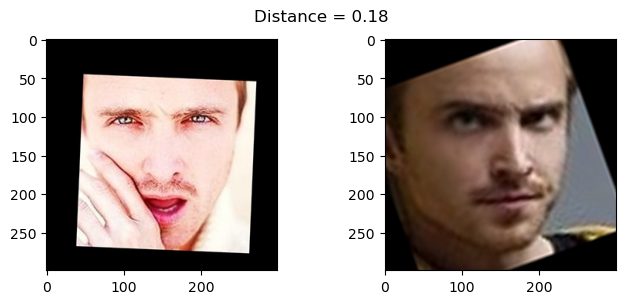

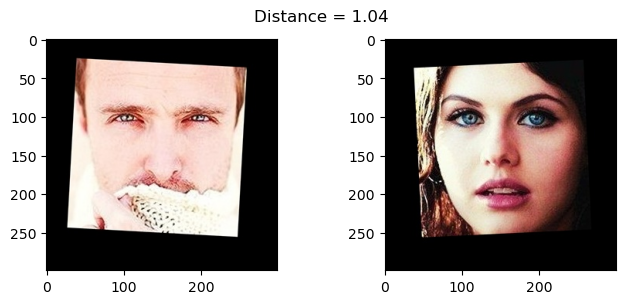

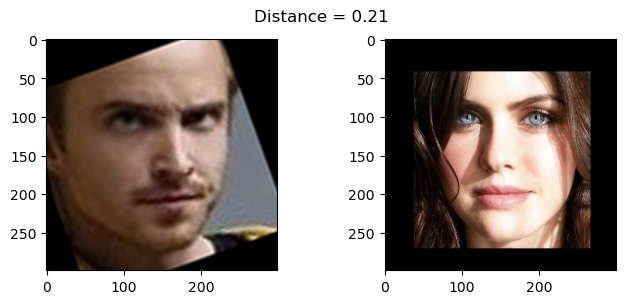

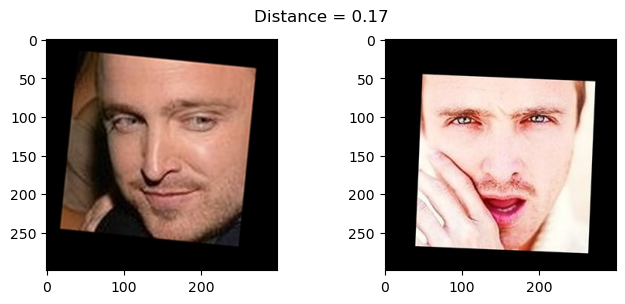

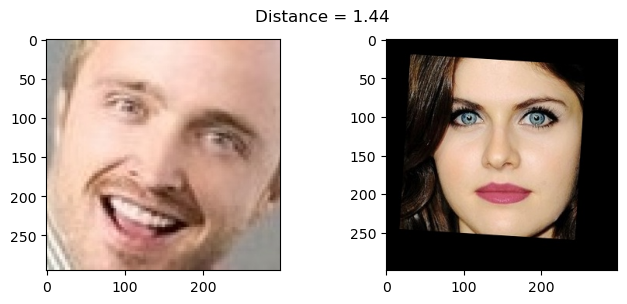

In [32]:
import matplotlib.pyplot as plt

# Define the distance function
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

# Define a function to display a pair of images and their distance
def show_pair(image1, image2, emb1, emb2):
    plt.figure(figsize=(8, 3))
    plt.suptitle(f'Distance = {distance(emb1, emb2):.2f}')
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
    plt.subplot(122)
    plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
    plt.show()

# Define different pairs of images and their embeddings
different_pairs = [
    (image_paths[2], image_paths[30], embeddings[2], embeddings[30]),
    (image_paths[3], image_paths[100], embeddings[3], embeddings[100]),
    (image_paths[30], image_paths[180], embeddings[30], embeddings[180]),
    (image_paths[70], image_paths[2], embeddings[70], embeddings[2]),
    (image_paths[72], image_paths[115], embeddings[72], embeddings[115])
]

# Plot images and get distance between each pair
for image_path1, image_path2, emb1, emb2 in different_pairs:
    image1 = cv2.imread(image_path1)
    image2 = cv2.imread(image_path2)
    show_pair(image1, image2, emb1, emb2)

## Create train and test sets
Create X_train, X_test and y_train, y_test

Use train_idx to seperate out training features and labels

Use test_idx to seperate out testing features and labels

In [33]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Define train and test indices
train_idx = np.arange(len(image_paths)) % 9 != 0
test_idx = np.arange(len(image_paths)) % 9 == 0

# Features
X_train = embeddings[train_idx]
X_test = embeddings[test_idx]

# Labels
y_train = np.array([image_path.split(os.path.sep)[-2] for image_path in image_paths])[train_idx]
y_test = np.array([image_path.split(os.path.sep)[-2] for image_path in image_paths])[test_idx]

# Encode labels
en = LabelEncoder()
y_train = en.fit_transform(y_train)
y_test = en.transform(y_test)

# Standardize features
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (7322, 2622)
X_test shape: (916, 2622)
y_train shape: (7322,)
y_test shape: (916,)


## Use PCA for dimensionality reduction

Cumulative Variance Explained: [  2.22059841   2.93726405   3.48940499 ...  99.99999996 100.
 100.        ]
Number of components to explain 95% of variance: 1864


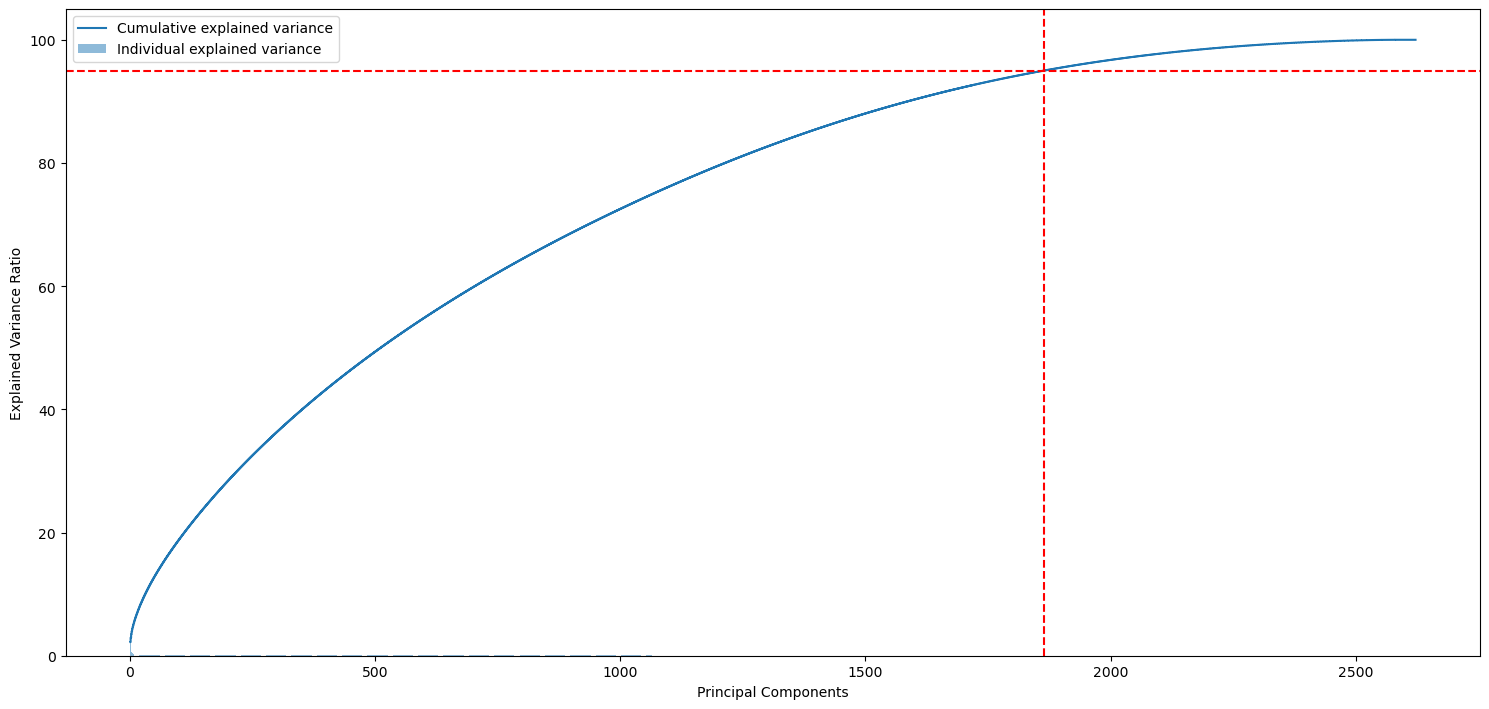

Original shape of X_train: (7322, 2622)
Shape of X_train after PCA dimensionality reduction: (7322, 1864)
Original shape of X_test: (916, 2622)
Shape of X_test after PCA dimensionality reduction: (916, 1864)


In [34]:
import matplotlib.pyplot as plt

# Calculate covariance matrix
cov_matrix = np.cov(X_train_sc.T)

# Eigenvalues and eigenvectors
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

# Cumulative variance explained
tot = sum(eig_vals)
var_exp = [(i / tot) * 100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

print('Cumulative Variance Explained:', cum_var_exp)

# Choose the number of principal components based on a threshold
threshold = 95
index = np.argmax(cum_var_exp > threshold)

print(f'Number of components to explain {threshold}% of variance:', index)

# Plot explained variance ratio
plt.figure(figsize=(15, 7.2))
plt.bar(range(1, eig_vals.size + 1), var_exp, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, eig_vals.size + 1), cum_var_exp, where='mid', label='Cumulative explained variance')
plt.axhline(y=threshold, color='r', linestyle='--')
plt.axvline(x=index, color='r', linestyle='--')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Reduce dimensions using PCA
pca = PCA(n_components=index, random_state=42, svd_solver='full', whiten=True)
X_train_pca = pca.fit_transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)

print("Original shape of X_train:", X_train_sc.shape)
print("Shape of X_train after PCA dimensionality reduction:", X_train_pca.shape)
print("Original shape of X_test:", X_test_sc.shape)
print("Shape of X_test after PCA dimensionality reduction:", X_test_pca.shape)

## Build an SVM classifier in order to map each image to its right person

In [35]:
# Initialize SVM classifier
svm_classifier = SVC()

# Train the classifier
svm_classifier.fit(X_train, y_train)

# Evaluate the classifier
train_accuracy = svm_classifier.score(X_train, y_train)
test_accuracy = svm_classifier.score(X_test, y_test)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Train Accuracy: 0.839524720021852
Test Accuracy: 0.769650655021834


### Import and display the the test images

In [36]:
import cv2

# Define the preprocess_image function
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))  # Resize the image to match the input shape of the VGG model
    img = img[..., ::-1]  # Convert BGR to RGB
    return img

# Paths of the test images
test_image_paths = [
    r"C:\Users\arjit\Desktop\Python\Computer Vision\Benedict Cumberbatch9.jpg",
    r"C:\Users\arjit\Desktop\Python\Computer Vision\Dwayne Johnson4.jpg"
]

# Function to display images
def display_image(image_path):
    image = preprocess_image(image_path)
    cv2.imshow("Test Image", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Display each test image
for image_path in test_image_paths:
    print("Displaying:", image_path)
    display_image(image_path)

Displaying: C:\Users\arjit\Desktop\Python\Computer Vision\Benedict Cumberbatch9.jpg
Displaying: C:\Users\arjit\Desktop\Python\Computer Vision\Dwayne Johnson4.jpg


### Use the trained SVM model to predict the face on both test images.

In [37]:
# Load the VGG Face model
model = vgg_face()

# Function to load and preprocess images
def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path)
    # Preprocess the image if necessary (e.g., resize, normalize, etc.)
    # You may need to preprocess the image to match the input requirements of your model
    return image

# Function to extract embeddings from images
def extract_embeddings_from_image(image):
    # Preprocess the image to match the input shape of the model
    resized_image = cv2.resize(image, (224, 224))
    resized_image = resized_image.astype(np.float32)
    resized_image = np.expand_dims(resized_image, axis=0)
    # Generate embeddings using the VGG Face model
    embedding = model.predict(resized_image)[0]  # Using the previously defined VGG Face model
    return embedding

# Paths of the test images
test_image_paths = [
    r"C:\Users\arjit\Desktop\Python\Computer Vision\Benedict Cumberbatch9.jpg",
    r"C:\Users\arjit\Desktop\Python\Computer Vision\Dwayne Johnson4.jpg"
]

# Predict faces in test images
for image_path in test_image_paths:
    # Load and preprocess the image
    test_image = load_and_preprocess_image(image_path)
    # Extract embeddings from the image
    test_embeddings = extract_embeddings_from_image(test_image)
    # Use the trained SVM model to predict the label
    predicted_label = svm_classifier.predict([test_embeddings])[0]
    print(f"Predicted label for {image_path}: {predicted_label}")

1/1 [==============================] - 2s 2s/step
Predicted label for C:\Users\arjit\Desktop\Python\Computer Vision\Benedict Cumberbatch9.jpg: 65
1/1 [==============================] - 1s 982ms/step
Predicted label for C:\Users\arjit\Desktop\Python\Computer Vision\Dwayne Johnson4.jpg: 65
